# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6335786760712763 -2.9167527052668816
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    Qs_labels = tf.concat(axis=0, values=[targetQs[1:], tf.zeros(shape=[1, 1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                  labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
    #                                                                                    shape=[-1, 1])))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:0.0385 dloss:0.7333 dlossR:0.7333 dlossQ:0.6924
Episode:1 meanR:10.5000 rate:0.0220 gloss:-0.0094 dloss:0.6823 dlossR:0.6823 dlossQ:0.6931
Episode:2 meanR:10.0000 rate:0.0180 gloss:-0.0539 dloss:0.6343 dlossR:0.6343 dlossQ:0.6915
Episode:3 meanR:10.0000 rate:0.0200 gloss:-0.0983 dloss:0.5911 dlossR:0.5911 dlossQ:0.6873
Episode:4 meanR:10.0000 rate:0.0200 gloss:-0.1501 dloss:0.5486 dlossR:0.5486 dlossQ:0.6808
Episode:5 meanR:9.6667 rate:0.0160 gloss:-0.0153 dloss:0.6749 dlossR:0.6749 dlossQ:0.6930
Episode:6 meanR:9.5714 rate:0.0180 gloss:-0.0232 dloss:0.6681 dlossR:0.6681 dlossQ:0.6929
Episode:7 meanR:9.6250 rate:0.0200 gloss:-0.0373 dloss:0.6578 dlossR:0.6578 dlossQ:0.6926
Episode:8 meanR:9.6667 rate:0.0200 gloss:-0.0574 dloss:0.6433 dlossR:0.6433 dlossQ:0.6921
Episode:9 meanR:9.6000 rate:0.0180 gloss:-0.0845 dloss:0.6243 dlossR:0.6243 dlossQ:0.6912
Episode:10 meanR:9.5455 rate:0.0180 gloss:-0.1111 dloss:0.6087 dlossR:0.6087 dlossQ:0.6901
Episo

Episode:98 meanR:28.7172 rate:0.0740 gloss:-1.8996 dloss:0.2761 dlossR:0.2761 dlossQ:0.2849
Episode:99 meanR:28.8100 rate:0.0760 gloss:-1.9431 dloss:0.2799 dlossR:0.2799 dlossQ:0.2613
Episode:100 meanR:29.4300 rate:0.1440 gloss:-1.9810 dloss:0.4765 dlossR:0.4765 dlossQ:0.2293
Episode:101 meanR:30.0300 rate:0.1420 gloss:-1.8549 dloss:0.4534 dlossR:0.4534 dlossQ:0.2527
Episode:102 meanR:30.6900 rate:0.1500 gloss:-1.8887 dloss:0.4805 dlossR:0.4805 dlossQ:0.2445
Episode:103 meanR:31.3200 rate:0.1460 gloss:-1.8532 dloss:0.4651 dlossR:0.4651 dlossQ:0.2528
Episode:104 meanR:31.6900 rate:0.0940 gloss:-1.8609 dloss:0.3240 dlossR:0.3240 dlossQ:0.2610
Episode:105 meanR:32.0700 rate:0.0920 gloss:-1.8675 dloss:0.3191 dlossR:0.3191 dlossQ:0.2600
Episode:106 meanR:32.2000 rate:0.0440 gloss:-1.6210 dloss:0.1910 dlossR:0.1910 dlossQ:0.3240
Episode:107 meanR:32.2300 rate:0.0260 gloss:-1.6515 dloss:0.1411 dlossR:0.1411 dlossQ:0.3458
Episode:108 meanR:32.2800 rate:0.0300 gloss:-1.6884 dloss:0.1512 dlossR:

Episode:188 meanR:33.3500 rate:0.1760 gloss:-1.8288 dloss:0.5418 dlossR:0.5418 dlossQ:0.2503
Episode:189 meanR:33.1700 rate:0.0660 gloss:-1.8118 dloss:0.2439 dlossR:0.2439 dlossQ:0.2690
Episode:190 meanR:33.3800 rate:0.1100 gloss:-1.7930 dloss:0.3612 dlossR:0.3612 dlossQ:0.2649
Episode:191 meanR:33.4000 rate:0.0760 gloss:-1.7739 dloss:0.2704 dlossR:0.2704 dlossQ:0.2742
Episode:192 meanR:33.3900 rate:0.0520 gloss:-1.7437 dloss:0.2064 dlossR:0.2064 dlossQ:0.2910
Episode:193 meanR:33.4900 rate:0.0560 gloss:-1.7196 dloss:0.2176 dlossR:0.2176 dlossQ:0.2941
Episode:194 meanR:33.5600 rate:0.0440 gloss:-1.7014 dloss:0.1864 dlossR:0.1864 dlossQ:0.3056
Episode:195 meanR:33.6300 rate:0.0360 gloss:-1.6847 dloss:0.1655 dlossR:0.1655 dlossQ:0.3166
Episode:196 meanR:33.7400 rate:0.0480 gloss:-1.7097 dloss:0.1972 dlossR:0.1972 dlossQ:0.3026
Episode:197 meanR:33.9000 rate:0.0540 gloss:-1.6922 dloss:0.2136 dlossR:0.2136 dlossQ:0.3074
Episode:198 meanR:33.7400 rate:0.0420 gloss:-1.7072 dloss:0.1817 dloss

Episode:279 meanR:33.7400 rate:0.0340 gloss:-1.5175 dloss:0.1743 dlossR:0.1743 dlossQ:0.3578
Episode:280 meanR:33.6100 rate:0.0320 gloss:-1.5772 dloss:0.1661 dlossR:0.1661 dlossQ:0.3499
Episode:281 meanR:33.1200 rate:0.0300 gloss:-1.6259 dloss:0.1576 dlossR:0.1576 dlossQ:0.3520
Episode:282 meanR:32.9400 rate:0.0200 gloss:-1.6393 dloss:0.1300 dlossR:0.1300 dlossQ:0.3676
Episode:283 meanR:32.8100 rate:0.0220 gloss:-1.6990 dloss:0.1317 dlossR:0.1317 dlossQ:0.3621
Episode:284 meanR:32.3000 rate:0.0240 gloss:-1.7516 dloss:0.1339 dlossR:0.1339 dlossQ:0.3336
Episode:285 meanR:32.0100 rate:0.0220 gloss:-1.8642 dloss:0.1250 dlossR:0.1250 dlossQ:0.3359
Episode:286 meanR:31.5800 rate:0.0240 gloss:-1.9583 dloss:0.1279 dlossR:0.1279 dlossQ:0.3254
Episode:287 meanR:31.4500 rate:0.0240 gloss:-2.0219 dloss:0.1255 dlossR:0.1255 dlossQ:0.3223
Episode:288 meanR:30.6600 rate:0.0180 gloss:-1.6470 dloss:0.1253 dlossR:0.1253 dlossQ:0.4205
Episode:289 meanR:30.4300 rate:0.0200 gloss:-1.6649 dloss:0.1303 dloss

Episode:371 meanR:40.8000 rate:0.0300 gloss:-1.1926 dloss:0.2045 dlossR:0.2045 dlossQ:0.4502
Episode:372 meanR:40.3600 rate:0.0340 gloss:-1.2157 dloss:0.2096 dlossR:0.2096 dlossQ:0.4410
Episode:373 meanR:39.8800 rate:0.0380 gloss:-1.2489 dloss:0.2136 dlossR:0.2136 dlossQ:0.4301
Episode:374 meanR:39.6300 rate:0.0460 gloss:-1.2726 dloss:0.2272 dlossR:0.2272 dlossQ:0.4201
Episode:375 meanR:39.5900 rate:0.0300 gloss:-1.2700 dloss:0.1934 dlossR:0.1934 dlossQ:0.4300
Episode:376 meanR:39.5800 rate:0.0300 gloss:-1.3188 dloss:0.1867 dlossR:0.1867 dlossQ:0.4190
Episode:377 meanR:39.6500 rate:0.0540 gloss:-1.3372 dloss:0.2370 dlossR:0.2370 dlossQ:0.4011
Episode:378 meanR:39.6800 rate:0.0380 gloss:-1.4355 dloss:0.1930 dlossR:0.1930 dlossQ:0.3779
Episode:379 meanR:39.6400 rate:0.0260 gloss:-1.4684 dloss:0.1605 dlossR:0.1605 dlossQ:0.3848
Episode:380 meanR:39.6300 rate:0.0300 gloss:-1.5054 dloss:0.1674 dlossR:0.1674 dlossQ:0.3696
Episode:381 meanR:39.6400 rate:0.0320 gloss:-1.5977 dloss:0.1653 dloss

Episode:461 meanR:35.0100 rate:0.1700 gloss:-1.8879 dloss:0.5372 dlossR:0.5372 dlossQ:0.2637
Episode:462 meanR:35.5100 rate:0.2540 gloss:-1.7733 dloss:0.7330 dlossR:0.7330 dlossQ:0.2761
Episode:463 meanR:35.8900 rate:0.1780 gloss:-1.7521 dloss:0.5328 dlossR:0.5328 dlossQ:0.2816
Episode:464 meanR:36.1800 rate:0.1460 gloss:-1.6731 dloss:0.4422 dlossR:0.4422 dlossQ:0.3006
Episode:465 meanR:35.6200 rate:0.0700 gloss:-1.6311 dloss:0.2559 dlossR:0.2559 dlossQ:0.3195
Episode:466 meanR:36.2200 rate:0.2200 gloss:-1.5633 dloss:0.6002 dlossR:0.6002 dlossQ:0.3248
Episode:467 meanR:36.0500 rate:0.0960 gloss:-1.5357 dloss:0.3179 dlossR:0.3179 dlossQ:0.3371
Episode:468 meanR:36.0700 rate:0.1020 gloss:-1.5113 dloss:0.3317 dlossR:0.3317 dlossQ:0.3456
Episode:469 meanR:35.7100 rate:0.0560 gloss:-1.5317 dloss:0.2298 dlossR:0.2298 dlossQ:0.3573
Episode:470 meanR:35.6700 rate:0.0220 gloss:-1.7201 dloss:0.1317 dlossR:0.1317 dlossQ:0.3668
Episode:471 meanR:35.8100 rate:0.0580 gloss:-1.5351 dloss:0.2347 dloss

Episode:552 meanR:34.9100 rate:0.1880 gloss:-1.9278 dloss:0.5883 dlossR:0.5883 dlossQ:0.2403
Episode:553 meanR:35.1300 rate:0.0940 gloss:-1.8945 dloss:0.3241 dlossR:0.3241 dlossQ:0.2637
Episode:554 meanR:35.5100 rate:0.1040 gloss:-1.7427 dloss:0.3421 dlossR:0.3421 dlossQ:0.2821
Episode:555 meanR:35.4100 rate:0.0840 gloss:-1.7461 dloss:0.2902 dlossR:0.2902 dlossQ:0.2868
Episode:556 meanR:35.6600 rate:0.1900 gloss:-1.7079 dloss:0.5544 dlossR:0.5544 dlossQ:0.2829
Episode:557 meanR:35.8900 rate:0.1200 gloss:-1.6278 dloss:0.3765 dlossR:0.3765 dlossQ:0.3059
Episode:558 meanR:35.6800 rate:0.1380 gloss:-1.5804 dloss:0.4163 dlossR:0.4163 dlossQ:0.3164
Episode:559 meanR:35.8300 rate:0.1320 gloss:-1.5402 dloss:0.4009 dlossR:0.4009 dlossQ:0.3291
Episode:560 meanR:35.8500 rate:0.1560 gloss:-1.5152 dloss:0.4526 dlossR:0.4526 dlossQ:0.3348
Episode:561 meanR:35.7000 rate:0.1400 gloss:-1.4817 dloss:0.4168 dlossR:0.4168 dlossQ:0.3452
Episode:562 meanR:34.5900 rate:0.0320 gloss:-1.7053 dloss:0.1584 dloss

Episode:648 meanR:41.8900 rate:0.0360 gloss:-1.7886 dloss:0.1623 dlossR:0.1623 dlossQ:0.2997
Episode:649 meanR:42.0100 rate:0.0520 gloss:-1.7168 dloss:0.2082 dlossR:0.2082 dlossQ:0.3037
Episode:650 meanR:41.2000 rate:0.0260 gloss:-1.8026 dloss:0.1329 dlossR:0.1329 dlossQ:0.3207
Episode:651 meanR:40.7500 rate:0.0300 gloss:-1.8596 dloss:0.1427 dlossR:0.1427 dlossQ:0.2981
Episode:652 meanR:39.9400 rate:0.0260 gloss:-1.8603 dloss:0.1307 dlossR:0.1307 dlossQ:0.3083
Episode:653 meanR:39.5900 rate:0.0240 gloss:-1.8289 dloss:0.1259 dlossR:0.1259 dlossQ:0.3124
Episode:654 meanR:39.2600 rate:0.0380 gloss:-1.8209 dloss:0.1672 dlossR:0.1672 dlossQ:0.2968
Episode:655 meanR:39.2400 rate:0.0800 gloss:-1.8518 dloss:0.2837 dlossR:0.2837 dlossQ:0.2673
Episode:656 meanR:38.4400 rate:0.0300 gloss:-1.9230 dloss:0.1408 dlossR:0.1408 dlossQ:0.2916
Episode:657 meanR:37.9600 rate:0.0240 gloss:-1.9986 dloss:0.1205 dlossR:0.1205 dlossQ:0.3052
Episode:658 meanR:37.3800 rate:0.0220 gloss:-1.9695 dloss:0.1151 dloss

Episode:746 meanR:35.4000 rate:0.0600 gloss:-1.4679 dloss:0.2387 dlossR:0.2387 dlossQ:0.3536
Episode:747 meanR:35.6400 rate:0.1180 gloss:-1.2564 dloss:0.3720 dlossR:0.3720 dlossQ:0.4148
Episode:748 meanR:36.1100 rate:0.1300 gloss:-1.3516 dloss:0.3906 dlossR:0.3906 dlossQ:0.3850
Episode:749 meanR:35.9700 rate:0.0240 gloss:-1.8689 dloss:0.1257 dlossR:0.1257 dlossQ:0.3330
Episode:750 meanR:35.9400 rate:0.0200 gloss:-1.8544 dloss:0.1138 dlossR:0.1138 dlossQ:0.3564
Episode:751 meanR:36.0300 rate:0.0480 gloss:-1.7221 dloss:0.1984 dlossR:0.1984 dlossQ:0.3142
Episode:752 meanR:36.1700 rate:0.0540 gloss:-1.7626 dloss:0.2147 dlossR:0.2147 dlossQ:0.3110
Episode:753 meanR:36.4100 rate:0.0720 gloss:-1.7569 dloss:0.2605 dlossR:0.2605 dlossQ:0.2961
Episode:754 meanR:37.2800 rate:0.2120 gloss:-1.6964 dloss:0.6074 dlossR:0.6074 dlossQ:0.2883
Episode:755 meanR:37.6400 rate:0.1520 gloss:-1.6353 dloss:0.4564 dlossR:0.4564 dlossQ:0.3096
Episode:756 meanR:38.1200 rate:0.1260 gloss:-1.3390 dloss:0.3896 dloss

Episode:838 meanR:47.0000 rate:0.0180 gloss:-1.2793 dloss:0.1675 dlossR:0.1675 dlossQ:0.4583
Episode:839 meanR:47.2200 rate:0.0900 gloss:-1.1113 dloss:0.3282 dlossR:0.3282 dlossQ:0.4579
Episode:840 meanR:47.7100 rate:0.1400 gloss:-1.3114 dloss:0.4071 dlossR:0.4071 dlossQ:0.3946
Episode:841 meanR:48.2600 rate:0.1380 gloss:-1.3500 dloss:0.4040 dlossR:0.4040 dlossQ:0.3845
Episode:842 meanR:48.2800 rate:0.0260 gloss:-1.5909 dloss:0.1495 dlossR:0.1495 dlossQ:0.3542
Episode:843 meanR:48.3100 rate:0.0240 gloss:-1.5798 dloss:0.1461 dlossR:0.1461 dlossQ:0.3629
Episode:844 meanR:48.3500 rate:0.0280 gloss:-1.5531 dloss:0.1580 dlossR:0.1580 dlossQ:0.3624
Episode:845 meanR:48.3500 rate:0.0180 gloss:-1.7076 dloss:0.1218 dlossR:0.1218 dlossQ:0.4009
Episode:846 meanR:48.1600 rate:0.0220 gloss:-1.6529 dloss:0.1333 dlossR:0.1333 dlossQ:0.3557
Episode:847 meanR:48.0300 rate:0.0920 gloss:-1.6041 dloss:0.3104 dlossR:0.3104 dlossQ:0.3255
Episode:848 meanR:48.6400 rate:0.2520 gloss:-1.4909 dloss:0.6571 dloss

Episode:927 meanR:45.5600 rate:0.1940 gloss:-1.4840 dloss:0.5332 dlossR:0.5332 dlossQ:0.3462
Episode:928 meanR:42.9000 rate:0.1820 gloss:-1.4255 dloss:0.5008 dlossR:0.5008 dlossQ:0.3613
Episode:929 meanR:42.5800 rate:0.1640 gloss:-1.3498 dloss:0.4590 dlossR:0.4590 dlossQ:0.3846
Episode:930 meanR:42.7700 rate:0.2680 gloss:-1.2455 dloss:0.6415 dlossR:0.6415 dlossQ:0.4151
Episode:931 meanR:43.1700 rate:0.1720 gloss:-1.3262 dloss:0.4709 dlossR:0.4709 dlossQ:0.3919
Episode:932 meanR:42.9300 rate:0.0440 gloss:-1.6955 dloss:0.1920 dlossR:0.1920 dlossQ:0.3219
Episode:933 meanR:42.8800 rate:0.0440 gloss:-1.7837 dloss:0.1912 dlossR:0.1912 dlossQ:0.3232
Episode:934 meanR:42.9100 rate:0.0380 gloss:-1.7761 dloss:0.1781 dlossR:0.1781 dlossQ:0.3507
Episode:935 meanR:42.9700 rate:0.0340 gloss:-1.7734 dloss:0.1679 dlossR:0.1679 dlossQ:0.3560
Episode:936 meanR:43.7400 rate:0.1720 gloss:-1.1922 dloss:0.4700 dlossR:0.4700 dlossQ:0.4449
Episode:937 meanR:44.4300 rate:0.1600 gloss:-1.2894 dloss:0.4526 dloss

Episode:1021 meanR:45.8300 rate:0.2800 gloss:-0.8564 dloss:0.6834 dlossR:0.6834 dlossQ:0.5115
Episode:1022 meanR:46.7800 rate:0.3180 gloss:-0.7884 dloss:0.7220 dlossR:0.7220 dlossQ:0.5214
Episode:1023 meanR:46.1600 rate:0.0540 gloss:-1.7850 dloss:0.2148 dlossR:0.2148 dlossQ:0.2923
Episode:1024 meanR:46.0100 rate:0.1240 gloss:-1.7179 dloss:0.3945 dlossR:0.3945 dlossQ:0.3046
Episode:1025 meanR:45.3900 rate:0.0620 gloss:-1.7268 dloss:0.2394 dlossR:0.2394 dlossQ:0.3200
Episode:1026 meanR:45.2300 rate:0.1220 gloss:-1.6723 dloss:0.3896 dlossR:0.3896 dlossQ:0.3171
Episode:1027 meanR:44.7500 rate:0.0980 gloss:-1.7428 dloss:0.3297 dlossR:0.3297 dlossQ:0.2992
Episode:1028 meanR:44.3700 rate:0.1060 gloss:-1.7172 dloss:0.3511 dlossR:0.3511 dlossQ:0.3065
Episode:1029 meanR:43.7800 rate:0.0460 gloss:-1.7920 dloss:0.1952 dlossR:0.1952 dlossQ:0.3142
Episode:1030 meanR:42.8900 rate:0.0900 gloss:-1.7172 dloss:0.3091 dlossR:0.3091 dlossQ:0.3052
Episode:1031 meanR:43.0600 rate:0.2060 gloss:-1.6892 dloss:0

Episode:1112 meanR:37.1700 rate:0.2280 gloss:-1.6506 dloss:0.6474 dlossR:0.6474 dlossQ:0.3176
Episode:1113 meanR:37.7900 rate:0.1500 gloss:-1.7513 dloss:0.4605 dlossR:0.4605 dlossQ:0.2793
Episode:1114 meanR:37.8700 rate:0.1220 gloss:-1.6523 dloss:0.3882 dlossR:0.3882 dlossQ:0.3285
Episode:1115 meanR:38.0400 rate:0.0660 gloss:-1.9311 dloss:0.2540 dlossR:0.2540 dlossQ:0.2808
Episode:1116 meanR:38.0800 rate:0.0340 gloss:-2.0840 dloss:0.1620 dlossR:0.1620 dlossQ:0.3198
Episode:1117 meanR:38.0800 rate:0.0200 gloss:-1.9923 dloss:0.1117 dlossR:0.1117 dlossQ:0.3346
Episode:1118 meanR:38.0500 rate:0.0280 gloss:-1.8461 dloss:0.1408 dlossR:0.1408 dlossQ:0.3249
Episode:1119 meanR:38.4600 rate:0.1360 gloss:-1.8602 dloss:0.4427 dlossR:0.4427 dlossQ:0.2748
Episode:1120 meanR:38.5100 rate:0.1520 gloss:-1.7479 dloss:0.4730 dlossR:0.4730 dlossQ:0.2962
Episode:1121 meanR:37.5100 rate:0.0800 gloss:-1.7074 dloss:0.2821 dlossR:0.2821 dlossQ:0.3080
Episode:1122 meanR:36.9700 rate:0.2100 gloss:-1.6399 dloss:0

Episode:1207 meanR:85.4200 rate:0.5340 gloss:-0.7563 dloss:0.8937 dlossR:0.8937 dlossQ:0.5750
Episode:1208 meanR:90.1900 rate:1.0000 gloss:-0.9110 dloss:1.5628 dlossR:1.5628 dlossQ:0.5283
Episode:1209 meanR:90.7800 rate:0.2020 gloss:-1.2970 dloss:0.5246 dlossR:0.5246 dlossQ:0.4025
Episode:1210 meanR:91.3400 rate:0.1580 gloss:-1.2795 dloss:0.4440 dlossR:0.4440 dlossQ:0.4105
Episode:1211 meanR:91.4600 rate:0.0820 gloss:-1.4293 dloss:0.3046 dlossR:0.3046 dlossQ:0.3965
Episode:1212 meanR:90.4600 rate:0.0280 gloss:-1.4454 dloss:0.1820 dlossR:0.1820 dlossQ:0.4005
Episode:1213 meanR:89.8600 rate:0.0300 gloss:-1.5204 dloss:0.1791 dlossR:0.1791 dlossQ:0.3801
Episode:1214 meanR:89.4100 rate:0.0320 gloss:-1.6180 dloss:0.1690 dlossR:0.1690 dlossQ:0.3433
Episode:1215 meanR:89.2300 rate:0.0300 gloss:-1.6174 dloss:0.1646 dlossR:0.1646 dlossQ:0.3363
Episode:1216 meanR:89.2100 rate:0.0300 gloss:-1.4215 dloss:0.1863 dlossR:0.1863 dlossQ:0.4077
Episode:1217 meanR:89.4700 rate:0.0720 gloss:-1.4792 dloss:0

Episode:1295 meanR:75.1000 rate:1.0000 gloss:-0.6569 dloss:1.2933 dlossR:1.2933 dlossQ:0.5959
Episode:1296 meanR:75.7200 rate:0.3580 gloss:-0.9690 dloss:0.7532 dlossR:0.7532 dlossQ:0.5193
Episode:1297 meanR:75.4100 rate:0.0620 gloss:-1.2362 dloss:0.2759 dlossR:0.2759 dlossQ:0.4413
Episode:1298 meanR:75.3100 rate:0.0280 gloss:-1.4093 dloss:0.1824 dlossR:0.1824 dlossQ:0.4128
Episode:1299 meanR:75.2800 rate:0.0340 gloss:-1.4879 dloss:0.1885 dlossR:0.1885 dlossQ:0.4130
Episode:1300 meanR:75.2300 rate:0.0260 gloss:-1.7965 dloss:0.1460 dlossR:0.1460 dlossQ:0.3722
Episode:1301 meanR:74.5300 rate:0.0340 gloss:-1.5846 dloss:0.1840 dlossR:0.1840 dlossQ:0.3906
Episode:1302 meanR:74.6500 rate:0.0520 gloss:-1.3249 dloss:0.2464 dlossR:0.2464 dlossQ:0.4407
Episode:1303 meanR:74.9100 rate:0.0700 gloss:-1.7016 dloss:0.3068 dlossR:0.3068 dlossQ:0.4188
Episode:1304 meanR:75.1500 rate:0.0880 gloss:-1.4583 dloss:0.3429 dlossR:0.3429 dlossQ:0.4465
Episode:1305 meanR:75.2200 rate:0.0500 gloss:-1.8261 dloss:0

Episode:1382 meanR:105.9600 rate:0.1020 gloss:-1.4009 dloss:0.3336 dlossR:0.3336 dlossQ:0.3803
Episode:1383 meanR:106.0100 rate:0.0420 gloss:-1.6589 dloss:0.1916 dlossR:0.1916 dlossQ:0.3564
Episode:1384 meanR:105.9900 rate:0.0220 gloss:-2.0995 dloss:0.1240 dlossR:0.1240 dlossQ:0.3479
Episode:1385 meanR:105.9500 rate:0.0220 gloss:-2.1450 dloss:0.1239 dlossR:0.1239 dlossQ:0.3465
Episode:1386 meanR:107.3700 rate:0.3160 gloss:-0.0771 dloss:0.7243 dlossR:0.7243 dlossQ:0.6597
Episode:1387 meanR:107.7700 rate:0.1040 gloss:-1.4184 dloss:0.3516 dlossR:0.3516 dlossQ:0.4092
Episode:1388 meanR:108.0100 rate:0.0820 gloss:-1.5217 dloss:0.3264 dlossR:0.3264 dlossQ:0.4406
Episode:1389 meanR:108.0400 rate:0.0340 gloss:-1.8969 dloss:0.1765 dlossR:0.1765 dlossQ:0.3938
Episode:1390 meanR:108.0600 rate:0.0300 gloss:-2.0961 dloss:0.1589 dlossR:0.1589 dlossQ:0.3805
Episode:1391 meanR:108.8200 rate:0.2000 gloss:-1.3259 dloss:0.5240 dlossR:0.5240 dlossQ:0.3912
Episode:1392 meanR:108.6800 rate:0.0180 gloss:-2.1

Episode:1470 meanR:75.3100 rate:0.0720 gloss:-1.9108 dloss:0.2652 dlossR:0.2652 dlossQ:0.2666
Episode:1471 meanR:75.5200 rate:0.0620 gloss:-1.8657 dloss:0.2384 dlossR:0.2384 dlossQ:0.2842
Episode:1472 meanR:75.2400 rate:0.0520 gloss:-1.7421 dloss:0.2136 dlossR:0.2136 dlossQ:0.3231
Episode:1473 meanR:74.9600 rate:0.0520 gloss:-1.8816 dloss:0.2108 dlossR:0.2108 dlossQ:0.2961
Episode:1474 meanR:74.8900 rate:0.0480 gloss:-2.2066 dloss:0.1989 dlossR:0.1989 dlossQ:0.2473
Episode:1475 meanR:74.9200 rate:0.0440 gloss:-2.1417 dloss:0.1861 dlossR:0.1861 dlossQ:0.2575
Episode:1476 meanR:74.9300 rate:0.0400 gloss:-2.2954 dloss:0.1747 dlossR:0.1747 dlossQ:0.2455
Episode:1477 meanR:75.0200 rate:0.0400 gloss:-2.1771 dloss:0.1761 dlossR:0.1761 dlossQ:0.2597
Episode:1478 meanR:75.1000 rate:0.0480 gloss:-2.3033 dloss:0.2028 dlossR:0.2028 dlossQ:0.2353
Episode:1479 meanR:74.9000 rate:0.0300 gloss:-2.5699 dloss:0.1433 dlossR:0.1433 dlossQ:0.2540
Episode:1480 meanR:70.0900 rate:0.0380 gloss:-2.3862 dloss:0

Episode:1563 meanR:42.5800 rate:0.1400 gloss:-1.2704 dloss:0.4158 dlossR:0.4158 dlossQ:0.4175
Episode:1564 meanR:42.6200 rate:0.1060 gloss:-1.4055 dloss:0.3476 dlossR:0.3476 dlossQ:0.3828
Episode:1565 meanR:42.8700 rate:0.1040 gloss:-1.4099 dloss:0.3388 dlossR:0.3388 dlossQ:0.3725
Episode:1566 meanR:42.9800 rate:0.0920 gloss:-1.4975 dloss:0.3144 dlossR:0.3144 dlossQ:0.3513
Episode:1567 meanR:42.8800 rate:0.0780 gloss:-1.4490 dloss:0.2992 dlossR:0.2992 dlossQ:0.4026
Episode:1568 meanR:42.6800 rate:0.0300 gloss:-1.8827 dloss:0.1504 dlossR:0.1504 dlossQ:0.3261
Episode:1569 meanR:42.4000 rate:0.0340 gloss:-1.8642 dloss:0.1633 dlossR:0.1633 dlossQ:0.3420
Episode:1570 meanR:42.6300 rate:0.1180 gloss:-1.1489 dloss:0.3955 dlossR:0.3955 dlossQ:0.4905
Episode:1571 meanR:42.7600 rate:0.0880 gloss:-1.4215 dloss:0.3313 dlossR:0.3313 dlossQ:0.4311
Episode:1572 meanR:42.6100 rate:0.0220 gloss:-2.5497 dloss:0.1307 dlossR:0.1307 dlossQ:0.3942
Episode:1573 meanR:43.4100 rate:0.2120 gloss:-1.6588 dloss:0

Episode:1652 meanR:162.9700 rate:0.0920 gloss:-0.5035 dloss:0.4697 dlossR:0.4697 dlossQ:0.6308
Episode:1653 meanR:162.3300 rate:0.1300 gloss:-0.1744 dloss:0.6459 dlossR:0.6459 dlossQ:0.6674
Episode:1654 meanR:162.0400 rate:0.0940 gloss:-0.4080 dloss:0.5135 dlossR:0.5135 dlossQ:0.6501
Episode:1655 meanR:162.0600 rate:0.1120 gloss:-0.3183 dloss:0.5659 dlossR:0.5659 dlossQ:0.6587
Episode:1656 meanR:162.2900 rate:0.1200 gloss:-0.1761 dloss:0.6457 dlossR:0.6457 dlossQ:0.6693
Episode:1657 meanR:162.3400 rate:0.0900 gloss:-0.1187 dloss:0.6785 dlossR:0.6785 dlossQ:0.6650
Episode:1658 meanR:162.4100 rate:0.0640 gloss:-0.4285 dloss:0.5157 dlossR:0.5157 dlossQ:0.6470
Episode:1659 meanR:162.4300 rate:0.0620 gloss:-0.4335 dloss:0.5180 dlossR:0.5180 dlossQ:0.6486
Episode:1660 meanR:162.4500 rate:0.0720 gloss:-0.6390 dloss:0.4347 dlossR:0.4347 dlossQ:0.6227
Episode:1661 meanR:162.4100 rate:0.0640 gloss:-0.7228 dloss:0.4020 dlossR:0.4020 dlossQ:0.6029
Episode:1662 meanR:162.2100 rate:0.0740 gloss:-0.5

Episode:1739 meanR:316.6000 rate:0.2820 gloss:0.1126 dloss:0.8647 dlossR:0.8647 dlossQ:0.5884
Episode:1740 meanR:319.9000 rate:0.8740 gloss:0.1283 dloss:0.6943 dlossR:0.6943 dlossQ:0.6345
Episode:1741 meanR:323.6200 rate:1.0000 gloss:0.7352 dloss:0.3648 dlossR:0.3648 dlossQ:0.5400
Episode:1742 meanR:323.0100 rate:0.8780 gloss:0.3246 dloss:0.6484 dlossR:0.6484 dlossQ:0.5834
Episode:1743 meanR:320.0100 rate:0.4000 gloss:0.2646 dloss:0.8635 dlossR:0.8635 dlossQ:0.5890
Episode:1744 meanR:317.4400 rate:0.4860 gloss:0.4898 dloss:0.8649 dlossR:0.8649 dlossQ:0.5599
Episode:1745 meanR:315.3000 rate:0.5720 gloss:0.5680 dloss:0.8757 dlossR:0.8757 dlossQ:0.5332
Episode:1746 meanR:312.9200 rate:0.4360 gloss:0.2515 dloss:0.8256 dlossR:0.8256 dlossQ:0.6054
Episode:1747 meanR:311.1400 rate:0.6440 gloss:0.3565 dloss:0.7021 dlossR:0.7021 dlossQ:0.6206
Episode:1748 meanR:314.6700 rate:1.0000 gloss:0.6950 dloss:0.3745 dlossR:0.3745 dlossQ:0.5496
Episode:1749 meanR:318.9000 rate:1.0000 gloss:0.0414 dloss:0

Episode:1826 meanR:199.3500 rate:0.1100 gloss:-0.6988 dloss:0.4221 dlossR:0.4221 dlossQ:0.5797
Episode:1827 meanR:197.8000 rate:0.2560 gloss:-0.0607 dloss:0.6910 dlossR:0.6910 dlossQ:0.6850
Episode:1828 meanR:193.5300 rate:0.1460 gloss:-0.6651 dloss:0.4668 dlossR:0.4668 dlossQ:0.5869
Episode:1829 meanR:192.1900 rate:0.1660 gloss:-0.1365 dloss:0.6404 dlossR:0.6404 dlossQ:0.6882
Episode:1830 meanR:190.3600 rate:0.1260 gloss:-0.7143 dloss:0.4354 dlossR:0.4354 dlossQ:0.5742
Episode:1831 meanR:188.6900 rate:0.1700 gloss:-0.3012 dloss:0.5818 dlossR:0.5818 dlossQ:0.6682
Episode:1832 meanR:188.2700 rate:0.1640 gloss:-0.3570 dloss:0.5602 dlossR:0.5602 dlossQ:0.6599
Episode:1833 meanR:186.7000 rate:0.1380 gloss:-0.5654 dloss:0.4864 dlossR:0.4864 dlossQ:0.6086
Episode:1834 meanR:181.8900 rate:0.0380 gloss:-1.0369 dloss:0.2615 dlossR:0.2615 dlossQ:0.5126
Episode:1835 meanR:180.0300 rate:0.0820 gloss:-0.8229 dloss:0.3604 dlossR:0.3604 dlossQ:0.5432
Episode:1836 meanR:178.2800 rate:0.1240 gloss:-0.8

Episode:1918 meanR:61.0300 rate:0.5020 gloss:-1.1214 dloss:1.0149 dlossR:1.0149 dlossQ:0.4492
Episode:1919 meanR:60.7600 rate:0.2180 gloss:-0.9792 dloss:0.5453 dlossR:0.5453 dlossQ:0.4932
Episode:1920 meanR:59.3600 rate:0.1480 gloss:-1.2966 dloss:0.4437 dlossR:0.4437 dlossQ:0.4014
Episode:1921 meanR:58.5200 rate:0.1080 gloss:-1.6072 dloss:0.3486 dlossR:0.3486 dlossQ:0.3174
Episode:1922 meanR:57.1000 rate:0.0220 gloss:-1.9159 dloss:0.1221 dlossR:0.1221 dlossQ:0.3295
Episode:1923 meanR:55.6200 rate:0.0300 gloss:-2.0903 dloss:0.1424 dlossR:0.1424 dlossQ:0.2753
Episode:1924 meanR:54.3900 rate:0.0280 gloss:-1.9879 dloss:0.1392 dlossR:0.1392 dlossQ:0.3128
Episode:1925 meanR:52.5000 rate:0.0360 gloss:-1.7607 dloss:0.1680 dlossR:0.1680 dlossQ:0.3163
Episode:1926 meanR:52.3100 rate:0.0720 gloss:-1.5747 dloss:0.2635 dlossR:0.2635 dlossQ:0.3362
Episode:1927 meanR:51.6200 rate:0.1180 gloss:-1.3152 dloss:0.3691 dlossR:0.3691 dlossQ:0.3985
Episode:1928 meanR:53.1000 rate:0.4420 gloss:-1.0524 dloss:0

Episode:2007 meanR:66.8800 rate:1.0000 gloss:-0.9087 dloss:1.5583 dlossR:1.5583 dlossQ:0.5216
Episode:2008 meanR:67.2500 rate:0.0920 gloss:-1.4553 dloss:0.3185 dlossR:0.3185 dlossQ:0.3909
Episode:2009 meanR:67.0100 rate:0.0640 gloss:-1.4613 dloss:0.2538 dlossR:0.2538 dlossQ:0.3847
Episode:2010 meanR:67.0000 rate:0.0200 gloss:-1.7701 dloss:0.1353 dlossR:0.1353 dlossQ:0.4141
Episode:2011 meanR:71.9100 rate:1.0000 gloss:-0.5805 dloss:1.2031 dlossR:1.2031 dlossQ:0.6148
Episode:2012 meanR:71.7200 rate:0.0220 gloss:-2.2051 dloss:0.1318 dlossR:0.1318 dlossQ:0.3720
Episode:2013 meanR:71.6800 rate:0.0220 gloss:-1.8428 dloss:0.1510 dlossR:0.1510 dlossQ:0.4093
Episode:2014 meanR:72.0300 rate:0.0980 gloss:-1.4367 dloss:0.3413 dlossR:0.3413 dlossQ:0.3978
Episode:2015 meanR:72.2800 rate:0.0720 gloss:-1.2953 dloss:0.2831 dlossR:0.2831 dlossQ:0.4160
Episode:2016 meanR:72.1200 rate:0.0260 gloss:-1.6018 dloss:0.1739 dlossR:0.1739 dlossQ:0.4111
Episode:2017 meanR:71.5400 rate:0.0200 gloss:-1.5938 dloss:0

Episode:2097 meanR:71.4000 rate:0.0300 gloss:-2.3311 dloss:0.1446 dlossR:0.1446 dlossQ:0.2997
Episode:2098 meanR:70.0000 rate:0.0580 gloss:-1.8624 dloss:0.2279 dlossR:0.2279 dlossQ:0.2868
Episode:2099 meanR:69.0700 rate:0.1020 gloss:-1.7283 dloss:0.3382 dlossR:0.3382 dlossQ:0.2966
Episode:2100 meanR:69.5100 rate:0.1940 gloss:-0.9826 dloss:0.5422 dlossR:0.5422 dlossQ:0.4867
Episode:2101 meanR:69.3600 rate:0.0760 gloss:-1.7481 dloss:0.2732 dlossR:0.2732 dlossQ:0.3044
Episode:2102 meanR:69.2400 rate:0.0500 gloss:-1.7381 dloss:0.2074 dlossR:0.2074 dlossQ:0.3059
Episode:2103 meanR:69.0100 rate:0.0600 gloss:-2.1447 dloss:0.2391 dlossR:0.2391 dlossQ:0.2561
Episode:2104 meanR:64.2400 rate:0.0460 gloss:-2.4273 dloss:0.1999 dlossR:0.1999 dlossQ:0.2452
Episode:2105 meanR:64.2200 rate:0.0300 gloss:-2.4591 dloss:0.1455 dlossR:0.1455 dlossQ:0.2636
Episode:2106 meanR:64.2100 rate:0.0300 gloss:-2.5104 dloss:0.1456 dlossR:0.1456 dlossQ:0.2606
Episode:2107 meanR:59.3400 rate:0.0260 gloss:-2.5686 dloss:0

Episode:2192 meanR:63.3600 rate:0.1520 gloss:-1.0681 dloss:0.4372 dlossR:0.4372 dlossQ:0.4857
Episode:2193 meanR:64.0900 rate:0.1680 gloss:-1.2205 dloss:0.4554 dlossR:0.4554 dlossQ:0.4218
Episode:2194 meanR:64.6000 rate:0.1300 gloss:-1.1950 dloss:0.3887 dlossR:0.3887 dlossQ:0.4317
Episode:2195 meanR:64.9000 rate:0.0820 gloss:-1.2661 dloss:0.2985 dlossR:0.2985 dlossQ:0.4132
Episode:2196 meanR:65.1000 rate:0.0740 gloss:-1.3576 dloss:0.2778 dlossR:0.2778 dlossQ:0.3902
Episode:2197 meanR:65.1100 rate:0.0320 gloss:-1.5782 dloss:0.1704 dlossR:0.1704 dlossQ:0.3575
Episode:2198 meanR:64.9700 rate:0.0300 gloss:-1.7037 dloss:0.1579 dlossR:0.1579 dlossQ:0.3409
Episode:2199 meanR:64.6000 rate:0.0280 gloss:-1.7717 dloss:0.1517 dlossR:0.1517 dlossQ:0.3458
Episode:2200 meanR:63.7600 rate:0.0260 gloss:-1.8740 dloss:0.1445 dlossR:0.1445 dlossQ:0.3414
Episode:2201 meanR:63.5200 rate:0.0280 gloss:-1.8538 dloss:0.1438 dlossR:0.1438 dlossQ:0.3297
Episode:2202 meanR:63.5000 rate:0.0460 gloss:-1.5286 dloss:0

Episode:2280 meanR:80.8100 rate:0.6740 gloss:-0.3435 dloss:0.8954 dlossR:0.8954 dlossQ:0.6045
Episode:2281 meanR:82.8300 rate:0.4280 gloss:-0.1489 dloss:0.7333 dlossR:0.7333 dlossQ:0.6519
Episode:2282 meanR:83.0900 rate:0.1560 gloss:-0.8788 dloss:0.4626 dlossR:0.4626 dlossQ:0.5432
Episode:2283 meanR:82.6900 rate:0.0240 gloss:-1.6802 dloss:0.1538 dlossR:0.1538 dlossQ:0.3859
Episode:2284 meanR:84.5200 rate:0.4240 gloss:0.0293 dloss:0.7300 dlossR:0.7300 dlossQ:0.6698
Episode:2285 meanR:89.2600 rate:1.0000 gloss:-0.2704 dloss:0.9688 dlossR:0.9688 dlossQ:0.6304
Episode:2286 meanR:89.1100 rate:0.0220 gloss:-1.8666 dloss:0.1386 dlossR:0.1386 dlossQ:0.3323
Episode:2287 meanR:88.9900 rate:0.0220 gloss:-1.7555 dloss:0.1725 dlossR:0.1725 dlossQ:0.4075
Episode:2288 meanR:93.6900 rate:1.0000 gloss:0.0649 dloss:0.7011 dlossR:0.7011 dlossQ:0.6503
Episode:2289 meanR:93.5000 rate:0.0200 gloss:-1.7365 dloss:0.1465 dlossR:0.1465 dlossQ:0.4166
Episode:2290 meanR:93.3700 rate:0.0320 gloss:-1.4966 dloss:0.1

Episode:2368 meanR:171.8700 rate:1.0000 gloss:-0.6379 dloss:1.2624 dlossR:1.2624 dlossQ:0.6080
Episode:2369 meanR:173.9300 rate:1.0000 gloss:0.2054 dloss:0.5912 dlossR:0.5912 dlossQ:0.6533
Episode:2370 meanR:174.1600 rate:0.6100 gloss:0.4651 dloss:0.7098 dlossR:0.7098 dlossQ:0.6162
Episode:2371 meanR:171.2700 rate:0.0220 gloss:-1.5873 dloss:0.1799 dlossR:0.1799 dlossQ:0.4414
Episode:2372 meanR:170.2300 rate:0.0240 gloss:-1.1661 dloss:0.2536 dlossR:0.2536 dlossQ:0.5128
Episode:2373 meanR:174.4900 rate:1.0000 gloss:0.3602 dloss:0.4751 dlossR:0.4751 dlossQ:0.6563
Episode:2374 meanR:176.1900 rate:0.4280 gloss:-0.8822 dloss:0.8101 dlossR:0.8101 dlossQ:0.5306
Episode:2375 meanR:176.2500 rate:0.0740 gloss:-1.0826 dloss:0.3805 dlossR:0.3805 dlossQ:0.5775
Episode:2376 meanR:176.0700 rate:0.0180 gloss:-2.0354 dloss:0.1414 dlossR:0.1414 dlossQ:0.4717
Episode:2377 meanR:180.5800 rate:1.0000 gloss:0.2661 dloss:0.5254 dlossR:0.5254 dlossQ:0.6734
Episode:2378 meanR:180.3500 rate:0.0200 gloss:-1.1538 

Episode:2458 meanR:222.0900 rate:0.1460 gloss:-0.3978 dloss:0.5780 dlossR:0.5780 dlossQ:0.6558
Episode:2459 meanR:222.1700 rate:0.1060 gloss:-0.5864 dloss:0.4998 dlossR:0.4998 dlossQ:0.6257
Episode:2460 meanR:222.0700 rate:0.0800 gloss:-0.8528 dloss:0.3983 dlossR:0.3983 dlossQ:0.5714
Episode:2461 meanR:221.9700 rate:0.0720 gloss:-0.9428 dloss:0.3734 dlossR:0.3734 dlossQ:0.5480
Episode:2462 meanR:221.8800 rate:0.0620 gloss:-1.1356 dloss:0.3163 dlossR:0.3163 dlossQ:0.5040
Episode:2463 meanR:221.9800 rate:0.0620 gloss:-1.2691 dloss:0.2961 dlossR:0.2961 dlossQ:0.4687
Episode:2464 meanR:221.9300 rate:0.0340 gloss:-1.7654 dloss:0.1749 dlossR:0.1749 dlossQ:0.3343
Episode:2465 meanR:221.9200 rate:0.0320 gloss:-1.8235 dloss:0.1711 dlossR:0.1711 dlossQ:0.3471
Episode:2466 meanR:222.0400 rate:0.0500 gloss:-1.6362 dloss:0.2357 dlossR:0.2357 dlossQ:0.3717
Episode:2467 meanR:221.8500 rate:0.0480 gloss:-1.7047 dloss:0.2328 dlossR:0.2328 dlossQ:0.3777
Episode:2468 meanR:217.0200 rate:0.0340 gloss:-2.0

Episode:2551 meanR:43.2800 rate:0.0820 gloss:-1.6444 dloss:0.2935 dlossR:0.2935 dlossQ:0.3542
Episode:2552 meanR:42.7700 rate:0.0820 gloss:-1.4972 dloss:0.2961 dlossR:0.2961 dlossQ:0.3903
Episode:2553 meanR:42.5700 rate:0.1200 gloss:-1.4212 dloss:0.3800 dlossR:0.3800 dlossQ:0.4087
Episode:2554 meanR:42.6900 rate:0.1720 gloss:-1.5024 dloss:0.4875 dlossR:0.4875 dlossQ:0.3495
Episode:2555 meanR:44.3000 rate:0.4220 gloss:-1.1546 dloss:0.8881 dlossR:0.8881 dlossQ:0.4482
Episode:2556 meanR:44.4300 rate:0.1680 gloss:-1.4654 dloss:0.4777 dlossR:0.4777 dlossQ:0.3636
Episode:2557 meanR:44.1200 rate:0.0980 gloss:-1.5463 dloss:0.3287 dlossR:0.3287 dlossQ:0.3430
Episode:2558 meanR:48.3900 rate:1.0000 gloss:-0.6857 dloss:1.3149 dlossR:1.3149 dlossQ:0.5894
Episode:2559 meanR:48.1500 rate:0.0580 gloss:-1.6580 dloss:0.2344 dlossR:0.2344 dlossQ:0.3542
Episode:2560 meanR:48.0800 rate:0.0660 gloss:-1.7613 dloss:0.2490 dlossR:0.2490 dlossQ:0.3059
Episode:2561 meanR:48.0100 rate:0.0580 gloss:-1.5606 dloss:0

Episode:2639 meanR:93.7800 rate:0.1500 gloss:-1.2195 dloss:0.4454 dlossR:0.4454 dlossQ:0.4370
Episode:2640 meanR:94.7400 rate:0.2100 gloss:-1.1416 dloss:0.5539 dlossR:0.5539 dlossQ:0.4780
Episode:2641 meanR:98.6700 rate:0.8120 gloss:-0.3846 dloss:0.9376 dlossR:0.9376 dlossQ:0.6355
Episode:2642 meanR:99.9900 rate:0.3100 gloss:-0.4710 dloss:0.6373 dlossR:0.6373 dlossQ:0.6326
Episode:2643 meanR:100.5600 rate:0.2040 gloss:-0.4012 dloss:0.5745 dlossR:0.5745 dlossQ:0.6526
Episode:2644 meanR:101.4800 rate:0.2300 gloss:-0.5068 dloss:0.5710 dlossR:0.5710 dlossQ:0.6325
Episode:2645 meanR:102.2400 rate:0.1900 gloss:-0.5021 dloss:0.5495 dlossR:0.5495 dlossQ:0.6325
Episode:2646 meanR:102.2000 rate:0.0220 gloss:-1.8202 dloss:0.1601 dlossR:0.1601 dlossQ:0.4231
Episode:2647 meanR:103.3300 rate:0.2660 gloss:-0.3346 dloss:0.6200 dlossR:0.6200 dlossQ:0.6607
Episode:2648 meanR:103.6700 rate:0.1000 gloss:-0.9302 dloss:0.4231 dlossR:0.4231 dlossQ:0.5756
Episode:2649 meanR:103.6000 rate:0.0200 gloss:-2.2630 

Episode:2726 meanR:187.0900 rate:0.4960 gloss:0.1329 dloss:0.7035 dlossR:0.7035 dlossQ:0.6842
Episode:2727 meanR:191.9800 rate:1.0000 gloss:0.0491 dloss:0.6584 dlossR:0.6584 dlossQ:0.6926
Episode:2728 meanR:191.3000 rate:0.2940 gloss:0.2552 dloss:0.7908 dlossR:0.7908 dlossQ:0.6723
Episode:2729 meanR:191.4500 rate:1.0000 gloss:0.0841 dloss:0.6344 dlossR:0.6344 dlossQ:0.6915
Episode:2730 meanR:195.5400 rate:1.0000 gloss:0.1056 dloss:0.6200 dlossR:0.6200 dlossQ:0.6905
Episode:2731 meanR:197.2800 rate:0.5500 gloss:0.2311 dloss:0.6941 dlossR:0.6941 dlossQ:0.6761
Episode:2732 meanR:199.0000 rate:0.4480 gloss:0.2648 dloss:0.7350 dlossR:0.7350 dlossQ:0.6719
Episode:2733 meanR:201.1300 rate:0.4540 gloss:0.2673 dloss:0.7338 dlossR:0.7338 dlossQ:0.6712
Episode:2734 meanR:206.0000 rate:1.0000 gloss:0.1605 dloss:0.5840 dlossR:0.5840 dlossQ:0.6866
Episode:2735 meanR:209.5500 rate:0.7340 gloss:0.2456 dloss:0.6284 dlossR:0.6284 dlossQ:0.6755
Episode:2736 meanR:214.4100 rate:1.0000 gloss:0.2035 dloss:0

Episode:2814 meanR:348.5900 rate:1.0000 gloss:0.4578 dloss:0.4177 dlossR:0.4177 dlossQ:0.6404
Episode:2815 meanR:346.6800 rate:0.4700 gloss:0.3594 dloss:0.7582 dlossR:0.7582 dlossQ:0.6480
Episode:2816 meanR:346.6800 rate:1.0000 gloss:0.4928 dloss:0.4014 dlossR:0.4014 dlossQ:0.6322
Episode:2817 meanR:346.6800 rate:1.0000 gloss:0.3693 dloss:0.4690 dlossR:0.4690 dlossQ:0.6528
Episode:2818 meanR:345.6000 rate:0.7840 gloss:0.4645 dloss:0.5701 dlossR:0.5701 dlossQ:0.6300
Episode:2819 meanR:349.2200 rate:1.0000 gloss:0.4899 dloss:0.4039 dlossR:0.4039 dlossQ:0.6319
Episode:2820 meanR:349.2200 rate:1.0000 gloss:0.5010 dloss:0.4000 dlossR:0.4000 dlossQ:0.6286
Episode:2821 meanR:348.8600 rate:0.9280 gloss:0.5098 dloss:0.4592 dlossR:0.4592 dlossQ:0.6176
Episode:2822 meanR:347.6600 rate:0.7600 gloss:0.5438 dloss:0.5808 dlossR:0.5808 dlossQ:0.6085
Episode:2823 meanR:346.6500 rate:0.6880 gloss:0.6872 dloss:0.6288 dlossR:0.6288 dlossQ:0.5822
Episode:2824 meanR:349.0400 rate:0.8020 gloss:0.6573 dloss:0

Episode:2911 meanR:165.6700 rate:0.0800 gloss:-2.0710 dloss:0.3095 dlossR:0.3095 dlossQ:0.2888
Episode:2912 meanR:163.2000 rate:0.1200 gloss:-1.9727 dloss:0.4219 dlossR:0.4219 dlossQ:0.2981
Episode:2913 meanR:160.5400 rate:0.0800 gloss:-2.3589 dloss:0.3221 dlossR:0.3221 dlossQ:0.2509
Episode:2914 meanR:156.2400 rate:0.1400 gloss:-2.0233 dloss:0.4863 dlossR:0.4863 dlossQ:0.3027
Episode:2915 meanR:154.7500 rate:0.1720 gloss:-1.9501 dloss:0.5651 dlossR:0.5651 dlossQ:0.2951
Episode:2916 meanR:150.7400 rate:0.1980 gloss:-1.3174 dloss:0.5480 dlossR:0.5480 dlossQ:0.4623
Episode:2917 meanR:146.4200 rate:0.1360 gloss:-1.2596 dloss:0.4141 dlossR:0.4141 dlossQ:0.4393
Episode:2918 meanR:143.2800 rate:0.1560 gloss:-1.2474 dloss:0.4515 dlossR:0.4515 dlossQ:0.4421
Episode:2919 meanR:138.7000 rate:0.0840 gloss:-1.4445 dloss:0.3421 dlossR:0.3421 dlossQ:0.4437
Episode:2920 meanR:133.9600 rate:0.0520 gloss:-0.8907 dloss:0.3006 dlossR:0.3006 dlossQ:0.5298
Episode:2921 meanR:129.5000 rate:0.0360 gloss:-0.8

Episode:2999 meanR:52.8300 rate:0.0620 gloss:-0.8662 dloss:0.3535 dlossR:0.3535 dlossQ:0.5585
Episode:3000 meanR:53.3300 rate:0.1320 gloss:-0.7530 dloss:0.4489 dlossR:0.4489 dlossQ:0.5805
Episode:3001 meanR:54.0600 rate:0.1900 gloss:-0.7581 dloss:0.5061 dlossR:0.5061 dlossQ:0.5753
Episode:3002 meanR:54.2600 rate:0.0700 gloss:-0.8954 dloss:0.3565 dlossR:0.3565 dlossQ:0.5567
Episode:3003 meanR:54.2100 rate:0.0240 gloss:-1.3243 dloss:0.2135 dlossR:0.2135 dlossQ:0.4981
Episode:3004 meanR:54.4700 rate:0.0900 gloss:-1.0481 dloss:0.3389 dlossR:0.3389 dlossQ:0.4838
Episode:3005 meanR:54.4100 rate:0.0220 gloss:-1.7210 dloss:0.1765 dlossR:0.1765 dlossQ:0.4376
Episode:3006 meanR:54.3600 rate:0.0220 gloss:-1.7830 dloss:0.1590 dlossR:0.1590 dlossQ:0.4363
Episode:3007 meanR:54.6300 rate:0.1000 gloss:-1.1139 dloss:0.3492 dlossR:0.3492 dlossQ:0.4699
Episode:3008 meanR:56.2400 rate:0.3660 gloss:-0.8439 dloss:0.7166 dlossR:0.7166 dlossQ:0.5416
Episode:3009 meanR:57.1600 rate:0.2140 gloss:-0.8673 dloss:0

Episode:3092 meanR:66.6300 rate:0.3440 gloss:-1.0997 dloss:0.7401 dlossR:0.7401 dlossQ:0.4656
Episode:3093 meanR:68.7000 rate:0.4940 gloss:-1.0481 dloss:0.9546 dlossR:0.9546 dlossQ:0.4818
Episode:3094 meanR:69.0800 rate:0.1480 gloss:-1.2940 dloss:0.4243 dlossR:0.4243 dlossQ:0.4072
Episode:3095 meanR:68.9700 rate:0.0840 gloss:-1.4782 dloss:0.2980 dlossR:0.2980 dlossQ:0.3617
Episode:3096 meanR:68.8800 rate:0.0380 gloss:-1.6072 dloss:0.1938 dlossR:0.1938 dlossQ:0.3760
Episode:3097 meanR:68.3800 rate:0.0300 gloss:-1.7409 dloss:0.1654 dlossR:0.1654 dlossQ:0.3778
Episode:3098 meanR:68.4100 rate:0.0260 gloss:-1.8066 dloss:0.1497 dlossR:0.1497 dlossQ:0.3785
Episode:3099 meanR:68.3100 rate:0.0420 gloss:-1.5054 dloss:0.2113 dlossR:0.2113 dlossQ:0.3824
Episode:3100 meanR:68.0900 rate:0.0880 gloss:-1.4930 dloss:0.3026 dlossR:0.3026 dlossQ:0.3560
Episode:3101 meanR:68.5700 rate:0.2860 gloss:-1.0699 dloss:0.6489 dlossR:0.6489 dlossQ:0.4786
Episode:3102 meanR:68.7600 rate:0.1080 gloss:-1.2496 dloss:0

Episode:3181 meanR:66.7300 rate:0.0940 gloss:-1.1613 dloss:0.3579 dlossR:0.3579 dlossQ:0.4792
Episode:3182 meanR:66.7400 rate:0.0280 gloss:-1.8401 dloss:0.1534 dlossR:0.1534 dlossQ:0.3598
Episode:3183 meanR:67.0200 rate:0.0900 gloss:-1.3200 dloss:0.3331 dlossR:0.3331 dlossQ:0.4354
Episode:3184 meanR:66.9400 rate:0.0180 gloss:-2.1260 dloss:0.1311 dlossR:0.1311 dlossQ:0.4408
Episode:3185 meanR:66.8800 rate:0.0220 gloss:-2.0131 dloss:0.1437 dlossR:0.1437 dlossQ:0.3838
Episode:3186 meanR:66.7900 rate:0.0180 gloss:-1.8399 dloss:0.1427 dlossR:0.1427 dlossQ:0.4453
Episode:3187 meanR:68.2700 rate:0.3200 gloss:-0.8231 dloss:0.6647 dlossR:0.6647 dlossQ:0.5443
Episode:3188 meanR:68.2000 rate:0.0260 gloss:-1.8119 dloss:0.1572 dlossR:0.1572 dlossQ:0.3523
Episode:3189 meanR:68.0700 rate:0.0180 gloss:-1.9728 dloss:0.1327 dlossR:0.1327 dlossQ:0.4416
Episode:3190 meanR:67.8800 rate:0.0300 gloss:-1.7005 dloss:0.1749 dlossR:0.1749 dlossQ:0.3596
Episode:3191 meanR:67.9300 rate:0.0860 gloss:-1.3518 dloss:0

Episode:3270 meanR:152.5000 rate:1.0000 gloss:-0.4453 dloss:1.0768 dlossR:1.0768 dlossQ:0.6523
Episode:3271 meanR:153.3600 rate:0.3340 gloss:-0.8309 dloss:0.7011 dlossR:0.7011 dlossQ:0.5482
Episode:3272 meanR:153.2000 rate:0.1160 gloss:-1.0376 dloss:0.4250 dlossR:0.4250 dlossQ:0.5041
Episode:3273 meanR:151.1400 rate:0.0340 gloss:-1.4138 dloss:0.2192 dlossR:0.2192 dlossQ:0.4436
Episode:3274 meanR:148.7000 rate:0.0320 gloss:-1.3438 dloss:0.2500 dlossR:0.2500 dlossQ:0.4788
Episode:3275 meanR:147.4300 rate:0.0440 gloss:-1.0640 dloss:0.3204 dlossR:0.3204 dlossQ:0.5501
Episode:3276 meanR:147.1700 rate:0.0340 gloss:-1.3433 dloss:0.2365 dlossR:0.2365 dlossQ:0.4435
Episode:3277 meanR:146.6100 rate:0.0360 gloss:-1.3988 dloss:0.2220 dlossR:0.2220 dlossQ:0.4349
Episode:3278 meanR:146.2000 rate:0.0660 gloss:-0.9771 dloss:0.3621 dlossR:0.3621 dlossQ:0.5256
Episode:3279 meanR:145.2000 rate:0.1020 gloss:-1.0326 dloss:0.4115 dlossR:0.4115 dlossQ:0.5134
Episode:3280 meanR:145.1100 rate:0.1300 gloss:-0.9

Episode:3358 meanR:120.2600 rate:0.5240 gloss:-1.1458 dloss:1.0624 dlossR:1.0624 dlossQ:0.4803
Episode:3359 meanR:115.9600 rate:0.1400 gloss:-0.5727 dloss:0.5037 dlossR:0.5037 dlossQ:0.6497
Episode:3360 meanR:116.5700 rate:0.1520 gloss:-0.7750 dloss:0.4765 dlossR:0.4765 dlossQ:0.6028
Episode:3361 meanR:112.3400 rate:0.1540 gloss:-0.6201 dloss:0.5104 dlossR:0.5104 dlossQ:0.6379
Episode:3362 meanR:113.2100 rate:0.1960 gloss:-1.3000 dloss:0.5249 dlossR:0.5249 dlossQ:0.4175
Episode:3363 meanR:113.7200 rate:0.2340 gloss:-0.8147 dloss:0.5685 dlossR:0.5685 dlossQ:0.5837
Episode:3364 meanR:114.3500 rate:0.1520 gloss:-0.8027 dloss:0.4847 dlossR:0.4847 dlossQ:0.5984
Episode:3365 meanR:115.0600 rate:0.3100 gloss:-0.4246 dloss:0.6599 dlossR:0.6599 dlossQ:0.6511
Episode:3366 meanR:110.6900 rate:0.1260 gloss:-1.4070 dloss:0.3955 dlossR:0.3955 dlossQ:0.3945
Episode:3367 meanR:112.6000 rate:0.4180 gloss:-1.0924 dloss:0.8633 dlossR:0.8633 dlossQ:0.4843
Episode:3368 meanR:117.3900 rate:0.9960 gloss:-0.2

Episode:3446 meanR:100.1800 rate:0.2460 gloss:-0.3061 dloss:0.6099 dlossR:0.6099 dlossQ:0.6736
Episode:3447 meanR:100.3400 rate:0.0680 gloss:-0.6425 dloss:0.4141 dlossR:0.4141 dlossQ:0.6200
Episode:3448 meanR:100.3900 rate:0.0380 gloss:-0.9964 dloss:0.2859 dlossR:0.2859 dlossQ:0.5264
Episode:3449 meanR:100.3900 rate:0.0300 gloss:-1.3087 dloss:0.2186 dlossR:0.2186 dlossQ:0.4693
Episode:3450 meanR:100.3600 rate:0.0280 gloss:-1.4835 dloss:0.2033 dlossR:0.2033 dlossQ:0.4221
Episode:3451 meanR:100.2800 rate:0.0200 gloss:-1.7030 dloss:0.2058 dlossR:0.2058 dlossQ:0.4600
Episode:3452 meanR:100.1600 rate:0.0220 gloss:-1.7650 dloss:0.1766 dlossR:0.1766 dlossQ:0.4201
Episode:3453 meanR:100.1300 rate:0.0520 gloss:-1.1226 dloss:0.2847 dlossR:0.2847 dlossQ:0.5034
Episode:3454 meanR:99.9300 rate:0.0520 gloss:-1.1130 dloss:0.2852 dlossR:0.2852 dlossQ:0.4944
Episode:3455 meanR:100.1000 rate:0.1120 gloss:-0.8982 dloss:0.4044 dlossR:0.4044 dlossQ:0.5429
Episode:3456 meanR:99.7600 rate:0.1080 gloss:-0.797

Episode:3533 meanR:62.3800 rate:0.0360 gloss:-1.9869 dloss:0.1751 dlossR:0.1751 dlossQ:0.3038
Episode:3534 meanR:62.0200 rate:0.0440 gloss:-1.7726 dloss:0.2039 dlossR:0.2039 dlossQ:0.3448
Episode:3535 meanR:62.1100 rate:0.0420 gloss:-1.8703 dloss:0.1957 dlossR:0.1957 dlossQ:0.3374
Episode:3536 meanR:62.2200 rate:0.0440 gloss:-1.6471 dloss:0.2155 dlossR:0.2155 dlossQ:0.3801
Episode:3537 meanR:61.9700 rate:0.0420 gloss:-1.8677 dloss:0.1949 dlossR:0.1949 dlossQ:0.3406
Episode:3538 meanR:59.8200 rate:0.0420 gloss:-1.8936 dloss:0.1935 dlossR:0.1935 dlossQ:0.3333
Episode:3539 meanR:58.1200 rate:0.0260 gloss:-2.1681 dloss:0.1378 dlossR:0.1378 dlossQ:0.3203
Episode:3540 meanR:57.5300 rate:0.0260 gloss:-2.1373 dloss:0.1373 dlossR:0.1373 dlossQ:0.3256
Episode:3541 meanR:57.4700 rate:0.0460 gloss:-1.8515 dloss:0.2070 dlossR:0.2070 dlossQ:0.3412
Episode:3542 meanR:57.5900 rate:0.0560 gloss:-1.6060 dloss:0.2430 dlossR:0.2430 dlossQ:0.3647
Episode:3543 meanR:58.3200 rate:0.1700 gloss:-0.8400 dloss:0

Episode:3626 meanR:89.0300 rate:0.1080 gloss:-0.7562 dloss:0.4189 dlossR:0.4189 dlossQ:0.5698
Episode:3627 meanR:89.4200 rate:0.2020 gloss:-0.4759 dloss:0.5670 dlossR:0.5670 dlossQ:0.6360
Episode:3628 meanR:90.1900 rate:0.2520 gloss:-0.6453 dloss:0.5884 dlossR:0.5884 dlossQ:0.6044
Episode:3629 meanR:91.9900 rate:0.4180 gloss:-0.6225 dloss:0.7384 dlossR:0.7384 dlossQ:0.6085
Episode:3630 meanR:94.7700 rate:0.6080 gloss:-0.7547 dloss:0.9673 dlossR:0.9673 dlossQ:0.5685
Episode:3631 meanR:97.2100 rate:0.5360 gloss:-0.8169 dloss:0.9180 dlossR:0.9180 dlossQ:0.5542
Episode:3632 meanR:98.0300 rate:0.2160 gloss:-0.8694 dloss:0.5323 dlossR:0.5323 dlossQ:0.5412
Episode:3633 meanR:98.3300 rate:0.0960 gloss:-1.0748 dloss:0.3734 dlossR:0.3734 dlossQ:0.5212
Episode:3634 meanR:98.6200 rate:0.1020 gloss:-0.9705 dloss:0.3964 dlossR:0.3964 dlossQ:0.5375
Episode:3635 meanR:98.8800 rate:0.0940 gloss:-1.1089 dloss:0.3605 dlossR:0.3605 dlossQ:0.5076
Episode:3636 meanR:99.3200 rate:0.1320 gloss:-1.0400 dloss:0

Episode:3713 meanR:150.5400 rate:0.1960 gloss:-0.6700 dloss:0.5977 dlossR:0.5977 dlossQ:0.6528
Episode:3714 meanR:150.6700 rate:0.1440 gloss:-0.9202 dloss:0.4642 dlossR:0.4642 dlossQ:0.5657
Episode:3715 meanR:150.5900 rate:0.0320 gloss:-1.2782 dloss:0.2413 dlossR:0.2413 dlossQ:0.5344
Episode:3716 meanR:150.7200 rate:0.0540 gloss:-1.0767 dloss:0.3174 dlossR:0.3174 dlossQ:0.5511
Episode:3717 meanR:151.1200 rate:0.1060 gloss:-0.8576 dloss:0.4338 dlossR:0.4338 dlossQ:0.5783
Episode:3718 meanR:151.0900 rate:0.0800 gloss:-1.1912 dloss:0.3532 dlossR:0.3532 dlossQ:0.5307
Episode:3719 meanR:148.8800 rate:0.0420 gloss:-1.6342 dloss:0.2243 dlossR:0.2243 dlossQ:0.4565
Episode:3720 meanR:148.2100 rate:0.0740 gloss:-1.1005 dloss:0.3231 dlossR:0.3231 dlossQ:0.5172
Episode:3721 meanR:148.7900 rate:0.1720 gloss:-0.7127 dloss:0.5562 dlossR:0.5562 dlossQ:0.6436
Episode:3722 meanR:149.4200 rate:0.1660 gloss:-0.7631 dloss:0.5264 dlossR:0.5264 dlossQ:0.6226
Episode:3723 meanR:150.2300 rate:0.1840 gloss:-0.6

Episode:3800 meanR:72.1800 rate:1.0000 gloss:-0.3544 dloss:1.0075 dlossR:1.0075 dlossQ:0.6566
Episode:3801 meanR:77.0100 rate:1.0000 gloss:-0.1377 dloss:0.8448 dlossR:0.8448 dlossQ:0.6618
Episode:3802 meanR:77.2700 rate:0.0860 gloss:-1.4238 dloss:0.3135 dlossR:0.3135 dlossQ:0.3948
Episode:3803 meanR:76.8700 rate:0.0180 gloss:-2.2850 dloss:0.1505 dlossR:0.1505 dlossQ:0.4267
Episode:3804 meanR:81.0300 rate:0.9080 gloss:-0.1272 dloss:0.8116 dlossR:0.8116 dlossQ:0.6688
Episode:3805 meanR:81.4200 rate:0.2700 gloss:-0.9902 dloss:0.6061 dlossR:0.6061 dlossQ:0.5001
Episode:3806 meanR:81.4500 rate:0.1860 gloss:-1.4865 dloss:0.5184 dlossR:0.5184 dlossQ:0.3503
Episode:3807 meanR:80.5800 rate:0.0180 gloss:-2.1973 dloss:0.1346 dlossR:0.1346 dlossQ:0.4576
Episode:3808 meanR:79.3900 rate:0.0480 gloss:-1.7765 dloss:0.2029 dlossR:0.2029 dlossQ:0.3095
Episode:3809 meanR:78.6400 rate:0.0840 gloss:-1.5801 dloss:0.2960 dlossR:0.2960 dlossQ:0.3392
Episode:3810 meanR:78.3400 rate:0.1020 gloss:-1.4921 dloss:0

Episode:3891 meanR:98.8500 rate:0.0840 gloss:-1.4228 dloss:0.3132 dlossR:0.3132 dlossQ:0.4125
Episode:3892 meanR:99.0300 rate:0.0660 gloss:-1.5913 dloss:0.2988 dlossR:0.2988 dlossQ:0.4846
Episode:3893 meanR:99.2000 rate:0.0560 gloss:-1.2496 dloss:0.3322 dlossR:0.3322 dlossQ:0.5760
Episode:3894 meanR:98.2500 rate:0.1140 gloss:-1.5295 dloss:0.3829 dlossR:0.3829 dlossQ:0.3810
Episode:3895 meanR:93.4900 rate:0.0480 gloss:-1.7562 dloss:0.2304 dlossR:0.2304 dlossQ:0.3994
Episode:3896 meanR:93.4200 rate:0.0480 gloss:-1.7371 dloss:0.2311 dlossR:0.2311 dlossQ:0.4014
Episode:3897 meanR:93.7300 rate:0.1100 gloss:-0.7857 dloss:0.4913 dlossR:0.4913 dlossQ:0.6392
Episode:3898 meanR:93.6900 rate:0.0700 gloss:-1.5604 dloss:0.3067 dlossR:0.3067 dlossQ:0.4464
Episode:3899 meanR:92.4300 rate:0.0400 gloss:-1.9424 dloss:0.2141 dlossR:0.2141 dlossQ:0.3797
Episode:3900 meanR:87.5200 rate:0.0180 gloss:-3.0412 dloss:0.1544 dlossR:0.1544 dlossQ:0.6037
Episode:3901 meanR:82.6100 rate:0.0180 gloss:-2.6156 dloss:0

Episode:3982 meanR:66.5200 rate:0.0920 gloss:-0.9048 dloss:0.3649 dlossR:0.3649 dlossQ:0.5309
Episode:3983 meanR:66.6900 rate:0.0720 gloss:-1.0262 dloss:0.3169 dlossR:0.3169 dlossQ:0.4985
Episode:3984 meanR:66.8100 rate:0.0660 gloss:-1.1160 dloss:0.2971 dlossR:0.2971 dlossQ:0.4740
Episode:3985 meanR:66.3100 rate:0.0220 gloss:-1.3037 dloss:0.1891 dlossR:0.1891 dlossQ:0.4276
Episode:3986 meanR:65.9200 rate:0.0240 gloss:-1.3001 dloss:0.1947 dlossR:0.1947 dlossQ:0.4636
Episode:3987 meanR:65.7800 rate:0.0200 gloss:-1.5539 dloss:0.1647 dlossR:0.1647 dlossQ:0.4397
Episode:3988 meanR:65.7800 rate:0.0320 gloss:-1.3332 dloss:0.1996 dlossR:0.1996 dlossQ:0.4150
Episode:3989 meanR:66.0800 rate:0.0880 gloss:-1.1721 dloss:0.3318 dlossR:0.3318 dlossQ:0.4669
Episode:3990 meanR:66.6500 rate:0.1500 gloss:-0.7616 dloss:0.4612 dlossR:0.4612 dlossQ:0.5687
Episode:3991 meanR:67.4300 rate:0.2400 gloss:-0.7374 dloss:0.5559 dlossR:0.5559 dlossQ:0.5699
Episode:3992 meanR:67.5500 rate:0.0900 gloss:-1.1861 dloss:0

Episode:4077 meanR:94.0300 rate:0.0700 gloss:-1.4360 dloss:0.2831 dlossR:0.2831 dlossQ:0.4003
Episode:4078 meanR:93.1800 rate:0.0900 gloss:-1.3561 dloss:0.3170 dlossR:0.3170 dlossQ:0.4055
Episode:4079 meanR:92.4900 rate:0.0720 gloss:-1.2018 dloss:0.3124 dlossR:0.3124 dlossQ:0.4754
Episode:4080 meanR:92.1000 rate:0.0560 gloss:-1.5647 dloss:0.2454 dlossR:0.2454 dlossQ:0.4049
Episode:4081 meanR:91.7800 rate:0.0560 gloss:-1.5359 dloss:0.2459 dlossR:0.2459 dlossQ:0.3948
Episode:4082 meanR:91.7900 rate:0.0940 gloss:-1.3800 dloss:0.3439 dlossR:0.3439 dlossQ:0.4354
Episode:4083 meanR:91.8300 rate:0.0800 gloss:-1.4384 dloss:0.3061 dlossR:0.3061 dlossQ:0.4224
Episode:4084 meanR:92.0800 rate:0.1160 gloss:-1.3032 dloss:0.3746 dlossR:0.3746 dlossQ:0.4302
Episode:4085 meanR:92.4000 rate:0.0860 gloss:-1.4363 dloss:0.3164 dlossR:0.3164 dlossQ:0.4150
Episode:4086 meanR:92.7500 rate:0.0940 gloss:-1.4101 dloss:0.3454 dlossR:0.3454 dlossQ:0.4348
Episode:4087 meanR:92.9800 rate:0.0660 gloss:-1.5430 dloss:0

Episode:4165 meanR:83.2600 rate:0.1360 gloss:-1.1968 dloss:0.4040 dlossR:0.4040 dlossQ:0.4367
Episode:4166 meanR:78.8000 rate:0.1080 gloss:-1.4362 dloss:0.3731 dlossR:0.3731 dlossQ:0.4178
Episode:4167 meanR:77.4900 rate:0.0620 gloss:-1.6942 dloss:0.2470 dlossR:0.2470 dlossQ:0.3422
Episode:4168 meanR:76.8700 rate:0.0480 gloss:-1.8768 dloss:0.2125 dlossR:0.2125 dlossQ:0.3530
Episode:4169 meanR:76.6300 rate:0.0780 gloss:-1.5531 dloss:0.2963 dlossR:0.2963 dlossQ:0.3922
Episode:4170 meanR:77.3900 rate:0.2300 gloss:-1.3348 dloss:0.5925 dlossR:0.5925 dlossQ:0.4065
Episode:4171 meanR:77.6100 rate:0.0960 gloss:-1.5302 dloss:0.3350 dlossR:0.3350 dlossQ:0.3875
Episode:4172 meanR:77.5400 rate:0.0320 gloss:-2.0778 dloss:0.1690 dlossR:0.1690 dlossQ:0.3781
Episode:4173 meanR:77.7000 rate:0.0600 gloss:-1.7197 dloss:0.2512 dlossR:0.2512 dlossQ:0.3887
Episode:4174 meanR:77.8400 rate:0.0580 gloss:-1.8572 dloss:0.2343 dlossR:0.2343 dlossQ:0.3284
Episode:4175 meanR:77.8800 rate:0.0380 gloss:-2.1438 dloss:0

Episode:4255 meanR:54.6800 rate:0.1600 gloss:-1.3165 dloss:0.5044 dlossR:0.5044 dlossQ:0.4047
Episode:4256 meanR:54.5500 rate:0.0320 gloss:-2.0548 dloss:0.1544 dlossR:0.1544 dlossQ:0.2818
Episode:4257 meanR:54.2200 rate:0.0220 gloss:-2.1959 dloss:0.1322 dlossR:0.1322 dlossQ:0.3511
Episode:4258 meanR:53.7700 rate:0.1140 gloss:-1.6946 dloss:0.3761 dlossR:0.3761 dlossQ:0.3078
Episode:4259 meanR:53.7400 rate:0.1120 gloss:-1.7327 dloss:0.3723 dlossR:0.3723 dlossQ:0.2945
Episode:4260 meanR:53.8800 rate:0.1000 gloss:-1.9043 dloss:0.3464 dlossR:0.3464 dlossQ:0.2769
Episode:4261 meanR:53.7100 rate:0.0180 gloss:-2.1418 dloss:0.1168 dlossR:0.1168 dlossQ:0.4013
Episode:4262 meanR:53.6400 rate:0.0300 gloss:-1.9767 dloss:0.1523 dlossR:0.1523 dlossQ:0.3348
Episode:4263 meanR:53.7300 rate:0.0920 gloss:-1.2587 dloss:0.3320 dlossR:0.3320 dlossQ:0.4520
Episode:4264 meanR:53.5000 rate:0.0200 gloss:-1.8606 dloss:0.1546 dlossR:0.1546 dlossQ:0.4768
Episode:4265 meanR:53.0300 rate:0.0420 gloss:-1.7296 dloss:0

Episode:4343 meanR:52.1400 rate:0.6720 gloss:-0.6794 dloss:1.0539 dlossR:1.0539 dlossQ:0.5508
Episode:4344 meanR:51.0700 rate:0.0700 gloss:-1.8111 dloss:0.2617 dlossR:0.2617 dlossQ:0.3037
Episode:4345 meanR:49.6400 rate:0.0240 gloss:-2.1483 dloss:0.1255 dlossR:0.1255 dlossQ:0.2993
Episode:4346 meanR:48.3900 rate:0.0200 gloss:-2.2018 dloss:0.1128 dlossR:0.1128 dlossQ:0.3440
Episode:4347 meanR:46.8500 rate:0.0380 gloss:-1.9013 dloss:0.1736 dlossR:0.1736 dlossQ:0.3109
Episode:4348 meanR:45.5100 rate:0.0360 gloss:-1.9771 dloss:0.1621 dlossR:0.1621 dlossQ:0.2895
Episode:4349 meanR:44.1700 rate:0.0580 gloss:-1.8534 dloss:0.2260 dlossR:0.2260 dlossQ:0.2934
Episode:4350 meanR:42.4700 rate:0.1080 gloss:-1.5453 dloss:0.3457 dlossR:0.3457 dlossQ:0.3327
Episode:4351 meanR:41.3200 rate:0.2700 gloss:-1.2451 dloss:0.6435 dlossR:0.6435 dlossQ:0.4130
Episode:4352 meanR:44.7300 rate:0.9840 gloss:-0.4289 dloss:1.1249 dlossR:1.1249 dlossQ:0.5923
Episode:4353 meanR:46.7800 rate:0.6440 gloss:-0.2338 dloss:0

Episode:4438 meanR:119.9700 rate:1.0000 gloss:0.9813 dloss:0.2674 dlossR:0.2674 dlossQ:0.4704
Episode:4439 meanR:121.1300 rate:0.2520 gloss:-0.9923 dloss:0.5794 dlossR:0.5794 dlossQ:0.4946
Episode:4440 meanR:121.3300 rate:0.2000 gloss:-1.0254 dloss:0.5154 dlossR:0.5154 dlossQ:0.4873
Episode:4441 meanR:121.6700 rate:0.0900 gloss:-1.4284 dloss:0.3146 dlossR:0.3146 dlossQ:0.3813
Episode:4442 meanR:121.8100 rate:0.0480 gloss:-1.7653 dloss:0.2037 dlossR:0.2037 dlossQ:0.3157
Episode:4443 meanR:118.6300 rate:0.0360 gloss:-1.8537 dloss:0.1708 dlossR:0.1708 dlossQ:0.3208
Episode:4444 meanR:118.4100 rate:0.0260 gloss:-1.6477 dloss:0.1809 dlossR:0.1809 dlossQ:0.3918
Episode:4445 meanR:118.3900 rate:0.0200 gloss:-2.0743 dloss:0.1211 dlossR:0.1211 dlossQ:0.3646
Episode:4446 meanR:118.4700 rate:0.0360 gloss:-1.7875 dloss:0.1742 dlossR:0.1742 dlossQ:0.3372
Episode:4447 meanR:119.2200 rate:0.1880 gloss:-1.1188 dloss:0.4980 dlossR:0.4980 dlossQ:0.4648
Episode:4448 meanR:120.3100 rate:0.2540 gloss:-0.45

Episode:4532 meanR:65.5400 rate:0.2120 gloss:-1.2944 dloss:0.5483 dlossR:0.5483 dlossQ:0.4156
Episode:4533 meanR:66.4200 rate:0.2020 gloss:-1.3229 dloss:0.5382 dlossR:0.5382 dlossQ:0.4038
Episode:4534 meanR:66.6500 rate:0.0640 gloss:-1.8251 dloss:0.2450 dlossR:0.2450 dlossQ:0.2989
Episode:4535 meanR:66.7200 rate:0.0420 gloss:-2.1239 dloss:0.1804 dlossR:0.1804 dlossQ:0.2714
Episode:4536 meanR:66.9800 rate:0.1020 gloss:-1.7462 dloss:0.3572 dlossR:0.3572 dlossQ:0.3070
Episode:4537 meanR:66.6200 rate:0.0480 gloss:-2.0044 dloss:0.2010 dlossR:0.2010 dlossQ:0.2683
Episode:4538 meanR:61.7300 rate:0.0220 gloss:-2.4370 dloss:0.1267 dlossR:0.1267 dlossQ:0.3509
Episode:4539 meanR:61.8100 rate:0.2680 gloss:-1.1032 dloss:0.6314 dlossR:0.6314 dlossQ:0.4659
Episode:4540 meanR:61.6600 rate:0.1700 gloss:-1.2484 dloss:0.4650 dlossR:0.4650 dlossQ:0.4116
Episode:4541 meanR:61.3300 rate:0.0240 gloss:-2.3876 dloss:0.1302 dlossR:0.1302 dlossQ:0.3213
Episode:4542 meanR:61.2200 rate:0.0260 gloss:-2.3770 dloss:0

Episode:4624 meanR:82.4000 rate:0.4400 gloss:-0.2725 dloss:0.7508 dlossR:0.7508 dlossQ:0.6281
Episode:4625 meanR:83.1200 rate:0.1640 gloss:-0.6649 dloss:0.4919 dlossR:0.4919 dlossQ:0.5867
Episode:4626 meanR:82.7100 rate:0.0380 gloss:-1.1860 dloss:0.2428 dlossR:0.2428 dlossQ:0.4700
Episode:4627 meanR:82.7100 rate:0.0200 gloss:-1.6148 dloss:0.1532 dlossR:0.1532 dlossQ:0.4293
Episode:4628 meanR:82.5700 rate:0.0180 gloss:-1.6613 dloss:0.1369 dlossR:0.1369 dlossQ:0.4232
Episode:4629 meanR:82.1500 rate:0.0440 gloss:-1.5383 dloss:0.2050 dlossR:0.2050 dlossQ:0.3529
Episode:4630 meanR:83.3400 rate:0.2840 gloss:-0.5816 dloss:0.6091 dlossR:0.6091 dlossQ:0.6102
Episode:4631 meanR:86.7700 rate:0.7220 gloss:-0.1800 dloss:0.8197 dlossR:0.8197 dlossQ:0.6410
Episode:4632 meanR:86.2000 rate:0.0980 gloss:-0.8997 dloss:0.3745 dlossR:0.3745 dlossQ:0.5213
Episode:4633 meanR:85.3700 rate:0.0360 gloss:-1.4910 dloss:0.1919 dlossR:0.1919 dlossQ:0.3747
Episode:4634 meanR:85.2200 rate:0.0340 gloss:-1.5477 dloss:0

Episode:4717 meanR:59.6500 rate:0.0300 gloss:-2.1385 dloss:0.1465 dlossR:0.1465 dlossQ:0.2974
Episode:4718 meanR:59.7100 rate:0.0320 gloss:-1.9514 dloss:0.1582 dlossR:0.1582 dlossQ:0.3321
Episode:4719 meanR:54.8500 rate:0.0280 gloss:-2.1111 dloss:0.1419 dlossR:0.1419 dlossQ:0.3221
Episode:4720 meanR:54.8200 rate:0.0340 gloss:-1.8694 dloss:0.1639 dlossR:0.1639 dlossQ:0.3277
Episode:4721 meanR:54.9300 rate:0.0400 gloss:-2.0480 dloss:0.1758 dlossR:0.1758 dlossQ:0.2741
Episode:4722 meanR:55.0400 rate:0.0400 gloss:-1.9930 dloss:0.1743 dlossR:0.1743 dlossQ:0.2841
Episode:4723 meanR:55.1400 rate:0.0540 gloss:-1.7163 dloss:0.2197 dlossR:0.2197 dlossQ:0.3213
Episode:4724 meanR:53.2700 rate:0.0660 gloss:-1.7801 dloss:0.2495 dlossR:0.2495 dlossQ:0.2979
Episode:4725 meanR:52.7700 rate:0.0640 gloss:-1.8072 dloss:0.2427 dlossR:0.2427 dlossQ:0.2939
Episode:4726 meanR:52.9500 rate:0.0740 gloss:-1.7441 dloss:0.2746 dlossR:0.2746 dlossQ:0.3208
Episode:4727 meanR:53.1400 rate:0.0580 gloss:-1.8526 dloss:0

Episode:4811 meanR:48.1200 rate:0.0500 gloss:-1.6196 dloss:0.2206 dlossR:0.2206 dlossQ:0.3832
Episode:4812 meanR:48.2900 rate:0.0620 gloss:-1.4579 dloss:0.2686 dlossR:0.2686 dlossQ:0.4255
Episode:4813 meanR:48.0800 rate:0.0900 gloss:-1.3925 dloss:0.3289 dlossR:0.3289 dlossQ:0.4157
Episode:4814 meanR:48.3600 rate:0.1720 gloss:-1.3151 dloss:0.4847 dlossR:0.4847 dlossQ:0.4144
Episode:4815 meanR:48.8800 rate:0.1480 gloss:-1.2775 dloss:0.4288 dlossR:0.4288 dlossQ:0.4243
Episode:4816 meanR:49.7000 rate:0.1980 gloss:-1.2508 dloss:0.5198 dlossR:0.5198 dlossQ:0.4312
Episode:4817 meanR:50.3600 rate:0.1620 gloss:-1.1887 dloss:0.4611 dlossR:0.4611 dlossQ:0.4634
Episode:4818 meanR:51.6900 rate:0.2980 gloss:-0.7232 dloss:0.6399 dlossR:0.6399 dlossQ:0.5771
Episode:4819 meanR:51.9600 rate:0.0820 gloss:-1.6119 dloss:0.2998 dlossR:0.2998 dlossQ:0.3441
Episode:4820 meanR:51.9900 rate:0.0400 gloss:-1.8244 dloss:0.1892 dlossR:0.1892 dlossQ:0.3536
Episode:4821 meanR:51.9100 rate:0.0240 gloss:-2.2372 dloss:0

Episode:4904 meanR:158.4500 rate:0.2020 gloss:-0.8331 dloss:0.5592 dlossR:0.5592 dlossQ:0.5987
Episode:4905 meanR:158.7400 rate:0.1400 gloss:-1.4261 dloss:0.4413 dlossR:0.4413 dlossQ:0.4390
Episode:4906 meanR:158.5700 rate:0.0260 gloss:-2.9471 dloss:0.1513 dlossR:0.1513 dlossQ:0.4535
Episode:4907 meanR:158.7900 rate:0.0860 gloss:-1.2191 dloss:0.3180 dlossR:0.3180 dlossQ:0.4378
Episode:4908 meanR:158.6900 rate:0.0240 gloss:-1.7497 dloss:0.1549 dlossR:0.1549 dlossQ:0.3965
Episode:4909 meanR:158.6300 rate:0.0300 gloss:-1.7760 dloss:0.1651 dlossR:0.1651 dlossQ:0.3950
Episode:4910 meanR:158.6000 rate:0.0260 gloss:-2.0262 dloss:0.1477 dlossR:0.1477 dlossQ:0.3783
Episode:4911 meanR:158.6600 rate:0.0620 gloss:-1.5522 dloss:0.2575 dlossR:0.2575 dlossQ:0.3677
Episode:4912 meanR:159.3600 rate:0.2020 gloss:-1.2676 dloss:0.5424 dlossR:0.5424 dlossQ:0.4391
Episode:4913 meanR:159.1700 rate:0.0520 gloss:-2.2248 dloss:0.2327 dlossR:0.2327 dlossQ:0.3498
Episode:4914 meanR:158.6700 rate:0.0720 gloss:-2.2

Episode:4993 meanR:56.7900 rate:0.5200 gloss:-1.2134 dloss:1.0983 dlossR:1.0983 dlossQ:0.4389
Episode:4994 meanR:61.1800 rate:1.0000 gloss:0.4189 dloss:0.6662 dlossR:0.6662 dlossQ:0.4913
Episode:4995 meanR:65.5300 rate:0.9100 gloss:0.5252 dloss:0.6196 dlossR:0.6196 dlossQ:0.5252
Episode:4996 meanR:65.4700 rate:0.0200 gloss:-2.7293 dloss:0.1335 dlossR:0.1335 dlossQ:0.4125
Episode:4997 meanR:67.4700 rate:0.4260 gloss:-0.9628 dloss:0.8305 dlossR:0.8305 dlossQ:0.5153
Episode:4998 meanR:67.8200 rate:0.0900 gloss:-1.7960 dloss:0.3227 dlossR:0.3227 dlossQ:0.3035
Episode:4999 meanR:67.7900 rate:0.0200 gloss:-2.0426 dloss:0.1671 dlossR:0.1671 dlossQ:0.4794
Episode:5000 meanR:67.8000 rate:0.0220 gloss:-1.9161 dloss:0.1551 dlossR:0.1551 dlossQ:0.3994
Episode:5001 meanR:72.6600 rate:1.0000 gloss:-0.3295 dloss:1.0532 dlossR:1.0532 dlossQ:0.6067
Episode:5002 meanR:72.5800 rate:0.0180 gloss:-2.4684 dloss:0.1494 dlossR:0.1494 dlossQ:0.5490
Episode:5003 meanR:77.3000 rate:1.0000 gloss:0.1308 dloss:0.72

Episode:5081 meanR:134.9300 rate:1.0000 gloss:0.9784 dloss:0.3201 dlossR:0.3201 dlossQ:0.4415
Episode:5082 meanR:139.3800 rate:1.0000 gloss:1.1830 dloss:0.2721 dlossR:0.2721 dlossQ:0.3895
Episode:5083 meanR:143.7600 rate:1.0000 gloss:1.2078 dloss:0.2590 dlossR:0.2590 dlossQ:0.3863
Episode:5084 meanR:145.4000 rate:1.0000 gloss:1.2979 dloss:0.2097 dlossR:0.2097 dlossQ:0.3735
Episode:5085 meanR:149.1000 rate:1.0000 gloss:1.3053 dloss:0.2275 dlossR:0.2275 dlossQ:0.3627
Episode:5086 meanR:153.3300 rate:1.0000 gloss:1.1044 dloss:0.2644 dlossR:0.2644 dlossQ:0.4299
Episode:5087 meanR:157.9700 rate:1.0000 gloss:1.4579 dloss:0.1942 dlossR:0.1942 dlossQ:0.3284
Episode:5088 meanR:161.4900 rate:0.7460 gloss:0.7057 dloss:0.7039 dlossR:0.7039 dlossQ:0.5024
Episode:5089 meanR:165.3400 rate:0.7940 gloss:0.8109 dloss:0.6652 dlossR:0.6652 dlossQ:0.4674
Episode:5090 meanR:168.2300 rate:0.6280 gloss:0.7724 dloss:0.8480 dlossR:0.8480 dlossQ:0.4776
Episode:5091 meanR:170.2600 rate:0.5340 gloss:0.5384 dloss:0

Episode:5168 meanR:159.9000 rate:0.0800 gloss:-1.4544 dloss:0.2947 dlossR:0.2947 dlossQ:0.3979
Episode:5169 meanR:160.0200 rate:0.0880 gloss:-1.4831 dloss:0.3268 dlossR:0.3268 dlossQ:0.4062
Episode:5170 meanR:159.4700 rate:0.0300 gloss:-2.1659 dloss:0.1572 dlossR:0.1572 dlossQ:0.2904
Episode:5171 meanR:158.0300 rate:0.0260 gloss:-2.5901 dloss:0.1454 dlossR:0.1454 dlossQ:0.2937
Episode:5172 meanR:156.1000 rate:0.0260 gloss:-2.3875 dloss:0.1568 dlossR:0.1568 dlossQ:0.3141
Episode:5173 meanR:151.2100 rate:0.0220 gloss:-2.4252 dloss:0.1330 dlossR:0.1330 dlossQ:0.3404
Episode:5174 meanR:146.4300 rate:0.0440 gloss:-1.9734 dloss:0.1954 dlossR:0.1954 dlossQ:0.3185
Episode:5175 meanR:141.6800 rate:0.0500 gloss:-1.8266 dloss:0.2157 dlossR:0.2157 dlossQ:0.3147
Episode:5176 meanR:137.0200 rate:0.0680 gloss:-1.6112 dloss:0.2730 dlossR:0.2730 dlossQ:0.3797
Episode:5177 meanR:132.5600 rate:0.1080 gloss:-1.5353 dloss:0.3651 dlossR:0.3651 dlossQ:0.3801
Episode:5178 meanR:128.2000 rate:0.1280 gloss:-1.4

Episode:5257 meanR:50.6600 rate:0.0960 gloss:-1.3562 dloss:0.3367 dlossR:0.3367 dlossQ:0.4193
Episode:5258 meanR:50.6200 rate:0.0660 gloss:-1.5050 dloss:0.2645 dlossR:0.2645 dlossQ:0.3792
Episode:5259 meanR:50.4600 rate:0.0380 gloss:-1.8651 dloss:0.1784 dlossR:0.1784 dlossQ:0.3146
Episode:5260 meanR:50.3700 rate:0.0280 gloss:-2.2253 dloss:0.1523 dlossR:0.1523 dlossQ:0.3227
Episode:5261 meanR:50.4200 rate:0.0280 gloss:-2.2249 dloss:0.1500 dlossR:0.1500 dlossQ:0.3245
Episode:5262 meanR:50.4700 rate:0.0280 gloss:-2.0786 dloss:0.1527 dlossR:0.1527 dlossQ:0.3036
Episode:5263 meanR:50.5500 rate:0.0380 gloss:-1.9504 dloss:0.1777 dlossR:0.1777 dlossQ:0.2930
Episode:5264 meanR:50.5000 rate:0.0480 gloss:-1.7951 dloss:0.2073 dlossR:0.2073 dlossQ:0.3378
Episode:5265 meanR:50.6600 rate:0.0700 gloss:-1.4249 dloss:0.2941 dlossR:0.2941 dlossQ:0.4322
Episode:5266 meanR:50.9700 rate:0.0840 gloss:-1.4606 dloss:0.3112 dlossR:0.3112 dlossQ:0.3945
Episode:5267 meanR:51.6400 rate:0.1540 gloss:-1.2248 dloss:0

Episode:5345 meanR:53.7800 rate:0.0980 gloss:-1.4394 dloss:0.3262 dlossR:0.3262 dlossQ:0.3685
Episode:5346 meanR:53.8100 rate:0.0440 gloss:-1.7019 dloss:0.1972 dlossR:0.1972 dlossQ:0.3311
Episode:5347 meanR:53.9000 rate:0.0380 gloss:-1.9231 dloss:0.1745 dlossR:0.1745 dlossQ:0.3175
Episode:5348 meanR:53.8600 rate:0.0240 gloss:-2.1753 dloss:0.1422 dlossR:0.1422 dlossQ:0.4024
Episode:5349 meanR:53.3800 rate:0.0460 gloss:-1.7306 dloss:0.2085 dlossR:0.2085 dlossQ:0.3629
Episode:5350 meanR:54.2200 rate:0.1860 gloss:-1.0311 dloss:0.4833 dlossR:0.4833 dlossQ:0.4861
Episode:5351 meanR:54.0300 rate:0.0640 gloss:-1.7014 dloss:0.2520 dlossR:0.2520 dlossQ:0.3324
Episode:5352 meanR:54.0800 rate:0.0280 gloss:-2.0259 dloss:0.1696 dlossR:0.1696 dlossQ:0.3882
Episode:5353 meanR:54.0300 rate:0.0300 gloss:-1.9214 dloss:0.1719 dlossR:0.1719 dlossQ:0.3776
Episode:5354 meanR:54.0800 rate:0.0760 gloss:-1.4864 dloss:0.2793 dlossR:0.2793 dlossQ:0.3720
Episode:5355 meanR:53.8300 rate:0.0940 gloss:-1.3491 dloss:0

Episode:5435 meanR:98.4900 rate:0.0800 gloss:-0.8445 dloss:0.4119 dlossR:0.4119 dlossQ:0.5806
Episode:5436 meanR:98.9800 rate:0.1160 gloss:-0.6826 dloss:0.4737 dlossR:0.4737 dlossQ:0.6129
Episode:5437 meanR:99.2000 rate:0.0620 gloss:-1.0861 dloss:0.3452 dlossR:0.3452 dlossQ:0.5505
Episode:5438 meanR:99.2000 rate:1.0000 gloss:-0.3938 dloss:1.0265 dlossR:1.0265 dlossQ:0.6596
Episode:5439 meanR:99.6900 rate:0.1180 gloss:-0.7666 dloss:0.4777 dlossR:0.4777 dlossQ:0.6018
Episode:5440 meanR:99.3500 rate:0.0180 gloss:-1.7680 dloss:0.1779 dlossR:0.1779 dlossQ:0.5260
Episode:5441 meanR:99.3400 rate:0.0200 gloss:-2.3036 dloss:0.1970 dlossR:0.1970 dlossQ:0.5568
Episode:5442 meanR:99.3700 rate:0.0320 gloss:-1.5648 dloss:0.2242 dlossR:0.2242 dlossQ:0.4736
Episode:5443 meanR:99.6700 rate:0.1640 gloss:-0.6897 dloss:0.5263 dlossR:0.5263 dlossQ:0.5750
Episode:5444 meanR:99.2600 rate:0.0240 gloss:-1.4782 dloss:0.2375 dlossR:0.2375 dlossQ:0.5201
Episode:5445 meanR:98.8800 rate:0.0220 gloss:-1.5090 dloss:0

Episode:5523 meanR:65.1100 rate:0.3440 gloss:-0.6036 dloss:0.6570 dlossR:0.6570 dlossQ:0.6080
Episode:5524 meanR:65.6100 rate:0.1600 gloss:-1.1295 dloss:0.4429 dlossR:0.4429 dlossQ:0.4560
Episode:5525 meanR:65.5900 rate:0.0700 gloss:-1.6627 dloss:0.2738 dlossR:0.2738 dlossQ:0.3512
Episode:5526 meanR:63.6200 rate:0.0360 gloss:-2.1139 dloss:0.1688 dlossR:0.1688 dlossQ:0.2998
Episode:5527 meanR:58.8400 rate:0.0440 gloss:-1.9210 dloss:0.2171 dlossR:0.2171 dlossQ:0.3491
Episode:5528 meanR:57.6900 rate:0.0240 gloss:-2.2446 dloss:0.1365 dlossR:0.1365 dlossQ:0.3543
Episode:5529 meanR:57.0700 rate:0.0420 gloss:-1.9149 dloss:0.2004 dlossR:0.2004 dlossQ:0.3411
Episode:5530 meanR:56.8700 rate:0.0400 gloss:-1.8798 dloss:0.1956 dlossR:0.1956 dlossQ:0.3359
Episode:5531 meanR:56.7500 rate:0.0500 gloss:-1.7400 dloss:0.2197 dlossR:0.2197 dlossQ:0.3389
Episode:5532 meanR:56.6500 rate:0.0660 gloss:-1.6246 dloss:0.2691 dlossR:0.2691 dlossQ:0.3644
Episode:5533 meanR:55.9300 rate:0.0620 gloss:-1.6449 dloss:0

Episode:5616 meanR:53.5200 rate:0.1160 gloss:-1.3300 dloss:0.3804 dlossR:0.3804 dlossQ:0.4341
Episode:5617 meanR:53.6700 rate:0.0500 gloss:-1.7680 dloss:0.2162 dlossR:0.2162 dlossQ:0.3561
Episode:5618 meanR:54.0700 rate:0.1080 gloss:-1.1890 dloss:0.3755 dlossR:0.3755 dlossQ:0.4666
Episode:5619 meanR:54.3200 rate:0.0740 gloss:-1.4915 dloss:0.2968 dlossR:0.2968 dlossQ:0.4051
Episode:5620 meanR:54.4200 rate:0.0500 gloss:-1.7943 dloss:0.2341 dlossR:0.2341 dlossQ:0.4050
Episode:5621 meanR:54.6300 rate:0.0980 gloss:-1.6872 dloss:0.3430 dlossR:0.3430 dlossQ:0.3432
Episode:5622 meanR:54.4700 rate:0.0500 gloss:-2.0715 dloss:0.2239 dlossR:0.2239 dlossQ:0.3261
Episode:5623 meanR:53.1200 rate:0.0740 gloss:-1.9739 dloss:0.2937 dlossR:0.2937 dlossQ:0.3194
Episode:5624 meanR:52.6700 rate:0.0700 gloss:-1.9453 dloss:0.2844 dlossR:0.2844 dlossQ:0.3301
Episode:5625 meanR:52.7900 rate:0.0940 gloss:-1.7670 dloss:0.3376 dlossR:0.3376 dlossQ:0.3329
Episode:5626 meanR:52.9700 rate:0.0720 gloss:-2.0820 dloss:0

Episode:5709 meanR:48.2600 rate:0.0480 gloss:-1.7110 dloss:0.2207 dlossR:0.2207 dlossQ:0.3803
Episode:5710 meanR:48.6000 rate:0.1140 gloss:-1.2829 dloss:0.3892 dlossR:0.3892 dlossQ:0.4575
Episode:5711 meanR:48.4100 rate:0.0840 gloss:-1.4123 dloss:0.3044 dlossR:0.3044 dlossQ:0.4072
Episode:5712 meanR:48.3700 rate:0.0400 gloss:-1.8533 dloss:0.1773 dlossR:0.1773 dlossQ:0.3114
Episode:5713 meanR:48.4800 rate:0.0560 gloss:-1.8221 dloss:0.2270 dlossR:0.2270 dlossQ:0.3124
Episode:5714 meanR:48.4600 rate:0.0480 gloss:-1.9309 dloss:0.2036 dlossR:0.2036 dlossQ:0.2966
Episode:5715 meanR:48.2900 rate:0.0340 gloss:-1.9635 dloss:0.1637 dlossR:0.1637 dlossQ:0.3151
Episode:5716 meanR:47.9200 rate:0.0420 gloss:-1.9173 dloss:0.1861 dlossR:0.1861 dlossQ:0.3134
Episode:5717 meanR:47.9700 rate:0.0600 gloss:-1.7614 dloss:0.2393 dlossR:0.2393 dlossQ:0.3139
Episode:5718 meanR:47.6700 rate:0.0480 gloss:-1.6692 dloss:0.2172 dlossR:0.2172 dlossQ:0.3929
Episode:5719 meanR:48.6500 rate:0.2700 gloss:-1.1147 dloss:0

Episode:5797 meanR:37.5400 rate:0.0760 gloss:-1.6378 dloss:0.2793 dlossR:0.2793 dlossQ:0.3522
Episode:5798 meanR:37.7800 rate:0.0700 gloss:-1.8353 dloss:0.2654 dlossR:0.2654 dlossQ:0.3112
Episode:5799 meanR:37.7800 rate:0.0500 gloss:-2.0746 dloss:0.2102 dlossR:0.2102 dlossQ:0.2866
Episode:5800 meanR:33.0600 rate:0.0560 gloss:-1.8971 dloss:0.2243 dlossR:0.2243 dlossQ:0.2962
Episode:5801 meanR:33.1500 rate:0.0980 gloss:-1.2644 dloss:0.3408 dlossR:0.3408 dlossQ:0.4399
Episode:5802 meanR:33.3400 rate:0.0720 gloss:-1.8778 dloss:0.2741 dlossR:0.2741 dlossQ:0.3154
Episode:5803 meanR:33.6200 rate:0.0780 gloss:-1.7462 dloss:0.2871 dlossR:0.2871 dlossQ:0.3287
Episode:5804 meanR:33.8600 rate:0.0760 gloss:-1.4206 dloss:0.2907 dlossR:0.2907 dlossQ:0.3999
Episode:5805 meanR:34.1700 rate:0.1220 gloss:-1.5182 dloss:0.3865 dlossR:0.3865 dlossQ:0.3743
Episode:5806 meanR:34.0700 rate:0.0960 gloss:-1.8819 dloss:0.3466 dlossR:0.3466 dlossQ:0.2993
Episode:5807 meanR:33.8600 rate:0.0400 gloss:-2.0430 dloss:0

Episode:5891 meanR:53.2900 rate:0.1360 gloss:-1.5462 dloss:0.4258 dlossR:0.4258 dlossQ:0.3459
Episode:5892 meanR:53.2100 rate:0.0220 gloss:-2.3393 dloss:0.1452 dlossR:0.1452 dlossQ:0.3681
Episode:5893 meanR:55.8300 rate:0.5420 gloss:-1.0438 dloss:1.0603 dlossR:1.0603 dlossQ:0.4929
Episode:5894 meanR:56.2500 rate:0.1140 gloss:-1.1538 dloss:0.3721 dlossR:0.3721 dlossQ:0.4560
Episode:5895 meanR:56.1100 rate:0.0160 gloss:-2.2843 dloss:0.1113 dlossR:0.1113 dlossQ:0.4424
Episode:5896 meanR:55.7500 rate:0.0200 gloss:-2.4322 dloss:0.1265 dlossR:0.1265 dlossQ:0.3920
Episode:5897 meanR:55.4700 rate:0.0200 gloss:-2.1893 dloss:0.1168 dlossR:0.1168 dlossQ:0.3240
Episode:5898 meanR:55.3900 rate:0.0540 gloss:-1.8585 dloss:0.2256 dlossR:0.2256 dlossQ:0.2981
Episode:5899 meanR:56.1200 rate:0.1960 gloss:-1.1007 dloss:0.5529 dlossR:0.5529 dlossQ:0.4625
Episode:5900 meanR:56.7900 rate:0.1900 gloss:-0.8376 dloss:0.5218 dlossR:0.5218 dlossQ:0.5356
Episode:5901 meanR:57.4000 rate:0.2200 gloss:-0.8857 dloss:0

Episode:5980 meanR:201.5900 rate:0.3080 gloss:-0.4626 dloss:0.6558 dlossR:0.6558 dlossQ:0.6395
Episode:5981 meanR:201.7000 rate:0.0960 gloss:-1.1200 dloss:0.3925 dlossR:0.3925 dlossQ:0.4935
Episode:5982 meanR:201.4600 rate:0.0480 gloss:-1.5315 dloss:0.2500 dlossR:0.2500 dlossQ:0.4181
Episode:5983 meanR:201.3700 rate:0.0240 gloss:-2.0263 dloss:0.1667 dlossR:0.1667 dlossQ:0.4038
Episode:5984 meanR:200.5800 rate:0.0320 gloss:-2.0243 dloss:0.1827 dlossR:0.1827 dlossQ:0.3415
Episode:5985 meanR:200.3900 rate:0.0500 gloss:-1.6529 dloss:0.2450 dlossR:0.2450 dlossQ:0.3940
Episode:5986 meanR:200.7100 rate:0.1100 gloss:-1.0347 dloss:0.4659 dlossR:0.4659 dlossQ:0.5461
Episode:5987 meanR:201.0000 rate:0.1140 gloss:-0.9156 dloss:0.4528 dlossR:0.4528 dlossQ:0.5830
Episode:5988 meanR:201.0500 rate:0.0780 gloss:-1.1706 dloss:0.3541 dlossR:0.3541 dlossQ:0.5213
Episode:5989 meanR:201.0100 rate:0.0420 gloss:-1.8003 dloss:0.2546 dlossR:0.2546 dlossQ:0.4756
Episode:5990 meanR:201.0900 rate:0.1260 gloss:-0.9

Episode:6075 meanR:33.2900 rate:0.1540 gloss:-0.7816 dloss:0.4653 dlossR:0.4653 dlossQ:0.5646
Episode:6076 meanR:33.5200 rate:0.0820 gloss:-1.6951 dloss:0.3101 dlossR:0.3101 dlossQ:0.3551
Episode:6077 meanR:33.5000 rate:0.0460 gloss:-1.7780 dloss:0.2103 dlossR:0.2103 dlossQ:0.3459
Episode:6078 meanR:33.4700 rate:0.0580 gloss:-1.9031 dloss:0.2418 dlossR:0.2418 dlossQ:0.3316
Episode:6079 meanR:32.8200 rate:0.0380 gloss:-2.2390 dloss:0.1788 dlossR:0.1788 dlossQ:0.3067
Episode:6080 meanR:31.5000 rate:0.0440 gloss:-1.7963 dloss:0.2030 dlossR:0.2030 dlossQ:0.3536
Episode:6081 meanR:31.4400 rate:0.0840 gloss:-1.6956 dloss:0.3121 dlossR:0.3121 dlossQ:0.3550
Episode:6082 meanR:31.5000 rate:0.0600 gloss:-1.8859 dloss:0.2470 dlossR:0.2470 dlossQ:0.3275
Episode:6083 meanR:31.6200 rate:0.0480 gloss:-1.8895 dloss:0.2112 dlossR:0.2112 dlossQ:0.3314
Episode:6084 meanR:31.6900 rate:0.0460 gloss:-2.0277 dloss:0.2017 dlossR:0.2017 dlossQ:0.3230
Episode:6085 meanR:31.7600 rate:0.0640 gloss:-1.8390 dloss:0

Episode:6166 meanR:45.7300 rate:0.1100 gloss:-1.1331 dloss:0.3610 dlossR:0.3610 dlossQ:0.4580
Episode:6167 meanR:46.3100 rate:0.2020 gloss:-1.0652 dloss:0.5169 dlossR:0.5169 dlossQ:0.4822
Episode:6168 meanR:46.8300 rate:0.1480 gloss:-1.2173 dloss:0.4291 dlossR:0.4291 dlossQ:0.4374
Episode:6169 meanR:47.2600 rate:0.1300 gloss:-1.1781 dloss:0.3941 dlossR:0.3941 dlossQ:0.4460
Episode:6170 meanR:47.7300 rate:0.1260 gloss:-1.2118 dloss:0.3867 dlossR:0.3867 dlossQ:0.4366
Episode:6171 meanR:47.9200 rate:0.0760 gloss:-1.4623 dloss:0.2820 dlossR:0.2820 dlossQ:0.3784
Episode:6172 meanR:47.9300 rate:0.0600 gloss:-1.5912 dloss:0.2466 dlossR:0.2466 dlossQ:0.3601
Episode:6173 meanR:47.8100 rate:0.0480 gloss:-1.8057 dloss:0.2048 dlossR:0.2048 dlossQ:0.3245
Episode:6174 meanR:47.6300 rate:0.0420 gloss:-1.8324 dloss:0.1918 dlossR:0.1918 dlossQ:0.3404
Episode:6175 meanR:47.0300 rate:0.0340 gloss:-2.0543 dloss:0.1630 dlossR:0.1630 dlossQ:0.3034
Episode:6176 meanR:46.8500 rate:0.0460 gloss:-1.7022 dloss:0

Episode:6256 meanR:64.3600 rate:0.1580 gloss:-0.9826 dloss:0.4858 dlossR:0.4858 dlossQ:0.5524
Episode:6257 meanR:65.1700 rate:0.1980 gloss:-0.7730 dloss:0.5456 dlossR:0.5456 dlossQ:0.5920
Episode:6258 meanR:65.4000 rate:0.0720 gloss:-1.4231 dloss:0.2948 dlossR:0.2948 dlossQ:0.4328
Episode:6259 meanR:65.5600 rate:0.0560 gloss:-1.6049 dloss:0.2449 dlossR:0.2449 dlossQ:0.3768
Episode:6260 meanR:65.6200 rate:0.0420 gloss:-1.7633 dloss:0.2014 dlossR:0.2014 dlossQ:0.3575
Episode:6261 meanR:65.6100 rate:0.0420 gloss:-1.9171 dloss:0.1939 dlossR:0.1939 dlossQ:0.3291
Episode:6262 meanR:65.5600 rate:0.0600 gloss:-1.6301 dloss:0.2638 dlossR:0.2638 dlossQ:0.4198
Episode:6263 meanR:65.2600 rate:0.0500 gloss:-1.6871 dloss:0.2238 dlossR:0.2238 dlossQ:0.3687
Episode:6264 meanR:64.9100 rate:0.0520 gloss:-1.6027 dloss:0.2593 dlossR:0.2593 dlossQ:0.4500
Episode:6265 meanR:64.5200 rate:0.0320 gloss:-1.9839 dloss:0.1625 dlossR:0.1625 dlossQ:0.3497
Episode:6266 meanR:64.1400 rate:0.0340 gloss:-2.0467 dloss:0

Episode:6347 meanR:94.1000 rate:1.0000 gloss:0.2605 dloss:0.5484 dlossR:0.5484 dlossQ:0.6691
Episode:6348 meanR:92.3400 rate:0.2440 gloss:-0.4549 dloss:0.5957 dlossR:0.5957 dlossQ:0.6467
Episode:6349 meanR:92.0900 rate:0.0720 gloss:-0.9174 dloss:0.3848 dlossR:0.3848 dlossQ:0.5438
Episode:6350 meanR:92.0500 rate:0.0440 gloss:-1.3766 dloss:0.2272 dlossR:0.2272 dlossQ:0.4032
Episode:6351 meanR:92.0100 rate:0.0360 gloss:-1.4618 dloss:0.2165 dlossR:0.2165 dlossQ:0.4043
Episode:6352 meanR:92.0000 rate:0.0320 gloss:-1.5132 dloss:0.2009 dlossR:0.2009 dlossQ:0.4005
Episode:6353 meanR:92.1600 rate:0.0700 gloss:-1.0891 dloss:0.3118 dlossR:0.3118 dlossQ:0.4805
Episode:6354 meanR:93.0600 rate:0.2320 gloss:-0.5659 dloss:0.5640 dlossR:0.5640 dlossQ:0.6211
Episode:6355 meanR:97.1100 rate:0.8700 gloss:-0.3547 dloss:0.9295 dlossR:0.9295 dlossQ:0.6756
Episode:6356 meanR:98.3200 rate:0.4000 gloss:0.3510 dloss:0.8316 dlossR:0.8316 dlossQ:0.6346
Episode:6357 meanR:97.9800 rate:0.1300 gloss:-0.6797 dloss:0.4

Episode:6436 meanR:206.5400 rate:0.2080 gloss:0.3467 dloss:0.9084 dlossR:0.9084 dlossQ:0.6404
Episode:6437 meanR:208.0900 rate:0.3400 gloss:0.2201 dloss:0.7885 dlossR:0.7885 dlossQ:0.6618
Episode:6438 meanR:209.5800 rate:0.3200 gloss:0.1074 dloss:0.7531 dlossR:0.7531 dlossQ:0.6709
Episode:6439 meanR:210.9800 rate:0.3160 gloss:0.0094 dloss:0.7290 dlossR:0.7290 dlossQ:0.6744
Episode:6440 meanR:211.2600 rate:0.1720 gloss:-0.0658 dloss:0.7033 dlossR:0.7033 dlossQ:0.6809
Episode:6441 meanR:210.7400 rate:0.0980 gloss:-0.4899 dloss:0.5030 dlossR:0.5030 dlossQ:0.6463
Episode:6442 meanR:210.7400 rate:1.0000 gloss:0.3740 dloss:0.4847 dlossR:0.4847 dlossQ:0.6387
Episode:6443 meanR:209.3500 rate:0.6640 gloss:-0.1128 dloss:0.7315 dlossR:0.7315 dlossQ:0.6889
Episode:6444 meanR:210.1800 rate:0.2300 gloss:-0.3189 dloss:0.6271 dlossR:0.6271 dlossQ:0.6587
Episode:6445 meanR:210.3200 rate:0.0640 gloss:-0.8996 dloss:0.3697 dlossR:0.3697 dlossQ:0.5638
Episode:6446 meanR:211.6300 rate:0.3320 gloss:-0.2388 d

Episode:6523 meanR:149.2300 rate:0.1140 gloss:-1.0282 dloss:0.4032 dlossR:0.4032 dlossQ:0.5172
Episode:6524 meanR:145.4900 rate:0.2520 gloss:-0.6584 dloss:0.5954 dlossR:0.5954 dlossQ:0.5989
Episode:6525 meanR:146.1800 rate:0.2080 gloss:-0.6513 dloss:0.5492 dlossR:0.5492 dlossQ:0.5925
Episode:6526 meanR:145.5600 rate:0.3540 gloss:-0.5802 dloss:0.6800 dlossR:0.6800 dlossQ:0.6177
Episode:6527 meanR:141.8400 rate:0.2560 gloss:-0.7311 dloss:0.6013 dlossR:0.6013 dlossQ:0.5803
Episode:6528 meanR:141.0200 rate:0.2020 gloss:-0.9881 dloss:0.5381 dlossR:0.5381 dlossQ:0.5130
Episode:6529 meanR:140.8700 rate:0.0520 gloss:-1.9478 dloss:0.2418 dlossR:0.2418 dlossQ:0.3523
Episode:6530 meanR:139.7300 rate:0.1600 gloss:0.0112 dloss:0.8173 dlossR:0.8173 dlossQ:0.6186
Episode:6531 meanR:134.8200 rate:0.0180 gloss:-2.0592 dloss:0.2126 dlossR:0.2126 dlossQ:0.5713
Episode:6532 meanR:129.9100 rate:0.0180 gloss:-2.2326 dloss:0.1868 dlossR:0.1868 dlossQ:0.5708
Episode:6533 meanR:128.7600 rate:0.0220 gloss:-2.19

Episode:6612 meanR:72.0100 rate:0.3520 gloss:-0.6296 dloss:0.7017 dlossR:0.7017 dlossQ:0.5857
Episode:6613 meanR:71.7700 rate:0.0540 gloss:-1.7653 dloss:0.2390 dlossR:0.2390 dlossQ:0.3493
Episode:6614 meanR:70.9000 rate:0.0200 gloss:-2.4467 dloss:0.1276 dlossR:0.1276 dlossQ:0.4123
Episode:6615 meanR:70.9600 rate:0.1140 gloss:-1.4722 dloss:0.3671 dlossR:0.3671 dlossQ:0.3699
Episode:6616 meanR:69.5000 rate:0.0460 gloss:-1.8589 dloss:0.2111 dlossR:0.2111 dlossQ:0.3352
Episode:6617 meanR:67.9300 rate:0.0260 gloss:-2.3017 dloss:0.1441 dlossR:0.1441 dlossQ:0.3879
Episode:6618 meanR:67.0200 rate:0.1140 gloss:-1.3579 dloss:0.3902 dlossR:0.3902 dlossQ:0.4391
Episode:6619 meanR:64.4300 rate:0.0500 gloss:-1.9765 dloss:0.2127 dlossR:0.2127 dlossQ:0.3021
Episode:6620 meanR:63.5800 rate:0.0180 gloss:-2.3408 dloss:0.1281 dlossR:0.1281 dlossQ:0.4724
Episode:6621 meanR:63.8500 rate:0.2320 gloss:-0.9785 dloss:0.5601 dlossR:0.5601 dlossQ:0.5124
Episode:6622 meanR:63.0300 rate:0.0200 gloss:-2.4608 dloss:0

Episode:6706 meanR:88.3200 rate:0.8020 gloss:-0.3572 dloss:0.9019 dlossR:0.9019 dlossQ:0.6489
Episode:6707 meanR:87.9600 rate:0.0180 gloss:-2.0676 dloss:0.1823 dlossR:0.1823 dlossQ:0.5103
Episode:6708 meanR:86.6500 rate:0.0280 gloss:-1.8887 dloss:0.1582 dlossR:0.1582 dlossQ:0.3313
Episode:6709 meanR:88.0800 rate:0.3400 gloss:-0.3909 dloss:0.6812 dlossR:0.6812 dlossQ:0.6367
Episode:6710 meanR:88.0800 rate:0.0240 gloss:-1.6750 dloss:0.1521 dlossR:0.1521 dlossQ:0.3684
Episode:6711 meanR:88.0300 rate:0.0220 gloss:-1.5820 dloss:0.1936 dlossR:0.1936 dlossQ:0.4656
Episode:6712 meanR:86.3900 rate:0.0240 gloss:-1.7623 dloss:0.1606 dlossR:0.1606 dlossQ:0.3841
Episode:6713 meanR:86.7300 rate:0.1220 gloss:-1.2648 dloss:0.3812 dlossR:0.3812 dlossQ:0.4121
Episode:6714 meanR:91.6300 rate:1.0000 gloss:0.3856 dloss:0.5326 dlossR:0.5326 dlossQ:0.6003
Episode:6715 meanR:96.0600 rate:1.0000 gloss:-0.2370 dloss:0.8968 dlossR:0.8968 dlossQ:0.6714
Episode:6716 meanR:96.0800 rate:0.0500 gloss:-1.7024 dloss:0.

Episode:6797 meanR:65.2800 rate:0.0740 gloss:-1.3465 dloss:0.2834 dlossR:0.2834 dlossQ:0.4076
Episode:6798 meanR:63.9400 rate:0.0280 gloss:-1.8108 dloss:0.1549 dlossR:0.1549 dlossQ:0.3517
Episode:6799 meanR:62.5000 rate:0.0300 gloss:-2.1480 dloss:0.1549 dlossR:0.1549 dlossQ:0.3162
Episode:6800 meanR:61.6600 rate:0.0300 gloss:-1.7906 dloss:0.1673 dlossR:0.1673 dlossQ:0.3693
Episode:6801 meanR:61.6800 rate:0.0540 gloss:-1.8881 dloss:0.2318 dlossR:0.2318 dlossQ:0.3267
Episode:6802 meanR:61.7900 rate:0.0780 gloss:-1.5521 dloss:0.3105 dlossR:0.3105 dlossQ:0.3880
Episode:6803 meanR:66.7000 rate:1.0000 gloss:-0.4848 dloss:1.1129 dlossR:1.1129 dlossQ:0.6487
Episode:6804 meanR:66.7800 rate:0.0780 gloss:-1.2036 dloss:0.3433 dlossR:0.3433 dlossQ:0.4991
Episode:6805 meanR:66.9400 rate:0.0500 gloss:-1.4693 dloss:0.2489 dlossR:0.2489 dlossQ:0.4398
Episode:6806 meanR:63.1400 rate:0.0420 gloss:-1.7322 dloss:0.1964 dlossR:0.1964 dlossQ:0.3581
Episode:6807 meanR:63.2300 rate:0.0360 gloss:-1.7466 dloss:0

Episode:6885 meanR:300.2700 rate:0.6820 gloss:1.5334 dloss:0.8193 dlossR:0.8193 dlossQ:0.3359
Episode:6886 meanR:303.2900 rate:0.7060 gloss:1.3772 dloss:0.7367 dlossR:0.7367 dlossQ:0.3772
Episode:6887 meanR:306.9300 rate:0.7600 gloss:1.3110 dloss:0.6051 dlossR:0.6051 dlossQ:0.3978
Episode:6888 meanR:310.7200 rate:0.7820 gloss:1.2458 dloss:0.5550 dlossR:0.5550 dlossQ:0.4154
Episode:6889 meanR:310.7200 rate:1.0000 gloss:1.2694 dloss:0.1533 dlossR:0.1533 dlossQ:0.4049
Episode:6890 meanR:313.9100 rate:0.6680 gloss:1.0343 dloss:0.7108 dlossR:0.7108 dlossQ:0.4822
Episode:6891 meanR:318.1300 rate:0.8660 gloss:1.0521 dloss:0.4134 dlossR:0.4134 dlossQ:0.4716
Episode:6892 meanR:322.1600 rate:0.8460 gloss:0.9712 dloss:0.4504 dlossR:0.4504 dlossQ:0.4969
Episode:6893 meanR:326.3900 rate:0.9080 gloss:0.8658 dloss:0.3946 dlossR:0.3946 dlossQ:0.5187
Episode:6894 meanR:329.6600 rate:0.6800 gloss:0.8523 dloss:0.6602 dlossR:0.6602 dlossQ:0.5375
Episode:6895 meanR:334.4900 rate:1.0000 gloss:0.9128 dloss:0

Episode:6973 meanR:308.1500 rate:0.4140 gloss:0.2483 dloss:0.7518 dlossR:0.7518 dlossQ:0.6761
Episode:6974 meanR:305.8900 rate:0.3640 gloss:0.1972 dloss:0.7525 dlossR:0.7525 dlossQ:0.6779
Episode:6975 meanR:304.0400 rate:0.4940 gloss:0.2880 dloss:0.7316 dlossR:0.7316 dlossQ:0.6681
Episode:6976 meanR:302.2800 rate:0.3180 gloss:0.0913 dloss:0.7232 dlossR:0.7232 dlossQ:0.6904
Episode:6977 meanR:301.4100 rate:0.3320 gloss:0.0979 dloss:0.7292 dlossR:0.7292 dlossQ:0.6860
Episode:6978 meanR:299.8300 rate:0.2620 gloss:-0.0184 dloss:0.6926 dlossR:0.6926 dlossQ:0.6918
Episode:6979 meanR:297.7300 rate:0.2980 gloss:-0.0086 dloss:0.6950 dlossR:0.6950 dlossQ:0.6923
Episode:6980 meanR:296.1800 rate:0.2980 gloss:-0.0374 dloss:0.6906 dlossR:0.6906 dlossQ:0.6901
Episode:6981 meanR:295.1900 rate:0.2920 gloss:-0.0488 dloss:0.6962 dlossR:0.6962 dlossQ:0.6826
Episode:6982 meanR:294.3000 rate:0.3460 gloss:-0.0408 dloss:0.6968 dlossR:0.6968 dlossQ:0.6860
Episode:6983 meanR:292.3700 rate:0.3300 gloss:-0.0996 d

Episode:7068 meanR:67.7000 rate:0.0520 gloss:-2.0099 dloss:0.2309 dlossR:0.2309 dlossQ:0.3456
Episode:7069 meanR:65.5000 rate:0.0280 gloss:-3.1121 dloss:0.1596 dlossR:0.1596 dlossQ:0.3440
Episode:7070 meanR:63.4900 rate:0.0340 gloss:-2.9836 dloss:0.1822 dlossR:0.1822 dlossQ:0.2896
Episode:7071 meanR:61.7400 rate:0.0620 gloss:-2.0518 dloss:0.2542 dlossR:0.2542 dlossQ:0.2921
Episode:7072 meanR:60.3400 rate:0.0860 gloss:-1.3576 dloss:0.3107 dlossR:0.3107 dlossQ:0.4128
Episode:7073 meanR:58.8400 rate:0.1140 gloss:-1.9706 dloss:0.4185 dlossR:0.4185 dlossQ:0.3427
Episode:7074 meanR:57.3400 rate:0.0640 gloss:-2.3153 dloss:0.2746 dlossR:0.2746 dlossQ:0.2916
Episode:7075 meanR:55.1700 rate:0.0600 gloss:-2.5215 dloss:0.2708 dlossR:0.2708 dlossQ:0.3055
Episode:7076 meanR:53.8400 rate:0.0520 gloss:-2.5187 dloss:0.2371 dlossR:0.2371 dlossQ:0.2810
Episode:7077 meanR:52.6600 rate:0.0960 gloss:-2.1759 dloss:0.3695 dlossR:0.3695 dlossQ:0.2872
Episode:7078 meanR:52.3700 rate:0.2040 gloss:-0.9167 dloss:0

Episode:7158 meanR:43.1900 rate:0.1260 gloss:-1.0484 dloss:0.4230 dlossR:0.4230 dlossQ:0.5199
Episode:7159 meanR:43.1600 rate:0.0300 gloss:-2.2958 dloss:0.1673 dlossR:0.1673 dlossQ:0.3304
Episode:7160 meanR:43.8700 rate:0.1840 gloss:-0.8995 dloss:0.4924 dlossR:0.4924 dlossQ:0.5338
Episode:7161 meanR:43.9200 rate:0.0480 gloss:-1.5344 dloss:0.2296 dlossR:0.2296 dlossQ:0.4214
Episode:7162 meanR:43.6300 rate:0.0480 gloss:-1.6251 dloss:0.2283 dlossR:0.2283 dlossQ:0.4059
Episode:7163 meanR:43.7000 rate:0.0320 gloss:-2.1377 dloss:0.1650 dlossR:0.1650 dlossQ:0.3614
Episode:7164 meanR:45.0200 rate:0.2840 gloss:-1.1389 dloss:0.6642 dlossR:0.6642 dlossQ:0.4723
Episode:7165 meanR:45.0800 rate:0.0420 gloss:-1.7742 dloss:0.1990 dlossR:0.1990 dlossQ:0.3547
Episode:7166 meanR:45.5500 rate:0.1160 gloss:-1.4820 dloss:0.3824 dlossR:0.3824 dlossQ:0.3952
Episode:7167 meanR:45.6000 rate:0.0380 gloss:-1.8949 dloss:0.1804 dlossR:0.1804 dlossQ:0.3424
Episode:7168 meanR:46.6900 rate:0.2700 gloss:-1.3167 dloss:0

Episode:7249 meanR:42.3300 rate:0.3840 gloss:-0.6054 dloss:0.7194 dlossR:0.7194 dlossQ:0.6182
Episode:7250 meanR:42.1600 rate:0.0300 gloss:-2.2779 dloss:0.1548 dlossR:0.1548 dlossQ:0.3091
Episode:7251 meanR:42.0000 rate:0.0260 gloss:-2.5212 dloss:0.1544 dlossR:0.1544 dlossQ:0.3598
Episode:7252 meanR:42.0400 rate:0.0480 gloss:-1.8429 dloss:0.2022 dlossR:0.2022 dlossQ:0.2966
Episode:7253 meanR:46.8000 rate:1.0000 gloss:-1.1321 dloss:1.8155 dlossR:1.8155 dlossQ:0.4495
Episode:7254 meanR:46.6800 rate:0.0540 gloss:-1.8714 dloss:0.2202 dlossR:0.2202 dlossQ:0.3050
Episode:7255 meanR:45.9800 rate:0.0260 gloss:-2.2667 dloss:0.1434 dlossR:0.1434 dlossQ:0.2936
Episode:7256 meanR:45.8700 rate:0.0240 gloss:-2.3385 dloss:0.1405 dlossR:0.1405 dlossQ:0.3156
Episode:7257 meanR:45.9500 rate:0.0720 gloss:-1.5934 dloss:0.2786 dlossR:0.2786 dlossQ:0.3645
Episode:7258 meanR:45.6600 rate:0.0680 gloss:-1.4895 dloss:0.2681 dlossR:0.2681 dlossQ:0.3873
Episode:7259 meanR:45.6300 rate:0.0240 gloss:-2.3228 dloss:0

Episode:7337 meanR:46.4100 rate:0.1760 gloss:-1.4065 dloss:0.4915 dlossR:0.4915 dlossQ:0.3885
Episode:7338 meanR:46.7200 rate:0.0860 gloss:-1.8142 dloss:0.3082 dlossR:0.3082 dlossQ:0.3188
Episode:7339 meanR:46.9200 rate:0.0680 gloss:-1.9027 dloss:0.2611 dlossR:0.2611 dlossQ:0.3194
Episode:7340 meanR:51.6400 rate:1.0000 gloss:-1.2850 dloss:2.0036 dlossR:2.0036 dlossQ:0.4012
Episode:7341 meanR:51.7100 rate:0.0700 gloss:-1.8249 dloss:0.2657 dlossR:0.2657 dlossQ:0.3246
Episode:7342 meanR:52.0600 rate:0.0920 gloss:-1.3777 dloss:0.3228 dlossR:0.3228 dlossQ:0.4098
Episode:7343 meanR:52.4300 rate:0.1160 gloss:-1.3624 dloss:0.3779 dlossR:0.3779 dlossQ:0.4143
Episode:7344 meanR:52.4300 rate:1.0000 gloss:-0.9484 dloss:1.6033 dlossR:1.6033 dlossQ:0.5130
Episode:7345 meanR:57.1600 rate:1.0000 gloss:-1.1232 dloss:1.8050 dlossR:1.8050 dlossQ:0.4535
Episode:7346 meanR:62.0100 rate:1.0000 gloss:-1.0981 dloss:1.7742 dlossR:1.7742 dlossQ:0.4599
Episode:7347 meanR:66.8900 rate:1.0000 gloss:-0.9134 dloss:1

Episode:7428 meanR:143.0800 rate:0.2820 gloss:-0.9815 dloss:0.6542 dlossR:0.6542 dlossQ:0.5227
Episode:7429 meanR:143.0300 rate:0.1200 gloss:-1.0109 dloss:0.3983 dlossR:0.3983 dlossQ:0.5003
Episode:7430 meanR:142.6100 rate:0.0260 gloss:-2.1679 dloss:0.1478 dlossR:0.1478 dlossQ:0.3289
Episode:7431 meanR:142.1200 rate:0.0220 gloss:-2.5337 dloss:0.1603 dlossR:0.1603 dlossQ:0.3789
Episode:7432 meanR:142.5100 rate:0.2420 gloss:-0.9980 dloss:0.5790 dlossR:0.5790 dlossQ:0.5076
Episode:7433 meanR:142.0900 rate:0.0180 gloss:-2.4458 dloss:0.1529 dlossR:0.1529 dlossQ:0.5090
Episode:7434 meanR:141.5300 rate:0.0280 gloss:-1.9843 dloss:0.1662 dlossR:0.1662 dlossQ:0.3430
Episode:7435 meanR:141.6200 rate:0.0740 gloss:-1.2974 dloss:0.2909 dlossR:0.2909 dlossQ:0.4276
Episode:7436 meanR:141.4600 rate:0.0260 gloss:-2.4915 dloss:0.1560 dlossR:0.1560 dlossQ:0.3414
Episode:7437 meanR:140.7000 rate:0.0240 gloss:-2.3464 dloss:0.1505 dlossR:0.1505 dlossQ:0.3494
Episode:7438 meanR:141.2700 rate:0.2000 gloss:-0.9

Episode:7517 meanR:36.9800 rate:0.5580 gloss:-1.1162 dloss:1.1058 dlossR:1.1058 dlossQ:0.4787
Episode:7518 meanR:36.5100 rate:0.0260 gloss:-2.5098 dloss:0.1415 dlossR:0.1415 dlossQ:0.3004
Episode:7519 meanR:36.5100 rate:0.0180 gloss:-2.9307 dloss:0.1294 dlossR:0.1294 dlossQ:0.4909
Episode:7520 meanR:36.3900 rate:0.0360 gloss:-2.2703 dloss:0.1660 dlossR:0.1660 dlossQ:0.2407
Episode:7521 meanR:40.7300 rate:1.0000 gloss:-0.6059 dloss:1.2570 dlossR:1.2570 dlossQ:0.6058
Episode:7522 meanR:40.9700 rate:0.0700 gloss:-1.7266 dloss:0.2674 dlossR:0.2674 dlossQ:0.3279
Episode:7523 meanR:40.9600 rate:0.0220 gloss:-2.3210 dloss:0.1293 dlossR:0.1293 dlossQ:0.3841
Episode:7524 meanR:40.2100 rate:0.0200 gloss:-2.4315 dloss:0.1212 dlossR:0.1212 dlossQ:0.3631
Episode:7525 meanR:40.2600 rate:0.0520 gloss:-1.7736 dloss:0.2131 dlossR:0.2131 dlossQ:0.3077
Episode:7526 meanR:45.1600 rate:1.0000 gloss:-1.0339 dloss:1.7119 dlossR:1.7119 dlossQ:0.4924
Episode:7527 meanR:47.9000 rate:0.5960 gloss:-0.3283 dloss:0

Episode:7605 meanR:53.5600 rate:0.0440 gloss:-1.8102 dloss:0.2009 dlossR:0.2009 dlossQ:0.3334
Episode:7606 meanR:53.6700 rate:0.0600 gloss:-1.6543 dloss:0.2406 dlossR:0.2406 dlossQ:0.3443
Episode:7607 meanR:53.6600 rate:0.0340 gloss:-2.1011 dloss:0.1647 dlossR:0.1647 dlossQ:0.3017
Episode:7608 meanR:53.4900 rate:0.0200 gloss:-2.6416 dloss:0.1277 dlossR:0.1277 dlossQ:0.4068
Episode:7609 meanR:52.5700 rate:0.0280 gloss:-2.1748 dloss:0.1405 dlossR:0.1405 dlossQ:0.2968
Episode:7610 meanR:55.0400 rate:0.5180 gloss:-0.9425 dloss:0.9572 dlossR:0.9572 dlossQ:0.5259
Episode:7611 meanR:55.0800 rate:0.0260 gloss:-2.2393 dloss:0.1344 dlossR:0.1344 dlossQ:0.3149
Episode:7612 meanR:55.0000 rate:0.0240 gloss:-2.5406 dloss:0.1469 dlossR:0.1469 dlossQ:0.3764
Episode:7613 meanR:54.9100 rate:0.0300 gloss:-2.1615 dloss:0.1554 dlossR:0.1554 dlossQ:0.3129
Episode:7614 meanR:55.0800 rate:0.0540 gloss:-1.6510 dloss:0.2210 dlossR:0.2210 dlossQ:0.3278
Episode:7615 meanR:55.8400 rate:0.1840 gloss:-1.1355 dloss:0

Episode:7693 meanR:45.3900 rate:0.0420 gloss:-1.8155 dloss:0.1954 dlossR:0.1954 dlossQ:0.3434
Episode:7694 meanR:45.3500 rate:0.0300 gloss:-1.9766 dloss:0.1530 dlossR:0.1530 dlossQ:0.3356
Episode:7695 meanR:45.4700 rate:0.0440 gloss:-1.8136 dloss:0.2016 dlossR:0.2016 dlossQ:0.3340
Episode:7696 meanR:45.2600 rate:0.0340 gloss:-1.9090 dloss:0.1677 dlossR:0.1677 dlossQ:0.3359
Episode:7697 meanR:45.3900 rate:0.0460 gloss:-1.8509 dloss:0.2026 dlossR:0.2026 dlossQ:0.3154
Episode:7698 meanR:45.9600 rate:0.1420 gloss:-1.1770 dloss:0.4380 dlossR:0.4380 dlossQ:0.4709
Episode:7699 meanR:46.6200 rate:0.1500 gloss:-1.2265 dloss:0.4383 dlossR:0.4383 dlossQ:0.4345
Episode:7700 meanR:46.7900 rate:0.0660 gloss:-1.4748 dloss:0.2659 dlossR:0.2659 dlossQ:0.3824
Episode:7701 meanR:46.8600 rate:0.0380 gloss:-1.8166 dloss:0.1834 dlossR:0.1834 dlossQ:0.3449
Episode:7702 meanR:46.9600 rate:0.0400 gloss:-1.7637 dloss:0.1924 dlossR:0.1924 dlossQ:0.3431
Episode:7703 meanR:46.7100 rate:0.0340 gloss:-1.9788 dloss:0

Episode:7786 meanR:26.8900 rate:0.0480 gloss:-2.1506 dloss:0.1995 dlossR:0.1995 dlossQ:0.2454
Episode:7787 meanR:27.2300 rate:0.1040 gloss:-1.6929 dloss:0.3449 dlossR:0.3449 dlossQ:0.3135
Episode:7788 meanR:29.2600 rate:0.4420 gloss:-1.2728 dloss:0.9745 dlossR:0.9745 dlossQ:0.4153
Episode:7789 meanR:29.3400 rate:0.0680 gloss:-1.6966 dloss:0.2556 dlossR:0.2556 dlossQ:0.3218
Episode:7790 meanR:29.2000 rate:0.0300 gloss:-2.0171 dloss:0.1441 dlossR:0.1441 dlossQ:0.3102
Episode:7791 meanR:29.1800 rate:0.0480 gloss:-1.8677 dloss:0.2039 dlossR:0.2039 dlossQ:0.3044
Episode:7792 meanR:29.1600 rate:0.0420 gloss:-1.8821 dloss:0.1861 dlossR:0.1861 dlossQ:0.3135
Episode:7793 meanR:29.1500 rate:0.0400 gloss:-1.9400 dloss:0.1747 dlossR:0.1747 dlossQ:0.2935
Episode:7794 meanR:29.2200 rate:0.0440 gloss:-1.7478 dloss:0.1902 dlossR:0.1902 dlossQ:0.3231
Episode:7795 meanR:29.2800 rate:0.0560 gloss:-1.7317 dloss:0.2261 dlossR:0.2261 dlossQ:0.3272
Episode:7796 meanR:29.4200 rate:0.0620 gloss:-1.7307 dloss:0

Episode:7877 meanR:44.1000 rate:0.0480 gloss:-1.9218 dloss:0.2019 dlossR:0.2019 dlossQ:0.2976
Episode:7878 meanR:44.1100 rate:0.0260 gloss:-2.3221 dloss:0.1324 dlossR:0.1324 dlossQ:0.3197
Episode:7879 meanR:43.7100 rate:0.0260 gloss:-2.2368 dloss:0.1320 dlossR:0.1320 dlossQ:0.3301
Episode:7880 meanR:44.0500 rate:0.0880 gloss:-1.7116 dloss:0.3071 dlossR:0.3071 dlossQ:0.3120
Episode:7881 meanR:44.0600 rate:0.0240 gloss:-2.2156 dloss:0.1269 dlossR:0.1269 dlossQ:0.3409
Episode:7882 meanR:43.6100 rate:0.0280 gloss:-2.1308 dloss:0.1354 dlossR:0.1354 dlossQ:0.3118
Episode:7883 meanR:43.6900 rate:0.0560 gloss:-1.8636 dloss:0.2242 dlossR:0.2242 dlossQ:0.3027
Episode:7884 meanR:43.7300 rate:0.0280 gloss:-2.3595 dloss:0.1383 dlossR:0.1383 dlossQ:0.2910
Episode:7885 meanR:43.7300 rate:0.0240 gloss:-2.3113 dloss:0.1224 dlossR:0.1224 dlossQ:0.3177
Episode:7886 meanR:43.7400 rate:0.0500 gloss:-1.7946 dloss:0.2050 dlossR:0.2050 dlossQ:0.3127
Episode:7887 meanR:43.3500 rate:0.0260 gloss:-2.2333 dloss:0

Episode:7972 meanR:29.1100 rate:0.0720 gloss:-1.7625 dloss:0.2602 dlossR:0.2602 dlossQ:0.2856
Episode:7973 meanR:29.0100 rate:0.0200 gloss:-2.1758 dloss:0.1090 dlossR:0.1090 dlossQ:0.3671
Episode:7974 meanR:29.0800 rate:0.0360 gloss:-2.0552 dloss:0.1642 dlossR:0.1642 dlossQ:0.3049
Episode:7975 meanR:29.1200 rate:0.0320 gloss:-2.0155 dloss:0.1513 dlossR:0.1513 dlossQ:0.3172
Episode:7976 meanR:29.2800 rate:0.0560 gloss:-1.7997 dloss:0.2240 dlossR:0.2240 dlossQ:0.3104
Episode:7977 meanR:29.2100 rate:0.0340 gloss:-2.0508 dloss:0.1547 dlossR:0.1547 dlossQ:0.2882
Episode:7978 meanR:29.2500 rate:0.0340 gloss:-2.0964 dloss:0.1580 dlossR:0.1580 dlossQ:0.3019
Episode:7979 meanR:29.4400 rate:0.0640 gloss:-1.7618 dloss:0.2445 dlossR:0.2445 dlossQ:0.3111
Episode:7980 meanR:29.1100 rate:0.0220 gloss:-2.3647 dloss:0.1185 dlossR:0.1185 dlossQ:0.3272
Episode:7981 meanR:29.1200 rate:0.0260 gloss:-2.1404 dloss:0.1300 dlossR:0.1300 dlossQ:0.3215
Episode:7982 meanR:29.0800 rate:0.0200 gloss:-2.3662 dloss:0

Episode:8063 meanR:55.4500 rate:0.0880 gloss:-1.1946 dloss:0.3199 dlossR:0.3199 dlossQ:0.4416
Episode:8064 meanR:55.2900 rate:0.0780 gloss:-1.4359 dloss:0.2812 dlossR:0.2812 dlossQ:0.3676
Episode:8065 meanR:55.3300 rate:0.0440 gloss:-1.5528 dloss:0.2016 dlossR:0.2016 dlossQ:0.3512
Episode:8066 meanR:55.3000 rate:0.0280 gloss:-1.6904 dloss:0.1589 dlossR:0.1589 dlossQ:0.3681
Episode:8067 meanR:54.8800 rate:0.0260 gloss:-1.6128 dloss:0.1599 dlossR:0.1599 dlossQ:0.3779
Episode:8068 meanR:55.1800 rate:0.0840 gloss:-1.2141 dloss:0.3080 dlossR:0.3080 dlossQ:0.4338
Episode:8069 meanR:55.1100 rate:0.0260 gloss:-2.0055 dloss:0.1436 dlossR:0.1436 dlossQ:0.3371
Episode:8070 meanR:55.0500 rate:0.0240 gloss:-1.9750 dloss:0.1325 dlossR:0.1325 dlossQ:0.3337
Episode:8071 meanR:55.0000 rate:0.0300 gloss:-1.7030 dloss:0.1612 dlossR:0.1612 dlossQ:0.3549
Episode:8072 meanR:54.7400 rate:0.0200 gloss:-1.9756 dloss:0.1297 dlossR:0.1297 dlossQ:0.3886
Episode:8073 meanR:55.1200 rate:0.0960 gloss:-1.3241 dloss:0

Episode:8152 meanR:48.2600 rate:0.1140 gloss:-1.2312 dloss:0.3761 dlossR:0.3761 dlossQ:0.4223
Episode:8153 meanR:48.5900 rate:0.1260 gloss:-1.1176 dloss:0.4006 dlossR:0.4006 dlossQ:0.4620
Episode:8154 meanR:48.9500 rate:0.1120 gloss:-1.3924 dloss:0.3612 dlossR:0.3612 dlossQ:0.3816
Episode:8155 meanR:48.9600 rate:0.0340 gloss:-1.5886 dloss:0.1795 dlossR:0.1795 dlossQ:0.3742
Episode:8156 meanR:48.8400 rate:0.0240 gloss:-1.8261 dloss:0.1349 dlossR:0.1349 dlossQ:0.3536
Episode:8157 meanR:49.0500 rate:0.1140 gloss:-1.3599 dloss:0.3753 dlossR:0.3753 dlossQ:0.4026
Episode:8158 meanR:49.0300 rate:0.1420 gloss:-1.3579 dloss:0.4229 dlossR:0.4229 dlossQ:0.3938
Episode:8159 meanR:48.0600 rate:0.0320 gloss:-1.8222 dloss:0.1589 dlossR:0.1589 dlossQ:0.3394
Episode:8160 meanR:47.3600 rate:0.0640 gloss:-1.5362 dloss:0.2564 dlossR:0.2564 dlossQ:0.3638
Episode:8161 meanR:47.3500 rate:0.1140 gloss:-1.2747 dloss:0.3651 dlossR:0.3651 dlossQ:0.4278
Episode:8162 meanR:46.9000 rate:0.0480 gloss:-1.6659 dloss:0

Episode:8252 meanR:31.4000 rate:0.0960 gloss:-1.3941 dloss:0.3312 dlossR:0.3312 dlossQ:0.4038
Episode:8253 meanR:30.9900 rate:0.0440 gloss:-2.0060 dloss:0.1881 dlossR:0.1881 dlossQ:0.2902
Episode:8254 meanR:31.0100 rate:0.1160 gloss:-1.3212 dloss:0.3694 dlossR:0.3694 dlossQ:0.4147
Episode:8255 meanR:31.0400 rate:0.0400 gloss:-2.0276 dloss:0.1777 dlossR:0.1777 dlossQ:0.3109
Episode:8256 meanR:32.1000 rate:0.2360 gloss:-1.2311 dloss:0.5820 dlossR:0.5820 dlossQ:0.4208
Episode:8257 meanR:31.7000 rate:0.0340 gloss:-2.0651 dloss:0.1540 dlossR:0.1540 dlossQ:0.2858
Episode:8258 meanR:31.3400 rate:0.0700 gloss:-1.6676 dloss:0.2573 dlossR:0.2573 dlossQ:0.3215
Episode:8259 meanR:31.3800 rate:0.0400 gloss:-2.0003 dloss:0.1774 dlossR:0.1774 dlossQ:0.2897
Episode:8260 meanR:31.4400 rate:0.0760 gloss:-1.8254 dloss:0.2791 dlossR:0.2791 dlossQ:0.3067
Episode:8261 meanR:31.0800 rate:0.0420 gloss:-2.0615 dloss:0.1788 dlossR:0.1788 dlossQ:0.2705
Episode:8262 meanR:31.0200 rate:0.0360 gloss:-2.0908 dloss:0

Episode:8344 meanR:23.5500 rate:0.0280 gloss:-2.1428 dloss:0.1340 dlossR:0.1340 dlossQ:0.2994
Episode:8345 meanR:24.1400 rate:0.1420 gloss:-1.7665 dloss:0.4410 dlossR:0.4410 dlossQ:0.2791
Episode:8346 meanR:24.2800 rate:0.0620 gloss:-1.9727 dloss:0.2367 dlossR:0.2367 dlossQ:0.2551
Episode:8347 meanR:24.2600 rate:0.0320 gloss:-2.1383 dloss:0.1460 dlossR:0.1460 dlossQ:0.2718
Episode:8348 meanR:24.2700 rate:0.0400 gloss:-2.0453 dloss:0.1709 dlossR:0.1709 dlossQ:0.2616
Episode:8349 meanR:24.4700 rate:0.0620 gloss:-1.9627 dloss:0.2353 dlossR:0.2353 dlossQ:0.2526
Episode:8350 meanR:24.3300 rate:0.0560 gloss:-1.9504 dloss:0.2177 dlossR:0.2177 dlossQ:0.2549
Episode:8351 meanR:24.2600 rate:0.0300 gloss:-2.1412 dloss:0.1377 dlossR:0.1377 dlossQ:0.2720
Episode:8352 meanR:23.9600 rate:0.0360 gloss:-2.0476 dloss:0.1586 dlossR:0.1586 dlossQ:0.2789
Episode:8353 meanR:23.9500 rate:0.0420 gloss:-2.0530 dloss:0.1792 dlossR:0.1792 dlossQ:0.2909
Episode:8354 meanR:23.5300 rate:0.0320 gloss:-2.0884 dloss:0

Episode:8441 meanR:24.2000 rate:0.0460 gloss:-2.0963 dloss:0.1887 dlossR:0.1887 dlossQ:0.2517
Episode:8442 meanR:24.1100 rate:0.0280 gloss:-2.2714 dloss:0.1301 dlossR:0.1301 dlossQ:0.2707
Episode:8443 meanR:23.9300 rate:0.0260 gloss:-2.2468 dloss:0.1233 dlossR:0.1233 dlossQ:0.2746
Episode:8444 meanR:23.9300 rate:0.0280 gloss:-2.1758 dloss:0.1298 dlossR:0.1298 dlossQ:0.2814
Episode:8445 meanR:23.5200 rate:0.0600 gloss:-1.8231 dloss:0.2277 dlossR:0.2277 dlossQ:0.2748
Episode:8446 meanR:23.4100 rate:0.0400 gloss:-2.0263 dloss:0.1710 dlossR:0.1710 dlossQ:0.2701
Episode:8447 meanR:23.4300 rate:0.0360 gloss:-2.2033 dloss:0.1576 dlossR:0.1576 dlossQ:0.2594
Episode:8448 meanR:23.3500 rate:0.0240 gloss:-2.1911 dloss:0.1179 dlossR:0.1179 dlossQ:0.2995
Episode:8449 meanR:23.2300 rate:0.0380 gloss:-2.0761 dloss:0.1635 dlossR:0.1635 dlossQ:0.2647
Episode:8450 meanR:23.2500 rate:0.0600 gloss:-1.9631 dloss:0.2297 dlossR:0.2297 dlossQ:0.2598
Episode:8451 meanR:23.4300 rate:0.0660 gloss:-2.0389 dloss:0

Episode:8534 meanR:32.0600 rate:0.0680 gloss:-1.7821 dloss:0.2497 dlossR:0.2497 dlossQ:0.2833
Episode:8535 meanR:32.9400 rate:0.2060 gloss:-1.4244 dloss:0.5495 dlossR:0.5495 dlossQ:0.3595
Episode:8536 meanR:32.6700 rate:0.0400 gloss:-1.9651 dloss:0.1702 dlossR:0.1702 dlossQ:0.2700
Episode:8537 meanR:32.6300 rate:0.0300 gloss:-2.1351 dloss:0.1394 dlossR:0.1394 dlossQ:0.2725
Episode:8538 meanR:32.6200 rate:0.0240 gloss:-2.1616 dloss:0.1185 dlossR:0.1185 dlossQ:0.3012
Episode:8539 meanR:32.6000 rate:0.0320 gloss:-2.0999 dloss:0.1466 dlossR:0.1466 dlossQ:0.2756
Episode:8540 meanR:32.5600 rate:0.0280 gloss:-2.0195 dloss:0.1327 dlossR:0.1327 dlossQ:0.2835
Episode:8541 meanR:32.7000 rate:0.0740 gloss:-1.7952 dloss:0.2653 dlossR:0.2653 dlossQ:0.2783
Episode:8542 meanR:32.8500 rate:0.0580 gloss:-1.6631 dloss:0.2252 dlossR:0.2252 dlossQ:0.3104
Episode:8543 meanR:32.8700 rate:0.0300 gloss:-2.0949 dloss:0.1398 dlossR:0.1398 dlossQ:0.2840
Episode:8544 meanR:32.8700 rate:0.0280 gloss:-2.2472 dloss:0

Episode:8625 meanR:25.1600 rate:0.1380 gloss:-1.6839 dloss:0.4226 dlossR:0.4226 dlossQ:0.2930
Episode:8626 meanR:25.6700 rate:0.1260 gloss:-1.6339 dloss:0.3911 dlossR:0.3911 dlossQ:0.3063
Episode:8627 meanR:26.1200 rate:0.1140 gloss:-1.7183 dloss:0.3654 dlossR:0.3654 dlossQ:0.2862
Episode:8628 meanR:25.9000 rate:0.0680 gloss:-1.5514 dloss:0.2539 dlossR:0.2539 dlossQ:0.3375
Episode:8629 meanR:25.8500 rate:0.0580 gloss:-1.8478 dloss:0.2229 dlossR:0.2229 dlossQ:0.2776
Episode:8630 meanR:25.8300 rate:0.0320 gloss:-1.9965 dloss:0.1455 dlossR:0.1455 dlossQ:0.2772
Episode:8631 meanR:25.8600 rate:0.0300 gloss:-2.0728 dloss:0.1388 dlossR:0.1388 dlossQ:0.2777
Episode:8632 meanR:25.8700 rate:0.0280 gloss:-2.0556 dloss:0.1331 dlossR:0.1331 dlossQ:0.2870
Episode:8633 meanR:25.9100 rate:0.0320 gloss:-1.9525 dloss:0.1467 dlossR:0.1467 dlossQ:0.2823
Episode:8634 meanR:25.7700 rate:0.0400 gloss:-1.9754 dloss:0.1700 dlossR:0.1700 dlossQ:0.2687
Episode:8635 meanR:24.8700 rate:0.0260 gloss:-2.2308 dloss:0

Episode:8719 meanR:23.4500 rate:0.0380 gloss:-2.1694 dloss:0.1631 dlossR:0.1631 dlossQ:0.2464
Episode:8720 meanR:23.3400 rate:0.0400 gloss:-2.1233 dloss:0.1695 dlossR:0.1695 dlossQ:0.2468
Episode:8721 meanR:23.0900 rate:0.0360 gloss:-2.0505 dloss:0.1567 dlossR:0.1567 dlossQ:0.2606
Episode:8722 meanR:22.7400 rate:0.0400 gloss:-2.0231 dloss:0.1693 dlossR:0.1693 dlossQ:0.2631
Episode:8723 meanR:22.2700 rate:0.0320 gloss:-2.0318 dloss:0.1443 dlossR:0.1443 dlossQ:0.2784
Episode:8724 meanR:22.2900 rate:0.0940 gloss:-1.9193 dloss:0.3246 dlossR:0.3246 dlossQ:0.2546
Episode:8725 meanR:21.7600 rate:0.0320 gloss:-2.2103 dloss:0.1439 dlossR:0.1439 dlossQ:0.2457
Episode:8726 meanR:21.4600 rate:0.0660 gloss:-1.9516 dloss:0.2466 dlossR:0.2466 dlossQ:0.2605
Episode:8727 meanR:21.0400 rate:0.0300 gloss:-2.1142 dloss:0.1378 dlossR:0.1378 dlossQ:0.2741
Episode:8728 meanR:20.8600 rate:0.0320 gloss:-2.1340 dloss:0.1436 dlossR:0.1436 dlossQ:0.2542
Episode:8729 meanR:20.6600 rate:0.0180 gloss:-2.3879 dloss:0

Episode:8807 meanR:37.4100 rate:0.0280 gloss:-1.8421 dloss:0.1403 dlossR:0.1403 dlossQ:0.3157
Episode:8808 meanR:37.3600 rate:0.0340 gloss:-1.7859 dloss:0.1583 dlossR:0.1583 dlossQ:0.3101
Episode:8809 meanR:37.4500 rate:0.0480 gloss:-1.8783 dloss:0.1980 dlossR:0.1980 dlossQ:0.2988
Episode:8810 meanR:37.3600 rate:0.0280 gloss:-2.1203 dloss:0.1350 dlossR:0.1350 dlossQ:0.2916
Episode:8811 meanR:37.2200 rate:0.0400 gloss:-1.9503 dloss:0.1734 dlossR:0.1734 dlossQ:0.2901
Episode:8812 meanR:37.2300 rate:0.0460 gloss:-1.8400 dloss:0.1918 dlossR:0.1918 dlossQ:0.2923
Episode:8813 meanR:37.2500 rate:0.0400 gloss:-1.8673 dloss:0.1745 dlossR:0.1745 dlossQ:0.2977
Episode:8814 meanR:36.9400 rate:0.0400 gloss:-1.9101 dloss:0.1737 dlossR:0.1737 dlossQ:0.2893
Episode:8815 meanR:36.9700 rate:0.0400 gloss:-1.9911 dloss:0.1735 dlossR:0.1735 dlossQ:0.2890
Episode:8816 meanR:36.8600 rate:0.0340 gloss:-2.0007 dloss:0.1549 dlossR:0.1549 dlossQ:0.2884
Episode:8817 meanR:36.8000 rate:0.0280 gloss:-1.8497 dloss:0

Episode:8901 meanR:33.2900 rate:0.0560 gloss:-1.7483 dloss:0.2242 dlossR:0.2242 dlossQ:0.3107
Episode:8902 meanR:33.1400 rate:0.0320 gloss:-1.9312 dloss:0.1509 dlossR:0.1509 dlossQ:0.3089
Episode:8903 meanR:32.9800 rate:0.0520 gloss:-1.7286 dloss:0.2113 dlossR:0.2113 dlossQ:0.3120
Episode:8904 meanR:32.9700 rate:0.0240 gloss:-2.2299 dloss:0.1221 dlossR:0.1221 dlossQ:0.3028
Episode:8905 meanR:32.8400 rate:0.0380 gloss:-2.0149 dloss:0.1672 dlossR:0.1672 dlossQ:0.2768
Episode:8906 meanR:32.8900 rate:0.0480 gloss:-1.9212 dloss:0.1982 dlossR:0.1982 dlossQ:0.2910
Episode:8907 meanR:32.9100 rate:0.0320 gloss:-2.1377 dloss:0.1483 dlossR:0.1483 dlossQ:0.2801
Episode:8908 meanR:32.9300 rate:0.0380 gloss:-1.9787 dloss:0.1694 dlossR:0.1694 dlossQ:0.2970
Episode:8909 meanR:32.8000 rate:0.0220 gloss:-2.3333 dloss:0.1144 dlossR:0.1144 dlossQ:0.3236
Episode:8910 meanR:32.8200 rate:0.0320 gloss:-2.1021 dloss:0.1473 dlossR:0.1473 dlossQ:0.2854
Episode:8911 meanR:32.7900 rate:0.0340 gloss:-2.1152 dloss:0

Episode:8997 meanR:23.9600 rate:0.0340 gloss:-2.0853 dloss:0.1514 dlossR:0.1514 dlossQ:0.2674
Episode:8998 meanR:24.0300 rate:0.0480 gloss:-1.9469 dloss:0.1963 dlossR:0.1963 dlossQ:0.2697
Episode:8999 meanR:24.5000 rate:0.1220 gloss:-1.7135 dloss:0.3875 dlossR:0.3875 dlossQ:0.2926
Episode:9000 meanR:24.4900 rate:0.0440 gloss:-1.8507 dloss:0.1852 dlossR:0.1852 dlossQ:0.2918
Episode:9001 meanR:24.4300 rate:0.0440 gloss:-1.8051 dloss:0.1860 dlossR:0.1860 dlossQ:0.2983
Episode:9002 meanR:24.4000 rate:0.0260 gloss:-2.0720 dloss:0.1257 dlossR:0.1257 dlossQ:0.2879
Episode:9003 meanR:24.4600 rate:0.0640 gloss:-1.7688 dloss:0.2405 dlossR:0.2405 dlossQ:0.2960
Episode:9004 meanR:24.5600 rate:0.0440 gloss:-1.9291 dloss:0.1834 dlossR:0.1834 dlossQ:0.2726
Episode:9005 meanR:24.5900 rate:0.0440 gloss:-1.9093 dloss:0.1836 dlossR:0.1836 dlossQ:0.2755
Episode:9006 meanR:24.5800 rate:0.0460 gloss:-1.9699 dloss:0.1894 dlossR:0.1894 dlossQ:0.2614
Episode:9007 meanR:24.6100 rate:0.0380 gloss:-2.0919 dloss:0

Episode:9094 meanR:47.9800 rate:0.0540 gloss:-1.5779 dloss:0.2254 dlossR:0.2254 dlossQ:0.3474
Episode:9095 meanR:47.8800 rate:0.0280 gloss:-1.8389 dloss:0.1492 dlossR:0.1492 dlossQ:0.3373
Episode:9096 meanR:47.7900 rate:0.0460 gloss:-1.7416 dloss:0.2018 dlossR:0.2018 dlossQ:0.3312
Episode:9097 meanR:48.0600 rate:0.0880 gloss:-1.3738 dloss:0.3096 dlossR:0.3096 dlossQ:0.4039
Episode:9098 meanR:47.9000 rate:0.0160 gloss:-1.9847 dloss:0.1072 dlossR:0.1072 dlossQ:0.4297
Episode:9099 meanR:47.5000 rate:0.0420 gloss:-1.8987 dloss:0.1875 dlossR:0.1875 dlossQ:0.3044
Episode:9100 meanR:47.3900 rate:0.0220 gloss:-2.4721 dloss:0.1290 dlossR:0.1290 dlossQ:0.3534
Episode:9101 meanR:47.3500 rate:0.0360 gloss:-1.7320 dloss:0.1687 dlossR:0.1687 dlossQ:0.3180
Episode:9102 meanR:47.3000 rate:0.0160 gloss:-1.7153 dloss:0.1316 dlossR:0.1316 dlossQ:0.4671
Episode:9103 meanR:47.0900 rate:0.0220 gloss:-2.0523 dloss:0.1196 dlossR:0.1196 dlossQ:0.3307
Episode:9104 meanR:46.9900 rate:0.0240 gloss:-2.5854 dloss:0

Episode:9183 meanR:20.6300 rate:0.0580 gloss:-1.9490 dloss:0.2241 dlossR:0.2241 dlossQ:0.2577
Episode:9184 meanR:20.7800 rate:0.0500 gloss:-1.9575 dloss:0.2016 dlossR:0.2016 dlossQ:0.2744
Episode:9185 meanR:20.7900 rate:0.0440 gloss:-1.9847 dloss:0.1833 dlossR:0.1833 dlossQ:0.2658
Episode:9186 meanR:21.1500 rate:0.0900 gloss:-1.7848 dloss:0.3093 dlossR:0.3093 dlossQ:0.2829
Episode:9187 meanR:21.2200 rate:0.0380 gloss:-2.0499 dloss:0.1647 dlossR:0.1647 dlossQ:0.2708
Episode:9188 meanR:21.6200 rate:0.1100 gloss:-1.0522 dloss:0.3667 dlossR:0.3667 dlossQ:0.4777
Episode:9189 meanR:21.7900 rate:0.0540 gloss:-1.9419 dloss:0.2124 dlossR:0.2124 dlossQ:0.2680
Episode:9190 meanR:21.8100 rate:0.0420 gloss:-1.9826 dloss:0.1766 dlossR:0.1766 dlossQ:0.2713
Episode:9191 meanR:21.9700 rate:0.0500 gloss:-1.7840 dloss:0.2025 dlossR:0.2025 dlossQ:0.3010
Episode:9192 meanR:21.8200 rate:0.0400 gloss:-1.8568 dloss:0.1743 dlossR:0.1743 dlossQ:0.2913
Episode:9193 meanR:21.6400 rate:0.0580 gloss:-1.8235 dloss:0

Episode:9278 meanR:29.2600 rate:0.0680 gloss:-1.8270 dloss:0.2560 dlossR:0.2560 dlossQ:0.2935
Episode:9279 meanR:29.2700 rate:0.0340 gloss:-2.1553 dloss:0.1527 dlossR:0.1527 dlossQ:0.2686
Episode:9280 meanR:29.1200 rate:0.0460 gloss:-1.9302 dloss:0.1903 dlossR:0.1903 dlossQ:0.2851
Episode:9281 meanR:29.0600 rate:0.0320 gloss:-2.1779 dloss:0.1467 dlossR:0.1467 dlossQ:0.2649
Episode:9282 meanR:28.9700 rate:0.0200 gloss:-2.3677 dloss:0.1097 dlossR:0.1097 dlossQ:0.3560
Episode:9283 meanR:28.7900 rate:0.0220 gloss:-2.5552 dloss:0.1179 dlossR:0.1179 dlossQ:0.3302
Episode:9284 meanR:28.6400 rate:0.0200 gloss:-2.5062 dloss:0.1115 dlossR:0.1115 dlossQ:0.3688
Episode:9285 meanR:28.5100 rate:0.0180 gloss:-2.3798 dloss:0.1010 dlossR:0.1010 dlossQ:0.3919
Episode:9286 meanR:28.2600 rate:0.0400 gloss:-2.0485 dloss:0.1703 dlossR:0.1703 dlossQ:0.2559
Episode:9287 meanR:28.1600 rate:0.0180 gloss:-2.5081 dloss:0.1024 dlossR:0.1024 dlossQ:0.4069
Episode:9288 meanR:27.7600 rate:0.0300 gloss:-2.1725 dloss:0

Episode:9370 meanR:23.0600 rate:0.0900 gloss:-1.8542 dloss:0.3105 dlossR:0.3105 dlossQ:0.2629
Episode:9371 meanR:23.1100 rate:0.0440 gloss:-1.9886 dloss:0.1825 dlossR:0.1825 dlossQ:0.2632
Episode:9372 meanR:23.0100 rate:0.0360 gloss:-2.0156 dloss:0.1574 dlossR:0.1574 dlossQ:0.2644
Episode:9373 meanR:23.4600 rate:0.1180 gloss:-1.8072 dloss:0.3821 dlossR:0.3821 dlossQ:0.2674
Episode:9374 meanR:23.4300 rate:0.0320 gloss:-2.0813 dloss:0.1449 dlossR:0.1449 dlossQ:0.2686
Episode:9375 meanR:23.3800 rate:0.0700 gloss:-1.8599 dloss:0.2574 dlossR:0.2574 dlossQ:0.2754
Episode:9376 meanR:23.6100 rate:0.0660 gloss:-1.8691 dloss:0.2449 dlossR:0.2449 dlossQ:0.2697
Episode:9377 meanR:23.5300 rate:0.0500 gloss:-1.9072 dloss:0.2017 dlossR:0.2017 dlossQ:0.2712
Episode:9378 meanR:23.5200 rate:0.0660 gloss:-1.8777 dloss:0.2458 dlossR:0.2458 dlossQ:0.2731
Episode:9379 meanR:23.8400 rate:0.0980 gloss:-1.7859 dloss:0.3283 dlossR:0.3283 dlossQ:0.2773
Episode:9380 meanR:23.7800 rate:0.0340 gloss:-2.0223 dloss:0

Episode:9459 meanR:25.1700 rate:0.0580 gloss:-1.8561 dloss:0.2220 dlossR:0.2220 dlossQ:0.2676
Episode:9460 meanR:25.2700 rate:0.0440 gloss:-1.9529 dloss:0.1819 dlossR:0.1819 dlossQ:0.2636
Episode:9461 meanR:25.1300 rate:0.0320 gloss:-2.0919 dloss:0.1437 dlossR:0.1437 dlossQ:0.2630
Episode:9462 meanR:25.1400 rate:0.0340 gloss:-2.0800 dloss:0.1503 dlossR:0.1503 dlossQ:0.2576
Episode:9463 meanR:25.2100 rate:0.0400 gloss:-2.0130 dloss:0.1694 dlossR:0.1694 dlossQ:0.2572
Episode:9464 meanR:25.2400 rate:0.0880 gloss:-1.8832 dloss:0.3055 dlossR:0.3055 dlossQ:0.2564
Episode:9465 meanR:25.1400 rate:0.0500 gloss:-2.0672 dloss:0.2006 dlossR:0.2006 dlossQ:0.2457
Episode:9466 meanR:25.1200 rate:0.0320 gloss:-2.1054 dloss:0.1435 dlossR:0.1435 dlossQ:0.2584
Episode:9467 meanR:25.1700 rate:0.0520 gloss:-1.8910 dloss:0.2047 dlossR:0.2047 dlossQ:0.2637
Episode:9468 meanR:25.1000 rate:0.0400 gloss:-1.9632 dloss:0.1702 dlossR:0.1702 dlossQ:0.2731
Episode:9469 meanR:24.9700 rate:0.0280 gloss:-2.0582 dloss:0

Episode:9549 meanR:20.6200 rate:0.0340 gloss:-2.1321 dloss:0.1500 dlossR:0.1500 dlossQ:0.2556
Episode:9550 meanR:20.5400 rate:0.0300 gloss:-2.1467 dloss:0.1368 dlossR:0.1368 dlossQ:0.2549
Episode:9551 meanR:20.3500 rate:0.0380 gloss:-2.1756 dloss:0.1628 dlossR:0.1628 dlossQ:0.2371
Episode:9552 meanR:20.3400 rate:0.0380 gloss:-2.1659 dloss:0.1629 dlossR:0.1629 dlossQ:0.2425
Episode:9553 meanR:20.4200 rate:0.0500 gloss:-2.0237 dloss:0.2024 dlossR:0.2024 dlossQ:0.2588
Episode:9554 meanR:20.3800 rate:0.0400 gloss:-2.0370 dloss:0.1687 dlossR:0.1687 dlossQ:0.2508
Episode:9555 meanR:20.1400 rate:0.0300 gloss:-2.1006 dloss:0.1362 dlossR:0.1362 dlossQ:0.2612
Episode:9556 meanR:19.8100 rate:0.0360 gloss:-2.0344 dloss:0.1567 dlossR:0.1567 dlossQ:0.2678
Episode:9557 meanR:19.8500 rate:0.0380 gloss:-2.0077 dloss:0.1626 dlossR:0.1626 dlossQ:0.2604
Episode:9558 meanR:20.0600 rate:0.0780 gloss:-1.9986 dloss:0.2821 dlossR:0.2821 dlossQ:0.2369
Episode:9559 meanR:19.9600 rate:0.0380 gloss:-1.9592 dloss:0

Episode:9641 meanR:36.7300 rate:0.0240 gloss:-2.0966 dloss:0.1261 dlossR:0.1261 dlossQ:0.3118
Episode:9642 meanR:36.8600 rate:0.0820 gloss:-1.7945 dloss:0.2874 dlossR:0.2874 dlossQ:0.2782
Episode:9643 meanR:36.9100 rate:0.0420 gloss:-2.1395 dloss:0.1775 dlossR:0.1775 dlossQ:0.2528
Episode:9644 meanR:36.8300 rate:0.0340 gloss:-2.2503 dloss:0.1506 dlossR:0.1506 dlossQ:0.2493
Episode:9645 meanR:36.9300 rate:0.0480 gloss:-1.7184 dloss:0.1994 dlossR:0.1994 dlossQ:0.3137
Episode:9646 meanR:36.8800 rate:0.0300 gloss:-2.1739 dloss:0.1373 dlossR:0.1373 dlossQ:0.2688
Episode:9647 meanR:36.7500 rate:0.0260 gloss:-2.2033 dloss:0.1238 dlossR:0.1238 dlossQ:0.2749
Episode:9648 meanR:36.7500 rate:0.0360 gloss:-1.9646 dloss:0.1604 dlossR:0.1604 dlossQ:0.2771
Episode:9649 meanR:36.9400 rate:0.0720 gloss:-1.9259 dloss:0.2635 dlossR:0.2635 dlossQ:0.2600
Episode:9650 meanR:36.9400 rate:0.0300 gloss:-2.1475 dloss:0.1376 dlossR:0.1376 dlossQ:0.2699
Episode:9651 meanR:36.9100 rate:0.0320 gloss:-2.2241 dloss:0

Episode:9731 meanR:42.7900 rate:0.0220 gloss:-1.6897 dloss:0.1436 dlossR:0.1436 dlossQ:0.3733
Episode:9732 meanR:42.2000 rate:0.0200 gloss:-1.5932 dloss:0.1493 dlossR:0.1493 dlossQ:0.3895
Episode:9733 meanR:42.5900 rate:0.1060 gloss:-1.0989 dloss:0.3791 dlossR:0.3791 dlossQ:0.4526
Episode:9734 meanR:45.3000 rate:0.5760 gloss:-0.6639 dloss:0.9215 dlossR:0.9215 dlossQ:0.5734
Episode:9735 meanR:48.3000 rate:0.6700 gloss:0.2476 dloss:0.7616 dlossR:0.7616 dlossQ:0.5879
Episode:9736 meanR:48.1700 rate:0.0320 gloss:-1.6056 dloss:0.1681 dlossR:0.1681 dlossQ:0.3484
Episode:9737 meanR:48.1000 rate:0.0220 gloss:-1.6616 dloss:0.1385 dlossR:0.1385 dlossQ:0.3644
Episode:9738 meanR:48.1100 rate:0.0320 gloss:-1.5661 dloss:0.1702 dlossR:0.1702 dlossQ:0.3467
Episode:9739 meanR:48.0400 rate:0.0920 gloss:-1.2099 dloss:0.3245 dlossR:0.3245 dlossQ:0.4278
Episode:9740 meanR:48.1000 rate:0.0360 gloss:-1.4035 dloss:0.1917 dlossR:0.1917 dlossQ:0.3801
Episode:9741 meanR:48.1100 rate:0.0260 gloss:-1.6495 dloss:0.

Episode:9829 meanR:31.9600 rate:0.0260 gloss:-2.3084 dloss:0.1246 dlossR:0.1246 dlossQ:0.2643
Episode:9830 meanR:31.9600 rate:0.0280 gloss:-2.2861 dloss:0.1323 dlossR:0.1323 dlossQ:0.2708
Episode:9831 meanR:32.0100 rate:0.0320 gloss:-2.1343 dloss:0.1440 dlossR:0.1440 dlossQ:0.2623
Episode:9832 meanR:32.2100 rate:0.0600 gloss:-1.9074 dloss:0.2284 dlossR:0.2284 dlossQ:0.2568
Episode:9833 meanR:31.9200 rate:0.0480 gloss:-1.9645 dloss:0.1941 dlossR:0.1941 dlossQ:0.2567
Episode:9834 meanR:29.2800 rate:0.0480 gloss:-1.9359 dloss:0.1948 dlossR:0.1948 dlossQ:0.2732
Episode:9835 meanR:26.1800 rate:0.0500 gloss:-2.0225 dloss:0.2009 dlossR:0.2009 dlossQ:0.2461
Episode:9836 meanR:26.2000 rate:0.0360 gloss:-2.1212 dloss:0.1585 dlossR:0.1585 dlossQ:0.2540
Episode:9837 meanR:26.2500 rate:0.0320 gloss:-2.1939 dloss:0.1440 dlossR:0.1440 dlossQ:0.2481
Episode:9838 meanR:26.2800 rate:0.0380 gloss:-2.1134 dloss:0.1640 dlossR:0.1640 dlossQ:0.2549
Episode:9839 meanR:26.0000 rate:0.0360 gloss:-2.0238 dloss:0

Episode:9921 meanR:24.1600 rate:0.0480 gloss:-2.0545 dloss:0.1941 dlossR:0.1941 dlossQ:0.2469
Episode:9922 meanR:24.2000 rate:0.0500 gloss:-1.9386 dloss:0.1993 dlossR:0.1993 dlossQ:0.2674
Episode:9923 meanR:23.5500 rate:0.0340 gloss:-2.1003 dloss:0.1494 dlossR:0.1494 dlossQ:0.2537
Episode:9924 meanR:23.5400 rate:0.0380 gloss:-2.1214 dloss:0.1628 dlossR:0.1628 dlossQ:0.2466
Episode:9925 meanR:23.4900 rate:0.0300 gloss:-2.1044 dloss:0.1362 dlossR:0.1362 dlossQ:0.2619
Episode:9926 meanR:23.7200 rate:0.0760 gloss:-1.9395 dloss:0.2737 dlossR:0.2737 dlossQ:0.2438
Episode:9927 meanR:23.9400 rate:0.0780 gloss:-1.9052 dloss:0.2791 dlossR:0.2791 dlossQ:0.2602
Episode:9928 meanR:24.0100 rate:0.0420 gloss:-2.0626 dloss:0.1753 dlossR:0.1753 dlossQ:0.2537
Episode:9929 meanR:24.3600 rate:0.0960 gloss:-1.8795 dloss:0.3270 dlossR:0.3270 dlossQ:0.2499
Episode:9930 meanR:24.4200 rate:0.0400 gloss:-2.1059 dloss:0.1690 dlossR:0.1690 dlossQ:0.2389
Episode:9931 meanR:24.4500 rate:0.0380 gloss:-2.0716 dloss:0

Episode:10011 meanR:24.2100 rate:0.1280 gloss:-1.8978 dloss:0.4169 dlossR:0.4169 dlossQ:0.2464
Episode:10012 meanR:24.7900 rate:0.1360 gloss:-1.8134 dloss:0.4301 dlossR:0.4301 dlossQ:0.2634
Episode:10013 meanR:24.9300 rate:0.0700 gloss:-1.8368 dloss:0.2562 dlossR:0.2562 dlossQ:0.2741
Episode:10014 meanR:24.9800 rate:0.0500 gloss:-1.8424 dloss:0.1994 dlossR:0.1994 dlossQ:0.2736
Episode:10015 meanR:25.0500 rate:0.0400 gloss:-1.7676 dloss:0.1737 dlossR:0.1737 dlossQ:0.2930
Episode:10016 meanR:24.9300 rate:0.0220 gloss:-2.0978 dloss:0.1107 dlossR:0.1107 dlossQ:0.2931
Episode:10017 meanR:24.9400 rate:0.0360 gloss:-1.7508 dloss:0.1631 dlossR:0.1631 dlossQ:0.3015
Episode:10018 meanR:24.9000 rate:0.0340 gloss:-2.0265 dloss:0.1507 dlossR:0.1507 dlossQ:0.2619
Episode:10019 meanR:24.3700 rate:0.0480 gloss:-1.8350 dloss:0.1943 dlossR:0.1943 dlossQ:0.2814
Episode:10020 meanR:24.3000 rate:0.0340 gloss:-2.0188 dloss:0.1507 dlossR:0.1507 dlossQ:0.2734
Episode:10021 meanR:24.2700 rate:0.0420 gloss:-1.8

Episode:10100 meanR:23.6900 rate:0.0980 gloss:-1.7530 dloss:0.3263 dlossR:0.3263 dlossQ:0.2786
Episode:10101 meanR:23.7500 rate:0.0560 gloss:-1.8943 dloss:0.2163 dlossR:0.2163 dlossQ:0.2570
Episode:10102 meanR:23.8000 rate:0.0440 gloss:-1.9307 dloss:0.1817 dlossR:0.1817 dlossQ:0.2581
Episode:10103 meanR:23.5400 rate:0.0480 gloss:-1.9607 dloss:0.1930 dlossR:0.1930 dlossQ:0.2510
Episode:10104 meanR:23.4600 rate:0.0440 gloss:-2.0063 dloss:0.1811 dlossR:0.1811 dlossQ:0.2473
Episode:10105 meanR:23.1900 rate:0.0400 gloss:-1.9560 dloss:0.1695 dlossR:0.1695 dlossQ:0.2606
Episode:10106 meanR:23.2200 rate:0.0520 gloss:-1.9177 dloss:0.2047 dlossR:0.2047 dlossQ:0.2555
Episode:10107 meanR:23.4300 rate:0.1000 gloss:-1.8367 dloss:0.3353 dlossR:0.3353 dlossQ:0.2594
Episode:10108 meanR:23.5300 rate:0.0900 gloss:-1.5451 dloss:0.3040 dlossR:0.3040 dlossQ:0.3298
Episode:10109 meanR:23.3200 rate:0.0260 gloss:-1.8265 dloss:0.1310 dlossR:0.1310 dlossQ:0.3104
Episode:10110 meanR:23.3600 rate:0.0500 gloss:-2.0

Episode:10195 meanR:23.0800 rate:0.0480 gloss:-1.9643 dloss:0.1931 dlossR:0.1931 dlossQ:0.2543
Episode:10196 meanR:23.0500 rate:0.0540 gloss:-1.9410 dloss:0.2107 dlossR:0.2107 dlossQ:0.2523
Episode:10197 meanR:22.9700 rate:0.0440 gloss:-1.8458 dloss:0.1829 dlossR:0.1829 dlossQ:0.2753
Episode:10198 meanR:23.0900 rate:0.0940 gloss:-1.8375 dloss:0.3198 dlossR:0.3198 dlossQ:0.2604
Episode:10199 meanR:22.7900 rate:0.0700 gloss:-1.7514 dloss:0.2546 dlossR:0.2546 dlossQ:0.2857
Episode:10200 meanR:23.1400 rate:0.1680 gloss:-1.5816 dloss:0.4861 dlossR:0.4861 dlossQ:0.3178
Episode:10201 meanR:23.4300 rate:0.1140 gloss:-1.7789 dloss:0.3692 dlossR:0.3692 dlossQ:0.2721
Episode:10202 meanR:23.6600 rate:0.0900 gloss:-1.7889 dloss:0.3070 dlossR:0.3070 dlossQ:0.2738
Episode:10203 meanR:23.8900 rate:0.0940 gloss:-1.8343 dloss:0.3193 dlossR:0.3193 dlossQ:0.2623
Episode:10204 meanR:23.9600 rate:0.0580 gloss:-1.8897 dloss:0.2220 dlossR:0.2220 dlossQ:0.2607
Episode:10205 meanR:23.9500 rate:0.0380 gloss:-1.8

Episode:10285 meanR:25.0000 rate:0.1000 gloss:-1.8479 dloss:0.3362 dlossR:0.3362 dlossQ:0.2597
Episode:10286 meanR:24.3500 rate:0.0180 gloss:-2.1982 dloss:0.0955 dlossR:0.0955 dlossQ:0.3346
Episode:10287 meanR:24.1300 rate:0.0500 gloss:-1.9343 dloss:0.1991 dlossR:0.1991 dlossQ:0.2590
Episode:10288 meanR:23.8700 rate:0.0160 gloss:-2.2329 dloss:0.0884 dlossR:0.0884 dlossQ:0.3602
Episode:10289 meanR:23.8100 rate:0.0440 gloss:-1.9846 dloss:0.1822 dlossR:0.1822 dlossQ:0.2552
Episode:10290 meanR:23.6800 rate:0.0160 gloss:-2.1885 dloss:0.0883 dlossR:0.0883 dlossQ:0.3701
Episode:10291 meanR:23.7100 rate:0.0580 gloss:-1.8359 dloss:0.2226 dlossR:0.2226 dlossQ:0.2671
Episode:10292 meanR:23.5600 rate:0.0180 gloss:-2.2650 dloss:0.0955 dlossR:0.0955 dlossQ:0.3445
Episode:10293 meanR:23.5300 rate:0.0380 gloss:-2.1420 dloss:0.1628 dlossR:0.1628 dlossQ:0.2427
Episode:10294 meanR:23.6100 rate:0.0580 gloss:-1.8607 dloss:0.2220 dlossR:0.2220 dlossQ:0.2685
Episode:10295 meanR:23.8500 rate:0.0960 gloss:-1.8

Episode:10374 meanR:27.3700 rate:0.0960 gloss:-1.8091 dloss:0.3240 dlossR:0.3240 dlossQ:0.2714
Episode:10375 meanR:27.6000 rate:0.0700 gloss:-1.8569 dloss:0.2556 dlossR:0.2556 dlossQ:0.2645
Episode:10376 meanR:27.8200 rate:0.0620 gloss:-1.8682 dloss:0.2333 dlossR:0.2333 dlossQ:0.2638
Episode:10377 meanR:27.8900 rate:0.0380 gloss:-1.8086 dloss:0.1671 dlossR:0.1671 dlossQ:0.2920
Episode:10378 meanR:28.1000 rate:0.0700 gloss:-1.7870 dloss:0.2546 dlossR:0.2546 dlossQ:0.2793
Episode:10379 meanR:27.9100 rate:0.0400 gloss:-1.8907 dloss:0.1709 dlossR:0.1709 dlossQ:0.2713
Episode:10380 meanR:28.6200 rate:0.1660 gloss:-1.6876 dloss:0.4923 dlossR:0.4923 dlossQ:0.2910
Episode:10381 meanR:28.9800 rate:0.0960 gloss:-1.6728 dloss:0.3185 dlossR:0.3185 dlossQ:0.2962
Episode:10382 meanR:28.7500 rate:0.0600 gloss:-1.8044 dloss:0.2281 dlossR:0.2281 dlossQ:0.2811
Episode:10383 meanR:28.7400 rate:0.0340 gloss:-1.6374 dloss:0.1640 dlossR:0.1640 dlossQ:0.3313
Episode:10384 meanR:29.0800 rate:0.0920 gloss:-1.6

Episode:10464 meanR:25.2400 rate:0.0520 gloss:-2.0265 dloss:0.2055 dlossR:0.2055 dlossQ:0.2432
Episode:10465 meanR:24.8300 rate:0.0320 gloss:-2.1589 dloss:0.1430 dlossR:0.1430 dlossQ:0.2449
Episode:10466 meanR:24.7100 rate:0.0400 gloss:-2.0463 dloss:0.1689 dlossR:0.1689 dlossQ:0.2485
Episode:10467 meanR:24.3700 rate:0.0700 gloss:-1.8633 dloss:0.2548 dlossR:0.2548 dlossQ:0.2575
Episode:10468 meanR:24.3300 rate:0.0480 gloss:-2.0865 dloss:0.1939 dlossR:0.1939 dlossQ:0.2339
Episode:10469 meanR:23.7900 rate:0.0360 gloss:-2.1138 dloss:0.1558 dlossR:0.1558 dlossQ:0.2443
Episode:10470 meanR:23.5300 rate:0.0400 gloss:-1.9796 dloss:0.1689 dlossR:0.1689 dlossQ:0.2578
Episode:10471 meanR:23.6000 rate:0.1140 gloss:-1.7972 dloss:0.3709 dlossR:0.3709 dlossQ:0.2695
Episode:10472 meanR:23.4700 rate:0.0300 gloss:-2.0014 dloss:0.1383 dlossR:0.1383 dlossQ:0.2809
Episode:10473 meanR:23.5800 rate:0.0580 gloss:-1.9888 dloss:0.2232 dlossR:0.2232 dlossQ:0.2493
Episode:10474 meanR:23.3200 rate:0.0440 gloss:-1.9

Episode:10560 meanR:22.8100 rate:0.0880 gloss:-1.7825 dloss:0.3019 dlossR:0.3019 dlossQ:0.2728
Episode:10561 meanR:22.7200 rate:0.0300 gloss:-2.0641 dloss:0.1369 dlossR:0.1369 dlossQ:0.2574
Episode:10562 meanR:22.5900 rate:0.0240 gloss:-2.1471 dloss:0.1163 dlossR:0.1163 dlossQ:0.2847
Episode:10563 meanR:22.3900 rate:0.0300 gloss:-2.1570 dloss:0.1361 dlossR:0.1361 dlossQ:0.2564
Episode:10564 meanR:22.4100 rate:0.0560 gloss:-1.9936 dloss:0.2169 dlossR:0.2169 dlossQ:0.2455
Episode:10565 meanR:22.8800 rate:0.1260 gloss:-1.8066 dloss:0.4027 dlossR:0.4027 dlossQ:0.2650
Episode:10566 meanR:23.2800 rate:0.1200 gloss:-1.9566 dloss:0.3997 dlossR:0.3997 dlossQ:0.2307
Episode:10567 meanR:23.1700 rate:0.0480 gloss:-2.0359 dloss:0.1932 dlossR:0.1932 dlossQ:0.2424
Episode:10568 meanR:23.1100 rate:0.0360 gloss:-1.9657 dloss:0.1576 dlossR:0.1576 dlossQ:0.2654
Episode:10569 meanR:23.0800 rate:0.0300 gloss:-2.0169 dloss:0.1376 dlossR:0.1376 dlossQ:0.2693
Episode:10570 meanR:23.2300 rate:0.0700 gloss:-1.9

Episode:10657 meanR:22.5900 rate:0.1020 gloss:-1.9900 dloss:0.3513 dlossR:0.3513 dlossQ:0.2254
Episode:10658 meanR:22.5600 rate:0.0220 gloss:-2.3173 dloss:0.1077 dlossR:0.1077 dlossQ:0.2827
Episode:10659 meanR:22.4800 rate:0.0180 gloss:-2.2436 dloss:0.0942 dlossR:0.0942 dlossQ:0.3230
Episode:10660 meanR:22.3900 rate:0.0700 gloss:-1.9932 dloss:0.2582 dlossR:0.2582 dlossQ:0.2318
Episode:10661 meanR:22.4400 rate:0.0400 gloss:-2.1272 dloss:0.1688 dlossR:0.1688 dlossQ:0.2361
Episode:10662 meanR:22.4400 rate:0.0240 gloss:-2.3374 dloss:0.1158 dlossR:0.1158 dlossQ:0.2749
Episode:10663 meanR:22.4000 rate:0.0220 gloss:-2.2243 dloss:0.1085 dlossR:0.1085 dlossQ:0.2893
Episode:10664 meanR:22.4700 rate:0.0700 gloss:-1.9300 dloss:0.2565 dlossR:0.2565 dlossQ:0.2477
Episode:10665 meanR:22.0300 rate:0.0380 gloss:-2.1015 dloss:0.1621 dlossR:0.1621 dlossQ:0.2368
Episode:10666 meanR:21.5500 rate:0.0240 gloss:-2.2138 dloss:0.1154 dlossR:0.1154 dlossQ:0.2726
Episode:10667 meanR:21.4200 rate:0.0220 gloss:-2.1

Episode:10744 meanR:24.5700 rate:0.0380 gloss:-1.8575 dloss:0.1653 dlossR:0.1653 dlossQ:0.2836
Episode:10745 meanR:24.8600 rate:0.0780 gloss:-1.8403 dloss:0.2762 dlossR:0.2762 dlossQ:0.2611
Episode:10746 meanR:24.9900 rate:0.0560 gloss:-1.8353 dloss:0.2164 dlossR:0.2164 dlossQ:0.2726
Episode:10747 meanR:25.1300 rate:0.0460 gloss:-1.8839 dloss:0.1880 dlossR:0.1880 dlossQ:0.2749
Episode:10748 meanR:25.3600 rate:0.0660 gloss:-1.8713 dloss:0.2444 dlossR:0.2444 dlossQ:0.2666
Episode:10749 meanR:25.5700 rate:0.0600 gloss:-1.6061 dloss:0.2315 dlossR:0.2315 dlossQ:0.3249
Episode:10750 meanR:25.5600 rate:0.0200 gloss:-2.0954 dloss:0.1045 dlossR:0.1045 dlossQ:0.3049
Episode:10751 meanR:25.3100 rate:0.0320 gloss:-2.1095 dloss:0.1438 dlossR:0.1438 dlossQ:0.2636
Episode:10752 meanR:25.2900 rate:0.0180 gloss:-2.2986 dloss:0.0967 dlossR:0.0967 dlossQ:0.3586
Episode:10753 meanR:25.2900 rate:0.0180 gloss:-2.2499 dloss:0.0960 dlossR:0.0960 dlossQ:0.3560
Episode:10754 meanR:25.1400 rate:0.0640 gloss:-1.9

Episode:10834 meanR:20.1400 rate:0.0720 gloss:-1.9423 dloss:0.2622 dlossR:0.2622 dlossQ:0.2416
Episode:10835 meanR:19.9200 rate:0.0400 gloss:-2.0326 dloss:0.1685 dlossR:0.1685 dlossQ:0.2514
Episode:10836 meanR:19.9200 rate:0.0260 gloss:-2.1607 dloss:0.1227 dlossR:0.1227 dlossQ:0.2656
Episode:10837 meanR:19.9700 rate:0.0540 gloss:-1.9651 dloss:0.2107 dlossR:0.2107 dlossQ:0.2451
Episode:10838 meanR:19.9000 rate:0.0380 gloss:-2.0075 dloss:0.1626 dlossR:0.1626 dlossQ:0.2616
Episode:10839 meanR:19.8600 rate:0.0260 gloss:-2.1286 dloss:0.1230 dlossR:0.1230 dlossQ:0.2689
Episode:10840 meanR:19.7900 rate:0.0420 gloss:-2.0324 dloss:0.1747 dlossR:0.1747 dlossQ:0.2472
Episode:10841 meanR:19.7600 rate:0.0240 gloss:-2.1237 dloss:0.1160 dlossR:0.1160 dlossQ:0.2817
Episode:10842 meanR:19.5900 rate:0.0200 gloss:-2.1435 dloss:0.1017 dlossR:0.1017 dlossQ:0.3006
Episode:10843 meanR:19.5400 rate:0.0300 gloss:-2.0409 dloss:0.1369 dlossR:0.1369 dlossQ:0.2696
Episode:10844 meanR:19.4700 rate:0.0240 gloss:-2.1

Episode:10929 meanR:21.6700 rate:0.0460 gloss:-1.8717 dloss:0.1881 dlossR:0.1881 dlossQ:0.2719
Episode:10930 meanR:21.8600 rate:0.0920 gloss:-1.7042 dloss:0.3100 dlossR:0.3100 dlossQ:0.2873
Episode:10931 meanR:21.8100 rate:0.0320 gloss:-1.8400 dloss:0.1484 dlossR:0.1484 dlossQ:0.2894
Episode:10932 meanR:21.7300 rate:0.0300 gloss:-2.0155 dloss:0.1380 dlossR:0.1380 dlossQ:0.2692
Episode:10933 meanR:21.6600 rate:0.0220 gloss:-1.9637 dloss:0.1136 dlossR:0.1136 dlossQ:0.3010
Episode:10934 meanR:21.5500 rate:0.0500 gloss:-1.7489 dloss:0.2018 dlossR:0.2018 dlossQ:0.2889
Episode:10935 meanR:21.5200 rate:0.0340 gloss:-2.0675 dloss:0.1498 dlossR:0.1498 dlossQ:0.2566
Episode:10936 meanR:21.5400 rate:0.0300 gloss:-2.0742 dloss:0.1370 dlossR:0.1370 dlossQ:0.2667
Episode:10937 meanR:21.4100 rate:0.0280 gloss:-2.0732 dloss:0.1305 dlossR:0.1305 dlossQ:0.2763
Episode:10938 meanR:21.5800 rate:0.0720 gloss:-1.9226 dloss:0.2617 dlossR:0.2617 dlossQ:0.2479
Episode:10939 meanR:21.6000 rate:0.0300 gloss:-2.0

Episode:11017 meanR:19.7700 rate:0.0700 gloss:-1.8964 dloss:0.2558 dlossR:0.2558 dlossQ:0.2555
Episode:11018 meanR:19.7300 rate:0.0300 gloss:-2.1014 dloss:0.1362 dlossR:0.1362 dlossQ:0.2602
Episode:11019 meanR:19.8200 rate:0.0500 gloss:-2.0067 dloss:0.1991 dlossR:0.1991 dlossQ:0.2483
Episode:11020 meanR:20.0800 rate:0.0900 gloss:-1.9804 dloss:0.3156 dlossR:0.3156 dlossQ:0.2288
Episode:11021 meanR:20.0900 rate:0.0440 gloss:-2.0533 dloss:0.1807 dlossR:0.1807 dlossQ:0.2423
Episode:11022 meanR:19.8500 rate:0.0340 gloss:-2.0601 dloss:0.1494 dlossR:0.1494 dlossQ:0.2551
Episode:11023 meanR:19.7700 rate:0.0480 gloss:-1.9170 dloss:0.1930 dlossR:0.1930 dlossQ:0.2587
Episode:11024 meanR:19.6400 rate:0.0380 gloss:-2.0205 dloss:0.1623 dlossR:0.1623 dlossQ:0.2568
Episode:11025 meanR:19.5600 rate:0.0320 gloss:-1.9550 dloss:0.1451 dlossR:0.1451 dlossQ:0.2733
Episode:11026 meanR:19.9000 rate:0.1020 gloss:-1.9525 dloss:0.3482 dlossR:0.3482 dlossQ:0.2321
Episode:11027 meanR:19.8900 rate:0.0360 gloss:-2.0

Episode:11110 meanR:20.3600 rate:0.0200 gloss:-2.1622 dloss:0.1016 dlossR:0.1016 dlossQ:0.3021
Episode:11111 meanR:20.6300 rate:0.0820 gloss:-1.9999 dloss:0.2933 dlossR:0.2933 dlossQ:0.2311
Episode:11112 meanR:20.5900 rate:0.0240 gloss:-2.1707 dloss:0.1155 dlossR:0.1155 dlossQ:0.2771
Episode:11113 meanR:20.6100 rate:0.0540 gloss:-2.0918 dloss:0.2123 dlossR:0.2123 dlossQ:0.2320
Episode:11114 meanR:20.7100 rate:0.0580 gloss:-1.9325 dloss:0.2219 dlossR:0.2219 dlossQ:0.2532
Episode:11115 meanR:20.7600 rate:0.0320 gloss:-2.1079 dloss:0.1427 dlossR:0.1427 dlossQ:0.2530
Episode:11116 meanR:20.6400 rate:0.0260 gloss:-2.1720 dloss:0.1223 dlossR:0.1223 dlossQ:0.2656
Episode:11117 meanR:20.4800 rate:0.0380 gloss:-2.0795 dloss:0.1621 dlossR:0.1621 dlossQ:0.2507
Episode:11118 meanR:20.6200 rate:0.0580 gloss:-1.9543 dloss:0.2223 dlossR:0.2223 dlossQ:0.2449
Episode:11119 meanR:20.6000 rate:0.0460 gloss:-1.9788 dloss:0.1870 dlossR:0.1870 dlossQ:0.2572
Episode:11120 meanR:20.3600 rate:0.0420 gloss:-2.0

Episode:11205 meanR:19.0000 rate:0.0640 gloss:-2.0207 dloss:0.2418 dlossR:0.2418 dlossQ:0.2280
Episode:11206 meanR:19.1900 rate:0.0760 gloss:-1.8712 dloss:0.2729 dlossR:0.2729 dlossQ:0.2530
Episode:11207 meanR:19.5900 rate:0.1020 gloss:-1.9110 dloss:0.3473 dlossR:0.3473 dlossQ:0.2396
Episode:11208 meanR:19.4200 rate:0.0740 gloss:-1.7190 dloss:0.2659 dlossR:0.2659 dlossQ:0.2866
Episode:11209 meanR:19.5200 rate:0.0580 gloss:-1.8538 dloss:0.2227 dlossR:0.2227 dlossQ:0.2624
Episode:11210 meanR:19.6800 rate:0.0520 gloss:-1.8683 dloss:0.2054 dlossR:0.2054 dlossQ:0.2621
Episode:11211 meanR:19.5000 rate:0.0460 gloss:-1.9653 dloss:0.1876 dlossR:0.1876 dlossQ:0.2483
Episode:11212 meanR:19.5700 rate:0.0380 gloss:-2.0504 dloss:0.1622 dlossR:0.1622 dlossQ:0.2479
Episode:11213 meanR:19.4500 rate:0.0300 gloss:-1.9978 dloss:0.1379 dlossR:0.1379 dlossQ:0.2699
Episode:11214 meanR:19.3100 rate:0.0300 gloss:-2.0237 dloss:0.1371 dlossR:0.1371 dlossQ:0.2672
Episode:11215 meanR:19.4000 rate:0.0500 gloss:-1.9

Episode:11298 meanR:25.6000 rate:0.0220 gloss:-2.0703 dloss:0.1121 dlossR:0.1121 dlossQ:0.2970
Episode:11299 meanR:25.7200 rate:0.0480 gloss:-2.1804 dloss:0.1954 dlossR:0.1954 dlossQ:0.2226
Episode:11300 meanR:25.8600 rate:0.1420 gloss:-1.3799 dloss:0.4155 dlossR:0.4155 dlossQ:0.3759
Episode:11301 meanR:26.2700 rate:0.1300 gloss:-1.6794 dloss:0.4037 dlossR:0.4037 dlossQ:0.2955
Episode:11302 meanR:26.5100 rate:0.0740 gloss:-1.9398 dloss:0.2681 dlossR:0.2681 dlossQ:0.2450
Episode:11303 meanR:26.6500 rate:0.0560 gloss:-2.0380 dloss:0.2181 dlossR:0.2181 dlossQ:0.2437
Episode:11304 meanR:26.6200 rate:0.0340 gloss:-2.1395 dloss:0.1499 dlossR:0.1499 dlossQ:0.2584
Episode:11305 meanR:26.5100 rate:0.0420 gloss:-2.0579 dloss:0.1760 dlossR:0.1760 dlossQ:0.2585
Episode:11306 meanR:26.4100 rate:0.0560 gloss:-2.0247 dloss:0.2177 dlossR:0.2177 dlossQ:0.2445
Episode:11307 meanR:26.3700 rate:0.0940 gloss:-1.6070 dloss:0.3131 dlossR:0.3131 dlossQ:0.3176
Episode:11308 meanR:26.2800 rate:0.0560 gloss:-2.0

Episode:11388 meanR:22.7000 rate:0.0680 gloss:-1.8469 dloss:0.2495 dlossR:0.2495 dlossQ:0.2620
Episode:11389 meanR:22.8200 rate:0.0460 gloss:-1.8960 dloss:0.1884 dlossR:0.1884 dlossQ:0.2761
Episode:11390 meanR:22.9000 rate:0.0400 gloss:-1.8403 dloss:0.1727 dlossR:0.1727 dlossQ:0.2887
Episode:11391 meanR:22.8400 rate:0.0360 gloss:-2.0778 dloss:0.1565 dlossR:0.1565 dlossQ:0.2489
Episode:11392 meanR:22.7900 rate:0.0560 gloss:-1.7750 dloss:0.2176 dlossR:0.2176 dlossQ:0.2878
Episode:11393 meanR:22.7900 rate:0.0300 gloss:-2.0634 dloss:0.1371 dlossR:0.1371 dlossQ:0.2700
Episode:11394 meanR:22.8000 rate:0.0280 gloss:-2.2228 dloss:0.1303 dlossR:0.1303 dlossQ:0.2617
Episode:11395 meanR:22.8800 rate:0.0460 gloss:-2.0531 dloss:0.1877 dlossR:0.1877 dlossQ:0.2384
Episode:11396 meanR:23.0000 rate:0.0720 gloss:-1.7160 dloss:0.2603 dlossR:0.2603 dlossQ:0.2948
Episode:11397 meanR:22.9800 rate:0.0340 gloss:-2.1244 dloss:0.1494 dlossR:0.1494 dlossQ:0.2575
Episode:11398 meanR:23.0000 rate:0.0260 gloss:-2.1

Episode:11482 meanR:19.2900 rate:0.0180 gloss:-2.3771 dloss:0.0939 dlossR:0.0939 dlossQ:0.3331
Episode:11483 meanR:18.8200 rate:0.0320 gloss:-2.3245 dloss:0.1427 dlossR:0.1427 dlossQ:0.2375
Episode:11484 meanR:18.8700 rate:0.0440 gloss:-2.0075 dloss:0.1808 dlossR:0.1808 dlossQ:0.2495
Episode:11485 meanR:18.8400 rate:0.0200 gloss:-2.2924 dloss:0.0999 dlossR:0.0999 dlossQ:0.2955
Episode:11486 meanR:18.8000 rate:0.0280 gloss:-2.2339 dloss:0.1287 dlossR:0.1287 dlossQ:0.2533
Episode:11487 meanR:18.7100 rate:0.0340 gloss:-2.1690 dloss:0.1487 dlossR:0.1487 dlossQ:0.2454
Episode:11488 meanR:18.9000 rate:0.1060 gloss:-1.7173 dloss:0.3471 dlossR:0.3471 dlossQ:0.2871
Episode:11489 meanR:18.8700 rate:0.0400 gloss:-2.2970 dloss:0.1702 dlossR:0.1702 dlossQ:0.2162
Episode:11490 meanR:18.8200 rate:0.0300 gloss:-2.2553 dloss:0.1357 dlossR:0.1357 dlossQ:0.2414
Episode:11491 meanR:18.7600 rate:0.0240 gloss:-2.2347 dloss:0.1146 dlossR:0.1146 dlossQ:0.2749
Episode:11492 meanR:18.8100 rate:0.0660 gloss:-1.9

Episode:11577 meanR:26.0200 rate:0.0540 gloss:-2.0648 dloss:0.2121 dlossR:0.2121 dlossQ:0.2357
Episode:11578 meanR:26.0400 rate:0.0220 gloss:-2.4508 dloss:0.1093 dlossR:0.1093 dlossQ:0.2915
Episode:11579 meanR:26.0100 rate:0.0160 gloss:-2.4783 dloss:0.0865 dlossR:0.0865 dlossQ:0.3793
Episode:11580 meanR:25.6100 rate:0.0480 gloss:-2.1039 dloss:0.1939 dlossR:0.1939 dlossQ:0.2303
Episode:11581 meanR:25.6500 rate:0.0300 gloss:-2.2629 dloss:0.1356 dlossR:0.1356 dlossQ:0.2479
Episode:11582 meanR:25.6800 rate:0.0240 gloss:-2.1597 dloss:0.1183 dlossR:0.1183 dlossQ:0.2885
Episode:11583 meanR:25.6300 rate:0.0220 gloss:-2.3848 dloss:0.1092 dlossR:0.1092 dlossQ:0.2921
Episode:11584 meanR:25.5100 rate:0.0200 gloss:-2.4346 dloss:0.1000 dlossR:0.1000 dlossQ:0.2933
Episode:11585 meanR:25.7300 rate:0.0640 gloss:-2.0696 dloss:0.2428 dlossR:0.2428 dlossQ:0.2218
Episode:11586 meanR:25.7700 rate:0.0360 gloss:-2.2022 dloss:0.1556 dlossR:0.1556 dlossQ:0.2369
Episode:11587 meanR:25.7400 rate:0.0280 gloss:-2.3

Episode:11665 meanR:28.4700 rate:0.0740 gloss:-1.9424 dloss:0.2686 dlossR:0.2686 dlossQ:0.2480
Episode:11666 meanR:28.4200 rate:0.0300 gloss:-2.1843 dloss:0.1359 dlossR:0.1359 dlossQ:0.2558
Episode:11667 meanR:28.4700 rate:0.0280 gloss:-2.2030 dloss:0.1294 dlossR:0.1294 dlossQ:0.2621
Episode:11668 meanR:28.5000 rate:0.0220 gloss:-2.1632 dloss:0.1092 dlossR:0.1092 dlossQ:0.2880
Episode:11669 meanR:28.5700 rate:0.0340 gloss:-2.1614 dloss:0.1496 dlossR:0.1496 dlossQ:0.2388
Episode:11670 meanR:28.9900 rate:0.1040 gloss:-1.7211 dloss:0.3416 dlossR:0.3416 dlossQ:0.2865
Episode:11671 meanR:29.0000 rate:0.0340 gloss:-2.2099 dloss:0.1493 dlossR:0.1493 dlossQ:0.2359
Episode:11672 meanR:29.0400 rate:0.0260 gloss:-2.2937 dloss:0.1229 dlossR:0.1229 dlossQ:0.2701
Episode:11673 meanR:29.0700 rate:0.0240 gloss:-2.2342 dloss:0.1164 dlossR:0.1164 dlossQ:0.2792
Episode:11674 meanR:29.1400 rate:0.0400 gloss:-2.1586 dloss:0.1691 dlossR:0.1691 dlossQ:0.2371
Episode:11675 meanR:29.2700 rate:0.0440 gloss:-2.0

Episode:11759 meanR:23.3200 rate:0.0400 gloss:-2.0318 dloss:0.1686 dlossR:0.1686 dlossQ:0.2508
Episode:11760 meanR:23.2300 rate:0.0240 gloss:-2.0308 dloss:0.1178 dlossR:0.1178 dlossQ:0.2851
Episode:11761 meanR:23.3100 rate:0.0360 gloss:-2.1048 dloss:0.1558 dlossR:0.1558 dlossQ:0.2448
Episode:11762 meanR:23.4300 rate:0.0480 gloss:-1.9318 dloss:0.1935 dlossR:0.1935 dlossQ:0.2623
Episode:11763 meanR:23.6300 rate:0.0660 gloss:-1.9351 dloss:0.2451 dlossR:0.2451 dlossQ:0.2464
Episode:11764 meanR:24.0600 rate:0.1480 gloss:-1.6088 dloss:0.4419 dlossR:0.4419 dlossQ:0.3138
Episode:11765 meanR:24.0900 rate:0.0800 gloss:-1.7431 dloss:0.2808 dlossR:0.2808 dlossQ:0.2818
Episode:11766 meanR:24.3000 rate:0.0720 gloss:-1.6487 dloss:0.2610 dlossR:0.2610 dlossQ:0.3062
Episode:11767 meanR:24.4500 rate:0.0580 gloss:-1.7273 dloss:0.2238 dlossR:0.2238 dlossQ:0.2913
Episode:11768 meanR:24.6500 rate:0.0620 gloss:-1.8130 dloss:0.2330 dlossR:0.2330 dlossQ:0.2710
Episode:11769 meanR:24.7300 rate:0.0500 gloss:-1.9

Episode:11854 meanR:26.5000 rate:0.1440 gloss:-1.7810 dloss:0.4474 dlossR:0.4474 dlossQ:0.2670
Episode:11855 meanR:26.4800 rate:0.0360 gloss:-2.1949 dloss:0.1564 dlossR:0.1564 dlossQ:0.2423
Episode:11856 meanR:26.0700 rate:0.0280 gloss:-2.4540 dloss:0.1319 dlossR:0.1319 dlossQ:0.2460
Episode:11857 meanR:25.6200 rate:0.0340 gloss:-2.2299 dloss:0.1506 dlossR:0.1506 dlossQ:0.2420
Episode:11858 meanR:25.6900 rate:0.0800 gloss:-1.7534 dloss:0.2819 dlossR:0.2819 dlossQ:0.2879
Episode:11859 meanR:25.9200 rate:0.0860 gloss:-1.5765 dloss:0.2952 dlossR:0.2952 dlossQ:0.3261
Episode:11860 meanR:26.4500 rate:0.1300 gloss:-1.8124 dloss:0.4138 dlossR:0.4138 dlossQ:0.2624
Episode:11861 meanR:26.4800 rate:0.0420 gloss:-1.9391 dloss:0.1761 dlossR:0.1761 dlossQ:0.2608
Episode:11862 meanR:26.4100 rate:0.0340 gloss:-2.1374 dloss:0.1498 dlossR:0.1498 dlossQ:0.2414
Episode:11863 meanR:26.2200 rate:0.0280 gloss:-2.2560 dloss:0.1300 dlossR:0.1300 dlossQ:0.2599
Episode:11864 meanR:25.9000 rate:0.0840 gloss:-1.7

Episode:11943 meanR:24.0100 rate:0.0360 gloss:-2.0671 dloss:0.1561 dlossR:0.1561 dlossQ:0.2532
Episode:11944 meanR:24.1000 rate:0.0380 gloss:-1.9591 dloss:0.1641 dlossR:0.1641 dlossQ:0.2753
Episode:11945 meanR:24.3000 rate:0.0580 gloss:-1.8122 dloss:0.2227 dlossR:0.2227 dlossQ:0.2817
Episode:11946 meanR:24.2400 rate:0.0540 gloss:-1.9511 dloss:0.2112 dlossR:0.2112 dlossQ:0.2503
Episode:11947 meanR:24.5300 rate:0.0760 gloss:-1.8830 dloss:0.2719 dlossR:0.2719 dlossQ:0.2553
Episode:11948 meanR:24.7300 rate:0.0580 gloss:-1.7627 dloss:0.2234 dlossR:0.2234 dlossQ:0.2867
Episode:11949 meanR:25.3000 rate:0.1840 gloss:-1.5921 dloss:0.5254 dlossR:0.5254 dlossQ:0.3141
Episode:11950 meanR:25.8600 rate:0.1400 gloss:-1.7164 dloss:0.4311 dlossR:0.4311 dlossQ:0.2832
Episode:11951 meanR:26.3200 rate:0.1180 gloss:-1.6770 dloss:0.3743 dlossR:0.3743 dlossQ:0.2952
Episode:11952 meanR:26.6800 rate:0.0980 gloss:-1.3148 dloss:0.3270 dlossR:0.3270 dlossQ:0.3978
Episode:11953 meanR:26.6400 rate:0.0460 gloss:-1.7

Episode:12034 meanR:27.0500 rate:0.0300 gloss:-2.2320 dloss:0.1366 dlossR:0.1366 dlossQ:0.2479
Episode:12035 meanR:27.0600 rate:0.0260 gloss:-2.3710 dloss:0.1233 dlossR:0.1233 dlossQ:0.2540
Episode:12036 meanR:27.0300 rate:0.0240 gloss:-2.4283 dloss:0.1171 dlossR:0.1171 dlossQ:0.2670
Episode:12037 meanR:27.1300 rate:0.0640 gloss:-1.9523 dloss:0.2398 dlossR:0.2398 dlossQ:0.2508
Episode:12038 meanR:26.9400 rate:0.0240 gloss:-2.2607 dloss:0.1166 dlossR:0.1166 dlossQ:0.2758
Episode:12039 meanR:26.5300 rate:0.0180 gloss:-2.3765 dloss:0.0938 dlossR:0.0938 dlossQ:0.3207
Episode:12040 meanR:26.3900 rate:0.0380 gloss:-2.2027 dloss:0.1629 dlossR:0.1629 dlossQ:0.2426
Episode:12041 meanR:26.2000 rate:0.0220 gloss:-2.4992 dloss:0.1108 dlossR:0.1108 dlossQ:0.2861
Episode:12042 meanR:26.1700 rate:0.0460 gloss:-2.0993 dloss:0.1881 dlossR:0.1881 dlossQ:0.2437
Episode:12043 meanR:26.1100 rate:0.0240 gloss:-2.5331 dloss:0.1181 dlossR:0.1181 dlossQ:0.2616
Episode:12044 meanR:26.0900 rate:0.0340 gloss:-2.2

Episode:12131 meanR:21.8300 rate:0.0300 gloss:-2.3470 dloss:0.1360 dlossR:0.1360 dlossQ:0.2456
Episode:12132 meanR:21.4200 rate:0.0160 gloss:-2.4686 dloss:0.0859 dlossR:0.0859 dlossQ:0.3646
Episode:12133 meanR:21.4400 rate:0.0240 gloss:-2.4499 dloss:0.1152 dlossR:0.1152 dlossQ:0.2701
Episode:12134 meanR:22.3400 rate:0.2100 gloss:-1.8042 dloss:0.6234 dlossR:0.6234 dlossQ:0.2609
Episode:12135 meanR:22.3700 rate:0.0320 gloss:-2.1335 dloss:0.1429 dlossR:0.1429 dlossQ:0.2568
Episode:12136 meanR:22.3500 rate:0.0200 gloss:-2.3292 dloss:0.1032 dlossR:0.1032 dlossQ:0.3123
Episode:12137 meanR:22.1400 rate:0.0220 gloss:-2.2080 dloss:0.1086 dlossR:0.1086 dlossQ:0.2788
Episode:12138 meanR:22.2100 rate:0.0380 gloss:-1.9541 dloss:0.1640 dlossR:0.1640 dlossQ:0.2617
Episode:12139 meanR:22.4000 rate:0.0560 gloss:-2.0451 dloss:0.2187 dlossR:0.2187 dlossQ:0.2450
Episode:12140 meanR:22.3400 rate:0.0260 gloss:-2.5134 dloss:0.1232 dlossR:0.1232 dlossQ:0.2484
Episode:12141 meanR:22.3700 rate:0.0280 gloss:-2.5

Episode:12234 meanR:20.2700 rate:0.1200 gloss:-1.9533 dloss:0.4007 dlossR:0.4007 dlossQ:0.2307
Episode:12235 meanR:20.3100 rate:0.0400 gloss:-2.2651 dloss:0.1696 dlossR:0.1696 dlossQ:0.2217
Episode:12236 meanR:20.3500 rate:0.0280 gloss:-2.3520 dloss:0.1291 dlossR:0.1291 dlossQ:0.2453
Episode:12237 meanR:20.3800 rate:0.0280 gloss:-2.1967 dloss:0.1292 dlossR:0.1292 dlossQ:0.2523
Episode:12238 meanR:20.4400 rate:0.0500 gloss:-1.9695 dloss:0.1991 dlossR:0.1991 dlossQ:0.2489
Episode:12239 meanR:20.4500 rate:0.0580 gloss:-2.0186 dloss:0.2229 dlossR:0.2229 dlossQ:0.2358
Episode:12240 meanR:20.4500 rate:0.0260 gloss:-2.1983 dloss:0.1217 dlossR:0.1217 dlossQ:0.2619
Episode:12241 meanR:20.4100 rate:0.0200 gloss:-2.2064 dloss:0.1006 dlossR:0.1006 dlossQ:0.2982
Episode:12242 meanR:20.4900 rate:0.0380 gloss:-2.0405 dloss:0.1624 dlossR:0.1624 dlossQ:0.2578
Episode:12243 meanR:20.4600 rate:0.0420 gloss:-2.0772 dloss:0.1747 dlossR:0.1747 dlossQ:0.2377
Episode:12244 meanR:20.4200 rate:0.0700 gloss:-1.8

Episode:12321 meanR:25.0300 rate:0.0500 gloss:-2.2104 dloss:0.2018 dlossR:0.2018 dlossQ:0.2162
Episode:12322 meanR:25.0500 rate:0.0220 gloss:-2.3275 dloss:0.1085 dlossR:0.1085 dlossQ:0.2909
Episode:12323 meanR:25.0400 rate:0.0180 gloss:-2.4274 dloss:0.0933 dlossR:0.0933 dlossQ:0.3310
Episode:12324 meanR:25.2700 rate:0.0660 gloss:-2.0558 dloss:0.2481 dlossR:0.2481 dlossQ:0.2239
Episode:12325 meanR:25.3000 rate:0.0260 gloss:-2.5180 dloss:0.1238 dlossR:0.1238 dlossQ:0.2536
Episode:12326 meanR:25.2100 rate:0.0180 gloss:-2.4688 dloss:0.0938 dlossR:0.0938 dlossQ:0.3335
Episode:12327 meanR:25.2300 rate:0.0240 gloss:-2.4156 dloss:0.1155 dlossR:0.1155 dlossQ:0.2520
Episode:12328 meanR:25.4100 rate:0.0560 gloss:-2.1704 dloss:0.2205 dlossR:0.2205 dlossQ:0.2189
Episode:12329 meanR:25.3000 rate:0.0180 gloss:-2.2179 dloss:0.0938 dlossR:0.0938 dlossQ:0.3299
Episode:12330 meanR:25.1700 rate:0.0200 gloss:-2.2697 dloss:0.1005 dlossR:0.1005 dlossQ:0.3010
Episode:12331 meanR:25.2900 rate:0.0440 gloss:-2.1

Episode:12410 meanR:23.6000 rate:0.0960 gloss:-1.8228 dloss:0.3244 dlossR:0.3244 dlossQ:0.2664
Episode:12411 meanR:23.7900 rate:0.0580 gloss:-1.7628 dloss:0.2228 dlossR:0.2228 dlossQ:0.2868
Episode:12412 meanR:24.1000 rate:0.0840 gloss:-1.8056 dloss:0.2915 dlossR:0.2915 dlossQ:0.2700
Episode:12413 meanR:24.3500 rate:0.0680 gloss:-1.7741 dloss:0.2500 dlossR:0.2500 dlossQ:0.2872
Episode:12414 meanR:24.5400 rate:0.0540 gloss:-1.8051 dloss:0.2126 dlossR:0.2126 dlossQ:0.2906
Episode:12415 meanR:24.4000 rate:0.0460 gloss:-1.9452 dloss:0.1876 dlossR:0.1876 dlossQ:0.2560
Episode:12416 meanR:24.5400 rate:0.0480 gloss:-1.8847 dloss:0.1938 dlossR:0.1938 dlossQ:0.2676
Episode:12417 meanR:24.8300 rate:0.0760 gloss:-1.8407 dloss:0.2713 dlossR:0.2713 dlossQ:0.2657
Episode:12418 meanR:25.1800 rate:0.1080 gloss:-1.6776 dloss:0.3497 dlossR:0.3497 dlossQ:0.3014
Episode:12419 meanR:25.3000 rate:0.0420 gloss:-1.7837 dloss:0.1790 dlossR:0.1790 dlossQ:0.2909
Episode:12420 meanR:25.5800 rate:0.0760 gloss:-1.5

Episode:12497 meanR:25.7900 rate:0.0480 gloss:-2.1450 dloss:0.1944 dlossR:0.1944 dlossQ:0.2294
Episode:12498 meanR:25.7500 rate:0.0300 gloss:-2.1737 dloss:0.1366 dlossR:0.1366 dlossQ:0.2554
Episode:12499 meanR:25.3000 rate:0.0240 gloss:-2.1285 dloss:0.1159 dlossR:0.1159 dlossQ:0.2855
Episode:12500 meanR:25.2600 rate:0.0300 gloss:-2.1404 dloss:0.1357 dlossR:0.1357 dlossQ:0.2550
Episode:12501 meanR:25.4000 rate:0.0500 gloss:-2.0443 dloss:0.1991 dlossR:0.1991 dlossQ:0.2368
Episode:12502 meanR:25.7000 rate:0.0900 gloss:-1.8907 dloss:0.3113 dlossR:0.3113 dlossQ:0.2490
Episode:12503 meanR:25.8400 rate:0.0700 gloss:-1.8243 dloss:0.2551 dlossR:0.2551 dlossQ:0.2662
Episode:12504 meanR:25.7000 rate:0.0580 gloss:-1.9295 dloss:0.2221 dlossR:0.2221 dlossQ:0.2504
Episode:12505 meanR:25.7800 rate:0.0480 gloss:-2.0827 dloss:0.1934 dlossR:0.1934 dlossQ:0.2330
Episode:12506 meanR:25.7900 rate:0.0260 gloss:-2.0023 dloss:0.1249 dlossR:0.1249 dlossQ:0.2849
Episode:12507 meanR:25.7900 rate:0.0340 gloss:-2.1

Episode:12594 meanR:20.0600 rate:0.0200 gloss:-2.4966 dloss:0.0997 dlossR:0.0997 dlossQ:0.2876
Episode:12595 meanR:19.4000 rate:0.0520 gloss:-2.1588 dloss:0.2070 dlossR:0.2070 dlossQ:0.2189
Episode:12596 meanR:19.2400 rate:0.0200 gloss:-2.3916 dloss:0.0996 dlossR:0.0996 dlossQ:0.3018
Episode:12597 meanR:19.1000 rate:0.0200 gloss:-2.4004 dloss:0.0998 dlossR:0.0998 dlossQ:0.2991
Episode:12598 meanR:19.0800 rate:0.0260 gloss:-2.0933 dloss:0.1238 dlossR:0.1238 dlossQ:0.2784
Episode:12599 meanR:19.0700 rate:0.0220 gloss:-2.2807 dloss:0.1069 dlossR:0.1069 dlossQ:0.2773
Episode:12600 meanR:19.3000 rate:0.0760 gloss:-1.9256 dloss:0.2739 dlossR:0.2739 dlossQ:0.2440
Episode:12601 meanR:19.1700 rate:0.0240 gloss:-2.4753 dloss:0.1144 dlossR:0.1144 dlossQ:0.2599
Episode:12602 meanR:18.8200 rate:0.0200 gloss:-2.3957 dloss:0.0997 dlossR:0.0997 dlossQ:0.2999
Episode:12603 meanR:18.6300 rate:0.0320 gloss:-2.4794 dloss:0.1445 dlossR:0.1445 dlossQ:0.2213
Episode:12604 meanR:18.5900 rate:0.0500 gloss:-2.1

Episode:12689 meanR:25.9100 rate:0.0580 gloss:-1.9463 dloss:0.2228 dlossR:0.2228 dlossQ:0.2528
Episode:12690 meanR:26.1300 rate:0.0620 gloss:-1.8709 dloss:0.2334 dlossR:0.2334 dlossQ:0.2653
Episode:12691 meanR:26.5000 rate:0.1220 gloss:-1.7307 dloss:0.3867 dlossR:0.3867 dlossQ:0.2834
Episode:12692 meanR:26.6300 rate:0.0480 gloss:-1.5253 dloss:0.2068 dlossR:0.2068 dlossQ:0.3462
Episode:12693 meanR:26.7900 rate:0.0500 gloss:-1.7210 dloss:0.2026 dlossR:0.2026 dlossQ:0.2963
Episode:12694 meanR:26.8400 rate:0.0300 gloss:-1.7365 dloss:0.1487 dlossR:0.1487 dlossQ:0.3161
Episode:12695 meanR:26.7500 rate:0.0340 gloss:-1.8138 dloss:0.1555 dlossR:0.1555 dlossQ:0.2958
Episode:12696 meanR:27.0200 rate:0.0740 gloss:-1.5896 dloss:0.2668 dlossR:0.2668 dlossQ:0.3267
Episode:12697 meanR:27.8200 rate:0.1800 gloss:-1.1425 dloss:0.4806 dlossR:0.4806 dlossQ:0.4492
Episode:12698 meanR:27.9400 rate:0.0500 gloss:-1.7358 dloss:0.2026 dlossR:0.2026 dlossQ:0.2972
Episode:12699 meanR:28.0500 rate:0.0440 gloss:-1.8

Episode:12777 meanR:25.0400 rate:0.1000 gloss:-1.6448 dloss:0.3282 dlossR:0.3282 dlossQ:0.3072
Episode:12778 meanR:25.0200 rate:0.0440 gloss:-2.0978 dloss:0.1812 dlossR:0.1812 dlossQ:0.2367
Episode:12779 meanR:24.8900 rate:0.0320 gloss:-2.0845 dloss:0.1432 dlossR:0.1432 dlossQ:0.2573
Episode:12780 meanR:24.8200 rate:0.0300 gloss:-2.0907 dloss:0.1368 dlossR:0.1368 dlossQ:0.2625
Episode:12781 meanR:24.9000 rate:0.0520 gloss:-1.9071 dloss:0.2047 dlossR:0.2047 dlossQ:0.2623
Episode:12782 meanR:25.0800 rate:0.0800 gloss:-1.8103 dloss:0.2813 dlossR:0.2813 dlossQ:0.2714
Episode:12783 meanR:24.9600 rate:0.0380 gloss:-1.9760 dloss:0.1636 dlossR:0.1636 dlossQ:0.2609
Episode:12784 meanR:24.9600 rate:0.0360 gloss:-2.1044 dloss:0.1560 dlossR:0.1560 dlossQ:0.2463
Episode:12785 meanR:24.9400 rate:0.0440 gloss:-1.9667 dloss:0.1818 dlossR:0.1818 dlossQ:0.2573
Episode:12786 meanR:24.9600 rate:0.0640 gloss:-1.8018 dloss:0.2384 dlossR:0.2384 dlossQ:0.2774
Episode:12787 meanR:24.9200 rate:0.0660 gloss:-1.8

Episode:12866 meanR:23.6200 rate:0.1120 gloss:-1.8846 dloss:0.3715 dlossR:0.3715 dlossQ:0.2463
Episode:12867 meanR:23.7000 rate:0.0480 gloss:-1.9166 dloss:0.1931 dlossR:0.1931 dlossQ:0.2571
Episode:12868 meanR:23.5500 rate:0.0400 gloss:-2.0047 dloss:0.1687 dlossR:0.1687 dlossQ:0.2551
Episode:12869 meanR:23.3000 rate:0.0340 gloss:-2.1649 dloss:0.1494 dlossR:0.1494 dlossQ:0.2432
Episode:12870 meanR:23.2500 rate:0.0260 gloss:-2.1243 dloss:0.1227 dlossR:0.1227 dlossQ:0.2700
Episode:12871 meanR:23.3500 rate:0.0420 gloss:-2.1097 dloss:0.1748 dlossR:0.1748 dlossQ:0.2396
Episode:12872 meanR:23.2300 rate:0.0440 gloss:-1.9289 dloss:0.1816 dlossR:0.1816 dlossQ:0.2638
Episode:12873 meanR:23.3300 rate:0.0900 gloss:-1.8876 dloss:0.3112 dlossR:0.3112 dlossQ:0.2492
Episode:12874 meanR:23.5100 rate:0.0680 gloss:-1.8353 dloss:0.2494 dlossR:0.2494 dlossQ:0.2690
Episode:12875 meanR:23.6300 rate:0.0520 gloss:-1.9499 dloss:0.2050 dlossR:0.2050 dlossQ:0.2558
Episode:12876 meanR:23.6100 rate:0.0320 gloss:-2.0

Episode:12958 meanR:23.2200 rate:0.0260 gloss:-2.1546 dloss:0.1231 dlossR:0.1231 dlossQ:0.2684
Episode:12959 meanR:23.5300 rate:0.0900 gloss:-1.7013 dloss:0.3048 dlossR:0.3048 dlossQ:0.2952
Episode:12960 meanR:23.5900 rate:0.0320 gloss:-1.9560 dloss:0.1454 dlossR:0.1454 dlossQ:0.2719
Episode:12961 meanR:23.5900 rate:0.0360 gloss:-2.0032 dloss:0.1570 dlossR:0.1570 dlossQ:0.2576
Episode:12962 meanR:23.4100 rate:0.0580 gloss:-1.9048 dloss:0.2220 dlossR:0.2220 dlossQ:0.2567
Episode:12963 meanR:23.4400 rate:0.0280 gloss:-2.0901 dloss:0.1309 dlossR:0.1309 dlossQ:0.2651
Episode:12964 meanR:23.8100 rate:0.1000 gloss:-1.9045 dloss:0.3395 dlossR:0.3395 dlossQ:0.2464
Episode:12965 meanR:23.8800 rate:0.0460 gloss:-1.8030 dloss:0.1900 dlossR:0.1900 dlossQ:0.2921
Episode:12966 meanR:23.4600 rate:0.0280 gloss:-2.0931 dloss:0.1306 dlossR:0.1306 dlossQ:0.2700
Episode:12967 meanR:23.7500 rate:0.1060 gloss:-1.8329 dloss:0.3514 dlossR:0.3514 dlossQ:0.2620
Episode:12968 meanR:23.8000 rate:0.0500 gloss:-1.9

Episode:13045 meanR:26.5200 rate:0.0780 gloss:-1.7542 dloss:0.2759 dlossR:0.2759 dlossQ:0.2885
Episode:13046 meanR:26.4400 rate:0.0440 gloss:-1.9018 dloss:0.1830 dlossR:0.1830 dlossQ:0.2664
Episode:13047 meanR:26.6700 rate:0.0740 gloss:-1.5942 dloss:0.2712 dlossR:0.2712 dlossQ:0.3415
Episode:13048 meanR:26.6500 rate:0.0280 gloss:-2.2125 dloss:0.1306 dlossR:0.1306 dlossQ:0.2570
Episode:13049 meanR:26.4700 rate:0.0260 gloss:-2.2804 dloss:0.1249 dlossR:0.1249 dlossQ:0.2682
Episode:13050 meanR:26.5100 rate:0.0320 gloss:-2.1961 dloss:0.1445 dlossR:0.1445 dlossQ:0.2501
Episode:13051 meanR:26.5900 rate:0.1200 gloss:-1.5839 dloss:0.3753 dlossR:0.3753 dlossQ:0.3275
Episode:13052 meanR:26.6800 rate:0.0600 gloss:-1.7706 dloss:0.2293 dlossR:0.2293 dlossQ:0.2891
Episode:13053 meanR:26.6900 rate:0.0280 gloss:-2.0401 dloss:0.1334 dlossR:0.1334 dlossQ:0.2841
Episode:13054 meanR:26.6900 rate:0.0300 gloss:-2.0449 dloss:0.1403 dlossR:0.1403 dlossQ:0.2755
Episode:13055 meanR:26.8000 rate:0.0480 gloss:-1.7

Episode:13136 meanR:26.7500 rate:0.0440 gloss:-2.0281 dloss:0.1809 dlossR:0.1809 dlossQ:0.2465
Episode:13137 meanR:26.8100 rate:0.0540 gloss:-1.9707 dloss:0.2110 dlossR:0.2110 dlossQ:0.2491
Episode:13138 meanR:27.1200 rate:0.1000 gloss:-1.8819 dloss:0.3384 dlossR:0.3384 dlossQ:0.2478
Episode:13139 meanR:27.5400 rate:0.1360 gloss:-1.7961 dloss:0.4284 dlossR:0.4284 dlossQ:0.2640
Episode:13140 meanR:27.3600 rate:0.0560 gloss:-1.8098 dloss:0.2166 dlossR:0.2166 dlossQ:0.2783
Episode:13141 meanR:27.1200 rate:0.0540 gloss:-1.7964 dloss:0.2116 dlossR:0.2116 dlossQ:0.2826
Episode:13142 meanR:26.9900 rate:0.0560 gloss:-1.8633 dloss:0.2162 dlossR:0.2162 dlossQ:0.2648
Episode:13143 meanR:26.1900 rate:0.0640 gloss:-1.7945 dloss:0.2383 dlossR:0.2383 dlossQ:0.2794
Episode:13144 meanR:26.1300 rate:0.0580 gloss:-1.8554 dloss:0.2218 dlossR:0.2218 dlossQ:0.2647
Episode:13145 meanR:26.4600 rate:0.1440 gloss:-1.7194 dloss:0.4405 dlossR:0.4405 dlossQ:0.2824
Episode:13146 meanR:27.3600 rate:0.2240 gloss:-1.6

Episode:13224 meanR:31.5300 rate:0.0200 gloss:-2.3059 dloss:0.1044 dlossR:0.1044 dlossQ:0.3438
Episode:13225 meanR:31.0400 rate:0.0260 gloss:-2.3051 dloss:0.1232 dlossR:0.1232 dlossQ:0.2703
Episode:13226 meanR:30.9200 rate:0.0200 gloss:-2.2929 dloss:0.1022 dlossR:0.1022 dlossQ:0.3172
Episode:13227 meanR:30.9600 rate:0.0340 gloss:-2.2386 dloss:0.1497 dlossR:0.1497 dlossQ:0.2441
Episode:13228 meanR:30.9900 rate:0.0560 gloss:-2.0783 dloss:0.2183 dlossR:0.2183 dlossQ:0.2274
Episode:13229 meanR:30.7900 rate:0.0220 gloss:-2.3423 dloss:0.1102 dlossR:0.1102 dlossQ:0.3042
Episode:13230 meanR:30.8000 rate:0.0660 gloss:-2.0789 dloss:0.2491 dlossR:0.2491 dlossQ:0.2197
Episode:13231 meanR:30.8200 rate:0.0480 gloss:-2.2318 dloss:0.1959 dlossR:0.1959 dlossQ:0.2166
Episode:13232 meanR:30.7500 rate:0.0220 gloss:-2.2885 dloss:0.1082 dlossR:0.1082 dlossQ:0.2904
Episode:13233 meanR:31.0600 rate:0.1020 gloss:-1.7118 dloss:0.3389 dlossR:0.3389 dlossQ:0.2977
Episode:13234 meanR:31.1000 rate:0.0440 gloss:-2.1

Episode:13311 meanR:26.3000 rate:0.0960 gloss:-1.6247 dloss:0.3178 dlossR:0.3178 dlossQ:0.3094
Episode:13312 meanR:26.5800 rate:0.0740 gloss:-1.7294 dloss:0.2642 dlossR:0.2642 dlossQ:0.2874
Episode:13313 meanR:26.7700 rate:0.0580 gloss:-1.7224 dloss:0.2234 dlossR:0.2234 dlossQ:0.2950
Episode:13314 meanR:26.8200 rate:0.0640 gloss:-1.7137 dloss:0.2388 dlossR:0.2388 dlossQ:0.2958
Episode:13315 meanR:26.9500 rate:0.0460 gloss:-1.6732 dloss:0.1939 dlossR:0.1939 dlossQ:0.3118
Episode:13316 meanR:27.2300 rate:0.0760 gloss:-1.6390 dloss:0.2700 dlossR:0.2700 dlossQ:0.3121
Episode:13317 meanR:27.2400 rate:0.0520 gloss:-1.7415 dloss:0.2073 dlossR:0.2073 dlossQ:0.2944
Episode:13318 meanR:27.4000 rate:0.0520 gloss:-1.8224 dloss:0.2059 dlossR:0.2059 dlossQ:0.2819
Episode:13319 meanR:27.7300 rate:0.0840 gloss:-1.7521 dloss:0.2906 dlossR:0.2906 dlossQ:0.2852
Episode:13320 meanR:27.7400 rate:0.0320 gloss:-1.9121 dloss:0.1468 dlossR:0.1468 dlossQ:0.2831
Episode:13321 meanR:28.0600 rate:0.0840 gloss:-1.7

Episode:13398 meanR:29.2200 rate:0.0980 gloss:-1.7141 dloss:0.3252 dlossR:0.3252 dlossQ:0.2904
Episode:13399 meanR:29.3500 rate:0.1280 gloss:-1.5954 dloss:0.3944 dlossR:0.3944 dlossQ:0.3196
Episode:13400 meanR:29.4000 rate:0.0820 gloss:-1.8230 dloss:0.2869 dlossR:0.2869 dlossQ:0.2665
Episode:13401 meanR:29.8800 rate:0.1320 gloss:-1.4430 dloss:0.3960 dlossR:0.3960 dlossQ:0.3594
Episode:13402 meanR:29.8500 rate:0.0760 gloss:-1.8732 dloss:0.2724 dlossR:0.2724 dlossQ:0.2621
Episode:13403 meanR:29.8300 rate:0.0400 gloss:-1.9117 dloss:0.1706 dlossR:0.1706 dlossQ:0.2731
Episode:13404 meanR:29.5000 rate:0.0400 gloss:-1.9398 dloss:0.1701 dlossR:0.1701 dlossQ:0.2704
Episode:13405 meanR:29.3700 rate:0.0340 gloss:-1.9842 dloss:0.1518 dlossR:0.1518 dlossQ:0.2743
Episode:13406 meanR:29.3100 rate:0.0400 gloss:-1.8634 dloss:0.1716 dlossR:0.1716 dlossQ:0.2825
Episode:13407 meanR:29.3100 rate:0.0580 gloss:-1.8351 dloss:0.2222 dlossR:0.2222 dlossQ:0.2721
Episode:13408 meanR:29.6000 rate:0.1080 gloss:-1.6

Episode:13491 meanR:27.9600 rate:0.0960 gloss:-1.6625 dloss:0.3191 dlossR:0.3191 dlossQ:0.3018
Episode:13492 meanR:28.4700 rate:0.1340 gloss:-1.5852 dloss:0.4055 dlossR:0.4055 dlossQ:0.3158
Episode:13493 meanR:28.6900 rate:0.0800 gloss:-1.5513 dloss:0.2804 dlossR:0.2804 dlossQ:0.3297
Episode:13494 meanR:29.0600 rate:0.1420 gloss:-1.2993 dloss:0.4117 dlossR:0.4117 dlossQ:0.4010
Episode:13495 meanR:29.0400 rate:0.0480 gloss:-1.7006 dloss:0.1978 dlossR:0.1978 dlossQ:0.3047
Episode:13496 meanR:28.9800 rate:0.0520 gloss:-1.7349 dloss:0.2072 dlossR:0.2072 dlossQ:0.2944
Episode:13497 meanR:28.7100 rate:0.0360 gloss:-1.7904 dloss:0.1624 dlossR:0.1624 dlossQ:0.2960
Episode:13498 meanR:28.4800 rate:0.0520 gloss:-1.7690 dloss:0.2064 dlossR:0.2064 dlossQ:0.2900
Episode:13499 meanR:28.0400 rate:0.0400 gloss:-1.9233 dloss:0.1703 dlossR:0.1703 dlossQ:0.2677
Episode:13500 meanR:27.8800 rate:0.0500 gloss:-1.8494 dloss:0.1998 dlossR:0.1998 dlossQ:0.2739
Episode:13501 meanR:27.8000 rate:0.1160 gloss:-1.8

Episode:13583 meanR:23.5200 rate:0.0260 gloss:-2.2126 dloss:0.1218 dlossR:0.1218 dlossQ:0.2682
Episode:13584 meanR:23.4000 rate:0.0160 gloss:-2.2791 dloss:0.0873 dlossR:0.0873 dlossQ:0.3721
Episode:13585 meanR:23.1700 rate:0.0200 gloss:-2.2923 dloss:0.1019 dlossR:0.1019 dlossQ:0.3227
Episode:13586 meanR:22.9800 rate:0.0180 gloss:-2.2913 dloss:0.0944 dlossR:0.0944 dlossQ:0.3389
Episode:13587 meanR:22.7600 rate:0.0160 gloss:-2.3784 dloss:0.0862 dlossR:0.0862 dlossQ:0.3735
Episode:13588 meanR:22.6100 rate:0.0200 gloss:-2.4993 dloss:0.1030 dlossR:0.1030 dlossQ:0.3332
Episode:13589 meanR:22.5400 rate:0.0300 gloss:-2.3309 dloss:0.1367 dlossR:0.1367 dlossQ:0.2405
Episode:13590 meanR:22.3200 rate:0.0180 gloss:-2.3908 dloss:0.0938 dlossR:0.0938 dlossQ:0.3385
Episode:13591 meanR:21.9400 rate:0.0200 gloss:-2.4418 dloss:0.1014 dlossR:0.1014 dlossQ:0.3176
Episode:13592 meanR:21.3600 rate:0.0180 gloss:-2.5955 dloss:0.0937 dlossR:0.0937 dlossQ:0.3492
Episode:13593 meanR:21.0500 rate:0.0180 gloss:-2.5

Episode:13678 meanR:23.7000 rate:0.0200 gloss:-2.7008 dloss:0.1044 dlossR:0.1044 dlossQ:0.3255
Episode:13679 meanR:23.8000 rate:0.0540 gloss:-2.2312 dloss:0.2165 dlossR:0.2165 dlossQ:0.2172
Episode:13680 meanR:23.9600 rate:0.0600 gloss:-2.2120 dloss:0.2357 dlossR:0.2357 dlossQ:0.2190
Episode:13681 meanR:24.0000 rate:0.0300 gloss:-2.3430 dloss:0.1397 dlossR:0.1397 dlossQ:0.2505
Episode:13682 meanR:24.0300 rate:0.0240 gloss:-2.6603 dloss:0.1194 dlossR:0.1194 dlossQ:0.2685
Episode:13683 meanR:24.0600 rate:0.0320 gloss:-2.2855 dloss:0.1429 dlossR:0.1429 dlossQ:0.2463
Episode:13684 meanR:24.2000 rate:0.0440 gloss:-2.1558 dloss:0.1824 dlossR:0.1824 dlossQ:0.2419
Episode:13685 meanR:24.2600 rate:0.0320 gloss:-2.3585 dloss:0.1447 dlossR:0.1447 dlossQ:0.2466
Episode:13686 meanR:24.2700 rate:0.0200 gloss:-2.3340 dloss:0.1019 dlossR:0.1019 dlossQ:0.3043
Episode:13687 meanR:24.3900 rate:0.0400 gloss:-2.2705 dloss:0.1703 dlossR:0.1703 dlossQ:0.2270
Episode:13688 meanR:24.9000 rate:0.1220 gloss:-1.6

Episode:13765 meanR:23.2200 rate:0.0220 gloss:-2.4058 dloss:0.1071 dlossR:0.1071 dlossQ:0.2738
Episode:13766 meanR:23.2100 rate:0.0240 gloss:-2.4785 dloss:0.1175 dlossR:0.1175 dlossQ:0.2740
Episode:13767 meanR:22.8400 rate:0.0200 gloss:-2.4813 dloss:0.1005 dlossR:0.1005 dlossQ:0.2919
Episode:13768 meanR:23.0100 rate:0.0540 gloss:-2.1232 dloss:0.2132 dlossR:0.2132 dlossQ:0.2234
Episode:13769 meanR:23.3400 rate:0.0820 gloss:-2.0884 dloss:0.2985 dlossR:0.2985 dlossQ:0.2185
Episode:13770 meanR:23.3800 rate:0.0280 gloss:-2.2155 dloss:0.1296 dlossR:0.1296 dlossQ:0.2668
Episode:13771 meanR:23.3900 rate:0.0220 gloss:-2.2366 dloss:0.1088 dlossR:0.1088 dlossQ:0.2944
Episode:13772 meanR:23.3500 rate:0.0260 gloss:-2.1919 dloss:0.1232 dlossR:0.1232 dlossQ:0.2785
Episode:13773 meanR:23.2900 rate:0.0240 gloss:-2.2350 dloss:0.1152 dlossR:0.1152 dlossQ:0.2687
Episode:13774 meanR:23.6900 rate:0.1040 gloss:-1.9017 dloss:0.3508 dlossR:0.3508 dlossQ:0.2443
Episode:13775 meanR:23.7900 rate:0.0400 gloss:-2.1

Episode:13860 meanR:21.2600 rate:0.1140 gloss:-1.8142 dloss:0.3727 dlossR:0.3727 dlossQ:0.2617
Episode:13861 meanR:21.2600 rate:0.0220 gloss:-2.2705 dloss:0.1085 dlossR:0.1085 dlossQ:0.2890
Episode:13862 meanR:21.2800 rate:0.0220 gloss:-2.2040 dloss:0.1102 dlossR:0.1102 dlossQ:0.3014
Episode:13863 meanR:21.2300 rate:0.0280 gloss:-2.2758 dloss:0.1299 dlossR:0.1299 dlossQ:0.2557
Episode:13864 meanR:21.5300 rate:0.1360 gloss:-1.8434 dloss:0.4330 dlossR:0.4330 dlossQ:0.2518
Episode:13865 meanR:21.5300 rate:0.0220 gloss:-2.2712 dloss:0.1077 dlossR:0.1077 dlossQ:0.2792
Episode:13866 meanR:21.5200 rate:0.0220 gloss:-2.2894 dloss:0.1078 dlossR:0.1078 dlossQ:0.2763
Episode:13867 meanR:21.5800 rate:0.0320 gloss:-2.1758 dloss:0.1427 dlossR:0.1427 dlossQ:0.2430
Episode:13868 meanR:21.7900 rate:0.0960 gloss:-1.8206 dloss:0.3250 dlossR:0.3250 dlossQ:0.2618
Episode:13869 meanR:21.8700 rate:0.0980 gloss:-1.8283 dloss:0.3300 dlossR:0.3300 dlossQ:0.2645
Episode:13870 meanR:21.9600 rate:0.0460 gloss:-2.0

Episode:13947 meanR:24.2100 rate:0.1180 gloss:-1.5090 dloss:0.3683 dlossR:0.3683 dlossQ:0.3446
Episode:13948 meanR:24.2100 rate:0.0860 gloss:-1.8331 dloss:0.2993 dlossR:0.2993 dlossQ:0.2720
Episode:13949 meanR:24.1500 rate:0.0340 gloss:-2.0044 dloss:0.1507 dlossR:0.1507 dlossQ:0.2683
Episode:13950 meanR:24.3400 rate:0.0640 gloss:-1.5964 dloss:0.2416 dlossR:0.2416 dlossQ:0.3198
Episode:13951 meanR:24.3200 rate:0.0400 gloss:-1.9721 dloss:0.1701 dlossR:0.1701 dlossQ:0.2602
Episode:13952 meanR:24.2000 rate:0.0300 gloss:-2.0830 dloss:0.1376 dlossR:0.1376 dlossQ:0.2634
Episode:13953 meanR:24.0000 rate:0.0500 gloss:-1.7552 dloss:0.2021 dlossR:0.2021 dlossQ:0.3026
Episode:13954 meanR:24.2100 rate:0.0600 gloss:-1.8254 dloss:0.2290 dlossR:0.2290 dlossQ:0.2845
Episode:13955 meanR:24.5500 rate:0.0880 gloss:-1.7819 dloss:0.3015 dlossR:0.3015 dlossQ:0.2742
Episode:13956 meanR:24.7100 rate:0.0520 gloss:-1.8987 dloss:0.2053 dlossR:0.2053 dlossQ:0.2615
Episode:13957 meanR:24.4800 rate:0.0280 gloss:-2.0

Episode:14035 meanR:23.1500 rate:0.0200 gloss:-2.2452 dloss:0.1028 dlossR:0.1028 dlossQ:0.3215
Episode:14036 meanR:22.9100 rate:0.0180 gloss:-2.2092 dloss:0.0953 dlossR:0.0953 dlossQ:0.3243
Episode:14037 meanR:22.3700 rate:0.0180 gloss:-2.2764 dloss:0.0945 dlossR:0.0945 dlossQ:0.3215
Episode:14038 meanR:22.2300 rate:0.0200 gloss:-2.4529 dloss:0.1032 dlossR:0.1032 dlossQ:0.3201
Episode:14039 meanR:22.2400 rate:0.0520 gloss:-2.0418 dloss:0.2054 dlossR:0.2054 dlossQ:0.2393
Episode:14040 meanR:22.2200 rate:0.0300 gloss:-2.3245 dloss:0.1367 dlossR:0.1367 dlossQ:0.2376
Episode:14041 meanR:22.0600 rate:0.0240 gloss:-2.2066 dloss:0.1178 dlossR:0.1178 dlossQ:0.2805
Episode:14042 meanR:21.6400 rate:0.0200 gloss:-2.4217 dloss:0.0999 dlossR:0.0999 dlossQ:0.2906
Episode:14043 meanR:21.6600 rate:0.0620 gloss:-1.9578 dloss:0.2344 dlossR:0.2344 dlossQ:0.2441
Episode:14044 meanR:21.5700 rate:0.0300 gloss:-2.2251 dloss:0.1356 dlossR:0.1356 dlossQ:0.2496
Episode:14045 meanR:21.5100 rate:0.0220 gloss:-2.4

Episode:14123 meanR:24.3300 rate:0.0180 gloss:-2.0891 dloss:0.0984 dlossR:0.0984 dlossQ:0.3456
Episode:14124 meanR:24.1300 rate:0.0160 gloss:-2.0857 dloss:0.0893 dlossR:0.0893 dlossQ:0.3555
Episode:14125 meanR:23.9400 rate:0.0180 gloss:-2.0451 dloss:0.0990 dlossR:0.0990 dlossQ:0.3429
Episode:14126 meanR:23.9500 rate:0.0180 gloss:-2.0423 dloss:0.0978 dlossR:0.0978 dlossQ:0.3405
Episode:14127 meanR:23.9500 rate:0.0200 gloss:-1.9777 dloss:0.1093 dlossR:0.1093 dlossQ:0.3450
Episode:14128 meanR:23.8300 rate:0.0180 gloss:-2.1451 dloss:0.0963 dlossR:0.0963 dlossQ:0.3419
Episode:14129 meanR:23.8300 rate:0.0180 gloss:-2.1640 dloss:0.0953 dlossR:0.0953 dlossQ:0.3284
Episode:14130 meanR:23.8300 rate:0.0180 gloss:-2.1316 dloss:0.0963 dlossR:0.0963 dlossQ:0.3399
Episode:14131 meanR:23.8700 rate:0.0280 gloss:-2.3113 dloss:0.1296 dlossR:0.1296 dlossQ:0.2437
Episode:14132 meanR:23.8400 rate:0.0200 gloss:-2.3188 dloss:0.1021 dlossR:0.1021 dlossQ:0.3263
Episode:14133 meanR:23.9900 rate:0.0460 gloss:-2.1

Episode:14216 meanR:21.7100 rate:0.0400 gloss:-2.1283 dloss:0.1687 dlossR:0.1687 dlossQ:0.2400
Episode:14217 meanR:21.7200 rate:0.0520 gloss:-1.8184 dloss:0.2055 dlossR:0.2055 dlossQ:0.2782
Episode:14218 meanR:21.4700 rate:0.0240 gloss:-2.2122 dloss:0.1162 dlossR:0.1162 dlossQ:0.2783
Episode:14219 meanR:21.2600 rate:0.0440 gloss:-2.1156 dloss:0.1816 dlossR:0.1816 dlossQ:0.2331
Episode:14220 meanR:21.4300 rate:0.0860 gloss:-1.6750 dloss:0.2948 dlossR:0.2948 dlossQ:0.2981
Episode:14221 meanR:21.2400 rate:0.0240 gloss:-2.2907 dloss:0.1152 dlossR:0.1152 dlossQ:0.2749
Episode:14222 meanR:21.3400 rate:0.0380 gloss:-2.2234 dloss:0.1629 dlossR:0.1629 dlossQ:0.2366
Episode:14223 meanR:21.5800 rate:0.0660 gloss:-1.9226 dloss:0.2448 dlossR:0.2448 dlossQ:0.2518
Episode:14224 meanR:21.6800 rate:0.0360 gloss:-2.0475 dloss:0.1568 dlossR:0.1568 dlossQ:0.2505
Episode:14225 meanR:21.7800 rate:0.0380 gloss:-2.0426 dloss:0.1626 dlossR:0.1626 dlossQ:0.2571
Episode:14226 meanR:21.9400 rate:0.0500 gloss:-1.8

Episode:14311 meanR:19.4300 rate:0.0700 gloss:-1.9262 dloss:0.2569 dlossR:0.2569 dlossQ:0.2458
Episode:14312 meanR:19.4400 rate:0.0340 gloss:-2.2039 dloss:0.1490 dlossR:0.1490 dlossQ:0.2426
Episode:14313 meanR:19.3100 rate:0.0260 gloss:-2.2323 dloss:0.1222 dlossR:0.1222 dlossQ:0.2679
Episode:14314 meanR:19.2900 rate:0.0400 gloss:-2.2395 dloss:0.1696 dlossR:0.1696 dlossQ:0.2245
Episode:14315 meanR:19.7300 rate:0.1160 gloss:-1.9594 dloss:0.3888 dlossR:0.3888 dlossQ:0.2292
Episode:14316 meanR:19.8500 rate:0.0640 gloss:-1.9894 dloss:0.2402 dlossR:0.2402 dlossQ:0.2379
Episode:14317 meanR:19.7300 rate:0.0280 gloss:-2.0649 dloss:0.1303 dlossR:0.1303 dlossQ:0.2658
Episode:14318 meanR:19.7500 rate:0.0280 gloss:-1.9448 dloss:0.1330 dlossR:0.1330 dlossQ:0.2837
Episode:14319 meanR:19.7600 rate:0.0460 gloss:-1.9118 dloss:0.1875 dlossR:0.1875 dlossQ:0.2594
Episode:14320 meanR:19.4800 rate:0.0300 gloss:-2.0893 dloss:0.1362 dlossR:0.1362 dlossQ:0.2625
Episode:14321 meanR:19.5100 rate:0.0300 gloss:-2.0

Episode:14406 meanR:20.0900 rate:0.0280 gloss:-2.1554 dloss:0.1288 dlossR:0.1288 dlossQ:0.2639
Episode:14407 meanR:20.2400 rate:0.0840 gloss:-1.4893 dloss:0.2931 dlossR:0.2931 dlossQ:0.3481
Episode:14408 meanR:20.2300 rate:0.0240 gloss:-2.3154 dloss:0.1141 dlossR:0.1141 dlossQ:0.2664
Episode:14409 meanR:20.2000 rate:0.0260 gloss:-2.3002 dloss:0.1214 dlossR:0.1214 dlossQ:0.2562
Episode:14410 meanR:20.2400 rate:0.0480 gloss:-2.0663 dloss:0.1933 dlossR:0.1933 dlossQ:0.2379
Episode:14411 meanR:20.2300 rate:0.0680 gloss:-2.0246 dloss:0.2533 dlossR:0.2533 dlossQ:0.2271
Episode:14412 meanR:20.2500 rate:0.0380 gloss:-2.3009 dloss:0.1630 dlossR:0.1630 dlossQ:0.2200
Episode:14413 meanR:20.2400 rate:0.0240 gloss:-2.3830 dloss:0.1138 dlossR:0.1138 dlossQ:0.2607
Episode:14414 meanR:20.1900 rate:0.0300 gloss:-2.1794 dloss:0.1352 dlossR:0.1352 dlossQ:0.2511
Episode:14415 meanR:20.3600 rate:0.1500 gloss:-2.0132 dloss:0.4943 dlossR:0.4943 dlossQ:0.2150
Episode:14416 meanR:20.1900 rate:0.0300 gloss:-2.0

Episode:14493 meanR:28.7100 rate:0.0180 gloss:-2.3150 dloss:0.0962 dlossR:0.0962 dlossQ:0.3436
Episode:14494 meanR:28.6900 rate:0.0180 gloss:-2.4658 dloss:0.0927 dlossR:0.0927 dlossQ:0.3244
Episode:14495 meanR:28.6300 rate:0.0180 gloss:-2.4752 dloss:0.0937 dlossR:0.0937 dlossQ:0.3449
Episode:14496 meanR:28.9400 rate:0.0820 gloss:-2.0251 dloss:0.2962 dlossR:0.2962 dlossQ:0.2352
Episode:14497 meanR:28.9100 rate:0.0160 gloss:-2.5540 dloss:0.0860 dlossR:0.0860 dlossQ:0.3835
Episode:14498 meanR:28.6800 rate:0.0220 gloss:-2.2375 dloss:0.1087 dlossR:0.1087 dlossQ:0.2849
Episode:14499 meanR:28.5700 rate:0.0160 gloss:-2.3980 dloss:0.0865 dlossR:0.0865 dlossQ:0.3697
Episode:14500 meanR:28.5700 rate:0.0180 gloss:-2.5079 dloss:0.0929 dlossR:0.0929 dlossQ:0.3270
Episode:14501 meanR:28.3600 rate:0.0180 gloss:-2.4945 dloss:0.0934 dlossR:0.0934 dlossQ:0.3460
Episode:14502 meanR:28.5000 rate:0.0460 gloss:-2.0808 dloss:0.1874 dlossR:0.1874 dlossQ:0.2351
Episode:14503 meanR:28.4200 rate:0.0200 gloss:-2.4

Episode:14587 meanR:23.9200 rate:0.0480 gloss:-1.8734 dloss:0.1938 dlossR:0.1938 dlossQ:0.2691
Episode:14588 meanR:23.9000 rate:0.0320 gloss:-1.8849 dloss:0.1472 dlossR:0.1472 dlossQ:0.2854
Episode:14589 meanR:24.1800 rate:0.0740 gloss:-1.6955 dloss:0.2643 dlossR:0.2643 dlossQ:0.2947
Episode:14590 meanR:24.5400 rate:0.0900 gloss:-1.6662 dloss:0.3054 dlossR:0.3054 dlossQ:0.3064
Episode:14591 meanR:24.5600 rate:0.0380 gloss:-2.0298 dloss:0.1627 dlossR:0.1627 dlossQ:0.2578
Episode:14592 meanR:24.6600 rate:0.0400 gloss:-1.8115 dloss:0.1730 dlossR:0.1730 dlossQ:0.2946
Episode:14593 meanR:24.9300 rate:0.0720 gloss:-1.8107 dloss:0.2597 dlossR:0.2597 dlossQ:0.2744
Episode:14594 meanR:24.9600 rate:0.0240 gloss:-2.0178 dloss:0.1190 dlossR:0.1190 dlossQ:0.2855
Episode:14595 meanR:25.1000 rate:0.0460 gloss:-2.0020 dloss:0.1873 dlossR:0.1873 dlossQ:0.2465
Episode:14596 meanR:25.0900 rate:0.0800 gloss:-1.7804 dloss:0.2806 dlossR:0.2806 dlossQ:0.2769
Episode:14597 meanR:25.2000 rate:0.0380 gloss:-1.8

Episode:14681 meanR:21.1500 rate:0.2300 gloss:-1.6582 dloss:0.6490 dlossR:0.6490 dlossQ:0.2983
Episode:14682 meanR:20.7200 rate:0.0280 gloss:-2.2388 dloss:0.1286 dlossR:0.1286 dlossQ:0.2531
Episode:14683 meanR:20.4600 rate:0.0180 gloss:-2.1137 dloss:0.0953 dlossR:0.0953 dlossQ:0.3223
Episode:14684 meanR:20.3600 rate:0.0360 gloss:-2.0448 dloss:0.1559 dlossR:0.1559 dlossQ:0.2546
Episode:14685 meanR:21.6400 rate:0.3040 gloss:-1.8954 dloss:0.8992 dlossR:0.8992 dlossQ:0.2346
Episode:14686 meanR:21.5500 rate:0.0260 gloss:-1.9856 dloss:0.1253 dlossR:0.1253 dlossQ:0.2851
Episode:14687 meanR:21.4800 rate:0.0340 gloss:-1.9029 dloss:0.1523 dlossR:0.1523 dlossQ:0.2790
Episode:14688 meanR:21.5200 rate:0.0400 gloss:-1.8801 dloss:0.1708 dlossR:0.1708 dlossQ:0.2747
Episode:14689 meanR:21.4100 rate:0.0520 gloss:-1.6879 dloss:0.2087 dlossR:0.2087 dlossQ:0.3037
Episode:14690 meanR:21.5200 rate:0.1120 gloss:-1.4712 dloss:0.3524 dlossR:0.3524 dlossQ:0.3485
Episode:14691 meanR:21.7600 rate:0.0860 gloss:-1.6

Episode:14770 meanR:29.1800 rate:0.0200 gloss:-2.0590 dloss:0.1046 dlossR:0.1046 dlossQ:0.3195
Episode:14771 meanR:29.1600 rate:0.0180 gloss:-2.2093 dloss:0.0953 dlossR:0.0953 dlossQ:0.3415
Episode:14772 meanR:29.1600 rate:0.0180 gloss:-2.1564 dloss:0.0977 dlossR:0.0977 dlossQ:0.3458
Episode:14773 meanR:28.9900 rate:0.0180 gloss:-2.2446 dloss:0.0948 dlossR:0.0948 dlossQ:0.3349
Episode:14774 meanR:28.8700 rate:0.0220 gloss:-2.3613 dloss:0.1094 dlossR:0.1094 dlossQ:0.3062
Episode:14775 meanR:28.8300 rate:0.0160 gloss:-2.2996 dloss:0.0858 dlossR:0.0858 dlossQ:0.3614
Episode:14776 meanR:28.7800 rate:0.0200 gloss:-2.3369 dloss:0.1015 dlossR:0.1015 dlossQ:0.3193
Episode:14777 meanR:28.1800 rate:0.0200 gloss:-2.3526 dloss:0.1019 dlossR:0.1019 dlossQ:0.3202
Episode:14778 meanR:28.2900 rate:0.0560 gloss:-2.1376 dloss:0.2197 dlossR:0.2197 dlossQ:0.2250
Episode:14779 meanR:28.2600 rate:0.0200 gloss:-2.4660 dloss:0.1019 dlossR:0.1019 dlossQ:0.3211
Episode:14780 meanR:28.2500 rate:0.0200 gloss:-2.4

Episode:14860 meanR:19.1100 rate:0.0480 gloss:-1.9287 dloss:0.1934 dlossR:0.1934 dlossQ:0.2576
Episode:14861 meanR:18.9400 rate:0.0220 gloss:-1.9904 dloss:0.1135 dlossR:0.1135 dlossQ:0.3000
Episode:14862 meanR:18.9100 rate:0.0280 gloss:-2.1612 dloss:0.1301 dlossR:0.1301 dlossQ:0.2623
Episode:14863 meanR:18.8400 rate:0.0400 gloss:-1.9807 dloss:0.1691 dlossR:0.1691 dlossQ:0.2576
Episode:14864 meanR:19.0000 rate:0.0720 gloss:-1.7621 dloss:0.2597 dlossR:0.2597 dlossQ:0.2798
Episode:14865 meanR:18.9700 rate:0.0340 gloss:-2.2237 dloss:0.1503 dlossR:0.1503 dlossQ:0.2414
Episode:14866 meanR:18.9100 rate:0.0200 gloss:-2.2413 dloss:0.1015 dlossR:0.1015 dlossQ:0.3033
Episode:14867 meanR:18.9600 rate:0.0500 gloss:-2.0204 dloss:0.1994 dlossR:0.1994 dlossQ:0.2440
Episode:14868 meanR:19.0300 rate:0.0420 gloss:-2.0538 dloss:0.1749 dlossR:0.1749 dlossQ:0.2407
Episode:14869 meanR:19.0500 rate:0.0240 gloss:-2.1484 dloss:0.1167 dlossR:0.1167 dlossQ:0.2784
Episode:14870 meanR:19.1100 rate:0.0320 gloss:-2.1

Episode:14953 meanR:27.3900 rate:0.0760 gloss:-1.7847 dloss:0.2701 dlossR:0.2701 dlossQ:0.2764
Episode:14954 meanR:27.4200 rate:0.0240 gloss:-2.0560 dloss:0.1186 dlossR:0.1186 dlossQ:0.2923
Episode:14955 meanR:27.3400 rate:0.0360 gloss:-1.8597 dloss:0.1601 dlossR:0.1601 dlossQ:0.2852
Episode:14956 meanR:27.5100 rate:0.0660 gloss:-1.8781 dloss:0.2445 dlossR:0.2445 dlossQ:0.2623
Episode:14957 meanR:27.6800 rate:0.0540 gloss:-2.0302 dloss:0.2122 dlossR:0.2122 dlossQ:0.2470
Episode:14958 meanR:27.7700 rate:0.0420 gloss:-2.0309 dloss:0.1756 dlossR:0.1756 dlossQ:0.2572
Episode:14959 meanR:27.8500 rate:0.0640 gloss:-1.7817 dloss:0.2389 dlossR:0.2389 dlossQ:0.2835
Episode:14960 meanR:27.8700 rate:0.0520 gloss:-1.8455 dloss:0.2057 dlossR:0.2057 dlossQ:0.2783
Episode:14961 meanR:27.9600 rate:0.0400 gloss:-1.8169 dloss:0.1737 dlossR:0.1737 dlossQ:0.2975
Episode:14962 meanR:28.1100 rate:0.0580 gloss:-1.9294 dloss:0.2230 dlossR:0.2230 dlossQ:0.2624
Episode:14963 meanR:28.0300 rate:0.0240 gloss:-2.2

Episode:15047 meanR:20.2000 rate:0.0400 gloss:-2.1878 dloss:0.1691 dlossR:0.1691 dlossQ:0.2302
Episode:15048 meanR:20.0500 rate:0.0280 gloss:-2.2673 dloss:0.1289 dlossR:0.1289 dlossQ:0.2546
Episode:15049 meanR:19.8500 rate:0.0280 gloss:-2.1792 dloss:0.1291 dlossR:0.1291 dlossQ:0.2622
Episode:15050 meanR:19.9200 rate:0.0480 gloss:-1.9125 dloss:0.1932 dlossR:0.1932 dlossQ:0.2629
Episode:15051 meanR:19.9500 rate:0.0320 gloss:-2.2698 dloss:0.1425 dlossR:0.1425 dlossQ:0.2368
Episode:15052 meanR:19.9100 rate:0.0300 gloss:-2.3664 dloss:0.1367 dlossR:0.1367 dlossQ:0.2346
Episode:15053 meanR:19.7000 rate:0.0340 gloss:-2.4431 dloss:0.1518 dlossR:0.1518 dlossQ:0.2195
Episode:15054 meanR:19.7900 rate:0.0420 gloss:-2.0792 dloss:0.1752 dlossR:0.1752 dlossQ:0.2384
Episode:15055 meanR:19.8400 rate:0.0460 gloss:-1.9919 dloss:0.1871 dlossR:0.1871 dlossQ:0.2545
Episode:15056 meanR:19.6400 rate:0.0260 gloss:-2.2489 dloss:0.1221 dlossR:0.1221 dlossQ:0.2643
Episode:15057 meanR:19.5000 rate:0.0260 gloss:-2.1

Episode:15133 meanR:18.6400 rate:0.0340 gloss:-2.1809 dloss:0.1488 dlossR:0.1488 dlossQ:0.2399
Episode:15134 meanR:18.8600 rate:0.0900 gloss:-1.9761 dloss:0.3156 dlossR:0.3156 dlossQ:0.2312
Episode:15135 meanR:18.9700 rate:0.0480 gloss:-1.9499 dloss:0.1931 dlossR:0.1931 dlossQ:0.2494
Episode:15136 meanR:18.9900 rate:0.0320 gloss:-2.1707 dloss:0.1428 dlossR:0.1428 dlossQ:0.2429
Episode:15137 meanR:18.9500 rate:0.0300 gloss:-2.2281 dloss:0.1357 dlossR:0.1357 dlossQ:0.2460
Episode:15138 meanR:19.0300 rate:0.0340 gloss:-2.1742 dloss:0.1491 dlossR:0.1491 dlossQ:0.2335
Episode:15139 meanR:19.1500 rate:0.0480 gloss:-1.9919 dloss:0.1929 dlossR:0.1929 dlossQ:0.2486
Episode:15140 meanR:19.3400 rate:0.0640 gloss:-1.8057 dloss:0.2394 dlossR:0.2394 dlossQ:0.2711
Episode:15141 meanR:19.5800 rate:0.0740 gloss:-1.9554 dloss:0.2686 dlossR:0.2686 dlossQ:0.2383
Episode:15142 meanR:19.5900 rate:0.0420 gloss:-2.0335 dloss:0.1748 dlossR:0.1748 dlossQ:0.2427
Episode:15143 meanR:19.6300 rate:0.0320 gloss:-2.0

Episode:15228 meanR:20.2400 rate:0.0780 gloss:-1.6416 dloss:0.2756 dlossR:0.2756 dlossQ:0.3091
Episode:15229 meanR:20.0800 rate:0.0180 gloss:-2.3228 dloss:0.0921 dlossR:0.0921 dlossQ:0.3154
Episode:15230 meanR:19.9000 rate:0.0180 gloss:-2.3248 dloss:0.0932 dlossR:0.0932 dlossQ:0.3280
Episode:15231 meanR:19.9100 rate:0.0340 gloss:-2.3626 dloss:0.1499 dlossR:0.1499 dlossQ:0.2273
Episode:15232 meanR:20.0700 rate:0.0580 gloss:-2.0437 dloss:0.2237 dlossR:0.2237 dlossQ:0.2322
Episode:15233 meanR:20.0300 rate:0.0260 gloss:-2.5098 dloss:0.1230 dlossR:0.1230 dlossQ:0.2387
Episode:15234 meanR:19.7000 rate:0.0240 gloss:-2.4062 dloss:0.1148 dlossR:0.1148 dlossQ:0.2686
Episode:15235 meanR:19.6300 rate:0.0340 gloss:-2.1844 dloss:0.1492 dlossR:0.1492 dlossQ:0.2428
Episode:15236 meanR:19.8300 rate:0.0720 gloss:-2.0405 dloss:0.2665 dlossR:0.2665 dlossQ:0.2238
Episode:15237 meanR:19.8800 rate:0.0400 gloss:-2.2150 dloss:0.1690 dlossR:0.1690 dlossQ:0.2263
Episode:15238 meanR:19.8400 rate:0.0260 gloss:-2.2

Episode:15324 meanR:28.4800 rate:0.0540 gloss:-1.9265 dloss:0.2107 dlossR:0.2107 dlossQ:0.2550
Episode:15325 meanR:28.4300 rate:0.0200 gloss:-1.9808 dloss:0.1069 dlossR:0.1069 dlossQ:0.3180
Episode:15326 meanR:28.6700 rate:0.0700 gloss:-1.7468 dloss:0.2542 dlossR:0.2542 dlossQ:0.2864
Episode:15327 meanR:28.6900 rate:0.0240 gloss:-2.2048 dloss:0.1166 dlossR:0.1166 dlossQ:0.2785
Episode:15328 meanR:28.4300 rate:0.0260 gloss:-2.2212 dloss:0.1238 dlossR:0.1238 dlossQ:0.2728
Episode:15329 meanR:28.5000 rate:0.0320 gloss:-2.0090 dloss:0.1443 dlossR:0.1443 dlossQ:0.2688
Episode:15330 meanR:28.5300 rate:0.0240 gloss:-2.1044 dloss:0.1173 dlossR:0.1173 dlossQ:0.2853
Episode:15331 meanR:28.4700 rate:0.0220 gloss:-2.0519 dloss:0.1113 dlossR:0.1113 dlossQ:0.2982
Episode:15332 meanR:28.2800 rate:0.0200 gloss:-2.1456 dloss:0.1027 dlossR:0.1027 dlossQ:0.3076
Episode:15333 meanR:28.2700 rate:0.0240 gloss:-2.2773 dloss:0.1164 dlossR:0.1164 dlossQ:0.2723
Episode:15334 meanR:28.5400 rate:0.0780 gloss:-1.9

Episode:15411 meanR:19.4600 rate:0.0620 gloss:-2.0905 dloss:0.2368 dlossR:0.2368 dlossQ:0.2225
Episode:15412 meanR:19.4200 rate:0.0240 gloss:-2.4405 dloss:0.1155 dlossR:0.1155 dlossQ:0.2718
Episode:15413 meanR:19.2100 rate:0.0180 gloss:-2.3915 dloss:0.0932 dlossR:0.0932 dlossQ:0.3201
Episode:15414 meanR:18.9800 rate:0.0280 gloss:-2.4155 dloss:0.1295 dlossR:0.1295 dlossQ:0.2447
Episode:15415 meanR:18.7300 rate:0.0220 gloss:-2.4003 dloss:0.1092 dlossR:0.1092 dlossQ:0.2925
Episode:15416 meanR:18.5700 rate:0.0200 gloss:-2.3614 dloss:0.0997 dlossR:0.0997 dlossQ:0.2961
Episode:15417 meanR:18.5300 rate:0.0240 gloss:-2.5343 dloss:0.1161 dlossR:0.1161 dlossQ:0.2685
Episode:15418 meanR:18.4600 rate:0.0200 gloss:-2.5028 dloss:0.1014 dlossR:0.1014 dlossQ:0.3137
Episode:15419 meanR:18.7400 rate:0.1020 gloss:-1.9994 dloss:0.3524 dlossR:0.3524 dlossQ:0.2241
Episode:15420 meanR:18.4300 rate:0.0180 gloss:-2.2719 dloss:0.0930 dlossR:0.0930 dlossQ:0.3225
Episode:15421 meanR:18.3800 rate:0.0200 gloss:-2.2

Episode:15498 meanR:26.0500 rate:0.0660 gloss:-1.7143 dloss:0.2440 dlossR:0.2440 dlossQ:0.2986
Episode:15499 meanR:26.3500 rate:0.0760 gloss:-1.7555 dloss:0.2700 dlossR:0.2700 dlossQ:0.2859
Episode:15500 meanR:26.4000 rate:0.0700 gloss:-1.6304 dloss:0.2568 dlossR:0.2568 dlossQ:0.3227
Episode:15501 meanR:26.7900 rate:0.1020 gloss:-1.3801 dloss:0.3342 dlossR:0.3342 dlossQ:0.3850
Episode:15502 meanR:26.8400 rate:0.0400 gloss:-1.8038 dloss:0.1733 dlossR:0.1733 dlossQ:0.2927
Episode:15503 meanR:26.9900 rate:0.0520 gloss:-1.7420 dloss:0.2072 dlossR:0.2072 dlossQ:0.2980
Episode:15504 meanR:27.1700 rate:0.0560 gloss:-1.8384 dloss:0.2170 dlossR:0.2170 dlossQ:0.2765
Episode:15505 meanR:27.2700 rate:0.0400 gloss:-1.9922 dloss:0.1698 dlossR:0.1698 dlossQ:0.2620
Episode:15506 meanR:27.3300 rate:0.0320 gloss:-1.9401 dloss:0.1463 dlossR:0.1463 dlossQ:0.2792
Episode:15507 meanR:27.5200 rate:0.0620 gloss:-1.7479 dloss:0.2338 dlossR:0.2338 dlossQ:0.2921
Episode:15508 meanR:27.5600 rate:0.0280 gloss:-1.9

Episode:15586 meanR:28.3900 rate:0.1120 gloss:-1.6946 dloss:0.3587 dlossR:0.3587 dlossQ:0.2895
Episode:15587 meanR:28.1000 rate:0.0460 gloss:-1.6687 dloss:0.1937 dlossR:0.1937 dlossQ:0.3146
Episode:15588 meanR:27.5700 rate:0.0460 gloss:-1.6746 dloss:0.1943 dlossR:0.1943 dlossQ:0.3116
Episode:15589 meanR:27.3300 rate:0.0480 gloss:-1.6353 dloss:0.2003 dlossR:0.2003 dlossQ:0.3187
Episode:15590 meanR:27.3400 rate:0.0540 gloss:-1.6116 dloss:0.2163 dlossR:0.2163 dlossQ:0.3202
Episode:15591 meanR:27.1500 rate:0.0520 gloss:-1.9011 dloss:0.2049 dlossR:0.2049 dlossQ:0.2663
Episode:15592 meanR:27.0800 rate:0.0280 gloss:-1.9954 dloss:0.1324 dlossR:0.1324 dlossQ:0.2800
Episode:15593 meanR:26.9300 rate:0.0460 gloss:-1.8773 dloss:0.1884 dlossR:0.1884 dlossQ:0.2726
Episode:15594 meanR:26.7100 rate:0.0540 gloss:-1.8015 dloss:0.2113 dlossR:0.2113 dlossQ:0.2817
Episode:15595 meanR:26.5400 rate:0.0300 gloss:-1.8776 dloss:0.1414 dlossR:0.1414 dlossQ:0.2948
Episode:15596 meanR:25.9600 rate:0.0300 gloss:-1.9

Episode:15678 meanR:23.4000 rate:0.1060 gloss:-1.6742 dloss:0.3440 dlossR:0.3440 dlossQ:0.2972
Episode:15679 meanR:23.1400 rate:0.0460 gloss:-2.0791 dloss:0.1875 dlossR:0.1875 dlossQ:0.2440
Episode:15680 meanR:22.8500 rate:0.0220 gloss:-2.1587 dloss:0.1090 dlossR:0.1090 dlossQ:0.2884
Episode:15681 meanR:22.2500 rate:0.0420 gloss:-1.9037 dloss:0.1759 dlossR:0.1759 dlossQ:0.2692
Episode:15682 meanR:21.9500 rate:0.0240 gloss:-2.1943 dloss:0.1156 dlossR:0.1156 dlossQ:0.2785
Episode:15683 meanR:21.9000 rate:0.0340 gloss:-2.1349 dloss:0.1495 dlossR:0.1495 dlossQ:0.2482
Episode:15684 meanR:21.9900 rate:0.0680 gloss:-1.9577 dloss:0.2515 dlossR:0.2515 dlossQ:0.2466
Episode:15685 meanR:21.7400 rate:0.0460 gloss:-1.7689 dloss:0.1902 dlossR:0.1902 dlossQ:0.2902
Episode:15686 meanR:21.4500 rate:0.0540 gloss:-1.9321 dloss:0.2104 dlossR:0.2104 dlossQ:0.2527
Episode:15687 meanR:21.5900 rate:0.0740 gloss:-1.9429 dloss:0.2681 dlossR:0.2681 dlossQ:0.2438
Episode:15688 meanR:21.5900 rate:0.0460 gloss:-1.8

Episode:15770 meanR:21.9100 rate:0.0520 gloss:-1.9483 dloss:0.2052 dlossR:0.2052 dlossQ:0.2481
Episode:15771 meanR:21.9100 rate:0.0300 gloss:-1.9121 dloss:0.1401 dlossR:0.1401 dlossQ:0.2827
Episode:15772 meanR:21.8600 rate:0.0280 gloss:-1.8754 dloss:0.1352 dlossR:0.1352 dlossQ:0.2919
Episode:15773 meanR:21.7700 rate:0.0540 gloss:-1.7970 dloss:0.2112 dlossR:0.2112 dlossQ:0.2795
Episode:15774 meanR:21.7000 rate:0.0380 gloss:-1.7489 dloss:0.1692 dlossR:0.1692 dlossQ:0.2981
Episode:15775 meanR:21.8500 rate:0.0660 gloss:-1.7952 dloss:0.2439 dlossR:0.2439 dlossQ:0.2734
Episode:15776 meanR:22.3300 rate:0.1320 gloss:-1.7724 dloss:0.4153 dlossR:0.4153 dlossQ:0.2688
Episode:15777 meanR:22.4900 rate:0.0620 gloss:-1.7505 dloss:0.2340 dlossR:0.2340 dlossQ:0.2856
Episode:15778 meanR:22.2100 rate:0.0500 gloss:-1.7681 dloss:0.2012 dlossR:0.2012 dlossQ:0.2869
Episode:15779 meanR:22.2000 rate:0.0440 gloss:-1.8014 dloss:0.1839 dlossR:0.1839 dlossQ:0.2863
Episode:15780 meanR:22.2900 rate:0.0400 gloss:-1.8

Episode:15862 meanR:24.5300 rate:0.0240 gloss:-2.2066 dloss:0.1159 dlossR:0.1159 dlossQ:0.2829
Episode:15863 meanR:24.7200 rate:0.0660 gloss:-1.7766 dloss:0.2438 dlossR:0.2438 dlossQ:0.2844
Episode:15864 meanR:24.8700 rate:0.0540 gloss:-1.9224 dloss:0.2104 dlossR:0.2104 dlossQ:0.2603
Episode:15865 meanR:24.7900 rate:0.0340 gloss:-2.0764 dloss:0.1500 dlossR:0.1500 dlossQ:0.2640
Episode:15866 meanR:24.7500 rate:0.0480 gloss:-2.0900 dloss:0.1942 dlossR:0.1942 dlossQ:0.2378
Episode:15867 meanR:24.6500 rate:0.0540 gloss:-1.9561 dloss:0.2105 dlossR:0.2105 dlossQ:0.2545
Episode:15868 meanR:24.3700 rate:0.0820 gloss:-1.8904 dloss:0.2890 dlossR:0.2890 dlossQ:0.2537
Episode:15869 meanR:24.1300 rate:0.0360 gloss:-2.3054 dloss:0.1570 dlossR:0.1570 dlossQ:0.2255
Episode:15870 meanR:24.1300 rate:0.0520 gloss:-2.0183 dloss:0.2069 dlossR:0.2069 dlossQ:0.2522
Episode:15871 meanR:24.1600 rate:0.0360 gloss:-1.9588 dloss:0.1575 dlossR:0.1575 dlossQ:0.2764
Episode:15872 meanR:24.1800 rate:0.0320 gloss:-2.2

Episode:15960 meanR:24.7300 rate:0.0240 gloss:-2.4911 dloss:0.1156 dlossR:0.1156 dlossQ:0.2706
Episode:15961 meanR:24.6800 rate:0.0200 gloss:-2.2352 dloss:0.1044 dlossR:0.1044 dlossQ:0.3396
Episode:15962 meanR:24.7000 rate:0.0280 gloss:-2.3955 dloss:0.1315 dlossR:0.1315 dlossQ:0.2515
Episode:15963 meanR:24.4700 rate:0.0200 gloss:-2.4675 dloss:0.1054 dlossR:0.1054 dlossQ:0.3341
Episode:15964 meanR:24.4100 rate:0.0420 gloss:-2.1125 dloss:0.1750 dlossR:0.1750 dlossQ:0.2360
Episode:15965 meanR:24.3400 rate:0.0200 gloss:-2.3829 dloss:0.1024 dlossR:0.1024 dlossQ:0.3168
Episode:15966 meanR:24.5000 rate:0.0800 gloss:-1.9789 dloss:0.2872 dlossR:0.2872 dlossQ:0.2362
Episode:15967 meanR:24.3100 rate:0.0160 gloss:-2.4173 dloss:0.0874 dlossR:0.0874 dlossQ:0.3842
Episode:15968 meanR:24.2000 rate:0.0600 gloss:-2.0531 dloss:0.2304 dlossR:0.2304 dlossQ:0.2385
Episode:15969 meanR:24.1400 rate:0.0240 gloss:-2.3643 dloss:0.1156 dlossR:0.1156 dlossQ:0.2728
Episode:15970 meanR:24.0000 rate:0.0240 gloss:-2.3

Episode:16047 meanR:21.3600 rate:0.0320 gloss:-2.2836 dloss:0.1429 dlossR:0.1429 dlossQ:0.2348
Episode:16048 meanR:21.4100 rate:0.0320 gloss:-2.1076 dloss:0.1430 dlossR:0.1430 dlossQ:0.2571
Episode:16049 meanR:21.4800 rate:0.0460 gloss:-1.9814 dloss:0.1873 dlossR:0.1873 dlossQ:0.2537
Episode:16050 meanR:21.9700 rate:0.1180 gloss:-1.8289 dloss:0.3839 dlossR:0.3839 dlossQ:0.2604
Episode:16051 meanR:22.2700 rate:0.0840 gloss:-1.8779 dloss:0.2944 dlossR:0.2944 dlossQ:0.2522
Episode:16052 meanR:22.3900 rate:0.0760 gloss:-1.8870 dloss:0.2725 dlossR:0.2725 dlossQ:0.2588
Episode:16053 meanR:22.4100 rate:0.0300 gloss:-2.0660 dloss:0.1378 dlossR:0.1378 dlossQ:0.2675
Episode:16054 meanR:22.4700 rate:0.0360 gloss:-2.0297 dloss:0.1570 dlossR:0.1570 dlossQ:0.2569
Episode:16055 meanR:22.5300 rate:0.0440 gloss:-1.9913 dloss:0.1815 dlossR:0.1815 dlossQ:0.2539
Episode:16056 meanR:22.6200 rate:0.0400 gloss:-1.9913 dloss:0.1700 dlossR:0.1700 dlossQ:0.2571
Episode:16057 meanR:22.7300 rate:0.0400 gloss:-1.9

Episode:16135 meanR:24.3900 rate:0.0280 gloss:-2.3651 dloss:0.1288 dlossR:0.1288 dlossQ:0.2359
Episode:16136 meanR:24.3800 rate:0.0220 gloss:-2.4218 dloss:0.1078 dlossR:0.1078 dlossQ:0.2822
Episode:16137 meanR:24.3500 rate:0.0200 gloss:-2.3374 dloss:0.1010 dlossR:0.1010 dlossQ:0.2977
Episode:16138 meanR:24.1800 rate:0.0240 gloss:-2.3922 dloss:0.1145 dlossR:0.1145 dlossQ:0.2641
Episode:16139 meanR:24.4000 rate:0.1500 gloss:-1.5744 dloss:0.4499 dlossR:0.4499 dlossQ:0.3237
Episode:16140 meanR:24.4600 rate:0.0380 gloss:-2.3670 dloss:0.1644 dlossR:0.1644 dlossQ:0.2140
Episode:16141 meanR:24.4700 rate:0.0220 gloss:-2.2949 dloss:0.1078 dlossR:0.1078 dlossQ:0.2850
Episode:16142 meanR:24.4000 rate:0.0220 gloss:-2.2563 dloss:0.1079 dlossR:0.1079 dlossQ:0.2857
Episode:16143 meanR:24.1700 rate:0.0240 gloss:-2.3024 dloss:0.1140 dlossR:0.1140 dlossQ:0.2582
Episode:16144 meanR:24.8200 rate:0.1760 gloss:-1.7896 dloss:0.5373 dlossR:0.5373 dlossQ:0.2677
Episode:16145 meanR:24.8100 rate:0.0360 gloss:-2.3

Episode:16227 meanR:23.5400 rate:0.0480 gloss:-1.8871 dloss:0.1943 dlossR:0.1943 dlossQ:0.2737
Episode:16228 meanR:23.6200 rate:0.0360 gloss:-1.9920 dloss:0.1599 dlossR:0.1599 dlossQ:0.2943
Episode:16229 meanR:23.6400 rate:0.0220 gloss:-2.1370 dloss:0.1111 dlossR:0.1111 dlossQ:0.2972
Episode:16230 meanR:23.6700 rate:0.0280 gloss:-2.1617 dloss:0.1304 dlossR:0.1304 dlossQ:0.2637
Episode:16231 meanR:23.5800 rate:0.0180 gloss:-2.3259 dloss:0.0949 dlossR:0.0949 dlossQ:0.3450
Episode:16232 meanR:23.5700 rate:0.0160 gloss:-2.0359 dloss:0.0909 dlossR:0.0909 dlossQ:0.3604
Episode:16233 meanR:23.6100 rate:0.0280 gloss:-2.1956 dloss:0.1307 dlossR:0.1307 dlossQ:0.2612
Episode:16234 meanR:23.6300 rate:0.0380 gloss:-2.1141 dloss:0.1624 dlossR:0.1624 dlossQ:0.2474
Episode:16235 meanR:23.5900 rate:0.0200 gloss:-2.3726 dloss:0.1026 dlossR:0.1026 dlossQ:0.3083
Episode:16236 meanR:23.6200 rate:0.0280 gloss:-2.3307 dloss:0.1292 dlossR:0.1292 dlossQ:0.2522
Episode:16237 meanR:23.7800 rate:0.0520 gloss:-1.9

Episode:16316 meanR:22.4800 rate:0.0340 gloss:-2.1516 dloss:0.1492 dlossR:0.1492 dlossQ:0.2497
Episode:16317 meanR:22.2200 rate:0.0300 gloss:-2.0323 dloss:0.1382 dlossR:0.1382 dlossQ:0.2726
Episode:16318 meanR:22.1300 rate:0.0200 gloss:-2.1299 dloss:0.1045 dlossR:0.1045 dlossQ:0.3265
Episode:16319 meanR:22.0900 rate:0.0200 gloss:-2.1289 dloss:0.1072 dlossR:0.1072 dlossQ:0.3454
Episode:16320 meanR:21.9900 rate:0.0180 gloss:-2.2667 dloss:0.0957 dlossR:0.0957 dlossQ:0.3477
Episode:16321 meanR:21.7800 rate:0.0200 gloss:-1.9478 dloss:0.1102 dlossR:0.1102 dlossQ:0.3345
Episode:16322 meanR:21.7300 rate:0.0200 gloss:-2.0046 dloss:0.1084 dlossR:0.1084 dlossQ:0.3443
Episode:16323 meanR:21.6800 rate:0.0220 gloss:-2.2186 dloss:0.1105 dlossR:0.1105 dlossQ:0.2966
Episode:16324 meanR:21.1400 rate:0.0300 gloss:-2.4296 dloss:0.1377 dlossR:0.1377 dlossQ:0.2321
Episode:16325 meanR:21.0400 rate:0.0180 gloss:-2.4670 dloss:0.0936 dlossR:0.0936 dlossQ:0.3440
Episode:16326 meanR:21.0000 rate:0.0220 gloss:-2.4

Episode:16408 meanR:21.2500 rate:0.1240 gloss:-1.8778 dloss:0.4037 dlossR:0.4037 dlossQ:0.2494
Episode:16409 meanR:21.2100 rate:0.0320 gloss:-2.0774 dloss:0.1433 dlossR:0.1433 dlossQ:0.2602
Episode:16410 meanR:21.2300 rate:0.0400 gloss:-2.0169 dloss:0.1689 dlossR:0.1689 dlossQ:0.2545
Episode:16411 meanR:21.2900 rate:0.0440 gloss:-1.9060 dloss:0.1818 dlossR:0.1818 dlossQ:0.2686
Episode:16412 meanR:21.4100 rate:0.0680 gloss:-1.8417 dloss:0.2496 dlossR:0.2496 dlossQ:0.2701
Episode:16413 meanR:21.3800 rate:0.0440 gloss:-1.9394 dloss:0.1821 dlossR:0.1821 dlossQ:0.2662
Episode:16414 meanR:21.1200 rate:0.0420 gloss:-2.0883 dloss:0.1754 dlossR:0.1754 dlossQ:0.2476
Episode:16415 meanR:21.2000 rate:0.0540 gloss:-1.8974 dloss:0.2106 dlossR:0.2106 dlossQ:0.2601
Episode:16416 meanR:21.4000 rate:0.0740 gloss:-1.9084 dloss:0.2671 dlossR:0.2671 dlossQ:0.2508
Episode:16417 meanR:21.4300 rate:0.0360 gloss:-2.0293 dloss:0.1565 dlossR:0.1565 dlossQ:0.2588
Episode:16418 meanR:21.4800 rate:0.0300 gloss:-2.1

Episode:16496 meanR:21.4900 rate:0.0500 gloss:-1.8961 dloss:0.1994 dlossR:0.1994 dlossQ:0.2601
Episode:16497 meanR:21.7000 rate:0.0680 gloss:-1.8017 dloss:0.2488 dlossR:0.2488 dlossQ:0.2721
Episode:16498 meanR:21.9400 rate:0.0960 gloss:-1.8323 dloss:0.3249 dlossR:0.3249 dlossQ:0.2599
Episode:16499 meanR:22.6800 rate:0.1820 gloss:-1.4499 dloss:0.5037 dlossR:0.5037 dlossQ:0.3587
Episode:16500 meanR:22.7100 rate:0.0400 gloss:-1.8684 dloss:0.1710 dlossR:0.1710 dlossQ:0.2789
Episode:16501 meanR:22.7000 rate:0.0340 gloss:-1.9028 dloss:0.1530 dlossR:0.1530 dlossQ:0.2841
Episode:16502 meanR:22.6900 rate:0.0520 gloss:-1.9178 dloss:0.2050 dlossR:0.2050 dlossQ:0.2596
Episode:16503 meanR:22.8800 rate:0.0720 gloss:-1.8615 dloss:0.2605 dlossR:0.2605 dlossQ:0.2625
Episode:16504 meanR:23.1800 rate:0.0900 gloss:-1.6368 dloss:0.3045 dlossR:0.3045 dlossQ:0.3122
Episode:16505 meanR:22.8800 rate:0.0440 gloss:-1.7859 dloss:0.1843 dlossR:0.1843 dlossQ:0.2925
Episode:16506 meanR:23.0400 rate:0.0640 gloss:-1.7

Episode:16586 meanR:22.8800 rate:0.0380 gloss:-2.0597 dloss:0.1619 dlossR:0.1619 dlossQ:0.2501
Episode:16587 meanR:22.8300 rate:0.0380 gloss:-2.0939 dloss:0.1620 dlossR:0.1620 dlossQ:0.2451
Episode:16588 meanR:22.6800 rate:0.0360 gloss:-2.0221 dloss:0.1560 dlossR:0.1560 dlossQ:0.2563
Episode:16589 meanR:22.4900 rate:0.0400 gloss:-1.9695 dloss:0.1690 dlossR:0.1690 dlossQ:0.2581
Episode:16590 meanR:22.3700 rate:0.0560 gloss:-1.9487 dloss:0.2165 dlossR:0.2165 dlossQ:0.2490
Episode:16591 meanR:22.2600 rate:0.0760 gloss:-1.8778 dloss:0.2725 dlossR:0.2725 dlossQ:0.2536
Episode:16592 meanR:22.2100 rate:0.0540 gloss:-1.7934 dloss:0.2116 dlossR:0.2116 dlossQ:0.2802
Episode:16593 meanR:22.6100 rate:0.1240 gloss:-1.7850 dloss:0.3954 dlossR:0.3954 dlossQ:0.2683
Episode:16594 meanR:22.5400 rate:0.0660 gloss:-1.7480 dloss:0.2439 dlossR:0.2439 dlossQ:0.2850
Episode:16595 meanR:22.9400 rate:0.1220 gloss:-1.6956 dloss:0.3839 dlossR:0.3839 dlossQ:0.2902
Episode:16596 meanR:23.0400 rate:0.0700 gloss:-1.7

Episode:16680 meanR:27.4700 rate:0.0320 gloss:-2.1937 dloss:0.1429 dlossR:0.1429 dlossQ:0.2521
Episode:16681 meanR:27.2100 rate:0.0380 gloss:-2.0283 dloss:0.1627 dlossR:0.1627 dlossQ:0.2599
Episode:16682 meanR:27.0000 rate:0.0340 gloss:-2.2577 dloss:0.1497 dlossR:0.1497 dlossQ:0.2420
Episode:16683 meanR:26.9600 rate:0.0420 gloss:-2.3442 dloss:0.1783 dlossR:0.1783 dlossQ:0.2183
Episode:16684 meanR:26.9900 rate:0.0460 gloss:-2.2695 dloss:0.1906 dlossR:0.1906 dlossQ:0.2237
Episode:16685 meanR:27.1200 rate:0.0620 gloss:-2.0661 dloss:0.2366 dlossR:0.2366 dlossQ:0.2333
Episode:16686 meanR:27.0600 rate:0.0260 gloss:-2.2196 dloss:0.1223 dlossR:0.1223 dlossQ:0.2622
Episode:16687 meanR:26.9600 rate:0.0180 gloss:-2.3906 dloss:0.0959 dlossR:0.0959 dlossQ:0.3542
Episode:16688 meanR:26.8800 rate:0.0200 gloss:-2.2816 dloss:0.1044 dlossR:0.1044 dlossQ:0.3351
Episode:16689 meanR:26.8100 rate:0.0260 gloss:-2.3453 dloss:0.1221 dlossR:0.1221 dlossQ:0.2513
Episode:16690 meanR:26.6200 rate:0.0180 gloss:-2.3

Episode:16772 meanR:19.2200 rate:0.0220 gloss:-2.6095 dloss:0.1098 dlossR:0.1098 dlossQ:0.2814
Episode:16773 meanR:19.3800 rate:0.0700 gloss:-2.0784 dloss:0.2617 dlossR:0.2617 dlossQ:0.2304
Episode:16774 meanR:19.3200 rate:0.0300 gloss:-2.4199 dloss:0.1370 dlossR:0.1370 dlossQ:0.2312
Episode:16775 meanR:19.2200 rate:0.0200 gloss:-2.4152 dloss:0.0995 dlossR:0.0995 dlossQ:0.2919
Episode:16776 meanR:19.0300 rate:0.0340 gloss:-2.3243 dloss:0.1496 dlossR:0.1496 dlossQ:0.2297
Episode:16777 meanR:19.2100 rate:0.0740 gloss:-2.0632 dloss:0.2726 dlossR:0.2726 dlossQ:0.2265
Episode:16778 meanR:19.1900 rate:0.0340 gloss:-2.3018 dloss:0.1495 dlossR:0.1495 dlossQ:0.2357
Episode:16779 meanR:19.1600 rate:0.0520 gloss:-2.1609 dloss:0.2077 dlossR:0.2077 dlossQ:0.2303
Episode:16780 meanR:19.2400 rate:0.0480 gloss:-2.1089 dloss:0.1936 dlossR:0.1936 dlossQ:0.2322
Episode:16781 meanR:19.4900 rate:0.0880 gloss:-2.0944 dloss:0.3171 dlossR:0.3171 dlossQ:0.2159
Episode:16782 meanR:19.5000 rate:0.0360 gloss:-2.1

Episode:16868 meanR:24.5500 rate:0.0620 gloss:-1.9844 dloss:0.2347 dlossR:0.2347 dlossQ:0.2426
Episode:16869 meanR:24.5800 rate:0.0360 gloss:-2.3437 dloss:0.1574 dlossR:0.1574 dlossQ:0.2280
Episode:16870 meanR:24.4800 rate:0.0240 gloss:-2.4072 dloss:0.1159 dlossR:0.1159 dlossQ:0.2603
Episode:16871 meanR:24.5500 rate:0.0400 gloss:-2.2329 dloss:0.1695 dlossR:0.1695 dlossQ:0.2212
Episode:16872 meanR:24.9300 rate:0.0980 gloss:-1.9041 dloss:0.3343 dlossR:0.3343 dlossQ:0.2442
Episode:16873 meanR:24.7000 rate:0.0240 gloss:-2.1524 dloss:0.1160 dlossR:0.1160 dlossQ:0.2852
Episode:16874 meanR:24.6800 rate:0.0260 gloss:-2.2856 dloss:0.1227 dlossR:0.1227 dlossQ:0.2569
Episode:16875 meanR:24.7700 rate:0.0380 gloss:-2.1395 dloss:0.1622 dlossR:0.1622 dlossQ:0.2424
Episode:16876 meanR:24.9300 rate:0.0660 gloss:-1.8744 dloss:0.2443 dlossR:0.2443 dlossQ:0.2574
Episode:16877 meanR:24.7800 rate:0.0440 gloss:-2.0310 dloss:0.1809 dlossR:0.1809 dlossQ:0.2462
Episode:16878 meanR:24.7700 rate:0.0320 gloss:-2.2

Episode:16963 meanR:20.0000 rate:0.0320 gloss:-2.2137 dloss:0.1423 dlossR:0.1423 dlossQ:0.2379
Episode:16964 meanR:19.9700 rate:0.0160 gloss:-2.3143 dloss:0.0851 dlossR:0.0851 dlossQ:0.3543
Episode:16965 meanR:19.9300 rate:0.0160 gloss:-2.2961 dloss:0.0850 dlossR:0.0850 dlossQ:0.3472
Episode:16966 meanR:20.0700 rate:0.0500 gloss:-1.9679 dloss:0.1992 dlossR:0.1992 dlossQ:0.2493
Episode:16967 meanR:20.0000 rate:0.0200 gloss:-2.4814 dloss:0.1007 dlossR:0.1007 dlossQ:0.3087
Episode:16968 meanR:19.7800 rate:0.0180 gloss:-2.4391 dloss:0.0930 dlossR:0.0930 dlossQ:0.3417
Episode:16969 meanR:19.8300 rate:0.0460 gloss:-2.2445 dloss:0.1894 dlossR:0.1894 dlossQ:0.2107
Episode:16970 meanR:19.8800 rate:0.0340 gloss:-2.2752 dloss:0.1491 dlossR:0.1491 dlossQ:0.2299
Episode:16971 meanR:19.7800 rate:0.0200 gloss:-2.4258 dloss:0.1001 dlossR:0.1001 dlossQ:0.3015
Episode:16972 meanR:19.3900 rate:0.0200 gloss:-2.4052 dloss:0.0998 dlossR:0.0998 dlossQ:0.2997
Episode:16973 meanR:19.3900 rate:0.0240 gloss:-2.3

Episode:17054 meanR:18.9300 rate:0.0200 gloss:-2.1714 dloss:0.1027 dlossR:0.1027 dlossQ:0.3045
Episode:17055 meanR:18.9900 rate:0.0320 gloss:-2.1222 dloss:0.1428 dlossR:0.1428 dlossQ:0.2487
Episode:17056 meanR:19.3100 rate:0.0800 gloss:-1.9214 dloss:0.2842 dlossR:0.2842 dlossQ:0.2468
Episode:17057 meanR:19.2600 rate:0.0180 gloss:-2.0189 dloss:0.1001 dlossR:0.1001 dlossQ:0.3495
Episode:17058 meanR:19.2900 rate:0.0260 gloss:-2.2864 dloss:0.1220 dlossR:0.1220 dlossQ:0.2583
Episode:17059 meanR:19.3100 rate:0.0220 gloss:-2.3515 dloss:0.1099 dlossR:0.1099 dlossQ:0.2916
Episode:17060 meanR:19.3400 rate:0.0260 gloss:-2.3218 dloss:0.1225 dlossR:0.1225 dlossQ:0.2629
Episode:17061 meanR:19.6000 rate:0.0700 gloss:-1.7429 dloss:0.2542 dlossR:0.2542 dlossQ:0.2860
Episode:17062 meanR:19.6200 rate:0.0260 gloss:-2.2221 dloss:0.1226 dlossR:0.1226 dlossQ:0.2660
Episode:17063 meanR:19.5700 rate:0.0220 gloss:-2.2529 dloss:0.1090 dlossR:0.1090 dlossQ:0.2941
Episode:17064 meanR:19.6800 rate:0.0380 gloss:-2.0

Episode:17144 meanR:22.8400 rate:0.0360 gloss:-1.8917 dloss:0.1594 dlossR:0.1594 dlossQ:0.2818
Episode:17145 meanR:22.8700 rate:0.0360 gloss:-1.8763 dloss:0.1593 dlossR:0.1593 dlossQ:0.2792
Episode:17146 meanR:22.8200 rate:0.0180 gloss:-2.1191 dloss:0.0976 dlossR:0.0976 dlossQ:0.3303
Episode:17147 meanR:22.8100 rate:0.0220 gloss:-2.2081 dloss:0.1093 dlossR:0.1093 dlossQ:0.2936
Episode:17148 meanR:22.7500 rate:0.0600 gloss:-1.9086 dloss:0.2277 dlossR:0.2277 dlossQ:0.2560
Episode:17149 meanR:22.5800 rate:0.0440 gloss:-1.9722 dloss:0.1812 dlossR:0.1812 dlossQ:0.2599
Episode:17150 meanR:22.5400 rate:0.0180 gloss:-2.2468 dloss:0.0954 dlossR:0.0954 dlossQ:0.3288
Episode:17151 meanR:22.5400 rate:0.0280 gloss:-2.3757 dloss:0.1300 dlossR:0.1300 dlossQ:0.2490
Episode:17152 meanR:22.6200 rate:0.0480 gloss:-2.1454 dloss:0.1946 dlossR:0.1946 dlossQ:0.2266
Episode:17153 meanR:23.2000 rate:0.1400 gloss:-1.6020 dloss:0.4228 dlossR:0.4228 dlossQ:0.3135
Episode:17154 meanR:23.2400 rate:0.0280 gloss:-2.1

Episode:17234 meanR:19.9500 rate:0.0580 gloss:-1.9640 dloss:0.2226 dlossR:0.2226 dlossQ:0.2427
Episode:17235 meanR:20.2900 rate:0.1120 gloss:-1.6266 dloss:0.3587 dlossR:0.3587 dlossQ:0.3072
Episode:17236 meanR:20.5700 rate:0.0960 gloss:-1.7532 dloss:0.3241 dlossR:0.3241 dlossQ:0.2778
Episode:17237 meanR:20.8100 rate:0.0780 gloss:-1.7567 dloss:0.2759 dlossR:0.2759 dlossQ:0.2800
Episode:17238 meanR:21.0300 rate:0.0800 gloss:-1.8312 dloss:0.2816 dlossR:0.2816 dlossQ:0.2646
Episode:17239 meanR:21.3200 rate:0.0740 gloss:-1.8167 dloss:0.2655 dlossR:0.2655 dlossQ:0.2691
Episode:17240 meanR:21.4400 rate:0.0460 gloss:-1.9127 dloss:0.1878 dlossR:0.1878 dlossQ:0.2603
Episode:17241 meanR:21.5800 rate:0.0480 gloss:-1.8978 dloss:0.1939 dlossR:0.1939 dlossQ:0.2635
Episode:17242 meanR:21.6900 rate:0.0420 gloss:-1.8977 dloss:0.1767 dlossR:0.1767 dlossQ:0.2656
Episode:17243 meanR:21.8300 rate:0.0480 gloss:-1.7909 dloss:0.1954 dlossR:0.1954 dlossQ:0.2853
Episode:17244 meanR:21.8800 rate:0.0460 gloss:-1.7

Episode:17324 meanR:27.4800 rate:0.0840 gloss:-1.9469 dloss:0.2968 dlossR:0.2968 dlossQ:0.2407
Episode:17325 meanR:27.4400 rate:0.0180 gloss:-2.1007 dloss:0.0961 dlossR:0.0961 dlossQ:0.3306
Episode:17326 meanR:27.5400 rate:0.0440 gloss:-2.0236 dloss:0.1808 dlossR:0.1808 dlossQ:0.2497
Episode:17327 meanR:27.4500 rate:0.0200 gloss:-2.2989 dloss:0.1015 dlossR:0.1015 dlossQ:0.3049
Episode:17328 meanR:27.3100 rate:0.0280 gloss:-2.2106 dloss:0.1287 dlossR:0.1287 dlossQ:0.2523
Episode:17329 meanR:27.1100 rate:0.0300 gloss:-2.0488 dloss:0.1369 dlossR:0.1369 dlossQ:0.2632
Episode:17330 meanR:26.8100 rate:0.0220 gloss:-2.1877 dloss:0.1090 dlossR:0.1090 dlossQ:0.2928
Episode:17331 meanR:26.4700 rate:0.0420 gloss:-1.9725 dloss:0.1752 dlossR:0.1752 dlossQ:0.2538
Episode:17332 meanR:26.1300 rate:0.0300 gloss:-2.2718 dloss:0.1356 dlossR:0.1356 dlossQ:0.2475
Episode:17333 meanR:25.9800 rate:0.0200 gloss:-2.3343 dloss:0.1012 dlossR:0.1012 dlossQ:0.3044
Episode:17334 meanR:26.1300 rate:0.0880 gloss:-1.7

Episode:17414 meanR:25.8800 rate:0.0760 gloss:-1.9154 dloss:0.2729 dlossR:0.2729 dlossQ:0.2503
Episode:17415 meanR:25.8500 rate:0.0520 gloss:-1.9766 dloss:0.2053 dlossR:0.2053 dlossQ:0.2497
Episode:17416 meanR:25.9100 rate:0.0560 gloss:-1.7664 dloss:0.2170 dlossR:0.2170 dlossQ:0.2876
Episode:17417 meanR:25.9400 rate:0.0300 gloss:-1.8434 dloss:0.1428 dlossR:0.1428 dlossQ:0.3011
Episode:17418 meanR:26.1200 rate:0.0540 gloss:-1.8420 dloss:0.2113 dlossR:0.2113 dlossQ:0.2755
Episode:17419 meanR:26.0800 rate:0.0620 gloss:-1.8009 dloss:0.2328 dlossR:0.2328 dlossQ:0.2764
Episode:17420 meanR:26.4400 rate:0.0880 gloss:-1.7887 dloss:0.3019 dlossR:0.3019 dlossQ:0.2753
Episode:17421 meanR:26.4400 rate:0.0540 gloss:-1.8380 dloss:0.2128 dlossR:0.2128 dlossQ:0.2794
Episode:17422 meanR:26.4400 rate:0.0200 gloss:-2.0808 dloss:0.1056 dlossR:0.1056 dlossQ:0.2994
Episode:17423 meanR:26.4700 rate:0.0280 gloss:-1.9253 dloss:0.1341 dlossR:0.1341 dlossQ:0.2866
Episode:17424 meanR:26.2100 rate:0.0320 gloss:-1.8

Episode:17512 meanR:19.5100 rate:0.0540 gloss:-2.0619 dloss:0.2117 dlossR:0.2117 dlossQ:0.2350
Episode:17513 meanR:19.7000 rate:0.0880 gloss:-2.0193 dloss:0.3123 dlossR:0.3123 dlossQ:0.2265
Episode:17514 meanR:19.5000 rate:0.0360 gloss:-2.1265 dloss:0.1556 dlossR:0.1556 dlossQ:0.2507
Episode:17515 meanR:19.3900 rate:0.0300 gloss:-2.0206 dloss:0.1373 dlossR:0.1373 dlossQ:0.2726
Episode:17516 meanR:19.2900 rate:0.0360 gloss:-2.0559 dloss:0.1558 dlossR:0.1558 dlossQ:0.2584
Episode:17517 meanR:19.3600 rate:0.0440 gloss:-2.0444 dloss:0.1811 dlossR:0.1811 dlossQ:0.2496
Episode:17518 meanR:19.3400 rate:0.0500 gloss:-1.9725 dloss:0.1993 dlossR:0.1993 dlossQ:0.2572
Episode:17519 meanR:19.2400 rate:0.0420 gloss:-2.0923 dloss:0.1751 dlossR:0.1751 dlossQ:0.2429
Episode:17520 meanR:19.0400 rate:0.0480 gloss:-2.0084 dloss:0.1934 dlossR:0.1934 dlossQ:0.2533
Episode:17521 meanR:19.0100 rate:0.0480 gloss:-2.0731 dloss:0.1939 dlossR:0.1939 dlossQ:0.2431
Episode:17522 meanR:19.0600 rate:0.0300 gloss:-2.0

Episode:17603 meanR:21.4200 rate:0.0560 gloss:-2.0151 dloss:0.2175 dlossR:0.2175 dlossQ:0.2341
Episode:17604 meanR:21.3200 rate:0.0260 gloss:-2.3424 dloss:0.1218 dlossR:0.1218 dlossQ:0.2579
Episode:17605 meanR:21.2500 rate:0.0220 gloss:-2.3019 dloss:0.1079 dlossR:0.1079 dlossQ:0.2832
Episode:17606 meanR:21.2400 rate:0.0260 gloss:-2.2623 dloss:0.1220 dlossR:0.1220 dlossQ:0.2558
Episode:17607 meanR:21.4100 rate:0.0720 gloss:-1.9917 dloss:0.2640 dlossR:0.2640 dlossQ:0.2318
Episode:17608 meanR:21.7400 rate:0.0920 gloss:-1.7622 dloss:0.3116 dlossR:0.3116 dlossQ:0.2776
Episode:17609 meanR:21.5300 rate:0.0300 gloss:-2.2399 dloss:0.1357 dlossR:0.1357 dlossQ:0.2441
Episode:17610 meanR:21.4000 rate:0.0260 gloss:-2.2776 dloss:0.1220 dlossR:0.1220 dlossQ:0.2596
Episode:17611 meanR:21.3300 rate:0.0320 gloss:-1.9323 dloss:0.1460 dlossR:0.1460 dlossQ:0.2814
Episode:17612 meanR:21.1900 rate:0.0260 gloss:-2.0764 dloss:0.1233 dlossR:0.1233 dlossQ:0.2731
Episode:17613 meanR:21.0300 rate:0.0560 gloss:-1.8

Episode:17697 meanR:23.9500 rate:0.0180 gloss:-2.3432 dloss:0.0956 dlossR:0.0956 dlossQ:0.3316
Episode:17698 meanR:23.9600 rate:0.0200 gloss:-2.3641 dloss:0.1060 dlossR:0.1060 dlossQ:0.3392
Episode:17699 meanR:23.6400 rate:0.0320 gloss:-2.2118 dloss:0.1430 dlossR:0.1430 dlossQ:0.2433
Episode:17700 meanR:23.7000 rate:0.0340 gloss:-2.2663 dloss:0.1507 dlossR:0.1507 dlossQ:0.2377
Episode:17701 meanR:23.7100 rate:0.0220 gloss:-2.3474 dloss:0.1102 dlossR:0.1102 dlossQ:0.2935
Episode:17702 meanR:23.5800 rate:0.0240 gloss:-2.2898 dloss:0.1153 dlossR:0.1153 dlossQ:0.2719
Episode:17703 meanR:24.0100 rate:0.1420 gloss:-1.7877 dloss:0.4431 dlossR:0.4431 dlossQ:0.2703
Episode:17704 meanR:23.9700 rate:0.0180 gloss:-2.3624 dloss:0.0951 dlossR:0.0951 dlossQ:0.3341
Episode:17705 meanR:24.0000 rate:0.0280 gloss:-2.4468 dloss:0.1311 dlossR:0.1311 dlossQ:0.2469
Episode:17706 meanR:24.0400 rate:0.0340 gloss:-2.1203 dloss:0.1495 dlossR:0.1495 dlossQ:0.2469
Episode:17707 meanR:23.9500 rate:0.0540 gloss:-1.9

Episode:17785 meanR:26.0200 rate:0.0300 gloss:-2.2260 dloss:0.1364 dlossR:0.1364 dlossQ:0.2499
Episode:17786 meanR:26.3200 rate:0.0800 gloss:-1.8273 dloss:0.2818 dlossR:0.2818 dlossQ:0.2681
Episode:17787 meanR:26.3400 rate:0.0260 gloss:-2.3747 dloss:0.1226 dlossR:0.1226 dlossQ:0.2555
Episode:17788 meanR:26.5200 rate:0.0540 gloss:-2.0666 dloss:0.2121 dlossR:0.2121 dlossQ:0.2344
Episode:17789 meanR:26.5400 rate:0.0500 gloss:-1.9629 dloss:0.2005 dlossR:0.2005 dlossQ:0.2650
Episode:17790 meanR:26.6000 rate:0.0280 gloss:-2.3076 dloss:0.1297 dlossR:0.1297 dlossQ:0.2575
Episode:17791 meanR:25.8400 rate:0.0300 gloss:-2.1355 dloss:0.1363 dlossR:0.1363 dlossQ:0.2599
Episode:17792 meanR:26.0000 rate:0.0560 gloss:-1.9832 dloss:0.2169 dlossR:0.2169 dlossQ:0.2493
Episode:17793 meanR:26.1000 rate:0.0360 gloss:-2.1960 dloss:0.1560 dlossR:0.1560 dlossQ:0.2370
Episode:17794 meanR:26.2500 rate:0.0620 gloss:-1.7572 dloss:0.2333 dlossR:0.2333 dlossQ:0.2877
Episode:17795 meanR:26.5100 rate:0.0720 gloss:-1.9

Episode:17876 meanR:22.5600 rate:0.0640 gloss:-1.8762 dloss:0.2386 dlossR:0.2386 dlossQ:0.2608
Episode:17877 meanR:22.6100 rate:0.0720 gloss:-1.8415 dloss:0.2601 dlossR:0.2601 dlossQ:0.2629
Episode:17878 meanR:22.6300 rate:0.0440 gloss:-1.8484 dloss:0.1828 dlossR:0.1828 dlossQ:0.2753
Episode:17879 meanR:22.8700 rate:0.0700 gloss:-1.7836 dloss:0.2541 dlossR:0.2541 dlossQ:0.2746
Episode:17880 meanR:22.6600 rate:0.0320 gloss:-2.0418 dloss:0.1435 dlossR:0.1435 dlossQ:0.2611
Episode:17881 meanR:22.7900 rate:0.0520 gloss:-1.8592 dloss:0.2050 dlossR:0.2050 dlossQ:0.2705
Episode:17882 meanR:22.8800 rate:0.0480 gloss:-1.8386 dloss:0.1939 dlossR:0.1939 dlossQ:0.2752
Episode:17883 meanR:22.7800 rate:0.0360 gloss:-1.9539 dloss:0.1574 dlossR:0.1574 dlossQ:0.2653
Episode:17884 meanR:22.8800 rate:0.0540 gloss:-1.8040 dloss:0.2110 dlossR:0.2110 dlossQ:0.2773
Episode:17885 meanR:22.9500 rate:0.0440 gloss:-1.9504 dloss:0.1815 dlossR:0.1815 dlossQ:0.2614
Episode:17886 meanR:22.7300 rate:0.0360 gloss:-2.0

Episode:17963 meanR:22.0700 rate:0.0660 gloss:-1.8143 dloss:0.2434 dlossR:0.2434 dlossQ:0.2693
Episode:17964 meanR:21.9800 rate:0.0540 gloss:-1.8226 dloss:0.2108 dlossR:0.2108 dlossQ:0.2731
Episode:17965 meanR:21.9700 rate:0.0440 gloss:-1.9180 dloss:0.1816 dlossR:0.1816 dlossQ:0.2624
Episode:17966 meanR:21.8900 rate:0.0400 gloss:-1.9261 dloss:0.1699 dlossR:0.1699 dlossQ:0.2654
Episode:17967 meanR:21.9500 rate:0.0480 gloss:-1.8665 dloss:0.1943 dlossR:0.1943 dlossQ:0.2746
Episode:17968 meanR:21.7300 rate:0.0420 gloss:-1.7276 dloss:0.1813 dlossR:0.1813 dlossQ:0.3088
Episode:17969 meanR:21.3700 rate:0.0360 gloss:-1.8299 dloss:0.1604 dlossR:0.1604 dlossQ:0.2919
Episode:17970 meanR:21.4800 rate:0.0480 gloss:-1.8989 dloss:0.1936 dlossR:0.1936 dlossQ:0.2663
Episode:17971 meanR:21.7100 rate:0.0860 gloss:-1.5441 dloss:0.2974 dlossR:0.2974 dlossQ:0.3400
Episode:17972 meanR:21.8500 rate:0.0860 gloss:-1.7448 dloss:0.2950 dlossR:0.2950 dlossQ:0.2819
Episode:17973 meanR:22.5500 rate:0.1960 gloss:-1.7

Episode:18053 meanR:28.2300 rate:0.0500 gloss:-2.1840 dloss:0.2017 dlossR:0.2017 dlossQ:0.2224
Episode:18054 meanR:28.3000 rate:0.0500 gloss:-2.1645 dloss:0.2016 dlossR:0.2016 dlossQ:0.2257
Episode:18055 meanR:28.1800 rate:0.0240 gloss:-2.4491 dloss:0.1148 dlossR:0.1148 dlossQ:0.2665
Episode:18056 meanR:28.0700 rate:0.0300 gloss:-2.4861 dloss:0.1378 dlossR:0.1378 dlossQ:0.2311
Episode:18057 meanR:28.0400 rate:0.0340 gloss:-2.3578 dloss:0.1501 dlossR:0.1501 dlossQ:0.2285
Episode:18058 meanR:28.1000 rate:0.0640 gloss:-2.0000 dloss:0.2411 dlossR:0.2411 dlossQ:0.2429
Episode:18059 meanR:28.0400 rate:0.0480 gloss:-2.1167 dloss:0.1939 dlossR:0.1939 dlossQ:0.2296
Episode:18060 meanR:27.9700 rate:0.0340 gloss:-2.2136 dloss:0.1492 dlossR:0.1492 dlossQ:0.2449
Episode:18061 meanR:27.6800 rate:0.0260 gloss:-2.1581 dloss:0.1227 dlossR:0.1227 dlossQ:0.2746
Episode:18062 meanR:27.2000 rate:0.0300 gloss:-2.2042 dloss:0.1362 dlossR:0.1362 dlossQ:0.2522
Episode:18063 meanR:27.1100 rate:0.0480 gloss:-2.0

Episode:18141 meanR:23.8400 rate:0.0400 gloss:-2.3483 dloss:0.1711 dlossR:0.1711 dlossQ:0.2147
Episode:18142 meanR:23.7500 rate:0.0260 gloss:-2.2474 dloss:0.1226 dlossR:0.1226 dlossQ:0.2657
Episode:18143 meanR:23.7900 rate:0.0280 gloss:-2.2815 dloss:0.1292 dlossR:0.1292 dlossQ:0.2554
Episode:18144 meanR:23.8300 rate:0.0300 gloss:-2.2529 dloss:0.1356 dlossR:0.1356 dlossQ:0.2481
Episode:18145 meanR:23.8600 rate:0.0460 gloss:-1.8782 dloss:0.1885 dlossR:0.1885 dlossQ:0.2706
Episode:18146 meanR:23.8700 rate:0.0260 gloss:-2.2615 dloss:0.1225 dlossR:0.1225 dlossQ:0.2569
Episode:18147 meanR:23.9400 rate:0.0320 gloss:-2.3361 dloss:0.1431 dlossR:0.1431 dlossQ:0.2376
Episode:18148 meanR:23.9600 rate:0.0380 gloss:-2.0849 dloss:0.1622 dlossR:0.1622 dlossQ:0.2442
Episode:18149 meanR:24.2400 rate:0.1220 gloss:-1.8565 dloss:0.3972 dlossR:0.3972 dlossQ:0.2525
Episode:18150 meanR:24.2100 rate:0.0340 gloss:-2.1896 dloss:0.1489 dlossR:0.1489 dlossQ:0.2343
Episode:18151 meanR:24.3400 rate:0.0480 gloss:-1.9

Episode:18230 meanR:25.5000 rate:0.0520 gloss:-1.7199 dloss:0.2086 dlossR:0.2086 dlossQ:0.3041
Episode:18231 meanR:25.4400 rate:0.0440 gloss:-1.8295 dloss:0.1832 dlossR:0.1832 dlossQ:0.2832
Episode:18232 meanR:25.6400 rate:0.0580 gloss:-1.7915 dloss:0.2223 dlossR:0.2223 dlossQ:0.2801
Episode:18233 meanR:25.9100 rate:0.0920 gloss:-1.7260 dloss:0.3104 dlossR:0.3104 dlossQ:0.2885
Episode:18234 meanR:26.3100 rate:0.1140 gloss:-1.4961 dloss:0.3572 dlossR:0.3572 dlossQ:0.3433
Episode:18235 meanR:26.4300 rate:0.0440 gloss:-1.9482 dloss:0.1816 dlossR:0.1816 dlossQ:0.2604
Episode:18236 meanR:26.4800 rate:0.0320 gloss:-2.0189 dloss:0.1447 dlossR:0.1447 dlossQ:0.2646
Episode:18237 meanR:26.2700 rate:0.0640 gloss:-1.7552 dloss:0.2384 dlossR:0.2384 dlossQ:0.2874
Episode:18238 meanR:26.3400 rate:0.0340 gloss:-2.0311 dloss:0.1506 dlossR:0.1506 dlossQ:0.2618
Episode:18239 meanR:26.4300 rate:0.0440 gloss:-2.0525 dloss:0.1812 dlossR:0.1812 dlossQ:0.2435
Episode:18240 meanR:26.5900 rate:0.0820 gloss:-1.9

Episode:18322 meanR:24.3300 rate:0.0700 gloss:-1.9087 dloss:0.2565 dlossR:0.2565 dlossQ:0.2555
Episode:18323 meanR:24.2600 rate:0.0300 gloss:-2.2810 dloss:0.1367 dlossR:0.1367 dlossQ:0.2431
Episode:18324 meanR:24.1600 rate:0.0240 gloss:-2.2566 dloss:0.1172 dlossR:0.1172 dlossQ:0.2808
Episode:18325 meanR:24.2300 rate:0.0400 gloss:-2.0738 dloss:0.1689 dlossR:0.1689 dlossQ:0.2470
Episode:18326 meanR:24.5200 rate:0.1000 gloss:-1.8967 dloss:0.3397 dlossR:0.3397 dlossQ:0.2513
Episode:18327 meanR:24.2800 rate:0.0340 gloss:-2.2868 dloss:0.1512 dlossR:0.1512 dlossQ:0.2401
Episode:18328 meanR:23.7300 rate:0.0180 gloss:-2.3882 dloss:0.0944 dlossR:0.0944 dlossQ:0.3261
Episode:18329 meanR:23.7500 rate:0.0320 gloss:-2.1050 dloss:0.1432 dlossR:0.1432 dlossQ:0.2555
Episode:18330 meanR:23.5800 rate:0.0180 gloss:-2.3779 dloss:0.0960 dlossR:0.0960 dlossQ:0.3505
Episode:18331 meanR:23.5300 rate:0.0340 gloss:-2.1741 dloss:0.1500 dlossR:0.1500 dlossQ:0.2480
Episode:18332 meanR:23.3500 rate:0.0220 gloss:-2.3

Episode:18413 meanR:19.7900 rate:0.0420 gloss:-1.9275 dloss:0.1769 dlossR:0.1769 dlossQ:0.2636
Episode:18414 meanR:20.2400 rate:0.1060 gloss:-1.6926 dloss:0.3450 dlossR:0.3450 dlossQ:0.2936
Episode:18415 meanR:20.3000 rate:0.0320 gloss:-2.1577 dloss:0.1435 dlossR:0.1435 dlossQ:0.2448
Episode:18416 meanR:20.3100 rate:0.0220 gloss:-2.0362 dloss:0.1139 dlossR:0.1139 dlossQ:0.3007
Episode:18417 meanR:20.4800 rate:0.1240 gloss:-1.4140 dloss:0.3805 dlossR:0.3805 dlossQ:0.3659
Episode:18418 meanR:20.5000 rate:0.0240 gloss:-2.0754 dloss:0.1197 dlossR:0.1197 dlossQ:0.2969
Episode:18419 meanR:20.8700 rate:0.1020 gloss:-1.7218 dloss:0.3360 dlossR:0.3360 dlossQ:0.2883
Episode:18420 meanR:20.7900 rate:0.0280 gloss:-2.2304 dloss:0.1303 dlossR:0.1303 dlossQ:0.2632
Episode:18421 meanR:20.8100 rate:0.0240 gloss:-2.3637 dloss:0.1160 dlossR:0.1160 dlossQ:0.2704
Episode:18422 meanR:20.7300 rate:0.0540 gloss:-1.7928 dloss:0.2126 dlossR:0.2126 dlossQ:0.2847
Episode:18423 meanR:20.7000 rate:0.0240 gloss:-2.2

Episode:18511 meanR:22.2000 rate:0.0480 gloss:-2.0103 dloss:0.1930 dlossR:0.1930 dlossQ:0.2470
Episode:18512 meanR:22.2100 rate:0.0260 gloss:-2.2306 dloss:0.1236 dlossR:0.1236 dlossQ:0.2755
Episode:18513 meanR:22.1200 rate:0.0240 gloss:-2.3803 dloss:0.1151 dlossR:0.1151 dlossQ:0.2723
Episode:18514 meanR:21.7400 rate:0.0300 gloss:-2.3037 dloss:0.1368 dlossR:0.1368 dlossQ:0.2485
Episode:18515 meanR:21.7000 rate:0.0240 gloss:-2.3582 dloss:0.1166 dlossR:0.1166 dlossQ:0.2734
Episode:18516 meanR:21.7300 rate:0.0280 gloss:-2.4166 dloss:0.1299 dlossR:0.1299 dlossQ:0.2476
Episode:18517 meanR:21.2100 rate:0.0200 gloss:-2.3827 dloss:0.1011 dlossR:0.1011 dlossQ:0.3146
Episode:18518 meanR:21.1900 rate:0.0200 gloss:-2.3622 dloss:0.1009 dlossR:0.1009 dlossQ:0.3041
Episode:18519 meanR:20.7700 rate:0.0180 gloss:-2.2594 dloss:0.0968 dlossR:0.0968 dlossQ:0.3368
Episode:18520 meanR:20.7300 rate:0.0200 gloss:-2.3646 dloss:0.1011 dlossR:0.1011 dlossQ:0.3145
Episode:18521 meanR:20.7100 rate:0.0200 gloss:-2.2

Episode:18603 meanR:19.8700 rate:0.0840 gloss:-1.9045 dloss:0.2949 dlossR:0.2949 dlossQ:0.2492
Episode:18604 meanR:19.6900 rate:0.0400 gloss:-1.8944 dloss:0.1709 dlossR:0.1709 dlossQ:0.2758
Episode:18605 meanR:20.1500 rate:0.1100 gloss:-1.4511 dloss:0.3490 dlossR:0.3490 dlossQ:0.3543
Episode:18606 meanR:20.4900 rate:0.1080 gloss:-1.7537 dloss:0.3519 dlossR:0.3519 dlossQ:0.2747
Episode:18607 meanR:20.7600 rate:0.0800 gloss:-1.7797 dloss:0.2804 dlossR:0.2804 dlossQ:0.2734
Episode:18608 meanR:20.7800 rate:0.0300 gloss:-1.7751 dloss:0.1454 dlossR:0.1454 dlossQ:0.3079
Episode:18609 meanR:20.7700 rate:0.0380 gloss:-1.8122 dloss:0.1667 dlossR:0.1667 dlossQ:0.2890
Episode:18610 meanR:20.9200 rate:0.0500 gloss:-1.6839 dloss:0.2034 dlossR:0.2034 dlossQ:0.3041
Episode:18611 meanR:20.9600 rate:0.0560 gloss:-1.8169 dloss:0.2175 dlossR:0.2175 dlossQ:0.2817
Episode:18612 meanR:21.0200 rate:0.0380 gloss:-2.0072 dloss:0.1629 dlossR:0.1629 dlossQ:0.2593
Episode:18613 meanR:21.1100 rate:0.0420 gloss:-2.0

Episode:18695 meanR:22.9400 rate:0.0180 gloss:-2.2893 dloss:0.0924 dlossR:0.0924 dlossQ:0.3146
Episode:18696 meanR:22.7700 rate:0.0320 gloss:-2.2848 dloss:0.1422 dlossR:0.1422 dlossQ:0.2328
Episode:18697 meanR:22.6200 rate:0.0440 gloss:-2.0604 dloss:0.1812 dlossR:0.1812 dlossQ:0.2375
Episode:18698 meanR:22.4400 rate:0.0200 gloss:-2.1565 dloss:0.1024 dlossR:0.1024 dlossQ:0.3051
Episode:18699 meanR:22.3800 rate:0.0260 gloss:-2.3043 dloss:0.1214 dlossR:0.1214 dlossQ:0.2562
Episode:18700 meanR:22.2700 rate:0.0240 gloss:-2.1872 dloss:0.1151 dlossR:0.1151 dlossQ:0.2729
Episode:18701 meanR:22.4300 rate:0.1060 gloss:-1.9539 dloss:0.3604 dlossR:0.3604 dlossQ:0.2322
Episode:18702 meanR:22.1100 rate:0.0240 gloss:-2.2792 dloss:0.1139 dlossR:0.1139 dlossQ:0.2634
Episode:18703 meanR:21.8200 rate:0.0260 gloss:-2.3390 dloss:0.1215 dlossR:0.1215 dlossQ:0.2554
Episode:18704 meanR:21.7400 rate:0.0240 gloss:-2.3120 dloss:0.1138 dlossR:0.1138 dlossQ:0.2621
Episode:18705 meanR:21.4500 rate:0.0520 gloss:-2.0

Episode:18788 meanR:23.6000 rate:0.0200 gloss:-2.2388 dloss:0.1028 dlossR:0.1028 dlossQ:0.3119
Episode:18789 meanR:23.4700 rate:0.0360 gloss:-2.1830 dloss:0.1556 dlossR:0.1556 dlossQ:0.2365
Episode:18790 meanR:23.4900 rate:0.0280 gloss:-2.1865 dloss:0.1290 dlossR:0.1290 dlossQ:0.2549
Episode:18791 meanR:23.5800 rate:0.0360 gloss:-2.2493 dloss:0.1563 dlossR:0.1563 dlossQ:0.2308
Episode:18792 meanR:23.6400 rate:0.0440 gloss:-2.1087 dloss:0.1812 dlossR:0.1812 dlossQ:0.2353
Episode:18793 meanR:24.2100 rate:0.1520 gloss:-1.6220 dloss:0.4520 dlossR:0.4520 dlossQ:0.3071
Episode:18794 meanR:24.3500 rate:0.0560 gloss:-1.9626 dloss:0.2168 dlossR:0.2168 dlossQ:0.2450
Episode:18795 meanR:24.4400 rate:0.0360 gloss:-2.0921 dloss:0.1565 dlossR:0.1565 dlossQ:0.2477
Episode:18796 meanR:24.4500 rate:0.0340 gloss:-2.1627 dloss:0.1495 dlossR:0.1495 dlossQ:0.2497
Episode:18797 meanR:24.3800 rate:0.0300 gloss:-2.1444 dloss:0.1360 dlossR:0.1360 dlossQ:0.2607
Episode:18798 meanR:24.5500 rate:0.0540 gloss:-1.9

Episode:18881 meanR:25.0500 rate:0.0860 gloss:-1.6556 dloss:0.2962 dlossR:0.2962 dlossQ:0.3039
Episode:18882 meanR:25.1600 rate:0.0460 gloss:-2.3085 dloss:0.1907 dlossR:0.1907 dlossQ:0.2052
Episode:18883 meanR:25.2100 rate:0.0280 gloss:-2.4782 dloss:0.1295 dlossR:0.1295 dlossQ:0.2342
Episode:18884 meanR:25.3000 rate:0.0380 gloss:-2.2131 dloss:0.1629 dlossR:0.1629 dlossQ:0.2406
Episode:18885 meanR:25.3800 rate:0.0380 gloss:-2.3928 dloss:0.1648 dlossR:0.1648 dlossQ:0.2155
Episode:18886 meanR:25.4700 rate:0.0360 gloss:-2.2831 dloss:0.1559 dlossR:0.1559 dlossQ:0.2244
Episode:18887 meanR:25.4000 rate:0.0580 gloss:-2.1378 dloss:0.2256 dlossR:0.2256 dlossQ:0.2166
Episode:18888 meanR:26.1000 rate:0.1600 gloss:-1.5416 dloss:0.4672 dlossR:0.4672 dlossQ:0.3295
Episode:18889 meanR:26.7000 rate:0.1560 gloss:-1.7956 dloss:0.4830 dlossR:0.4830 dlossQ:0.2649
Episode:18890 meanR:26.9100 rate:0.0700 gloss:-1.8787 dloss:0.2562 dlossR:0.2562 dlossQ:0.2549
Episode:18891 meanR:26.9900 rate:0.0520 gloss:-2.0

Episode:18969 meanR:31.4500 rate:0.0760 gloss:-1.6712 dloss:0.2696 dlossR:0.2696 dlossQ:0.3018
Episode:18970 meanR:31.4100 rate:0.0460 gloss:-1.7686 dloss:0.1905 dlossR:0.1905 dlossQ:0.2935
Episode:18971 meanR:31.5900 rate:0.0540 gloss:-1.7577 dloss:0.2128 dlossR:0.2128 dlossQ:0.2930
Episode:18972 meanR:31.9800 rate:0.0960 gloss:-1.8941 dloss:0.3285 dlossR:0.3285 dlossQ:0.2542
Episode:18973 meanR:31.9800 rate:0.0840 gloss:-1.8618 dloss:0.2945 dlossR:0.2945 dlossQ:0.2654
Episode:18974 meanR:32.1200 rate:0.0460 gloss:-2.0042 dloss:0.1877 dlossR:0.1877 dlossQ:0.2518
Episode:18975 meanR:32.3300 rate:0.0620 gloss:-1.9414 dloss:0.2347 dlossR:0.2347 dlossQ:0.2543
Episode:18976 meanR:32.3900 rate:0.0460 gloss:-1.8758 dloss:0.1884 dlossR:0.1884 dlossQ:0.2744
Episode:18977 meanR:32.3900 rate:0.0360 gloss:-2.0149 dloss:0.1573 dlossR:0.1573 dlossQ:0.2670
Episode:18978 meanR:32.4100 rate:0.0280 gloss:-2.2326 dloss:0.1308 dlossR:0.1308 dlossQ:0.2553
Episode:18979 meanR:32.8200 rate:0.1080 gloss:-1.6

Episode:19059 meanR:27.2800 rate:0.0600 gloss:-1.8452 dloss:0.2273 dlossR:0.2273 dlossQ:0.2688
Episode:19060 meanR:27.3900 rate:0.0520 gloss:-1.8666 dloss:0.2051 dlossR:0.2051 dlossQ:0.2690
Episode:19061 meanR:27.4000 rate:0.0400 gloss:-1.9727 dloss:0.1695 dlossR:0.1695 dlossQ:0.2619
Episode:19062 meanR:27.3500 rate:0.0380 gloss:-1.9723 dloss:0.1638 dlossR:0.1638 dlossQ:0.2645
Episode:19063 meanR:27.3900 rate:0.0560 gloss:-1.8607 dloss:0.2172 dlossR:0.2172 dlossQ:0.2733
Episode:19064 meanR:27.3700 rate:0.0400 gloss:-1.9870 dloss:0.1689 dlossR:0.1689 dlossQ:0.2572
Episode:19065 meanR:27.3400 rate:0.0540 gloss:-1.9528 dloss:0.2107 dlossR:0.2107 dlossQ:0.2498
Episode:19066 meanR:27.3100 rate:0.0760 gloss:-1.8453 dloss:0.2710 dlossR:0.2710 dlossQ:0.2639
Episode:19067 meanR:27.3200 rate:0.0520 gloss:-1.8391 dloss:0.2058 dlossR:0.2058 dlossQ:0.2794
Episode:19068 meanR:27.1200 rate:0.0580 gloss:-1.9236 dloss:0.2225 dlossR:0.2225 dlossQ:0.2577
Episode:19069 meanR:27.1100 rate:0.0740 gloss:-1.8

Episode:19158 meanR:18.9800 rate:0.0280 gloss:-2.2594 dloss:0.1288 dlossR:0.1288 dlossQ:0.2543
Episode:19159 meanR:18.9000 rate:0.0440 gloss:-2.1461 dloss:0.1815 dlossR:0.1815 dlossQ:0.2301
Episode:19160 meanR:19.2700 rate:0.1260 gloss:-1.9210 dloss:0.4141 dlossR:0.4141 dlossQ:0.2367
Episode:19161 meanR:19.3400 rate:0.0540 gloss:-2.1068 dloss:0.2124 dlossR:0.2124 dlossQ:0.2236
Episode:19162 meanR:19.3600 rate:0.0420 gloss:-2.3138 dloss:0.1773 dlossR:0.1773 dlossQ:0.2144
Episode:19163 meanR:19.2300 rate:0.0300 gloss:-2.2674 dloss:0.1357 dlossR:0.1357 dlossQ:0.2444
Episode:19164 meanR:19.2000 rate:0.0340 gloss:-2.2954 dloss:0.1495 dlossR:0.1495 dlossQ:0.2307
Episode:19165 meanR:19.1000 rate:0.0340 gloss:-2.2188 dloss:0.1492 dlossR:0.1492 dlossQ:0.2378
Episode:19166 meanR:18.9700 rate:0.0500 gloss:-2.1191 dloss:0.2001 dlossR:0.2001 dlossQ:0.2253
Episode:19167 meanR:19.3500 rate:0.1280 gloss:-1.4593 dloss:0.3895 dlossR:0.3895 dlossQ:0.3519
Episode:19168 meanR:19.3000 rate:0.0480 gloss:-2.0

Episode:19253 meanR:21.6900 rate:0.0440 gloss:-2.1494 dloss:0.1816 dlossR:0.1816 dlossQ:0.2277
Episode:19254 meanR:21.8500 rate:0.0740 gloss:-2.0120 dloss:0.2705 dlossR:0.2705 dlossQ:0.2295
Episode:19255 meanR:21.6400 rate:0.0340 gloss:-2.4245 dloss:0.1513 dlossR:0.1513 dlossQ:0.2210
Episode:19256 meanR:21.5500 rate:0.0180 gloss:-2.3906 dloss:0.0931 dlossR:0.0931 dlossQ:0.3238
Episode:19257 meanR:21.6600 rate:0.0440 gloss:-2.0598 dloss:0.1810 dlossR:0.1810 dlossQ:0.2419
Episode:19258 meanR:21.7900 rate:0.0540 gloss:-2.0511 dloss:0.2116 dlossR:0.2116 dlossQ:0.2357
Episode:19259 meanR:21.7000 rate:0.0260 gloss:-2.3545 dloss:0.1222 dlossR:0.1222 dlossQ:0.2582
Episode:19260 meanR:21.2200 rate:0.0300 gloss:-2.2105 dloss:0.1356 dlossR:0.1356 dlossQ:0.2511
Episode:19261 meanR:21.2400 rate:0.0580 gloss:-2.0654 dloss:0.2238 dlossR:0.2238 dlossQ:0.2278
Episode:19262 meanR:21.6100 rate:0.1160 gloss:-1.8671 dloss:0.3813 dlossR:0.3813 dlossQ:0.2511
Episode:19263 meanR:21.6700 rate:0.0420 gloss:-2.1

Episode:19344 meanR:22.7300 rate:0.1320 gloss:-1.7739 dloss:0.4163 dlossR:0.4163 dlossQ:0.2690
Episode:19345 meanR:22.7500 rate:0.0260 gloss:-2.2507 dloss:0.1227 dlossR:0.1227 dlossQ:0.2579
Episode:19346 meanR:22.5000 rate:0.0280 gloss:-2.1520 dloss:0.1297 dlossR:0.1297 dlossQ:0.2648
Episode:19347 meanR:22.9700 rate:0.1160 gloss:-1.8967 dloss:0.3831 dlossR:0.3831 dlossQ:0.2437
Episode:19348 meanR:23.1300 rate:0.0540 gloss:-2.0283 dloss:0.2116 dlossR:0.2116 dlossQ:0.2387
Episode:19349 meanR:22.9600 rate:0.0260 gloss:-2.2122 dloss:0.1234 dlossR:0.1234 dlossQ:0.2717
Episode:19350 meanR:22.9200 rate:0.0440 gloss:-1.9198 dloss:0.1822 dlossR:0.1822 dlossQ:0.2642
Episode:19351 meanR:23.1000 rate:0.0620 gloss:-1.8849 dloss:0.2331 dlossR:0.2331 dlossQ:0.2575
Episode:19352 meanR:23.1500 rate:0.0340 gloss:-2.1665 dloss:0.1506 dlossR:0.1506 dlossQ:0.2471
Episode:19353 meanR:23.0300 rate:0.0200 gloss:-2.1702 dloss:0.1022 dlossR:0.1022 dlossQ:0.3012
Episode:19354 meanR:22.8800 rate:0.0440 gloss:-1.8

Episode:19432 meanR:21.0100 rate:0.0200 gloss:-2.5128 dloss:0.1025 dlossR:0.1025 dlossQ:0.3252
Episode:19433 meanR:21.1200 rate:0.0380 gloss:-2.0729 dloss:0.1626 dlossR:0.1626 dlossQ:0.2549
Episode:19434 meanR:21.0000 rate:0.0200 gloss:-2.4570 dloss:0.1011 dlossR:0.1011 dlossQ:0.3160
Episode:19435 meanR:21.0600 rate:0.0300 gloss:-2.2829 dloss:0.1361 dlossR:0.1361 dlossQ:0.2399
Episode:19436 meanR:20.9600 rate:0.0220 gloss:-2.5238 dloss:0.1087 dlossR:0.1087 dlossQ:0.2824
Episode:19437 meanR:20.9300 rate:0.0180 gloss:-2.5187 dloss:0.0933 dlossR:0.0933 dlossQ:0.3405
Episode:19438 meanR:22.0200 rate:0.2420 gloss:-2.0159 dloss:0.7630 dlossR:0.7630 dlossQ:0.2114
Episode:19439 meanR:21.6400 rate:0.0220 gloss:-2.5013 dloss:0.1082 dlossR:0.1082 dlossQ:0.2725
Episode:19440 meanR:21.6200 rate:0.0200 gloss:-2.4575 dloss:0.1007 dlossR:0.1007 dlossQ:0.2986
Episode:19441 meanR:21.6400 rate:0.0360 gloss:-2.0535 dloss:0.1562 dlossR:0.1562 dlossQ:0.2522
Episode:19442 meanR:21.6100 rate:0.0300 gloss:-2.2

Episode:19523 meanR:30.8300 rate:0.0820 gloss:-1.6894 dloss:0.2863 dlossR:0.2863 dlossQ:0.3032
Episode:19524 meanR:30.9500 rate:0.0420 gloss:-1.8635 dloss:0.1768 dlossR:0.1768 dlossQ:0.2780
Episode:19525 meanR:30.9100 rate:0.0560 gloss:-1.8392 dloss:0.2167 dlossR:0.2167 dlossQ:0.2763
Episode:19526 meanR:31.2000 rate:0.0740 gloss:-1.7834 dloss:0.2648 dlossR:0.2648 dlossQ:0.2776
Episode:19527 meanR:31.8800 rate:0.1540 gloss:-1.5630 dloss:0.4505 dlossR:0.4505 dlossQ:0.3235
Episode:19528 meanR:32.1300 rate:0.0700 gloss:-1.5368 dloss:0.2576 dlossR:0.2576 dlossQ:0.3385
Episode:19529 meanR:32.5500 rate:0.1020 gloss:-1.6610 dloss:0.3342 dlossR:0.3342 dlossQ:0.3042
Episode:19530 meanR:32.8200 rate:0.0740 gloss:-1.8709 dloss:0.2666 dlossR:0.2666 dlossQ:0.2612
Episode:19531 meanR:33.0300 rate:0.0600 gloss:-1.8771 dloss:0.2277 dlossR:0.2277 dlossQ:0.2655
Episode:19532 meanR:33.1500 rate:0.0440 gloss:-1.9889 dloss:0.1816 dlossR:0.1816 dlossQ:0.2546
Episode:19533 meanR:33.2300 rate:0.0540 gloss:-1.7

Episode:19614 meanR:23.6200 rate:0.0180 gloss:-2.2219 dloss:0.0931 dlossR:0.0931 dlossQ:0.3213
Episode:19615 meanR:23.5300 rate:0.0460 gloss:-2.2265 dloss:0.1887 dlossR:0.1887 dlossQ:0.2146
Episode:19616 meanR:23.4900 rate:0.0400 gloss:-2.3512 dloss:0.1709 dlossR:0.1709 dlossQ:0.2101
Episode:19617 meanR:23.3700 rate:0.0240 gloss:-2.4690 dloss:0.1155 dlossR:0.1155 dlossQ:0.2636
Episode:19618 meanR:23.2000 rate:0.0320 gloss:-2.2052 dloss:0.1425 dlossR:0.1425 dlossQ:0.2488
Episode:19619 meanR:23.6400 rate:0.1560 gloss:-2.1144 dloss:0.5267 dlossR:0.5267 dlossQ:0.1971
Episode:19620 meanR:23.5300 rate:0.0380 gloss:-2.2283 dloss:0.1622 dlossR:0.1622 dlossQ:0.2256
Episode:19621 meanR:23.4100 rate:0.0200 gloss:-2.2002 dloss:0.1006 dlossR:0.1006 dlossQ:0.3013
Episode:19622 meanR:23.2400 rate:0.0300 gloss:-2.1942 dloss:0.1356 dlossR:0.1356 dlossQ:0.2539
Episode:19623 meanR:23.0300 rate:0.0400 gloss:-2.1954 dloss:0.1687 dlossR:0.1687 dlossQ:0.2291
Episode:19624 meanR:23.1600 rate:0.0680 gloss:-1.9

Episode:19708 meanR:21.2500 rate:0.1280 gloss:-1.7155 dloss:0.4017 dlossR:0.4017 dlossQ:0.2826
Episode:19709 meanR:21.2700 rate:0.0360 gloss:-2.1581 dloss:0.1554 dlossR:0.1554 dlossQ:0.2391
Episode:19710 meanR:21.2700 rate:0.0220 gloss:-2.1870 dloss:0.1078 dlossR:0.1078 dlossQ:0.2859
Episode:19711 meanR:21.4400 rate:0.0540 gloss:-2.0796 dloss:0.2118 dlossR:0.2118 dlossQ:0.2282
Episode:19712 meanR:21.4000 rate:0.0660 gloss:-1.8685 dloss:0.2439 dlossR:0.2439 dlossQ:0.2574
Episode:19713 meanR:21.3900 rate:0.0300 gloss:-2.0684 dloss:0.1370 dlossR:0.1370 dlossQ:0.2616
Episode:19714 meanR:21.4500 rate:0.0300 gloss:-2.0585 dloss:0.1369 dlossR:0.1369 dlossQ:0.2658
Episode:19715 meanR:21.3900 rate:0.0340 gloss:-2.0207 dloss:0.1502 dlossR:0.1502 dlossQ:0.2613
Episode:19716 meanR:21.3300 rate:0.0280 gloss:-2.0370 dloss:0.1308 dlossR:0.1308 dlossQ:0.2706
Episode:19717 meanR:21.4500 rate:0.0480 gloss:-1.8400 dloss:0.1941 dlossR:0.1941 dlossQ:0.2734
Episode:19718 meanR:21.5500 rate:0.0520 gloss:-1.9

Episode:19800 meanR:30.3500 rate:0.0500 gloss:-1.5476 dloss:0.2109 dlossR:0.2109 dlossQ:0.3426
Episode:19801 meanR:30.5100 rate:0.0660 gloss:-1.6437 dloss:0.2455 dlossR:0.2455 dlossQ:0.3130
Episode:19802 meanR:30.7300 rate:0.0680 gloss:-1.6749 dloss:0.2496 dlossR:0.2496 dlossQ:0.3049
Episode:19803 meanR:31.2200 rate:0.1300 gloss:-1.6761 dloss:0.4024 dlossR:0.4024 dlossQ:0.2956
Episode:19804 meanR:31.1500 rate:0.0840 gloss:-1.6303 dloss:0.2904 dlossR:0.2904 dlossQ:0.3163
Episode:19805 meanR:31.2500 rate:0.0500 gloss:-1.7747 dloss:0.2013 dlossR:0.2013 dlossQ:0.2901
Episode:19806 meanR:31.4600 rate:0.0660 gloss:-1.6919 dloss:0.2439 dlossR:0.2439 dlossQ:0.2999
Episode:19807 meanR:31.5400 rate:0.0460 gloss:-1.8404 dloss:0.1898 dlossR:0.1898 dlossQ:0.2869
Episode:19808 meanR:31.0700 rate:0.0340 gloss:-1.9959 dloss:0.1509 dlossR:0.1509 dlossQ:0.2722
Episode:19809 meanR:31.1900 rate:0.0600 gloss:-1.7961 dloss:0.2278 dlossR:0.2278 dlossQ:0.2820
Episode:19810 meanR:31.3200 rate:0.0480 gloss:-1.8

Episode:19891 meanR:24.2600 rate:0.0520 gloss:-1.9301 dloss:0.2046 dlossR:0.2046 dlossQ:0.2556
Episode:19892 meanR:24.5900 rate:0.1260 gloss:-1.8043 dloss:0.4026 dlossR:0.4026 dlossQ:0.2627
Episode:19893 meanR:24.6400 rate:0.0980 gloss:-1.7326 dloss:0.3260 dlossR:0.3260 dlossQ:0.2816
Episode:19894 meanR:24.6500 rate:0.0480 gloss:-1.9089 dloss:0.1932 dlossR:0.1932 dlossQ:0.2628
Episode:19895 meanR:24.7800 rate:0.0800 gloss:-1.8632 dloss:0.2829 dlossR:0.2829 dlossQ:0.2607
Episode:19896 meanR:24.5900 rate:0.0400 gloss:-2.0106 dloss:0.1691 dlossR:0.1691 dlossQ:0.2535
Episode:19897 meanR:24.3800 rate:0.0300 gloss:-2.0109 dloss:0.1384 dlossR:0.1384 dlossQ:0.2720
Episode:19898 meanR:24.0300 rate:0.0480 gloss:-1.8856 dloss:0.1936 dlossR:0.1936 dlossQ:0.2676
Episode:19899 meanR:24.0200 rate:0.0660 gloss:-1.7847 dloss:0.2435 dlossR:0.2435 dlossQ:0.2773
Episode:19900 meanR:24.0000 rate:0.0460 gloss:-1.7120 dloss:0.1920 dlossR:0.1920 dlossQ:0.3020
Episode:19901 meanR:24.0100 rate:0.0680 gloss:-1.8

Episode:19985 meanR:25.7500 rate:0.0500 gloss:-2.0703 dloss:0.1998 dlossR:0.1998 dlossQ:0.2322
Episode:19986 meanR:25.8600 rate:0.0680 gloss:-1.9719 dloss:0.2517 dlossR:0.2517 dlossQ:0.2381
Episode:19987 meanR:26.1700 rate:0.1040 gloss:-1.7234 dloss:0.3405 dlossR:0.3405 dlossQ:0.2854
Episode:19988 meanR:26.2400 rate:0.0980 gloss:-1.7356 dloss:0.3269 dlossR:0.3269 dlossQ:0.2821
Episode:19989 meanR:26.1500 rate:0.0480 gloss:-1.7945 dloss:0.1954 dlossR:0.1954 dlossQ:0.2837
Episode:19990 meanR:26.1400 rate:0.0320 gloss:-1.8729 dloss:0.1476 dlossR:0.1476 dlossQ:0.2861
Episode:19991 meanR:26.0700 rate:0.0380 gloss:-2.0035 dloss:0.1630 dlossR:0.1630 dlossQ:0.2632
Episode:19992 meanR:25.5900 rate:0.0300 gloss:-2.0195 dloss:0.1377 dlossR:0.1377 dlossQ:0.2721
Episode:19993 meanR:25.3300 rate:0.0460 gloss:-1.8719 dloss:0.1878 dlossR:0.1878 dlossQ:0.2694
Episode:19994 meanR:25.4900 rate:0.0800 gloss:-1.5447 dloss:0.2810 dlossR:0.2810 dlossQ:0.3322
Episode:19995 meanR:25.7600 rate:0.1340 gloss:-1.4

Episode:20076 meanR:24.7600 rate:0.0860 gloss:-2.0129 dloss:0.3062 dlossR:0.3062 dlossQ:0.2237
Episode:20077 meanR:24.7000 rate:0.0400 gloss:-2.2641 dloss:0.1692 dlossR:0.1692 dlossQ:0.2203
Episode:20078 meanR:24.6000 rate:0.0240 gloss:-2.3416 dloss:0.1144 dlossR:0.1144 dlossQ:0.2708
Episode:20079 meanR:24.5100 rate:0.0300 gloss:-2.2522 dloss:0.1359 dlossR:0.1359 dlossQ:0.2545
Episode:20080 meanR:24.3600 rate:0.0240 gloss:-2.3282 dloss:0.1142 dlossR:0.1142 dlossQ:0.2710
Episode:20081 meanR:24.2900 rate:0.0520 gloss:-2.1250 dloss:0.2068 dlossR:0.2068 dlossQ:0.2296
Episode:20082 meanR:24.3200 rate:0.0520 gloss:-1.9461 dloss:0.2053 dlossR:0.2053 dlossQ:0.2503
Episode:20083 meanR:24.3300 rate:0.0700 gloss:-1.9686 dloss:0.2574 dlossR:0.2574 dlossQ:0.2362
Episode:20084 meanR:24.1900 rate:0.0300 gloss:-2.1039 dloss:0.1364 dlossR:0.1364 dlossQ:0.2578
Episode:20085 meanR:24.0900 rate:0.0300 gloss:-2.1017 dloss:0.1360 dlossR:0.1360 dlossQ:0.2603
Episode:20086 meanR:23.8700 rate:0.0240 gloss:-2.0

Episode:20165 meanR:24.5300 rate:0.0340 gloss:-2.4486 dloss:0.1521 dlossR:0.1521 dlossQ:0.2241
Episode:20166 meanR:24.7000 rate:0.0620 gloss:-2.1954 dloss:0.2407 dlossR:0.2407 dlossQ:0.2102
Episode:20167 meanR:24.5500 rate:0.0220 gloss:-2.4288 dloss:0.1090 dlossR:0.1090 dlossQ:0.2899
Episode:20168 meanR:24.5800 rate:0.0220 gloss:-2.2804 dloss:0.1085 dlossR:0.1085 dlossQ:0.2943
Episode:20169 meanR:24.6200 rate:0.0260 gloss:-2.3962 dloss:0.1225 dlossR:0.1225 dlossQ:0.2525
Episode:20170 meanR:24.8500 rate:0.0880 gloss:-1.8517 dloss:0.3048 dlossR:0.3048 dlossQ:0.2574
Episode:20171 meanR:24.5600 rate:0.0260 gloss:-2.4345 dloss:0.1232 dlossR:0.1232 dlossQ:0.2527
Episode:20172 meanR:24.5800 rate:0.0240 gloss:-2.4437 dloss:0.1163 dlossR:0.1163 dlossQ:0.2664
Episode:20173 meanR:24.5700 rate:0.0200 gloss:-2.5141 dloss:0.1004 dlossR:0.1004 dlossQ:0.2972
Episode:20174 meanR:24.5900 rate:0.0300 gloss:-2.3649 dloss:0.1366 dlossR:0.1366 dlossQ:0.2423
Episode:20175 meanR:24.7300 rate:0.0560 gloss:-2.1

Episode:20254 meanR:26.7200 rate:0.0620 gloss:-1.9958 dloss:0.2346 dlossR:0.2346 dlossQ:0.2416
Episode:20255 meanR:26.8200 rate:0.0380 gloss:-2.1573 dloss:0.1629 dlossR:0.1629 dlossQ:0.2406
Episode:20256 meanR:26.8600 rate:0.0600 gloss:-1.9194 dloss:0.2284 dlossR:0.2284 dlossQ:0.2604
Episode:20257 meanR:26.9600 rate:0.0380 gloss:-2.1642 dloss:0.1630 dlossR:0.1630 dlossQ:0.2467
Episode:20258 meanR:27.0600 rate:0.0400 gloss:-2.0233 dloss:0.1690 dlossR:0.1690 dlossQ:0.2562
Episode:20259 meanR:27.0200 rate:0.0280 gloss:-2.0818 dloss:0.1303 dlossR:0.1303 dlossQ:0.2738
Episode:20260 meanR:27.0500 rate:0.0240 gloss:-2.3674 dloss:0.1159 dlossR:0.1159 dlossQ:0.2834
Episode:20261 meanR:27.0400 rate:0.0180 gloss:-2.0597 dloss:0.0970 dlossR:0.0970 dlossQ:0.3344
Episode:20262 meanR:26.7400 rate:0.0180 gloss:-2.4389 dloss:0.0956 dlossR:0.0956 dlossQ:0.3507
Episode:20263 meanR:27.0100 rate:0.0700 gloss:-1.7687 dloss:0.2561 dlossR:0.2561 dlossQ:0.2903
Episode:20264 meanR:26.9900 rate:0.0180 gloss:-2.1

Episode:20341 meanR:21.0100 rate:0.0720 gloss:-1.9834 dloss:0.2636 dlossR:0.2636 dlossQ:0.2342
Episode:20342 meanR:20.9400 rate:0.0320 gloss:-2.2840 dloss:0.1432 dlossR:0.1432 dlossQ:0.2436
Episode:20343 meanR:20.8400 rate:0.0180 gloss:-2.0732 dloss:0.0983 dlossR:0.0983 dlossQ:0.3343
Episode:20344 meanR:21.2100 rate:0.1020 gloss:-1.9160 dloss:0.3460 dlossR:0.3460 dlossQ:0.2411
Episode:20345 meanR:21.1600 rate:0.0220 gloss:-2.2777 dloss:0.1101 dlossR:0.1101 dlossQ:0.2844
Episode:20346 meanR:21.0000 rate:0.0200 gloss:-2.2785 dloss:0.1020 dlossR:0.1020 dlossQ:0.2983
Episode:20347 meanR:21.0700 rate:0.0700 gloss:-1.9180 dloss:0.2563 dlossR:0.2563 dlossQ:0.2514
Episode:20348 meanR:20.9200 rate:0.0220 gloss:-2.1609 dloss:0.1109 dlossR:0.1109 dlossQ:0.2988
Episode:20349 meanR:20.7500 rate:0.0220 gloss:-2.2925 dloss:0.1096 dlossR:0.1096 dlossQ:0.2900
Episode:20350 meanR:20.8900 rate:0.0820 gloss:-1.7984 dloss:0.2864 dlossR:0.2864 dlossQ:0.2706
Episode:20351 meanR:20.6300 rate:0.0200 gloss:-2.2

Episode:20434 meanR:24.1700 rate:0.0600 gloss:-1.9417 dloss:0.2282 dlossR:0.2282 dlossQ:0.2536
Episode:20435 meanR:24.1700 rate:0.0260 gloss:-2.1244 dloss:0.1246 dlossR:0.1246 dlossQ:0.2744
Episode:20436 meanR:24.2800 rate:0.0480 gloss:-2.0495 dloss:0.1936 dlossR:0.1936 dlossQ:0.2413
Episode:20437 meanR:23.9800 rate:0.0300 gloss:-2.1850 dloss:0.1365 dlossR:0.1365 dlossQ:0.2531
Episode:20438 meanR:24.0900 rate:0.0500 gloss:-2.1308 dloss:0.2017 dlossR:0.2017 dlossQ:0.2370
Episode:20439 meanR:24.4300 rate:0.0900 gloss:-1.9727 dloss:0.3156 dlossR:0.3156 dlossQ:0.2368
Episode:20440 meanR:24.5100 rate:0.0460 gloss:-2.1631 dloss:0.1884 dlossR:0.1884 dlossQ:0.2279
Episode:20441 meanR:24.3500 rate:0.0400 gloss:-2.2139 dloss:0.1695 dlossR:0.1695 dlossQ:0.2286
Episode:20442 meanR:24.4200 rate:0.0460 gloss:-1.8763 dloss:0.1879 dlossR:0.1879 dlossQ:0.2700
Episode:20443 meanR:24.5100 rate:0.0360 gloss:-2.1630 dloss:0.1559 dlossR:0.1559 dlossQ:0.2430
Episode:20444 meanR:24.1600 rate:0.0320 gloss:-2.0

Episode:20526 meanR:19.6000 rate:0.1120 gloss:-1.8420 dloss:0.3683 dlossR:0.3683 dlossQ:0.2553
Episode:20527 meanR:19.5100 rate:0.0500 gloss:-1.8685 dloss:0.1999 dlossR:0.1999 dlossQ:0.2753
Episode:20528 meanR:19.4700 rate:0.0340 gloss:-2.1039 dloss:0.1493 dlossR:0.1493 dlossQ:0.2517
Episode:20529 meanR:19.2700 rate:0.0280 gloss:-2.0923 dloss:0.1297 dlossR:0.1297 dlossQ:0.2633
Episode:20530 meanR:19.4600 rate:0.0960 gloss:-1.8322 dloss:0.3249 dlossR:0.3249 dlossQ:0.2577
Episode:20531 meanR:19.4700 rate:0.0420 gloss:-2.0323 dloss:0.1752 dlossR:0.1752 dlossQ:0.2520
Episode:20532 meanR:19.3100 rate:0.0200 gloss:-2.0860 dloss:0.1038 dlossR:0.1038 dlossQ:0.3071
Episode:20533 meanR:19.3500 rate:0.0380 gloss:-2.0194 dloss:0.1627 dlossR:0.1627 dlossQ:0.2536
Episode:20534 meanR:19.1500 rate:0.0200 gloss:-2.0006 dloss:0.1075 dlossR:0.1075 dlossQ:0.3183
Episode:20535 meanR:19.3600 rate:0.0680 gloss:-1.6851 dloss:0.2498 dlossR:0.2498 dlossQ:0.2970
Episode:20536 meanR:19.2200 rate:0.0200 gloss:-2.1

Episode:20615 meanR:22.1300 rate:0.0800 gloss:-1.7335 dloss:0.2800 dlossR:0.2800 dlossQ:0.2847
Episode:20616 meanR:22.1800 rate:0.0720 gloss:-1.8521 dloss:0.2604 dlossR:0.2604 dlossQ:0.2619
Episode:20617 meanR:22.4700 rate:0.0840 gloss:-1.8645 dloss:0.2934 dlossR:0.2934 dlossQ:0.2555
Episode:20618 meanR:22.6000 rate:0.0540 gloss:-1.8579 dloss:0.2106 dlossR:0.2106 dlossQ:0.2652
Episode:20619 meanR:22.7100 rate:0.0680 gloss:-1.8498 dloss:0.2494 dlossR:0.2494 dlossQ:0.2659
Episode:20620 meanR:22.6500 rate:0.0440 gloss:-1.9473 dloss:0.1815 dlossR:0.1815 dlossQ:0.2609
Episode:20621 meanR:22.7600 rate:0.0400 gloss:-1.8770 dloss:0.1715 dlossR:0.1715 dlossQ:0.2809
Episode:20622 meanR:22.2900 rate:0.0280 gloss:-2.1128 dloss:0.1300 dlossR:0.1300 dlossQ:0.2628
Episode:20623 meanR:22.3900 rate:0.0540 gloss:-1.7500 dloss:0.2120 dlossR:0.2120 dlossQ:0.2881
Episode:20624 meanR:22.7300 rate:0.1060 gloss:-1.6674 dloss:0.3434 dlossR:0.3434 dlossQ:0.2961
Episode:20625 meanR:22.7300 rate:0.0420 gloss:-1.9

Episode:20709 meanR:23.3800 rate:0.0700 gloss:-1.7859 dloss:0.2542 dlossR:0.2542 dlossQ:0.2740
Episode:20710 meanR:23.4000 rate:0.0420 gloss:-1.7768 dloss:0.1795 dlossR:0.1795 dlossQ:0.2994
Episode:20711 meanR:23.3700 rate:0.0300 gloss:-2.1001 dloss:0.1383 dlossR:0.1383 dlossQ:0.2653
Episode:20712 meanR:23.3200 rate:0.0360 gloss:-1.8453 dloss:0.1600 dlossR:0.1600 dlossQ:0.2862
Episode:20713 meanR:23.3200 rate:0.0520 gloss:-1.8846 dloss:0.2052 dlossR:0.2052 dlossQ:0.2645
Episode:20714 meanR:23.2000 rate:0.0300 gloss:-2.0113 dloss:0.1383 dlossR:0.1383 dlossQ:0.2758
Episode:20715 meanR:22.9700 rate:0.0340 gloss:-1.9889 dloss:0.1507 dlossR:0.1507 dlossQ:0.2696
Episode:20716 meanR:22.8300 rate:0.0440 gloss:-1.9413 dloss:0.1814 dlossR:0.1814 dlossQ:0.2593
Episode:20717 meanR:22.5700 rate:0.0320 gloss:-2.2291 dloss:0.1436 dlossR:0.1436 dlossQ:0.2474
Episode:20718 meanR:22.4000 rate:0.0200 gloss:-2.1417 dloss:0.1032 dlossR:0.1032 dlossQ:0.3076
Episode:20719 meanR:22.3200 rate:0.0520 gloss:-1.9

Episode:20800 meanR:21.4900 rate:0.0340 gloss:-2.0404 dloss:0.1500 dlossR:0.1500 dlossQ:0.2628
Episode:20801 meanR:21.3500 rate:0.0420 gloss:-2.1094 dloss:0.1748 dlossR:0.1748 dlossQ:0.2411
Episode:20802 meanR:21.0700 rate:0.0320 gloss:-2.0529 dloss:0.1433 dlossR:0.1433 dlossQ:0.2623
Episode:20803 meanR:21.0500 rate:0.0560 gloss:-1.8893 dloss:0.2160 dlossR:0.2160 dlossQ:0.2591
Episode:20804 meanR:20.9100 rate:0.0260 gloss:-2.0776 dloss:0.1251 dlossR:0.1251 dlossQ:0.2763
Episode:20805 meanR:20.9300 rate:0.0940 gloss:-1.8450 dloss:0.3196 dlossR:0.3196 dlossQ:0.2572
Episode:20806 meanR:21.0300 rate:0.0720 gloss:-1.7978 dloss:0.2600 dlossR:0.2600 dlossQ:0.2785
Episode:20807 meanR:20.9800 rate:0.0320 gloss:-2.2026 dloss:0.1430 dlossR:0.1430 dlossQ:0.2506
Episode:20808 meanR:20.9900 rate:0.0340 gloss:-2.1367 dloss:0.1499 dlossR:0.1499 dlossQ:0.2514
Episode:20809 meanR:20.9100 rate:0.0540 gloss:-1.9253 dloss:0.2105 dlossR:0.2105 dlossQ:0.2559
Episode:20810 meanR:21.0300 rate:0.0660 gloss:-1.7

Episode:20890 meanR:22.5800 rate:0.0900 gloss:-1.7824 dloss:0.3085 dlossR:0.3085 dlossQ:0.2722
Episode:20891 meanR:22.4000 rate:0.0600 gloss:-1.8780 dloss:0.2275 dlossR:0.2275 dlossQ:0.2617
Episode:20892 meanR:22.2400 rate:0.0260 gloss:-2.0879 dloss:0.1234 dlossR:0.1234 dlossQ:0.2731
Episode:20893 meanR:22.0300 rate:0.0300 gloss:-2.1179 dloss:0.1359 dlossR:0.1359 dlossQ:0.2586
Episode:20894 meanR:21.6300 rate:0.0260 gloss:-2.0574 dloss:0.1237 dlossR:0.1237 dlossQ:0.2778
Episode:20895 meanR:21.5800 rate:0.0420 gloss:-2.0924 dloss:0.1747 dlossR:0.1747 dlossQ:0.2343
Episode:20896 meanR:21.5900 rate:0.0540 gloss:-1.7131 dloss:0.2131 dlossR:0.2131 dlossQ:0.2970
Episode:20897 meanR:21.9900 rate:0.1180 gloss:-1.6597 dloss:0.3741 dlossR:0.3741 dlossQ:0.2982
Episode:20898 meanR:22.0200 rate:0.0520 gloss:-1.9355 dloss:0.2045 dlossR:0.2045 dlossQ:0.2513
Episode:20899 meanR:21.8100 rate:0.0360 gloss:-2.0046 dloss:0.1572 dlossR:0.1572 dlossQ:0.2603
Episode:20900 meanR:21.7800 rate:0.0280 gloss:-2.1

Episode:20988 meanR:22.9000 rate:0.0220 gloss:-2.3844 dloss:0.1103 dlossR:0.1103 dlossQ:0.2899
Episode:20989 meanR:22.9900 rate:0.0660 gloss:-1.9605 dloss:0.2464 dlossR:0.2464 dlossQ:0.2494
Episode:20990 meanR:22.7800 rate:0.0480 gloss:-1.9948 dloss:0.1935 dlossR:0.1935 dlossQ:0.2493
Episode:20991 meanR:22.5900 rate:0.0220 gloss:-2.2734 dloss:0.1116 dlossR:0.1116 dlossQ:0.2939
Episode:20992 meanR:22.5800 rate:0.0240 gloss:-2.1853 dloss:0.1165 dlossR:0.1165 dlossQ:0.2790
Episode:20993 meanR:22.6200 rate:0.0380 gloss:-1.9564 dloss:0.1641 dlossR:0.1641 dlossQ:0.2724
Episode:20994 meanR:22.7600 rate:0.0540 gloss:-1.8184 dloss:0.2112 dlossR:0.2112 dlossQ:0.2780
Episode:20995 meanR:22.6700 rate:0.0240 gloss:-2.2811 dloss:0.1167 dlossR:0.1167 dlossQ:0.2760
Episode:20996 meanR:22.5200 rate:0.0240 gloss:-2.2539 dloss:0.1171 dlossR:0.1171 dlossQ:0.2791
Episode:20997 meanR:22.1000 rate:0.0340 gloss:-2.2158 dloss:0.1493 dlossR:0.1493 dlossQ:0.2431
Episode:20998 meanR:22.2900 rate:0.0900 gloss:-1.7

Episode:21077 meanR:19.8200 rate:0.0300 gloss:-2.3677 dloss:0.1360 dlossR:0.1360 dlossQ:0.2363
Episode:21078 meanR:19.9500 rate:0.0460 gloss:-2.0459 dloss:0.1870 dlossR:0.1870 dlossQ:0.2367
Episode:21079 meanR:20.2000 rate:0.0680 gloss:-2.0226 dloss:0.2533 dlossR:0.2533 dlossQ:0.2286
Episode:21080 meanR:20.3200 rate:0.0500 gloss:-2.1313 dloss:0.2005 dlossR:0.2005 dlossQ:0.2274
Episode:21081 meanR:19.9900 rate:0.0320 gloss:-2.4756 dloss:0.1440 dlossR:0.1440 dlossQ:0.2182
Episode:21082 meanR:20.0300 rate:0.0300 gloss:-2.4730 dloss:0.1372 dlossR:0.1372 dlossQ:0.2266
Episode:21083 meanR:20.1100 rate:0.0380 gloss:-2.3152 dloss:0.1635 dlossR:0.1635 dlossQ:0.2224
Episode:21084 meanR:19.9800 rate:0.0340 gloss:-2.2947 dloss:0.1492 dlossR:0.1492 dlossQ:0.2236
Episode:21085 meanR:20.1000 rate:0.0740 gloss:-1.9826 dloss:0.2705 dlossR:0.2705 dlossQ:0.2343
Episode:21086 meanR:20.2500 rate:0.0640 gloss:-1.8196 dloss:0.2402 dlossR:0.2402 dlossQ:0.2686
Episode:21087 meanR:20.3500 rate:0.0440 gloss:-2.0

Episode:21176 meanR:28.0700 rate:0.0180 gloss:-2.2098 dloss:0.0960 dlossR:0.0960 dlossQ:0.3406
Episode:21177 meanR:28.0100 rate:0.0180 gloss:-2.2652 dloss:0.0954 dlossR:0.0954 dlossQ:0.3384
Episode:21178 meanR:27.8700 rate:0.0180 gloss:-2.3266 dloss:0.0949 dlossR:0.0949 dlossQ:0.3407
Episode:21179 meanR:27.6100 rate:0.0160 gloss:-2.2612 dloss:0.0885 dlossR:0.0885 dlossQ:0.3668
Episode:21180 meanR:27.4600 rate:0.0200 gloss:-2.4196 dloss:0.1015 dlossR:0.1015 dlossQ:0.3168
Episode:21181 meanR:27.3800 rate:0.0160 gloss:-2.3519 dloss:0.0860 dlossR:0.0860 dlossQ:0.3625
Episode:21182 meanR:27.3200 rate:0.0180 gloss:-2.3419 dloss:0.0947 dlossR:0.0947 dlossQ:0.3413
Episode:21183 meanR:27.2300 rate:0.0200 gloss:-2.4788 dloss:0.1013 dlossR:0.1013 dlossQ:0.3142
Episode:21184 meanR:27.5200 rate:0.0920 gloss:-1.8824 dloss:0.3166 dlossR:0.3166 dlossQ:0.2519
Episode:21185 meanR:27.2300 rate:0.0160 gloss:-2.3348 dloss:0.0855 dlossR:0.0855 dlossQ:0.3602
Episode:21186 meanR:27.0600 rate:0.0300 gloss:-2.2

Episode:21264 meanR:23.2400 rate:0.0460 gloss:-1.9424 dloss:0.1874 dlossR:0.1874 dlossQ:0.2609
Episode:21265 meanR:23.3400 rate:0.0540 gloss:-2.1736 dloss:0.2154 dlossR:0.2154 dlossQ:0.2206
Episode:21266 meanR:23.4400 rate:0.0420 gloss:-2.0869 dloss:0.1759 dlossR:0.1759 dlossQ:0.2533
Episode:21267 meanR:23.4600 rate:0.0320 gloss:-2.2791 dloss:0.1434 dlossR:0.1434 dlossQ:0.2389
Episode:21268 meanR:23.4500 rate:0.0660 gloss:-1.8748 dloss:0.2441 dlossR:0.2441 dlossQ:0.2606
Episode:21269 meanR:23.5200 rate:0.0560 gloss:-1.8128 dloss:0.2164 dlossR:0.2164 dlossQ:0.2733
Episode:21270 meanR:23.4800 rate:0.0260 gloss:-1.8687 dloss:0.1303 dlossR:0.1303 dlossQ:0.3084
Episode:21271 meanR:23.4900 rate:0.0220 gloss:-1.9039 dloss:0.1165 dlossR:0.1165 dlossQ:0.3161
Episode:21272 meanR:23.8800 rate:0.1000 gloss:-1.4316 dloss:0.3284 dlossR:0.3284 dlossQ:0.3678
Episode:21273 meanR:24.0400 rate:0.0540 gloss:-1.8687 dloss:0.2111 dlossR:0.2111 dlossQ:0.2685
Episode:21274 meanR:24.0900 rate:0.0280 gloss:-2.1

Episode:21351 meanR:22.1300 rate:0.0380 gloss:-2.0812 dloss:0.1621 dlossR:0.1621 dlossQ:0.2467
Episode:21352 meanR:21.8400 rate:0.0300 gloss:-2.1732 dloss:0.1357 dlossR:0.1357 dlossQ:0.2540
Episode:21353 meanR:21.8700 rate:0.0340 gloss:-2.1920 dloss:0.1490 dlossR:0.1490 dlossQ:0.2428
Episode:21354 meanR:22.1400 rate:0.0780 gloss:-1.9918 dloss:0.2815 dlossR:0.2815 dlossQ:0.2338
Episode:21355 meanR:22.2900 rate:0.1000 gloss:-1.7367 dloss:0.3326 dlossR:0.3326 dlossQ:0.2803
Episode:21356 meanR:22.2800 rate:0.0500 gloss:-1.9661 dloss:0.1992 dlossR:0.1992 dlossQ:0.2478
Episode:21357 meanR:22.3100 rate:0.0260 gloss:-2.0164 dloss:0.1256 dlossR:0.1256 dlossQ:0.2848
Episode:21358 meanR:22.2500 rate:0.0260 gloss:-2.1631 dloss:0.1230 dlossR:0.1230 dlossQ:0.2663
Episode:21359 meanR:20.9600 rate:0.0420 gloss:-1.9831 dloss:0.1754 dlossR:0.1754 dlossQ:0.2609
Episode:21360 meanR:21.3400 rate:0.1080 gloss:-1.4133 dloss:0.3480 dlossR:0.3480 dlossQ:0.3650
Episode:21361 meanR:21.5500 rate:0.0620 gloss:-1.7

Episode:21437 meanR:27.5600 rate:0.0200 gloss:-2.5397 dloss:0.1013 dlossR:0.1013 dlossQ:0.3060
Episode:21438 meanR:27.5700 rate:0.0240 gloss:-2.4607 dloss:0.1151 dlossR:0.1151 dlossQ:0.2680
Episode:21439 meanR:27.6400 rate:0.0520 gloss:-2.2750 dloss:0.2101 dlossR:0.2101 dlossQ:0.2097
Episode:21440 meanR:27.6200 rate:0.0420 gloss:-2.2746 dloss:0.1766 dlossR:0.1766 dlossQ:0.2163
Episode:21441 meanR:27.6300 rate:0.0260 gloss:-2.5969 dloss:0.1245 dlossR:0.1245 dlossQ:0.2478
Episode:21442 meanR:27.6600 rate:0.0280 gloss:-2.4866 dloss:0.1300 dlossR:0.1300 dlossQ:0.2372
Episode:21443 meanR:27.7200 rate:0.0440 gloss:-2.3433 dloss:0.1848 dlossR:0.1848 dlossQ:0.2081
Episode:21444 meanR:28.0200 rate:0.1200 gloss:-1.7671 dloss:0.3854 dlossR:0.3854 dlossQ:0.2734
Episode:21445 meanR:27.9100 rate:0.0300 gloss:-2.2595 dloss:0.1354 dlossR:0.1354 dlossQ:0.2509
Episode:21446 meanR:27.8900 rate:0.0220 gloss:-2.4319 dloss:0.1068 dlossR:0.1068 dlossQ:0.2786
Episode:21447 meanR:27.9000 rate:0.0300 gloss:-2.3

Episode:21523 meanR:21.4600 rate:0.0220 gloss:-2.2734 dloss:0.1095 dlossR:0.1095 dlossQ:0.2915
Episode:21524 meanR:21.4300 rate:0.0580 gloss:-2.0745 dloss:0.2240 dlossR:0.2240 dlossQ:0.2275
Episode:21525 meanR:21.5600 rate:0.0460 gloss:-2.1126 dloss:0.1876 dlossR:0.1876 dlossQ:0.2340
Episode:21526 meanR:21.5800 rate:0.0260 gloss:-2.1602 dloss:0.1236 dlossR:0.1236 dlossQ:0.2664
Episode:21527 meanR:21.5800 rate:0.0220 gloss:-2.2745 dloss:0.1095 dlossR:0.1095 dlossQ:0.2858
Episode:21528 meanR:21.6300 rate:0.0280 gloss:-2.1257 dloss:0.1298 dlossR:0.1298 dlossQ:0.2624
Episode:21529 meanR:21.9400 rate:0.0900 gloss:-1.7851 dloss:0.3067 dlossR:0.3067 dlossQ:0.2712
Episode:21530 meanR:21.8800 rate:0.0300 gloss:-2.2494 dloss:0.1352 dlossR:0.1352 dlossQ:0.2399
Episode:21531 meanR:21.9200 rate:0.0260 gloss:-2.3956 dloss:0.1227 dlossR:0.1227 dlossQ:0.2557
Episode:21532 meanR:21.9800 rate:0.0360 gloss:-2.2820 dloss:0.1564 dlossR:0.1564 dlossQ:0.2300
Episode:21533 meanR:22.7000 rate:0.1840 gloss:-1.5

Episode:21611 meanR:25.4300 rate:0.0560 gloss:-1.8556 dloss:0.2167 dlossR:0.2167 dlossQ:0.2700
Episode:21612 meanR:25.4900 rate:0.0420 gloss:-1.8916 dloss:0.1767 dlossR:0.1767 dlossQ:0.2776
Episode:21613 meanR:25.5700 rate:0.0380 gloss:-1.8877 dloss:0.1653 dlossR:0.1653 dlossQ:0.2750
Episode:21614 meanR:25.8800 rate:0.0880 gloss:-1.5119 dloss:0.2990 dlossR:0.2990 dlossQ:0.3400
Episode:21615 meanR:26.0300 rate:0.0500 gloss:-1.6754 dloss:0.2035 dlossR:0.2035 dlossQ:0.3080
Episode:21616 meanR:26.1900 rate:0.0520 gloss:-1.7032 dloss:0.2079 dlossR:0.2079 dlossQ:0.3015
Episode:21617 meanR:26.4400 rate:0.0680 gloss:-1.5958 dloss:0.2521 dlossR:0.2521 dlossQ:0.3270
Episode:21618 meanR:26.4500 rate:0.0320 gloss:-1.6867 dloss:0.1563 dlossR:0.1563 dlossQ:0.3247
Episode:21619 meanR:26.5600 rate:0.0400 gloss:-1.9300 dloss:0.1706 dlossR:0.1706 dlossQ:0.2682
Episode:21620 meanR:26.6300 rate:0.0360 gloss:-1.9142 dloss:0.1590 dlossR:0.1590 dlossQ:0.2782
Episode:21621 meanR:26.8200 rate:0.0700 gloss:-1.7

Episode:21708 meanR:23.8800 rate:0.0980 gloss:-1.5877 dloss:0.3224 dlossR:0.3224 dlossQ:0.3195
Episode:21709 meanR:23.6400 rate:0.0400 gloss:-2.0532 dloss:0.1688 dlossR:0.1688 dlossQ:0.2467
Episode:21710 meanR:23.3800 rate:0.0300 gloss:-2.2111 dloss:0.1357 dlossR:0.1357 dlossQ:0.2498
Episode:21711 meanR:23.2700 rate:0.0340 gloss:-2.1260 dloss:0.1498 dlossR:0.1498 dlossQ:0.2522
Episode:21712 meanR:23.2200 rate:0.0320 gloss:-2.1227 dloss:0.1431 dlossR:0.1431 dlossQ:0.2515
Episode:21713 meanR:23.7200 rate:0.1380 gloss:-1.3937 dloss:0.4086 dlossR:0.4086 dlossQ:0.3722
Episode:21714 meanR:23.5800 rate:0.0600 gloss:-1.8316 dloss:0.2281 dlossR:0.2281 dlossQ:0.2751
Episode:21715 meanR:23.4500 rate:0.0240 gloss:-2.1738 dloss:0.1160 dlossR:0.1160 dlossQ:0.2786
Episode:21716 meanR:23.3800 rate:0.0380 gloss:-2.1860 dloss:0.1626 dlossR:0.1626 dlossQ:0.2357
Episode:21717 meanR:23.3100 rate:0.0540 gloss:-2.0352 dloss:0.2115 dlossR:0.2115 dlossQ:0.2357
Episode:21718 meanR:23.5300 rate:0.0760 gloss:-1.8

Episode:21798 meanR:24.8200 rate:0.0220 gloss:-2.3785 dloss:0.1085 dlossR:0.1085 dlossQ:0.2838
Episode:21799 meanR:24.9000 rate:0.0460 gloss:-2.1499 dloss:0.1881 dlossR:0.1881 dlossQ:0.2335
Episode:21800 meanR:25.5200 rate:0.1480 gloss:-1.8251 dloss:0.4629 dlossR:0.4629 dlossQ:0.2567
Episode:21801 meanR:25.6000 rate:0.0500 gloss:-1.9185 dloss:0.1996 dlossR:0.1996 dlossQ:0.2621
Episode:21802 meanR:25.4200 rate:0.0220 gloss:-2.2685 dloss:0.1083 dlossR:0.1083 dlossQ:0.2756
Episode:21803 meanR:25.5800 rate:0.0900 gloss:-1.6769 dloss:0.3048 dlossR:0.3048 dlossQ:0.3016
Episode:21804 meanR:25.6500 rate:0.0560 gloss:-2.0717 dloss:0.2180 dlossR:0.2180 dlossQ:0.2294
Episode:21805 meanR:25.6200 rate:0.0300 gloss:-2.2145 dloss:0.1361 dlossR:0.1361 dlossQ:0.2527
Episode:21806 meanR:25.5700 rate:0.0220 gloss:-2.2688 dloss:0.1084 dlossR:0.1084 dlossQ:0.2862
Episode:21807 meanR:25.5900 rate:0.0620 gloss:-1.9494 dloss:0.2336 dlossR:0.2336 dlossQ:0.2467
Episode:21808 meanR:25.2700 rate:0.0340 gloss:-2.0

Episode:21888 meanR:23.5500 rate:0.0720 gloss:-1.7341 dloss:0.2596 dlossR:0.2596 dlossQ:0.2874
Episode:21889 meanR:23.2100 rate:0.0260 gloss:-2.2076 dloss:0.1223 dlossR:0.1223 dlossQ:0.2626
Episode:21890 meanR:23.2600 rate:0.0320 gloss:-2.2847 dloss:0.1429 dlossR:0.1429 dlossQ:0.2388
Episode:21891 meanR:23.3200 rate:0.0340 gloss:-2.1098 dloss:0.1497 dlossR:0.1497 dlossQ:0.2496
Episode:21892 meanR:23.3200 rate:0.0520 gloss:-1.8500 dloss:0.2050 dlossR:0.2050 dlossQ:0.2716
Episode:21893 meanR:23.4400 rate:0.0460 gloss:-2.0817 dloss:0.1875 dlossR:0.1875 dlossQ:0.2420
Episode:21894 meanR:23.4300 rate:0.0300 gloss:-2.2923 dloss:0.1363 dlossR:0.1363 dlossQ:0.2440
Episode:21895 meanR:23.6700 rate:0.0720 gloss:-1.9933 dloss:0.2638 dlossR:0.2638 dlossQ:0.2361
Episode:21896 meanR:23.6100 rate:0.0420 gloss:-1.9714 dloss:0.1750 dlossR:0.1750 dlossQ:0.2545
Episode:21897 meanR:23.5600 rate:0.0320 gloss:-2.1123 dloss:0.1430 dlossR:0.1430 dlossQ:0.2525
Episode:21898 meanR:23.6500 rate:0.0400 gloss:-2.0

Episode:21975 meanR:19.6500 rate:0.1260 gloss:-1.7722 dloss:0.4030 dlossR:0.4030 dlossQ:0.2715
Episode:21976 meanR:19.9000 rate:0.0780 gloss:-1.9936 dloss:0.2815 dlossR:0.2815 dlossQ:0.2300
Episode:21977 meanR:19.9700 rate:0.0540 gloss:-2.0361 dloss:0.2112 dlossR:0.2112 dlossQ:0.2340
Episode:21978 meanR:19.9000 rate:0.0380 gloss:-2.1281 dloss:0.1619 dlossR:0.1619 dlossQ:0.2361
Episode:21979 meanR:19.9100 rate:0.0400 gloss:-2.0259 dloss:0.1685 dlossR:0.1685 dlossQ:0.2494
Episode:21980 meanR:20.0900 rate:0.0600 gloss:-2.0035 dloss:0.2289 dlossR:0.2289 dlossQ:0.2364
Episode:21981 meanR:20.2200 rate:0.0620 gloss:-1.9610 dloss:0.2342 dlossR:0.2342 dlossQ:0.2414
Episode:21982 meanR:20.4600 rate:0.0820 gloss:-1.8595 dloss:0.2878 dlossR:0.2878 dlossQ:0.2543
Episode:21983 meanR:20.5900 rate:0.0560 gloss:-1.7019 dloss:0.2184 dlossR:0.2184 dlossQ:0.2977
Episode:21984 meanR:20.5700 rate:0.0620 gloss:-1.7103 dloss:0.2349 dlossR:0.2349 dlossQ:0.2922
Episode:21985 meanR:20.2200 rate:0.0580 gloss:-1.6

Episode:22068 meanR:32.6200 rate:0.0440 gloss:-1.8033 dloss:0.1841 dlossR:0.1841 dlossQ:0.2907
Episode:22069 meanR:32.6800 rate:0.0600 gloss:-1.8762 dloss:0.2272 dlossR:0.2272 dlossQ:0.2634
Episode:22070 meanR:32.6200 rate:0.0420 gloss:-1.9123 dloss:0.1761 dlossR:0.1761 dlossQ:0.2680
Episode:22071 meanR:32.8600 rate:0.0780 gloss:-1.8205 dloss:0.2759 dlossR:0.2759 dlossQ:0.2677
Episode:22072 meanR:33.4600 rate:0.1520 gloss:-1.8497 dloss:0.4761 dlossR:0.4761 dlossQ:0.2526
Episode:22073 meanR:33.3400 rate:0.0400 gloss:-1.9255 dloss:0.1701 dlossR:0.1701 dlossQ:0.2721
Episode:22074 meanR:32.8600 rate:0.0680 gloss:-1.7275 dloss:0.2491 dlossR:0.2491 dlossQ:0.2935
Episode:22075 meanR:32.4100 rate:0.0360 gloss:-1.8945 dloss:0.1590 dlossR:0.1590 dlossQ:0.2801
Episode:22076 meanR:32.1300 rate:0.0220 gloss:-1.9024 dloss:0.1166 dlossR:0.1166 dlossQ:0.3192
Episode:22077 meanR:32.1400 rate:0.0560 gloss:-1.7549 dloss:0.2181 dlossR:0.2181 dlossQ:0.2948
Episode:22078 meanR:32.3500 rate:0.0800 gloss:-1.8

Episode:22156 meanR:22.3100 rate:0.1300 gloss:-1.8038 dloss:0.4137 dlossR:0.4137 dlossQ:0.2625
Episode:22157 meanR:22.1700 rate:0.0500 gloss:-2.0270 dloss:0.1988 dlossR:0.1988 dlossQ:0.2401
Episode:22158 meanR:22.0100 rate:0.0360 gloss:-2.0909 dloss:0.1559 dlossR:0.1559 dlossQ:0.2496
Episode:22159 meanR:22.0200 rate:0.0320 gloss:-2.0643 dloss:0.1431 dlossR:0.1431 dlossQ:0.2628
Episode:22160 meanR:22.0200 rate:0.0500 gloss:-1.9094 dloss:0.1992 dlossR:0.1992 dlossQ:0.2639
Episode:22161 meanR:22.0400 rate:0.0680 gloss:-1.8424 dloss:0.2492 dlossR:0.2492 dlossQ:0.2634
Episode:22162 meanR:22.2000 rate:0.0760 gloss:-1.9550 dloss:0.2741 dlossR:0.2741 dlossQ:0.2410
Episode:22163 meanR:22.2500 rate:0.0380 gloss:-2.1556 dloss:0.1619 dlossR:0.1619 dlossQ:0.2337
Episode:22164 meanR:22.1000 rate:0.0360 gloss:-2.1819 dloss:0.1558 dlossR:0.1558 dlossQ:0.2390
Episode:22165 meanR:22.1300 rate:0.0420 gloss:-1.9520 dloss:0.1752 dlossR:0.1752 dlossQ:0.2600
Episode:22166 meanR:22.3500 rate:0.1060 gloss:-1.8

Episode:22244 meanR:24.2500 rate:0.0220 gloss:-2.3861 dloss:0.1086 dlossR:0.1086 dlossQ:0.2867
Episode:22245 meanR:24.0700 rate:0.0280 gloss:-2.3196 dloss:0.1294 dlossR:0.1294 dlossQ:0.2524
Episode:22246 meanR:23.9700 rate:0.0180 gloss:-2.2279 dloss:0.0944 dlossR:0.0944 dlossQ:0.3198
Episode:22247 meanR:23.9000 rate:0.0200 gloss:-2.3097 dloss:0.1018 dlossR:0.1018 dlossQ:0.3074
Episode:22248 meanR:23.8600 rate:0.0200 gloss:-2.3431 dloss:0.1002 dlossR:0.1002 dlossQ:0.2994
Episode:22249 meanR:23.7100 rate:0.0180 gloss:-2.2977 dloss:0.0939 dlossR:0.0939 dlossQ:0.3234
Episode:22250 meanR:23.5300 rate:0.0360 gloss:-2.2305 dloss:0.1559 dlossR:0.1559 dlossQ:0.2347
Episode:22251 meanR:23.3900 rate:0.0180 gloss:-2.3872 dloss:0.0941 dlossR:0.0941 dlossQ:0.3367
Episode:22252 meanR:23.3400 rate:0.0200 gloss:-2.3825 dloss:0.1001 dlossR:0.1001 dlossQ:0.3088
Episode:22253 meanR:23.3200 rate:0.0260 gloss:-2.4298 dloss:0.1223 dlossR:0.1223 dlossQ:0.2507
Episode:22254 meanR:23.1700 rate:0.0180 gloss:-2.3

Episode:22336 meanR:25.6800 rate:0.0800 gloss:-1.7742 dloss:0.2806 dlossR:0.2806 dlossQ:0.2808
Episode:22337 meanR:25.7600 rate:0.0400 gloss:-2.0192 dloss:0.1692 dlossR:0.1692 dlossQ:0.2545
Episode:22338 meanR:25.5700 rate:0.0300 gloss:-2.0334 dloss:0.1387 dlossR:0.1387 dlossQ:0.2786
Episode:22339 meanR:25.6800 rate:0.0420 gloss:-2.0587 dloss:0.1761 dlossR:0.1761 dlossQ:0.2501
Episode:22340 meanR:25.9700 rate:0.0760 gloss:-1.8065 dloss:0.2704 dlossR:0.2704 dlossQ:0.2701
Episode:22341 meanR:26.1800 rate:0.0620 gloss:-1.6783 dloss:0.2343 dlossR:0.2343 dlossQ:0.3046
Episode:22342 meanR:26.2600 rate:0.0580 gloss:-1.7864 dloss:0.2224 dlossR:0.2224 dlossQ:0.2818
Episode:22343 meanR:26.3300 rate:0.0400 gloss:-1.8966 dloss:0.1707 dlossR:0.1707 dlossQ:0.2719
Episode:22344 meanR:26.4300 rate:0.0420 gloss:-1.8728 dloss:0.1767 dlossR:0.1767 dlossQ:0.2731
Episode:22345 meanR:26.6400 rate:0.0700 gloss:-1.7312 dloss:0.2541 dlossR:0.2541 dlossQ:0.2876
Episode:22346 meanR:27.1500 rate:0.1200 gloss:-1.6

Episode:22435 meanR:22.4900 rate:0.0480 gloss:-2.0411 dloss:0.1932 dlossR:0.1932 dlossQ:0.2400
Episode:22436 meanR:22.1800 rate:0.0180 gloss:-2.3630 dloss:0.0931 dlossR:0.0931 dlossQ:0.3295
Episode:22437 meanR:22.2400 rate:0.0520 gloss:-1.9640 dloss:0.2046 dlossR:0.2046 dlossQ:0.2490
Episode:22438 meanR:22.1700 rate:0.0160 gloss:-2.2954 dloss:0.0844 dlossR:0.0844 dlossQ:0.3434
Episode:22439 meanR:22.1200 rate:0.0320 gloss:-2.2738 dloss:0.1424 dlossR:0.1424 dlossQ:0.2346
Episode:22440 meanR:21.8700 rate:0.0260 gloss:-2.3664 dloss:0.1217 dlossR:0.1217 dlossQ:0.2516
Episode:22441 meanR:21.6600 rate:0.0200 gloss:-2.3755 dloss:0.0997 dlossR:0.0997 dlossQ:0.2937
Episode:22442 meanR:21.7500 rate:0.0760 gloss:-2.0388 dloss:0.2775 dlossR:0.2775 dlossQ:0.2214
Episode:22443 meanR:21.7500 rate:0.0400 gloss:-2.1237 dloss:0.1686 dlossR:0.1686 dlossQ:0.2438
Episode:22444 meanR:21.6400 rate:0.0200 gloss:-2.3126 dloss:0.0995 dlossR:0.0995 dlossQ:0.2959
Episode:22445 meanR:21.5200 rate:0.0460 gloss:-2.1

Episode:22530 meanR:23.2100 rate:0.0240 gloss:-2.3966 dloss:0.1151 dlossR:0.1151 dlossQ:0.2714
Episode:22531 meanR:22.8600 rate:0.0340 gloss:-2.1282 dloss:0.1504 dlossR:0.1504 dlossQ:0.2542
Episode:22532 meanR:22.9300 rate:0.0320 gloss:-2.2949 dloss:0.1431 dlossR:0.1431 dlossQ:0.2375
Episode:22533 meanR:23.1000 rate:0.0920 gloss:-1.6672 dloss:0.3093 dlossR:0.3093 dlossQ:0.3003
Episode:22534 meanR:23.2300 rate:0.0440 gloss:-2.0975 dloss:0.1812 dlossR:0.1812 dlossQ:0.2364
Episode:22535 meanR:23.1000 rate:0.0220 gloss:-2.2104 dloss:0.1086 dlossR:0.1086 dlossQ:0.2883
Episode:22536 meanR:23.1500 rate:0.0280 gloss:-2.2072 dloss:0.1286 dlossR:0.1286 dlossQ:0.2567
Episode:22537 meanR:23.2800 rate:0.0780 gloss:-1.8936 dloss:0.2778 dlossR:0.2778 dlossQ:0.2506
Episode:22538 meanR:23.3500 rate:0.0300 gloss:-2.3832 dloss:0.1372 dlossR:0.1372 dlossQ:0.2371
Episode:22539 meanR:23.3100 rate:0.0240 gloss:-2.2876 dloss:0.1157 dlossR:0.1157 dlossQ:0.2739
Episode:22540 meanR:23.4400 rate:0.0520 gloss:-1.9

Episode:22618 meanR:27.6200 rate:0.1920 gloss:-1.6110 dloss:0.5464 dlossR:0.5464 dlossQ:0.3090
Episode:22619 meanR:27.8200 rate:0.0640 gloss:-1.9408 dloss:0.2396 dlossR:0.2396 dlossQ:0.2518
Episode:22620 meanR:27.8800 rate:0.0560 gloss:-2.0871 dloss:0.2186 dlossR:0.2186 dlossQ:0.2283
Episode:22621 meanR:27.5400 rate:0.0420 gloss:-2.1528 dloss:0.1752 dlossR:0.1752 dlossQ:0.2290
Episode:22622 meanR:27.6900 rate:0.0600 gloss:-1.8803 dloss:0.2279 dlossR:0.2279 dlossQ:0.2668
Episode:22623 meanR:27.9000 rate:0.0620 gloss:-1.9397 dloss:0.2338 dlossR:0.2338 dlossQ:0.2494
Episode:22624 meanR:27.9800 rate:0.0500 gloss:-1.7855 dloss:0.2010 dlossR:0.2010 dlossQ:0.2859
Episode:22625 meanR:28.1400 rate:0.0820 gloss:-1.6988 dloss:0.2848 dlossR:0.2848 dlossQ:0.2952
Episode:22626 meanR:28.4900 rate:0.0900 gloss:-1.8055 dloss:0.3075 dlossR:0.3075 dlossQ:0.2670
Episode:22627 meanR:28.6900 rate:0.0620 gloss:-1.8042 dloss:0.2330 dlossR:0.2330 dlossQ:0.2771
Episode:22628 meanR:28.7100 rate:0.0560 gloss:-1.7

Episode:22714 meanR:22.4900 rate:0.0780 gloss:-2.1057 dloss:0.2870 dlossR:0.2870 dlossQ:0.2106
Episode:22715 meanR:22.4100 rate:0.0240 gloss:-2.2926 dloss:0.1142 dlossR:0.1142 dlossQ:0.2716
Episode:22716 meanR:22.2800 rate:0.0180 gloss:-2.2802 dloss:0.0920 dlossR:0.0920 dlossQ:0.3187
Episode:22717 meanR:21.9300 rate:0.0280 gloss:-2.2206 dloss:0.1285 dlossR:0.1285 dlossQ:0.2519
Episode:22718 meanR:21.2000 rate:0.0460 gloss:-2.2416 dloss:0.1891 dlossR:0.1891 dlossQ:0.2118
Episode:22719 meanR:20.9900 rate:0.0220 gloss:-2.3259 dloss:0.1071 dlossR:0.1071 dlossQ:0.2769
Episode:22720 meanR:20.8100 rate:0.0200 gloss:-2.2847 dloss:0.1001 dlossR:0.1001 dlossQ:0.2965
Episode:22721 meanR:20.9400 rate:0.0680 gloss:-2.1370 dloss:0.2569 dlossR:0.2569 dlossQ:0.2087
Episode:22722 meanR:20.8200 rate:0.0360 gloss:-2.3183 dloss:0.1563 dlossR:0.1563 dlossQ:0.2188
Episode:22723 meanR:20.6400 rate:0.0260 gloss:-2.1495 dloss:0.1220 dlossR:0.1220 dlossQ:0.2719
Episode:22724 meanR:20.4900 rate:0.0200 gloss:-2.2

Episode:22814 meanR:25.5700 rate:0.0400 gloss:-2.2242 dloss:0.1693 dlossR:0.1693 dlossQ:0.2316
Episode:22815 meanR:26.1600 rate:0.1420 gloss:-1.5966 dloss:0.4284 dlossR:0.4284 dlossQ:0.3166
Episode:22816 meanR:26.2600 rate:0.0380 gloss:-2.1023 dloss:0.1624 dlossR:0.1624 dlossQ:0.2420
Episode:22817 meanR:26.2900 rate:0.0340 gloss:-2.2617 dloss:0.1494 dlossR:0.1494 dlossQ:0.2286
Episode:22818 meanR:26.3100 rate:0.0500 gloss:-1.9933 dloss:0.1991 dlossR:0.1991 dlossQ:0.2463
Episode:22819 meanR:26.5900 rate:0.0780 gloss:-1.9933 dloss:0.2816 dlossR:0.2816 dlossQ:0.2368
Episode:22820 meanR:26.7100 rate:0.0440 gloss:-2.3299 dloss:0.1857 dlossR:0.1857 dlossQ:0.2199
Episode:22821 meanR:26.4700 rate:0.0200 gloss:-2.4457 dloss:0.1024 dlossR:0.1024 dlossQ:0.3067
Episode:22822 meanR:26.4500 rate:0.0320 gloss:-2.4134 dloss:0.1453 dlossR:0.1453 dlossQ:0.2393
Episode:22823 meanR:26.4100 rate:0.0180 gloss:-2.3572 dloss:0.0954 dlossR:0.0954 dlossQ:0.3476
Episode:22824 meanR:26.4000 rate:0.0180 gloss:-2.3

Episode:22901 meanR:19.3100 rate:0.0500 gloss:-1.8430 dloss:0.1996 dlossR:0.1996 dlossQ:0.2707
Episode:22902 meanR:19.5600 rate:0.0880 gloss:-1.7010 dloss:0.3011 dlossR:0.3011 dlossQ:0.2925
Episode:22903 meanR:19.8000 rate:0.0640 gloss:-2.0045 dloss:0.2409 dlossR:0.2409 dlossQ:0.2322
Episode:22904 meanR:19.8600 rate:0.0360 gloss:-2.1648 dloss:0.1555 dlossR:0.1555 dlossQ:0.2353
Episode:22905 meanR:19.9700 rate:0.0400 gloss:-2.1516 dloss:0.1687 dlossR:0.1687 dlossQ:0.2356
Episode:22906 meanR:20.0400 rate:0.0300 gloss:-2.0869 dloss:0.1365 dlossR:0.1365 dlossQ:0.2627
Episode:22907 meanR:20.2900 rate:0.0720 gloss:-1.9538 dloss:0.2626 dlossR:0.2626 dlossQ:0.2416
Episode:22908 meanR:20.5300 rate:0.0740 gloss:-1.6349 dloss:0.2670 dlossR:0.2670 dlossQ:0.3083
Episode:22909 meanR:20.7000 rate:0.0600 gloss:-1.8771 dloss:0.2273 dlossR:0.2273 dlossQ:0.2607
Episode:22910 meanR:20.7000 rate:0.0300 gloss:-2.0357 dloss:0.1370 dlossR:0.1370 dlossQ:0.2656
Episode:22911 meanR:20.6200 rate:0.0420 gloss:-1.9

Episode:23002 meanR:25.2500 rate:0.0220 gloss:-2.3991 dloss:0.1073 dlossR:0.1073 dlossQ:0.2823
Episode:23003 meanR:25.0200 rate:0.0180 gloss:-2.4308 dloss:0.0927 dlossR:0.0927 dlossQ:0.3254
Episode:23004 meanR:25.1200 rate:0.0560 gloss:-2.2601 dloss:0.2230 dlossR:0.2230 dlossQ:0.2043
Episode:23005 meanR:25.0500 rate:0.0260 gloss:-2.4147 dloss:0.1219 dlossR:0.1219 dlossQ:0.2538
Episode:23006 meanR:25.0100 rate:0.0220 gloss:-2.4875 dloss:0.1077 dlossR:0.1077 dlossQ:0.2801
Episode:23007 meanR:24.7600 rate:0.0220 gloss:-2.3987 dloss:0.1071 dlossR:0.1071 dlossQ:0.2756
Episode:23008 meanR:24.7300 rate:0.0680 gloss:-2.1801 dloss:0.2591 dlossR:0.2591 dlossQ:0.2059
Episode:23009 meanR:24.6900 rate:0.0520 gloss:-2.1687 dloss:0.2075 dlossR:0.2075 dlossQ:0.2189
Episode:23010 meanR:24.6800 rate:0.0280 gloss:-2.4052 dloss:0.1294 dlossR:0.1294 dlossQ:0.2486
Episode:23011 meanR:24.6100 rate:0.0280 gloss:-2.2978 dloss:0.1286 dlossR:0.1286 dlossQ:0.2555
Episode:23012 meanR:24.6000 rate:0.0300 gloss:-2.3

Episode:23092 meanR:31.9600 rate:0.0420 gloss:-1.9831 dloss:0.1760 dlossR:0.1760 dlossQ:0.2588
Episode:23093 meanR:32.4000 rate:0.1040 gloss:-1.7686 dloss:0.3425 dlossR:0.3425 dlossQ:0.2735
Episode:23094 meanR:32.8400 rate:0.1060 gloss:-1.2488 dloss:0.3454 dlossR:0.3454 dlossQ:0.4175
Episode:23095 meanR:32.9500 rate:0.0580 gloss:-2.0532 dloss:0.2251 dlossR:0.2251 dlossQ:0.2397
Episode:23096 meanR:33.0800 rate:0.0420 gloss:-2.1527 dloss:0.1761 dlossR:0.1761 dlossQ:0.2423
Episode:23097 meanR:33.1600 rate:0.0360 gloss:-2.1607 dloss:0.1562 dlossR:0.1562 dlossQ:0.2468
Episode:23098 meanR:33.2800 rate:0.0580 gloss:-2.0273 dloss:0.2236 dlossR:0.2236 dlossQ:0.2409
Episode:23099 meanR:34.0200 rate:0.1680 gloss:-1.6247 dloss:0.4895 dlossR:0.4895 dlossQ:0.3050
Episode:23100 meanR:34.3900 rate:0.0960 gloss:-1.7071 dloss:0.3209 dlossR:0.3209 dlossQ:0.2954
Episode:23101 meanR:34.4600 rate:0.0660 gloss:-1.9036 dloss:0.2451 dlossR:0.2451 dlossQ:0.2577
Episode:23102 meanR:34.5900 rate:0.0480 gloss:-1.9

Episode:23179 meanR:27.7500 rate:0.0900 gloss:-1.6969 dloss:0.3040 dlossR:0.3040 dlossQ:0.2921
Episode:23180 meanR:28.0100 rate:0.0980 gloss:-1.6662 dloss:0.3238 dlossR:0.3238 dlossQ:0.3010
Episode:23181 meanR:28.3100 rate:0.1020 gloss:-1.6548 dloss:0.3334 dlossR:0.3334 dlossQ:0.3047
Episode:23182 meanR:28.2900 rate:0.0580 gloss:-1.6556 dloss:0.2250 dlossR:0.2250 dlossQ:0.3129
Episode:23183 meanR:28.4200 rate:0.0780 gloss:-1.7429 dloss:0.2749 dlossR:0.2749 dlossQ:0.2848
Episode:23184 meanR:28.3000 rate:0.0480 gloss:-1.7269 dloss:0.1972 dlossR:0.1972 dlossQ:0.3011
Episode:23185 meanR:28.2500 rate:0.0480 gloss:-1.7337 dloss:0.1966 dlossR:0.1966 dlossQ:0.3000
Episode:23186 meanR:28.2200 rate:0.0460 gloss:-1.8854 dloss:0.1885 dlossR:0.1885 dlossQ:0.2744
Episode:23187 meanR:28.0700 rate:0.0320 gloss:-1.9835 dloss:0.1452 dlossR:0.1452 dlossQ:0.2734
Episode:23188 meanR:27.8900 rate:0.0460 gloss:-1.7565 dloss:0.1909 dlossR:0.1909 dlossQ:0.2965
Episode:23189 meanR:27.7500 rate:0.0240 gloss:-1.9

Episode:23273 meanR:24.1900 rate:0.0520 gloss:-1.8813 dloss:0.2055 dlossR:0.2055 dlossQ:0.2675
Episode:23274 meanR:24.3200 rate:0.0960 gloss:-1.6895 dloss:0.3199 dlossR:0.3199 dlossQ:0.2966
Episode:23275 meanR:24.4100 rate:0.0640 gloss:-1.6636 dloss:0.2394 dlossR:0.2394 dlossQ:0.3069
Episode:23276 meanR:24.3500 rate:0.0480 gloss:-1.6773 dloss:0.1985 dlossR:0.1985 dlossQ:0.3093
Episode:23277 meanR:24.3700 rate:0.0500 gloss:-1.8794 dloss:0.1997 dlossR:0.1997 dlossQ:0.2646
Episode:23278 meanR:24.1700 rate:0.0720 gloss:-1.7933 dloss:0.2595 dlossR:0.2595 dlossQ:0.2757
Episode:23279 meanR:23.9800 rate:0.0520 gloss:-1.7443 dloss:0.2070 dlossR:0.2070 dlossQ:0.2944
Episode:23280 meanR:23.9100 rate:0.0840 gloss:-1.6978 dloss:0.2893 dlossR:0.2893 dlossQ:0.2938
Episode:23281 meanR:23.6600 rate:0.0520 gloss:-1.8353 dloss:0.2051 dlossR:0.2051 dlossQ:0.2747
Episode:23282 meanR:23.5600 rate:0.0380 gloss:-1.8623 dloss:0.1657 dlossR:0.1657 dlossQ:0.2873
Episode:23283 meanR:23.3700 rate:0.0400 gloss:-1.9

Episode:23362 meanR:24.6100 rate:0.0860 gloss:-1.8678 dloss:0.2989 dlossR:0.2989 dlossQ:0.2543
Episode:23363 meanR:24.8300 rate:0.0920 gloss:-1.6369 dloss:0.3090 dlossR:0.3090 dlossQ:0.3068
Episode:23364 meanR:24.7800 rate:0.0680 gloss:-1.8265 dloss:0.2491 dlossR:0.2491 dlossQ:0.2693
Episode:23365 meanR:24.9100 rate:0.0540 gloss:-1.8227 dloss:0.2114 dlossR:0.2114 dlossQ:0.2757
Episode:23366 meanR:24.8800 rate:0.0540 gloss:-1.8277 dloss:0.2116 dlossR:0.2116 dlossQ:0.2744
Episode:23367 meanR:24.9500 rate:0.0580 gloss:-1.8493 dloss:0.2221 dlossR:0.2221 dlossQ:0.2677
Episode:23368 meanR:25.2600 rate:0.0900 gloss:-1.5840 dloss:0.3033 dlossR:0.3033 dlossQ:0.3204
Episode:23369 meanR:25.2900 rate:0.0520 gloss:-1.9227 dloss:0.2046 dlossR:0.2046 dlossQ:0.2583
Episode:23370 meanR:24.6700 rate:0.0400 gloss:-1.9799 dloss:0.1698 dlossR:0.1698 dlossQ:0.2649
Episode:23371 meanR:24.5900 rate:0.0260 gloss:-2.1493 dloss:0.1242 dlossR:0.1242 dlossQ:0.2783
Episode:23372 meanR:24.5800 rate:0.0240 gloss:-2.0

Episode:23449 meanR:24.2600 rate:0.0660 gloss:-1.9051 dloss:0.2445 dlossR:0.2445 dlossQ:0.2533
Episode:23450 meanR:24.2800 rate:0.0600 gloss:-1.8327 dloss:0.2273 dlossR:0.2273 dlossQ:0.2686
Episode:23451 meanR:24.0000 rate:0.0440 gloss:-2.0068 dloss:0.1811 dlossR:0.1811 dlossQ:0.2496
Episode:23452 meanR:23.8400 rate:0.0440 gloss:-2.1555 dloss:0.1818 dlossR:0.1818 dlossQ:0.2309
Episode:23453 meanR:23.6600 rate:0.0600 gloss:-1.9725 dloss:0.2282 dlossR:0.2282 dlossQ:0.2444
Episode:23454 meanR:23.7000 rate:0.0480 gloss:-1.7525 dloss:0.1962 dlossR:0.1962 dlossQ:0.2957
Episode:23455 meanR:23.8400 rate:0.0560 gloss:-1.9323 dloss:0.2161 dlossR:0.2161 dlossQ:0.2543
Episode:23456 meanR:23.6700 rate:0.0360 gloss:-1.9853 dloss:0.1568 dlossR:0.1568 dlossQ:0.2640
Episode:23457 meanR:23.4000 rate:0.0280 gloss:-2.1175 dloss:0.1297 dlossR:0.1297 dlossQ:0.2647
Episode:23458 meanR:23.4100 rate:0.0600 gloss:-1.7901 dloss:0.2274 dlossR:0.2274 dlossQ:0.2799
Episode:23459 meanR:23.4100 rate:0.0300 gloss:-2.1

Episode:23538 meanR:23.6600 rate:0.0920 gloss:-1.7605 dloss:0.3120 dlossR:0.3120 dlossQ:0.2765
Episode:23539 meanR:23.4200 rate:0.0660 gloss:-1.8406 dloss:0.2436 dlossR:0.2436 dlossQ:0.2645
Episode:23540 meanR:23.4400 rate:0.0440 gloss:-1.8895 dloss:0.1822 dlossR:0.1822 dlossQ:0.2682
Episode:23541 meanR:23.5700 rate:0.0480 gloss:-1.9941 dloss:0.1931 dlossR:0.1931 dlossQ:0.2476
Episode:23542 meanR:23.1600 rate:0.0400 gloss:-1.9923 dloss:0.1692 dlossR:0.1692 dlossQ:0.2582
Episode:23543 meanR:23.2600 rate:0.0460 gloss:-1.9159 dloss:0.1872 dlossR:0.1872 dlossQ:0.2605
Episode:23544 meanR:23.4200 rate:0.0540 gloss:-1.7430 dloss:0.2120 dlossR:0.2120 dlossQ:0.2908
Episode:23545 meanR:23.4700 rate:0.0700 gloss:-1.8091 dloss:0.2545 dlossR:0.2545 dlossQ:0.2696
Episode:23546 meanR:23.7200 rate:0.0820 gloss:-1.7207 dloss:0.2852 dlossR:0.2852 dlossQ:0.2910
Episode:23547 meanR:23.8600 rate:0.0560 gloss:-1.8846 dloss:0.2162 dlossR:0.2162 dlossQ:0.2620
Episode:23548 meanR:24.0700 rate:0.0860 gloss:-1.7

Episode:23632 meanR:25.9800 rate:0.0320 gloss:-2.3979 dloss:0.1440 dlossR:0.1440 dlossQ:0.2212
Episode:23633 meanR:25.9600 rate:0.0600 gloss:-2.0424 dloss:0.2294 dlossR:0.2294 dlossQ:0.2315
Episode:23634 meanR:25.9300 rate:0.0360 gloss:-2.3273 dloss:0.1570 dlossR:0.1570 dlossQ:0.2251
Episode:23635 meanR:25.9000 rate:0.0320 gloss:-2.2885 dloss:0.1426 dlossR:0.1426 dlossQ:0.2361
Episode:23636 meanR:26.2500 rate:0.1060 gloss:-1.8464 dloss:0.3535 dlossR:0.3535 dlossQ:0.2559
Episode:23637 meanR:26.1700 rate:0.0260 gloss:-2.3254 dloss:0.1221 dlossR:0.1221 dlossQ:0.2542
Episode:23638 meanR:25.8400 rate:0.0260 gloss:-2.3696 dloss:0.1221 dlossR:0.1221 dlossQ:0.2569
Episode:23639 meanR:25.9200 rate:0.0820 gloss:-1.9688 dloss:0.2918 dlossR:0.2918 dlossQ:0.2347
Episode:23640 meanR:25.8100 rate:0.0220 gloss:-2.2137 dloss:0.1090 dlossR:0.1090 dlossQ:0.2886
Episode:23641 meanR:25.7200 rate:0.0300 gloss:-2.2970 dloss:0.1358 dlossR:0.1358 dlossQ:0.2468
Episode:23642 meanR:26.0900 rate:0.1140 gloss:-1.8

Episode:23726 meanR:25.6100 rate:0.1280 gloss:-1.4433 dloss:0.3867 dlossR:0.3867 dlossQ:0.3562
Episode:23727 meanR:25.6900 rate:0.0520 gloss:-1.7685 dloss:0.2068 dlossR:0.2068 dlossQ:0.2919
Episode:23728 meanR:25.6900 rate:0.0320 gloss:-2.0903 dloss:0.1438 dlossR:0.1438 dlossQ:0.2589
Episode:23729 meanR:26.0000 rate:0.1160 gloss:-1.5026 dloss:0.3625 dlossR:0.3625 dlossQ:0.3427
Episode:23730 meanR:25.8800 rate:0.0300 gloss:-2.1217 dloss:0.1374 dlossR:0.1374 dlossQ:0.2615
Episode:23731 meanR:25.8600 rate:0.0300 gloss:-2.1175 dloss:0.1363 dlossR:0.1363 dlossQ:0.2596
Episode:23732 meanR:26.0500 rate:0.0700 gloss:-1.8317 dloss:0.2543 dlossR:0.2543 dlossQ:0.2666
Episode:23733 meanR:25.9500 rate:0.0400 gloss:-2.1956 dloss:0.1693 dlossR:0.1693 dlossQ:0.2303
Episode:23734 meanR:26.1200 rate:0.0700 gloss:-1.9662 dloss:0.2575 dlossR:0.2575 dlossQ:0.2433
Episode:23735 meanR:26.4700 rate:0.1020 gloss:-1.8014 dloss:0.3389 dlossR:0.3389 dlossQ:0.2675
Episode:23736 meanR:26.1700 rate:0.0460 gloss:-1.9

Episode:23823 meanR:20.8000 rate:0.0220 gloss:-2.3396 dloss:0.1070 dlossR:0.1070 dlossQ:0.2750
Episode:23824 meanR:20.6900 rate:0.0220 gloss:-2.3190 dloss:0.1073 dlossR:0.1073 dlossQ:0.2779
Episode:23825 meanR:20.7100 rate:0.0660 gloss:-2.0800 dloss:0.2491 dlossR:0.2491 dlossQ:0.2187
Episode:23826 meanR:20.2900 rate:0.0440 gloss:-2.1643 dloss:0.1817 dlossR:0.1817 dlossQ:0.2240
Episode:23827 meanR:20.1100 rate:0.0160 gloss:-2.4112 dloss:0.0850 dlossR:0.0850 dlossQ:0.3617
Episode:23828 meanR:20.0500 rate:0.0200 gloss:-2.3867 dloss:0.0994 dlossR:0.0994 dlossQ:0.2914
Episode:23829 meanR:19.5700 rate:0.0200 gloss:-2.3377 dloss:0.1004 dlossR:0.1004 dlossQ:0.2909
Episode:23830 meanR:19.5400 rate:0.0240 gloss:-2.2931 dloss:0.1148 dlossR:0.1148 dlossQ:0.2685
Episode:23831 meanR:19.5500 rate:0.0320 gloss:-2.2841 dloss:0.1422 dlossR:0.1422 dlossQ:0.2331
Episode:23832 meanR:19.3100 rate:0.0220 gloss:-2.5276 dloss:0.1085 dlossR:0.1085 dlossQ:0.2785
Episode:23833 meanR:19.2200 rate:0.0220 gloss:-2.5

Episode:23918 meanR:24.8800 rate:0.0360 gloss:-1.9699 dloss:0.1576 dlossR:0.1576 dlossQ:0.2701
Episode:23919 meanR:24.7900 rate:0.0760 gloss:-1.8838 dloss:0.2719 dlossR:0.2719 dlossQ:0.2547
Episode:23920 meanR:25.0100 rate:0.0780 gloss:-1.8037 dloss:0.2756 dlossR:0.2756 dlossQ:0.2714
Episode:23921 meanR:25.1200 rate:0.0420 gloss:-1.9870 dloss:0.1752 dlossR:0.1752 dlossQ:0.2572
Episode:23922 meanR:25.0000 rate:0.0520 gloss:-1.8564 dloss:0.2051 dlossR:0.2051 dlossQ:0.2721
Episode:23923 meanR:25.0700 rate:0.0360 gloss:-1.8905 dloss:0.1593 dlossR:0.1593 dlossQ:0.2799
Episode:23924 meanR:25.2500 rate:0.0580 gloss:-1.8687 dloss:0.2224 dlossR:0.2224 dlossQ:0.2694
Episode:23925 meanR:25.0600 rate:0.0280 gloss:-2.1733 dloss:0.1294 dlossR:0.1294 dlossQ:0.2588
Episode:23926 meanR:25.1200 rate:0.0560 gloss:-1.8430 dloss:0.2164 dlossR:0.2164 dlossQ:0.2731
Episode:23927 meanR:25.2300 rate:0.0380 gloss:-1.9106 dloss:0.1644 dlossR:0.1644 dlossQ:0.2756
Episode:23928 meanR:25.3200 rate:0.0380 gloss:-2.0

Episode:24010 meanR:23.1000 rate:0.1680 gloss:-1.7963 dloss:0.5115 dlossR:0.5115 dlossQ:0.2620
Episode:24011 meanR:23.4400 rate:0.1220 gloss:-1.3470 dloss:0.3741 dlossR:0.3741 dlossQ:0.3855
Episode:24012 meanR:23.5100 rate:0.0500 gloss:-1.9236 dloss:0.1990 dlossR:0.1990 dlossQ:0.2574
Episode:24013 meanR:23.5300 rate:0.0480 gloss:-1.9648 dloss:0.1934 dlossR:0.1934 dlossQ:0.2520
Episode:24014 meanR:23.6300 rate:0.0640 gloss:-1.8272 dloss:0.2382 dlossR:0.2382 dlossQ:0.2713
Episode:24015 meanR:23.7600 rate:0.0460 gloss:-1.9430 dloss:0.1877 dlossR:0.1877 dlossQ:0.2571
Episode:24016 meanR:23.8500 rate:0.0700 gloss:-1.8310 dloss:0.2544 dlossR:0.2544 dlossQ:0.2664
Episode:24017 meanR:23.8500 rate:0.0480 gloss:-1.7144 dloss:0.1974 dlossR:0.1974 dlossQ:0.3033
Episode:24018 meanR:23.9100 rate:0.0480 gloss:-1.8437 dloss:0.1946 dlossR:0.1946 dlossQ:0.2769
Episode:24019 meanR:23.7300 rate:0.0400 gloss:-2.0665 dloss:0.1692 dlossR:0.1692 dlossQ:0.2471
Episode:24020 meanR:23.7100 rate:0.0740 gloss:-1.8

Episode:24098 meanR:27.2800 rate:0.0220 gloss:-2.3788 dloss:0.1072 dlossR:0.1072 dlossQ:0.2772
Episode:24099 meanR:27.2800 rate:0.0920 gloss:-1.6956 dloss:0.3100 dlossR:0.3100 dlossQ:0.2930
Episode:24100 meanR:27.1600 rate:0.0220 gloss:-2.1024 dloss:0.1096 dlossR:0.1096 dlossQ:0.2909
Episode:24101 meanR:27.1300 rate:0.0400 gloss:-1.9457 dloss:0.1696 dlossR:0.1696 dlossQ:0.2673
Episode:24102 meanR:27.1600 rate:0.0460 gloss:-1.8555 dloss:0.1880 dlossR:0.1880 dlossQ:0.2706
Episode:24103 meanR:27.1100 rate:0.0400 gloss:-2.1323 dloss:0.1685 dlossR:0.1685 dlossQ:0.2366
Episode:24104 meanR:26.9600 rate:0.0200 gloss:-2.3067 dloss:0.1021 dlossR:0.1021 dlossQ:0.3051
Episode:24105 meanR:26.7500 rate:0.0300 gloss:-2.1718 dloss:0.1365 dlossR:0.1365 dlossQ:0.2575
Episode:24106 meanR:26.9300 rate:0.0780 gloss:-1.9189 dloss:0.2786 dlossR:0.2786 dlossQ:0.2467
Episode:24107 meanR:27.1700 rate:0.0780 gloss:-1.7567 dloss:0.2755 dlossR:0.2755 dlossQ:0.2832
Episode:24108 meanR:27.0100 rate:0.0260 gloss:-2.1

Episode:24194 meanR:24.7900 rate:0.0340 gloss:-2.2192 dloss:0.1496 dlossR:0.1496 dlossQ:0.2391
Episode:24195 meanR:24.7800 rate:0.0200 gloss:-2.3536 dloss:0.1026 dlossR:0.1026 dlossQ:0.3081
Episode:24196 meanR:24.2600 rate:0.0220 gloss:-2.3038 dloss:0.1093 dlossR:0.1093 dlossQ:0.2929
Episode:24197 meanR:24.2300 rate:0.0180 gloss:-2.1961 dloss:0.0975 dlossR:0.0975 dlossQ:0.3387
Episode:24198 meanR:24.2200 rate:0.0200 gloss:-2.4247 dloss:0.1018 dlossR:0.1018 dlossQ:0.3124
Episode:24199 meanR:23.8600 rate:0.0200 gloss:-2.3206 dloss:0.1020 dlossR:0.1020 dlossQ:0.3182
Episode:24200 meanR:24.2200 rate:0.0940 gloss:-1.8955 dloss:0.3224 dlossR:0.3224 dlossQ:0.2489
Episode:24201 meanR:24.1400 rate:0.0240 gloss:-2.2495 dloss:0.1164 dlossR:0.1164 dlossQ:0.2784
Episode:24202 meanR:24.1200 rate:0.0420 gloss:-2.1820 dloss:0.1758 dlossR:0.1758 dlossQ:0.2346
Episode:24203 meanR:24.0800 rate:0.0320 gloss:-2.1545 dloss:0.1421 dlossR:0.1421 dlossQ:0.2482
Episode:24204 meanR:24.1300 rate:0.0300 gloss:-2.1

Episode:24284 meanR:21.2500 rate:0.0180 gloss:-2.4201 dloss:0.0937 dlossR:0.0937 dlossQ:0.3352
Episode:24285 meanR:21.0100 rate:0.0180 gloss:-2.4976 dloss:0.0923 dlossR:0.0923 dlossQ:0.3222
Episode:24286 meanR:20.9500 rate:0.0200 gloss:-2.5242 dloss:0.1007 dlossR:0.1007 dlossQ:0.2967
Episode:24287 meanR:20.7300 rate:0.0240 gloss:-2.4683 dloss:0.1153 dlossR:0.1153 dlossQ:0.2624
Episode:24288 meanR:20.5500 rate:0.0340 gloss:-2.0986 dloss:0.1493 dlossR:0.1493 dlossQ:0.2461
Episode:24289 meanR:20.3500 rate:0.0200 gloss:-2.4664 dloss:0.1012 dlossR:0.1012 dlossQ:0.3035
Episode:24290 meanR:20.4700 rate:0.0560 gloss:-2.0081 dloss:0.2170 dlossR:0.2170 dlossQ:0.2397
Episode:24291 meanR:20.4100 rate:0.0240 gloss:-2.5159 dloss:0.1151 dlossR:0.1151 dlossQ:0.2605
Episode:24292 meanR:20.3900 rate:0.0200 gloss:-2.4284 dloss:0.0995 dlossR:0.0995 dlossQ:0.2907
Episode:24293 meanR:20.4100 rate:0.0440 gloss:-2.2455 dloss:0.1824 dlossR:0.1824 dlossQ:0.2137
Episode:24294 meanR:20.3900 rate:0.0300 gloss:-2.4

Episode:24378 meanR:25.5800 rate:0.0180 gloss:-2.3842 dloss:0.0955 dlossR:0.0955 dlossQ:0.3425
Episode:24379 meanR:25.8100 rate:0.0660 gloss:-1.9544 dloss:0.2454 dlossR:0.2454 dlossQ:0.2458
Episode:24380 meanR:25.8100 rate:0.0180 gloss:-2.3945 dloss:0.0948 dlossR:0.0948 dlossQ:0.3473
Episode:24381 meanR:25.8500 rate:0.0240 gloss:-2.4412 dloss:0.1165 dlossR:0.1165 dlossQ:0.2705
Episode:24382 meanR:25.8500 rate:0.0200 gloss:-2.4406 dloss:0.1023 dlossR:0.1023 dlossQ:0.3128
Episode:24383 meanR:25.8200 rate:0.0180 gloss:-2.4390 dloss:0.0935 dlossR:0.0935 dlossQ:0.3412
Episode:24384 meanR:25.8900 rate:0.0320 gloss:-2.4248 dloss:0.1447 dlossR:0.1447 dlossQ:0.2312
Episode:24385 meanR:26.0200 rate:0.0440 gloss:-2.3450 dloss:0.1849 dlossR:0.1849 dlossQ:0.2059
Episode:24386 meanR:26.0500 rate:0.0260 gloss:-2.4763 dloss:0.1229 dlossR:0.1229 dlossQ:0.2537
Episode:24387 meanR:26.1500 rate:0.0440 gloss:-2.1714 dloss:0.1822 dlossR:0.1822 dlossQ:0.2254
Episode:24388 meanR:26.1900 rate:0.0420 gloss:-2.2

Episode:24468 meanR:22.6800 rate:0.0240 gloss:-2.2567 dloss:0.1160 dlossR:0.1160 dlossQ:0.2759
Episode:24469 meanR:22.6900 rate:0.0280 gloss:-2.3613 dloss:0.1293 dlossR:0.1293 dlossQ:0.2499
Episode:24470 meanR:22.6400 rate:0.0320 gloss:-2.3104 dloss:0.1426 dlossR:0.1426 dlossQ:0.2386
Episode:24471 meanR:22.7800 rate:0.0460 gloss:-2.1066 dloss:0.1871 dlossR:0.1871 dlossQ:0.2309
Episode:24472 meanR:22.9600 rate:0.0540 gloss:-2.0621 dloss:0.2122 dlossR:0.2122 dlossQ:0.2287
Episode:24473 meanR:23.0200 rate:0.0300 gloss:-2.1389 dloss:0.1361 dlossR:0.1361 dlossQ:0.2589
Episode:24474 meanR:23.0300 rate:0.0240 gloss:-2.2953 dloss:0.1146 dlossR:0.1146 dlossQ:0.2681
Episode:24475 meanR:23.0800 rate:0.0280 gloss:-2.1897 dloss:0.1289 dlossR:0.1289 dlossQ:0.2597
Episode:24476 meanR:23.2400 rate:0.0560 gloss:-1.8250 dloss:0.2165 dlossR:0.2165 dlossQ:0.2723
Episode:24477 meanR:23.3800 rate:0.0460 gloss:-2.1785 dloss:0.1879 dlossR:0.1879 dlossQ:0.2196
Episode:24478 meanR:23.4000 rate:0.0220 gloss:-2.1

Episode:24555 meanR:24.8100 rate:0.0320 gloss:-2.0915 dloss:0.1439 dlossR:0.1439 dlossQ:0.2550
Episode:24556 meanR:25.7600 rate:0.2120 gloss:-1.1260 dloss:0.5310 dlossR:0.5310 dlossQ:0.4537
Episode:24557 meanR:25.4400 rate:0.0320 gloss:-2.0020 dloss:0.1457 dlossR:0.1457 dlossQ:0.2689
Episode:24558 meanR:25.7500 rate:0.0860 gloss:-1.5800 dloss:0.2955 dlossR:0.2955 dlossQ:0.3281
Episode:24559 meanR:26.1500 rate:0.1020 gloss:-1.4999 dloss:0.3321 dlossR:0.3321 dlossQ:0.3424
Episode:24560 meanR:26.1600 rate:0.0300 gloss:-2.0466 dloss:0.1378 dlossR:0.1378 dlossQ:0.2675
Episode:24561 meanR:26.0600 rate:0.0440 gloss:-1.8661 dloss:0.1834 dlossR:0.1834 dlossQ:0.2797
Episode:24562 meanR:26.1100 rate:0.0540 gloss:-1.8941 dloss:0.2109 dlossR:0.2109 dlossQ:0.2609
Episode:24563 meanR:26.1200 rate:0.0260 gloss:-2.1561 dloss:0.1241 dlossR:0.1241 dlossQ:0.2757
Episode:24564 meanR:26.1100 rate:0.0200 gloss:-2.0460 dloss:0.1063 dlossR:0.1063 dlossQ:0.3248
Episode:24565 meanR:26.0800 rate:0.0200 gloss:-2.1

Episode:24651 meanR:22.2200 rate:0.0360 gloss:-2.1210 dloss:0.1563 dlossR:0.1563 dlossQ:0.2470
Episode:24652 meanR:21.8700 rate:0.0420 gloss:-1.9943 dloss:0.1753 dlossR:0.1753 dlossQ:0.2619
Episode:24653 meanR:21.9700 rate:0.0680 gloss:-2.0454 dloss:0.2537 dlossR:0.2537 dlossQ:0.2292
Episode:24654 meanR:22.2100 rate:0.1000 gloss:-1.9345 dloss:0.3413 dlossR:0.3413 dlossQ:0.2396
Episode:24655 meanR:22.3000 rate:0.0500 gloss:-2.0565 dloss:0.2000 dlossR:0.2000 dlossQ:0.2462
Episode:24656 meanR:21.4400 rate:0.0400 gloss:-2.2420 dloss:0.1698 dlossR:0.1698 dlossQ:0.2280
Episode:24657 meanR:21.5600 rate:0.0560 gloss:-2.0680 dloss:0.2179 dlossR:0.2179 dlossQ:0.2300
Episode:24658 meanR:21.4400 rate:0.0620 gloss:-1.8073 dloss:0.2332 dlossR:0.2332 dlossQ:0.2782
Episode:24659 meanR:21.5200 rate:0.1180 gloss:-1.4926 dloss:0.3661 dlossR:0.3661 dlossQ:0.3441
Episode:24660 meanR:21.6400 rate:0.0540 gloss:-2.0373 dloss:0.2115 dlossR:0.2115 dlossQ:0.2431
Episode:24661 meanR:21.6600 rate:0.0480 gloss:-2.0

Episode:24740 meanR:24.0000 rate:0.0480 gloss:-2.0350 dloss:0.1937 dlossR:0.1937 dlossQ:0.2449
Episode:24741 meanR:23.9600 rate:0.0340 gloss:-2.2048 dloss:0.1492 dlossR:0.1492 dlossQ:0.2338
Episode:24742 meanR:24.0600 rate:0.0400 gloss:-2.0455 dloss:0.1688 dlossR:0.1688 dlossQ:0.2486
Episode:24743 meanR:24.1900 rate:0.0440 gloss:-1.9656 dloss:0.1813 dlossR:0.1813 dlossQ:0.2571
Episode:24744 meanR:24.1700 rate:0.0460 gloss:-1.7780 dloss:0.1899 dlossR:0.1899 dlossQ:0.2900
Episode:24745 meanR:24.4400 rate:0.0720 gloss:-1.6647 dloss:0.2603 dlossR:0.2603 dlossQ:0.3050
Episode:24746 meanR:24.7600 rate:0.0940 gloss:-1.4471 dloss:0.3143 dlossR:0.3143 dlossQ:0.3587
Episode:24747 meanR:24.8100 rate:0.0580 gloss:-1.8478 dloss:0.2217 dlossR:0.2217 dlossQ:0.2651
Episode:24748 meanR:24.9400 rate:0.0500 gloss:-1.8542 dloss:0.1996 dlossR:0.1996 dlossQ:0.2723
Episode:24749 meanR:24.9900 rate:0.0420 gloss:-1.9927 dloss:0.1749 dlossR:0.1749 dlossQ:0.2538
Episode:24750 meanR:24.9900 rate:0.0520 gloss:-2.0

Episode:24831 meanR:23.9300 rate:0.0840 gloss:-1.8665 dloss:0.2936 dlossR:0.2936 dlossQ:0.2533
Episode:24832 meanR:24.2500 rate:0.1040 gloss:-1.8730 dloss:0.3488 dlossR:0.3488 dlossQ:0.2509
Episode:24833 meanR:24.3500 rate:0.0480 gloss:-1.8773 dloss:0.1933 dlossR:0.1933 dlossQ:0.2681
Episode:24834 meanR:24.3100 rate:0.0480 gloss:-1.9071 dloss:0.1934 dlossR:0.1934 dlossQ:0.2644
Episode:24835 meanR:24.2500 rate:0.0340 gloss:-2.1543 dloss:0.1494 dlossR:0.1494 dlossQ:0.2451
Episode:24836 meanR:24.1500 rate:0.0300 gloss:-2.1497 dloss:0.1356 dlossR:0.1356 dlossQ:0.2545
Episode:24837 meanR:24.1600 rate:0.0480 gloss:-1.8816 dloss:0.1936 dlossR:0.1936 dlossQ:0.2676
Episode:24838 meanR:24.2500 rate:0.0620 gloss:-1.9659 dloss:0.2339 dlossR:0.2339 dlossQ:0.2408
Episode:24839 meanR:24.3300 rate:0.0820 gloss:-1.7767 dloss:0.2860 dlossR:0.2860 dlossQ:0.2750
Episode:24840 meanR:25.5800 rate:0.2980 gloss:-1.5713 dloss:0.7799 dlossR:0.7799 dlossQ:0.3169
Episode:24841 meanR:25.8600 rate:0.0900 gloss:-1.6

Episode:24919 meanR:22.2000 rate:0.0740 gloss:-1.8899 dloss:0.2666 dlossR:0.2666 dlossQ:0.2522
Episode:24920 meanR:21.8400 rate:0.0300 gloss:-2.1067 dloss:0.1363 dlossR:0.1363 dlossQ:0.2598
Episode:24921 meanR:21.8200 rate:0.0220 gloss:-2.2446 dloss:0.1085 dlossR:0.1085 dlossQ:0.2867
Episode:24922 meanR:22.1400 rate:0.0860 gloss:-1.9207 dloss:0.3015 dlossR:0.3015 dlossQ:0.2457
Episode:24923 meanR:22.1000 rate:0.0480 gloss:-1.9354 dloss:0.1934 dlossR:0.1934 dlossQ:0.2601
Episode:24924 meanR:21.9800 rate:0.0300 gloss:-2.1910 dloss:0.1359 dlossR:0.1359 dlossQ:0.2514
Episode:24925 meanR:21.9500 rate:0.0240 gloss:-2.2018 dloss:0.1158 dlossR:0.1158 dlossQ:0.2787
Episode:24926 meanR:22.3500 rate:0.1100 gloss:-1.8693 dloss:0.3645 dlossR:0.3645 dlossQ:0.2494
Episode:24927 meanR:22.0500 rate:0.0360 gloss:-2.0601 dloss:0.1557 dlossR:0.1557 dlossQ:0.2493
Episode:24928 meanR:22.0000 rate:0.0180 gloss:-2.0990 dloss:0.0956 dlossR:0.0956 dlossQ:0.3249
Episode:24929 meanR:22.1300 rate:0.0540 gloss:-1.8

Episode:25014 meanR:20.0400 rate:0.0260 gloss:-2.5531 dloss:0.1234 dlossR:0.1234 dlossQ:0.2496
Episode:25015 meanR:19.8000 rate:0.0320 gloss:-2.4078 dloss:0.1434 dlossR:0.1434 dlossQ:0.2331
Episode:25016 meanR:19.8100 rate:0.0420 gloss:-2.2507 dloss:0.1757 dlossR:0.1757 dlossQ:0.2168
Episode:25017 meanR:20.1500 rate:0.0880 gloss:-2.0398 dloss:0.3135 dlossR:0.3135 dlossQ:0.2189
Episode:25018 meanR:20.1500 rate:0.0380 gloss:-2.2495 dloss:0.1626 dlossR:0.1626 dlossQ:0.2297
Episode:25019 meanR:19.9100 rate:0.0260 gloss:-2.3357 dloss:0.1216 dlossR:0.1216 dlossQ:0.2531
Episode:25020 meanR:19.9400 rate:0.0360 gloss:-2.3624 dloss:0.1570 dlossR:0.1570 dlossQ:0.2166
Episode:25021 meanR:20.1200 rate:0.0580 gloss:-1.9622 dloss:0.2222 dlossR:0.2222 dlossQ:0.2445
Episode:25022 meanR:20.0400 rate:0.0700 gloss:-1.9285 dloss:0.2564 dlossR:0.2564 dlossQ:0.2474
Episode:25023 meanR:20.0200 rate:0.0440 gloss:-2.0624 dloss:0.1808 dlossR:0.1808 dlossQ:0.2438
Episode:25024 meanR:20.0200 rate:0.0300 gloss:-2.2

Episode:25110 meanR:20.4500 rate:0.0960 gloss:-1.6696 dloss:0.3212 dlossR:0.3212 dlossQ:0.2987
Episode:25111 meanR:20.4900 rate:0.0300 gloss:-2.0343 dloss:0.1368 dlossR:0.1368 dlossQ:0.2700
Episode:25112 meanR:20.3900 rate:0.0380 gloss:-2.2683 dloss:0.1629 dlossR:0.1629 dlossQ:0.2221
Episode:25113 meanR:20.3000 rate:0.0260 gloss:-2.2877 dloss:0.1213 dlossR:0.1213 dlossQ:0.2562
Episode:25114 meanR:20.3400 rate:0.0340 gloss:-2.1388 dloss:0.1490 dlossR:0.1490 dlossQ:0.2475
Episode:25115 meanR:20.4700 rate:0.0580 gloss:-1.9245 dloss:0.2218 dlossR:0.2218 dlossQ:0.2506
Episode:25116 meanR:21.2700 rate:0.2020 gloss:-1.6854 dloss:0.5827 dlossR:0.5827 dlossQ:0.2902
Episode:25117 meanR:21.4800 rate:0.1300 gloss:-1.7701 dloss:0.4099 dlossR:0.4099 dlossQ:0.2696
Episode:25118 meanR:21.5700 rate:0.0560 gloss:-1.8032 dloss:0.2168 dlossR:0.2168 dlossQ:0.2799
Episode:25119 meanR:21.6000 rate:0.0320 gloss:-2.1055 dloss:0.1433 dlossR:0.1433 dlossQ:0.2518
Episode:25120 meanR:21.6600 rate:0.0480 gloss:-1.9

Episode:25197 meanR:28.1200 rate:0.0680 gloss:-1.7519 dloss:0.2495 dlossR:0.2495 dlossQ:0.2894
Episode:25198 meanR:28.0300 rate:0.0300 gloss:-2.1757 dloss:0.1360 dlossR:0.1360 dlossQ:0.2559
Episode:25199 meanR:28.2300 rate:0.0620 gloss:-1.7122 dloss:0.2348 dlossR:0.2348 dlossQ:0.3030
Episode:25200 meanR:28.5000 rate:0.0760 gloss:-1.8671 dloss:0.2719 dlossR:0.2719 dlossQ:0.2557
Episode:25201 meanR:28.6100 rate:0.0720 gloss:-1.9087 dloss:0.2617 dlossR:0.2617 dlossQ:0.2547
Episode:25202 meanR:28.5200 rate:0.0300 gloss:-2.2090 dloss:0.1356 dlossR:0.1356 dlossQ:0.2504
Episode:25203 meanR:28.6000 rate:0.0340 gloss:-2.1790 dloss:0.1491 dlossR:0.1491 dlossQ:0.2435
Episode:25204 meanR:28.6500 rate:0.0400 gloss:-2.1853 dloss:0.1686 dlossR:0.1686 dlossQ:0.2287
Episode:25205 meanR:28.5300 rate:0.0440 gloss:-1.9942 dloss:0.1807 dlossR:0.1807 dlossQ:0.2532
Episode:25206 meanR:28.5800 rate:0.0720 gloss:-1.8428 dloss:0.2601 dlossR:0.2601 dlossQ:0.2649
Episode:25207 meanR:28.8300 rate:0.0780 gloss:-1.5

Episode:25286 meanR:23.8400 rate:0.0280 gloss:-2.0612 dloss:0.1304 dlossR:0.1304 dlossQ:0.2748
Episode:25287 meanR:23.6700 rate:0.0440 gloss:-2.0144 dloss:0.1810 dlossR:0.1810 dlossQ:0.2478
Episode:25288 meanR:24.0700 rate:0.1040 gloss:-1.8373 dloss:0.3462 dlossR:0.3462 dlossQ:0.2580
Episode:25289 meanR:24.1700 rate:0.0460 gloss:-2.1781 dloss:0.1884 dlossR:0.1884 dlossQ:0.2210
Episode:25290 meanR:23.8000 rate:0.0320 gloss:-2.3472 dloss:0.1432 dlossR:0.1432 dlossQ:0.2342
Episode:25291 meanR:23.8300 rate:0.0320 gloss:-2.3179 dloss:0.1430 dlossR:0.1430 dlossQ:0.2324
Episode:25292 meanR:24.0500 rate:0.0640 gloss:-1.8580 dloss:0.2388 dlossR:0.2388 dlossQ:0.2679
Episode:25293 meanR:24.9300 rate:0.2340 gloss:-1.7472 dloss:0.6738 dlossR:0.6738 dlossQ:0.2733
Episode:25294 meanR:24.9400 rate:0.0460 gloss:-1.8513 dloss:0.1883 dlossR:0.1883 dlossQ:0.2738
Episode:25295 meanR:25.0000 rate:0.0360 gloss:-1.9491 dloss:0.1576 dlossR:0.1576 dlossQ:0.2707
Episode:25296 meanR:24.8200 rate:0.0340 gloss:-1.9

Episode:25377 meanR:25.8300 rate:0.1240 gloss:-1.5355 dloss:0.3832 dlossR:0.3832 dlossQ:0.3326
Episode:25378 meanR:25.5000 rate:0.0560 gloss:-1.6116 dloss:0.2219 dlossR:0.2219 dlossQ:0.3194
Episode:25379 meanR:25.7000 rate:0.0680 gloss:-1.7798 dloss:0.2491 dlossR:0.2491 dlossQ:0.2760
Episode:25380 meanR:25.8100 rate:0.0480 gloss:-1.7061 dloss:0.1979 dlossR:0.1979 dlossQ:0.3050
Episode:25381 meanR:25.8100 rate:0.0380 gloss:-1.8866 dloss:0.1650 dlossR:0.1650 dlossQ:0.2721
Episode:25382 meanR:25.7800 rate:0.0540 gloss:-1.7519 dloss:0.2126 dlossR:0.2126 dlossQ:0.2905
Episode:25383 meanR:25.7800 rate:0.0780 gloss:-1.7852 dloss:0.2755 dlossR:0.2755 dlossQ:0.2729
Episode:25384 meanR:25.8900 rate:0.0580 gloss:-1.6234 dloss:0.2265 dlossR:0.2265 dlossQ:0.3198
Episode:25385 meanR:26.0500 rate:0.0680 gloss:-1.7130 dloss:0.2494 dlossR:0.2494 dlossQ:0.2958
Episode:25386 meanR:26.1300 rate:0.0440 gloss:-1.7362 dloss:0.1859 dlossR:0.1859 dlossQ:0.2977
Episode:25387 meanR:26.1700 rate:0.0520 gloss:-1.7

Episode:25469 meanR:27.6400 rate:0.0520 gloss:-1.9459 dloss:0.2052 dlossR:0.2052 dlossQ:0.2551
Episode:25470 meanR:27.9200 rate:0.0800 gloss:-1.4527 dloss:0.2861 dlossR:0.2861 dlossQ:0.3549
Episode:25471 meanR:27.8000 rate:0.0200 gloss:-2.0506 dloss:0.1096 dlossR:0.1096 dlossQ:0.3303
Episode:25472 meanR:26.7100 rate:0.0200 gloss:-2.3381 dloss:0.1068 dlossR:0.1068 dlossQ:0.3430
Episode:25473 meanR:26.6600 rate:0.0220 gloss:-2.2736 dloss:0.1116 dlossR:0.1116 dlossQ:0.2883
Episode:25474 meanR:26.5700 rate:0.0180 gloss:-2.0555 dloss:0.0996 dlossR:0.0996 dlossQ:0.3402
Episode:25475 meanR:26.4800 rate:0.0220 gloss:-1.9448 dloss:0.1167 dlossR:0.1167 dlossQ:0.3093
Episode:25476 meanR:26.3200 rate:0.0380 gloss:-2.0371 dloss:0.1635 dlossR:0.1635 dlossQ:0.2590
Episode:25477 meanR:25.8100 rate:0.0220 gloss:-2.2325 dloss:0.1125 dlossR:0.1125 dlossQ:0.2905
Episode:25478 meanR:25.6700 rate:0.0280 gloss:-2.1376 dloss:0.1328 dlossR:0.1328 dlossQ:0.2714
Episode:25479 meanR:25.6400 rate:0.0620 gloss:-1.5

Episode:25560 meanR:20.6900 rate:0.0800 gloss:-1.8435 dloss:0.2826 dlossR:0.2826 dlossQ:0.2596
Episode:25561 meanR:20.6600 rate:0.0280 gloss:-1.9095 dloss:0.1343 dlossR:0.1343 dlossQ:0.2942
Episode:25562 meanR:20.6200 rate:0.0400 gloss:-2.1185 dloss:0.1685 dlossR:0.1685 dlossQ:0.2390
Episode:25563 meanR:20.3500 rate:0.0400 gloss:-2.0033 dloss:0.1690 dlossR:0.1690 dlossQ:0.2546
Episode:25564 meanR:19.9600 rate:0.0980 gloss:-1.7720 dloss:0.3273 dlossR:0.3273 dlossQ:0.2738
Episode:25565 meanR:20.1100 rate:0.1100 gloss:-1.7089 dloss:0.3557 dlossR:0.3557 dlossQ:0.2873
Episode:25566 meanR:20.0200 rate:0.0520 gloss:-2.0216 dloss:0.2050 dlossR:0.2050 dlossQ:0.2358
Episode:25567 meanR:19.9700 rate:0.0340 gloss:-2.2866 dloss:0.1492 dlossR:0.1492 dlossQ:0.2238
Episode:25568 meanR:20.0600 rate:0.0420 gloss:-2.3042 dloss:0.1773 dlossR:0.1773 dlossQ:0.2134
Episode:25569 meanR:19.9600 rate:0.0320 gloss:-2.2072 dloss:0.1428 dlossR:0.1428 dlossQ:0.2404
Episode:25570 meanR:20.1900 rate:0.1260 gloss:-1.4

Episode:25651 meanR:26.9500 rate:0.0160 gloss:-2.4035 dloss:0.0854 dlossR:0.0854 dlossQ:0.3669
Episode:25652 meanR:26.8800 rate:0.0180 gloss:-2.5278 dloss:0.0957 dlossR:0.0957 dlossQ:0.3477
Episode:25653 meanR:26.8400 rate:0.0160 gloss:-2.3942 dloss:0.0859 dlossR:0.0859 dlossQ:0.3711
Episode:25654 meanR:26.8000 rate:0.0200 gloss:-2.3614 dloss:0.1023 dlossR:0.1023 dlossQ:0.3264
Episode:25655 meanR:26.7800 rate:0.0540 gloss:-2.2004 dloss:0.2146 dlossR:0.2146 dlossQ:0.2110
Episode:25656 meanR:26.6700 rate:0.0200 gloss:-2.4733 dloss:0.1008 dlossR:0.1008 dlossQ:0.2965
Episode:25657 meanR:26.6700 rate:0.0240 gloss:-2.5979 dloss:0.1165 dlossR:0.1165 dlossQ:0.2604
Episode:25658 meanR:26.9300 rate:0.0780 gloss:-2.0171 dloss:0.2829 dlossR:0.2829 dlossQ:0.2285
Episode:25659 meanR:26.8800 rate:0.0300 gloss:-2.4482 dloss:0.1367 dlossR:0.1367 dlossQ:0.2356
Episode:25660 meanR:26.5800 rate:0.0200 gloss:-2.4513 dloss:0.0998 dlossR:0.0998 dlossQ:0.3036
Episode:25661 meanR:26.6800 rate:0.0480 gloss:-2.3

Episode:25745 meanR:27.2600 rate:0.0560 gloss:-1.9068 dloss:0.2164 dlossR:0.2164 dlossQ:0.2564
Episode:25746 meanR:27.3200 rate:0.0300 gloss:-2.0888 dloss:0.1380 dlossR:0.1380 dlossQ:0.2674
Episode:25747 meanR:27.6000 rate:0.0760 gloss:-1.8127 dloss:0.2723 dlossR:0.2723 dlossQ:0.2806
Episode:25748 meanR:27.7500 rate:0.0500 gloss:-2.1206 dloss:0.2006 dlossR:0.2006 dlossQ:0.2264
Episode:25749 meanR:28.1300 rate:0.0940 gloss:-1.7833 dloss:0.3177 dlossR:0.3177 dlossQ:0.2753
Episode:25750 meanR:28.4900 rate:0.0960 gloss:-1.6956 dloss:0.3198 dlossR:0.3198 dlossQ:0.2927
Episode:25751 meanR:28.6800 rate:0.0540 gloss:-1.9215 dloss:0.2107 dlossR:0.2107 dlossQ:0.2563
Episode:25752 meanR:28.7400 rate:0.0300 gloss:-2.2324 dloss:0.1357 dlossR:0.1357 dlossQ:0.2519
Episode:25753 meanR:28.8900 rate:0.0460 gloss:-1.9075 dloss:0.1881 dlossR:0.1881 dlossQ:0.2744
Episode:25754 meanR:28.9600 rate:0.0340 gloss:-2.0559 dloss:0.1504 dlossR:0.1504 dlossQ:0.2620
Episode:25755 meanR:29.2200 rate:0.1060 gloss:-1.8

Episode:25839 meanR:22.2100 rate:0.0240 gloss:-2.1253 dloss:0.1165 dlossR:0.1165 dlossQ:0.2823
Episode:25840 meanR:22.0400 rate:0.0300 gloss:-2.1419 dloss:0.1364 dlossR:0.1364 dlossQ:0.2598
Episode:25841 meanR:22.1500 rate:0.0520 gloss:-1.9760 dloss:0.2046 dlossR:0.2046 dlossQ:0.2464
Episode:25842 meanR:22.0900 rate:0.0360 gloss:-1.9313 dloss:0.1576 dlossR:0.1576 dlossQ:0.2721
Episode:25843 meanR:21.9500 rate:0.0340 gloss:-2.1709 dloss:0.1494 dlossR:0.1494 dlossQ:0.2465
Episode:25844 meanR:21.7100 rate:0.0280 gloss:-2.2324 dloss:0.1294 dlossR:0.1294 dlossQ:0.2594
Episode:25845 meanR:21.6900 rate:0.0520 gloss:-1.8959 dloss:0.2047 dlossR:0.2047 dlossQ:0.2642
Episode:25846 meanR:21.7200 rate:0.0360 gloss:-2.0105 dloss:0.1567 dlossR:0.1567 dlossQ:0.2577
Episode:25847 meanR:21.4600 rate:0.0240 gloss:-2.1500 dloss:0.1157 dlossR:0.1157 dlossQ:0.2802
Episode:25848 meanR:21.4100 rate:0.0400 gloss:-2.0748 dloss:0.1684 dlossR:0.1684 dlossQ:0.2462
Episode:25849 meanR:21.1800 rate:0.0480 gloss:-1.8

Episode:25927 meanR:25.1000 rate:0.0420 gloss:-2.0198 dloss:0.1755 dlossR:0.1755 dlossQ:0.2551
Episode:25928 meanR:24.9500 rate:0.0880 gloss:-1.7502 dloss:0.3007 dlossR:0.3007 dlossQ:0.2818
Episode:25929 meanR:24.9800 rate:0.0460 gloss:-1.8381 dloss:0.1904 dlossR:0.1904 dlossQ:0.2886
Episode:25930 meanR:24.9800 rate:0.0240 gloss:-2.1432 dloss:0.1167 dlossR:0.1167 dlossQ:0.2849
Episode:25931 meanR:24.7500 rate:0.0360 gloss:-2.0658 dloss:0.1568 dlossR:0.1568 dlossQ:0.2579
Episode:25932 meanR:24.6800 rate:0.0240 gloss:-2.2418 dloss:0.1160 dlossR:0.1160 dlossQ:0.2798
Episode:25933 meanR:24.7000 rate:0.0280 gloss:-2.1606 dloss:0.1302 dlossR:0.1302 dlossQ:0.2569
Episode:25934 meanR:24.5000 rate:0.0420 gloss:-1.9349 dloss:0.1767 dlossR:0.1767 dlossQ:0.2688
Episode:25935 meanR:24.6300 rate:0.0560 gloss:-1.9611 dloss:0.2162 dlossR:0.2162 dlossQ:0.2484
Episode:25936 meanR:24.7100 rate:0.0380 gloss:-2.1357 dloss:0.1628 dlossR:0.1628 dlossQ:0.2431
Episode:25937 meanR:24.8000 rate:0.0680 gloss:-1.7

Episode:26015 meanR:23.5900 rate:0.0700 gloss:-1.6376 dloss:0.2551 dlossR:0.2551 dlossQ:0.3088
Episode:26016 meanR:23.7500 rate:0.0680 gloss:-1.6508 dloss:0.2500 dlossR:0.2500 dlossQ:0.3093
Episode:26017 meanR:23.8800 rate:0.0480 gloss:-1.6686 dloss:0.2000 dlossR:0.2000 dlossQ:0.3136
Episode:26018 meanR:24.0500 rate:0.0560 gloss:-1.6238 dloss:0.2217 dlossR:0.2217 dlossQ:0.3235
Episode:26019 meanR:24.1700 rate:0.0420 gloss:-1.7822 dloss:0.1801 dlossR:0.1801 dlossQ:0.2973
Episode:26020 meanR:24.2400 rate:0.0340 gloss:-1.7823 dloss:0.1596 dlossR:0.1596 dlossQ:0.3050
Episode:26021 meanR:24.3100 rate:0.0720 gloss:-1.7187 dloss:0.2595 dlossR:0.2595 dlossQ:0.2901
Episode:26022 meanR:24.7000 rate:0.1060 gloss:-1.3617 dloss:0.3407 dlossR:0.3407 dlossQ:0.3826
Episode:26023 meanR:24.9100 rate:0.1260 gloss:-1.3465 dloss:0.3795 dlossR:0.3795 dlossQ:0.3822
Episode:26024 meanR:25.0100 rate:0.0440 gloss:-1.3343 dloss:0.2143 dlossR:0.2143 dlossQ:0.3946
Episode:26025 meanR:24.8300 rate:0.0420 gloss:-1.5

Episode:26107 meanR:26.7000 rate:0.0620 gloss:-1.9295 dloss:0.2341 dlossR:0.2341 dlossQ:0.2562
Episode:26108 meanR:26.4300 rate:0.0320 gloss:-2.1256 dloss:0.1424 dlossR:0.1424 dlossQ:0.2544
Episode:26109 meanR:26.2200 rate:0.0440 gloss:-2.1868 dloss:0.1820 dlossR:0.1820 dlossQ:0.2279
Episode:26110 meanR:25.2100 rate:0.0560 gloss:-1.8967 dloss:0.2172 dlossR:0.2172 dlossQ:0.2674
Episode:26111 meanR:24.7500 rate:0.0460 gloss:-1.9411 dloss:0.1875 dlossR:0.1875 dlossQ:0.2622
Episode:26112 meanR:24.1300 rate:0.0520 gloss:-1.9648 dloss:0.2046 dlossR:0.2046 dlossQ:0.2515
Episode:26113 meanR:24.0200 rate:0.0620 gloss:-1.9612 dloss:0.2338 dlossR:0.2338 dlossQ:0.2452
Episode:26114 meanR:24.1500 rate:0.0900 gloss:-1.8921 dloss:0.3110 dlossR:0.3110 dlossQ:0.2495
Episode:26115 meanR:24.5400 rate:0.1480 gloss:-1.3947 dloss:0.4282 dlossR:0.4282 dlossQ:0.3685
Episode:26116 meanR:24.7500 rate:0.1100 gloss:-1.7240 dloss:0.3556 dlossR:0.3556 dlossQ:0.2831
Episode:26117 meanR:25.3600 rate:0.1700 gloss:-1.6

Episode:26196 meanR:27.8200 rate:0.0300 gloss:-2.1586 dloss:0.1366 dlossR:0.1366 dlossQ:0.2579
Episode:26197 meanR:28.3100 rate:0.1580 gloss:-1.7040 dloss:0.4745 dlossR:0.4745 dlossQ:0.2877
Episode:26198 meanR:28.3300 rate:0.0300 gloss:-1.8902 dloss:0.1415 dlossR:0.1415 dlossQ:0.2895
Episode:26199 meanR:28.3700 rate:0.0340 gloss:-1.8883 dloss:0.1529 dlossR:0.1529 dlossQ:0.2825
Episode:26200 meanR:27.7500 rate:0.0380 gloss:-1.9752 dloss:0.1636 dlossR:0.1636 dlossQ:0.2670
Episode:26201 meanR:27.7400 rate:0.0260 gloss:-1.9095 dloss:0.1288 dlossR:0.1288 dlossQ:0.2977
Episode:26202 meanR:27.7300 rate:0.0220 gloss:-2.1477 dloss:0.1110 dlossR:0.1110 dlossQ:0.3008
Episode:26203 meanR:27.6400 rate:0.0200 gloss:-1.9481 dloss:0.1075 dlossR:0.1075 dlossQ:0.3206
Episode:26204 meanR:27.5100 rate:0.0320 gloss:-2.1311 dloss:0.1431 dlossR:0.1431 dlossQ:0.2561
Episode:26205 meanR:27.2800 rate:0.0200 gloss:-2.1785 dloss:0.1032 dlossR:0.1032 dlossQ:0.3210
Episode:26206 meanR:27.0200 rate:0.0180 gloss:-1.9

Episode:26288 meanR:23.4900 rate:0.0440 gloss:-1.9695 dloss:0.1809 dlossR:0.1809 dlossQ:0.2585
Episode:26289 meanR:23.3300 rate:0.0200 gloss:-2.5541 dloss:0.1029 dlossR:0.1029 dlossQ:0.3246
Episode:26290 meanR:23.1500 rate:0.0280 gloss:-2.4400 dloss:0.1300 dlossR:0.1300 dlossQ:0.2433
Episode:26291 meanR:23.1400 rate:0.0280 gloss:-2.4923 dloss:0.1307 dlossR:0.1307 dlossQ:0.2429
Episode:26292 meanR:23.0700 rate:0.0180 gloss:-2.4513 dloss:0.0961 dlossR:0.0961 dlossQ:0.3480
Episode:26293 meanR:22.5100 rate:0.0300 gloss:-2.4255 dloss:0.1372 dlossR:0.1372 dlossQ:0.2381
Episode:26294 meanR:22.3800 rate:0.0160 gloss:-2.2901 dloss:0.0871 dlossR:0.0871 dlossQ:0.3682
Episode:26295 meanR:22.3500 rate:0.0240 gloss:-2.3656 dloss:0.1145 dlossR:0.1145 dlossQ:0.2691
Episode:26296 meanR:22.3100 rate:0.0220 gloss:-2.4727 dloss:0.1092 dlossR:0.1092 dlossQ:0.2800
Episode:26297 meanR:21.6300 rate:0.0220 gloss:-2.5001 dloss:0.1081 dlossR:0.1081 dlossQ:0.2770
Episode:26298 meanR:21.8200 rate:0.0680 gloss:-2.1

Episode:26381 meanR:27.4400 rate:0.0260 gloss:-1.8823 dloss:0.1298 dlossR:0.1298 dlossQ:0.3011
Episode:26382 meanR:27.5100 rate:0.0480 gloss:-1.9313 dloss:0.1937 dlossR:0.1937 dlossQ:0.2609
Episode:26383 meanR:27.6300 rate:0.0420 gloss:-1.8595 dloss:0.1774 dlossR:0.1774 dlossQ:0.2788
Episode:26384 meanR:27.7900 rate:0.0520 gloss:-1.6579 dloss:0.2095 dlossR:0.2095 dlossQ:0.3135
Episode:26385 meanR:27.9000 rate:0.0420 gloss:-1.9558 dloss:0.1752 dlossR:0.1752 dlossQ:0.2602
Episode:26386 meanR:28.0200 rate:0.0480 gloss:-1.9552 dloss:0.1931 dlossR:0.1931 dlossQ:0.2563
Episode:26387 meanR:28.3000 rate:0.0740 gloss:-1.7534 dloss:0.2658 dlossR:0.2658 dlossQ:0.2909
Episode:26388 meanR:28.2800 rate:0.0400 gloss:-1.9276 dloss:0.1701 dlossR:0.1701 dlossQ:0.2698
Episode:26389 meanR:28.4100 rate:0.0460 gloss:-2.0003 dloss:0.1868 dlossR:0.1868 dlossQ:0.2491
Episode:26390 meanR:28.3900 rate:0.0240 gloss:-2.0599 dloss:0.1187 dlossR:0.1187 dlossQ:0.2881
Episode:26391 meanR:28.6700 rate:0.0840 gloss:-1.8

Episode:26469 meanR:25.7600 rate:0.0180 gloss:-2.2736 dloss:0.0937 dlossR:0.0937 dlossQ:0.3275
Episode:26470 meanR:25.5400 rate:0.0220 gloss:-2.3854 dloss:0.1091 dlossR:0.1091 dlossQ:0.2937
Episode:26471 meanR:25.5100 rate:0.0640 gloss:-1.9066 dloss:0.2393 dlossR:0.2393 dlossQ:0.2591
Episode:26472 meanR:25.1200 rate:0.0180 gloss:-2.3495 dloss:0.0935 dlossR:0.0935 dlossQ:0.3295
Episode:26473 meanR:24.8800 rate:0.0240 gloss:-2.2795 dloss:0.1156 dlossR:0.1156 dlossQ:0.2768
Episode:26474 meanR:24.6900 rate:0.0180 gloss:-2.3286 dloss:0.0953 dlossR:0.0953 dlossQ:0.3393
Episode:26475 meanR:24.5800 rate:0.0160 gloss:-2.4326 dloss:0.0853 dlossR:0.0853 dlossQ:0.3689
Episode:26476 meanR:23.9500 rate:0.0180 gloss:-2.4972 dloss:0.0938 dlossR:0.0938 dlossQ:0.3332
Episode:26477 meanR:23.7900 rate:0.0200 gloss:-2.4038 dloss:0.1015 dlossR:0.1015 dlossQ:0.3159
Episode:26478 meanR:23.7500 rate:0.0200 gloss:-2.3005 dloss:0.1016 dlossR:0.1016 dlossQ:0.3094
Episode:26479 meanR:23.5300 rate:0.0180 gloss:-2.4

Episode:26559 meanR:19.6700 rate:0.1100 gloss:-1.9779 dloss:0.3730 dlossR:0.3730 dlossQ:0.2272
Episode:26560 meanR:19.6000 rate:0.0340 gloss:-2.3196 dloss:0.1495 dlossR:0.1495 dlossQ:0.2314
Episode:26561 meanR:19.6300 rate:0.0240 gloss:-2.3223 dloss:0.1147 dlossR:0.1147 dlossQ:0.2702
Episode:26562 meanR:19.6900 rate:0.0340 gloss:-2.3606 dloss:0.1510 dlossR:0.1510 dlossQ:0.2289
Episode:26563 meanR:19.8800 rate:0.0560 gloss:-2.0953 dloss:0.2187 dlossR:0.2187 dlossQ:0.2260
Episode:26564 meanR:20.2500 rate:0.0920 gloss:-1.7052 dloss:0.3106 dlossR:0.3106 dlossQ:0.2901
Episode:26565 meanR:20.1200 rate:0.0380 gloss:-2.0012 dloss:0.1629 dlossR:0.1629 dlossQ:0.2554
Episode:26566 meanR:20.1600 rate:0.0300 gloss:-2.1074 dloss:0.1361 dlossR:0.1361 dlossQ:0.2577
Episode:26567 meanR:20.1700 rate:0.0340 gloss:-1.9873 dloss:0.1514 dlossR:0.1514 dlossQ:0.2672
Episode:26568 meanR:20.0900 rate:0.0200 gloss:-2.1823 dloss:0.1036 dlossR:0.1036 dlossQ:0.3098
Episode:26569 meanR:20.1000 rate:0.0200 gloss:-2.2

Episode:26647 meanR:36.0500 rate:0.1540 gloss:-0.9673 dloss:0.4379 dlossR:0.4379 dlossQ:0.5038
Episode:26648 meanR:36.9400 rate:0.1980 gloss:-0.7307 dloss:0.5127 dlossR:0.5127 dlossQ:0.5709
Episode:26649 meanR:37.3900 rate:0.1160 gloss:-1.1154 dloss:0.3702 dlossR:0.3702 dlossQ:0.4604
Episode:26650 meanR:38.2400 rate:0.2280 gloss:-0.6442 dloss:0.5553 dlossR:0.5553 dlossQ:0.5965
Episode:26651 meanR:38.5600 rate:0.0880 gloss:-1.1923 dloss:0.3175 dlossR:0.3175 dlossQ:0.4392
Episode:26652 meanR:38.8000 rate:0.0700 gloss:-1.3204 dloss:0.2705 dlossR:0.2705 dlossQ:0.3994
Episode:26653 meanR:38.8400 rate:0.0620 gloss:-1.2644 dloss:0.2629 dlossR:0.2629 dlossQ:0.4209
Episode:26654 meanR:38.9500 rate:0.0560 gloss:-1.4477 dloss:0.2328 dlossR:0.2328 dlossQ:0.3701
Episode:26655 meanR:39.1700 rate:0.0740 gloss:-1.4303 dloss:0.2744 dlossR:0.2744 dlossQ:0.3737
Episode:26656 meanR:39.2500 rate:0.0440 gloss:-1.6541 dloss:0.1920 dlossR:0.1920 dlossQ:0.3248
Episode:26657 meanR:39.2600 rate:0.0400 gloss:-1.7

Episode:26739 meanR:31.5500 rate:0.0320 gloss:-2.0617 dloss:0.1445 dlossR:0.1445 dlossQ:0.2682
Episode:26740 meanR:31.0900 rate:0.0720 gloss:-1.7526 dloss:0.2608 dlossR:0.2608 dlossQ:0.2925
Episode:26741 meanR:30.7000 rate:0.0460 gloss:-1.9519 dloss:0.1875 dlossR:0.1875 dlossQ:0.2628
Episode:26742 meanR:30.2100 rate:0.0240 gloss:-2.0390 dloss:0.1180 dlossR:0.1180 dlossQ:0.2961
Episode:26743 meanR:29.9300 rate:0.0440 gloss:-1.8657 dloss:0.1829 dlossR:0.1829 dlossQ:0.2785
Episode:26744 meanR:29.2600 rate:0.0240 gloss:-2.3054 dloss:0.1164 dlossR:0.1164 dlossQ:0.2821
Episode:26745 meanR:29.0700 rate:0.0360 gloss:-2.2084 dloss:0.1583 dlossR:0.1583 dlossQ:0.2472
Episode:26746 meanR:28.8300 rate:0.0660 gloss:-1.7736 dloss:0.2466 dlossR:0.2466 dlossQ:0.2933
Episode:26747 meanR:28.2100 rate:0.0300 gloss:-2.0268 dloss:0.1379 dlossR:0.1379 dlossQ:0.2780
Episode:26748 meanR:27.4400 rate:0.0440 gloss:-1.8598 dloss:0.1838 dlossR:0.1838 dlossQ:0.2854
Episode:26749 meanR:27.0300 rate:0.0340 gloss:-2.1

Episode:26833 meanR:21.3100 rate:0.0200 gloss:-2.3445 dloss:0.1010 dlossR:0.1010 dlossQ:0.2998
Episode:26834 meanR:21.1900 rate:0.0320 gloss:-2.3751 dloss:0.1437 dlossR:0.1437 dlossQ:0.2376
Episode:26835 meanR:21.3000 rate:0.0540 gloss:-2.0538 dloss:0.2114 dlossR:0.2114 dlossQ:0.2339
Episode:26836 meanR:21.1700 rate:0.0400 gloss:-2.2731 dloss:0.1697 dlossR:0.1697 dlossQ:0.2211
Episode:26837 meanR:20.9600 rate:0.0180 gloss:-2.3763 dloss:0.0930 dlossR:0.0930 dlossQ:0.3190
Episode:26838 meanR:20.9000 rate:0.0260 gloss:-2.3431 dloss:0.1219 dlossR:0.1219 dlossQ:0.2570
Episode:26839 meanR:21.3300 rate:0.1180 gloss:-2.0946 dloss:0.4080 dlossR:0.4080 dlossQ:0.2061
Episode:26840 meanR:21.1700 rate:0.0400 gloss:-2.1970 dloss:0.1686 dlossR:0.1686 dlossQ:0.2263
Episode:26841 meanR:21.1300 rate:0.0380 gloss:-2.2800 dloss:0.1630 dlossR:0.1630 dlossQ:0.2272
Episode:26842 meanR:21.1200 rate:0.0220 gloss:-2.3199 dloss:0.1087 dlossR:0.1087 dlossQ:0.2862
Episode:26843 meanR:21.1600 rate:0.0520 gloss:-2.2

Episode:26921 meanR:26.5500 rate:0.0180 gloss:-2.2314 dloss:0.0967 dlossR:0.0967 dlossQ:0.3484
Episode:26922 meanR:26.4600 rate:0.0200 gloss:-2.2943 dloss:0.1036 dlossR:0.1036 dlossQ:0.3236
Episode:26923 meanR:26.4500 rate:0.0180 gloss:-2.2299 dloss:0.0968 dlossR:0.0968 dlossQ:0.3416
Episode:26924 meanR:26.5300 rate:0.0440 gloss:-2.0722 dloss:0.1815 dlossR:0.1815 dlossQ:0.2460
Episode:26925 meanR:26.4600 rate:0.0180 gloss:-2.1640 dloss:0.0994 dlossR:0.0994 dlossQ:0.3569
Episode:26926 meanR:26.4500 rate:0.0200 gloss:-2.3757 dloss:0.1035 dlossR:0.1035 dlossQ:0.3282
Episode:26927 meanR:26.4500 rate:0.0180 gloss:-2.2872 dloss:0.0972 dlossR:0.0972 dlossQ:0.3481
Episode:26928 meanR:26.3400 rate:0.0200 gloss:-2.2451 dloss:0.1040 dlossR:0.1040 dlossQ:0.3177
Episode:26929 meanR:26.3300 rate:0.0280 gloss:-2.0811 dloss:0.1319 dlossR:0.1319 dlossQ:0.2788
Episode:26930 meanR:26.3300 rate:0.0180 gloss:-2.3780 dloss:0.0947 dlossR:0.0947 dlossQ:0.3480
Episode:26931 meanR:26.2700 rate:0.0220 gloss:-2.3

Episode:27010 meanR:23.7000 rate:0.0240 gloss:-2.2437 dloss:0.1158 dlossR:0.1158 dlossQ:0.2774
Episode:27011 meanR:23.5700 rate:0.0460 gloss:-1.9947 dloss:0.1871 dlossR:0.1871 dlossQ:0.2550
Episode:27012 meanR:23.5100 rate:0.0260 gloss:-2.2636 dloss:0.1224 dlossR:0.1224 dlossQ:0.2622
Episode:27013 meanR:23.2000 rate:0.0220 gloss:-2.2313 dloss:0.1092 dlossR:0.1092 dlossQ:0.2842
Episode:27014 meanR:22.9100 rate:0.0280 gloss:-2.1754 dloss:0.1300 dlossR:0.1300 dlossQ:0.2608
Episode:27015 meanR:22.7000 rate:0.0220 gloss:-2.2272 dloss:0.1098 dlossR:0.1098 dlossQ:0.2898
Episode:27016 meanR:22.6300 rate:0.0380 gloss:-2.1822 dloss:0.1626 dlossR:0.1626 dlossQ:0.2397
Episode:27017 meanR:22.7500 rate:0.0640 gloss:-2.0032 dloss:0.2405 dlossR:0.2405 dlossQ:0.2346
Episode:27018 meanR:22.8500 rate:0.0600 gloss:-2.0138 dloss:0.2297 dlossR:0.2297 dlossQ:0.2416
Episode:27019 meanR:22.8800 rate:0.0220 gloss:-2.2624 dloss:0.1080 dlossR:0.1080 dlossQ:0.2848
Episode:27020 meanR:23.0200 rate:0.0460 gloss:-2.0

Episode:27105 meanR:22.5500 rate:0.0180 gloss:-2.0501 dloss:0.0986 dlossR:0.0986 dlossQ:0.3314
Episode:27106 meanR:22.6900 rate:0.0480 gloss:-1.7829 dloss:0.1951 dlossR:0.1951 dlossQ:0.2880
Episode:27107 meanR:22.5700 rate:0.0220 gloss:-2.2612 dloss:0.1096 dlossR:0.1096 dlossQ:0.2890
Episode:27108 meanR:22.6000 rate:0.0260 gloss:-2.2687 dloss:0.1224 dlossR:0.1224 dlossQ:0.2598
Episode:27109 meanR:22.6900 rate:0.0380 gloss:-2.0395 dloss:0.1629 dlossR:0.1629 dlossQ:0.2527
Episode:27110 meanR:22.6500 rate:0.0160 gloss:-2.0454 dloss:0.0935 dlossR:0.0935 dlossQ:0.3758
Episode:27111 meanR:22.5800 rate:0.0320 gloss:-2.0245 dloss:0.1445 dlossR:0.1445 dlossQ:0.2711
Episode:27112 meanR:22.5400 rate:0.0180 gloss:-2.2594 dloss:0.0977 dlossR:0.0977 dlossQ:0.3487
Episode:27113 meanR:22.7700 rate:0.0680 gloss:-1.7989 dloss:0.2487 dlossR:0.2487 dlossQ:0.2742
Episode:27114 meanR:22.7200 rate:0.0180 gloss:-2.2101 dloss:0.0984 dlossR:0.0984 dlossQ:0.3494
Episode:27115 meanR:22.9100 rate:0.0600 gloss:-1.7

Episode:27199 meanR:23.9300 rate:0.0280 gloss:-2.2913 dloss:0.1302 dlossR:0.1302 dlossQ:0.2533
Episode:27200 meanR:23.8600 rate:0.0280 gloss:-2.1130 dloss:0.1297 dlossR:0.1297 dlossQ:0.2633
Episode:27201 meanR:23.8600 rate:0.0280 gloss:-2.0791 dloss:0.1305 dlossR:0.1305 dlossQ:0.2672
Episode:27202 meanR:23.8200 rate:0.0280 gloss:-2.2130 dloss:0.1298 dlossR:0.1298 dlossQ:0.2601
Episode:27203 meanR:23.4500 rate:0.1000 gloss:-1.7769 dloss:0.3329 dlossR:0.3329 dlossQ:0.2752
Episode:27204 meanR:23.4700 rate:0.0480 gloss:-2.0221 dloss:0.1935 dlossR:0.1935 dlossQ:0.2455
Episode:27205 meanR:23.6400 rate:0.0520 gloss:-2.0555 dloss:0.2058 dlossR:0.2058 dlossQ:0.2371
Episode:27206 meanR:23.7900 rate:0.0780 gloss:-1.8592 dloss:0.2767 dlossR:0.2767 dlossQ:0.2593
Episode:27207 meanR:23.8900 rate:0.0420 gloss:-2.1086 dloss:0.1750 dlossR:0.1750 dlossQ:0.2395
Episode:27208 meanR:23.9300 rate:0.0340 gloss:-2.1552 dloss:0.1496 dlossR:0.1496 dlossQ:0.2457
Episode:27209 meanR:23.9600 rate:0.0440 gloss:-2.0

Episode:27299 meanR:19.0600 rate:0.0220 gloss:-2.5128 dloss:0.1076 dlossR:0.1076 dlossQ:0.2707
Episode:27300 meanR:19.1200 rate:0.0400 gloss:-2.1780 dloss:0.1687 dlossR:0.1687 dlossQ:0.2298
Episode:27301 meanR:19.0700 rate:0.0180 gloss:-2.3790 dloss:0.0921 dlossR:0.0921 dlossQ:0.3184
Episode:27302 meanR:19.0500 rate:0.0240 gloss:-2.4459 dloss:0.1144 dlossR:0.1144 dlossQ:0.2591
Episode:27303 meanR:18.6500 rate:0.0200 gloss:-2.4743 dloss:0.0997 dlossR:0.0997 dlossQ:0.2942
Episode:27304 meanR:18.5100 rate:0.0200 gloss:-2.4281 dloss:0.0996 dlossR:0.0996 dlossQ:0.2952
Episode:27305 meanR:18.3400 rate:0.0180 gloss:-2.4164 dloss:0.0931 dlossR:0.0931 dlossQ:0.3363
Episode:27306 meanR:18.0300 rate:0.0160 gloss:-2.2599 dloss:0.0868 dlossR:0.0868 dlossQ:0.3605
Episode:27307 meanR:17.9400 rate:0.0240 gloss:-2.4442 dloss:0.1142 dlossR:0.1142 dlossQ:0.2581
Episode:27308 meanR:17.9800 rate:0.0420 gloss:-2.2974 dloss:0.1768 dlossR:0.1768 dlossQ:0.2157
Episode:27309 meanR:17.8500 rate:0.0180 gloss:-2.3

Episode:27390 meanR:22.3200 rate:0.0380 gloss:-2.1491 dloss:0.1628 dlossR:0.1628 dlossQ:0.2397
Episode:27391 meanR:22.4400 rate:0.0440 gloss:-2.0186 dloss:0.1811 dlossR:0.1811 dlossQ:0.2475
Episode:27392 meanR:22.6700 rate:0.0640 gloss:-1.9621 dloss:0.2397 dlossR:0.2397 dlossQ:0.2430
Episode:27393 meanR:22.7300 rate:0.0280 gloss:-2.0140 dloss:0.1324 dlossR:0.1324 dlossQ:0.2815
Episode:27394 meanR:22.7200 rate:0.0280 gloss:-2.1819 dloss:0.1295 dlossR:0.1295 dlossQ:0.2638
Episode:27395 meanR:22.9600 rate:0.0680 gloss:-1.8665 dloss:0.2497 dlossR:0.2497 dlossQ:0.2605
Episode:27396 meanR:22.9600 rate:0.0180 gloss:-2.1564 dloss:0.0946 dlossR:0.0946 dlossQ:0.3207
Episode:27397 meanR:23.1900 rate:0.0720 gloss:-1.8992 dloss:0.2612 dlossR:0.2612 dlossQ:0.2514
Episode:27398 meanR:23.1800 rate:0.0200 gloss:-2.1926 dloss:0.1019 dlossR:0.1019 dlossQ:0.3068
Episode:27399 meanR:23.2800 rate:0.0420 gloss:-2.0236 dloss:0.1750 dlossR:0.1750 dlossQ:0.2511
Episode:27400 meanR:23.1800 rate:0.0200 gloss:-2.2

Episode:27482 meanR:20.0000 rate:0.0780 gloss:-1.8848 dloss:0.2774 dlossR:0.2774 dlossQ:0.2512
Episode:27483 meanR:19.8400 rate:0.0380 gloss:-2.0971 dloss:0.1622 dlossR:0.1622 dlossQ:0.2440
Episode:27484 meanR:19.8300 rate:0.0280 gloss:-2.0861 dloss:0.1301 dlossR:0.1301 dlossQ:0.2672
Episode:27485 meanR:19.9800 rate:0.0660 gloss:-1.9445 dloss:0.2453 dlossR:0.2453 dlossQ:0.2454
Episode:27486 meanR:20.1000 rate:0.0700 gloss:-1.5526 dloss:0.2575 dlossR:0.2575 dlossQ:0.3312
Episode:27487 meanR:20.2100 rate:0.0480 gloss:-1.8858 dloss:0.1939 dlossR:0.1939 dlossQ:0.2668
Episode:27488 meanR:20.0500 rate:0.0260 gloss:-2.2288 dloss:0.1216 dlossR:0.1216 dlossQ:0.2621
Episode:27489 meanR:20.0400 rate:0.0260 gloss:-2.1504 dloss:0.1231 dlossR:0.1231 dlossQ:0.2686
Episode:27490 meanR:20.2400 rate:0.0780 gloss:-1.8467 dloss:0.2773 dlossR:0.2773 dlossQ:0.2585
Episode:27491 meanR:20.1900 rate:0.0340 gloss:-1.9948 dloss:0.1506 dlossR:0.1506 dlossQ:0.2694
Episode:27492 meanR:19.9900 rate:0.0240 gloss:-2.1

Episode:27574 meanR:24.2300 rate:0.0280 gloss:-2.1582 dloss:0.1309 dlossR:0.1309 dlossQ:0.2692
Episode:27575 meanR:24.1900 rate:0.0180 gloss:-2.2439 dloss:0.0952 dlossR:0.0952 dlossQ:0.3376
Episode:27576 meanR:24.1000 rate:0.0240 gloss:-2.2267 dloss:0.1164 dlossR:0.1164 dlossQ:0.2772
Episode:27577 meanR:23.8000 rate:0.0200 gloss:-2.4287 dloss:0.1023 dlossR:0.1023 dlossQ:0.3220
Episode:27578 meanR:23.7600 rate:0.0180 gloss:-2.3975 dloss:0.0942 dlossR:0.0942 dlossQ:0.3416
Episode:27579 meanR:23.7400 rate:0.0200 gloss:-2.3048 dloss:0.1030 dlossR:0.1030 dlossQ:0.3079
Episode:27580 meanR:23.6600 rate:0.0200 gloss:-2.4789 dloss:0.1002 dlossR:0.1002 dlossQ:0.3019
Episode:27581 meanR:23.3700 rate:0.0200 gloss:-2.3332 dloss:0.1012 dlossR:0.1012 dlossQ:0.3061
Episode:27582 meanR:23.1000 rate:0.0240 gloss:-2.3506 dloss:0.1149 dlossR:0.1149 dlossQ:0.2691
Episode:27583 meanR:23.0100 rate:0.0200 gloss:-2.4851 dloss:0.1009 dlossR:0.1009 dlossQ:0.2983
Episode:27584 meanR:23.0300 rate:0.0320 gloss:-2.4

Episode:27661 meanR:21.9700 rate:0.0260 gloss:-2.3593 dloss:0.1233 dlossR:0.1233 dlossQ:0.2542
Episode:27662 meanR:21.6700 rate:0.0320 gloss:-2.4307 dloss:0.1449 dlossR:0.1449 dlossQ:0.2339
Episode:27663 meanR:21.7600 rate:0.0420 gloss:-2.0384 dloss:0.1748 dlossR:0.1748 dlossQ:0.2450
Episode:27664 meanR:21.9800 rate:0.0820 gloss:-2.0787 dloss:0.2975 dlossR:0.2975 dlossQ:0.2167
Episode:27665 meanR:21.9300 rate:0.0320 gloss:-2.4540 dloss:0.1453 dlossR:0.1453 dlossQ:0.2267
Episode:27666 meanR:21.9400 rate:0.0280 gloss:-2.3680 dloss:0.1297 dlossR:0.1297 dlossQ:0.2467
Episode:27667 meanR:22.2400 rate:0.0820 gloss:-1.8233 dloss:0.2879 dlossR:0.2879 dlossQ:0.2695
Episode:27668 meanR:22.4400 rate:0.0640 gloss:-2.0868 dloss:0.2429 dlossR:0.2429 dlossQ:0.2235
Episode:27669 meanR:22.4600 rate:0.0240 gloss:-2.4057 dloss:0.1153 dlossR:0.1153 dlossQ:0.2690
Episode:27670 meanR:22.4800 rate:0.0240 gloss:-2.2538 dloss:0.1153 dlossR:0.1153 dlossQ:0.2646
Episode:27671 meanR:22.7700 rate:0.0740 gloss:-1.9

Episode:27757 meanR:21.8100 rate:0.0480 gloss:-2.2159 dloss:0.1953 dlossR:0.1953 dlossQ:0.2156
Episode:27758 meanR:21.7300 rate:0.0180 gloss:-2.4763 dloss:0.0924 dlossR:0.0924 dlossQ:0.3323
Episode:27759 meanR:21.9800 rate:0.1060 gloss:-2.0399 dloss:0.3670 dlossR:0.3670 dlossQ:0.2161
Episode:27760 meanR:21.7200 rate:0.0200 gloss:-2.4282 dloss:0.1001 dlossR:0.1001 dlossQ:0.2977
Episode:27761 meanR:21.7000 rate:0.0220 gloss:-2.4165 dloss:0.1071 dlossR:0.1071 dlossQ:0.2766
Episode:27762 meanR:21.6800 rate:0.0280 gloss:-2.2936 dloss:0.1286 dlossR:0.1286 dlossQ:0.2478
Episode:27763 meanR:21.5800 rate:0.0220 gloss:-2.4246 dloss:0.1073 dlossR:0.1073 dlossQ:0.2800
Episode:27764 meanR:21.3200 rate:0.0300 gloss:-2.2501 dloss:0.1355 dlossR:0.1355 dlossQ:0.2447
Episode:27765 meanR:21.3200 rate:0.0320 gloss:-2.2398 dloss:0.1420 dlossR:0.1420 dlossQ:0.2371
Episode:27766 meanR:21.2800 rate:0.0200 gloss:-2.3059 dloss:0.1008 dlossR:0.1008 dlossQ:0.2984
Episode:27767 meanR:21.0400 rate:0.0340 gloss:-2.3

Episode:27852 meanR:25.8000 rate:0.1800 gloss:-1.7902 dloss:0.5417 dlossR:0.5417 dlossQ:0.2644
Episode:27853 meanR:25.9400 rate:0.0480 gloss:-1.6470 dloss:0.1998 dlossR:0.1998 dlossQ:0.3169
Episode:27854 meanR:26.0200 rate:0.0360 gloss:-1.8767 dloss:0.1594 dlossR:0.1594 dlossQ:0.2790
Episode:27855 meanR:26.1600 rate:0.0440 gloss:-1.8768 dloss:0.1832 dlossR:0.1832 dlossQ:0.2788
Episode:27856 meanR:26.2800 rate:0.0440 gloss:-1.9721 dloss:0.1814 dlossR:0.1814 dlossQ:0.2599
Episode:27857 meanR:26.2500 rate:0.0420 gloss:-2.0588 dloss:0.1755 dlossR:0.1755 dlossQ:0.2422
Episode:27858 meanR:26.5600 rate:0.0800 gloss:-1.6668 dloss:0.2793 dlossR:0.2793 dlossQ:0.3021
Episode:27859 meanR:26.2100 rate:0.0360 gloss:-2.0429 dloss:0.1561 dlossR:0.1561 dlossQ:0.2545
Episode:27860 meanR:26.2700 rate:0.0320 gloss:-2.0793 dloss:0.1438 dlossR:0.1438 dlossQ:0.2643
Episode:27861 meanR:26.4200 rate:0.0520 gloss:-1.8753 dloss:0.2056 dlossR:0.2056 dlossQ:0.2718
Episode:27862 meanR:26.6100 rate:0.0660 gloss:-1.8

Episode:27955 meanR:25.7700 rate:0.0920 gloss:-2.0525 dloss:0.3261 dlossR:0.3261 dlossQ:0.2177
Episode:27956 meanR:25.7300 rate:0.0360 gloss:-2.3036 dloss:0.1568 dlossR:0.1568 dlossQ:0.2248
Episode:27957 meanR:25.6200 rate:0.0200 gloss:-2.3386 dloss:0.1024 dlossR:0.1024 dlossQ:0.2992
Episode:27958 meanR:25.5100 rate:0.0580 gloss:-2.0809 dloss:0.2243 dlossR:0.2243 dlossQ:0.2278
Episode:27959 meanR:25.4300 rate:0.0200 gloss:-2.4153 dloss:0.1010 dlossR:0.1010 dlossQ:0.3060
Episode:27960 meanR:25.4200 rate:0.0300 gloss:-2.3113 dloss:0.1360 dlossR:0.1360 dlossQ:0.2424
Episode:27961 meanR:25.3900 rate:0.0460 gloss:-1.9369 dloss:0.1870 dlossR:0.1870 dlossQ:0.2580
Episode:27962 meanR:25.2000 rate:0.0280 gloss:-2.4065 dloss:0.1298 dlossR:0.1298 dlossQ:0.2475
Episode:27963 meanR:24.7600 rate:0.0260 gloss:-2.4135 dloss:0.1227 dlossR:0.1227 dlossQ:0.2517
Episode:27964 meanR:24.9900 rate:0.1140 gloss:-1.6523 dloss:0.3636 dlossR:0.3636 dlossQ:0.3008
Episode:27965 meanR:24.9600 rate:0.0320 gloss:-2.2

Episode:28049 meanR:26.7200 rate:0.0260 gloss:-2.2792 dloss:0.1229 dlossR:0.1229 dlossQ:0.2608
Episode:28050 meanR:26.5600 rate:0.0220 gloss:-2.3090 dloss:0.1081 dlossR:0.1081 dlossQ:0.2873
Episode:28051 meanR:26.6300 rate:0.0320 gloss:-2.0258 dloss:0.1442 dlossR:0.1442 dlossQ:0.2668
Episode:28052 meanR:26.5400 rate:0.0200 gloss:-2.2070 dloss:0.1027 dlossR:0.1027 dlossQ:0.3104
Episode:28053 meanR:26.4000 rate:0.0200 gloss:-2.3356 dloss:0.1012 dlossR:0.1012 dlossQ:0.3018
Episode:28054 meanR:26.4100 rate:0.0220 gloss:-2.3296 dloss:0.1094 dlossR:0.1094 dlossQ:0.2871
Episode:28055 meanR:26.0600 rate:0.0220 gloss:-2.2747 dloss:0.1082 dlossR:0.1082 dlossQ:0.2888
Episode:28056 meanR:26.0000 rate:0.0240 gloss:-2.2802 dloss:0.1154 dlossR:0.1154 dlossQ:0.2767
Episode:28057 meanR:25.9900 rate:0.0180 gloss:-2.2619 dloss:0.0957 dlossR:0.0957 dlossQ:0.3278
Episode:28058 meanR:25.9400 rate:0.0480 gloss:-2.0205 dloss:0.1928 dlossR:0.1928 dlossQ:0.2437
Episode:28059 meanR:25.9700 rate:0.0260 gloss:-2.1

Episode:28136 meanR:20.4500 rate:0.0920 gloss:-1.5193 dloss:0.3085 dlossR:0.3085 dlossQ:0.3366
Episode:28137 meanR:20.4500 rate:0.0780 gloss:-1.6420 dloss:0.2743 dlossR:0.2743 dlossQ:0.3081
Episode:28138 meanR:20.9300 rate:0.1260 gloss:-1.6193 dloss:0.3891 dlossR:0.3891 dlossQ:0.3082
Episode:28139 meanR:21.2100 rate:0.0920 gloss:-1.7253 dloss:0.3102 dlossR:0.3102 dlossQ:0.2856
Episode:28140 meanR:21.6000 rate:0.1120 gloss:-1.7857 dloss:0.3643 dlossR:0.3643 dlossQ:0.2684
Episode:28141 meanR:21.8100 rate:0.0660 gloss:-1.7348 dloss:0.2435 dlossR:0.2435 dlossQ:0.2878
Episode:28142 meanR:21.9200 rate:0.0840 gloss:-1.6908 dloss:0.2895 dlossR:0.2895 dlossQ:0.2942
Episode:28143 meanR:21.8800 rate:0.0500 gloss:-1.8110 dloss:0.2001 dlossR:0.2001 dlossQ:0.2773
Episode:28144 meanR:21.9100 rate:0.0400 gloss:-1.9257 dloss:0.1701 dlossR:0.1701 dlossQ:0.2672
Episode:28145 meanR:22.4000 rate:0.1220 gloss:-1.4650 dloss:0.3751 dlossR:0.3751 dlossQ:0.3509
Episode:28146 meanR:22.3600 rate:0.0500 gloss:-1.7

Episode:28230 meanR:22.6800 rate:0.0500 gloss:-2.0293 dloss:0.1993 dlossR:0.1993 dlossQ:0.2403
Episode:28231 meanR:22.4300 rate:0.0220 gloss:-2.2365 dloss:0.1075 dlossR:0.1075 dlossQ:0.2839
Episode:28232 meanR:22.4900 rate:0.0620 gloss:-2.0705 dloss:0.2362 dlossR:0.2362 dlossQ:0.2227
Episode:28233 meanR:22.6400 rate:0.0560 gloss:-1.9056 dloss:0.2164 dlossR:0.2164 dlossQ:0.2617
Episode:28234 meanR:22.5300 rate:0.0260 gloss:-2.2445 dloss:0.1223 dlossR:0.1223 dlossQ:0.2638
Episode:28235 meanR:22.4300 rate:0.0320 gloss:-2.3496 dloss:0.1429 dlossR:0.1429 dlossQ:0.2326
Episode:28236 meanR:22.1300 rate:0.0320 gloss:-2.0769 dloss:0.1431 dlossR:0.1431 dlossQ:0.2566
Episode:28237 meanR:22.1300 rate:0.0780 gloss:-1.7259 dloss:0.2753 dlossR:0.2753 dlossQ:0.2871
Episode:28238 meanR:21.7600 rate:0.0520 gloss:-2.0676 dloss:0.2059 dlossR:0.2059 dlossQ:0.2345
Episode:28239 meanR:21.5100 rate:0.0420 gloss:-2.1307 dloss:0.1750 dlossR:0.1750 dlossQ:0.2393
Episode:28240 meanR:21.1100 rate:0.0320 gloss:-2.1

Episode:28327 meanR:21.8200 rate:0.0820 gloss:-1.8550 dloss:0.2877 dlossR:0.2877 dlossQ:0.2556
Episode:28328 meanR:21.9300 rate:0.0440 gloss:-2.0386 dloss:0.1809 dlossR:0.1809 dlossQ:0.2420
Episode:28329 meanR:21.8800 rate:0.0380 gloss:-2.1157 dloss:0.1621 dlossR:0.1621 dlossQ:0.2441
Episode:28330 meanR:21.7500 rate:0.0240 gloss:-2.2113 dloss:0.1148 dlossR:0.1148 dlossQ:0.2737
Episode:28331 meanR:22.0100 rate:0.0740 gloss:-1.8688 dloss:0.2660 dlossR:0.2660 dlossQ:0.2564
Episode:28332 meanR:21.8400 rate:0.0280 gloss:-2.1554 dloss:0.1293 dlossR:0.1293 dlossQ:0.2625
Episode:28333 meanR:21.7700 rate:0.0420 gloss:-2.0146 dloss:0.1749 dlossR:0.1749 dlossQ:0.2545
Episode:28334 meanR:22.0000 rate:0.0720 gloss:-1.8066 dloss:0.2597 dlossR:0.2597 dlossQ:0.2706
Episode:28335 meanR:22.3200 rate:0.0960 gloss:-1.7059 dloss:0.3197 dlossR:0.3197 dlossQ:0.2898
Episode:28336 meanR:22.3400 rate:0.0360 gloss:-2.1771 dloss:0.1555 dlossR:0.1555 dlossQ:0.2362
Episode:28337 meanR:22.2300 rate:0.0560 gloss:-1.9

Episode:28415 meanR:18.9900 rate:0.0280 gloss:-2.2445 dloss:0.1286 dlossR:0.1286 dlossQ:0.2541
Episode:28416 meanR:18.9400 rate:0.0220 gloss:-2.2596 dloss:0.1071 dlossR:0.1071 dlossQ:0.2828
Episode:28417 meanR:19.1500 rate:0.0700 gloss:-1.7890 dloss:0.2552 dlossR:0.2552 dlossQ:0.2735
Episode:28418 meanR:19.0000 rate:0.0260 gloss:-2.3657 dloss:0.1218 dlossR:0.1218 dlossQ:0.2531
Episode:28419 meanR:18.8300 rate:0.0200 gloss:-2.2381 dloss:0.1000 dlossR:0.1000 dlossQ:0.2986
Episode:28420 meanR:19.3900 rate:0.1560 gloss:-1.7762 dloss:0.4794 dlossR:0.4794 dlossQ:0.2677
Episode:28421 meanR:19.3500 rate:0.0260 gloss:-2.2498 dloss:0.1223 dlossR:0.1223 dlossQ:0.2607
Episode:28422 meanR:19.3200 rate:0.0280 gloss:-2.1461 dloss:0.1293 dlossR:0.1293 dlossQ:0.2633
Episode:28423 meanR:19.7500 rate:0.1540 gloss:-1.7769 dloss:0.4744 dlossR:0.4744 dlossQ:0.2668
Episode:28424 meanR:19.5300 rate:0.0280 gloss:-2.1302 dloss:0.1292 dlossR:0.1292 dlossQ:0.2589
Episode:28425 meanR:19.4900 rate:0.0300 gloss:-2.1

Episode:28508 meanR:27.4800 rate:0.0160 gloss:-2.3433 dloss:0.0860 dlossR:0.0860 dlossQ:0.3672
Episode:28509 meanR:27.2900 rate:0.0240 gloss:-2.2270 dloss:0.1162 dlossR:0.1162 dlossQ:0.2860
Episode:28510 meanR:27.2900 rate:0.0200 gloss:-2.4504 dloss:0.1022 dlossR:0.1022 dlossQ:0.3165
Episode:28511 meanR:27.2400 rate:0.0260 gloss:-2.3609 dloss:0.1227 dlossR:0.1227 dlossQ:0.2631
Episode:28512 meanR:27.2300 rate:0.0220 gloss:-2.4757 dloss:0.1085 dlossR:0.1085 dlossQ:0.2822
Episode:28513 meanR:27.1900 rate:0.0180 gloss:-2.4439 dloss:0.0938 dlossR:0.0938 dlossQ:0.3414
Episode:28514 meanR:27.1400 rate:0.1000 gloss:-1.8036 dloss:0.3348 dlossR:0.3348 dlossQ:0.2656
Episode:28515 meanR:27.1400 rate:0.0280 gloss:-2.3427 dloss:0.1297 dlossR:0.1297 dlossQ:0.2558
Episode:28516 meanR:27.1200 rate:0.0180 gloss:-2.3597 dloss:0.0936 dlossR:0.0936 dlossQ:0.3273
Episode:28517 meanR:27.2000 rate:0.0860 gloss:-1.5487 dloss:0.2957 dlossR:0.2957 dlossQ:0.3293
Episode:28518 meanR:27.1800 rate:0.0220 gloss:-2.3

Episode:28600 meanR:20.5100 rate:0.0860 gloss:-1.6336 dloss:0.2947 dlossR:0.2947 dlossQ:0.3062
Episode:28601 meanR:20.6900 rate:0.0560 gloss:-1.7595 dloss:0.2175 dlossR:0.2175 dlossQ:0.2891
Episode:28602 meanR:20.6100 rate:0.0240 gloss:-1.9150 dloss:0.1230 dlossR:0.1230 dlossQ:0.3021
Episode:28603 meanR:20.8400 rate:0.0640 gloss:-1.7845 dloss:0.2386 dlossR:0.2386 dlossQ:0.2818
Episode:28604 meanR:21.1300 rate:0.1220 gloss:-1.7824 dloss:0.3898 dlossR:0.3898 dlossQ:0.2667
Episode:28605 meanR:21.4500 rate:0.0860 gloss:-1.5995 dloss:0.2948 dlossR:0.2948 dlossQ:0.3170
Episode:28606 meanR:21.6400 rate:0.0640 gloss:-1.8116 dloss:0.2381 dlossR:0.2381 dlossQ:0.2717
Episode:28607 meanR:21.5900 rate:0.0320 gloss:-1.8846 dloss:0.1470 dlossR:0.1470 dlossQ:0.2870
Episode:28608 meanR:21.7100 rate:0.0400 gloss:-1.8079 dloss:0.1730 dlossR:0.1730 dlossQ:0.2937
Episode:28609 meanR:21.8300 rate:0.0480 gloss:-1.7519 dloss:0.1977 dlossR:0.1977 dlossQ:0.2999
Episode:28610 meanR:22.0000 rate:0.0540 gloss:-1.8

Episode:28696 meanR:22.7400 rate:0.0220 gloss:-2.3860 dloss:0.1070 dlossR:0.1070 dlossQ:0.2778
Episode:28697 meanR:22.6900 rate:0.0280 gloss:-2.3298 dloss:0.1284 dlossR:0.1284 dlossQ:0.2480
Episode:28698 meanR:22.7400 rate:0.0500 gloss:-1.9653 dloss:0.1988 dlossR:0.1988 dlossQ:0.2479
Episode:28699 meanR:22.5100 rate:0.0280 gloss:-2.3843 dloss:0.1286 dlossR:0.1286 dlossQ:0.2452
Episode:28700 meanR:22.1900 rate:0.0220 gloss:-2.3379 dloss:0.1076 dlossR:0.1076 dlossQ:0.2858
Episode:28701 meanR:22.1100 rate:0.0400 gloss:-2.2224 dloss:0.1692 dlossR:0.1692 dlossQ:0.2274
Episode:28702 meanR:22.4200 rate:0.0860 gloss:-2.0030 dloss:0.3055 dlossR:0.3055 dlossQ:0.2267
Episode:28703 meanR:22.2300 rate:0.0260 gloss:-2.2424 dloss:0.1216 dlossR:0.1216 dlossQ:0.2634
Episode:28704 meanR:21.7200 rate:0.0200 gloss:-2.1615 dloss:0.1020 dlossR:0.1020 dlossQ:0.3008
Episode:28705 meanR:21.4800 rate:0.0380 gloss:-2.2916 dloss:0.1630 dlossR:0.1630 dlossQ:0.2241
Episode:28706 meanR:21.4200 rate:0.0520 gloss:-1.9

Episode:28785 meanR:29.7600 rate:0.1460 gloss:-1.7651 dloss:0.4507 dlossR:0.4507 dlossQ:0.2720
Episode:28786 meanR:29.8300 rate:0.0300 gloss:-2.1844 dloss:0.1361 dlossR:0.1361 dlossQ:0.2571
Episode:28787 meanR:29.9100 rate:0.0420 gloss:-2.2172 dloss:0.1759 dlossR:0.1759 dlossQ:0.2230
Episode:28788 meanR:30.0300 rate:0.0520 gloss:-1.9005 dloss:0.2050 dlossR:0.2050 dlossQ:0.2659
Episode:28789 meanR:30.6600 rate:0.1440 gloss:-1.3607 dloss:0.4166 dlossR:0.4166 dlossQ:0.3812
Episode:28790 meanR:30.8500 rate:0.0620 gloss:-1.7638 dloss:0.2335 dlossR:0.2335 dlossQ:0.2872
Episode:28791 meanR:30.4600 rate:0.0600 gloss:-1.8015 dloss:0.2277 dlossR:0.2277 dlossQ:0.2807
Episode:28792 meanR:30.6900 rate:0.0640 gloss:-1.7451 dloss:0.2390 dlossR:0.2390 dlossQ:0.2930
Episode:28793 meanR:30.9100 rate:0.0620 gloss:-1.8735 dloss:0.2332 dlossR:0.2332 dlossQ:0.2627
Episode:28794 meanR:30.6000 rate:0.0460 gloss:-1.8236 dloss:0.1889 dlossR:0.1889 dlossQ:0.2815
Episode:28795 meanR:31.0700 rate:0.1220 gloss:-1.3

Episode:28881 meanR:26.7800 rate:0.0180 gloss:-2.2378 dloss:0.0955 dlossR:0.0955 dlossQ:0.3312
Episode:28882 meanR:26.6900 rate:0.0260 gloss:-2.3813 dloss:0.1232 dlossR:0.1232 dlossQ:0.2582
Episode:28883 meanR:26.7100 rate:0.0320 gloss:-2.3192 dloss:0.1437 dlossR:0.1437 dlossQ:0.2439
Episode:28884 meanR:26.6300 rate:0.0520 gloss:-1.9646 dloss:0.2046 dlossR:0.2046 dlossQ:0.2521
Episode:28885 meanR:26.0100 rate:0.0220 gloss:-2.4839 dloss:0.1089 dlossR:0.1089 dlossQ:0.2869
Episode:28886 meanR:26.1800 rate:0.0640 gloss:-2.1026 dloss:0.2436 dlossR:0.2436 dlossQ:0.2239
Episode:28887 meanR:26.0700 rate:0.0200 gloss:-2.4302 dloss:0.1008 dlossR:0.1008 dlossQ:0.2989
Episode:28888 meanR:25.9000 rate:0.0180 gloss:-2.3717 dloss:0.0955 dlossR:0.0955 dlossQ:0.3531
Episode:28889 meanR:25.3600 rate:0.0360 gloss:-2.3778 dloss:0.1575 dlossR:0.1575 dlossQ:0.2174
Episode:28890 meanR:25.1400 rate:0.0180 gloss:-2.3892 dloss:0.0944 dlossR:0.0944 dlossQ:0.3398
Episode:28891 meanR:24.9200 rate:0.0160 gloss:-2.4

Episode:28969 meanR:19.6400 rate:0.0580 gloss:-1.9064 dloss:0.2217 dlossR:0.2217 dlossQ:0.2560
Episode:28970 meanR:19.6800 rate:0.0380 gloss:-2.2283 dloss:0.1632 dlossR:0.1632 dlossQ:0.2319
Episode:28971 meanR:19.6100 rate:0.0320 gloss:-2.2526 dloss:0.1431 dlossR:0.1431 dlossQ:0.2435
Episode:28972 meanR:19.7600 rate:0.0540 gloss:-1.9907 dloss:0.2112 dlossR:0.2112 dlossQ:0.2428
Episode:28973 meanR:19.8600 rate:0.0380 gloss:-1.9178 dloss:0.1642 dlossR:0.1642 dlossQ:0.2679
Episode:28974 meanR:19.9500 rate:0.0380 gloss:-2.1181 dloss:0.1625 dlossR:0.1625 dlossQ:0.2478
Episode:28975 meanR:19.8100 rate:0.0340 gloss:-2.0904 dloss:0.1501 dlossR:0.1501 dlossQ:0.2587
Episode:28976 meanR:19.9600 rate:0.0480 gloss:-1.9351 dloss:0.1937 dlossR:0.1937 dlossQ:0.2626
Episode:28977 meanR:20.3500 rate:0.0980 gloss:-1.7128 dloss:0.3250 dlossR:0.3250 dlossQ:0.2887
Episode:28978 meanR:20.4000 rate:0.0260 gloss:-2.2317 dloss:0.1230 dlossR:0.1230 dlossQ:0.2657
Episode:28979 meanR:20.5500 rate:0.0500 gloss:-1.8

Episode:29057 meanR:20.8300 rate:0.0300 gloss:-2.1411 dloss:0.1357 dlossR:0.1357 dlossQ:0.2524
Episode:29058 meanR:20.8000 rate:0.0260 gloss:-2.0370 dloss:0.1250 dlossR:0.1250 dlossQ:0.2834
Episode:29059 meanR:20.7300 rate:0.0280 gloss:-1.9151 dloss:0.1347 dlossR:0.1347 dlossQ:0.2943
Episode:29060 meanR:20.7200 rate:0.0520 gloss:-1.6179 dloss:0.2113 dlossR:0.2113 dlossQ:0.3185
Episode:29061 meanR:20.7500 rate:0.0380 gloss:-1.9093 dloss:0.1644 dlossR:0.1644 dlossQ:0.2726
Episode:29062 meanR:20.7100 rate:0.0220 gloss:-2.0342 dloss:0.1107 dlossR:0.1107 dlossQ:0.3024
Episode:29063 meanR:20.7100 rate:0.0360 gloss:-1.9394 dloss:0.1577 dlossR:0.1577 dlossQ:0.2674
Episode:29064 meanR:21.2600 rate:0.1520 gloss:-1.6251 dloss:0.4520 dlossR:0.4520 dlossQ:0.3049
Episode:29065 meanR:21.1300 rate:0.0360 gloss:-1.8295 dloss:0.1605 dlossR:0.1605 dlossQ:0.2887
Episode:29066 meanR:21.1100 rate:0.0300 gloss:-2.0997 dloss:0.1379 dlossR:0.1379 dlossQ:0.2668
Episode:29067 meanR:21.0900 rate:0.0280 gloss:-1.9

Episode:29149 meanR:22.7200 rate:0.0380 gloss:-2.2390 dloss:0.1627 dlossR:0.1627 dlossQ:0.2323
Episode:29150 meanR:23.2500 rate:0.1280 gloss:-1.7226 dloss:0.4031 dlossR:0.4031 dlossQ:0.2830
Episode:29151 meanR:23.1900 rate:0.0320 gloss:-2.1054 dloss:0.1426 dlossR:0.1426 dlossQ:0.2546
Episode:29152 meanR:21.9400 rate:0.0320 gloss:-2.2512 dloss:0.1421 dlossR:0.1421 dlossQ:0.2425
Episode:29153 meanR:21.9100 rate:0.0260 gloss:-2.2857 dloss:0.1220 dlossR:0.1220 dlossQ:0.2589
Episode:29154 meanR:22.0000 rate:0.0520 gloss:-1.9731 dloss:0.2051 dlossR:0.2051 dlossQ:0.2443
Episode:29155 meanR:22.0800 rate:0.0400 gloss:-2.1534 dloss:0.1685 dlossR:0.1685 dlossQ:0.2297
Episode:29156 meanR:21.7900 rate:0.0200 gloss:-2.1540 dloss:0.1021 dlossR:0.1021 dlossQ:0.3057
Episode:29157 meanR:21.7800 rate:0.0280 gloss:-2.2168 dloss:0.1289 dlossR:0.1289 dlossQ:0.2568
Episode:29158 meanR:21.8100 rate:0.0320 gloss:-2.1144 dloss:0.1426 dlossR:0.1426 dlossQ:0.2514
Episode:29159 meanR:22.3400 rate:0.1340 gloss:-1.6

Episode:29236 meanR:26.1900 rate:0.1500 gloss:-1.7113 dloss:0.4548 dlossR:0.4548 dlossQ:0.2836
Episode:29237 meanR:26.2200 rate:0.0260 gloss:-2.2373 dloss:0.1232 dlossR:0.1232 dlossQ:0.2716
Episode:29238 meanR:26.4800 rate:0.0780 gloss:-1.9592 dloss:0.2803 dlossR:0.2803 dlossQ:0.2414
Episode:29239 meanR:26.2200 rate:0.0480 gloss:-2.0240 dloss:0.1939 dlossR:0.1939 dlossQ:0.2518
Episode:29240 meanR:26.2600 rate:0.0280 gloss:-2.1046 dloss:0.1310 dlossR:0.1310 dlossQ:0.2747
Episode:29241 meanR:26.4300 rate:0.0620 gloss:-1.7323 dloss:0.2338 dlossR:0.2338 dlossQ:0.2920
Episode:29242 meanR:26.2100 rate:0.0320 gloss:-2.1070 dloss:0.1438 dlossR:0.1438 dlossQ:0.2572
Episode:29243 meanR:26.5100 rate:0.0900 gloss:-1.8282 dloss:0.3082 dlossR:0.3082 dlossQ:0.2627
Episode:29244 meanR:26.6300 rate:0.0460 gloss:-2.0344 dloss:0.1873 dlossR:0.1873 dlossQ:0.2419
Episode:29245 meanR:26.6800 rate:0.0440 gloss:-2.1118 dloss:0.1814 dlossR:0.1814 dlossQ:0.2366
Episode:29246 meanR:26.7000 rate:0.1060 gloss:-1.8

Episode:29326 meanR:18.9000 rate:0.0340 gloss:-2.0626 dloss:0.1495 dlossR:0.1495 dlossQ:0.2553
Episode:29327 meanR:18.9100 rate:0.0320 gloss:-1.9720 dloss:0.1448 dlossR:0.1448 dlossQ:0.2719
Episode:29328 meanR:19.9200 rate:0.2360 gloss:-1.7134 dloss:0.6713 dlossR:0.6713 dlossQ:0.2811
Episode:29329 meanR:19.9800 rate:0.0340 gloss:-2.0958 dloss:0.1491 dlossR:0.1491 dlossQ:0.2492
Episode:29330 meanR:19.8100 rate:0.0280 gloss:-2.1298 dloss:0.1295 dlossR:0.1295 dlossQ:0.2654
Episode:29331 meanR:19.8600 rate:0.0540 gloss:-1.7316 dloss:0.2132 dlossR:0.2132 dlossQ:0.2913
Episode:29332 meanR:19.9200 rate:0.0420 gloss:-1.7739 dloss:0.1790 dlossR:0.1790 dlossQ:0.2912
Episode:29333 meanR:19.8600 rate:0.0360 gloss:-2.0089 dloss:0.1566 dlossR:0.1566 dlossQ:0.2581
Episode:29334 meanR:19.7300 rate:0.0220 gloss:-1.9576 dloss:0.1135 dlossR:0.1135 dlossQ:0.3064
Episode:29335 meanR:19.8600 rate:0.0480 gloss:-1.8309 dloss:0.1944 dlossR:0.1944 dlossQ:0.2760
Episode:29336 meanR:20.0200 rate:0.1820 gloss:-1.2

Episode:29416 meanR:25.3500 rate:0.0620 gloss:-1.7393 dloss:0.2337 dlossR:0.2337 dlossQ:0.2889
Episode:29417 meanR:25.2600 rate:0.0200 gloss:-2.1700 dloss:0.1037 dlossR:0.1037 dlossQ:0.3119
Episode:29418 meanR:25.2700 rate:0.0240 gloss:-2.0805 dloss:0.1176 dlossR:0.1176 dlossQ:0.2848
Episode:29419 meanR:25.0000 rate:0.0280 gloss:-2.0681 dloss:0.1318 dlossR:0.1318 dlossQ:0.2814
Episode:29420 meanR:24.8200 rate:0.0200 gloss:-2.1984 dloss:0.1042 dlossR:0.1042 dlossQ:0.3126
Episode:29421 meanR:24.8300 rate:0.0280 gloss:-2.2278 dloss:0.1287 dlossR:0.1287 dlossQ:0.2552
Episode:29422 meanR:24.7200 rate:0.0380 gloss:-2.1528 dloss:0.1624 dlossR:0.1624 dlossQ:0.2406
Episode:29423 meanR:24.4300 rate:0.0240 gloss:-2.3821 dloss:0.1153 dlossR:0.1153 dlossQ:0.2734
Episode:29424 meanR:24.3000 rate:0.0280 gloss:-2.3528 dloss:0.1291 dlossR:0.1291 dlossQ:0.2499
Episode:29425 meanR:24.6000 rate:0.1080 gloss:-1.5170 dloss:0.3457 dlossR:0.3457 dlossQ:0.3389
Episode:29426 meanR:24.5500 rate:0.0240 gloss:-2.3

Episode:29510 meanR:23.1900 rate:0.0320 gloss:-2.0529 dloss:0.1431 dlossR:0.1431 dlossQ:0.2600
Episode:29511 meanR:23.2700 rate:0.0400 gloss:-2.0695 dloss:0.1688 dlossR:0.1688 dlossQ:0.2498
Episode:29512 meanR:23.5600 rate:0.0800 gloss:-1.8951 dloss:0.2836 dlossR:0.2836 dlossQ:0.2530
Episode:29513 meanR:23.9400 rate:0.0980 gloss:-1.7446 dloss:0.3263 dlossR:0.3263 dlossQ:0.2790
Episode:29514 meanR:24.3800 rate:0.1200 gloss:-1.4261 dloss:0.3693 dlossR:0.3693 dlossQ:0.3626
Episode:29515 meanR:24.4900 rate:0.0420 gloss:-1.9767 dloss:0.1749 dlossR:0.1749 dlossQ:0.2561
Episode:29516 meanR:24.6000 rate:0.0840 gloss:-1.7470 dloss:0.2910 dlossR:0.2910 dlossQ:0.2878
Episode:29517 meanR:24.7900 rate:0.0580 gloss:-1.9071 dloss:0.2221 dlossR:0.2221 dlossQ:0.2584
Episode:29518 meanR:25.1200 rate:0.0900 gloss:-1.5540 dloss:0.3036 dlossR:0.3036 dlossQ:0.3294
Episode:29519 meanR:25.3900 rate:0.0820 gloss:-1.7646 dloss:0.2851 dlossR:0.2851 dlossQ:0.2778
Episode:29520 meanR:25.7600 rate:0.0940 gloss:-1.3

Episode:29608 meanR:24.9400 rate:0.1240 gloss:-1.6014 dloss:0.3846 dlossR:0.3846 dlossQ:0.3133
Episode:29609 meanR:24.7300 rate:0.0300 gloss:-2.3031 dloss:0.1357 dlossR:0.1357 dlossQ:0.2438
Episode:29610 meanR:24.6700 rate:0.0200 gloss:-2.3099 dloss:0.1000 dlossR:0.1000 dlossQ:0.2997
Episode:29611 meanR:24.6800 rate:0.0420 gloss:-2.1439 dloss:0.1749 dlossR:0.1749 dlossQ:0.2302
Episode:29612 meanR:24.5800 rate:0.0600 gloss:-2.1206 dloss:0.2314 dlossR:0.2314 dlossQ:0.2198
Episode:29613 meanR:24.2300 rate:0.0280 gloss:-2.2630 dloss:0.1284 dlossR:0.1284 dlossQ:0.2566
Episode:29614 meanR:23.8000 rate:0.0340 gloss:-2.0646 dloss:0.1496 dlossR:0.1496 dlossQ:0.2617
Episode:29615 meanR:23.8700 rate:0.0560 gloss:-2.0191 dloss:0.2170 dlossR:0.2170 dlossQ:0.2368
Episode:29616 meanR:23.8400 rate:0.0780 gloss:-2.0182 dloss:0.2824 dlossR:0.2824 dlossQ:0.2277
Episode:29617 meanR:23.7000 rate:0.0300 gloss:-2.2409 dloss:0.1354 dlossR:0.1354 dlossQ:0.2454
Episode:29618 meanR:23.3900 rate:0.0280 gloss:-2.2

Episode:29704 meanR:25.7000 rate:0.0780 gloss:-1.6043 dloss:0.2752 dlossR:0.2752 dlossQ:0.3176
Episode:29705 meanR:25.5800 rate:0.0400 gloss:-2.0983 dloss:0.1690 dlossR:0.1690 dlossQ:0.2406
Episode:29706 meanR:25.6400 rate:0.0340 gloss:-2.1972 dloss:0.1499 dlossR:0.1499 dlossQ:0.2438
Episode:29707 meanR:25.6600 rate:0.0300 gloss:-2.1574 dloss:0.1372 dlossR:0.1372 dlossQ:0.2585
Episode:29708 meanR:25.2300 rate:0.0380 gloss:-2.0173 dloss:0.1626 dlossR:0.1626 dlossQ:0.2516
Episode:29709 meanR:25.6000 rate:0.1040 gloss:-1.6594 dloss:0.3385 dlossR:0.3385 dlossQ:0.2997
Episode:29710 meanR:25.7700 rate:0.0540 gloss:-1.7599 dloss:0.2119 dlossR:0.2119 dlossQ:0.2885
Episode:29711 meanR:25.7400 rate:0.0360 gloss:-2.0529 dloss:0.1559 dlossR:0.1559 dlossQ:0.2540
Episode:29712 meanR:25.5900 rate:0.0300 gloss:-2.1518 dloss:0.1360 dlossR:0.1360 dlossQ:0.2567
Episode:29713 meanR:25.5800 rate:0.0260 gloss:-2.0593 dloss:0.1237 dlossR:0.1237 dlossQ:0.2791
Episode:29714 meanR:25.7200 rate:0.0620 gloss:-1.9

Episode:29800 meanR:21.2200 rate:0.0400 gloss:-2.1844 dloss:0.1688 dlossR:0.1688 dlossQ:0.2273
Episode:29801 meanR:21.1200 rate:0.0220 gloss:-2.4695 dloss:0.1076 dlossR:0.1076 dlossQ:0.2774
Episode:29802 meanR:21.0900 rate:0.0280 gloss:-2.3831 dloss:0.1292 dlossR:0.1292 dlossQ:0.2457
Episode:29803 meanR:21.1200 rate:0.0380 gloss:-2.3201 dloss:0.1635 dlossR:0.1635 dlossQ:0.2159
Episode:29804 meanR:20.8200 rate:0.0180 gloss:-2.3763 dloss:0.0925 dlossR:0.0925 dlossQ:0.3176
Episode:29805 meanR:20.7600 rate:0.0280 gloss:-2.2303 dloss:0.1286 dlossR:0.1286 dlossQ:0.2512
Episode:29806 meanR:20.7300 rate:0.0280 gloss:-2.2019 dloss:0.1289 dlossR:0.1289 dlossQ:0.2594
Episode:29807 meanR:20.6700 rate:0.0180 gloss:-2.2554 dloss:0.0932 dlossR:0.0932 dlossQ:0.3208
Episode:29808 meanR:20.7100 rate:0.0460 gloss:-2.2244 dloss:0.1889 dlossR:0.1889 dlossQ:0.2117
Episode:29809 meanR:20.3300 rate:0.0280 gloss:-2.3628 dloss:0.1287 dlossR:0.1287 dlossQ:0.2473
Episode:29810 meanR:20.1600 rate:0.0200 gloss:-2.3

Episode:29889 meanR:26.4100 rate:0.0980 gloss:-1.7829 dloss:0.3278 dlossR:0.3278 dlossQ:0.2722
Episode:29890 meanR:26.6300 rate:0.0640 gloss:-1.7033 dloss:0.2389 dlossR:0.2389 dlossQ:0.2986
Episode:29891 meanR:26.6900 rate:0.0380 gloss:-1.9716 dloss:0.1642 dlossR:0.1642 dlossQ:0.2700
Episode:29892 meanR:26.7800 rate:0.0380 gloss:-1.7721 dloss:0.1686 dlossR:0.1686 dlossQ:0.3036
Episode:29893 meanR:27.0800 rate:0.0860 gloss:-1.6595 dloss:0.2948 dlossR:0.2948 dlossQ:0.3063
Episode:29894 meanR:27.3700 rate:0.0760 gloss:-1.6836 dloss:0.2693 dlossR:0.2693 dlossQ:0.2976
Episode:29895 meanR:27.3000 rate:0.0460 gloss:-1.7557 dloss:0.1906 dlossR:0.1906 dlossQ:0.2939
Episode:29896 meanR:27.4400 rate:0.0460 gloss:-1.7148 dloss:0.1927 dlossR:0.1927 dlossQ:0.3035
Episode:29897 meanR:27.8700 rate:0.1160 gloss:-1.5492 dloss:0.3633 dlossR:0.3633 dlossQ:0.3292
Episode:29898 meanR:28.6900 rate:0.1860 gloss:-1.5761 dloss:0.5236 dlossR:0.5236 dlossQ:0.3173
Episode:29899 meanR:28.8100 rate:0.0440 gloss:-1.8

Episode:29981 meanR:21.3600 rate:0.0240 gloss:-2.2585 dloss:0.1158 dlossR:0.1158 dlossQ:0.2754
Episode:29982 meanR:21.2600 rate:0.0600 gloss:-2.1862 dloss:0.2336 dlossR:0.2336 dlossQ:0.2102
Episode:29983 meanR:21.1900 rate:0.0380 gloss:-2.1238 dloss:0.1618 dlossR:0.1618 dlossQ:0.2368
Episode:29984 meanR:21.0900 rate:0.0260 gloss:-2.1225 dloss:0.1230 dlossR:0.1230 dlossQ:0.2742
Episode:29985 meanR:20.7000 rate:0.0320 gloss:-2.1054 dloss:0.1429 dlossR:0.1429 dlossQ:0.2548
Episode:29986 meanR:21.2400 rate:0.1800 gloss:-1.8829 dloss:0.5578 dlossR:0.5578 dlossQ:0.2410
Episode:29987 meanR:21.2600 rate:0.0400 gloss:-2.1224 dloss:0.1687 dlossR:0.1687 dlossQ:0.2430
Episode:29988 meanR:21.2200 rate:0.0240 gloss:-2.2105 dloss:0.1153 dlossR:0.1153 dlossQ:0.2746
Episode:29989 meanR:21.0700 rate:0.0680 gloss:-1.9079 dloss:0.2508 dlossR:0.2508 dlossQ:0.2568
Episode:29990 meanR:21.5000 rate:0.1500 gloss:-1.6763 dloss:0.4518 dlossR:0.4518 dlossQ:0.2921
Episode:29991 meanR:21.5300 rate:0.0440 gloss:-1.9

Episode:30076 meanR:28.7300 rate:0.0440 gloss:-2.1238 dloss:0.1810 dlossR:0.1810 dlossQ:0.2337
Episode:30077 meanR:28.7400 rate:0.0260 gloss:-2.3692 dloss:0.1224 dlossR:0.1224 dlossQ:0.2564
Episode:30078 meanR:28.9700 rate:0.0700 gloss:-1.8877 dloss:0.2557 dlossR:0.2557 dlossQ:0.2573
Episode:30079 meanR:28.4900 rate:0.0220 gloss:-2.3003 dloss:0.1090 dlossR:0.1090 dlossQ:0.2906
Episode:30080 meanR:28.6000 rate:0.0460 gloss:-2.1615 dloss:0.1878 dlossR:0.1878 dlossQ:0.2242
Episode:30081 meanR:28.6800 rate:0.0400 gloss:-2.2718 dloss:0.1697 dlossR:0.1697 dlossQ:0.2209
Episode:30082 meanR:28.5100 rate:0.0260 gloss:-2.3506 dloss:0.1226 dlossR:0.1226 dlossQ:0.2566
Episode:30083 meanR:28.4800 rate:0.0320 gloss:-2.1836 dloss:0.1427 dlossR:0.1427 dlossQ:0.2483
Episode:30084 meanR:28.4800 rate:0.0260 gloss:-2.2662 dloss:0.1220 dlossR:0.1220 dlossQ:0.2656
Episode:30085 meanR:28.7100 rate:0.0780 gloss:-2.0217 dloss:0.2829 dlossR:0.2829 dlossQ:0.2282
Episode:30086 meanR:27.9200 rate:0.0220 gloss:-2.3

Episode:30166 meanR:22.1900 rate:0.0620 gloss:-1.9217 dloss:0.2335 dlossR:0.2335 dlossQ:0.2536
Episode:30167 meanR:22.4300 rate:0.0700 gloss:-1.7355 dloss:0.2545 dlossR:0.2545 dlossQ:0.2861
Episode:30168 meanR:22.5700 rate:0.0580 gloss:-1.9319 dloss:0.2225 dlossR:0.2225 dlossQ:0.2537
Episode:30169 meanR:22.6400 rate:0.0340 gloss:-2.0873 dloss:0.1495 dlossR:0.1495 dlossQ:0.2545
Episode:30170 meanR:22.6800 rate:0.0340 gloss:-2.0949 dloss:0.1492 dlossR:0.1492 dlossQ:0.2497
Episode:30171 meanR:23.2000 rate:0.1200 gloss:-1.7359 dloss:0.3823 dlossR:0.3823 dlossQ:0.2792
Episode:30172 meanR:23.3200 rate:0.0420 gloss:-2.1511 dloss:0.1751 dlossR:0.1751 dlossQ:0.2281
Episode:30173 meanR:23.2300 rate:0.0340 gloss:-2.2117 dloss:0.1488 dlossR:0.1488 dlossQ:0.2354
Episode:30174 meanR:23.6000 rate:0.0960 gloss:-1.8013 dloss:0.3240 dlossR:0.3240 dlossQ:0.2718
Episode:30175 meanR:23.9400 rate:0.1340 gloss:-1.5894 dloss:0.4074 dlossR:0.4074 dlossQ:0.3163
Episode:30176 meanR:23.9600 rate:0.0480 gloss:-1.8

Episode:30257 meanR:23.7400 rate:0.0320 gloss:-1.9419 dloss:0.1461 dlossR:0.1461 dlossQ:0.2810
Episode:30258 meanR:23.6600 rate:0.0300 gloss:-2.1173 dloss:0.1378 dlossR:0.1378 dlossQ:0.2592
Episode:30259 meanR:23.4100 rate:0.0340 gloss:-2.0868 dloss:0.1494 dlossR:0.1494 dlossQ:0.2497
Episode:30260 meanR:23.4200 rate:0.0580 gloss:-1.8263 dloss:0.2223 dlossR:0.2223 dlossQ:0.2691
Episode:30261 meanR:23.6900 rate:0.0880 gloss:-1.7092 dloss:0.2998 dlossR:0.2998 dlossQ:0.2903
Episode:30262 meanR:23.8300 rate:0.0560 gloss:-1.8787 dloss:0.2163 dlossR:0.2163 dlossQ:0.2659
Episode:30263 meanR:23.7100 rate:0.0380 gloss:-2.1010 dloss:0.1621 dlossR:0.1621 dlossQ:0.2476
Episode:30264 meanR:23.8200 rate:0.0460 gloss:-2.0021 dloss:0.1871 dlossR:0.1871 dlossQ:0.2508
Episode:30265 meanR:24.0000 rate:0.0700 gloss:-1.8524 dloss:0.2548 dlossR:0.2548 dlossQ:0.2625
Episode:30266 meanR:23.9000 rate:0.0420 gloss:-1.8532 dloss:0.1768 dlossR:0.1768 dlossQ:0.2787
Episode:30267 meanR:23.9900 rate:0.0880 gloss:-1.7

Episode:30346 meanR:26.9500 rate:0.0220 gloss:-2.2303 dloss:0.1090 dlossR:0.1090 dlossQ:0.2908
Episode:30347 meanR:26.6900 rate:0.0560 gloss:-1.9787 dloss:0.2173 dlossR:0.2173 dlossQ:0.2510
Episode:30348 meanR:26.3400 rate:0.0200 gloss:-2.2949 dloss:0.1033 dlossR:0.1033 dlossQ:0.3071
Episode:30349 meanR:26.0000 rate:0.0220 gloss:-2.3979 dloss:0.1092 dlossR:0.1092 dlossQ:0.2909
Episode:30350 meanR:25.8600 rate:0.0220 gloss:-2.2512 dloss:0.1089 dlossR:0.1089 dlossQ:0.2866
Episode:30351 meanR:25.7200 rate:0.0200 gloss:-2.2805 dloss:0.1032 dlossR:0.1032 dlossQ:0.3086
Episode:30352 meanR:25.9100 rate:0.0740 gloss:-1.8571 dloss:0.2661 dlossR:0.2661 dlossQ:0.2616
Episode:30353 meanR:25.7600 rate:0.0200 gloss:-2.3011 dloss:0.1023 dlossR:0.1023 dlossQ:0.3105
Episode:30354 meanR:25.5500 rate:0.0260 gloss:-2.3585 dloss:0.1227 dlossR:0.1227 dlossQ:0.2571
Episode:30355 meanR:25.4600 rate:0.0260 gloss:-2.4091 dloss:0.1232 dlossR:0.1232 dlossQ:0.2543
Episode:30356 meanR:25.3100 rate:0.0220 gloss:-2.4

Episode:30447 meanR:21.4100 rate:0.0180 gloss:-2.2703 dloss:0.0957 dlossR:0.0957 dlossQ:0.3369
Episode:30448 meanR:21.4100 rate:0.0200 gloss:-2.3231 dloss:0.1017 dlossR:0.1017 dlossQ:0.2996
Episode:30449 meanR:21.4000 rate:0.0200 gloss:-2.3128 dloss:0.1008 dlossR:0.1008 dlossQ:0.2955
Episode:30450 meanR:21.3800 rate:0.0180 gloss:-2.3301 dloss:0.0942 dlossR:0.0942 dlossQ:0.3303
Episode:30451 meanR:21.4000 rate:0.0240 gloss:-2.2777 dloss:0.1151 dlossR:0.1151 dlossQ:0.2713
Episode:30452 meanR:21.1300 rate:0.0200 gloss:-2.3303 dloss:0.1034 dlossR:0.1034 dlossQ:0.3108
Episode:30453 meanR:21.1400 rate:0.0220 gloss:-2.2970 dloss:0.1087 dlossR:0.1087 dlossQ:0.2814
Episode:30454 meanR:21.1100 rate:0.0200 gloss:-2.3386 dloss:0.1012 dlossR:0.1012 dlossQ:0.2960
Episode:30455 meanR:21.0700 rate:0.0180 gloss:-2.3968 dloss:0.0952 dlossR:0.0952 dlossQ:0.3359
Episode:30456 meanR:21.3600 rate:0.0800 gloss:-1.8604 dloss:0.2832 dlossR:0.2832 dlossQ:0.2591
Episode:30457 meanR:21.2800 rate:0.0220 gloss:-2.5

Episode:30535 meanR:20.6700 rate:0.0260 gloss:-2.2675 dloss:0.1227 dlossR:0.1227 dlossQ:0.2655
Episode:30536 meanR:20.6500 rate:0.0480 gloss:-2.1468 dloss:0.1945 dlossR:0.1945 dlossQ:0.2278
Episode:30537 meanR:22.9000 rate:0.4740 gloss:-1.6649 dloss:1.2337 dlossR:1.2337 dlossQ:0.2919
Episode:30538 meanR:23.0500 rate:0.0640 gloss:-1.9289 dloss:0.2401 dlossR:0.2401 dlossQ:0.2571
Episode:30539 meanR:22.9300 rate:0.0280 gloss:-2.1508 dloss:0.1301 dlossR:0.1301 dlossQ:0.2646
Episode:30540 meanR:23.0200 rate:0.0400 gloss:-2.0536 dloss:0.1688 dlossR:0.1688 dlossQ:0.2504
Episode:30541 meanR:23.2500 rate:0.1180 gloss:-1.4964 dloss:0.3674 dlossR:0.3674 dlossQ:0.3428
Episode:30542 meanR:23.3600 rate:0.0420 gloss:-1.9919 dloss:0.1759 dlossR:0.1759 dlossQ:0.2562
Episode:30543 meanR:23.3500 rate:0.0240 gloss:-1.9965 dloss:0.1197 dlossR:0.1197 dlossQ:0.3018
Episode:30544 meanR:23.5100 rate:0.0500 gloss:-1.7945 dloss:0.2015 dlossR:0.2015 dlossQ:0.2811
Episode:30545 meanR:23.7900 rate:0.0740 gloss:-1.6

Episode:30624 meanR:28.0700 rate:0.0640 gloss:-1.5921 dloss:0.2425 dlossR:0.2425 dlossQ:0.3311
Episode:30625 meanR:28.1300 rate:0.0500 gloss:-1.7890 dloss:0.2010 dlossR:0.2010 dlossQ:0.2848
Episode:30626 meanR:28.3700 rate:0.0760 gloss:-1.6628 dloss:0.2698 dlossR:0.2698 dlossQ:0.3069
Episode:30627 meanR:28.4100 rate:0.0660 gloss:-1.7637 dloss:0.2435 dlossR:0.2435 dlossQ:0.2821
Episode:30628 meanR:28.5600 rate:0.0480 gloss:-1.7836 dloss:0.1953 dlossR:0.1953 dlossQ:0.2858
Episode:30629 meanR:28.8700 rate:0.0800 gloss:-1.4278 dloss:0.2864 dlossR:0.2864 dlossQ:0.3733
Episode:30630 meanR:28.9600 rate:0.0400 gloss:-1.7210 dloss:0.1760 dlossR:0.1760 dlossQ:0.3056
Episode:30631 meanR:29.0900 rate:0.0480 gloss:-1.8626 dloss:0.1943 dlossR:0.1943 dlossQ:0.2704
Episode:30632 meanR:29.2300 rate:0.0480 gloss:-1.7812 dloss:0.1955 dlossR:0.1955 dlossQ:0.2880
Episode:30633 meanR:29.3300 rate:0.0480 gloss:-1.9083 dloss:0.1936 dlossR:0.1936 dlossQ:0.2620
Episode:30634 meanR:29.3700 rate:0.0360 gloss:-1.8

Episode:30711 meanR:29.2200 rate:0.0340 gloss:-2.4148 dloss:0.1512 dlossR:0.1512 dlossQ:0.2252
Episode:30712 meanR:29.3600 rate:0.0600 gloss:-2.0576 dloss:0.2312 dlossR:0.2312 dlossQ:0.2401
Episode:30713 meanR:29.3300 rate:0.0640 gloss:-2.1376 dloss:0.2445 dlossR:0.2445 dlossQ:0.2163
Episode:30714 meanR:29.2800 rate:0.0820 gloss:-1.8882 dloss:0.2891 dlossR:0.2891 dlossQ:0.2502
Episode:30715 meanR:29.1200 rate:0.0700 gloss:-1.9475 dloss:0.2567 dlossR:0.2567 dlossQ:0.2428
Episode:30716 meanR:28.4300 rate:0.0540 gloss:-2.1779 dloss:0.2140 dlossR:0.2140 dlossQ:0.2165
Episode:30717 meanR:28.2200 rate:0.0360 gloss:-2.1767 dloss:0.1554 dlossR:0.1554 dlossQ:0.2392
Episode:30718 meanR:28.2100 rate:0.0440 gloss:-2.2197 dloss:0.1825 dlossR:0.1825 dlossQ:0.2210
Episode:30719 meanR:28.0400 rate:0.0680 gloss:-1.8975 dloss:0.2515 dlossR:0.2515 dlossQ:0.2644
Episode:30720 meanR:27.9800 rate:0.0320 gloss:-2.2284 dloss:0.1424 dlossR:0.1424 dlossQ:0.2454
Episode:30721 meanR:27.6900 rate:0.0300 gloss:-2.2

Episode:30806 meanR:29.8100 rate:0.0500 gloss:-1.9080 dloss:0.1987 dlossR:0.1987 dlossQ:0.2601
Episode:30807 meanR:29.8200 rate:0.0260 gloss:-2.2693 dloss:0.1233 dlossR:0.1233 dlossQ:0.2636
Episode:30808 meanR:29.7300 rate:0.0320 gloss:-2.2810 dloss:0.1433 dlossR:0.1433 dlossQ:0.2437
Episode:30809 meanR:29.8900 rate:0.0660 gloss:-1.9230 dloss:0.2447 dlossR:0.2447 dlossQ:0.2522
Episode:30810 meanR:29.8200 rate:0.0200 gloss:-2.1601 dloss:0.1057 dlossR:0.1057 dlossQ:0.3122
Episode:30811 meanR:29.7300 rate:0.0160 gloss:-2.2686 dloss:0.0880 dlossR:0.0880 dlossQ:0.3734
Episode:30812 meanR:29.5300 rate:0.0200 gloss:-2.3284 dloss:0.1018 dlossR:0.1018 dlossQ:0.3223
Episode:30813 meanR:29.3100 rate:0.0200 gloss:-2.2332 dloss:0.1033 dlossR:0.1033 dlossQ:0.3078
Episode:30814 meanR:28.9900 rate:0.0180 gloss:-2.3732 dloss:0.0959 dlossR:0.0959 dlossQ:0.3499
Episode:30815 meanR:28.7400 rate:0.0200 gloss:-2.3816 dloss:0.1034 dlossR:0.1034 dlossQ:0.3169
Episode:30816 meanR:28.5700 rate:0.0200 gloss:-2.3

Episode:30895 meanR:24.9800 rate:0.0240 gloss:-2.2223 dloss:0.1179 dlossR:0.1179 dlossQ:0.2798
Episode:30896 meanR:25.0500 rate:0.0420 gloss:-1.9452 dloss:0.1755 dlossR:0.1755 dlossQ:0.2603
Episode:30897 meanR:25.1700 rate:0.0440 gloss:-2.0029 dloss:0.1823 dlossR:0.1823 dlossQ:0.2556
Episode:30898 meanR:25.1600 rate:0.0200 gloss:-2.2301 dloss:0.1074 dlossR:0.1074 dlossQ:0.3194
Episode:30899 meanR:25.4600 rate:0.0780 gloss:-1.6493 dloss:0.2748 dlossR:0.2748 dlossQ:0.3070
Episode:30900 meanR:25.5000 rate:0.0260 gloss:-2.2519 dloss:0.1256 dlossR:0.1256 dlossQ:0.2794
Episode:30901 meanR:25.0700 rate:0.0220 gloss:-2.1828 dloss:0.1122 dlossR:0.1122 dlossQ:0.3011
Episode:30902 meanR:25.6200 rate:0.1460 gloss:-1.5216 dloss:0.4290 dlossR:0.4290 dlossQ:0.3352
Episode:30903 meanR:25.5900 rate:0.0240 gloss:-2.3909 dloss:0.1215 dlossR:0.1215 dlossQ:0.2886
Episode:30904 meanR:25.3400 rate:0.0300 gloss:-2.1743 dloss:0.1373 dlossR:0.1373 dlossQ:0.2612
Episode:30905 meanR:25.6300 rate:0.0860 gloss:-1.8

Episode:30988 meanR:24.0000 rate:0.1020 gloss:-1.7882 dloss:0.3387 dlossR:0.3387 dlossQ:0.2682
Episode:30989 meanR:23.7900 rate:0.1000 gloss:-1.5987 dloss:0.3270 dlossR:0.3270 dlossQ:0.3142
Episode:30990 meanR:23.9400 rate:0.0620 gloss:-1.7919 dloss:0.2328 dlossR:0.2328 dlossQ:0.2755
Episode:30991 meanR:24.0500 rate:0.0440 gloss:-1.9541 dloss:0.1815 dlossR:0.1815 dlossQ:0.2618
Episode:30992 meanR:23.9500 rate:0.0320 gloss:-2.0996 dloss:0.1453 dlossR:0.1453 dlossQ:0.2594
Episode:30993 meanR:23.8800 rate:0.0400 gloss:-1.9842 dloss:0.1695 dlossR:0.1695 dlossQ:0.2580
Episode:30994 meanR:24.0700 rate:0.0700 gloss:-1.7514 dloss:0.2540 dlossR:0.2540 dlossQ:0.2838
Episode:30995 meanR:24.3800 rate:0.0860 gloss:-1.6957 dloss:0.2950 dlossR:0.2950 dlossQ:0.2914
Episode:30996 meanR:24.5400 rate:0.0740 gloss:-1.5630 dloss:0.2662 dlossR:0.2662 dlossQ:0.3260
Episode:30997 meanR:24.7300 rate:0.0820 gloss:-1.7168 dloss:0.2847 dlossR:0.2847 dlossQ:0.2866
Episode:30998 meanR:24.8700 rate:0.0480 gloss:-1.7

Episode:31082 meanR:25.6000 rate:0.0360 gloss:-2.1715 dloss:0.1561 dlossR:0.1561 dlossQ:0.2381
Episode:31083 meanR:25.4300 rate:0.0520 gloss:-1.9047 dloss:0.2051 dlossR:0.2051 dlossQ:0.2612
Episode:31084 meanR:25.5800 rate:0.0660 gloss:-1.8322 dloss:0.2443 dlossR:0.2443 dlossQ:0.2648
Episode:31085 meanR:25.8900 rate:0.0980 gloss:-1.6623 dloss:0.3247 dlossR:0.3247 dlossQ:0.3001
Episode:31086 meanR:26.1300 rate:0.0740 gloss:-1.5406 dloss:0.2672 dlossR:0.2672 dlossQ:0.3339
Episode:31087 meanR:26.4700 rate:0.1080 gloss:-1.7548 dloss:0.3521 dlossR:0.3521 dlossQ:0.2756
Episode:31088 meanR:26.7200 rate:0.1520 gloss:-1.2764 dloss:0.4315 dlossR:0.4315 dlossQ:0.4058
Episode:31089 meanR:26.4200 rate:0.0400 gloss:-1.9042 dloss:0.1699 dlossR:0.1699 dlossQ:0.2711
Episode:31090 meanR:26.3700 rate:0.0520 gloss:-1.9058 dloss:0.2050 dlossR:0.2050 dlossQ:0.2639
Episode:31091 meanR:26.3100 rate:0.0320 gloss:-1.9829 dloss:0.1447 dlossR:0.1447 dlossQ:0.2721
Episode:31092 meanR:26.3900 rate:0.0480 gloss:-2.0

Episode:31173 meanR:26.3600 rate:0.0300 gloss:-2.0673 dloss:0.1375 dlossR:0.1375 dlossQ:0.2663
Episode:31174 meanR:26.4200 rate:0.0480 gloss:-1.9832 dloss:0.1928 dlossR:0.1928 dlossQ:0.2484
Episode:31175 meanR:26.3700 rate:0.0500 gloss:-1.7902 dloss:0.2007 dlossR:0.2007 dlossQ:0.2842
Episode:31176 meanR:26.5300 rate:0.0780 gloss:-1.7778 dloss:0.2751 dlossR:0.2751 dlossQ:0.2742
Episode:31177 meanR:26.3500 rate:0.0280 gloss:-2.0623 dloss:0.1306 dlossR:0.1306 dlossQ:0.2711
Episode:31178 meanR:26.5300 rate:0.1420 gloss:-1.2693 dloss:0.4142 dlossR:0.4142 dlossQ:0.4079
Episode:31179 meanR:26.4300 rate:0.0500 gloss:-1.8401 dloss:0.1994 dlossR:0.1994 dlossQ:0.2734
Episode:31180 meanR:26.2000 rate:0.0400 gloss:-1.9592 dloss:0.1692 dlossR:0.1692 dlossQ:0.2617
Episode:31181 meanR:26.1500 rate:0.0300 gloss:-2.1058 dloss:0.1365 dlossR:0.1365 dlossQ:0.2615
Episode:31182 meanR:26.2800 rate:0.0620 gloss:-1.9055 dloss:0.2334 dlossR:0.2334 dlossQ:0.2551
Episode:31183 meanR:26.3900 rate:0.0740 gloss:-1.7

Episode:31266 meanR:24.4400 rate:0.0800 gloss:-1.7810 dloss:0.2804 dlossR:0.2804 dlossQ:0.2757
Episode:31267 meanR:24.4400 rate:0.0380 gloss:-2.0557 dloss:0.1631 dlossR:0.1631 dlossQ:0.2517
Episode:31268 meanR:24.4700 rate:0.0500 gloss:-1.8120 dloss:0.2007 dlossR:0.2007 dlossQ:0.2863
Episode:31269 meanR:24.0700 rate:0.0400 gloss:-2.0085 dloss:0.1686 dlossR:0.1686 dlossQ:0.2525
Episode:31270 meanR:23.7000 rate:0.0480 gloss:-1.8914 dloss:0.1936 dlossR:0.1936 dlossQ:0.2660
Episode:31271 meanR:23.7200 rate:0.0520 gloss:-1.7503 dloss:0.2071 dlossR:0.2071 dlossQ:0.2937
Episode:31272 meanR:23.9000 rate:0.1000 gloss:-1.7331 dloss:0.3309 dlossR:0.3309 dlossQ:0.2823
Episode:31273 meanR:24.1400 rate:0.0780 gloss:-1.6054 dloss:0.2750 dlossR:0.2750 dlossQ:0.3175
Episode:31274 meanR:24.2200 rate:0.0640 gloss:-1.6274 dloss:0.2407 dlossR:0.2407 dlossQ:0.3156
Episode:31275 meanR:24.4200 rate:0.0900 gloss:-1.7292 dloss:0.3053 dlossR:0.3053 dlossQ:0.2847
Episode:31276 meanR:24.3000 rate:0.0540 gloss:-1.8

Episode:31359 meanR:21.5500 rate:0.0980 gloss:-1.9514 dloss:0.3370 dlossR:0.3370 dlossQ:0.2346
Episode:31360 meanR:21.4500 rate:0.0180 gloss:-2.3311 dloss:0.0918 dlossR:0.0918 dlossQ:0.3189
Episode:31361 meanR:21.1100 rate:0.0260 gloss:-2.2884 dloss:0.1219 dlossR:0.1219 dlossQ:0.2615
Episode:31362 meanR:21.9300 rate:0.2040 gloss:-1.5247 dloss:0.5617 dlossR:0.5617 dlossQ:0.3335
Episode:31363 meanR:21.9300 rate:0.0240 gloss:-2.3375 dloss:0.1148 dlossR:0.1148 dlossQ:0.2681
Episode:31364 meanR:21.8000 rate:0.0220 gloss:-2.3059 dloss:0.1077 dlossR:0.1077 dlossQ:0.2797
Episode:31365 meanR:21.7300 rate:0.0780 gloss:-2.0545 dloss:0.2843 dlossR:0.2843 dlossQ:0.2215
Episode:31366 meanR:21.5100 rate:0.0360 gloss:-2.2624 dloss:0.1560 dlossR:0.1560 dlossQ:0.2288
Episode:31367 meanR:21.4300 rate:0.0220 gloss:-2.2322 dloss:0.1083 dlossR:0.1083 dlossQ:0.2881
Episode:31368 meanR:21.3100 rate:0.0260 gloss:-2.1982 dloss:0.1216 dlossR:0.1216 dlossQ:0.2635
Episode:31369 meanR:21.7600 rate:0.1300 gloss:-1.6

Episode:31454 meanR:30.2600 rate:0.0600 gloss:-1.8654 dloss:0.2274 dlossR:0.2274 dlossQ:0.2621
Episode:31455 meanR:30.3600 rate:0.0400 gloss:-2.0330 dloss:0.1691 dlossR:0.1691 dlossQ:0.2516
Episode:31456 meanR:29.9800 rate:0.0320 gloss:-2.0735 dloss:0.1442 dlossR:0.1442 dlossQ:0.2647
Episode:31457 meanR:30.1600 rate:0.0580 gloss:-1.8241 dloss:0.2220 dlossR:0.2220 dlossQ:0.2704
Episode:31458 meanR:30.3200 rate:0.0500 gloss:-1.9040 dloss:0.1993 dlossR:0.1993 dlossQ:0.2591
Episode:31459 meanR:29.9700 rate:0.0280 gloss:-1.9798 dloss:0.1339 dlossR:0.1339 dlossQ:0.2908
Episode:31460 meanR:30.0800 rate:0.0400 gloss:-1.9227 dloss:0.1698 dlossR:0.1698 dlossQ:0.2678
Episode:31461 meanR:30.8700 rate:0.1840 gloss:-1.7127 dloss:0.5391 dlossR:0.5391 dlossQ:0.2815
Episode:31462 meanR:30.0600 rate:0.0420 gloss:-2.0726 dloss:0.1756 dlossR:0.1756 dlossQ:0.2413
Episode:31463 meanR:30.1400 rate:0.0400 gloss:-2.0454 dloss:0.1691 dlossR:0.1691 dlossQ:0.2483
Episode:31464 meanR:30.2000 rate:0.0340 gloss:-1.9

Episode:31547 meanR:24.4300 rate:0.0400 gloss:-1.9871 dloss:0.1695 dlossR:0.1695 dlossQ:0.2579
Episode:31548 meanR:24.3000 rate:0.0320 gloss:-1.9588 dloss:0.1462 dlossR:0.1462 dlossQ:0.2786
Episode:31549 meanR:24.0400 rate:0.0480 gloss:-1.9261 dloss:0.1934 dlossR:0.1934 dlossQ:0.2617
Episode:31550 meanR:23.9400 rate:0.0360 gloss:-2.0157 dloss:0.1561 dlossR:0.1561 dlossQ:0.2598
Episode:31551 meanR:23.9600 rate:0.0380 gloss:-1.9716 dloss:0.1636 dlossR:0.1636 dlossQ:0.2632
Episode:31552 meanR:24.1900 rate:0.0800 gloss:-1.8774 dloss:0.2831 dlossR:0.2831 dlossQ:0.2545
Episode:31553 meanR:24.0400 rate:0.0720 gloss:-1.7025 dloss:0.2595 dlossR:0.2595 dlossQ:0.2960
Episode:31554 meanR:24.0100 rate:0.0540 gloss:-1.6639 dloss:0.2143 dlossR:0.2143 dlossQ:0.3073
Episode:31555 meanR:24.0300 rate:0.0440 gloss:-1.7683 dloss:0.1852 dlossR:0.1852 dlossQ:0.2938
Episode:31556 meanR:24.0000 rate:0.0260 gloss:-1.8772 dloss:0.1304 dlossR:0.1304 dlossQ:0.3041
Episode:31557 meanR:23.8800 rate:0.0340 gloss:-1.9

Episode:31643 meanR:22.3400 rate:0.0300 gloss:-2.0368 dloss:0.1374 dlossR:0.1374 dlossQ:0.2683
Episode:31644 meanR:22.3400 rate:0.0360 gloss:-2.0188 dloss:0.1564 dlossR:0.1564 dlossQ:0.2587
Episode:31645 meanR:22.4100 rate:0.0500 gloss:-1.9596 dloss:0.1994 dlossR:0.1994 dlossQ:0.2529
Episode:31646 meanR:22.5700 rate:0.1040 gloss:-1.5774 dloss:0.3369 dlossR:0.3369 dlossQ:0.3258
Episode:31647 meanR:22.9000 rate:0.1060 gloss:-1.5189 dloss:0.3403 dlossR:0.3403 dlossQ:0.3365
Episode:31648 meanR:23.3900 rate:0.1300 gloss:-1.8039 dloss:0.4126 dlossR:0.4126 dlossQ:0.2620
Episode:31649 meanR:23.5400 rate:0.0780 gloss:-1.8704 dloss:0.2773 dlossR:0.2773 dlossQ:0.2536
Episode:31650 meanR:23.7000 rate:0.0680 gloss:-1.9494 dloss:0.2510 dlossR:0.2510 dlossQ:0.2439
Episode:31651 meanR:23.7600 rate:0.0500 gloss:-2.0041 dloss:0.1993 dlossR:0.1993 dlossQ:0.2468
Episode:31652 meanR:23.6700 rate:0.0620 gloss:-1.8711 dloss:0.2333 dlossR:0.2333 dlossQ:0.2622
Episode:31653 meanR:23.7900 rate:0.0960 gloss:-1.5

Episode:31742 meanR:29.6800 rate:0.0340 gloss:-2.3791 dloss:0.1509 dlossR:0.1509 dlossQ:0.2291
Episode:31743 meanR:29.6700 rate:0.0280 gloss:-2.3921 dloss:0.1293 dlossR:0.1293 dlossQ:0.2424
Episode:31744 meanR:29.5800 rate:0.0180 gloss:-2.3440 dloss:0.0934 dlossR:0.0934 dlossQ:0.3230
Episode:31745 meanR:29.8000 rate:0.0940 gloss:-1.7422 dloss:0.3173 dlossR:0.3173 dlossQ:0.2864
Episode:31746 meanR:29.3900 rate:0.0220 gloss:-2.2899 dloss:0.1075 dlossR:0.1075 dlossQ:0.2805
Episode:31747 meanR:28.9700 rate:0.0220 gloss:-2.3347 dloss:0.1076 dlossR:0.1076 dlossQ:0.2849
Episode:31748 meanR:28.6200 rate:0.0600 gloss:-2.1379 dloss:0.2323 dlossR:0.2323 dlossQ:0.2192
Episode:31749 meanR:28.3300 rate:0.0200 gloss:-2.3055 dloss:0.1023 dlossR:0.1023 dlossQ:0.3023
Episode:31750 meanR:28.1500 rate:0.0320 gloss:-2.2966 dloss:0.1438 dlossR:0.1438 dlossQ:0.2352
Episode:31751 meanR:28.0300 rate:0.0260 gloss:-2.2962 dloss:0.1220 dlossR:0.1220 dlossQ:0.2611
Episode:31752 meanR:27.8200 rate:0.0200 gloss:-2.2

Episode:31831 meanR:27.3900 rate:0.0340 gloss:-2.1181 dloss:0.1495 dlossR:0.1495 dlossQ:0.2503
Episode:31832 meanR:27.0400 rate:0.0180 gloss:-2.2205 dloss:0.0961 dlossR:0.0961 dlossQ:0.3462
Episode:31833 meanR:27.0400 rate:0.0200 gloss:-2.1801 dloss:0.1039 dlossR:0.1039 dlossQ:0.3226
Episode:31834 meanR:26.9400 rate:0.0160 gloss:-2.1138 dloss:0.0900 dlossR:0.0900 dlossQ:0.3634
Episode:31835 meanR:26.9400 rate:0.0180 gloss:-2.2316 dloss:0.0982 dlossR:0.0982 dlossQ:0.3540
Episode:31836 meanR:26.9300 rate:0.0220 gloss:-2.1891 dloss:0.1098 dlossR:0.1098 dlossQ:0.2962
Episode:31837 meanR:26.9200 rate:0.0180 gloss:-2.3244 dloss:0.0932 dlossR:0.0932 dlossQ:0.3277
Episode:31838 meanR:26.8600 rate:0.0180 gloss:-2.2668 dloss:0.0953 dlossR:0.0953 dlossQ:0.3308
Episode:31839 meanR:26.9000 rate:0.0260 gloss:-2.3803 dloss:0.1234 dlossR:0.1234 dlossQ:0.2617
Episode:31840 meanR:26.6100 rate:0.0220 gloss:-2.3655 dloss:0.1087 dlossR:0.1087 dlossQ:0.2899
Episode:31841 meanR:26.7700 rate:0.0520 gloss:-2.0

Episode:31932 meanR:24.8300 rate:0.0160 gloss:-2.2647 dloss:0.0877 dlossR:0.0877 dlossQ:0.3639
Episode:31933 meanR:24.8300 rate:0.0200 gloss:-2.4178 dloss:0.1025 dlossR:0.1025 dlossQ:0.3070
Episode:31934 meanR:24.8400 rate:0.0180 gloss:-2.3744 dloss:0.0949 dlossR:0.0949 dlossQ:0.3417
Episode:31935 meanR:24.8600 rate:0.0220 gloss:-2.4265 dloss:0.1092 dlossR:0.1092 dlossQ:0.2888
Episode:31936 meanR:24.8400 rate:0.0180 gloss:-2.3625 dloss:0.0943 dlossR:0.0943 dlossQ:0.3409
Episode:31937 meanR:25.0900 rate:0.0680 gloss:-2.1452 dloss:0.2578 dlossR:0.2578 dlossQ:0.2159
Episode:31938 meanR:25.0900 rate:0.0180 gloss:-2.4438 dloss:0.0944 dlossR:0.0944 dlossQ:0.3340
Episode:31939 meanR:25.1600 rate:0.0400 gloss:-2.3767 dloss:0.1711 dlossR:0.1711 dlossQ:0.2087
Episode:31940 meanR:25.1600 rate:0.0220 gloss:-2.5206 dloss:0.1092 dlossR:0.1092 dlossQ:0.2850
Episode:31941 meanR:25.0000 rate:0.0200 gloss:-2.4205 dloss:0.1013 dlossR:0.1013 dlossQ:0.3023
Episode:31942 meanR:25.1000 rate:0.0420 gloss:-2.2

Episode:32020 meanR:23.2200 rate:0.0340 gloss:-1.9316 dloss:0.1528 dlossR:0.1528 dlossQ:0.2748
Episode:32021 meanR:23.3900 rate:0.0540 gloss:-1.5566 dloss:0.2194 dlossR:0.2194 dlossQ:0.3373
Episode:32022 meanR:23.5100 rate:0.0440 gloss:-1.8433 dloss:0.1834 dlossR:0.1834 dlossQ:0.2862
Episode:32023 meanR:23.5600 rate:0.0300 gloss:-2.1447 dloss:0.1358 dlossR:0.1358 dlossQ:0.2571
Episode:32024 meanR:23.9600 rate:0.0980 gloss:-1.7455 dloss:0.3260 dlossR:0.3260 dlossQ:0.2809
Episode:32025 meanR:24.1500 rate:0.0540 gloss:-1.8520 dloss:0.2105 dlossR:0.2105 dlossQ:0.2680
Episode:32026 meanR:24.3500 rate:0.0580 gloss:-1.8331 dloss:0.2220 dlossR:0.2220 dlossQ:0.2716
Episode:32027 meanR:24.5000 rate:0.0480 gloss:-1.8228 dloss:0.1953 dlossR:0.1953 dlossQ:0.2838
Episode:32028 meanR:24.6700 rate:0.0520 gloss:-1.9071 dloss:0.2048 dlossR:0.2048 dlossQ:0.2617
Episode:32029 meanR:24.7700 rate:0.0400 gloss:-2.0562 dloss:0.1686 dlossR:0.1686 dlossQ:0.2468
Episode:32030 meanR:24.8600 rate:0.0440 gloss:-2.0

Episode:32111 meanR:21.3800 rate:0.0580 gloss:-1.7604 dloss:0.2232 dlossR:0.2232 dlossQ:0.2881
Episode:32112 meanR:21.3200 rate:0.0260 gloss:-1.9067 dloss:0.1279 dlossR:0.1279 dlossQ:0.2976
Episode:32113 meanR:21.2900 rate:0.0260 gloss:-2.0877 dloss:0.1230 dlossR:0.1230 dlossQ:0.2737
Episode:32114 meanR:21.0000 rate:0.0540 gloss:-1.9351 dloss:0.2109 dlossR:0.2109 dlossQ:0.2538
Episode:32115 meanR:21.3100 rate:0.1080 gloss:-1.6541 dloss:0.3476 dlossR:0.3476 dlossQ:0.3002
Episode:32116 meanR:21.4800 rate:0.0660 gloss:-1.6292 dloss:0.2455 dlossR:0.2455 dlossQ:0.3124
Episode:32117 meanR:21.2400 rate:0.0420 gloss:-2.0217 dloss:0.1753 dlossR:0.1753 dlossQ:0.2463
Episode:32118 meanR:21.1900 rate:0.0340 gloss:-2.0609 dloss:0.1507 dlossR:0.1507 dlossQ:0.2543
Episode:32119 meanR:21.1400 rate:0.0260 gloss:-1.9905 dloss:0.1257 dlossR:0.1257 dlossQ:0.2830
Episode:32120 meanR:21.1300 rate:0.0320 gloss:-1.8091 dloss:0.1500 dlossR:0.1500 dlossQ:0.2959
Episode:32121 meanR:21.2200 rate:0.0720 gloss:-1.7

Episode:32202 meanR:29.1400 rate:0.0480 gloss:-2.0043 dloss:0.1937 dlossR:0.1937 dlossQ:0.2535
Episode:32203 meanR:29.0300 rate:0.0280 gloss:-2.3568 dloss:0.1306 dlossR:0.1306 dlossQ:0.2482
Episode:32204 meanR:28.8300 rate:0.0360 gloss:-2.2167 dloss:0.1557 dlossR:0.1557 dlossQ:0.2345
Episode:32205 meanR:28.9900 rate:0.0800 gloss:-1.3941 dloss:0.2856 dlossR:0.2856 dlossQ:0.3730
Episode:32206 meanR:29.1200 rate:0.0540 gloss:-1.9525 dloss:0.2107 dlossR:0.2107 dlossQ:0.2500
Episode:32207 meanR:29.1600 rate:0.0400 gloss:-2.1674 dloss:0.1693 dlossR:0.1693 dlossQ:0.2322
Episode:32208 meanR:29.0600 rate:0.0340 gloss:-2.2574 dloss:0.1501 dlossR:0.1501 dlossQ:0.2372
Episode:32209 meanR:28.0500 rate:0.0420 gloss:-2.1330 dloss:0.1752 dlossR:0.1752 dlossQ:0.2414
Episode:32210 meanR:28.0200 rate:0.0600 gloss:-2.0244 dloss:0.2294 dlossR:0.2294 dlossQ:0.2361
Episode:32211 meanR:28.0800 rate:0.0700 gloss:-1.8550 dloss:0.2553 dlossR:0.2553 dlossQ:0.2597
Episode:32212 meanR:28.3200 rate:0.0740 gloss:-1.5

Episode:32296 meanR:25.9900 rate:0.0380 gloss:-1.8373 dloss:0.1676 dlossR:0.1676 dlossQ:0.2869
Episode:32297 meanR:25.8600 rate:0.0280 gloss:-2.0253 dloss:0.1329 dlossR:0.1329 dlossQ:0.2827
Episode:32298 meanR:25.6800 rate:0.0300 gloss:-2.0938 dloss:0.1367 dlossR:0.1367 dlossQ:0.2660
Episode:32299 meanR:25.8800 rate:0.0720 gloss:-1.6431 dloss:0.2604 dlossR:0.2604 dlossQ:0.3074
Episode:32300 meanR:26.1100 rate:0.0920 gloss:-1.7381 dloss:0.3104 dlossR:0.3104 dlossQ:0.2818
Episode:32301 meanR:25.9000 rate:0.0340 gloss:-2.0146 dloss:0.1516 dlossR:0.1516 dlossQ:0.2667
Episode:32302 meanR:25.7800 rate:0.0240 gloss:-2.1502 dloss:0.1181 dlossR:0.1181 dlossQ:0.2846
Episode:32303 meanR:25.8200 rate:0.0360 gloss:-2.0554 dloss:0.1566 dlossR:0.1566 dlossQ:0.2543
Episode:32304 meanR:25.9500 rate:0.0620 gloss:-1.7656 dloss:0.2331 dlossR:0.2331 dlossQ:0.2834
Episode:32305 meanR:26.1100 rate:0.1120 gloss:-1.5671 dloss:0.3549 dlossR:0.3549 dlossQ:0.3229
Episode:32306 meanR:26.3200 rate:0.0960 gloss:-1.5

Episode:32389 meanR:22.6000 rate:0.0280 gloss:-2.1206 dloss:0.1296 dlossR:0.1296 dlossQ:0.2682
Episode:32390 meanR:22.3600 rate:0.0280 gloss:-2.1380 dloss:0.1294 dlossR:0.1294 dlossQ:0.2638
Episode:32391 meanR:22.5200 rate:0.0940 gloss:-1.7325 dloss:0.3156 dlossR:0.3156 dlossQ:0.2864
Episode:32392 meanR:22.5100 rate:0.0200 gloss:-2.3035 dloss:0.1007 dlossR:0.1007 dlossQ:0.2999
Episode:32393 meanR:22.6900 rate:0.0640 gloss:-1.9662 dloss:0.2402 dlossR:0.2402 dlossQ:0.2410
Episode:32394 meanR:21.8800 rate:0.0240 gloss:-2.1076 dloss:0.1169 dlossR:0.1169 dlossQ:0.2842
Episode:32395 meanR:21.6500 rate:0.0240 gloss:-2.2592 dloss:0.1163 dlossR:0.1163 dlossQ:0.2744
Episode:32396 meanR:21.7400 rate:0.0560 gloss:-1.9248 dloss:0.2162 dlossR:0.2162 dlossQ:0.2557
Episode:32397 meanR:22.1100 rate:0.1020 gloss:-1.9150 dloss:0.3460 dlossR:0.3460 dlossQ:0.2428
Episode:32398 meanR:22.1600 rate:0.0400 gloss:-1.8977 dloss:0.1713 dlossR:0.1713 dlossQ:0.2799
Episode:32399 meanR:21.9200 rate:0.0240 gloss:-2.2

Episode:32480 meanR:21.9100 rate:0.0660 gloss:-1.8974 dloss:0.2445 dlossR:0.2445 dlossQ:0.2520
Episode:32481 meanR:21.8900 rate:0.0340 gloss:-2.1528 dloss:0.1498 dlossR:0.1498 dlossQ:0.2493
Episode:32482 meanR:21.8300 rate:0.0240 gloss:-2.2521 dloss:0.1160 dlossR:0.1160 dlossQ:0.2744
Episode:32483 meanR:21.9600 rate:0.0460 gloss:-1.8963 dloss:0.1883 dlossR:0.1883 dlossQ:0.2685
Episode:32484 meanR:22.1500 rate:0.0920 gloss:-1.7212 dloss:0.3109 dlossR:0.3109 dlossQ:0.2870
Episode:32485 meanR:22.1800 rate:0.0320 gloss:-2.3059 dloss:0.1429 dlossR:0.1429 dlossQ:0.2361
Episode:32486 meanR:22.2700 rate:0.0360 gloss:-2.1597 dloss:0.1560 dlossR:0.1560 dlossQ:0.2423
Episode:32487 meanR:22.0600 rate:0.0480 gloss:-1.8695 dloss:0.1941 dlossR:0.1941 dlossQ:0.2668
Episode:32488 meanR:22.1700 rate:0.0540 gloss:-1.8622 dloss:0.2109 dlossR:0.2109 dlossQ:0.2660
Episode:32489 meanR:22.2300 rate:0.0400 gloss:-2.1666 dloss:0.1689 dlossR:0.1689 dlossQ:0.2314
Episode:32490 meanR:22.2700 rate:0.0360 gloss:-2.0

Episode:32567 meanR:27.7700 rate:0.2540 gloss:-1.4406 dloss:0.6496 dlossR:0.6496 dlossQ:0.3560
Episode:32568 meanR:28.0700 rate:0.1060 gloss:-1.6512 dloss:0.3435 dlossR:0.3435 dlossQ:0.3015
Episode:32569 meanR:28.2700 rate:0.0600 gloss:-1.6582 dloss:0.2304 dlossR:0.2304 dlossQ:0.3112
Episode:32570 meanR:28.5100 rate:0.1020 gloss:-1.4780 dloss:0.3312 dlossR:0.3312 dlossQ:0.3506
Episode:32571 meanR:28.5800 rate:0.0320 gloss:-1.7843 dloss:0.1518 dlossR:0.1518 dlossQ:0.3049
Episode:32572 meanR:28.3500 rate:0.0440 gloss:-1.6875 dloss:0.1886 dlossR:0.1886 dlossQ:0.3154
Episode:32573 meanR:28.4600 rate:0.0400 gloss:-1.7211 dloss:0.1766 dlossR:0.1766 dlossQ:0.3117
Episode:32574 meanR:28.5000 rate:0.0340 gloss:-1.8428 dloss:0.1556 dlossR:0.1556 dlossQ:0.2873
Episode:32575 meanR:28.7700 rate:0.0880 gloss:-1.2331 dloss:0.3111 dlossR:0.3111 dlossQ:0.4212
Episode:32576 meanR:28.9000 rate:0.0500 gloss:-1.7209 dloss:0.2040 dlossR:0.2040 dlossQ:0.2995
Episode:32577 meanR:28.8900 rate:0.0300 gloss:-1.9

Episode:32656 meanR:28.9000 rate:0.0200 gloss:-2.3016 dloss:0.1033 dlossR:0.1033 dlossQ:0.3189
Episode:32657 meanR:28.8600 rate:0.0280 gloss:-2.2984 dloss:0.1291 dlossR:0.1291 dlossQ:0.2534
Episode:32658 meanR:28.7500 rate:0.0180 gloss:-2.3256 dloss:0.0937 dlossR:0.0937 dlossQ:0.3344
Episode:32659 meanR:28.5800 rate:0.0240 gloss:-2.3551 dloss:0.1153 dlossR:0.1153 dlossQ:0.2728
Episode:32660 meanR:27.9200 rate:0.0240 gloss:-2.3710 dloss:0.1154 dlossR:0.1154 dlossQ:0.2715
Episode:32661 meanR:27.3300 rate:0.0200 gloss:-2.3506 dloss:0.1023 dlossR:0.1023 dlossQ:0.3073
Episode:32662 meanR:26.8600 rate:0.0280 gloss:-2.2530 dloss:0.1284 dlossR:0.1284 dlossQ:0.2483
Episode:32663 meanR:26.1300 rate:0.0220 gloss:-2.2991 dloss:0.1090 dlossR:0.1090 dlossQ:0.2878
Episode:32664 meanR:25.8100 rate:0.0160 gloss:-2.2218 dloss:0.0881 dlossR:0.0881 dlossQ:0.3575
Episode:32665 meanR:24.9800 rate:0.0500 gloss:-2.2955 dloss:0.2047 dlossR:0.2047 dlossQ:0.2038
Episode:32666 meanR:24.5500 rate:0.0180 gloss:-2.3

Episode:32743 meanR:22.2500 rate:0.0640 gloss:-1.9158 dloss:0.2391 dlossR:0.2391 dlossQ:0.2538
Episode:32744 meanR:22.0200 rate:0.0200 gloss:-2.2651 dloss:0.1014 dlossR:0.1014 dlossQ:0.3067
Episode:32745 meanR:21.9300 rate:0.0320 gloss:-2.1477 dloss:0.1423 dlossR:0.1423 dlossQ:0.2493
Episode:32746 meanR:21.7800 rate:0.0340 gloss:-2.2178 dloss:0.1497 dlossR:0.1497 dlossQ:0.2379
Episode:32747 meanR:21.9200 rate:0.0520 gloss:-1.9052 dloss:0.2054 dlossR:0.2054 dlossQ:0.2648
Episode:32748 meanR:22.1100 rate:0.0560 gloss:-1.9459 dloss:0.2163 dlossR:0.2163 dlossQ:0.2473
Episode:32749 meanR:22.1600 rate:0.0300 gloss:-2.2620 dloss:0.1369 dlossR:0.1369 dlossQ:0.2475
Episode:32750 meanR:22.2100 rate:0.0280 gloss:-2.0382 dloss:0.1322 dlossR:0.1322 dlossQ:0.2833
Episode:32751 meanR:22.3100 rate:0.0400 gloss:-2.1284 dloss:0.1687 dlossR:0.1687 dlossQ:0.2344
Episode:32752 meanR:22.3000 rate:0.0160 gloss:-2.2652 dloss:0.0880 dlossR:0.0880 dlossQ:0.3688
Episode:32753 meanR:22.2700 rate:0.0180 gloss:-2.1

Episode:32832 meanR:20.1300 rate:0.0420 gloss:-2.0139 dloss:0.1757 dlossR:0.1757 dlossQ:0.2608
Episode:32833 meanR:20.3800 rate:0.0980 gloss:-1.7225 dloss:0.3263 dlossR:0.3263 dlossQ:0.2855
Episode:32834 meanR:20.5200 rate:0.0580 gloss:-2.0586 dloss:0.2239 dlossR:0.2239 dlossQ:0.2264
Episode:32835 meanR:20.4100 rate:0.0360 gloss:-2.2546 dloss:0.1565 dlossR:0.1565 dlossQ:0.2293
Episode:32836 meanR:20.3700 rate:0.0300 gloss:-2.1534 dloss:0.1363 dlossR:0.1363 dlossQ:0.2558
Episode:32837 meanR:21.1400 rate:0.1780 gloss:-1.7365 dloss:0.5281 dlossR:0.5281 dlossQ:0.2758
Episode:32838 meanR:21.0000 rate:0.0360 gloss:-2.0635 dloss:0.1563 dlossR:0.1563 dlossQ:0.2507
Episode:32839 meanR:20.9500 rate:0.0240 gloss:-2.1498 dloss:0.1170 dlossR:0.1170 dlossQ:0.2856
Episode:32840 meanR:20.9100 rate:0.0340 gloss:-2.1060 dloss:0.1492 dlossR:0.1492 dlossQ:0.2451
Episode:32841 meanR:20.9900 rate:0.0540 gloss:-1.8430 dloss:0.2126 dlossR:0.2126 dlossQ:0.2855
Episode:32842 meanR:20.7700 rate:0.0160 gloss:-2.0

Episode:32924 meanR:27.4700 rate:0.0880 gloss:-1.7335 dloss:0.3010 dlossR:0.3010 dlossQ:0.2895
Episode:32925 meanR:27.5800 rate:0.0480 gloss:-1.8843 dloss:0.1934 dlossR:0.1934 dlossQ:0.2688
Episode:32926 meanR:27.7300 rate:0.0540 gloss:-1.8118 dloss:0.2112 dlossR:0.2112 dlossQ:0.2784
Episode:32927 meanR:27.7900 rate:0.0680 gloss:-1.7093 dloss:0.2493 dlossR:0.2493 dlossQ:0.2953
Episode:32928 meanR:27.6200 rate:0.0700 gloss:-1.6607 dloss:0.2547 dlossR:0.2547 dlossQ:0.3034
Episode:32929 meanR:27.5200 rate:0.0440 gloss:-1.9262 dloss:0.1813 dlossR:0.1813 dlossQ:0.2633
Episode:32930 meanR:27.4900 rate:0.0340 gloss:-2.0833 dloss:0.1504 dlossR:0.1504 dlossQ:0.2584
Episode:32931 meanR:27.5400 rate:0.0420 gloss:-1.9382 dloss:0.1762 dlossR:0.1762 dlossQ:0.2703
Episode:32932 meanR:27.6600 rate:0.0660 gloss:-1.7556 dloss:0.2439 dlossR:0.2439 dlossQ:0.2828
Episode:32933 meanR:27.7500 rate:0.1160 gloss:-1.6671 dloss:0.3677 dlossR:0.3677 dlossQ:0.2973
Episode:32934 meanR:27.8400 rate:0.0760 gloss:-1.8

Episode:33011 meanR:23.1400 rate:0.0340 gloss:-2.1595 dloss:0.1491 dlossR:0.1491 dlossQ:0.2469
Episode:33012 meanR:23.1700 rate:0.0520 gloss:-2.1053 dloss:0.2064 dlossR:0.2064 dlossQ:0.2279
Episode:33013 meanR:23.0400 rate:0.0460 gloss:-2.0935 dloss:0.1874 dlossR:0.1874 dlossQ:0.2322
Episode:33014 meanR:22.9800 rate:0.0780 gloss:-1.7647 dloss:0.2760 dlossR:0.2760 dlossQ:0.2782
Episode:33015 meanR:23.4800 rate:0.1860 gloss:-1.4086 dloss:0.5098 dlossR:0.5098 dlossQ:0.3666
Episode:33016 meanR:23.4900 rate:0.0600 gloss:-2.0296 dloss:0.2292 dlossR:0.2292 dlossQ:0.2310
Episode:33017 meanR:23.7000 rate:0.0700 gloss:-2.0002 dloss:0.2582 dlossR:0.2582 dlossQ:0.2344
Episode:33018 meanR:23.5100 rate:0.0400 gloss:-2.2196 dloss:0.1687 dlossR:0.1687 dlossQ:0.2226
Episode:33019 meanR:23.2500 rate:0.0260 gloss:-2.1273 dloss:0.1225 dlossR:0.1225 dlossQ:0.2717
Episode:33020 meanR:23.2100 rate:0.0380 gloss:-2.0327 dloss:0.1632 dlossR:0.1632 dlossQ:0.2575
Episode:33021 meanR:23.2100 rate:0.0420 gloss:-1.9

Episode:33098 meanR:28.4000 rate:0.0400 gloss:-2.0525 dloss:0.1695 dlossR:0.1695 dlossQ:0.2483
Episode:33099 meanR:28.4000 rate:0.0340 gloss:-2.1621 dloss:0.1496 dlossR:0.1496 dlossQ:0.2473
Episode:33100 meanR:28.3100 rate:0.0520 gloss:-2.0204 dloss:0.2052 dlossR:0.2052 dlossQ:0.2417
Episode:33101 meanR:28.5500 rate:0.0660 gloss:-1.8582 dloss:0.2443 dlossR:0.2443 dlossQ:0.2652
Episode:33102 meanR:28.9200 rate:0.0980 gloss:-1.7763 dloss:0.3275 dlossR:0.3275 dlossQ:0.2729
Episode:33103 meanR:28.7700 rate:0.0260 gloss:-2.0778 dloss:0.1245 dlossR:0.1245 dlossQ:0.2811
Episode:33104 meanR:28.6500 rate:0.0360 gloss:-2.0377 dloss:0.1564 dlossR:0.1564 dlossQ:0.2597
Episode:33105 meanR:28.7700 rate:0.0480 gloss:-2.0870 dloss:0.1940 dlossR:0.1940 dlossQ:0.2354
Episode:33106 meanR:28.8100 rate:0.0360 gloss:-2.0961 dloss:0.1561 dlossR:0.1561 dlossQ:0.2511
Episode:33107 meanR:28.7900 rate:0.0520 gloss:-1.7357 dloss:0.2071 dlossR:0.2071 dlossQ:0.2951
Episode:33108 meanR:28.5100 rate:0.0360 gloss:-2.0

Episode:33189 meanR:28.9600 rate:0.0320 gloss:-2.3443 dloss:0.1448 dlossR:0.1448 dlossQ:0.2348
Episode:33190 meanR:28.8900 rate:0.0340 gloss:-2.2492 dloss:0.1512 dlossR:0.1512 dlossQ:0.2422
Episode:33191 meanR:28.9500 rate:0.0420 gloss:-2.0010 dloss:0.1751 dlossR:0.1751 dlossQ:0.2543
Episode:33192 meanR:28.8600 rate:0.0620 gloss:-1.8370 dloss:0.2333 dlossR:0.2333 dlossQ:0.2694
Episode:33193 meanR:28.9100 rate:0.0380 gloss:-2.0980 dloss:0.1636 dlossR:0.1636 dlossQ:0.2581
Episode:33194 meanR:28.7400 rate:0.0200 gloss:-2.2653 dloss:0.1024 dlossR:0.1024 dlossQ:0.3147
Episode:33195 meanR:28.7600 rate:0.0480 gloss:-2.1544 dloss:0.1943 dlossR:0.1943 dlossQ:0.2266
Episode:33196 meanR:28.3300 rate:0.0440 gloss:-1.7992 dloss:0.1841 dlossR:0.1841 dlossQ:0.2907
Episode:33197 meanR:28.1900 rate:0.0280 gloss:-2.2028 dloss:0.1310 dlossR:0.1310 dlossQ:0.2695
Episode:33198 meanR:28.1800 rate:0.0380 gloss:-2.1401 dloss:0.1644 dlossR:0.1644 dlossQ:0.2472
Episode:33199 meanR:28.4100 rate:0.0800 gloss:-1.7

Episode:33276 meanR:29.8700 rate:0.0480 gloss:-1.6763 dloss:0.2014 dlossR:0.2014 dlossQ:0.3221
Episode:33277 meanR:29.8600 rate:0.0280 gloss:-2.0515 dloss:0.1316 dlossR:0.1316 dlossQ:0.2768
Episode:33278 meanR:29.9000 rate:0.0320 gloss:-2.0252 dloss:0.1449 dlossR:0.1449 dlossQ:0.2730
Episode:33279 meanR:29.2300 rate:0.0200 gloss:-2.0477 dloss:0.1095 dlossR:0.1095 dlossQ:0.3278
Episode:33280 meanR:29.1300 rate:0.0180 gloss:-2.0486 dloss:0.1027 dlossR:0.1027 dlossQ:0.3537
Episode:33281 meanR:29.0500 rate:0.0180 gloss:-2.1399 dloss:0.1003 dlossR:0.1003 dlossQ:0.3502
Episode:33282 meanR:29.4600 rate:0.1140 gloss:-1.4666 dloss:0.3578 dlossR:0.3578 dlossQ:0.3513
Episode:33283 meanR:29.2500 rate:0.0200 gloss:-2.1078 dloss:0.1101 dlossR:0.1101 dlossQ:0.3414
Episode:33284 meanR:29.0800 rate:0.0180 gloss:-2.1900 dloss:0.0978 dlossR:0.0978 dlossQ:0.3480
Episode:33285 meanR:28.9900 rate:0.0180 gloss:-2.1213 dloss:0.1021 dlossR:0.1021 dlossQ:0.3449
Episode:33286 meanR:29.1800 rate:0.0660 gloss:-1.8

Episode:33365 meanR:20.0300 rate:0.0760 gloss:-1.7369 dloss:0.2730 dlossR:0.2730 dlossQ:0.2863
Episode:33366 meanR:19.8800 rate:0.0600 gloss:-1.8679 dloss:0.2276 dlossR:0.2276 dlossQ:0.2662
Episode:33367 meanR:19.6300 rate:0.0340 gloss:-2.2528 dloss:0.1494 dlossR:0.1494 dlossQ:0.2363
Episode:33368 meanR:19.5200 rate:0.0260 gloss:-2.2623 dloss:0.1216 dlossR:0.1216 dlossQ:0.2654
Episode:33369 meanR:19.5000 rate:0.0360 gloss:-2.2958 dloss:0.1567 dlossR:0.1567 dlossQ:0.2256
Episode:33370 meanR:19.7000 rate:0.0760 gloss:-2.0285 dloss:0.2773 dlossR:0.2773 dlossQ:0.2262
Episode:33371 meanR:19.8000 rate:0.0540 gloss:-1.7959 dloss:0.2112 dlossR:0.2112 dlossQ:0.2778
Episode:33372 meanR:19.3100 rate:0.0280 gloss:-2.1970 dloss:0.1287 dlossR:0.1287 dlossQ:0.2543
Episode:33373 meanR:19.2700 rate:0.0440 gloss:-2.0222 dloss:0.1815 dlossR:0.1815 dlossQ:0.2548
Episode:33374 meanR:19.2600 rate:0.0260 gloss:-2.1986 dloss:0.1225 dlossR:0.1225 dlossQ:0.2635
Episode:33375 meanR:19.2800 rate:0.0540 gloss:-1.8

Episode:33458 meanR:23.5100 rate:0.0700 gloss:-1.9152 dloss:0.2561 dlossR:0.2561 dlossQ:0.2460
Episode:33459 meanR:23.3100 rate:0.0320 gloss:-2.2682 dloss:0.1428 dlossR:0.1428 dlossQ:0.2379
Episode:33460 meanR:22.8100 rate:0.0300 gloss:-2.2208 dloss:0.1357 dlossR:0.1357 dlossQ:0.2466
Episode:33461 meanR:22.8500 rate:0.0540 gloss:-1.9276 dloss:0.2103 dlossR:0.2103 dlossQ:0.2547
Episode:33462 meanR:23.0300 rate:0.0640 gloss:-1.9886 dloss:0.2403 dlossR:0.2403 dlossQ:0.2338
Episode:33463 meanR:23.0900 rate:0.0400 gloss:-2.0485 dloss:0.1687 dlossR:0.1687 dlossQ:0.2492
Episode:33464 meanR:22.9600 rate:0.0400 gloss:-2.1404 dloss:0.1692 dlossR:0.1692 dlossQ:0.2409
Episode:33465 meanR:22.8100 rate:0.0460 gloss:-1.9806 dloss:0.1875 dlossR:0.1875 dlossQ:0.2570
Episode:33466 meanR:22.8700 rate:0.0720 gloss:-1.8385 dloss:0.2602 dlossR:0.2602 dlossQ:0.2678
Episode:33467 meanR:23.2100 rate:0.1020 gloss:-1.8403 dloss:0.3413 dlossR:0.3413 dlossQ:0.2575
Episode:33468 meanR:23.3200 rate:0.0480 gloss:-2.0

Episode:33550 meanR:23.2100 rate:0.0160 gloss:-2.1218 dloss:0.0892 dlossR:0.0892 dlossQ:0.3642
Episode:33551 meanR:23.0000 rate:0.0180 gloss:-2.0943 dloss:0.1007 dlossR:0.1007 dlossQ:0.3450
Episode:33552 meanR:23.0300 rate:0.0320 gloss:-2.0844 dloss:0.1441 dlossR:0.1441 dlossQ:0.2605
Episode:33553 meanR:22.9100 rate:0.0180 gloss:-2.0559 dloss:0.1030 dlossR:0.1030 dlossQ:0.3340
Episode:33554 meanR:22.8600 rate:0.0380 gloss:-2.0817 dloss:0.1620 dlossR:0.1620 dlossQ:0.2415
Episode:33555 meanR:22.8200 rate:0.0200 gloss:-2.1723 dloss:0.1034 dlossR:0.1034 dlossQ:0.3036
Episode:33556 meanR:22.8800 rate:0.0460 gloss:-2.0513 dloss:0.1883 dlossR:0.1883 dlossQ:0.2428
Episode:33557 meanR:23.0900 rate:0.0880 gloss:-1.6629 dloss:0.3003 dlossR:0.3003 dlossQ:0.3010
Episode:33558 meanR:22.8900 rate:0.0300 gloss:-2.2616 dloss:0.1352 dlossR:0.1352 dlossQ:0.2467
Episode:33559 meanR:22.9100 rate:0.0360 gloss:-2.0748 dloss:0.1574 dlossR:0.1574 dlossQ:0.2554
Episode:33560 meanR:23.1200 rate:0.0720 gloss:-1.7

Episode:33639 meanR:21.8000 rate:0.0460 gloss:-2.2094 dloss:0.1888 dlossR:0.1888 dlossQ:0.2178
Episode:33640 meanR:21.7100 rate:0.0200 gloss:-2.2231 dloss:0.1007 dlossR:0.1007 dlossQ:0.3009
Episode:33641 meanR:21.6500 rate:0.0380 gloss:-2.2561 dloss:0.1628 dlossR:0.1628 dlossQ:0.2277
Episode:33642 meanR:21.4200 rate:0.0720 gloss:-1.8199 dloss:0.2614 dlossR:0.2614 dlossQ:0.2678
Episode:33643 meanR:21.4800 rate:0.0440 gloss:-2.0968 dloss:0.1814 dlossR:0.1814 dlossQ:0.2338
Episode:33644 meanR:21.2500 rate:0.0340 gloss:-2.3363 dloss:0.1498 dlossR:0.1498 dlossQ:0.2293
Episode:33645 meanR:21.1900 rate:0.0320 gloss:-2.3193 dloss:0.1433 dlossR:0.1433 dlossQ:0.2370
Episode:33646 meanR:21.2000 rate:0.0300 gloss:-2.1817 dloss:0.1353 dlossR:0.1353 dlossQ:0.2510
Episode:33647 meanR:21.6600 rate:0.1520 gloss:-1.7202 dloss:0.4625 dlossR:0.4625 dlossQ:0.2818
Episode:33648 meanR:21.8100 rate:0.0480 gloss:-1.9332 dloss:0.1940 dlossR:0.1940 dlossQ:0.2642
Episode:33649 meanR:21.8300 rate:0.0240 gloss:-2.1

Episode:33732 meanR:25.1600 rate:0.0180 gloss:-2.4401 dloss:0.0930 dlossR:0.0930 dlossQ:0.3343
Episode:33733 meanR:25.1400 rate:0.0600 gloss:-2.0574 dloss:0.2299 dlossR:0.2299 dlossQ:0.2302
Episode:33734 meanR:24.9100 rate:0.0200 gloss:-2.4016 dloss:0.1002 dlossR:0.1002 dlossQ:0.2989
Episode:33735 meanR:24.8300 rate:0.0400 gloss:-2.3302 dloss:0.1708 dlossR:0.1708 dlossQ:0.2171
Episode:33736 meanR:25.0200 rate:0.0720 gloss:-2.1167 dloss:0.2688 dlossR:0.2688 dlossQ:0.2158
Episode:33737 meanR:25.0300 rate:0.0320 gloss:-2.4186 dloss:0.1441 dlossR:0.1441 dlossQ:0.2324
Episode:33738 meanR:24.9000 rate:0.0300 gloss:-2.4493 dloss:0.1374 dlossR:0.1374 dlossQ:0.2377
Episode:33739 meanR:24.8800 rate:0.0420 gloss:-2.1456 dloss:0.1749 dlossR:0.1749 dlossQ:0.2301
Episode:33740 meanR:24.8900 rate:0.0220 gloss:-2.4012 dloss:0.1080 dlossR:0.1080 dlossQ:0.2822
Episode:33741 meanR:24.9400 rate:0.0480 gloss:-2.1308 dloss:0.1940 dlossR:0.1940 dlossQ:0.2293
Episode:33742 meanR:24.9300 rate:0.0700 gloss:-1.9

Episode:33823 meanR:19.3400 rate:0.0200 gloss:-2.3158 dloss:0.0999 dlossR:0.0999 dlossQ:0.2968
Episode:33824 meanR:19.4800 rate:0.0720 gloss:-1.9361 dloss:0.2625 dlossR:0.2625 dlossQ:0.2453
Episode:33825 meanR:19.6000 rate:0.0460 gloss:-2.2508 dloss:0.1896 dlossR:0.1896 dlossQ:0.2152
Episode:33826 meanR:19.5500 rate:0.0200 gloss:-2.3067 dloss:0.1019 dlossR:0.1019 dlossQ:0.3044
Episode:33827 meanR:19.7000 rate:0.0480 gloss:-2.2165 dloss:0.1955 dlossR:0.1955 dlossQ:0.2127
Episode:33828 meanR:19.8700 rate:0.0560 gloss:-2.0255 dloss:0.2169 dlossR:0.2169 dlossQ:0.2354
Episode:33829 meanR:19.9300 rate:0.0340 gloss:-2.2358 dloss:0.1494 dlossR:0.1494 dlossQ:0.2404
Episode:33830 meanR:19.9400 rate:0.0220 gloss:-2.2733 dloss:0.1084 dlossR:0.1084 dlossQ:0.2849
Episode:33831 meanR:19.9800 rate:0.0300 gloss:-2.2619 dloss:0.1353 dlossR:0.1353 dlossQ:0.2413
Episode:33832 meanR:20.2900 rate:0.0800 gloss:-1.7445 dloss:0.2819 dlossR:0.2819 dlossQ:0.2833
Episode:33833 meanR:20.1500 rate:0.0320 gloss:-2.3

Episode:33912 meanR:28.2300 rate:0.0440 gloss:-2.1393 dloss:0.1819 dlossR:0.1819 dlossQ:0.2343
Episode:33913 meanR:28.2900 rate:0.0320 gloss:-1.9566 dloss:0.1463 dlossR:0.1463 dlossQ:0.2827
Episode:33914 meanR:28.4200 rate:0.0440 gloss:-1.9896 dloss:0.1807 dlossR:0.1807 dlossQ:0.2549
Episode:33915 meanR:28.4200 rate:0.0740 gloss:-1.8953 dloss:0.2671 dlossR:0.2671 dlossQ:0.2552
Episode:33916 meanR:28.5600 rate:0.0480 gloss:-1.9968 dloss:0.1929 dlossR:0.1929 dlossQ:0.2489
Episode:33917 meanR:28.6900 rate:0.0500 gloss:-2.1432 dloss:0.2011 dlossR:0.2011 dlossQ:0.2247
Episode:33918 meanR:28.4800 rate:0.0420 gloss:-1.9496 dloss:0.1750 dlossR:0.1750 dlossQ:0.2622
Episode:33919 meanR:28.7300 rate:0.0740 gloss:-1.6576 dloss:0.2642 dlossR:0.2642 dlossQ:0.3036
Episode:33920 meanR:28.8400 rate:0.0440 gloss:-1.8902 dloss:0.1821 dlossR:0.1821 dlossQ:0.2736
Episode:33921 meanR:28.6900 rate:0.0320 gloss:-2.0278 dloss:0.1444 dlossR:0.1444 dlossQ:0.2642
Episode:33922 meanR:29.0300 rate:0.1000 gloss:-1.7

Episode:33999 meanR:20.7300 rate:0.0440 gloss:-2.1942 dloss:0.1822 dlossR:0.1822 dlossQ:0.2289
Episode:34000 meanR:20.7600 rate:0.0620 gloss:-2.0757 dloss:0.2368 dlossR:0.2368 dlossQ:0.2202
Episode:34001 meanR:20.5400 rate:0.0280 gloss:-2.3019 dloss:0.1282 dlossR:0.1282 dlossQ:0.2486
Episode:34002 meanR:20.3800 rate:0.0280 gloss:-2.1734 dloss:0.1291 dlossR:0.1291 dlossQ:0.2633
Episode:34003 meanR:20.4900 rate:0.0640 gloss:-2.0274 dloss:0.2410 dlossR:0.2410 dlossQ:0.2309
Episode:34004 meanR:20.5200 rate:0.0580 gloss:-1.9543 dloss:0.2222 dlossR:0.2222 dlossQ:0.2489
Episode:34005 meanR:20.4600 rate:0.0240 gloss:-2.2558 dloss:0.1142 dlossR:0.1142 dlossQ:0.2701
Episode:34006 meanR:20.3200 rate:0.0260 gloss:-2.2811 dloss:0.1224 dlossR:0.1224 dlossQ:0.2569
Episode:34007 meanR:20.3900 rate:0.0700 gloss:-1.8588 dloss:0.2555 dlossR:0.2555 dlossQ:0.2591
Episode:34008 meanR:20.2400 rate:0.0380 gloss:-2.0137 dloss:0.1627 dlossR:0.1627 dlossQ:0.2561
Episode:34009 meanR:20.0100 rate:0.0200 gloss:-2.0

Episode:34091 meanR:24.4100 rate:0.0740 gloss:-1.7598 dloss:0.2653 dlossR:0.2653 dlossQ:0.2809
Episode:34092 meanR:24.3400 rate:0.0180 gloss:-2.3780 dloss:0.0977 dlossR:0.0977 dlossQ:0.3474
Episode:34093 meanR:24.3600 rate:0.0820 gloss:-1.5289 dloss:0.2860 dlossR:0.2860 dlossQ:0.3371
Episode:34094 meanR:24.3400 rate:0.0200 gloss:-2.4762 dloss:0.1010 dlossR:0.1010 dlossQ:0.2983
Episode:34095 meanR:24.4100 rate:0.0400 gloss:-2.3335 dloss:0.1712 dlossR:0.1712 dlossQ:0.2116
Episode:34096 meanR:24.1100 rate:0.0220 gloss:-2.3153 dloss:0.1078 dlossR:0.1078 dlossQ:0.2830
Episode:34097 meanR:24.0500 rate:0.0260 gloss:-2.2904 dloss:0.1218 dlossR:0.1218 dlossQ:0.2613
Episode:34098 meanR:24.3300 rate:0.0800 gloss:-1.6665 dloss:0.2803 dlossR:0.2803 dlossQ:0.3039
Episode:34099 meanR:24.3900 rate:0.0560 gloss:-2.2014 dloss:0.2221 dlossR:0.2221 dlossQ:0.2178
Episode:34100 meanR:24.2000 rate:0.0240 gloss:-2.3433 dloss:0.1158 dlossR:0.1158 dlossQ:0.2712
Episode:34101 meanR:24.2100 rate:0.0300 gloss:-2.1

Episode:34187 meanR:19.5400 rate:0.0460 gloss:-1.8866 dloss:0.1877 dlossR:0.1877 dlossQ:0.2672
Episode:34188 meanR:19.7400 rate:0.0580 gloss:-2.0104 dloss:0.2229 dlossR:0.2229 dlossQ:0.2361
Episode:34189 meanR:19.7600 rate:0.0400 gloss:-2.0413 dloss:0.1690 dlossR:0.1690 dlossQ:0.2544
Episode:34190 meanR:19.8800 rate:0.0440 gloss:-2.2500 dloss:0.1827 dlossR:0.1827 dlossQ:0.2167
Episode:34191 meanR:19.7700 rate:0.0520 gloss:-1.7738 dloss:0.2063 dlossR:0.2063 dlossQ:0.2833
Episode:34192 meanR:19.9300 rate:0.0500 gloss:-1.9999 dloss:0.1992 dlossR:0.1992 dlossQ:0.2437
Episode:34193 meanR:19.7600 rate:0.0480 gloss:-1.9505 dloss:0.1934 dlossR:0.1934 dlossQ:0.2596
Episode:34194 meanR:19.8400 rate:0.0360 gloss:-2.1633 dloss:0.1555 dlossR:0.1555 dlossQ:0.2344
Episode:34195 meanR:19.9400 rate:0.0600 gloss:-1.9527 dloss:0.2280 dlossR:0.2280 dlossQ:0.2488
Episode:34196 meanR:20.0800 rate:0.0500 gloss:-2.0412 dloss:0.1992 dlossR:0.1992 dlossQ:0.2335
Episode:34197 meanR:20.2000 rate:0.0500 gloss:-2.0

Episode:34276 meanR:27.8200 rate:0.0220 gloss:-2.2589 dloss:0.1095 dlossR:0.1095 dlossQ:0.2957
Episode:34277 meanR:27.7600 rate:0.0340 gloss:-2.0468 dloss:0.1505 dlossR:0.1505 dlossQ:0.2631
Episode:34278 meanR:27.6900 rate:0.0160 gloss:-2.2785 dloss:0.0857 dlossR:0.0857 dlossQ:0.3569
Episode:34279 meanR:27.6500 rate:0.0180 gloss:-2.3360 dloss:0.0964 dlossR:0.0964 dlossQ:0.3425
Episode:34280 meanR:27.8400 rate:0.0860 gloss:-1.9558 dloss:0.3028 dlossR:0.3028 dlossQ:0.2367
Episode:34281 meanR:27.7300 rate:0.0180 gloss:-2.3298 dloss:0.0947 dlossR:0.0947 dlossQ:0.3356
Episode:34282 meanR:27.6800 rate:0.0200 gloss:-2.4543 dloss:0.1018 dlossR:0.1018 dlossQ:0.3170
Episode:34283 meanR:27.8600 rate:0.0800 gloss:-1.8840 dloss:0.2833 dlossR:0.2833 dlossQ:0.2539
Episode:34284 meanR:27.6800 rate:0.0200 gloss:-2.3904 dloss:0.1005 dlossR:0.1005 dlossQ:0.3018
Episode:34285 meanR:27.5500 rate:0.0180 gloss:-2.3928 dloss:0.0943 dlossR:0.0943 dlossQ:0.3375
Episode:34286 meanR:27.5100 rate:0.0320 gloss:-2.4

Episode:34364 meanR:21.2200 rate:0.0300 gloss:-2.1272 dloss:0.1367 dlossR:0.1367 dlossQ:0.2599
Episode:34365 meanR:21.3300 rate:0.0520 gloss:-1.7673 dloss:0.2069 dlossR:0.2069 dlossQ:0.2903
Episode:34366 meanR:21.4900 rate:0.0680 gloss:-1.7259 dloss:0.2490 dlossR:0.2490 dlossQ:0.2895
Episode:34367 meanR:21.6400 rate:0.0520 gloss:-2.0622 dloss:0.2065 dlossR:0.2065 dlossQ:0.2361
Episode:34368 meanR:21.6500 rate:0.0260 gloss:-2.1325 dloss:0.1262 dlossR:0.1262 dlossQ:0.2735
Episode:34369 meanR:22.1900 rate:0.1260 gloss:-1.4478 dloss:0.3837 dlossR:0.3837 dlossQ:0.3565
Episode:34370 meanR:22.2300 rate:0.0280 gloss:-2.0625 dloss:0.1306 dlossR:0.1306 dlossQ:0.2744
Episode:34371 meanR:22.1600 rate:0.0340 gloss:-2.1468 dloss:0.1500 dlossR:0.1500 dlossQ:0.2508
Episode:34372 meanR:22.3100 rate:0.0480 gloss:-2.0738 dloss:0.1938 dlossR:0.1938 dlossQ:0.2358
Episode:34373 meanR:22.2300 rate:0.0680 gloss:-1.8917 dloss:0.2499 dlossR:0.2499 dlossQ:0.2543
Episode:34374 meanR:22.5800 rate:0.0900 gloss:-1.6

Episode:34457 meanR:26.1200 rate:0.0220 gloss:-2.3683 dloss:0.1069 dlossR:0.1069 dlossQ:0.2801
Episode:34458 meanR:25.9900 rate:0.0180 gloss:-2.2748 dloss:0.0944 dlossR:0.0944 dlossQ:0.3315
Episode:34459 meanR:25.8400 rate:0.0220 gloss:-2.3877 dloss:0.1075 dlossR:0.1075 dlossQ:0.2826
Episode:34460 meanR:25.7800 rate:0.0220 gloss:-2.3222 dloss:0.1074 dlossR:0.1074 dlossQ:0.2814
Episode:34461 meanR:25.7300 rate:0.0220 gloss:-2.3467 dloss:0.1067 dlossR:0.1067 dlossQ:0.2788
Episode:34462 meanR:25.3600 rate:0.0200 gloss:-2.3610 dloss:0.1011 dlossR:0.1011 dlossQ:0.3039
Episode:34463 meanR:25.2300 rate:0.0180 gloss:-2.3663 dloss:0.0933 dlossR:0.0933 dlossQ:0.3194
Episode:34464 meanR:25.3300 rate:0.0500 gloss:-2.1272 dloss:0.2001 dlossR:0.2001 dlossQ:0.2223
Episode:34465 meanR:25.1600 rate:0.0180 gloss:-2.3170 dloss:0.0920 dlossR:0.0920 dlossQ:0.3158
Episode:34466 meanR:24.9400 rate:0.0240 gloss:-2.3381 dloss:0.1145 dlossR:0.1145 dlossQ:0.2668
Episode:34467 meanR:24.8500 rate:0.0340 gloss:-2.2

Episode:34550 meanR:20.3100 rate:0.0640 gloss:-1.9536 dloss:0.2398 dlossR:0.2398 dlossQ:0.2450
Episode:34551 meanR:20.4900 rate:0.0660 gloss:-1.7192 dloss:0.2440 dlossR:0.2440 dlossQ:0.2920
Episode:34552 meanR:20.6400 rate:0.0500 gloss:-1.7391 dloss:0.2022 dlossR:0.2022 dlossQ:0.2907
Episode:34553 meanR:20.8000 rate:0.0560 gloss:-1.8326 dloss:0.2166 dlossR:0.2166 dlossQ:0.2721
Episode:34554 meanR:20.9500 rate:0.0540 gloss:-1.9055 dloss:0.2109 dlossR:0.2109 dlossQ:0.2570
Episode:34555 meanR:21.0300 rate:0.0540 gloss:-1.8658 dloss:0.2117 dlossR:0.2117 dlossQ:0.2646
Episode:34556 meanR:21.2800 rate:0.0720 gloss:-1.6553 dloss:0.2605 dlossR:0.2605 dlossQ:0.3045
Episode:34557 meanR:22.0300 rate:0.1720 gloss:-1.5335 dloss:0.4869 dlossR:0.4869 dlossQ:0.3287
Episode:34558 meanR:22.2000 rate:0.0520 gloss:-1.6925 dloss:0.2087 dlossR:0.2087 dlossQ:0.3080
Episode:34559 meanR:22.2600 rate:0.0340 gloss:-2.0032 dloss:0.1509 dlossR:0.1509 dlossQ:0.2682
Episode:34560 meanR:22.3500 rate:0.0400 gloss:-1.7

Episode:34637 meanR:26.2100 rate:0.1460 gloss:-1.4217 dloss:0.4246 dlossR:0.4246 dlossQ:0.3618
Episode:34638 meanR:26.2100 rate:0.0400 gloss:-2.0280 dloss:0.1701 dlossR:0.1701 dlossQ:0.2615
Episode:34639 meanR:26.2100 rate:0.0380 gloss:-2.1009 dloss:0.1625 dlossR:0.1625 dlossQ:0.2476
Episode:34640 meanR:26.6700 rate:0.1280 gloss:-1.8016 dloss:0.4075 dlossR:0.4075 dlossQ:0.2624
Episode:34641 meanR:26.6300 rate:0.0560 gloss:-1.9179 dloss:0.2165 dlossR:0.2165 dlossQ:0.2595
Episode:34642 meanR:26.4500 rate:0.0340 gloss:-2.0754 dloss:0.1499 dlossR:0.1499 dlossQ:0.2609
Episode:34643 meanR:26.8400 rate:0.1140 gloss:-1.5113 dloss:0.3596 dlossR:0.3596 dlossQ:0.3445
Episode:34644 meanR:26.7900 rate:0.0260 gloss:-2.2142 dloss:0.1235 dlossR:0.1235 dlossQ:0.2718
Episode:34645 meanR:27.3500 rate:0.1640 gloss:-1.6375 dloss:0.4838 dlossR:0.4838 dlossQ:0.3036
Episode:34646 meanR:26.5700 rate:0.0260 gloss:-2.1774 dloss:0.1233 dlossR:0.1233 dlossQ:0.2786
Episode:34647 meanR:26.7600 rate:0.1160 gloss:-1.2

Episode:34726 meanR:23.2600 rate:0.0420 gloss:-2.0342 dloss:0.1750 dlossR:0.1750 dlossQ:0.2500
Episode:34727 meanR:22.9900 rate:0.0200 gloss:-2.2502 dloss:0.1047 dlossR:0.1047 dlossQ:0.3079
Episode:34728 meanR:23.0600 rate:0.0880 gloss:-1.9336 dloss:0.3075 dlossR:0.3075 dlossQ:0.2419
Episode:34729 meanR:22.9100 rate:0.0180 gloss:-2.2804 dloss:0.0932 dlossR:0.0932 dlossQ:0.3204
Episode:34730 meanR:23.0700 rate:0.0600 gloss:-1.8636 dloss:0.2274 dlossR:0.2274 dlossQ:0.2644
Episode:34731 meanR:22.5700 rate:0.0180 gloss:-2.2674 dloss:0.0953 dlossR:0.0953 dlossQ:0.3368
Episode:34732 meanR:22.5500 rate:0.0280 gloss:-2.3721 dloss:0.1284 dlossR:0.1284 dlossQ:0.2404
Episode:34733 meanR:22.3300 rate:0.0200 gloss:-2.0952 dloss:0.1052 dlossR:0.1052 dlossQ:0.3115
Episode:34734 meanR:22.0500 rate:0.0320 gloss:-2.1781 dloss:0.1423 dlossR:0.1423 dlossQ:0.2484
Episode:34735 meanR:21.9000 rate:0.0280 gloss:-2.3092 dloss:0.1295 dlossR:0.1295 dlossQ:0.2486
Episode:34736 meanR:21.8900 rate:0.0220 gloss:-2.2

Episode:34818 meanR:20.0700 rate:0.0500 gloss:-1.8941 dloss:0.1988 dlossR:0.1988 dlossQ:0.2618
Episode:34819 meanR:20.6300 rate:0.1420 gloss:-1.5869 dloss:0.4255 dlossR:0.4255 dlossQ:0.3167
Episode:34820 meanR:20.8000 rate:0.0560 gloss:-1.7913 dloss:0.2180 dlossR:0.2180 dlossQ:0.2792
Episode:34821 meanR:20.9200 rate:0.0780 gloss:-1.9603 dloss:0.2805 dlossR:0.2805 dlossQ:0.2361
Episode:34822 meanR:21.1500 rate:0.0680 gloss:-1.9095 dloss:0.2503 dlossR:0.2503 dlossQ:0.2539
Episode:34823 meanR:21.0200 rate:0.0300 gloss:-2.1226 dloss:0.1358 dlossR:0.1358 dlossQ:0.2590
Episode:34824 meanR:21.1300 rate:0.0440 gloss:-1.9244 dloss:0.1820 dlossR:0.1820 dlossQ:0.2646
Episode:34825 meanR:21.2300 rate:0.0520 gloss:-1.8556 dloss:0.2049 dlossR:0.2049 dlossQ:0.2694
Episode:34826 meanR:21.7500 rate:0.1460 gloss:-1.5445 dloss:0.4303 dlossR:0.4303 dlossQ:0.3271
Episode:34827 meanR:22.0000 rate:0.0700 gloss:-1.6545 dloss:0.2556 dlossR:0.2556 dlossQ:0.3060
Episode:34828 meanR:21.8200 rate:0.0520 gloss:-1.8

Episode:34910 meanR:22.4900 rate:0.0180 gloss:-2.2974 dloss:0.0928 dlossR:0.0928 dlossQ:0.3184
Episode:34911 meanR:21.8900 rate:0.0380 gloss:-2.3913 dloss:0.1650 dlossR:0.1650 dlossQ:0.2127
Episode:34912 meanR:22.0700 rate:0.0720 gloss:-1.7759 dloss:0.2611 dlossR:0.2611 dlossQ:0.2784
Episode:34913 meanR:22.1700 rate:0.0440 gloss:-2.2400 dloss:0.1825 dlossR:0.1825 dlossQ:0.2174
Episode:34914 meanR:22.0600 rate:0.0240 gloss:-2.2776 dloss:0.1151 dlossR:0.1151 dlossQ:0.2715
Episode:34915 meanR:21.9200 rate:0.0280 gloss:-2.3583 dloss:0.1289 dlossR:0.1289 dlossQ:0.2430
Episode:34916 meanR:21.9800 rate:0.0560 gloss:-2.0726 dloss:0.2190 dlossR:0.2190 dlossQ:0.2239
Episode:34917 meanR:22.0400 rate:0.0460 gloss:-2.0112 dloss:0.1872 dlossR:0.1872 dlossQ:0.2461
Episode:34918 meanR:21.9600 rate:0.0340 gloss:-2.1891 dloss:0.1489 dlossR:0.1489 dlossQ:0.2418
Episode:34919 meanR:21.4300 rate:0.0360 gloss:-2.2849 dloss:0.1565 dlossR:0.1565 dlossQ:0.2226
Episode:34920 meanR:21.9400 rate:0.1580 gloss:-1.5

Episode:34996 meanR:26.6200 rate:0.0340 gloss:-2.1033 dloss:0.1492 dlossR:0.1492 dlossQ:0.2511
Episode:34997 meanR:26.8000 rate:0.0540 gloss:-1.8203 dloss:0.2108 dlossR:0.2108 dlossQ:0.2751
Episode:34998 meanR:26.7700 rate:0.0620 gloss:-1.8191 dloss:0.2333 dlossR:0.2333 dlossQ:0.2704
Episode:34999 meanR:26.8400 rate:0.0360 gloss:-2.0436 dloss:0.1563 dlossR:0.1563 dlossQ:0.2567
Episode:35000 meanR:26.8700 rate:0.0280 gloss:-2.2064 dloss:0.1298 dlossR:0.1298 dlossQ:0.2649
Episode:35001 meanR:27.0700 rate:0.0720 gloss:-1.7610 dloss:0.2592 dlossR:0.2592 dlossQ:0.2820
Episode:35002 meanR:27.1200 rate:0.0300 gloss:-2.0260 dloss:0.1388 dlossR:0.1388 dlossQ:0.2742
Episode:35003 meanR:26.8700 rate:0.0280 gloss:-2.1386 dloss:0.1300 dlossR:0.1300 dlossQ:0.2684
Episode:35004 meanR:27.0500 rate:0.0540 gloss:-1.8755 dloss:0.2106 dlossR:0.2106 dlossQ:0.2647
Episode:35005 meanR:27.0500 rate:0.0240 gloss:-2.1930 dloss:0.1156 dlossR:0.1156 dlossQ:0.2835
Episode:35006 meanR:27.0700 rate:0.0520 gloss:-1.8

Episode:35090 meanR:19.5100 rate:0.0360 gloss:-2.0157 dloss:0.1562 dlossR:0.1562 dlossQ:0.2538
Episode:35091 meanR:19.4300 rate:0.0380 gloss:-2.0690 dloss:0.1622 dlossR:0.1622 dlossQ:0.2447
Episode:35092 meanR:19.5300 rate:0.0500 gloss:-1.9326 dloss:0.1986 dlossR:0.1986 dlossQ:0.2549
Episode:35093 meanR:19.4800 rate:0.0480 gloss:-1.9546 dloss:0.1928 dlossR:0.1928 dlossQ:0.2523
Episode:35094 meanR:19.7200 rate:0.1000 gloss:-1.9709 dloss:0.3445 dlossR:0.3445 dlossQ:0.2302
Episode:35095 meanR:20.1400 rate:0.1180 gloss:-1.9271 dloss:0.3923 dlossR:0.3923 dlossQ:0.2362
Episode:35096 meanR:20.4200 rate:0.0900 gloss:-1.7837 dloss:0.3074 dlossR:0.3074 dlossQ:0.2715
Episode:35097 meanR:20.5200 rate:0.0740 gloss:-1.7925 dloss:0.2650 dlossR:0.2650 dlossQ:0.2737
Episode:35098 meanR:20.5000 rate:0.0580 gloss:-1.9906 dloss:0.2229 dlossR:0.2229 dlossQ:0.2371
Episode:35099 meanR:20.5600 rate:0.0480 gloss:-1.8872 dloss:0.1936 dlossR:0.1936 dlossQ:0.2671
Episode:35100 meanR:20.6500 rate:0.0460 gloss:-2.0

Episode:35182 meanR:25.3100 rate:0.0440 gloss:-1.8799 dloss:0.1818 dlossR:0.1818 dlossQ:0.2708
Episode:35183 meanR:25.5300 rate:0.1000 gloss:-1.5779 dloss:0.3268 dlossR:0.3268 dlossQ:0.3236
Episode:35184 meanR:25.4900 rate:0.0560 gloss:-1.7721 dloss:0.2170 dlossR:0.2170 dlossQ:0.2820
Episode:35185 meanR:25.6200 rate:0.0700 gloss:-1.6667 dloss:0.2550 dlossR:0.2550 dlossQ:0.3027
Episode:35186 meanR:25.9500 rate:0.1080 gloss:-1.6174 dloss:0.3462 dlossR:0.3462 dlossQ:0.3099
Episode:35187 meanR:26.1200 rate:0.0780 gloss:-1.3064 dloss:0.2869 dlossR:0.2869 dlossQ:0.3997
Episode:35188 meanR:26.4600 rate:0.1040 gloss:-1.6343 dloss:0.3375 dlossR:0.3375 dlossQ:0.3059
Episode:35189 meanR:26.4600 rate:0.0560 gloss:-1.6022 dloss:0.2217 dlossR:0.2217 dlossQ:0.3223
Episode:35190 meanR:26.6600 rate:0.0760 gloss:-1.5979 dloss:0.2714 dlossR:0.2714 dlossQ:0.3200
Episode:35191 meanR:27.0700 rate:0.1200 gloss:-1.6373 dloss:0.3767 dlossR:0.3767 dlossQ:0.3040
Episode:35192 meanR:27.2500 rate:0.0860 gloss:-1.5

Episode:35275 meanR:27.3500 rate:0.0220 gloss:-2.1442 dloss:0.1107 dlossR:0.1107 dlossQ:0.3027
Episode:35276 meanR:27.3200 rate:0.0520 gloss:-2.1019 dloss:0.2059 dlossR:0.2059 dlossQ:0.2284
Episode:35277 meanR:26.9600 rate:0.0180 gloss:-2.3063 dloss:0.0955 dlossR:0.0955 dlossQ:0.3364
Episode:35278 meanR:26.7400 rate:0.0200 gloss:-2.3038 dloss:0.1025 dlossR:0.1025 dlossQ:0.3018
Episode:35279 meanR:26.5800 rate:0.0300 gloss:-2.3005 dloss:0.1356 dlossR:0.1356 dlossQ:0.2449
Episode:35280 meanR:26.6300 rate:0.0660 gloss:-1.7436 dloss:0.2449 dlossR:0.2449 dlossQ:0.2942
Episode:35281 meanR:26.4400 rate:0.0240 gloss:-2.2101 dloss:0.1148 dlossR:0.1148 dlossQ:0.2732
Episode:35282 meanR:26.9900 rate:0.1540 gloss:-1.7105 dloss:0.4664 dlossR:0.4664 dlossQ:0.2854
Episode:35283 meanR:26.6200 rate:0.0260 gloss:-2.3795 dloss:0.1228 dlossR:0.1228 dlossQ:0.2569
Episode:35284 meanR:26.5900 rate:0.0500 gloss:-2.0547 dloss:0.2001 dlossR:0.2001 dlossQ:0.2470
Episode:35285 meanR:26.5900 rate:0.0700 gloss:-1.6

Episode:35373 meanR:19.5200 rate:0.0380 gloss:-1.9597 dloss:0.1634 dlossR:0.1634 dlossQ:0.2603
Episode:35374 meanR:19.4600 rate:0.0320 gloss:-2.2127 dloss:0.1426 dlossR:0.1426 dlossQ:0.2436
Episode:35375 meanR:19.4500 rate:0.0200 gloss:-2.1896 dloss:0.1023 dlossR:0.1023 dlossQ:0.3065
Episode:35376 meanR:19.4300 rate:0.0480 gloss:-1.9123 dloss:0.1934 dlossR:0.1934 dlossQ:0.2582
Episode:35377 meanR:19.6000 rate:0.0520 gloss:-2.0894 dloss:0.2062 dlossR:0.2062 dlossQ:0.2306
Episode:35378 meanR:19.6300 rate:0.0260 gloss:-2.2728 dloss:0.1221 dlossR:0.1221 dlossQ:0.2641
Episode:35379 meanR:19.6700 rate:0.0380 gloss:-2.1832 dloss:0.1621 dlossR:0.1621 dlossQ:0.2275
Episode:35380 meanR:19.5600 rate:0.0440 gloss:-1.8879 dloss:0.1825 dlossR:0.1825 dlossQ:0.2711
Episode:35381 meanR:19.5600 rate:0.0240 gloss:-2.4394 dloss:0.1151 dlossR:0.1151 dlossQ:0.2625
Episode:35382 meanR:18.9700 rate:0.0360 gloss:-2.3880 dloss:0.1578 dlossR:0.1578 dlossQ:0.2165
Episode:35383 meanR:19.4600 rate:0.1240 gloss:-1.5

Episode:35469 meanR:27.8900 rate:0.0620 gloss:-1.9503 dloss:0.2336 dlossR:0.2336 dlossQ:0.2470
Episode:35470 meanR:27.6800 rate:0.0160 gloss:-2.2932 dloss:0.0879 dlossR:0.0879 dlossQ:0.3707
Episode:35471 meanR:27.8400 rate:0.0620 gloss:-2.0581 dloss:0.2362 dlossR:0.2362 dlossQ:0.2326
Episode:35472 meanR:27.8300 rate:0.0200 gloss:-2.4063 dloss:0.1043 dlossR:0.1043 dlossQ:0.3250
Episode:35473 meanR:27.8300 rate:0.0380 gloss:-2.2561 dloss:0.1624 dlossR:0.1624 dlossQ:0.2259
Episode:35474 meanR:27.7700 rate:0.0200 gloss:-2.3607 dloss:0.1034 dlossR:0.1034 dlossQ:0.3054
Episode:35475 meanR:27.7600 rate:0.0180 gloss:-2.3736 dloss:0.0945 dlossR:0.0945 dlossQ:0.3228
Episode:35476 meanR:27.8300 rate:0.0620 gloss:-1.9368 dloss:0.2339 dlossR:0.2339 dlossQ:0.2522
Episode:35477 meanR:27.6800 rate:0.0220 gloss:-2.2847 dloss:0.1101 dlossR:0.1101 dlossQ:0.2979
Episode:35478 meanR:27.6700 rate:0.0240 gloss:-2.1347 dloss:0.1172 dlossR:0.1172 dlossQ:0.2874
Episode:35479 meanR:27.6700 rate:0.0380 gloss:-2.2

Episode:35563 meanR:21.1000 rate:0.0380 gloss:-2.1052 dloss:0.1620 dlossR:0.1620 dlossQ:0.2480
Episode:35564 meanR:21.3400 rate:0.0660 gloss:-1.9166 dloss:0.2445 dlossR:0.2445 dlossQ:0.2533
Episode:35565 meanR:21.3800 rate:0.0400 gloss:-2.0852 dloss:0.1681 dlossR:0.1681 dlossQ:0.2419
Episode:35566 meanR:21.4200 rate:0.0260 gloss:-2.1571 dloss:0.1236 dlossR:0.1236 dlossQ:0.2730
Episode:35567 meanR:21.2900 rate:0.0200 gloss:-2.2173 dloss:0.1066 dlossR:0.1066 dlossQ:0.3117
Episode:35568 meanR:21.2800 rate:0.0180 gloss:-2.1804 dloss:0.0951 dlossR:0.0951 dlossQ:0.3318
Episode:35569 meanR:21.0700 rate:0.0200 gloss:-2.1865 dloss:0.1049 dlossR:0.1049 dlossQ:0.3256
Episode:35570 meanR:21.1100 rate:0.0240 gloss:-2.1964 dloss:0.1166 dlossR:0.1166 dlossQ:0.2789
Episode:35571 meanR:20.8900 rate:0.0180 gloss:-2.2544 dloss:0.0953 dlossR:0.0953 dlossQ:0.3339
Episode:35572 meanR:20.8900 rate:0.0200 gloss:-2.2913 dloss:0.1035 dlossR:0.1035 dlossQ:0.3203
Episode:35573 meanR:20.7900 rate:0.0180 gloss:-2.2

Episode:35651 meanR:23.0700 rate:0.0840 gloss:-1.7813 dloss:0.2916 dlossR:0.2916 dlossQ:0.2727
Episode:35652 meanR:23.0600 rate:0.0600 gloss:-1.9561 dloss:0.2283 dlossR:0.2283 dlossQ:0.2426
Episode:35653 meanR:22.9600 rate:0.0480 gloss:-1.9413 dloss:0.1937 dlossR:0.1937 dlossQ:0.2578
Episode:35654 meanR:22.8500 rate:0.0360 gloss:-2.0667 dloss:0.1563 dlossR:0.1563 dlossQ:0.2508
Episode:35655 meanR:22.9000 rate:0.0460 gloss:-2.0963 dloss:0.1874 dlossR:0.1874 dlossQ:0.2350
Episode:35656 meanR:22.8500 rate:0.0400 gloss:-1.9315 dloss:0.1701 dlossR:0.1701 dlossQ:0.2698
Episode:35657 meanR:22.8400 rate:0.0300 gloss:-2.2842 dloss:0.1367 dlossR:0.1367 dlossQ:0.2482
Episode:35658 meanR:22.4800 rate:0.0380 gloss:-1.9876 dloss:0.1638 dlossR:0.1638 dlossQ:0.2632
Episode:35659 meanR:22.5500 rate:0.0420 gloss:-2.0519 dloss:0.1754 dlossR:0.1754 dlossQ:0.2518
Episode:35660 meanR:22.2600 rate:0.0280 gloss:-2.1285 dloss:0.1311 dlossR:0.1311 dlossQ:0.2651
Episode:35661 meanR:22.1900 rate:0.0200 gloss:-2.2

Episode:35744 meanR:23.1200 rate:0.0200 gloss:-2.2942 dloss:0.1010 dlossR:0.1010 dlossQ:0.2976
Episode:35745 meanR:22.9700 rate:0.0260 gloss:-2.3893 dloss:0.1223 dlossR:0.1223 dlossQ:0.2556
Episode:35746 meanR:23.1600 rate:0.0640 gloss:-1.8126 dloss:0.2385 dlossR:0.2385 dlossQ:0.2705
Episode:35747 meanR:22.6900 rate:0.0300 gloss:-2.2621 dloss:0.1357 dlossR:0.1357 dlossQ:0.2449
Episode:35748 meanR:22.6500 rate:0.0240 gloss:-2.2917 dloss:0.1160 dlossR:0.1160 dlossQ:0.2720
Episode:35749 meanR:22.6900 rate:0.0420 gloss:-2.2141 dloss:0.1758 dlossR:0.1758 dlossQ:0.2244
Episode:35750 meanR:22.7700 rate:0.0700 gloss:-1.8757 dloss:0.2552 dlossR:0.2552 dlossQ:0.2565
Episode:35751 meanR:22.4800 rate:0.0260 gloss:-2.3896 dloss:0.1222 dlossR:0.1222 dlossQ:0.2538
Episode:35752 meanR:22.2900 rate:0.0220 gloss:-2.4029 dloss:0.1067 dlossR:0.1067 dlossQ:0.2757
Episode:35753 meanR:22.2800 rate:0.0460 gloss:-2.0196 dloss:0.1867 dlossR:0.1867 dlossQ:0.2427
Episode:35754 meanR:22.2200 rate:0.0240 gloss:-2.3

Episode:35834 meanR:24.8300 rate:0.0400 gloss:-1.9722 dloss:0.1691 dlossR:0.1691 dlossQ:0.2569
Episode:35835 meanR:24.8800 rate:0.0300 gloss:-1.9660 dloss:0.1387 dlossR:0.1387 dlossQ:0.2836
Episode:35836 meanR:25.0600 rate:0.0580 gloss:-1.8615 dloss:0.2222 dlossR:0.2222 dlossQ:0.2670
Episode:35837 meanR:25.3600 rate:0.0780 gloss:-1.7395 dloss:0.2757 dlossR:0.2757 dlossQ:0.2828
Episode:35838 meanR:25.4600 rate:0.0660 gloss:-1.8812 dloss:0.2441 dlossR:0.2441 dlossQ:0.2568
Episode:35839 meanR:25.6400 rate:0.0540 gloss:-1.9337 dloss:0.2112 dlossR:0.2112 dlossQ:0.2581
Episode:35840 meanR:25.6700 rate:0.0300 gloss:-2.0874 dloss:0.1370 dlossR:0.1370 dlossQ:0.2673
Episode:35841 meanR:25.8400 rate:0.0560 gloss:-1.9407 dloss:0.2164 dlossR:0.2164 dlossQ:0.2548
Episode:35842 meanR:26.4000 rate:0.1320 gloss:-1.5609 dloss:0.3994 dlossR:0.3994 dlossQ:0.3249
Episode:35843 meanR:26.4300 rate:0.0940 gloss:-1.7138 dloss:0.3152 dlossR:0.3152 dlossQ:0.2899
Episode:35844 meanR:26.5500 rate:0.0440 gloss:-1.8

Episode:35922 meanR:22.7600 rate:0.1480 gloss:-1.5898 dloss:0.4410 dlossR:0.4410 dlossQ:0.3149
Episode:35923 meanR:22.8200 rate:0.0820 gloss:-1.6847 dloss:0.2848 dlossR:0.2848 dlossQ:0.2953
Episode:35924 meanR:22.5900 rate:0.0300 gloss:-1.9182 dloss:0.1398 dlossR:0.1398 dlossQ:0.2824
Episode:35925 meanR:22.5100 rate:0.0440 gloss:-1.8993 dloss:0.1823 dlossR:0.1823 dlossQ:0.2672
Episode:35926 meanR:22.3800 rate:0.0400 gloss:-2.0225 dloss:0.1687 dlossR:0.1687 dlossQ:0.2506
Episode:35927 meanR:22.1900 rate:0.0300 gloss:-2.0547 dloss:0.1367 dlossR:0.1367 dlossQ:0.2660
Episode:35928 meanR:22.1800 rate:0.0540 gloss:-1.8351 dloss:0.2116 dlossR:0.2116 dlossQ:0.2724
Episode:35929 meanR:22.3900 rate:0.0920 gloss:-1.5342 dloss:0.3084 dlossR:0.3084 dlossQ:0.3339
Episode:35930 meanR:22.3400 rate:0.0580 gloss:-1.8957 dloss:0.2223 dlossR:0.2223 dlossQ:0.2578
Episode:35931 meanR:22.3600 rate:0.0520 gloss:-1.8170 dloss:0.2066 dlossR:0.2066 dlossQ:0.2848
Episode:35932 meanR:22.2400 rate:0.0340 gloss:-2.1

Episode:36015 meanR:31.3600 rate:0.0540 gloss:-2.0282 dloss:0.2119 dlossR:0.2119 dlossQ:0.2403
Episode:36016 meanR:31.4200 rate:0.0900 gloss:-1.5627 dloss:0.3029 dlossR:0.3029 dlossQ:0.3268
Episode:36017 meanR:31.4800 rate:0.0500 gloss:-1.7485 dloss:0.2026 dlossR:0.2026 dlossQ:0.3009
Episode:36018 meanR:31.4400 rate:0.0260 gloss:-1.9301 dloss:0.1285 dlossR:0.1285 dlossQ:0.3011
Episode:36019 meanR:31.3700 rate:0.0240 gloss:-2.1154 dloss:0.1196 dlossR:0.1196 dlossQ:0.2903
Episode:36020 meanR:31.3100 rate:0.0400 gloss:-1.9240 dloss:0.1701 dlossR:0.1701 dlossQ:0.2688
Episode:36021 meanR:31.0800 rate:0.0220 gloss:-1.9979 dloss:0.1157 dlossR:0.1157 dlossQ:0.3097
Episode:36022 meanR:30.4700 rate:0.0260 gloss:-2.2164 dloss:0.1248 dlossR:0.1248 dlossQ:0.2695
Episode:36023 meanR:30.3400 rate:0.0560 gloss:-1.8135 dloss:0.2171 dlossR:0.2171 dlossQ:0.2824
Episode:36024 meanR:30.8000 rate:0.1220 gloss:-1.2504 dloss:0.3742 dlossR:0.3742 dlossQ:0.4143
Episode:36025 meanR:30.7700 rate:0.0380 gloss:-2.0

Episode:36102 meanR:21.1200 rate:0.1200 gloss:-1.4443 dloss:0.3721 dlossR:0.3721 dlossQ:0.3565
Episode:36103 meanR:20.9400 rate:0.0320 gloss:-2.1269 dloss:0.1424 dlossR:0.1424 dlossQ:0.2527
Episode:36104 meanR:20.8000 rate:0.0240 gloss:-2.2746 dloss:0.1145 dlossR:0.1145 dlossQ:0.2691
Episode:36105 meanR:20.7500 rate:0.0280 gloss:-2.1886 dloss:0.1283 dlossR:0.1283 dlossQ:0.2579
Episode:36106 meanR:20.9100 rate:0.1160 gloss:-1.9550 dloss:0.3895 dlossR:0.3895 dlossQ:0.2319
Episode:36107 meanR:20.6600 rate:0.0400 gloss:-2.1375 dloss:0.1684 dlossR:0.1684 dlossQ:0.2381
Episode:36108 meanR:20.4100 rate:0.0240 gloss:-2.3074 dloss:0.1141 dlossR:0.1141 dlossQ:0.2667
Episode:36109 meanR:20.3500 rate:0.0420 gloss:-2.0956 dloss:0.1748 dlossR:0.1748 dlossQ:0.2426
Episode:36110 meanR:20.4100 rate:0.0580 gloss:-1.9720 dloss:0.2225 dlossR:0.2225 dlossQ:0.2435
Episode:36111 meanR:20.7000 rate:0.0960 gloss:-1.8097 dloss:0.3251 dlossR:0.3251 dlossQ:0.2660
Episode:36112 meanR:20.4600 rate:0.0620 gloss:-1.9

Episode:36198 meanR:27.4400 rate:0.0260 gloss:-2.3471 dloss:0.1215 dlossR:0.1215 dlossQ:0.2529
Episode:36199 meanR:27.3100 rate:0.0260 gloss:-2.3319 dloss:0.1231 dlossR:0.1231 dlossQ:0.2606
Episode:36200 meanR:27.2200 rate:0.0280 gloss:-2.5164 dloss:0.1308 dlossR:0.1308 dlossQ:0.2425
Episode:36201 meanR:27.3000 rate:0.0360 gloss:-2.4486 dloss:0.1587 dlossR:0.1587 dlossQ:0.2169
Episode:36202 meanR:27.2200 rate:0.1040 gloss:-1.7139 dloss:0.3414 dlossR:0.3414 dlossQ:0.2886
Episode:36203 meanR:27.2500 rate:0.0380 gloss:-2.2205 dloss:0.1630 dlossR:0.1630 dlossQ:0.2359
Episode:36204 meanR:27.2600 rate:0.0260 gloss:-2.4444 dloss:0.1230 dlossR:0.1230 dlossQ:0.2547
Episode:36205 meanR:27.4200 rate:0.0600 gloss:-2.1432 dloss:0.2329 dlossR:0.2329 dlossQ:0.2203
Episode:36206 meanR:27.7500 rate:0.1820 gloss:-1.5161 dloss:0.5088 dlossR:0.5088 dlossQ:0.3347
Episode:36207 meanR:27.7600 rate:0.0420 gloss:-2.1013 dloss:0.1751 dlossR:0.1751 dlossQ:0.2407
Episode:36208 meanR:27.8200 rate:0.0360 gloss:-2.1

Episode:36292 meanR:22.4200 rate:0.0360 gloss:-2.2261 dloss:0.1562 dlossR:0.1562 dlossQ:0.2330
Episode:36293 meanR:22.5500 rate:0.0440 gloss:-2.1840 dloss:0.1821 dlossR:0.1821 dlossQ:0.2286
Episode:36294 meanR:22.6600 rate:0.0640 gloss:-1.9886 dloss:0.2407 dlossR:0.2407 dlossQ:0.2439
Episode:36295 meanR:23.1400 rate:0.1140 gloss:-1.8464 dloss:0.3746 dlossR:0.3746 dlossQ:0.2565
Episode:36296 meanR:22.8800 rate:0.0500 gloss:-1.8407 dloss:0.1996 dlossR:0.1996 dlossQ:0.2743
Episode:36297 meanR:23.0100 rate:0.0420 gloss:-2.2068 dloss:0.1755 dlossR:0.1755 dlossQ:0.2226
Episode:36298 meanR:23.0900 rate:0.0420 gloss:-2.2419 dloss:0.1763 dlossR:0.1763 dlossQ:0.2224
Episode:36299 meanR:23.1100 rate:0.0300 gloss:-2.1695 dloss:0.1353 dlossR:0.1353 dlossQ:0.2489
Episode:36300 meanR:23.5200 rate:0.1100 gloss:-1.6903 dloss:0.3544 dlossR:0.3544 dlossQ:0.2942
Episode:36301 meanR:23.5000 rate:0.0320 gloss:-2.2549 dloss:0.1428 dlossR:0.1428 dlossQ:0.2447
Episode:36302 meanR:23.1800 rate:0.0400 gloss:-2.1

Episode:36393 meanR:23.7900 rate:0.0180 gloss:-2.3920 dloss:0.0940 dlossR:0.0940 dlossQ:0.3341
Episode:36394 meanR:23.6000 rate:0.0260 gloss:-2.2663 dloss:0.1216 dlossR:0.1216 dlossQ:0.2639
Episode:36395 meanR:23.1300 rate:0.0200 gloss:-2.5009 dloss:0.1010 dlossR:0.1010 dlossQ:0.3105
Episode:36396 meanR:23.2800 rate:0.0800 gloss:-1.8576 dloss:0.2831 dlossR:0.2831 dlossQ:0.2578
Episode:36397 meanR:23.1600 rate:0.0180 gloss:-2.4066 dloss:0.0929 dlossR:0.0929 dlossQ:0.3321
Episode:36398 meanR:23.3000 rate:0.0700 gloss:-2.1961 dloss:0.2666 dlossR:0.2666 dlossQ:0.2062
Episode:36399 meanR:23.2700 rate:0.0240 gloss:-2.5515 dloss:0.1158 dlossR:0.1158 dlossQ:0.2642
Episode:36400 meanR:22.8300 rate:0.0220 gloss:-2.4927 dloss:0.1083 dlossR:0.1083 dlossQ:0.2868
Episode:36401 meanR:22.9700 rate:0.0600 gloss:-1.9028 dloss:0.2277 dlossR:0.2277 dlossQ:0.2551
Episode:36402 meanR:22.8700 rate:0.0200 gloss:-2.3662 dloss:0.1001 dlossR:0.1001 dlossQ:0.3000
Episode:36403 meanR:22.7900 rate:0.0180 gloss:-2.3

Episode:36486 meanR:24.5200 rate:0.0620 gloss:-1.5021 dloss:0.2410 dlossR:0.2410 dlossQ:0.3500
Episode:36487 meanR:24.9000 rate:0.0940 gloss:-1.7282 dloss:0.3162 dlossR:0.3162 dlossQ:0.2874
Episode:36488 meanR:24.9900 rate:0.0560 gloss:-1.7675 dloss:0.2175 dlossR:0.2175 dlossQ:0.2870
Episode:36489 meanR:25.1300 rate:0.0480 gloss:-1.7393 dloss:0.1972 dlossR:0.1972 dlossQ:0.3013
Episode:36490 meanR:25.5100 rate:0.0980 gloss:-1.5844 dloss:0.3219 dlossR:0.3219 dlossQ:0.3215
Episode:36491 meanR:25.6700 rate:0.0520 gloss:-1.6935 dloss:0.2103 dlossR:0.2103 dlossQ:0.3137
Episode:36492 meanR:25.6000 rate:0.0340 gloss:-1.8868 dloss:0.1539 dlossR:0.1539 dlossQ:0.2856
Episode:36493 meanR:25.7700 rate:0.0520 gloss:-1.7975 dloss:0.2059 dlossR:0.2059 dlossQ:0.2834
Episode:36494 meanR:25.9600 rate:0.0640 gloss:-1.7386 dloss:0.2390 dlossR:0.2390 dlossQ:0.2926
Episode:36495 meanR:26.0700 rate:0.0420 gloss:-1.9142 dloss:0.1767 dlossR:0.1767 dlossQ:0.2729
Episode:36496 meanR:25.8900 rate:0.0440 gloss:-1.9

Episode:36578 meanR:30.6100 rate:0.0420 gloss:-1.8644 dloss:0.1772 dlossR:0.1772 dlossQ:0.2796
Episode:36579 meanR:30.5900 rate:0.0960 gloss:-1.4550 dloss:0.3183 dlossR:0.3183 dlossQ:0.3599
Episode:36580 meanR:30.9400 rate:0.0960 gloss:-1.6254 dloss:0.3181 dlossR:0.3181 dlossQ:0.3136
Episode:36581 meanR:31.0400 rate:0.0520 gloss:-1.8076 dloss:0.2059 dlossR:0.2059 dlossQ:0.2825
Episode:36582 meanR:30.9700 rate:0.0300 gloss:-1.9524 dloss:0.1413 dlossR:0.1413 dlossQ:0.2825
Episode:36583 meanR:31.0900 rate:0.0960 gloss:-1.6683 dloss:0.3190 dlossR:0.3190 dlossQ:0.3022
Episode:36584 meanR:31.1200 rate:0.0340 gloss:-1.9175 dloss:0.1536 dlossR:0.1536 dlossQ:0.2823
Episode:36585 meanR:30.8900 rate:0.0500 gloss:-1.7237 dloss:0.2024 dlossR:0.2024 dlossQ:0.3002
Episode:36586 meanR:30.8700 rate:0.0580 gloss:-1.7625 dloss:0.2233 dlossR:0.2233 dlossQ:0.2933
Episode:36587 meanR:30.6100 rate:0.0420 gloss:-1.8824 dloss:0.1777 dlossR:0.1777 dlossQ:0.2801
Episode:36588 meanR:30.6800 rate:0.0700 gloss:-1.5

Episode:36667 meanR:21.9600 rate:0.0460 gloss:-1.8968 dloss:0.1875 dlossR:0.1875 dlossQ:0.2674
Episode:36668 meanR:22.3100 rate:0.1340 gloss:-1.6320 dloss:0.4089 dlossR:0.4089 dlossQ:0.3036
Episode:36669 meanR:22.3500 rate:0.0740 gloss:-1.8126 dloss:0.2652 dlossR:0.2652 dlossQ:0.2675
Episode:36670 meanR:21.9000 rate:0.0340 gloss:-2.0236 dloss:0.1509 dlossR:0.1509 dlossQ:0.2591
Episode:36671 meanR:21.7500 rate:0.0280 gloss:-2.0512 dloss:0.1307 dlossR:0.1307 dlossQ:0.2699
Episode:36672 meanR:21.6300 rate:0.0480 gloss:-1.7677 dloss:0.1964 dlossR:0.1964 dlossQ:0.2898
Episode:36673 meanR:21.8800 rate:0.1060 gloss:-1.3135 dloss:0.3429 dlossR:0.3429 dlossQ:0.3946
Episode:36674 meanR:21.8200 rate:0.0440 gloss:-1.9174 dloss:0.1821 dlossR:0.1821 dlossQ:0.2646
Episode:36675 meanR:21.8400 rate:0.0340 gloss:-1.8403 dloss:0.1554 dlossR:0.1554 dlossQ:0.2953
Episode:36676 meanR:21.6800 rate:0.0300 gloss:-1.7934 dloss:0.1455 dlossR:0.1455 dlossQ:0.3121
Episode:36677 meanR:21.2600 rate:0.0400 gloss:-1.9

Episode:36759 meanR:23.7600 rate:0.0200 gloss:-2.3734 dloss:0.1010 dlossR:0.1010 dlossQ:0.2977
Episode:36760 meanR:23.7300 rate:0.0200 gloss:-2.3940 dloss:0.1013 dlossR:0.1013 dlossQ:0.3040
Episode:36761 meanR:23.7000 rate:0.0240 gloss:-2.3879 dloss:0.1146 dlossR:0.1146 dlossQ:0.2666
Episode:36762 meanR:23.6600 rate:0.0220 gloss:-2.4582 dloss:0.1081 dlossR:0.1081 dlossQ:0.2819
Episode:36763 meanR:23.6000 rate:0.0440 gloss:-2.3392 dloss:0.1845 dlossR:0.1845 dlossQ:0.2070
Episode:36764 meanR:23.2700 rate:0.0280 gloss:-2.4282 dloss:0.1286 dlossR:0.1286 dlossQ:0.2360
Episode:36765 meanR:23.2300 rate:0.0360 gloss:-2.4256 dloss:0.1585 dlossR:0.1585 dlossQ:0.2176
Episode:36766 meanR:23.4700 rate:0.0820 gloss:-2.0936 dloss:0.2984 dlossR:0.2984 dlossQ:0.2112
Episode:36767 meanR:23.5800 rate:0.0680 gloss:-2.0826 dloss:0.2548 dlossR:0.2548 dlossQ:0.2212
Episode:36768 meanR:23.1400 rate:0.0460 gloss:-2.2994 dloss:0.1906 dlossR:0.1906 dlossQ:0.2117
Episode:36769 meanR:22.9800 rate:0.0420 gloss:-2.0

Episode:36856 meanR:25.4700 rate:0.0240 gloss:-2.3375 dloss:0.1157 dlossR:0.1157 dlossQ:0.2672
Episode:36857 meanR:25.7000 rate:0.0700 gloss:-2.0843 dloss:0.2611 dlossR:0.2611 dlossQ:0.2217
Episode:36858 meanR:25.5500 rate:0.0220 gloss:-2.2741 dloss:0.1083 dlossR:0.1083 dlossQ:0.2866
Episode:36859 meanR:26.1600 rate:0.1420 gloss:-1.7554 dloss:0.4397 dlossR:0.4397 dlossQ:0.2758
Episode:36860 meanR:26.2200 rate:0.0320 gloss:-2.2752 dloss:0.1432 dlossR:0.1432 dlossQ:0.2431
Episode:36861 meanR:26.2200 rate:0.0240 gloss:-2.3602 dloss:0.1145 dlossR:0.1145 dlossQ:0.2666
Episode:36862 meanR:26.5200 rate:0.0820 gloss:-1.6884 dloss:0.2852 dlossR:0.2852 dlossQ:0.2984
Episode:36863 meanR:26.4200 rate:0.0240 gloss:-2.1550 dloss:0.1184 dlossR:0.1184 dlossQ:0.2919
Episode:36864 meanR:26.4300 rate:0.0300 gloss:-2.1585 dloss:0.1383 dlossR:0.1383 dlossQ:0.2661
Episode:36865 meanR:26.5000 rate:0.0500 gloss:-1.9764 dloss:0.1994 dlossR:0.1994 dlossQ:0.2502
Episode:36866 meanR:26.2000 rate:0.0220 gloss:-2.3

Episode:36950 meanR:27.9500 rate:0.0220 gloss:-2.1924 dloss:0.1095 dlossR:0.1095 dlossQ:0.2914
Episode:36951 meanR:27.9400 rate:0.0180 gloss:-2.3303 dloss:0.0952 dlossR:0.0952 dlossQ:0.3378
Episode:36952 meanR:27.9500 rate:0.0200 gloss:-2.2093 dloss:0.1028 dlossR:0.1028 dlossQ:0.3159
Episode:36953 meanR:28.0700 rate:0.0420 gloss:-2.1822 dloss:0.1756 dlossR:0.1756 dlossQ:0.2333
Episode:36954 meanR:27.9600 rate:0.0220 gloss:-2.3254 dloss:0.1103 dlossR:0.1103 dlossQ:0.3096
Episode:36955 meanR:27.9000 rate:0.0200 gloss:-2.2384 dloss:0.1025 dlossR:0.1025 dlossQ:0.3190
Episode:36956 meanR:28.0600 rate:0.0560 gloss:-1.9720 dloss:0.2169 dlossR:0.2169 dlossQ:0.2480
Episode:36957 meanR:27.8200 rate:0.0220 gloss:-2.2695 dloss:0.1104 dlossR:0.1104 dlossQ:0.2960
Episode:36958 meanR:27.8800 rate:0.0340 gloss:-2.2319 dloss:0.1499 dlossR:0.1499 dlossQ:0.2384
Episode:36959 meanR:27.2600 rate:0.0180 gloss:-2.2873 dloss:0.0965 dlossR:0.0965 dlossQ:0.3420
Episode:36960 meanR:27.2100 rate:0.0220 gloss:-2.4

Episode:37043 meanR:19.9000 rate:0.0240 gloss:-2.2539 dloss:0.1166 dlossR:0.1166 dlossQ:0.2731
Episode:37044 meanR:20.0300 rate:0.0520 gloss:-1.8994 dloss:0.2054 dlossR:0.2054 dlossQ:0.2648
Episode:37045 meanR:20.0300 rate:0.0760 gloss:-1.8217 dloss:0.2712 dlossR:0.2712 dlossQ:0.2692
Episode:37046 meanR:20.0800 rate:0.0320 gloss:-2.2971 dloss:0.1436 dlossR:0.1436 dlossQ:0.2373
Episode:37047 meanR:20.1200 rate:0.0340 gloss:-2.2639 dloss:0.1499 dlossR:0.1499 dlossQ:0.2356
Episode:37048 meanR:20.2000 rate:0.0360 gloss:-2.0319 dloss:0.1571 dlossR:0.1571 dlossQ:0.2567
Episode:37049 meanR:20.5300 rate:0.0880 gloss:-1.6051 dloss:0.2999 dlossR:0.2999 dlossQ:0.3169
Episode:37050 meanR:20.5800 rate:0.0320 gloss:-2.0770 dloss:0.1434 dlossR:0.1434 dlossQ:0.2584
Episode:37051 meanR:20.6400 rate:0.0300 gloss:-2.1227 dloss:0.1374 dlossR:0.1374 dlossQ:0.2587
Episode:37052 meanR:20.7400 rate:0.0400 gloss:-1.9479 dloss:0.1699 dlossR:0.1699 dlossQ:0.2642
Episode:37053 meanR:21.0700 rate:0.1080 gloss:-1.6

Episode:37132 meanR:28.2400 rate:0.0600 gloss:-1.6979 dloss:0.2305 dlossR:0.2305 dlossQ:0.3094
Episode:37133 meanR:28.1300 rate:0.0240 gloss:-2.1245 dloss:0.1199 dlossR:0.1199 dlossQ:0.2986
Episode:37134 meanR:28.4700 rate:0.0900 gloss:-1.7856 dloss:0.3067 dlossR:0.3067 dlossQ:0.2724
Episode:37135 meanR:28.3500 rate:0.0200 gloss:-2.2786 dloss:0.1065 dlossR:0.1065 dlossQ:0.3197
Episode:37136 meanR:27.7400 rate:0.0180 gloss:-2.3144 dloss:0.0995 dlossR:0.0995 dlossQ:0.3477
Episode:37137 meanR:27.7100 rate:0.0460 gloss:-1.9331 dloss:0.1884 dlossR:0.1884 dlossQ:0.2691
Episode:37138 meanR:27.6500 rate:0.0200 gloss:-2.3986 dloss:0.1041 dlossR:0.1041 dlossQ:0.3257
Episode:37139 meanR:27.6400 rate:0.0240 gloss:-2.3236 dloss:0.1158 dlossR:0.1158 dlossQ:0.2750
Episode:37140 meanR:27.3500 rate:0.0180 gloss:-2.3475 dloss:0.0958 dlossR:0.0958 dlossQ:0.3424
Episode:37141 meanR:27.2200 rate:0.0200 gloss:-2.2996 dloss:0.1066 dlossR:0.1066 dlossQ:0.3170
Episode:37142 meanR:27.1700 rate:0.0180 gloss:-2.2

Episode:37228 meanR:18.3500 rate:0.0480 gloss:-1.9605 dloss:0.1937 dlossR:0.1937 dlossQ:0.2543
Episode:37229 meanR:18.0500 rate:0.0280 gloss:-2.4399 dloss:0.1299 dlossR:0.1299 dlossQ:0.2413
Episode:37230 meanR:17.9500 rate:0.0200 gloss:-2.5286 dloss:0.1018 dlossR:0.1018 dlossQ:0.3020
Episode:37231 meanR:17.9200 rate:0.0280 gloss:-2.3230 dloss:0.1289 dlossR:0.1289 dlossQ:0.2463
Episode:37232 meanR:17.8600 rate:0.0480 gloss:-2.0086 dloss:0.1934 dlossR:0.1934 dlossQ:0.2469
Episode:37233 meanR:17.8500 rate:0.0220 gloss:-2.4278 dloss:0.1076 dlossR:0.1076 dlossQ:0.2709
Episode:37234 meanR:17.5200 rate:0.0240 gloss:-2.3264 dloss:0.1143 dlossR:0.1143 dlossQ:0.2688
Episode:37235 meanR:17.7300 rate:0.0620 gloss:-1.9435 dloss:0.2336 dlossR:0.2336 dlossQ:0.2461
Episode:37236 meanR:17.7800 rate:0.0280 gloss:-2.5053 dloss:0.1307 dlossR:0.1307 dlossQ:0.2451
Episode:37237 meanR:17.6700 rate:0.0240 gloss:-2.3954 dloss:0.1158 dlossR:0.1158 dlossQ:0.2714
Episode:37238 meanR:17.7600 rate:0.0380 gloss:-2.4

Episode:37315 meanR:27.2100 rate:0.0600 gloss:-1.9709 dloss:0.2283 dlossR:0.2283 dlossQ:0.2426
Episode:37316 meanR:27.2600 rate:0.0460 gloss:-1.8792 dloss:0.1880 dlossR:0.1880 dlossQ:0.2719
Episode:37317 meanR:27.7700 rate:0.1200 gloss:-1.8441 dloss:0.3896 dlossR:0.3896 dlossQ:0.2551
Episode:37318 meanR:28.1900 rate:0.1080 gloss:-1.7126 dloss:0.3503 dlossR:0.3503 dlossQ:0.2894
Episode:37319 meanR:28.3300 rate:0.0520 gloss:-1.8574 dloss:0.2050 dlossR:0.2050 dlossQ:0.2718
Episode:37320 meanR:28.4600 rate:0.0440 gloss:-2.0002 dloss:0.1809 dlossR:0.1809 dlossQ:0.2514
Episode:37321 meanR:28.5400 rate:0.0400 gloss:-2.0694 dloss:0.1697 dlossR:0.1697 dlossQ:0.2527
Episode:37322 meanR:28.6100 rate:0.0520 gloss:-1.7755 dloss:0.2067 dlossR:0.2067 dlossQ:0.2919
Episode:37323 meanR:28.6800 rate:0.0320 gloss:-2.0275 dloss:0.1458 dlossR:0.1458 dlossQ:0.2725
Episode:37324 meanR:29.1500 rate:0.1200 gloss:-1.3189 dloss:0.3691 dlossR:0.3691 dlossQ:0.3948
Episode:37325 meanR:28.8400 rate:0.0660 gloss:-1.8

Episode:37405 meanR:22.5500 rate:0.0600 gloss:-1.8803 dloss:0.2271 dlossR:0.2271 dlossQ:0.2598
Episode:37406 meanR:22.4200 rate:0.0320 gloss:-2.0202 dloss:0.1445 dlossR:0.1445 dlossQ:0.2655
Episode:37407 meanR:22.3500 rate:0.0360 gloss:-2.1539 dloss:0.1560 dlossR:0.1560 dlossQ:0.2438
Episode:37408 meanR:22.2600 rate:0.0440 gloss:-2.1839 dloss:0.1820 dlossR:0.1820 dlossQ:0.2239
Episode:37409 meanR:22.0300 rate:0.0540 gloss:-1.9713 dloss:0.2111 dlossR:0.2111 dlossQ:0.2467
Episode:37410 meanR:21.7500 rate:0.0440 gloss:-1.8225 dloss:0.1831 dlossR:0.1831 dlossQ:0.2792
Episode:37411 meanR:21.7400 rate:0.0960 gloss:-1.7020 dloss:0.3215 dlossR:0.3215 dlossQ:0.2885
Episode:37412 meanR:21.4700 rate:0.0640 gloss:-1.8862 dloss:0.2399 dlossR:0.2399 dlossQ:0.2561
Episode:37413 meanR:21.3700 rate:0.0660 gloss:-1.8240 dloss:0.2437 dlossR:0.2437 dlossQ:0.2678
Episode:37414 meanR:21.1800 rate:0.0360 gloss:-1.9466 dloss:0.1573 dlossR:0.1573 dlossQ:0.2665
Episode:37415 meanR:21.0200 rate:0.0280 gloss:-2.0

Episode:37508 meanR:28.5600 rate:0.0280 gloss:-2.3458 dloss:0.1283 dlossR:0.1283 dlossQ:0.2444
Episode:37509 meanR:28.3900 rate:0.0200 gloss:-2.4574 dloss:0.1005 dlossR:0.1005 dlossQ:0.2999
Episode:37510 meanR:28.3200 rate:0.0300 gloss:-2.4251 dloss:0.1361 dlossR:0.1361 dlossQ:0.2361
Episode:37511 meanR:28.0400 rate:0.0400 gloss:-2.3533 dloss:0.1710 dlossR:0.1710 dlossQ:0.2126
Episode:37512 meanR:27.8400 rate:0.0240 gloss:-2.3584 dloss:0.1160 dlossR:0.1160 dlossQ:0.2771
Episode:37513 meanR:27.7700 rate:0.0520 gloss:-2.1925 dloss:0.2078 dlossR:0.2078 dlossQ:0.2166
Episode:37514 meanR:27.7400 rate:0.0300 gloss:-2.3332 dloss:0.1355 dlossR:0.1355 dlossQ:0.2445
Episode:37515 meanR:27.7300 rate:0.0260 gloss:-2.3845 dloss:0.1224 dlossR:0.1224 dlossQ:0.2557
Episode:37516 meanR:28.2100 rate:0.1660 gloss:-1.6351 dloss:0.4872 dlossR:0.4872 dlossQ:0.3074
Episode:37517 meanR:27.9200 rate:0.0360 gloss:-2.3612 dloss:0.1574 dlossR:0.1574 dlossQ:0.2243
Episode:37518 meanR:27.3700 rate:0.0240 gloss:-2.3

Episode:37601 meanR:22.8600 rate:0.0520 gloss:-2.0125 dloss:0.2057 dlossR:0.2057 dlossQ:0.2454
Episode:37602 meanR:22.7200 rate:0.0220 gloss:-2.1624 dloss:0.1130 dlossR:0.1130 dlossQ:0.2980
Episode:37603 meanR:22.9900 rate:0.0700 gloss:-1.8809 dloss:0.2558 dlossR:0.2558 dlossQ:0.2600
Episode:37604 meanR:23.0600 rate:0.0320 gloss:-2.1856 dloss:0.1427 dlossR:0.1427 dlossQ:0.2470
Episode:37605 meanR:23.1200 rate:0.0400 gloss:-2.0794 dloss:0.1685 dlossR:0.1685 dlossQ:0.2477
Episode:37606 meanR:23.4000 rate:0.0760 gloss:-1.8719 dloss:0.2718 dlossR:0.2718 dlossQ:0.2560
Episode:37607 meanR:23.5200 rate:0.0420 gloss:-1.9859 dloss:0.1752 dlossR:0.1752 dlossQ:0.2526
Episode:37608 meanR:23.5300 rate:0.0300 gloss:-2.0670 dloss:0.1376 dlossR:0.1376 dlossQ:0.2658
Episode:37609 meanR:23.6900 rate:0.0520 gloss:-1.9617 dloss:0.2047 dlossR:0.2047 dlossQ:0.2464
Episode:37610 meanR:24.0300 rate:0.0980 gloss:-1.9104 dloss:0.3344 dlossR:0.3344 dlossQ:0.2431
Episode:37611 meanR:24.0400 rate:0.0420 gloss:-2.0

Episode:37697 meanR:19.2100 rate:0.0380 gloss:-2.2520 dloss:0.1627 dlossR:0.1627 dlossQ:0.2271
Episode:37698 meanR:19.1400 rate:0.0480 gloss:-1.9254 dloss:0.1930 dlossR:0.1930 dlossQ:0.2554
Episode:37699 meanR:19.1500 rate:0.0280 gloss:-2.3563 dloss:0.1287 dlossR:0.1287 dlossQ:0.2475
Episode:37700 meanR:19.0600 rate:0.0200 gloss:-2.3074 dloss:0.0995 dlossR:0.0995 dlossQ:0.2941
Episode:37701 meanR:19.1000 rate:0.0600 gloss:-2.0184 dloss:0.2288 dlossR:0.2288 dlossQ:0.2333
Episode:37702 meanR:19.1900 rate:0.0400 gloss:-2.1106 dloss:0.1682 dlossR:0.1682 dlossQ:0.2357
Episode:37703 meanR:18.9500 rate:0.0220 gloss:-2.1651 dloss:0.1085 dlossR:0.1085 dlossQ:0.2856
Episode:37704 meanR:19.0000 rate:0.0420 gloss:-2.2094 dloss:0.1754 dlossR:0.1754 dlossQ:0.2234
Episode:37705 meanR:19.4800 rate:0.1360 gloss:-1.9265 dloss:0.4421 dlossR:0.4421 dlossQ:0.2361
Episode:37706 meanR:19.2600 rate:0.0320 gloss:-2.2906 dloss:0.1422 dlossR:0.1422 dlossQ:0.2340
Episode:37707 meanR:19.1900 rate:0.0280 gloss:-2.2

Episode:37788 meanR:20.9700 rate:0.0480 gloss:-1.9921 dloss:0.1932 dlossR:0.1932 dlossQ:0.2460
Episode:37789 meanR:20.7800 rate:0.0480 gloss:-1.8745 dloss:0.1942 dlossR:0.1942 dlossQ:0.2725
Episode:37790 meanR:20.8400 rate:0.0380 gloss:-2.1040 dloss:0.1624 dlossR:0.1624 dlossQ:0.2464
Episode:37791 meanR:20.9800 rate:0.0480 gloss:-1.9922 dloss:0.1931 dlossR:0.1931 dlossQ:0.2471
Episode:37792 meanR:20.9900 rate:0.0480 gloss:-1.7918 dloss:0.1948 dlossR:0.1948 dlossQ:0.2861
Episode:37793 meanR:21.4300 rate:0.1060 gloss:-1.4683 dloss:0.3406 dlossR:0.3406 dlossQ:0.3503
Episode:37794 meanR:21.7500 rate:0.0960 gloss:-1.6913 dloss:0.3200 dlossR:0.3200 dlossQ:0.2917
Episode:37795 meanR:21.9000 rate:0.0680 gloss:-1.8760 dloss:0.2502 dlossR:0.2502 dlossQ:0.2566
Episode:37796 meanR:21.9600 rate:0.0360 gloss:-1.8754 dloss:0.1598 dlossR:0.1598 dlossQ:0.2795
Episode:37797 meanR:22.1200 rate:0.0700 gloss:-1.7021 dloss:0.2545 dlossR:0.2545 dlossQ:0.2942
Episode:37798 meanR:22.3400 rate:0.0920 gloss:-1.6

Episode:37883 meanR:25.2900 rate:0.0320 gloss:-2.2866 dloss:0.1424 dlossR:0.1424 dlossQ:0.2360
Episode:37884 meanR:25.2800 rate:0.0260 gloss:-2.2483 dloss:0.1222 dlossR:0.1222 dlossQ:0.2580
Episode:37885 meanR:25.3900 rate:0.0540 gloss:-2.0975 dloss:0.2127 dlossR:0.2127 dlossQ:0.2244
Episode:37886 meanR:24.9800 rate:0.0900 gloss:-1.9075 dloss:0.3126 dlossR:0.3126 dlossQ:0.2459
Episode:37887 meanR:24.9400 rate:0.0380 gloss:-2.2201 dloss:0.1623 dlossR:0.1623 dlossQ:0.2310
Episode:37888 meanR:24.8200 rate:0.0240 gloss:-2.3421 dloss:0.1153 dlossR:0.1153 dlossQ:0.2755
Episode:37889 meanR:24.7100 rate:0.0260 gloss:-2.2470 dloss:0.1223 dlossR:0.1223 dlossQ:0.2683
Episode:37890 meanR:24.7200 rate:0.0400 gloss:-2.0766 dloss:0.1685 dlossR:0.1685 dlossQ:0.2440
Episode:37891 meanR:25.2200 rate:0.1480 gloss:-1.7020 dloss:0.4502 dlossR:0.4502 dlossQ:0.2871
Episode:37892 meanR:25.2100 rate:0.0460 gloss:-1.8319 dloss:0.1883 dlossR:0.1883 dlossQ:0.2767
Episode:37893 meanR:24.8200 rate:0.0280 gloss:-1.9

Episode:37976 meanR:22.6100 rate:0.0820 gloss:-1.7087 dloss:0.2862 dlossR:0.2862 dlossQ:0.2907
Episode:37977 meanR:22.1800 rate:0.0460 gloss:-2.0003 dloss:0.1873 dlossR:0.1873 dlossQ:0.2478
Episode:37978 meanR:22.2200 rate:0.0340 gloss:-2.2356 dloss:0.1496 dlossR:0.1496 dlossQ:0.2383
Episode:37979 meanR:22.2500 rate:0.0260 gloss:-2.1816 dloss:0.1233 dlossR:0.1233 dlossQ:0.2662
Episode:37980 meanR:22.9200 rate:0.1600 gloss:-1.7182 dloss:0.4812 dlossR:0.4812 dlossQ:0.2824
Episode:37981 meanR:22.5900 rate:0.0320 gloss:-2.0955 dloss:0.1437 dlossR:0.1437 dlossQ:0.2546
Episode:37982 meanR:22.4700 rate:0.0320 gloss:-2.2408 dloss:0.1425 dlossR:0.1425 dlossQ:0.2412
Episode:37983 meanR:22.4700 rate:0.0320 gloss:-1.9928 dloss:0.1445 dlossR:0.1445 dlossQ:0.2719
Episode:37984 meanR:22.6400 rate:0.0600 gloss:-1.8715 dloss:0.2282 dlossR:0.2282 dlossQ:0.2604
Episode:37985 meanR:22.5000 rate:0.0260 gloss:-2.1809 dloss:0.1227 dlossR:0.1227 dlossQ:0.2674
Episode:37986 meanR:22.1700 rate:0.0240 gloss:-2.0

Episode:38069 meanR:19.7700 rate:0.0620 gloss:-1.6658 dloss:0.2358 dlossR:0.2358 dlossQ:0.3043
Episode:38070 meanR:19.7700 rate:0.0440 gloss:-2.0896 dloss:0.1814 dlossR:0.1814 dlossQ:0.2347
Episode:38071 meanR:19.8300 rate:0.0360 gloss:-2.1744 dloss:0.1562 dlossR:0.1562 dlossQ:0.2404
Episode:38072 meanR:19.8600 rate:0.0340 gloss:-2.2625 dloss:0.1494 dlossR:0.1494 dlossQ:0.2350
Episode:38073 meanR:19.5200 rate:0.0480 gloss:-2.0736 dloss:0.1941 dlossR:0.1941 dlossQ:0.2409
Episode:38074 meanR:19.6400 rate:0.0460 gloss:-2.1536 dloss:0.1881 dlossR:0.1881 dlossQ:0.2213
Episode:38075 meanR:19.8500 rate:0.0780 gloss:-1.7581 dloss:0.2767 dlossR:0.2767 dlossQ:0.2803
Episode:38076 meanR:19.7900 rate:0.0700 gloss:-1.8274 dloss:0.2551 dlossR:0.2551 dlossQ:0.2641
Episode:38077 meanR:19.7700 rate:0.0420 gloss:-2.0222 dloss:0.1750 dlossR:0.1750 dlossQ:0.2464
Episode:38078 meanR:19.7800 rate:0.0360 gloss:-2.1929 dloss:0.1555 dlossR:0.1555 dlossQ:0.2339
Episode:38079 meanR:19.7900 rate:0.0280 gloss:-2.0

Episode:38161 meanR:34.9900 rate:0.0280 gloss:-2.1089 dloss:0.1313 dlossR:0.1313 dlossQ:0.2711
Episode:38162 meanR:34.9600 rate:0.0280 gloss:-2.3511 dloss:0.1304 dlossR:0.1304 dlossQ:0.2572
Episode:38163 meanR:35.0200 rate:0.0320 gloss:-2.3544 dloss:0.1449 dlossR:0.1449 dlossQ:0.2486
Episode:38164 meanR:35.2600 rate:0.0780 gloss:-1.8327 dloss:0.2779 dlossR:0.2779 dlossQ:0.2733
Episode:38165 meanR:35.0300 rate:0.0340 gloss:-2.2207 dloss:0.1497 dlossR:0.1497 dlossQ:0.2438
Episode:38166 meanR:34.9300 rate:0.0280 gloss:-2.1707 dloss:0.1320 dlossR:0.1320 dlossQ:0.2741
Episode:38167 meanR:35.0500 rate:0.0540 gloss:-2.1122 dloss:0.2126 dlossR:0.2126 dlossQ:0.2261
Episode:38168 meanR:35.0800 rate:0.0380 gloss:-2.1965 dloss:0.1625 dlossR:0.1625 dlossQ:0.2398
Episode:38169 meanR:34.8800 rate:0.0220 gloss:-2.4153 dloss:0.1079 dlossR:0.1079 dlossQ:0.2856
Episode:38170 meanR:34.8100 rate:0.0300 gloss:-2.2702 dloss:0.1365 dlossR:0.1365 dlossQ:0.2503
Episode:38171 meanR:34.7200 rate:0.0180 gloss:-2.4

Episode:38252 meanR:18.8900 rate:0.1640 gloss:-1.8478 dloss:0.5101 dlossR:0.5101 dlossQ:0.2495
Episode:38253 meanR:18.9300 rate:0.0380 gloss:-2.1835 dloss:0.1619 dlossR:0.1619 dlossQ:0.2328
Episode:38254 meanR:18.9500 rate:0.0260 gloss:-2.3038 dloss:0.1219 dlossR:0.1219 dlossQ:0.2575
Episode:38255 meanR:19.0000 rate:0.0280 gloss:-2.1066 dloss:0.1293 dlossR:0.1293 dlossQ:0.2654
Episode:38256 meanR:19.2200 rate:0.0620 gloss:-2.0705 dloss:0.2365 dlossR:0.2365 dlossQ:0.2210
Episode:38257 meanR:19.2400 rate:0.0260 gloss:-2.2088 dloss:0.1222 dlossR:0.1222 dlossQ:0.2661
Episode:38258 meanR:18.8600 rate:0.0200 gloss:-2.1510 dloss:0.1017 dlossR:0.1017 dlossQ:0.3052
Episode:38259 meanR:19.9500 rate:0.2380 gloss:-1.0038 dloss:0.5753 dlossR:0.5753 dlossQ:0.4910
Episode:38260 meanR:19.9300 rate:0.0200 gloss:-2.1405 dloss:0.1022 dlossR:0.1022 dlossQ:0.3106
Episode:38261 meanR:19.9000 rate:0.0220 gloss:-2.2151 dloss:0.1078 dlossR:0.1078 dlossQ:0.2869
Episode:38262 meanR:20.1200 rate:0.0720 gloss:-1.7

Episode:38343 meanR:27.9400 rate:0.1100 gloss:-1.7023 dloss:0.3548 dlossR:0.3548 dlossQ:0.2904
Episode:38344 meanR:28.1500 rate:0.0640 gloss:-1.7351 dloss:0.2388 dlossR:0.2388 dlossQ:0.2896
Episode:38345 meanR:28.4200 rate:0.0880 gloss:-1.7172 dloss:0.3007 dlossR:0.3007 dlossQ:0.2897
Episode:38346 meanR:28.6600 rate:0.0700 gloss:-1.6462 dloss:0.2546 dlossR:0.2546 dlossQ:0.3077
Episode:38347 meanR:28.8100 rate:0.0540 gloss:-1.8108 dloss:0.2110 dlossR:0.2110 dlossQ:0.2777
Episode:38348 meanR:28.7200 rate:0.0420 gloss:-1.8765 dloss:0.1771 dlossR:0.1771 dlossQ:0.2828
Episode:38349 meanR:28.6700 rate:0.0400 gloss:-1.9198 dloss:0.1699 dlossR:0.1699 dlossQ:0.2723
Episode:38350 meanR:29.1200 rate:0.1120 gloss:-1.7070 dloss:0.3600 dlossR:0.3600 dlossQ:0.2867
Episode:38351 meanR:29.2400 rate:0.0520 gloss:-1.9855 dloss:0.2053 dlossR:0.2053 dlossQ:0.2476
Episode:38352 meanR:28.5600 rate:0.0280 gloss:-2.2841 dloss:0.1285 dlossR:0.1285 dlossQ:0.2500
Episode:38353 meanR:28.8200 rate:0.0900 gloss:-1.7

Episode:38435 meanR:21.6600 rate:0.0420 gloss:-2.1340 dloss:0.1754 dlossR:0.1754 dlossQ:0.2358
Episode:38436 meanR:21.5800 rate:0.0220 gloss:-2.1724 dloss:0.1092 dlossR:0.1092 dlossQ:0.2902
Episode:38437 meanR:21.5100 rate:0.0320 gloss:-2.2266 dloss:0.1425 dlossR:0.1425 dlossQ:0.2433
Episode:38438 meanR:21.3400 rate:0.0720 gloss:-1.9212 dloss:0.2623 dlossR:0.2623 dlossQ:0.2468
Episode:38439 meanR:21.2600 rate:0.0260 gloss:-2.1282 dloss:0.1222 dlossR:0.1222 dlossQ:0.2705
Episode:38440 meanR:21.1900 rate:0.0260 gloss:-2.1853 dloss:0.1228 dlossR:0.1228 dlossQ:0.2687
Episode:38441 meanR:21.4500 rate:0.0820 gloss:-1.5393 dloss:0.2864 dlossR:0.2864 dlossQ:0.3331
Episode:38442 meanR:21.2700 rate:0.0300 gloss:-2.1365 dloss:0.1375 dlossR:0.1375 dlossQ:0.2659
Episode:38443 meanR:20.8500 rate:0.0260 gloss:-2.1999 dloss:0.1225 dlossR:0.1225 dlossQ:0.2708
Episode:38444 meanR:20.9300 rate:0.0800 gloss:-1.5576 dloss:0.2816 dlossR:0.2816 dlossQ:0.3293
Episode:38445 meanR:20.6100 rate:0.0240 gloss:-2.1

Episode:38523 meanR:24.5100 rate:0.0900 gloss:-2.0439 dloss:0.3195 dlossR:0.3195 dlossQ:0.2211
Episode:38524 meanR:24.5300 rate:0.0240 gloss:-2.4152 dloss:0.1142 dlossR:0.1142 dlossQ:0.2619
Episode:38525 meanR:24.2000 rate:0.0420 gloss:-2.0863 dloss:0.1745 dlossR:0.1745 dlossQ:0.2394
Episode:38526 meanR:24.2300 rate:0.0280 gloss:-2.5408 dloss:0.1311 dlossR:0.1311 dlossQ:0.2417
Episode:38527 meanR:24.2500 rate:0.0260 gloss:-2.4056 dloss:0.1220 dlossR:0.1220 dlossQ:0.2555
Episode:38528 meanR:23.9300 rate:0.0620 gloss:-2.0781 dloss:0.2362 dlossR:0.2362 dlossQ:0.2243
Episode:38529 meanR:23.8700 rate:0.0180 gloss:-2.2592 dloss:0.0943 dlossR:0.0943 dlossQ:0.3220
Episode:38530 meanR:23.8600 rate:0.0200 gloss:-2.4880 dloss:0.0998 dlossR:0.0998 dlossQ:0.2965
Episode:38531 meanR:23.5700 rate:0.0500 gloss:-2.3676 dloss:0.2065 dlossR:0.2065 dlossQ:0.2017
Episode:38532 meanR:24.0100 rate:0.1200 gloss:-1.9129 dloss:0.3958 dlossR:0.3958 dlossQ:0.2397
Episode:38533 meanR:24.0400 rate:0.0340 gloss:-2.2

Episode:38619 meanR:24.2000 rate:0.0180 gloss:-2.3844 dloss:0.0938 dlossR:0.0938 dlossQ:0.3318
Episode:38620 meanR:24.1100 rate:0.0300 gloss:-2.2959 dloss:0.1361 dlossR:0.1361 dlossQ:0.2485
Episode:38621 meanR:24.0900 rate:0.0280 gloss:-2.3763 dloss:0.1294 dlossR:0.1294 dlossQ:0.2472
Episode:38622 meanR:24.1000 rate:0.0240 gloss:-2.3556 dloss:0.1141 dlossR:0.1141 dlossQ:0.2659
Episode:38623 meanR:23.8500 rate:0.0400 gloss:-2.3247 dloss:0.1707 dlossR:0.1707 dlossQ:0.2186
Episode:38624 meanR:23.8300 rate:0.0200 gloss:-2.3867 dloss:0.1009 dlossR:0.1009 dlossQ:0.2998
Episode:38625 meanR:23.9600 rate:0.0680 gloss:-1.9731 dloss:0.2517 dlossR:0.2517 dlossQ:0.2407
Episode:38626 meanR:23.9100 rate:0.0180 gloss:-2.2700 dloss:0.0929 dlossR:0.0929 dlossQ:0.3201
Episode:38627 meanR:23.8700 rate:0.0180 gloss:-2.3813 dloss:0.0931 dlossR:0.0931 dlossQ:0.3239
Episode:38628 meanR:23.6900 rate:0.0260 gloss:-2.4313 dloss:0.1225 dlossR:0.1225 dlossQ:0.2560
Episode:38629 meanR:23.7200 rate:0.0240 gloss:-2.2

Episode:38706 meanR:23.2800 rate:0.0680 gloss:-1.8200 dloss:0.2491 dlossR:0.2491 dlossQ:0.2694
Episode:38707 meanR:23.2600 rate:0.0180 gloss:-2.3658 dloss:0.0956 dlossR:0.0956 dlossQ:0.3388
Episode:38708 meanR:23.4600 rate:0.1100 gloss:-1.9197 dloss:0.3687 dlossR:0.3687 dlossQ:0.2411
Episode:38709 meanR:23.4700 rate:0.0200 gloss:-2.4414 dloss:0.1033 dlossR:0.1033 dlossQ:0.3235
Episode:38710 meanR:23.5200 rate:0.0300 gloss:-2.3813 dloss:0.1371 dlossR:0.1371 dlossQ:0.2395
Episode:38711 meanR:23.3800 rate:0.0180 gloss:-2.4423 dloss:0.0941 dlossR:0.0941 dlossQ:0.3311
Episode:38712 meanR:23.3700 rate:0.0180 gloss:-2.4225 dloss:0.0931 dlossR:0.0931 dlossQ:0.3183
Episode:38713 meanR:23.4300 rate:0.0300 gloss:-2.3845 dloss:0.1360 dlossR:0.1360 dlossQ:0.2382
Episode:38714 meanR:23.3500 rate:0.0200 gloss:-2.3854 dloss:0.1025 dlossR:0.1025 dlossQ:0.3114
Episode:38715 meanR:23.4400 rate:0.0380 gloss:-2.2353 dloss:0.1633 dlossR:0.1633 dlossQ:0.2349
Episode:38716 meanR:23.4700 rate:0.0240 gloss:-2.5

Episode:38795 meanR:23.4300 rate:0.0300 gloss:-2.0645 dloss:0.1377 dlossR:0.1377 dlossQ:0.2723
Episode:38796 meanR:23.5700 rate:0.0700 gloss:-1.7911 dloss:0.2542 dlossR:0.2542 dlossQ:0.2758
Episode:38797 meanR:23.6100 rate:0.0260 gloss:-2.1044 dloss:0.1269 dlossR:0.1269 dlossQ:0.2843
Episode:38798 meanR:23.5400 rate:0.0420 gloss:-1.9210 dloss:0.1760 dlossR:0.1760 dlossQ:0.2732
Episode:38799 meanR:23.7000 rate:0.0520 gloss:-1.7518 dloss:0.2068 dlossR:0.2068 dlossQ:0.2929
Episode:38800 meanR:23.6400 rate:0.0300 gloss:-2.0979 dloss:0.1373 dlossR:0.1373 dlossQ:0.2674
Episode:38801 meanR:24.0000 rate:0.0900 gloss:-1.8712 dloss:0.3102 dlossR:0.3102 dlossQ:0.2546
Episode:38802 meanR:24.1400 rate:0.0500 gloss:-1.8987 dloss:0.2000 dlossR:0.2000 dlossQ:0.2637
Episode:38803 meanR:24.1700 rate:0.0260 gloss:-2.1570 dloss:0.1234 dlossR:0.1234 dlossQ:0.2707
Episode:38804 meanR:24.0700 rate:0.0340 gloss:-2.0197 dloss:0.1506 dlossR:0.1506 dlossQ:0.2692
Episode:38805 meanR:24.5700 rate:0.1180 gloss:-1.7

Episode:38896 meanR:19.2300 rate:0.0420 gloss:-2.1464 dloss:0.1746 dlossR:0.1746 dlossQ:0.2291
Episode:38897 meanR:19.2000 rate:0.0200 gloss:-2.3491 dloss:0.1019 dlossR:0.1019 dlossQ:0.3173
Episode:38898 meanR:19.2800 rate:0.0580 gloss:-2.0776 dloss:0.2252 dlossR:0.2252 dlossQ:0.2255
Episode:38899 meanR:19.1200 rate:0.0200 gloss:-2.3957 dloss:0.0993 dlossR:0.0993 dlossQ:0.2926
Episode:38900 meanR:19.0900 rate:0.0240 gloss:-2.5047 dloss:0.1153 dlossR:0.1153 dlossQ:0.2633
Episode:38901 meanR:18.7300 rate:0.0180 gloss:-2.4739 dloss:0.0931 dlossR:0.0931 dlossQ:0.3297
Episode:38902 meanR:18.5700 rate:0.0180 gloss:-2.2786 dloss:0.0931 dlossR:0.0931 dlossQ:0.3127
Episode:38903 meanR:18.5300 rate:0.0180 gloss:-2.2838 dloss:0.0926 dlossR:0.0926 dlossQ:0.3118
Episode:38904 meanR:18.4600 rate:0.0200 gloss:-2.4893 dloss:0.1000 dlossR:0.1000 dlossQ:0.2948
Episode:38905 meanR:17.9800 rate:0.0220 gloss:-2.4725 dloss:0.1069 dlossR:0.1069 dlossQ:0.2730
Episode:38906 meanR:17.8700 rate:0.0340 gloss:-2.4

Episode:38989 meanR:22.9500 rate:0.0240 gloss:-2.2080 dloss:0.1154 dlossR:0.1154 dlossQ:0.2778
Episode:38990 meanR:23.0900 rate:0.0500 gloss:-2.0220 dloss:0.1989 dlossR:0.1989 dlossQ:0.2419
Episode:38991 meanR:23.0100 rate:0.0240 gloss:-2.2932 dloss:0.1161 dlossR:0.1161 dlossQ:0.2789
Episode:38992 meanR:23.3000 rate:0.0760 gloss:-1.7649 dloss:0.2708 dlossR:0.2708 dlossQ:0.2840
Episode:38993 meanR:23.3400 rate:0.0240 gloss:-2.2425 dloss:0.1162 dlossR:0.1162 dlossQ:0.2753
Episode:38994 meanR:23.2600 rate:0.0300 gloss:-2.2825 dloss:0.1352 dlossR:0.1352 dlossQ:0.2461
Episode:38995 meanR:23.5600 rate:0.0800 gloss:-1.7719 dloss:0.2805 dlossR:0.2805 dlossQ:0.2767
Episode:38996 meanR:23.5800 rate:0.0460 gloss:-2.1147 dloss:0.1872 dlossR:0.1872 dlossQ:0.2289
Episode:38997 meanR:23.6700 rate:0.0380 gloss:-2.1802 dloss:0.1627 dlossR:0.1627 dlossQ:0.2403
Episode:38998 meanR:23.5700 rate:0.0380 gloss:-2.1539 dloss:0.1623 dlossR:0.1623 dlossQ:0.2377
Episode:38999 meanR:23.9900 rate:0.1040 gloss:-1.8

Episode:39079 meanR:23.2200 rate:0.0200 gloss:-2.3498 dloss:0.1025 dlossR:0.1025 dlossQ:0.3070
Episode:39080 meanR:23.0400 rate:0.0520 gloss:-1.9208 dloss:0.2045 dlossR:0.2045 dlossQ:0.2589
Episode:39081 meanR:22.9100 rate:0.0180 gloss:-2.0831 dloss:0.0986 dlossR:0.0986 dlossQ:0.3345
Episode:39082 meanR:23.2200 rate:0.0900 gloss:-1.8849 dloss:0.3122 dlossR:0.3122 dlossQ:0.2493
Episode:39083 meanR:23.2200 rate:0.0300 gloss:-2.3139 dloss:0.1363 dlossR:0.1363 dlossQ:0.2408
Episode:39084 meanR:23.0500 rate:0.0300 gloss:-2.3245 dloss:0.1361 dlossR:0.1361 dlossQ:0.2390
Episode:39085 meanR:23.1500 rate:0.0440 gloss:-2.0638 dloss:0.1812 dlossR:0.1812 dlossQ:0.2419
Episode:39086 meanR:23.1500 rate:0.0260 gloss:-2.2833 dloss:0.1228 dlossR:0.1228 dlossQ:0.2649
Episode:39087 meanR:23.0900 rate:0.0460 gloss:-2.1797 dloss:0.1883 dlossR:0.1883 dlossQ:0.2231
Episode:39088 meanR:23.2200 rate:0.0520 gloss:-2.1248 dloss:0.2063 dlossR:0.2063 dlossQ:0.2240
Episode:39089 meanR:23.2500 rate:0.0300 gloss:-2.2

Episode:39171 meanR:25.2400 rate:0.0640 gloss:-1.6627 dloss:0.2398 dlossR:0.2398 dlossQ:0.3059
Episode:39172 meanR:25.5500 rate:0.0960 gloss:-1.5220 dloss:0.3178 dlossR:0.3178 dlossQ:0.3372
Episode:39173 meanR:25.5700 rate:0.0440 gloss:-1.9328 dloss:0.1833 dlossR:0.1833 dlossQ:0.2660
Episode:39174 meanR:25.6100 rate:0.0340 gloss:-2.0450 dloss:0.1509 dlossR:0.1509 dlossQ:0.2660
Episode:39175 meanR:25.6000 rate:0.0260 gloss:-2.1093 dloss:0.1247 dlossR:0.1247 dlossQ:0.2815
Episode:39176 meanR:25.7600 rate:0.0600 gloss:-1.6030 dloss:0.2314 dlossR:0.2314 dlossQ:0.3233
Episode:39177 meanR:25.7500 rate:0.0180 gloss:-1.7879 dloss:0.1065 dlossR:0.1065 dlossQ:0.3588
Episode:39178 meanR:25.7000 rate:0.0480 gloss:-1.7526 dloss:0.1964 dlossR:0.1964 dlossQ:0.2969
Episode:39179 meanR:25.7100 rate:0.0220 gloss:-2.1297 dloss:0.1109 dlossR:0.1109 dlossQ:0.2998
Episode:39180 meanR:25.7500 rate:0.0600 gloss:-2.0086 dloss:0.2294 dlossR:0.2294 dlossQ:0.2401
Episode:39181 meanR:25.7800 rate:0.0240 gloss:-2.0

Episode:39269 meanR:20.2400 rate:0.0280 gloss:-2.3318 dloss:0.1291 dlossR:0.1291 dlossQ:0.2461
Episode:39270 meanR:20.2400 rate:0.0280 gloss:-2.4204 dloss:0.1299 dlossR:0.1299 dlossQ:0.2535
Episode:39271 meanR:20.0900 rate:0.0340 gloss:-2.4027 dloss:0.1507 dlossR:0.1507 dlossQ:0.2228
Episode:39272 meanR:19.8300 rate:0.0440 gloss:-2.1732 dloss:0.1814 dlossR:0.1814 dlossQ:0.2253
Episode:39273 meanR:19.7600 rate:0.0300 gloss:-2.3494 dloss:0.1368 dlossR:0.1368 dlossQ:0.2473
Episode:39274 meanR:19.7200 rate:0.0260 gloss:-2.4101 dloss:0.1218 dlossR:0.1218 dlossQ:0.2573
Episode:39275 meanR:19.8800 rate:0.0580 gloss:-2.1607 dloss:0.2262 dlossR:0.2262 dlossQ:0.2134
Episode:39276 meanR:19.6900 rate:0.0220 gloss:-2.4009 dloss:0.1078 dlossR:0.1078 dlossQ:0.2851
Episode:39277 meanR:19.7100 rate:0.0220 gloss:-2.3178 dloss:0.1072 dlossR:0.1072 dlossQ:0.2802
Episode:39278 meanR:19.6400 rate:0.0340 gloss:-2.3162 dloss:0.1496 dlossR:0.1496 dlossQ:0.2343
Episode:39279 meanR:19.6200 rate:0.0180 gloss:-2.2

Episode:39364 meanR:20.4500 rate:0.0520 gloss:-1.9943 dloss:0.2053 dlossR:0.2053 dlossQ:0.2449
Episode:39365 meanR:20.4600 rate:0.0260 gloss:-2.2599 dloss:0.1236 dlossR:0.1236 dlossQ:0.2641
Episode:39366 meanR:20.5000 rate:0.0340 gloss:-2.1949 dloss:0.1493 dlossR:0.1493 dlossQ:0.2390
Episode:39367 meanR:20.8800 rate:0.0980 gloss:-1.7670 dloss:0.3273 dlossR:0.3273 dlossQ:0.2738
Episode:39368 meanR:20.8000 rate:0.0240 gloss:-2.1331 dloss:0.1169 dlossR:0.1169 dlossQ:0.2809
Episode:39369 meanR:20.7700 rate:0.0220 gloss:-2.1309 dloss:0.1108 dlossR:0.1108 dlossQ:0.2932
Episode:39370 meanR:20.8800 rate:0.0500 gloss:-2.0582 dloss:0.1996 dlossR:0.1996 dlossQ:0.2346
Episode:39371 meanR:20.9700 rate:0.0520 gloss:-2.0402 dloss:0.2056 dlossR:0.2056 dlossQ:0.2360
Episode:39372 meanR:20.8600 rate:0.0220 gloss:-2.3212 dloss:0.1078 dlossR:0.1078 dlossQ:0.2841
Episode:39373 meanR:20.8600 rate:0.0300 gloss:-2.2078 dloss:0.1362 dlossR:0.1362 dlossQ:0.2494
Episode:39374 meanR:21.0300 rate:0.0600 gloss:-1.8

Episode:39455 meanR:22.9300 rate:0.0400 gloss:-1.9207 dloss:0.1704 dlossR:0.1704 dlossQ:0.2682
Episode:39456 meanR:22.8900 rate:0.0380 gloss:-1.8040 dloss:0.1676 dlossR:0.1676 dlossQ:0.2950
Episode:39457 meanR:23.0100 rate:0.0480 gloss:-1.8813 dloss:0.1933 dlossR:0.1933 dlossQ:0.2652
Episode:39458 meanR:23.2900 rate:0.0800 gloss:-1.6948 dloss:0.2794 dlossR:0.2794 dlossQ:0.2921
Episode:39459 meanR:23.4000 rate:0.0660 gloss:-1.7096 dloss:0.2440 dlossR:0.2440 dlossQ:0.2939
Episode:39460 meanR:23.1100 rate:0.0420 gloss:-1.9530 dloss:0.1768 dlossR:0.1768 dlossQ:0.2604
Episode:39461 meanR:23.2400 rate:0.0560 gloss:-2.0196 dloss:0.2176 dlossR:0.2176 dlossQ:0.2393
Episode:39462 meanR:23.2900 rate:0.0400 gloss:-1.9555 dloss:0.1693 dlossR:0.1693 dlossQ:0.2636
Episode:39463 meanR:23.0800 rate:0.0340 gloss:-2.0408 dloss:0.1497 dlossR:0.1497 dlossQ:0.2545
Episode:39464 meanR:23.1300 rate:0.0620 gloss:-1.7907 dloss:0.2329 dlossR:0.2329 dlossQ:0.2768
Episode:39465 meanR:23.5500 rate:0.1100 gloss:-1.6

Episode:39542 meanR:23.5300 rate:0.1360 gloss:-1.7554 dloss:0.4254 dlossR:0.4254 dlossQ:0.2745
Episode:39543 meanR:23.6100 rate:0.0580 gloss:-2.1325 dloss:0.2258 dlossR:0.2258 dlossQ:0.2175
Episode:39544 meanR:23.5200 rate:0.0300 gloss:-2.1583 dloss:0.1359 dlossR:0.1359 dlossQ:0.2536
Episode:39545 meanR:23.5600 rate:0.0500 gloss:-2.1365 dloss:0.2006 dlossR:0.2006 dlossQ:0.2265
Episode:39546 meanR:23.4900 rate:0.0520 gloss:-1.9073 dloss:0.2044 dlossR:0.2044 dlossQ:0.2584
Episode:39547 meanR:23.5900 rate:0.0780 gloss:-1.7995 dloss:0.2758 dlossR:0.2758 dlossQ:0.2689
Episode:39548 meanR:24.0100 rate:0.1160 gloss:-1.7639 dloss:0.3746 dlossR:0.3746 dlossQ:0.2738
Episode:39549 meanR:24.0400 rate:0.0500 gloss:-1.9578 dloss:0.1992 dlossR:0.1992 dlossQ:0.2474
Episode:39550 meanR:23.9700 rate:0.0380 gloss:-2.0942 dloss:0.1622 dlossR:0.1622 dlossQ:0.2475
Episode:39551 meanR:23.6800 rate:0.0380 gloss:-2.0482 dloss:0.1623 dlossR:0.1623 dlossQ:0.2454
Episode:39552 meanR:23.4200 rate:0.0720 gloss:-1.7

Episode:39629 meanR:31.5200 rate:0.0300 gloss:-1.9637 dloss:0.1398 dlossR:0.1398 dlossQ:0.2882
Episode:39630 meanR:31.3100 rate:0.0160 gloss:-2.0656 dloss:0.0902 dlossR:0.0902 dlossQ:0.3653
Episode:39631 meanR:31.2200 rate:0.0200 gloss:-2.0414 dloss:0.1093 dlossR:0.1093 dlossQ:0.3306
Episode:39632 meanR:31.2300 rate:0.0260 gloss:-2.2483 dloss:0.1246 dlossR:0.1246 dlossQ:0.2725
Episode:39633 meanR:30.9400 rate:0.0200 gloss:-2.2194 dloss:0.1057 dlossR:0.1057 dlossQ:0.3222
Episode:39634 meanR:30.8100 rate:0.0180 gloss:-2.1065 dloss:0.1000 dlossR:0.1000 dlossQ:0.3442
Episode:39635 meanR:30.8700 rate:0.0340 gloss:-2.0783 dloss:0.1511 dlossR:0.1511 dlossQ:0.2588
Episode:39636 meanR:30.8000 rate:0.0180 gloss:-2.2734 dloss:0.0980 dlossR:0.0980 dlossQ:0.3475
Episode:39637 meanR:30.6200 rate:0.0200 gloss:-2.3097 dloss:0.1030 dlossR:0.1030 dlossQ:0.3198
Episode:39638 meanR:30.6100 rate:0.0640 gloss:-2.0087 dloss:0.2411 dlossR:0.2411 dlossQ:0.2418
Episode:39639 meanR:30.5000 rate:0.0200 gloss:-2.4

Episode:39721 meanR:23.1200 rate:0.0520 gloss:-1.9098 dloss:0.2045 dlossR:0.2045 dlossQ:0.2560
Episode:39722 meanR:23.1900 rate:0.0560 gloss:-1.7991 dloss:0.2165 dlossR:0.2165 dlossQ:0.2791
Episode:39723 meanR:23.2300 rate:0.0480 gloss:-1.8574 dloss:0.1937 dlossR:0.1937 dlossQ:0.2717
Episode:39724 meanR:23.2100 rate:0.0460 gloss:-1.9358 dloss:0.1876 dlossR:0.1876 dlossQ:0.2627
Episode:39725 meanR:23.3400 rate:0.0500 gloss:-1.9282 dloss:0.1987 dlossR:0.1987 dlossQ:0.2552
Episode:39726 meanR:23.4900 rate:0.0580 gloss:-1.7553 dloss:0.2225 dlossR:0.2225 dlossQ:0.2875
Episode:39727 meanR:23.7200 rate:0.0660 gloss:-1.6982 dloss:0.2438 dlossR:0.2438 dlossQ:0.2975
Episode:39728 meanR:24.1700 rate:0.1100 gloss:-1.2549 dloss:0.3533 dlossR:0.3533 dlossQ:0.4124
Episode:39729 meanR:24.5100 rate:0.0980 gloss:-1.6836 dloss:0.3236 dlossR:0.3236 dlossQ:0.2936
Episode:39730 meanR:24.9700 rate:0.1080 gloss:-1.2797 dloss:0.3471 dlossR:0.3471 dlossQ:0.4043
Episode:39731 meanR:25.1400 rate:0.0540 gloss:-1.6

Episode:39811 meanR:27.2700 rate:0.0640 gloss:-1.9001 dloss:0.2396 dlossR:0.2396 dlossQ:0.2622
Episode:39812 meanR:26.8000 rate:0.0240 gloss:-2.3037 dloss:0.1148 dlossR:0.1148 dlossQ:0.2657
Episode:39813 meanR:26.3900 rate:0.0560 gloss:-1.9994 dloss:0.2170 dlossR:0.2170 dlossQ:0.2430
Episode:39814 meanR:26.0400 rate:0.0180 gloss:-2.2851 dloss:0.0940 dlossR:0.0940 dlossQ:0.3241
Episode:39815 meanR:25.7100 rate:0.0240 gloss:-2.2352 dloss:0.1152 dlossR:0.1152 dlossQ:0.2758
Episode:39816 meanR:25.5100 rate:0.0180 gloss:-2.2507 dloss:0.0955 dlossR:0.0955 dlossQ:0.3283
Episode:39817 meanR:25.3400 rate:0.0160 gloss:-2.2777 dloss:0.0854 dlossR:0.0854 dlossQ:0.3561
Episode:39818 meanR:25.2800 rate:0.0460 gloss:-2.0464 dloss:0.1878 dlossR:0.1878 dlossQ:0.2509
Episode:39819 meanR:24.7600 rate:0.0160 gloss:-2.2567 dloss:0.0869 dlossR:0.0869 dlossQ:0.3576
Episode:39820 meanR:23.9000 rate:0.0200 gloss:-2.2793 dloss:0.1014 dlossR:0.1014 dlossQ:0.3045
Episode:39821 meanR:23.7400 rate:0.0200 gloss:-2.3

Episode:39898 meanR:20.0700 rate:0.0220 gloss:-2.1872 dloss:0.1097 dlossR:0.1097 dlossQ:0.2890
Episode:39899 meanR:20.0800 rate:0.0300 gloss:-2.1654 dloss:0.1364 dlossR:0.1364 dlossQ:0.2586
Episode:39900 meanR:19.9100 rate:0.0220 gloss:-2.1606 dloss:0.1125 dlossR:0.1125 dlossQ:0.2983
Episode:39901 meanR:19.8500 rate:0.0280 gloss:-2.1792 dloss:0.1303 dlossR:0.1303 dlossQ:0.2653
Episode:39902 meanR:19.7800 rate:0.0180 gloss:-2.1937 dloss:0.0956 dlossR:0.0956 dlossQ:0.3256
Episode:39903 meanR:19.6700 rate:0.0200 gloss:-2.1190 dloss:0.1051 dlossR:0.1051 dlossQ:0.3115
Episode:39904 meanR:19.4300 rate:0.0200 gloss:-2.1699 dloss:0.1028 dlossR:0.1028 dlossQ:0.3213
Episode:39905 meanR:19.1100 rate:0.0200 gloss:-2.2804 dloss:0.1014 dlossR:0.1014 dlossQ:0.3042
Episode:39906 meanR:19.0900 rate:0.0200 gloss:-2.3138 dloss:0.1020 dlossR:0.1020 dlossQ:0.3081
Episode:39907 meanR:18.9400 rate:0.0240 gloss:-2.3517 dloss:0.1146 dlossR:0.1146 dlossQ:0.2680
Episode:39908 meanR:18.8300 rate:0.0200 gloss:-2.4

Episode:39994 meanR:22.8600 rate:0.0640 gloss:-1.7803 dloss:0.2380 dlossR:0.2380 dlossQ:0.2809
Episode:39995 meanR:22.9100 rate:0.0320 gloss:-2.3585 dloss:0.1433 dlossR:0.1433 dlossQ:0.2379
Episode:39996 meanR:22.8100 rate:0.0220 gloss:-2.3376 dloss:0.1069 dlossR:0.1069 dlossQ:0.2867
Episode:39997 meanR:22.7300 rate:0.0200 gloss:-2.1327 dloss:0.1035 dlossR:0.1035 dlossQ:0.3073
Episode:39998 meanR:22.7400 rate:0.0240 gloss:-2.2206 dloss:0.1152 dlossR:0.1152 dlossQ:0.2754
Episode:39999 meanR:22.7800 rate:0.0380 gloss:-2.2069 dloss:0.1625 dlossR:0.1625 dlossQ:0.2354
Episode:40000 meanR:22.7600 rate:0.0180 gloss:-2.2563 dloss:0.0959 dlossR:0.0959 dlossQ:0.3332
Episode:40001 meanR:22.7200 rate:0.0200 gloss:-2.1925 dloss:0.1010 dlossR:0.1010 dlossQ:0.3083
Episode:40002 meanR:22.8000 rate:0.0340 gloss:-2.1549 dloss:0.1491 dlossR:0.1491 dlossQ:0.2471
Episode:40003 meanR:22.8000 rate:0.0200 gloss:-2.3576 dloss:0.1000 dlossR:0.1000 dlossQ:0.3078
Episode:40004 meanR:23.1000 rate:0.0800 gloss:-1.8

Episode:40086 meanR:19.1400 rate:0.1140 gloss:-1.5409 dloss:0.3634 dlossR:0.3634 dlossQ:0.3316
Episode:40087 meanR:19.2200 rate:0.0520 gloss:-1.7494 dloss:0.2079 dlossR:0.2079 dlossQ:0.2955
Episode:40088 meanR:19.1600 rate:0.0280 gloss:-2.2218 dloss:0.1296 dlossR:0.1296 dlossQ:0.2574
Episode:40089 meanR:18.7100 rate:0.0240 gloss:-2.1354 dloss:0.1166 dlossR:0.1166 dlossQ:0.2829
Episode:40090 meanR:18.7800 rate:0.0520 gloss:-1.7355 dloss:0.2090 dlossR:0.2090 dlossQ:0.3043
Episode:40091 meanR:19.6900 rate:0.2060 gloss:-1.3285 dloss:0.5361 dlossR:0.5361 dlossQ:0.3931
Episode:40092 meanR:19.9500 rate:0.0980 gloss:-1.9049 dloss:0.3342 dlossR:0.3342 dlossQ:0.2458
Episode:40093 meanR:20.0200 rate:0.0320 gloss:-2.1177 dloss:0.1435 dlossR:0.1435 dlossQ:0.2508
Episode:40094 meanR:19.9000 rate:0.0400 gloss:-2.0629 dloss:0.1688 dlossR:0.1688 dlossQ:0.2478
Episode:40095 meanR:20.1000 rate:0.0720 gloss:-1.9073 dloss:0.2616 dlossR:0.2616 dlossQ:0.2525
Episode:40096 meanR:20.4000 rate:0.0820 gloss:-1.3

Episode:40176 meanR:32.1500 rate:0.1420 gloss:-1.4016 dloss:0.4137 dlossR:0.4137 dlossQ:0.3709
Episode:40177 meanR:32.4600 rate:0.0960 gloss:-1.5135 dloss:0.3188 dlossR:0.3188 dlossQ:0.3404
Episode:40178 meanR:32.4800 rate:0.0860 gloss:-1.5932 dloss:0.2944 dlossR:0.2944 dlossQ:0.3205
Episode:40179 meanR:32.6500 rate:0.0640 gloss:-1.9040 dloss:0.2387 dlossR:0.2387 dlossQ:0.2559
Episode:40180 meanR:32.7100 rate:0.0340 gloss:-2.1152 dloss:0.1489 dlossR:0.1489 dlossQ:0.2464
Episode:40181 meanR:32.7000 rate:0.0440 gloss:-1.9415 dloss:0.1810 dlossR:0.1810 dlossQ:0.2618
Episode:40182 meanR:32.7500 rate:0.1080 gloss:-1.3242 dloss:0.3458 dlossR:0.3458 dlossQ:0.3951
Episode:40183 meanR:32.8100 rate:0.0500 gloss:-2.0667 dloss:0.1993 dlossR:0.1993 dlossQ:0.2323
Episode:40184 meanR:32.8300 rate:0.0260 gloss:-2.2540 dloss:0.1219 dlossR:0.1219 dlossQ:0.2668
Episode:40185 meanR:32.8400 rate:0.0320 gloss:-2.1775 dloss:0.1426 dlossR:0.1426 dlossQ:0.2518
Episode:40186 meanR:32.4000 rate:0.0260 gloss:-2.3

Episode:40269 meanR:24.1600 rate:0.0640 gloss:-1.7871 dloss:0.2386 dlossR:0.2386 dlossQ:0.2833
Episode:40270 meanR:24.0300 rate:0.0200 gloss:-2.1496 dloss:0.1057 dlossR:0.1057 dlossQ:0.3109
Episode:40271 meanR:23.8800 rate:0.0200 gloss:-2.0632 dloss:0.1053 dlossR:0.1053 dlossQ:0.3166
Episode:40272 meanR:23.7700 rate:0.0440 gloss:-1.9092 dloss:0.1822 dlossR:0.1822 dlossQ:0.2687
Episode:40273 meanR:23.7400 rate:0.0300 gloss:-2.1448 dloss:0.1360 dlossR:0.1360 dlossQ:0.2601
Episode:40274 meanR:23.4900 rate:0.0220 gloss:-2.2374 dloss:0.1101 dlossR:0.1101 dlossQ:0.2882
Episode:40275 meanR:23.1200 rate:0.0540 gloss:-2.0646 dloss:0.2116 dlossR:0.2116 dlossQ:0.2315
Episode:40276 meanR:22.5200 rate:0.0220 gloss:-2.2377 dloss:0.1088 dlossR:0.1088 dlossQ:0.2917
Episode:40277 meanR:22.1900 rate:0.0300 gloss:-2.2478 dloss:0.1364 dlossR:0.1364 dlossQ:0.2516
Episode:40278 meanR:21.8600 rate:0.0200 gloss:-2.2213 dloss:0.1028 dlossR:0.1028 dlossQ:0.3088
Episode:40279 meanR:21.6900 rate:0.0300 gloss:-2.0

Episode:40363 meanR:21.4100 rate:0.0960 gloss:-1.5890 dloss:0.3189 dlossR:0.3189 dlossQ:0.3203
Episode:40364 meanR:21.5900 rate:0.0820 gloss:-1.6461 dloss:0.2846 dlossR:0.2846 dlossQ:0.3056
Episode:40365 meanR:21.6300 rate:0.0540 gloss:-1.9134 dloss:0.2106 dlossR:0.2106 dlossQ:0.2568
Episode:40366 meanR:21.4800 rate:0.0520 gloss:-1.9563 dloss:0.2045 dlossR:0.2045 dlossQ:0.2500
Episode:40367 meanR:21.5400 rate:0.0480 gloss:-1.9462 dloss:0.1927 dlossR:0.1927 dlossQ:0.2546
Episode:40368 meanR:21.9000 rate:0.0980 gloss:-1.8937 dloss:0.3333 dlossR:0.3333 dlossQ:0.2476
Episode:40369 meanR:21.9300 rate:0.0700 gloss:-1.7305 dloss:0.2542 dlossR:0.2542 dlossQ:0.2894
Episode:40370 meanR:22.2400 rate:0.0820 gloss:-1.6739 dloss:0.2848 dlossR:0.2848 dlossQ:0.2982
Episode:40371 meanR:22.3900 rate:0.0500 gloss:-1.8896 dloss:0.1989 dlossR:0.1989 dlossQ:0.2644
Episode:40372 meanR:22.4100 rate:0.0480 gloss:-1.9490 dloss:0.1927 dlossR:0.1927 dlossQ:0.2549
Episode:40373 meanR:22.4700 rate:0.0420 gloss:-2.0

Episode:40450 meanR:25.5800 rate:0.0400 gloss:-2.2322 dloss:0.1692 dlossR:0.1692 dlossQ:0.2262
Episode:40451 meanR:25.6400 rate:0.0480 gloss:-2.1914 dloss:0.1950 dlossR:0.1950 dlossQ:0.2195
Episode:40452 meanR:25.7000 rate:0.0380 gloss:-2.0084 dloss:0.1628 dlossR:0.1628 dlossQ:0.2556
Episode:40453 meanR:25.7500 rate:0.0540 gloss:-1.8814 dloss:0.2107 dlossR:0.2107 dlossQ:0.2599
Episode:40454 meanR:25.6100 rate:0.0880 gloss:-1.6360 dloss:0.3003 dlossR:0.3003 dlossQ:0.3078
Episode:40455 meanR:25.8300 rate:0.0920 gloss:-1.5025 dloss:0.3088 dlossR:0.3088 dlossQ:0.3423
Episode:40456 meanR:25.8500 rate:0.0480 gloss:-1.9211 dloss:0.1931 dlossR:0.1931 dlossQ:0.2559
Episode:40457 meanR:25.8600 rate:0.0640 gloss:-1.8108 dloss:0.2380 dlossR:0.2380 dlossQ:0.2707
Episode:40458 meanR:25.9000 rate:0.0580 gloss:-1.7379 dloss:0.2233 dlossR:0.2233 dlossQ:0.2922
Episode:40459 meanR:26.2000 rate:0.0960 gloss:-1.8211 dloss:0.3242 dlossR:0.3242 dlossQ:0.2607
Episode:40460 meanR:26.2800 rate:0.0540 gloss:-1.6

Episode:40537 meanR:25.8800 rate:0.2240 gloss:-1.6386 dloss:0.6237 dlossR:0.6237 dlossQ:0.3012
Episode:40538 meanR:25.9000 rate:0.0300 gloss:-2.1838 dloss:0.1357 dlossR:0.1357 dlossQ:0.2543
Episode:40539 meanR:25.8200 rate:0.0200 gloss:-2.3600 dloss:0.0997 dlossR:0.0997 dlossQ:0.2977
Episode:40540 meanR:25.6000 rate:0.0500 gloss:-1.9305 dloss:0.1990 dlossR:0.1990 dlossQ:0.2530
Episode:40541 meanR:25.5700 rate:0.0240 gloss:-2.1706 dloss:0.1168 dlossR:0.1168 dlossQ:0.2855
Episode:40542 meanR:25.5400 rate:0.0200 gloss:-2.2254 dloss:0.1014 dlossR:0.1014 dlossQ:0.3008
Episode:40543 meanR:25.5000 rate:0.0400 gloss:-2.0197 dloss:0.1689 dlossR:0.1689 dlossQ:0.2551
Episode:40544 meanR:25.3500 rate:0.0200 gloss:-2.3586 dloss:0.1038 dlossR:0.1038 dlossQ:0.3082
Episode:40545 meanR:25.3600 rate:0.0260 gloss:-2.2308 dloss:0.1227 dlossR:0.1227 dlossQ:0.2669
Episode:40546 meanR:25.3600 rate:0.0240 gloss:-2.2528 dloss:0.1151 dlossR:0.1151 dlossQ:0.2741
Episode:40547 meanR:25.2200 rate:0.0180 gloss:-2.2

Episode:40625 meanR:28.3400 rate:0.1100 gloss:-1.5454 dloss:0.3497 dlossR:0.3497 dlossQ:0.3327
Episode:40626 meanR:28.6700 rate:0.0920 gloss:-1.4142 dloss:0.3098 dlossR:0.3098 dlossQ:0.3681
Episode:40627 meanR:28.6700 rate:0.0580 gloss:-1.6283 dloss:0.2261 dlossR:0.2261 dlossQ:0.3210
Episode:40628 meanR:28.7700 rate:0.0600 gloss:-1.6619 dloss:0.2294 dlossR:0.2294 dlossQ:0.3081
Episode:40629 meanR:29.1500 rate:0.0980 gloss:-1.5558 dloss:0.3221 dlossR:0.3221 dlossQ:0.3297
Episode:40630 meanR:29.2300 rate:0.0480 gloss:-1.7936 dloss:0.1952 dlossR:0.1952 dlossQ:0.2825
Episode:40631 meanR:29.2800 rate:0.0600 gloss:-1.9388 dloss:0.2280 dlossR:0.2280 dlossQ:0.2525
Episode:40632 meanR:29.3400 rate:0.0340 gloss:-2.0045 dloss:0.1529 dlossR:0.1529 dlossQ:0.2727
Episode:40633 meanR:29.4100 rate:0.0480 gloss:-1.8041 dloss:0.1946 dlossR:0.1946 dlossQ:0.2853
Episode:40634 meanR:29.6200 rate:0.1000 gloss:-1.6235 dloss:0.3276 dlossR:0.3276 dlossQ:0.3107
Episode:40635 meanR:29.7300 rate:0.0480 gloss:-1.7

Episode:40717 meanR:22.0200 rate:0.0260 gloss:-2.2469 dloss:0.1238 dlossR:0.1238 dlossQ:0.2734
Episode:40718 meanR:22.0200 rate:0.0300 gloss:-2.1633 dloss:0.1382 dlossR:0.1382 dlossQ:0.2653
Episode:40719 meanR:22.1100 rate:0.1020 gloss:-1.6151 dloss:0.3337 dlossR:0.3337 dlossQ:0.3113
Episode:40720 meanR:21.6900 rate:0.0260 gloss:-2.2060 dloss:0.1222 dlossR:0.1222 dlossQ:0.2679
Episode:40721 meanR:21.4100 rate:0.0380 gloss:-2.1977 dloss:0.1628 dlossR:0.1628 dlossQ:0.2376
Episode:40722 meanR:21.3400 rate:0.0360 gloss:-2.1118 dloss:0.1564 dlossR:0.1564 dlossQ:0.2515
Episode:40723 meanR:21.7300 rate:0.1080 gloss:-1.4192 dloss:0.3446 dlossR:0.3446 dlossQ:0.3670
Episode:40724 meanR:21.3000 rate:0.0400 gloss:-2.2878 dloss:0.1702 dlossR:0.1702 dlossQ:0.2211
Episode:40725 meanR:20.9400 rate:0.0380 gloss:-2.3805 dloss:0.1650 dlossR:0.1650 dlossQ:0.2179
Episode:40726 meanR:20.6200 rate:0.0280 gloss:-2.3022 dloss:0.1289 dlossR:0.1289 dlossQ:0.2502
Episode:40727 meanR:21.0300 rate:0.1400 gloss:-1.5

Episode:40807 meanR:25.3500 rate:0.0680 gloss:-1.7551 dloss:0.2493 dlossR:0.2493 dlossQ:0.2876
Episode:40808 meanR:25.3000 rate:0.0420 gloss:-1.9980 dloss:0.1751 dlossR:0.1751 dlossQ:0.2513
Episode:40809 meanR:25.2400 rate:0.0280 gloss:-2.1001 dloss:0.1309 dlossR:0.1309 dlossQ:0.2731
Episode:40810 meanR:25.3600 rate:0.0420 gloss:-2.0961 dloss:0.1754 dlossR:0.1754 dlossQ:0.2381
Episode:40811 meanR:25.7600 rate:0.1020 gloss:-1.5653 dloss:0.3319 dlossR:0.3319 dlossQ:0.3262
Episode:40812 meanR:25.8700 rate:0.0400 gloss:-2.1080 dloss:0.1692 dlossR:0.1692 dlossQ:0.2416
Episode:40813 meanR:25.5300 rate:0.0300 gloss:-2.0533 dloss:0.1400 dlossR:0.1400 dlossQ:0.2720
Episode:40814 meanR:25.7200 rate:0.0600 gloss:-1.8776 dloss:0.2274 dlossR:0.2274 dlossQ:0.2634
Episode:40815 meanR:26.1500 rate:0.1200 gloss:-1.3816 dloss:0.3704 dlossR:0.3704 dlossQ:0.3758
Episode:40816 meanR:26.2700 rate:0.0620 gloss:-1.5921 dloss:0.2378 dlossR:0.2378 dlossQ:0.3295
Episode:40817 meanR:26.4200 rate:0.0560 gloss:-1.8

Episode:40894 meanR:24.6500 rate:0.0200 gloss:-2.1339 dloss:0.1047 dlossR:0.1047 dlossQ:0.3160
Episode:40895 meanR:24.8100 rate:0.0560 gloss:-1.7603 dloss:0.2176 dlossR:0.2176 dlossQ:0.2891
Episode:40896 meanR:24.7400 rate:0.0260 gloss:-2.0826 dloss:0.1255 dlossR:0.1255 dlossQ:0.2827
Episode:40897 meanR:24.4200 rate:0.0400 gloss:-1.9995 dloss:0.1694 dlossR:0.1694 dlossQ:0.2608
Episode:40898 meanR:24.5000 rate:0.0580 gloss:-1.8511 dloss:0.2220 dlossR:0.2220 dlossQ:0.2693
Episode:40899 meanR:24.5500 rate:0.0340 gloss:-2.2141 dloss:0.1491 dlossR:0.1491 dlossQ:0.2426
Episode:40900 meanR:24.6500 rate:0.0500 gloss:-2.0432 dloss:0.1990 dlossR:0.1990 dlossQ:0.2353
Episode:40901 meanR:23.9700 rate:0.0580 gloss:-1.7139 dloss:0.2232 dlossR:0.2232 dlossQ:0.2964
Episode:40902 meanR:24.0500 rate:0.0520 gloss:-1.9517 dloss:0.2061 dlossR:0.2061 dlossQ:0.2627
Episode:40903 meanR:24.0700 rate:0.0320 gloss:-2.1930 dloss:0.1419 dlossR:0.1419 dlossQ:0.2393
Episode:40904 meanR:23.9100 rate:0.0320 gloss:-2.1

Episode:40991 meanR:19.9800 rate:0.0280 gloss:-2.1317 dloss:0.1295 dlossR:0.1295 dlossQ:0.2635
Episode:40992 meanR:20.1400 rate:0.0560 gloss:-1.8187 dloss:0.2176 dlossR:0.2176 dlossQ:0.2823
Episode:40993 meanR:20.5200 rate:0.1280 gloss:-1.6217 dloss:0.3962 dlossR:0.3962 dlossQ:0.3100
Episode:40994 meanR:20.6700 rate:0.0500 gloss:-2.1165 dloss:0.2000 dlossR:0.2000 dlossQ:0.2252
Episode:40995 meanR:20.5900 rate:0.0400 gloss:-1.9912 dloss:0.1687 dlossR:0.1687 dlossQ:0.2592
Episode:40996 meanR:20.6200 rate:0.0320 gloss:-2.0364 dloss:0.1439 dlossR:0.1439 dlossQ:0.2633
Episode:40997 meanR:20.9100 rate:0.0980 gloss:-1.6459 dloss:0.3244 dlossR:0.3244 dlossQ:0.3047
Episode:40998 meanR:20.8200 rate:0.0400 gloss:-1.9979 dloss:0.1690 dlossR:0.1690 dlossQ:0.2560
Episode:40999 meanR:20.8100 rate:0.0320 gloss:-2.1522 dloss:0.1424 dlossR:0.1424 dlossQ:0.2505
Episode:41000 meanR:20.7300 rate:0.0340 gloss:-2.1379 dloss:0.1489 dlossR:0.1489 dlossQ:0.2478
Episode:41001 meanR:20.6900 rate:0.0500 gloss:-1.8

Episode:41079 meanR:29.6900 rate:0.0780 gloss:-1.7925 dloss:0.2754 dlossR:0.2754 dlossQ:0.2720
Episode:41080 meanR:29.8900 rate:0.0880 gloss:-1.7360 dloss:0.3003 dlossR:0.3003 dlossQ:0.2830
Episode:41081 meanR:30.0400 rate:0.0640 gloss:-1.6428 dloss:0.2400 dlossR:0.2400 dlossQ:0.3116
Episode:41082 meanR:30.1400 rate:0.0580 gloss:-1.8146 dloss:0.2219 dlossR:0.2219 dlossQ:0.2739
Episode:41083 meanR:30.2600 rate:0.0540 gloss:-1.9925 dloss:0.2110 dlossR:0.2110 dlossQ:0.2438
Episode:41084 meanR:30.2900 rate:0.0680 gloss:-1.6817 dloss:0.2500 dlossR:0.2500 dlossQ:0.3063
Episode:41085 meanR:30.2800 rate:0.0480 gloss:-1.9169 dloss:0.1932 dlossR:0.1932 dlossQ:0.2625
Episode:41086 meanR:30.3700 rate:0.0600 gloss:-1.9255 dloss:0.2281 dlossR:0.2281 dlossQ:0.2548
Episode:41087 meanR:30.5000 rate:0.0480 gloss:-2.0203 dloss:0.1932 dlossR:0.1932 dlossQ:0.2442
Episode:41088 meanR:30.3200 rate:0.0360 gloss:-2.0148 dloss:0.1568 dlossR:0.1568 dlossQ:0.2599
Episode:41089 meanR:30.2500 rate:0.0460 gloss:-2.0

Episode:41173 meanR:21.3900 rate:0.1020 gloss:-1.5429 dloss:0.3311 dlossR:0.3311 dlossQ:0.3302
Episode:41174 meanR:21.1500 rate:0.0380 gloss:-2.0239 dloss:0.1626 dlossR:0.1626 dlossQ:0.2549
Episode:41175 meanR:20.8400 rate:0.0280 gloss:-2.2718 dloss:0.1296 dlossR:0.1296 dlossQ:0.2546
Episode:41176 meanR:20.7300 rate:0.0300 gloss:-2.1241 dloss:0.1366 dlossR:0.1366 dlossQ:0.2617
Episode:41177 meanR:20.6400 rate:0.0460 gloss:-1.9982 dloss:0.1869 dlossR:0.1869 dlossQ:0.2466
Episode:41178 meanR:20.6200 rate:0.0460 gloss:-1.9152 dloss:0.1877 dlossR:0.1877 dlossQ:0.2648
Episode:41179 meanR:20.3700 rate:0.0280 gloss:-2.0647 dloss:0.1302 dlossR:0.1302 dlossQ:0.2741
Episode:41180 meanR:20.3900 rate:0.0920 gloss:-1.5587 dloss:0.3095 dlossR:0.3095 dlossQ:0.3316
Episode:41181 meanR:20.2000 rate:0.0260 gloss:-2.1389 dloss:0.1229 dlossR:0.1229 dlossQ:0.2749
Episode:41182 meanR:20.0400 rate:0.0260 gloss:-2.2100 dloss:0.1228 dlossR:0.1228 dlossQ:0.2652
Episode:41183 meanR:19.8700 rate:0.0200 gloss:-2.0

Episode:41262 meanR:21.9900 rate:0.0360 gloss:-2.0568 dloss:0.1558 dlossR:0.1558 dlossQ:0.2486
Episode:41263 meanR:21.6300 rate:0.0340 gloss:-2.1413 dloss:0.1494 dlossR:0.1494 dlossQ:0.2469
Episode:41264 meanR:21.5500 rate:0.0260 gloss:-2.1002 dloss:0.1249 dlossR:0.1249 dlossQ:0.2739
Episode:41265 meanR:21.7700 rate:0.0820 gloss:-1.7808 dloss:0.2863 dlossR:0.2863 dlossQ:0.2744
Episode:41266 meanR:21.7800 rate:0.0260 gloss:-2.1309 dloss:0.1228 dlossR:0.1228 dlossQ:0.2754
Episode:41267 meanR:21.7600 rate:0.0240 gloss:-2.0980 dloss:0.1185 dlossR:0.1185 dlossQ:0.2905
Episode:41268 meanR:21.8400 rate:0.0680 gloss:-1.8611 dloss:0.2510 dlossR:0.2510 dlossQ:0.2605
Episode:41269 meanR:21.5700 rate:0.0360 gloss:-1.9827 dloss:0.1568 dlossR:0.1568 dlossQ:0.2661
Episode:41270 meanR:21.5100 rate:0.0220 gloss:-2.1484 dloss:0.1090 dlossR:0.1090 dlossQ:0.2911
Episode:41271 meanR:21.6100 rate:0.0520 gloss:-1.9505 dloss:0.2052 dlossR:0.2052 dlossQ:0.2483
Episode:41272 meanR:21.5100 rate:0.0220 gloss:-2.1

Episode:41358 meanR:22.6600 rate:0.1060 gloss:-1.9248 dloss:0.3576 dlossR:0.3576 dlossQ:0.2387
Episode:41359 meanR:22.7200 rate:0.0580 gloss:-2.0630 dloss:0.2242 dlossR:0.2242 dlossQ:0.2302
Episode:41360 meanR:22.5700 rate:0.0260 gloss:-2.1201 dloss:0.1227 dlossR:0.1227 dlossQ:0.2746
Episode:41361 meanR:22.3100 rate:0.0540 gloss:-2.0663 dloss:0.2120 dlossR:0.2120 dlossQ:0.2320
Episode:41362 meanR:22.5300 rate:0.0800 gloss:-1.7755 dloss:0.2814 dlossR:0.2814 dlossQ:0.2773
Episode:41363 meanR:22.6500 rate:0.0580 gloss:-2.1142 dloss:0.2256 dlossR:0.2256 dlossQ:0.2230
Episode:41364 meanR:22.6600 rate:0.0280 gloss:-2.1597 dloss:0.1288 dlossR:0.1288 dlossQ:0.2621
Episode:41365 meanR:22.7700 rate:0.1040 gloss:-1.8550 dloss:0.3476 dlossR:0.3476 dlossQ:0.2554
Episode:41366 meanR:22.7900 rate:0.0300 gloss:-2.2005 dloss:0.1357 dlossR:0.1357 dlossQ:0.2530
Episode:41367 meanR:22.9700 rate:0.0600 gloss:-1.8097 dloss:0.2282 dlossR:0.2282 dlossQ:0.2772
Episode:41368 meanR:22.8300 rate:0.0400 gloss:-2.0

Episode:41451 meanR:24.4000 rate:0.0240 gloss:-2.4035 dloss:0.1147 dlossR:0.1147 dlossQ:0.2665
Episode:41452 meanR:25.1900 rate:0.1860 gloss:-1.8805 dloss:0.5734 dlossR:0.5734 dlossQ:0.2434
Episode:41453 meanR:25.1400 rate:0.0200 gloss:-2.4374 dloss:0.0989 dlossR:0.0989 dlossQ:0.2995
Episode:41454 meanR:25.1000 rate:0.0320 gloss:-2.2581 dloss:0.1432 dlossR:0.1432 dlossQ:0.2474
Episode:41455 meanR:25.2300 rate:0.0900 gloss:-1.5777 dloss:0.3044 dlossR:0.3044 dlossQ:0.3222
Episode:41456 meanR:25.2500 rate:0.0480 gloss:-2.1383 dloss:0.1942 dlossR:0.1942 dlossQ:0.2285
Episode:41457 meanR:25.2900 rate:0.0320 gloss:-2.1778 dloss:0.1427 dlossR:0.1427 dlossQ:0.2522
Episode:41458 meanR:24.9000 rate:0.0280 gloss:-2.2746 dloss:0.1281 dlossR:0.1281 dlossQ:0.2503
Episode:41459 meanR:24.8400 rate:0.0460 gloss:-2.0761 dloss:0.1874 dlossR:0.1874 dlossQ:0.2352
Episode:41460 meanR:24.9200 rate:0.0420 gloss:-2.0361 dloss:0.1749 dlossR:0.1749 dlossQ:0.2496
Episode:41461 meanR:24.8000 rate:0.0300 gloss:-2.1

Episode:41543 meanR:23.5500 rate:0.0420 gloss:-2.1324 dloss:0.1752 dlossR:0.1752 dlossQ:0.2318
Episode:41544 meanR:23.5500 rate:0.0200 gloss:-2.3905 dloss:0.1013 dlossR:0.1013 dlossQ:0.2940
Episode:41545 meanR:23.5700 rate:0.0260 gloss:-2.4015 dloss:0.1222 dlossR:0.1222 dlossQ:0.2571
Episode:41546 meanR:23.7800 rate:0.0600 gloss:-1.9928 dloss:0.2290 dlossR:0.2290 dlossQ:0.2452
Episode:41547 meanR:24.0600 rate:0.0760 gloss:-2.0791 dloss:0.2794 dlossR:0.2794 dlossQ:0.2187
Episode:41548 meanR:24.1400 rate:0.0320 gloss:-2.4366 dloss:0.1438 dlossR:0.1438 dlossQ:0.2267
Episode:41549 meanR:24.0400 rate:0.0220 gloss:-2.4312 dloss:0.1068 dlossR:0.1068 dlossQ:0.2733
Episode:41550 meanR:24.3300 rate:0.0780 gloss:-1.9773 dloss:0.2821 dlossR:0.2821 dlossQ:0.2344
Episode:41551 meanR:24.4600 rate:0.0500 gloss:-2.2476 dloss:0.2031 dlossR:0.2031 dlossQ:0.2123
Episode:41552 meanR:23.6600 rate:0.0260 gloss:-2.4892 dloss:0.1232 dlossR:0.1232 dlossQ:0.2556
Episode:41553 meanR:23.6700 rate:0.0220 gloss:-2.2

Episode:41632 meanR:22.4000 rate:0.0440 gloss:-2.1533 dloss:0.1814 dlossR:0.1814 dlossQ:0.2281
Episode:41633 meanR:22.4100 rate:0.0200 gloss:-2.4318 dloss:0.1008 dlossR:0.1008 dlossQ:0.3142
Episode:41634 meanR:22.3800 rate:0.0180 gloss:-2.2365 dloss:0.0941 dlossR:0.0941 dlossQ:0.3338
Episode:41635 meanR:22.3600 rate:0.0200 gloss:-2.3505 dloss:0.1028 dlossR:0.1028 dlossQ:0.3168
Episode:41636 meanR:22.3700 rate:0.0180 gloss:-2.3138 dloss:0.0950 dlossR:0.0950 dlossQ:0.3389
Episode:41637 meanR:22.1800 rate:0.0220 gloss:-2.3188 dloss:0.1089 dlossR:0.1089 dlossQ:0.2934
Episode:41638 meanR:22.2500 rate:0.0340 gloss:-2.3083 dloss:0.1495 dlossR:0.1495 dlossQ:0.2321
Episode:41639 meanR:22.2300 rate:0.0180 gloss:-2.3578 dloss:0.0932 dlossR:0.0932 dlossQ:0.3235
Episode:41640 meanR:22.0600 rate:0.0340 gloss:-2.3483 dloss:0.1505 dlossR:0.1505 dlossQ:0.2268
Episode:41641 meanR:22.1000 rate:0.0300 gloss:-2.2491 dloss:0.1358 dlossR:0.1358 dlossQ:0.2473
Episode:41642 meanR:22.1100 rate:0.0220 gloss:-2.3

Episode:41719 meanR:24.2900 rate:0.1560 gloss:-1.4434 dloss:0.4463 dlossR:0.4463 dlossQ:0.3570
Episode:41720 meanR:24.8800 rate:0.1400 gloss:-1.5996 dloss:0.4221 dlossR:0.4221 dlossQ:0.3130
Episode:41721 meanR:24.7200 rate:0.0600 gloss:-1.6154 dloss:0.2317 dlossR:0.2317 dlossQ:0.3177
Episode:41722 meanR:24.9200 rate:0.0640 gloss:-1.5249 dloss:0.2441 dlossR:0.2441 dlossQ:0.3402
Episode:41723 meanR:24.6400 rate:0.0440 gloss:-1.8003 dloss:0.1844 dlossR:0.1844 dlossQ:0.2844
Episode:41724 meanR:24.6800 rate:0.0320 gloss:-1.7272 dloss:0.1542 dlossR:0.1542 dlossQ:0.3148
Episode:41725 meanR:24.7400 rate:0.0460 gloss:-1.8953 dloss:0.1878 dlossR:0.1878 dlossQ:0.2686
Episode:41726 meanR:24.5700 rate:0.0540 gloss:-1.8971 dloss:0.2103 dlossR:0.2103 dlossQ:0.2591
Episode:41727 meanR:24.8100 rate:0.0800 gloss:-1.3830 dloss:0.2856 dlossR:0.2856 dlossQ:0.3773
Episode:41728 meanR:24.9100 rate:0.0520 gloss:-1.9668 dloss:0.2051 dlossR:0.2051 dlossQ:0.2528
Episode:41729 meanR:24.7300 rate:0.0440 gloss:-2.0

Episode:41811 meanR:28.5800 rate:0.2380 gloss:-1.3602 dloss:0.6059 dlossR:0.6059 dlossQ:0.3812
Episode:41812 meanR:28.8600 rate:0.1060 gloss:-1.6497 dloss:0.3427 dlossR:0.3427 dlossQ:0.3026
Episode:41813 meanR:28.9400 rate:0.0540 gloss:-1.9392 dloss:0.2109 dlossR:0.2109 dlossQ:0.2542
Episode:41814 meanR:28.8200 rate:0.0500 gloss:-1.9599 dloss:0.1996 dlossR:0.1996 dlossQ:0.2525
Episode:41815 meanR:28.5600 rate:0.0500 gloss:-1.7106 dloss:0.2024 dlossR:0.2024 dlossQ:0.3007
Episode:41816 meanR:28.6400 rate:0.0660 gloss:-1.6053 dloss:0.2461 dlossR:0.2461 dlossQ:0.3204
Episode:41817 meanR:28.7500 rate:0.0640 gloss:-1.7061 dloss:0.2390 dlossR:0.2390 dlossQ:0.2985
Episode:41818 meanR:28.8000 rate:0.0740 gloss:-1.6261 dloss:0.2653 dlossR:0.2653 dlossQ:0.3156
Episode:41819 meanR:28.1800 rate:0.0320 gloss:-1.9330 dloss:0.1464 dlossR:0.1464 dlossQ:0.2803
Episode:41820 meanR:27.6200 rate:0.0280 gloss:-2.1259 dloss:0.1313 dlossR:0.1313 dlossQ:0.2649
Episode:41821 meanR:27.6200 rate:0.0600 gloss:-1.8

Episode:41908 meanR:21.5500 rate:0.0340 gloss:-2.1197 dloss:0.1496 dlossR:0.1496 dlossQ:0.2513
Episode:41909 meanR:21.6000 rate:0.0600 gloss:-2.1367 dloss:0.2323 dlossR:0.2323 dlossQ:0.2163
Episode:41910 meanR:21.3900 rate:0.0260 gloss:-2.2167 dloss:0.1217 dlossR:0.1217 dlossQ:0.2679
Episode:41911 meanR:20.3400 rate:0.0280 gloss:-2.2581 dloss:0.1292 dlossR:0.1292 dlossQ:0.2589
Episode:41912 meanR:20.3800 rate:0.1140 gloss:-1.6015 dloss:0.3619 dlossR:0.3619 dlossQ:0.3143
Episode:41913 meanR:20.2600 rate:0.0300 gloss:-2.1116 dloss:0.1393 dlossR:0.1393 dlossQ:0.2714
Episode:41914 meanR:20.1200 rate:0.0220 gloss:-2.4332 dloss:0.1084 dlossR:0.1084 dlossQ:0.2872
Episode:41915 meanR:20.1400 rate:0.0540 gloss:-2.1129 dloss:0.2126 dlossR:0.2126 dlossQ:0.2242
Episode:41916 meanR:19.9800 rate:0.0340 gloss:-2.1988 dloss:0.1492 dlossR:0.1492 dlossQ:0.2451
Episode:41917 meanR:19.7700 rate:0.0220 gloss:-2.1702 dloss:0.1096 dlossR:0.1096 dlossQ:0.2948
Episode:41918 meanR:19.5400 rate:0.0280 gloss:-2.2

Episode:41999 meanR:20.9800 rate:0.0300 gloss:-2.2147 dloss:0.1359 dlossR:0.1359 dlossQ:0.2494
Episode:42000 meanR:21.0500 rate:0.0420 gloss:-1.9389 dloss:0.1764 dlossR:0.1764 dlossQ:0.2731
Episode:42001 meanR:21.2100 rate:0.0540 gloss:-1.8197 dloss:0.2108 dlossR:0.2108 dlossQ:0.2739
Episode:42002 meanR:21.2500 rate:0.0580 gloss:-1.8431 dloss:0.2218 dlossR:0.2218 dlossQ:0.2693
Episode:42003 meanR:21.3400 rate:0.0460 gloss:-2.0545 dloss:0.1872 dlossR:0.1872 dlossQ:0.2436
Episode:42004 meanR:21.3600 rate:0.0320 gloss:-2.1294 dloss:0.1428 dlossR:0.1428 dlossQ:0.2527
Episode:42005 meanR:21.6300 rate:0.1000 gloss:-1.8684 dloss:0.3374 dlossR:0.3374 dlossQ:0.2511
Episode:42006 meanR:21.7100 rate:0.0480 gloss:-2.0659 dloss:0.1931 dlossR:0.1931 dlossQ:0.2316
Episode:42007 meanR:21.8400 rate:0.0440 gloss:-1.9856 dloss:0.1814 dlossR:0.1814 dlossQ:0.2574
Episode:42008 meanR:21.8800 rate:0.0420 gloss:-2.2174 dloss:0.1763 dlossR:0.1763 dlossQ:0.2276
Episode:42009 meanR:21.8300 rate:0.0500 gloss:-2.1

Episode:42086 meanR:24.9200 rate:0.1140 gloss:-1.6376 dloss:0.3650 dlossR:0.3650 dlossQ:0.3074
Episode:42087 meanR:24.9200 rate:0.0200 gloss:-2.2034 dloss:0.1015 dlossR:0.1015 dlossQ:0.3119
Episode:42088 meanR:24.6000 rate:0.0560 gloss:-2.1430 dloss:0.2196 dlossR:0.2196 dlossQ:0.2194
Episode:42089 meanR:24.6800 rate:0.0500 gloss:-2.0011 dloss:0.1989 dlossR:0.1989 dlossQ:0.2442
Episode:42090 meanR:24.7100 rate:0.0340 gloss:-2.2870 dloss:0.1495 dlossR:0.1495 dlossQ:0.2302
Episode:42091 meanR:24.6200 rate:0.0300 gloss:-2.1695 dloss:0.1359 dlossR:0.1359 dlossQ:0.2569
Episode:42092 meanR:24.5600 rate:0.0320 gloss:-2.2411 dloss:0.1420 dlossR:0.1420 dlossQ:0.2380
Episode:42093 meanR:24.9400 rate:0.1040 gloss:-1.6923 dloss:0.3405 dlossR:0.3405 dlossQ:0.2931
Episode:42094 meanR:24.9100 rate:0.0300 gloss:-2.0985 dloss:0.1363 dlossR:0.1363 dlossQ:0.2663
Episode:42095 meanR:24.7400 rate:0.0300 gloss:-2.1780 dloss:0.1355 dlossR:0.1355 dlossQ:0.2585
Episode:42096 meanR:24.7900 rate:0.0480 gloss:-1.9

Episode:42179 meanR:27.3300 rate:0.0440 gloss:-2.0454 dloss:0.1814 dlossR:0.1814 dlossQ:0.2517
Episode:42180 meanR:27.2900 rate:0.0420 gloss:-1.9749 dloss:0.1749 dlossR:0.1749 dlossQ:0.2593
Episode:42181 meanR:27.4800 rate:0.0600 gloss:-2.0082 dloss:0.2290 dlossR:0.2290 dlossQ:0.2410
Episode:42182 meanR:27.4600 rate:0.0340 gloss:-2.2406 dloss:0.1493 dlossR:0.1493 dlossQ:0.2430
Episode:42183 meanR:27.0200 rate:0.0460 gloss:-2.1376 dloss:0.1874 dlossR:0.1874 dlossQ:0.2289
Episode:42184 meanR:27.1000 rate:0.0440 gloss:-2.0516 dloss:0.1805 dlossR:0.1805 dlossQ:0.2441
Episode:42185 meanR:27.1200 rate:0.0260 gloss:-2.3245 dloss:0.1243 dlossR:0.1243 dlossQ:0.2591
Episode:42186 meanR:26.7100 rate:0.0320 gloss:-2.2950 dloss:0.1430 dlossR:0.1430 dlossQ:0.2415
Episode:42187 meanR:26.7400 rate:0.0260 gloss:-2.1841 dloss:0.1234 dlossR:0.1234 dlossQ:0.2756
Episode:42188 meanR:26.6100 rate:0.0300 gloss:-2.3426 dloss:0.1354 dlossR:0.1354 dlossQ:0.2391
Episode:42189 meanR:26.4600 rate:0.0200 gloss:-2.3

Episode:42274 meanR:20.5200 rate:0.0240 gloss:-2.1145 dloss:0.1167 dlossR:0.1167 dlossQ:0.2834
Episode:42275 meanR:20.5700 rate:0.0380 gloss:-2.0990 dloss:0.1628 dlossR:0.1628 dlossQ:0.2425
Episode:42276 meanR:20.7800 rate:0.0920 gloss:-1.7879 dloss:0.3128 dlossR:0.3128 dlossQ:0.2726
Episode:42277 meanR:20.6400 rate:0.0280 gloss:-2.1326 dloss:0.1304 dlossR:0.1304 dlossQ:0.2648
Episode:42278 meanR:20.7300 rate:0.0560 gloss:-1.8174 dloss:0.2183 dlossR:0.2183 dlossQ:0.2856
Episode:42279 meanR:20.7300 rate:0.0440 gloss:-1.9771 dloss:0.1808 dlossR:0.1808 dlossQ:0.2567
Episode:42280 meanR:21.0200 rate:0.1000 gloss:-1.7574 dloss:0.3318 dlossR:0.3318 dlossQ:0.2773
Episode:42281 meanR:21.1600 rate:0.0880 gloss:-1.6996 dloss:0.3009 dlossR:0.3009 dlossQ:0.2920
Episode:42282 meanR:21.2100 rate:0.0440 gloss:-1.7974 dloss:0.1837 dlossR:0.1837 dlossQ:0.2870
Episode:42283 meanR:21.3800 rate:0.0800 gloss:-1.7195 dloss:0.2802 dlossR:0.2802 dlossQ:0.2922
Episode:42284 meanR:21.3700 rate:0.0420 gloss:-2.0

Episode:42368 meanR:23.7800 rate:0.0300 gloss:-2.3486 dloss:0.1359 dlossR:0.1359 dlossQ:0.2361
Episode:42369 meanR:24.6100 rate:0.2000 gloss:-1.5754 dloss:0.5594 dlossR:0.5594 dlossQ:0.3200
Episode:42370 meanR:24.6600 rate:0.0380 gloss:-2.0380 dloss:0.1635 dlossR:0.1635 dlossQ:0.2596
Episode:42371 meanR:24.5600 rate:0.0240 gloss:-2.0579 dloss:0.1179 dlossR:0.1179 dlossQ:0.2918
Episode:42372 meanR:24.2900 rate:0.0360 gloss:-2.1348 dloss:0.1561 dlossR:0.1561 dlossQ:0.2452
Episode:42373 meanR:24.1900 rate:0.0240 gloss:-2.3385 dloss:0.1156 dlossR:0.1156 dlossQ:0.2765
Episode:42374 meanR:24.3000 rate:0.0460 gloss:-1.8053 dloss:0.1889 dlossR:0.1889 dlossQ:0.2826
Episode:42375 meanR:24.2300 rate:0.0240 gloss:-2.1289 dloss:0.1168 dlossR:0.1168 dlossQ:0.2845
Episode:42376 meanR:23.9300 rate:0.0320 gloss:-1.9929 dloss:0.1440 dlossR:0.1440 dlossQ:0.2678
Episode:42377 meanR:24.0900 rate:0.0600 gloss:-2.0506 dloss:0.2311 dlossR:0.2311 dlossQ:0.2377
Episode:42378 meanR:23.9200 rate:0.0220 gloss:-2.3

Episode:42455 meanR:19.7300 rate:0.0440 gloss:-1.9880 dloss:0.1808 dlossR:0.1808 dlossQ:0.2516
Episode:42456 meanR:19.6700 rate:0.0180 gloss:-2.4859 dloss:0.0914 dlossR:0.0914 dlossQ:0.3204
Episode:42457 meanR:19.5600 rate:0.0220 gloss:-2.3504 dloss:0.1082 dlossR:0.1082 dlossQ:0.2846
Episode:42458 meanR:19.6500 rate:0.0700 gloss:-1.7599 dloss:0.2551 dlossR:0.2551 dlossQ:0.2822
Episode:42459 meanR:19.6300 rate:0.0260 gloss:-2.4530 dloss:0.1219 dlossR:0.1219 dlossQ:0.2411
Episode:42460 meanR:19.5800 rate:0.0220 gloss:-2.4610 dloss:0.1076 dlossR:0.1076 dlossQ:0.2762
Episode:42461 meanR:19.8900 rate:0.1220 gloss:-1.6099 dloss:0.3816 dlossR:0.3816 dlossQ:0.3174
Episode:42462 meanR:20.0300 rate:0.0540 gloss:-2.3211 dloss:0.2184 dlossR:0.2184 dlossQ:0.1943
Episode:42463 meanR:19.8500 rate:0.0200 gloss:-2.3672 dloss:0.0989 dlossR:0.0989 dlossQ:0.2923
Episode:42464 meanR:19.8300 rate:0.0340 gloss:-2.3999 dloss:0.1503 dlossR:0.1503 dlossQ:0.2193
Episode:42465 meanR:19.9700 rate:0.0560 gloss:-2.2

Episode:42552 meanR:21.7100 rate:0.0400 gloss:-2.2449 dloss:0.1692 dlossR:0.1692 dlossQ:0.2205
Episode:42553 meanR:21.9800 rate:0.0740 gloss:-1.7984 dloss:0.2657 dlossR:0.2657 dlossQ:0.2742
Episode:42554 meanR:22.0800 rate:0.0380 gloss:-2.3841 dloss:0.1646 dlossR:0.1646 dlossQ:0.2182
Episode:42555 meanR:21.9800 rate:0.0240 gloss:-2.4590 dloss:0.1144 dlossR:0.1144 dlossQ:0.2607
Episode:42556 meanR:22.0600 rate:0.0340 gloss:-2.3530 dloss:0.1499 dlossR:0.1499 dlossQ:0.2263
Episode:42557 meanR:22.3400 rate:0.0780 gloss:-2.0565 dloss:0.2845 dlossR:0.2845 dlossQ:0.2196
Episode:42558 meanR:22.3900 rate:0.0800 gloss:-2.0053 dloss:0.2880 dlossR:0.2880 dlossQ:0.2268
Episode:42559 meanR:22.4700 rate:0.0420 gloss:-2.1110 dloss:0.1755 dlossR:0.1755 dlossQ:0.2400
Episode:42560 meanR:22.5300 rate:0.0340 gloss:-2.2108 dloss:0.1489 dlossR:0.1489 dlossQ:0.2375
Episode:42561 meanR:22.1200 rate:0.0400 gloss:-2.1028 dloss:0.1686 dlossR:0.1686 dlossQ:0.2422
Episode:42562 meanR:22.1500 rate:0.0600 gloss:-1.9

Episode:42642 meanR:24.3000 rate:0.0700 gloss:-1.9241 dloss:0.2561 dlossR:0.2561 dlossQ:0.2456
Episode:42643 meanR:24.3200 rate:0.0600 gloss:-1.9430 dloss:0.2280 dlossR:0.2280 dlossQ:0.2486
Episode:42644 meanR:24.3900 rate:0.0400 gloss:-1.9181 dloss:0.1701 dlossR:0.1701 dlossQ:0.2677
Episode:42645 meanR:24.4900 rate:0.0380 gloss:-2.0687 dloss:0.1619 dlossR:0.1619 dlossQ:0.2441
Episode:42646 meanR:24.5200 rate:0.0500 gloss:-1.8832 dloss:0.1991 dlossR:0.1991 dlossQ:0.2652
Episode:42647 meanR:24.7200 rate:0.0640 gloss:-1.7789 dloss:0.2382 dlossR:0.2382 dlossQ:0.2799
Episode:42648 meanR:25.0800 rate:0.0920 gloss:-1.4589 dloss:0.3100 dlossR:0.3100 dlossQ:0.3554
Episode:42649 meanR:25.1900 rate:0.0600 gloss:-1.8058 dloss:0.2276 dlossR:0.2276 dlossQ:0.2736
Episode:42650 meanR:25.4200 rate:0.0920 gloss:-1.8205 dloss:0.3139 dlossR:0.3139 dlossQ:0.2668
Episode:42651 meanR:25.5600 rate:0.0480 gloss:-2.0238 dloss:0.1932 dlossR:0.1932 dlossQ:0.2437
Episode:42652 meanR:25.5600 rate:0.0400 gloss:-2.0

Episode:42735 meanR:31.6200 rate:0.0500 gloss:-1.8665 dloss:0.1991 dlossR:0.1991 dlossQ:0.2711
Episode:42736 meanR:31.7200 rate:0.0500 gloss:-1.9891 dloss:0.1999 dlossR:0.1999 dlossQ:0.2574
Episode:42737 meanR:31.6600 rate:0.0300 gloss:-2.1121 dloss:0.1367 dlossR:0.1367 dlossQ:0.2672
Episode:42738 meanR:31.6500 rate:0.0460 gloss:-1.9538 dloss:0.1874 dlossR:0.1874 dlossQ:0.2591
Episode:42739 meanR:31.7600 rate:0.0660 gloss:-1.8197 dloss:0.2439 dlossR:0.2439 dlossQ:0.2728
Episode:42740 meanR:31.6300 rate:0.0320 gloss:-2.0807 dloss:0.1433 dlossR:0.1433 dlossQ:0.2612
Episode:42741 meanR:31.3600 rate:0.0240 gloss:-2.1752 dloss:0.1152 dlossR:0.1152 dlossQ:0.2796
Episode:42742 meanR:31.3900 rate:0.0760 gloss:-1.8217 dloss:0.2704 dlossR:0.2704 dlossQ:0.2674
Episode:42743 meanR:31.2400 rate:0.0300 gloss:-2.1851 dloss:0.1369 dlossR:0.1369 dlossQ:0.2633
Episode:42744 meanR:31.1500 rate:0.0220 gloss:-2.1442 dloss:0.1096 dlossR:0.1096 dlossQ:0.2988
Episode:42745 meanR:31.2600 rate:0.0600 gloss:-1.8

Episode:42830 meanR:23.8000 rate:0.0880 gloss:-1.6494 dloss:0.2996 dlossR:0.2996 dlossQ:0.3073
Episode:42831 meanR:23.7400 rate:0.0520 gloss:-1.9176 dloss:0.2048 dlossR:0.2048 dlossQ:0.2551
Episode:42832 meanR:23.6100 rate:0.0460 gloss:-2.0096 dloss:0.1866 dlossR:0.1866 dlossQ:0.2461
Episode:42833 meanR:23.6700 rate:0.0600 gloss:-1.8672 dloss:0.2277 dlossR:0.2277 dlossQ:0.2681
Episode:42834 meanR:23.6000 rate:0.0180 gloss:-2.0694 dloss:0.0974 dlossR:0.0974 dlossQ:0.3303
Episode:42835 meanR:23.4400 rate:0.0180 gloss:-2.0893 dloss:0.0969 dlossR:0.0969 dlossQ:0.3240
Episode:42836 meanR:23.2800 rate:0.0180 gloss:-2.1304 dloss:0.0953 dlossR:0.0953 dlossQ:0.3266
Episode:42837 meanR:23.2200 rate:0.0180 gloss:-2.0095 dloss:0.0993 dlossR:0.0993 dlossQ:0.3364
Episode:42838 meanR:23.0700 rate:0.0160 gloss:-2.0308 dloss:0.0925 dlossR:0.0925 dlossQ:0.3559
Episode:42839 meanR:22.8400 rate:0.0200 gloss:-2.1724 dloss:0.1014 dlossR:0.1014 dlossQ:0.3101
Episode:42840 meanR:22.7800 rate:0.0200 gloss:-2.1

Episode:42924 meanR:17.9300 rate:0.0200 gloss:-2.2561 dloss:0.1003 dlossR:0.1003 dlossQ:0.2983
Episode:42925 meanR:18.3100 rate:0.1020 gloss:-1.7041 dloss:0.3349 dlossR:0.3349 dlossQ:0.2916
Episode:42926 meanR:18.2200 rate:0.0500 gloss:-2.0802 dloss:0.1997 dlossR:0.1997 dlossQ:0.2329
Episode:42927 meanR:18.1300 rate:0.0260 gloss:-2.1836 dloss:0.1222 dlossR:0.1222 dlossQ:0.2663
Episode:42928 meanR:18.1000 rate:0.0380 gloss:-2.2028 dloss:0.1621 dlossR:0.1621 dlossQ:0.2295
Episode:42929 meanR:17.8800 rate:0.0580 gloss:-1.8009 dloss:0.2227 dlossR:0.2227 dlossQ:0.2759
Episode:42930 meanR:17.6600 rate:0.0440 gloss:-1.9727 dloss:0.1814 dlossR:0.1814 dlossQ:0.2593
Episode:42931 meanR:17.5100 rate:0.0220 gloss:-2.2456 dloss:0.1080 dlossR:0.1080 dlossQ:0.2855
Episode:42932 meanR:18.0000 rate:0.1440 gloss:-1.5224 dloss:0.4260 dlossR:0.4260 dlossQ:0.3353
Episode:42933 meanR:17.8200 rate:0.0240 gloss:-2.1162 dloss:0.1165 dlossR:0.1165 dlossQ:0.2815
Episode:42934 meanR:17.8900 rate:0.0320 gloss:-2.2

Episode:43014 meanR:27.9600 rate:0.0540 gloss:-1.8032 dloss:0.2113 dlossR:0.2113 dlossQ:0.2793
Episode:43015 meanR:27.9900 rate:0.0460 gloss:-1.9109 dloss:0.1887 dlossR:0.1887 dlossQ:0.2730
Episode:43016 meanR:27.8200 rate:0.0460 gloss:-1.8760 dloss:0.1894 dlossR:0.1894 dlossQ:0.2812
Episode:43017 meanR:27.9200 rate:0.0460 gloss:-1.9874 dloss:0.1879 dlossR:0.1879 dlossQ:0.2596
Episode:43018 meanR:27.9600 rate:0.0340 gloss:-1.9225 dloss:0.1521 dlossR:0.1521 dlossQ:0.2742
Episode:43019 meanR:27.8100 rate:0.0620 gloss:-1.6976 dloss:0.2342 dlossR:0.2342 dlossQ:0.2998
Episode:43020 meanR:28.3300 rate:0.1320 gloss:-1.6352 dloss:0.4046 dlossR:0.4046 dlossQ:0.3032
Episode:43021 meanR:28.5400 rate:0.0680 gloss:-1.7860 dloss:0.2492 dlossR:0.2492 dlossQ:0.2796
Episode:43022 meanR:28.6100 rate:0.0540 gloss:-1.8029 dloss:0.2115 dlossR:0.2115 dlossQ:0.2808
Episode:43023 meanR:28.6500 rate:0.0580 gloss:-1.7905 dloss:0.2225 dlossR:0.2225 dlossQ:0.2832
Episode:43024 meanR:28.7900 rate:0.0480 gloss:-2.0

Episode:43104 meanR:39.0500 rate:0.0800 gloss:-1.5870 dloss:0.2794 dlossR:0.2794 dlossQ:0.3218
Episode:43105 meanR:38.9000 rate:0.0540 gloss:-1.6133 dloss:0.2163 dlossR:0.2163 dlossQ:0.3210
Episode:43106 meanR:39.0400 rate:0.0660 gloss:-1.6800 dloss:0.2448 dlossR:0.2448 dlossQ:0.3046
Episode:43107 meanR:39.1400 rate:0.0520 gloss:-1.5084 dloss:0.2176 dlossR:0.2176 dlossQ:0.3545
Episode:43108 meanR:39.3100 rate:0.0660 gloss:-1.4503 dloss:0.2535 dlossR:0.2535 dlossQ:0.3661
Episode:43109 meanR:39.3100 rate:0.0440 gloss:-1.6738 dloss:0.1893 dlossR:0.1893 dlossQ:0.3162
Episode:43110 meanR:39.4200 rate:0.0820 gloss:-1.6014 dloss:0.2861 dlossR:0.2861 dlossQ:0.3224
Episode:43111 meanR:39.2800 rate:0.0500 gloss:-1.7617 dloss:0.2010 dlossR:0.2010 dlossQ:0.2893
Episode:43112 meanR:38.8000 rate:0.0400 gloss:-1.7992 dloss:0.1725 dlossR:0.1725 dlossQ:0.2923
Episode:43113 meanR:38.6400 rate:0.0420 gloss:-1.8942 dloss:0.1769 dlossR:0.1769 dlossQ:0.2771
Episode:43114 meanR:38.5200 rate:0.0300 gloss:-1.9

Episode:43194 meanR:24.0800 rate:0.0840 gloss:-1.8292 dloss:0.2925 dlossR:0.2925 dlossQ:0.2619
Episode:43195 meanR:24.5500 rate:0.1700 gloss:-1.5546 dloss:0.4866 dlossR:0.4866 dlossQ:0.3235
Episode:43196 meanR:24.6800 rate:0.1620 gloss:-1.3034 dloss:0.4531 dlossR:0.4531 dlossQ:0.3986
Episode:43197 meanR:24.6600 rate:0.0580 gloss:-1.7407 dloss:0.2227 dlossR:0.2227 dlossQ:0.2894
Episode:43198 meanR:24.3200 rate:0.0600 gloss:-1.7878 dloss:0.2273 dlossR:0.2273 dlossQ:0.2785
Episode:43199 meanR:24.2200 rate:0.0580 gloss:-1.7426 dloss:0.2225 dlossR:0.2225 dlossQ:0.2887
Episode:43200 meanR:24.2800 rate:0.0640 gloss:-1.6382 dloss:0.2401 dlossR:0.2401 dlossQ:0.3095
Episode:43201 meanR:24.8000 rate:0.1500 gloss:-1.6177 dloss:0.4459 dlossR:0.4459 dlossQ:0.3064
Episode:43202 meanR:24.7000 rate:0.1060 gloss:-1.4316 dloss:0.3400 dlossR:0.3400 dlossQ:0.3598
Episode:43203 meanR:24.6400 rate:0.0940 gloss:-1.4842 dloss:0.3134 dlossR:0.3134 dlossQ:0.3477
Episode:43204 meanR:24.7600 rate:0.1040 gloss:-1.5

Episode:43286 meanR:33.7200 rate:0.0800 gloss:-1.6177 dloss:0.2814 dlossR:0.2814 dlossQ:0.3227
Episode:43287 meanR:33.6000 rate:0.0520 gloss:-1.9333 dloss:0.2044 dlossR:0.2044 dlossQ:0.2567
Episode:43288 meanR:33.3500 rate:0.0520 gloss:-1.9239 dloss:0.2045 dlossR:0.2045 dlossQ:0.2566
Episode:43289 meanR:33.5100 rate:0.1020 gloss:-1.6168 dloss:0.3323 dlossR:0.3323 dlossQ:0.3135
Episode:43290 meanR:33.5500 rate:0.0520 gloss:-1.8963 dloss:0.2047 dlossR:0.2047 dlossQ:0.2621
Episode:43291 meanR:33.8100 rate:0.0860 gloss:-1.7589 dloss:0.2968 dlossR:0.2968 dlossQ:0.2846
Episode:43292 meanR:33.8900 rate:0.0620 gloss:-1.9007 dloss:0.2332 dlossR:0.2332 dlossQ:0.2575
Episode:43293 meanR:34.2200 rate:0.1140 gloss:-1.6121 dloss:0.3605 dlossR:0.3605 dlossQ:0.3122
Episode:43294 meanR:34.0400 rate:0.0480 gloss:-1.9572 dloss:0.1928 dlossR:0.1928 dlossQ:0.2558
Episode:43295 meanR:33.3700 rate:0.0360 gloss:-2.1397 dloss:0.1554 dlossR:0.1554 dlossQ:0.2404
Episode:43296 meanR:32.7100 rate:0.0300 gloss:-2.1

Episode:43376 meanR:21.2600 rate:0.1360 gloss:-1.7041 dloss:0.4202 dlossR:0.4202 dlossQ:0.2860
Episode:43377 meanR:21.1800 rate:0.0260 gloss:-2.2551 dloss:0.1219 dlossR:0.1219 dlossQ:0.2567
Episode:43378 meanR:21.0300 rate:0.0200 gloss:-2.2905 dloss:0.0996 dlossR:0.0996 dlossQ:0.2947
Episode:43379 meanR:21.0100 rate:0.0660 gloss:-2.0677 dloss:0.2482 dlossR:0.2482 dlossQ:0.2234
Episode:43380 meanR:20.7800 rate:0.0220 gloss:-2.2477 dloss:0.1084 dlossR:0.1084 dlossQ:0.2938
Episode:43381 meanR:20.4400 rate:0.0380 gloss:-2.0652 dloss:0.1625 dlossR:0.1625 dlossQ:0.2547
Episode:43382 meanR:20.4900 rate:0.0760 gloss:-1.7759 dloss:0.2711 dlossR:0.2711 dlossQ:0.2773
Episode:43383 meanR:20.3700 rate:0.0420 gloss:-2.2231 dloss:0.1757 dlossR:0.1757 dlossQ:0.2205
Episode:43384 meanR:20.3000 rate:0.0200 gloss:-2.2316 dloss:0.1005 dlossR:0.1005 dlossQ:0.2958
Episode:43385 meanR:20.8800 rate:0.1640 gloss:-1.8140 dloss:0.5048 dlossR:0.5048 dlossQ:0.2578
Episode:43386 meanR:20.6200 rate:0.0280 gloss:-2.2

Episode:43465 meanR:26.7500 rate:0.0460 gloss:-2.1213 dloss:0.1879 dlossR:0.1879 dlossQ:0.2325
Episode:43466 meanR:26.6300 rate:0.0280 gloss:-2.0605 dloss:0.1321 dlossR:0.1321 dlossQ:0.2770
Episode:43467 meanR:26.8800 rate:0.0680 gloss:-1.8562 dloss:0.2493 dlossR:0.2493 dlossQ:0.2645
Episode:43468 meanR:26.8800 rate:0.0400 gloss:-1.8396 dloss:0.1716 dlossR:0.1716 dlossQ:0.2842
Episode:43469 meanR:26.8800 rate:0.0360 gloss:-2.1732 dloss:0.1564 dlossR:0.1564 dlossQ:0.2418
Episode:43470 meanR:27.0600 rate:0.0560 gloss:-1.7830 dloss:0.2173 dlossR:0.2173 dlossQ:0.2887
Episode:43471 meanR:27.0600 rate:0.0540 gloss:-1.7871 dloss:0.2115 dlossR:0.2115 dlossQ:0.2818
Episode:43472 meanR:27.2500 rate:0.0580 gloss:-1.7953 dloss:0.2219 dlossR:0.2219 dlossQ:0.2785
Episode:43473 meanR:27.4200 rate:0.0640 gloss:-1.8789 dloss:0.2385 dlossR:0.2385 dlossQ:0.2621
Episode:43474 meanR:27.2000 rate:0.0400 gloss:-2.0193 dloss:0.1693 dlossR:0.1693 dlossQ:0.2541
Episode:43475 meanR:27.2800 rate:0.0340 gloss:-2.0

Episode:43555 meanR:24.9900 rate:0.1160 gloss:-1.6983 dloss:0.3697 dlossR:0.3697 dlossQ:0.2893
Episode:43556 meanR:25.1000 rate:0.0740 gloss:-1.7677 dloss:0.2646 dlossR:0.2646 dlossQ:0.2792
Episode:43557 meanR:25.0600 rate:0.0700 gloss:-1.9257 dloss:0.2559 dlossR:0.2559 dlossQ:0.2470
Episode:43558 meanR:25.1400 rate:0.0860 gloss:-1.7352 dloss:0.2950 dlossR:0.2950 dlossQ:0.2841
Episode:43559 meanR:25.3700 rate:0.0780 gloss:-1.7492 dloss:0.2746 dlossR:0.2746 dlossQ:0.2829
Episode:43560 meanR:25.2600 rate:0.0520 gloss:-1.8529 dloss:0.2050 dlossR:0.2050 dlossQ:0.2720
Episode:43561 meanR:25.0100 rate:0.0360 gloss:-2.0395 dloss:0.1574 dlossR:0.1574 dlossQ:0.2567
Episode:43562 meanR:25.1600 rate:0.0640 gloss:-1.5002 dloss:0.2452 dlossR:0.2452 dlossQ:0.3476
Episode:43563 meanR:25.1900 rate:0.0380 gloss:-2.0035 dloss:0.1631 dlossR:0.1631 dlossQ:0.2598
Episode:43564 meanR:24.3100 rate:0.0320 gloss:-1.9791 dloss:0.1452 dlossR:0.1452 dlossQ:0.2718
Episode:43565 meanR:24.3800 rate:0.0600 gloss:-1.7

Episode:43655 meanR:22.3800 rate:0.0200 gloss:-2.3959 dloss:0.1031 dlossR:0.1031 dlossQ:0.3236
Episode:43656 meanR:22.1000 rate:0.0180 gloss:-2.4336 dloss:0.0943 dlossR:0.0943 dlossQ:0.3223
Episode:43657 meanR:21.8500 rate:0.0200 gloss:-2.4702 dloss:0.1021 dlossR:0.1021 dlossQ:0.3209
Episode:43658 meanR:21.5300 rate:0.0220 gloss:-2.3088 dloss:0.1115 dlossR:0.1115 dlossQ:0.2947
Episode:43659 meanR:21.2300 rate:0.0180 gloss:-2.3912 dloss:0.0937 dlossR:0.0937 dlossQ:0.3350
Episode:43660 meanR:21.1000 rate:0.0260 gloss:-2.5214 dloss:0.1238 dlossR:0.1238 dlossQ:0.2515
Episode:43661 meanR:21.0100 rate:0.0180 gloss:-2.4353 dloss:0.0929 dlossR:0.0929 dlossQ:0.3311
Episode:43662 meanR:21.3100 rate:0.1240 gloss:-1.4489 dloss:0.3798 dlossR:0.3798 dlossQ:0.3564
Episode:43663 meanR:21.2100 rate:0.0180 gloss:-2.3655 dloss:0.0938 dlossR:0.0938 dlossQ:0.3317
Episode:43664 meanR:21.5000 rate:0.0900 gloss:-1.5972 dloss:0.3041 dlossR:0.3041 dlossQ:0.3175
Episode:43665 meanR:21.3100 rate:0.0220 gloss:-2.3

Episode:43747 meanR:25.9200 rate:0.1060 gloss:-1.7934 dloss:0.3503 dlossR:0.3503 dlossQ:0.2727
Episode:43748 meanR:25.9400 rate:0.0300 gloss:-2.1454 dloss:0.1371 dlossR:0.1371 dlossQ:0.2627
Episode:43749 meanR:26.0200 rate:0.0360 gloss:-2.1200 dloss:0.1572 dlossR:0.1572 dlossQ:0.2517
Episode:43750 meanR:26.4500 rate:0.1260 gloss:-1.4541 dloss:0.3824 dlossR:0.3824 dlossQ:0.3542
Episode:43751 meanR:26.5100 rate:0.0320 gloss:-2.1323 dloss:0.1438 dlossR:0.1438 dlossQ:0.2569
Episode:43752 meanR:26.6800 rate:0.0520 gloss:-1.8734 dloss:0.2061 dlossR:0.2061 dlossQ:0.2753
Episode:43753 meanR:26.8300 rate:0.0520 gloss:-1.8446 dloss:0.2056 dlossR:0.2056 dlossQ:0.2766
Episode:43754 meanR:26.8700 rate:0.0580 gloss:-1.9902 dloss:0.2229 dlossR:0.2229 dlossQ:0.2391
Episode:43755 meanR:27.4300 rate:0.1320 gloss:-1.4265 dloss:0.3949 dlossR:0.3949 dlossQ:0.3623
Episode:43756 meanR:27.7600 rate:0.0840 gloss:-1.8791 dloss:0.2944 dlossR:0.2944 dlossQ:0.2577
Episode:43757 meanR:27.9400 rate:0.0560 gloss:-1.8

Episode:43839 meanR:23.9500 rate:0.0360 gloss:-2.2382 dloss:0.1560 dlossR:0.1560 dlossQ:0.2322
Episode:43840 meanR:23.8500 rate:0.0520 gloss:-2.1058 dloss:0.2065 dlossR:0.2065 dlossQ:0.2274
Episode:43841 meanR:23.8600 rate:0.0700 gloss:-1.9681 dloss:0.2573 dlossR:0.2573 dlossQ:0.2379
Episode:43842 meanR:24.0700 rate:0.0800 gloss:-1.6107 dloss:0.2811 dlossR:0.2811 dlossQ:0.3171
Episode:43843 meanR:24.8000 rate:0.1820 gloss:-1.7646 dloss:0.5435 dlossR:0.5435 dlossQ:0.2698
Episode:43844 meanR:24.9200 rate:0.0540 gloss:-1.6480 dloss:0.2153 dlossR:0.2153 dlossQ:0.3146
Episode:43845 meanR:24.9300 rate:0.0460 gloss:-1.8706 dloss:0.1885 dlossR:0.1885 dlossQ:0.2723
Episode:43846 meanR:24.5700 rate:0.0600 gloss:-1.8357 dloss:0.2274 dlossR:0.2274 dlossQ:0.2720
Episode:43847 meanR:24.2900 rate:0.0500 gloss:-1.8696 dloss:0.1990 dlossR:0.1990 dlossQ:0.2666
Episode:43848 meanR:24.5400 rate:0.0800 gloss:-1.8987 dloss:0.2834 dlossR:0.2834 dlossQ:0.2506
Episode:43849 meanR:24.5800 rate:0.0440 gloss:-2.0

Episode:43929 meanR:22.4800 rate:0.0180 gloss:-2.0035 dloss:0.1013 dlossR:0.1013 dlossQ:0.3359
Episode:43930 meanR:22.6900 rate:0.0760 gloss:-1.8829 dloss:0.2719 dlossR:0.2719 dlossQ:0.2531
Episode:43931 meanR:22.6600 rate:0.0160 gloss:-2.1026 dloss:0.0881 dlossR:0.0881 dlossQ:0.3567
Episode:43932 meanR:22.6400 rate:0.0380 gloss:-1.9615 dloss:0.1636 dlossR:0.1636 dlossQ:0.2663
Episode:43933 meanR:22.5800 rate:0.0160 gloss:-2.0519 dloss:0.0893 dlossR:0.0893 dlossQ:0.3483
Episode:43934 meanR:22.5500 rate:0.0380 gloss:-2.1426 dloss:0.1626 dlossR:0.1626 dlossQ:0.2454
Episode:43935 meanR:22.4800 rate:0.0180 gloss:-2.2929 dloss:0.0954 dlossR:0.0954 dlossQ:0.3383
Episode:43936 meanR:22.5000 rate:0.0520 gloss:-2.0612 dloss:0.2056 dlossR:0.2056 dlossQ:0.2347
Episode:43937 meanR:22.4400 rate:0.0200 gloss:-2.1590 dloss:0.1020 dlossR:0.1020 dlossQ:0.3144
Episode:43938 meanR:22.3300 rate:0.0240 gloss:-2.1425 dloss:0.1171 dlossR:0.1171 dlossQ:0.2799
Episode:43939 meanR:22.2400 rate:0.0180 gloss:-2.2

Episode:44020 meanR:27.0300 rate:0.0680 gloss:-1.6057 dloss:0.2517 dlossR:0.2517 dlossQ:0.3256
Episode:44021 meanR:26.7600 rate:0.0260 gloss:-2.1235 dloss:0.1235 dlossR:0.1235 dlossQ:0.2795
Episode:44022 meanR:26.8000 rate:0.0520 gloss:-1.8341 dloss:0.2053 dlossR:0.2053 dlossQ:0.2770
Episode:44023 meanR:26.8200 rate:0.0360 gloss:-2.1297 dloss:0.1559 dlossR:0.1559 dlossQ:0.2478
Episode:44024 meanR:26.8200 rate:0.0360 gloss:-2.1452 dloss:0.1558 dlossR:0.1558 dlossQ:0.2438
Episode:44025 meanR:26.4900 rate:0.0280 gloss:-2.1589 dloss:0.1292 dlossR:0.1292 dlossQ:0.2644
Episode:44026 meanR:26.5200 rate:0.0320 gloss:-1.9396 dloss:0.1459 dlossR:0.1459 dlossQ:0.2804
Episode:44027 meanR:26.5400 rate:0.0240 gloss:-2.1511 dloss:0.1177 dlossR:0.1177 dlossQ:0.2829
Episode:44028 meanR:26.7000 rate:0.0760 gloss:-1.8477 dloss:0.2716 dlossR:0.2716 dlossQ:0.2660
Episode:44029 meanR:26.7100 rate:0.0200 gloss:-2.3501 dloss:0.1014 dlossR:0.1014 dlossQ:0.3115
Episode:44030 meanR:26.4300 rate:0.0200 gloss:-2.1

Episode:44111 meanR:22.9500 rate:0.0380 gloss:-1.9837 dloss:0.1629 dlossR:0.1629 dlossQ:0.2630
Episode:44112 meanR:23.0300 rate:0.0440 gloss:-1.8142 dloss:0.1839 dlossR:0.1839 dlossQ:0.2858
Episode:44113 meanR:23.0100 rate:0.0440 gloss:-1.7673 dloss:0.1850 dlossR:0.1850 dlossQ:0.2936
Episode:44114 meanR:23.1700 rate:0.1900 gloss:-1.3627 dloss:0.5079 dlossR:0.5079 dlossQ:0.3795
Episode:44115 meanR:23.3800 rate:0.0740 gloss:-1.4565 dloss:0.2702 dlossR:0.2702 dlossQ:0.3562
Episode:44116 meanR:23.7500 rate:0.1080 gloss:-1.4014 dloss:0.3454 dlossR:0.3454 dlossQ:0.3695
Episode:44117 meanR:23.8900 rate:0.1000 gloss:-1.5974 dloss:0.3287 dlossR:0.3287 dlossQ:0.3166
Episode:44118 meanR:24.0100 rate:0.0500 gloss:-1.7277 dloss:0.2017 dlossR:0.2017 dlossQ:0.2961
Episode:44119 meanR:24.4800 rate:0.1260 gloss:-1.4809 dloss:0.3838 dlossR:0.3838 dlossQ:0.3458
Episode:44120 meanR:25.1100 rate:0.1940 gloss:-1.4670 dloss:0.5295 dlossR:0.5295 dlossQ:0.3474
Episode:44121 meanR:25.4300 rate:0.0900 gloss:-1.5

Episode:44198 meanR:25.5600 rate:0.1300 gloss:-1.6210 dloss:0.3997 dlossR:0.3997 dlossQ:0.3089
Episode:44199 meanR:25.4400 rate:0.0200 gloss:-2.4603 dloss:0.1031 dlossR:0.1031 dlossQ:0.3092
Episode:44200 meanR:25.4600 rate:0.0440 gloss:-2.1631 dloss:0.1815 dlossR:0.1815 dlossQ:0.2266
Episode:44201 meanR:25.4300 rate:0.0260 gloss:-2.2196 dloss:0.1234 dlossR:0.1234 dlossQ:0.2657
Episode:44202 meanR:25.3100 rate:0.0280 gloss:-2.1746 dloss:0.1307 dlossR:0.1307 dlossQ:0.2692
Episode:44203 meanR:25.0400 rate:0.0440 gloss:-1.9168 dloss:0.1821 dlossR:0.1821 dlossQ:0.2684
Episode:44204 meanR:25.1600 rate:0.0840 gloss:-1.7579 dloss:0.2910 dlossR:0.2910 dlossQ:0.2791
Episode:44205 meanR:25.0300 rate:0.0380 gloss:-2.1227 dloss:0.1617 dlossR:0.1617 dlossQ:0.2383
Episode:44206 meanR:25.1200 rate:0.0560 gloss:-1.9506 dloss:0.2184 dlossR:0.2184 dlossQ:0.2606
Episode:44207 meanR:24.6100 rate:0.0360 gloss:-2.2465 dloss:0.1559 dlossR:0.1559 dlossQ:0.2320
Episode:44208 meanR:24.2100 rate:0.0400 gloss:-2.1

Episode:44286 meanR:22.3300 rate:0.0220 gloss:-2.3252 dloss:0.1081 dlossR:0.1081 dlossQ:0.2847
Episode:44287 meanR:22.3700 rate:0.0280 gloss:-2.2873 dloss:0.1294 dlossR:0.1294 dlossQ:0.2567
Episode:44288 meanR:22.4000 rate:0.0260 gloss:-2.0982 dloss:0.1231 dlossR:0.1231 dlossQ:0.2755
Episode:44289 meanR:22.4900 rate:0.0440 gloss:-1.9250 dloss:0.1812 dlossR:0.1812 dlossQ:0.2651
Episode:44290 meanR:22.1400 rate:0.0300 gloss:-2.1359 dloss:0.1369 dlossR:0.1369 dlossQ:0.2663
Episode:44291 meanR:22.1400 rate:0.0180 gloss:-2.1824 dloss:0.0944 dlossR:0.0944 dlossQ:0.3206
Episode:44292 meanR:22.2600 rate:0.0420 gloss:-2.0382 dloss:0.1750 dlossR:0.1750 dlossQ:0.2457
Episode:44293 meanR:22.2800 rate:0.0440 gloss:-2.0835 dloss:0.1811 dlossR:0.1811 dlossQ:0.2373
Episode:44294 meanR:22.2800 rate:0.0260 gloss:-2.3623 dloss:0.1222 dlossR:0.1222 dlossQ:0.2598
Episode:44295 meanR:22.2800 rate:0.0220 gloss:-2.2354 dloss:0.1095 dlossR:0.1095 dlossQ:0.2917
Episode:44296 meanR:22.3400 rate:0.0600 gloss:-1.9

Episode:44377 meanR:22.6100 rate:0.0440 gloss:-2.2833 dloss:0.1833 dlossR:0.1833 dlossQ:0.2111
Episode:44378 meanR:22.7500 rate:0.0580 gloss:-1.8064 dloss:0.2221 dlossR:0.2221 dlossQ:0.2746
Episode:44379 meanR:22.9100 rate:0.0560 gloss:-2.1032 dloss:0.2183 dlossR:0.2183 dlossQ:0.2245
Episode:44380 meanR:22.9800 rate:0.0460 gloss:-2.2052 dloss:0.1888 dlossR:0.1888 dlossQ:0.2256
Episode:44381 meanR:22.7400 rate:0.0420 gloss:-2.3803 dloss:0.1788 dlossR:0.1788 dlossQ:0.2091
Episode:44382 meanR:22.7800 rate:0.0360 gloss:-2.2440 dloss:0.1560 dlossR:0.1560 dlossQ:0.2317
Episode:44383 meanR:23.1800 rate:0.1060 gloss:-1.6841 dloss:0.3461 dlossR:0.3461 dlossQ:0.2946
Episode:44384 meanR:23.2200 rate:0.0300 gloss:-2.1242 dloss:0.1366 dlossR:0.1366 dlossQ:0.2593
Episode:44385 meanR:22.9300 rate:0.0320 gloss:-2.1988 dloss:0.1425 dlossR:0.1425 dlossQ:0.2457
Episode:44386 meanR:23.0700 rate:0.0500 gloss:-2.0550 dloss:0.1993 dlossR:0.1993 dlossQ:0.2357
Episode:44387 meanR:23.3700 rate:0.0880 gloss:-1.7

Episode:44464 meanR:25.2300 rate:0.0820 gloss:-1.8923 dloss:0.2891 dlossR:0.2891 dlossQ:0.2503
Episode:44465 meanR:25.4100 rate:0.0580 gloss:-1.8267 dloss:0.2217 dlossR:0.2217 dlossQ:0.2731
Episode:44466 meanR:25.4100 rate:0.0540 gloss:-1.7538 dloss:0.2127 dlossR:0.2127 dlossQ:0.2902
Episode:44467 meanR:25.5300 rate:0.0580 gloss:-1.8633 dloss:0.2219 dlossR:0.2219 dlossQ:0.2618
Episode:44468 meanR:25.7800 rate:0.0700 gloss:-1.8857 dloss:0.2555 dlossR:0.2555 dlossQ:0.2553
Episode:44469 meanR:26.0100 rate:0.0720 gloss:-1.8390 dloss:0.2600 dlossR:0.2600 dlossQ:0.2656
Episode:44470 meanR:26.1500 rate:0.0760 gloss:-1.7527 dloss:0.2696 dlossR:0.2696 dlossQ:0.2805
Episode:44471 meanR:26.4400 rate:0.0780 gloss:-1.6485 dloss:0.2747 dlossR:0.2747 dlossQ:0.3061
Episode:44472 meanR:26.4800 rate:0.0420 gloss:-1.7757 dloss:0.1790 dlossR:0.1790 dlossQ:0.2954
Episode:44473 meanR:26.4100 rate:0.0360 gloss:-2.0325 dloss:0.1564 dlossR:0.1564 dlossQ:0.2598
Episode:44474 meanR:26.4600 rate:0.0300 gloss:-2.1

Episode:44567 meanR:20.8100 rate:0.0200 gloss:-2.3710 dloss:0.1010 dlossR:0.1010 dlossQ:0.3173
Episode:44568 meanR:20.5900 rate:0.0260 gloss:-2.4514 dloss:0.1222 dlossR:0.1222 dlossQ:0.2536
Episode:44569 meanR:20.3200 rate:0.0180 gloss:-2.4257 dloss:0.0935 dlossR:0.0935 dlossQ:0.3333
Episode:44570 meanR:20.0700 rate:0.0260 gloss:-2.3574 dloss:0.1213 dlossR:0.1213 dlossQ:0.2561
Episode:44571 meanR:19.7600 rate:0.0160 gloss:-2.3400 dloss:0.0848 dlossR:0.0848 dlossQ:0.3583
Episode:44572 meanR:19.6700 rate:0.0240 gloss:-2.4497 dloss:0.1147 dlossR:0.1147 dlossQ:0.2623
Episode:44573 meanR:19.5800 rate:0.0180 gloss:-2.3025 dloss:0.0951 dlossR:0.0951 dlossQ:0.3328
Episode:44574 meanR:19.5900 rate:0.0320 gloss:-2.2169 dloss:0.1425 dlossR:0.1425 dlossQ:0.2472
Episode:44575 meanR:19.5500 rate:0.0280 gloss:-2.4162 dloss:0.1295 dlossR:0.1295 dlossQ:0.2409
Episode:44576 meanR:19.5200 rate:0.0180 gloss:-2.3737 dloss:0.0933 dlossR:0.0933 dlossQ:0.3218
Episode:44577 meanR:20.3200 rate:0.1840 gloss:-1.6

Episode:44658 meanR:25.0200 rate:0.1040 gloss:-1.3906 dloss:0.3366 dlossR:0.3366 dlossQ:0.3735
Episode:44659 meanR:25.4300 rate:0.1000 gloss:-1.7223 dloss:0.3309 dlossR:0.3309 dlossQ:0.2846
Episode:44660 meanR:25.5900 rate:0.0520 gloss:-1.9220 dloss:0.2051 dlossR:0.2051 dlossQ:0.2586
Episode:44661 meanR:25.6200 rate:0.0280 gloss:-2.0473 dloss:0.1310 dlossR:0.1310 dlossQ:0.2745
Episode:44662 meanR:26.0100 rate:0.0980 gloss:-1.7541 dloss:0.3266 dlossR:0.3266 dlossQ:0.2781
Episode:44663 meanR:26.1100 rate:0.0360 gloss:-2.1843 dloss:0.1567 dlossR:0.1567 dlossQ:0.2403
Episode:44664 meanR:26.2400 rate:0.0440 gloss:-2.1117 dloss:0.1814 dlossR:0.1814 dlossQ:0.2376
Episode:44665 meanR:26.5400 rate:0.0780 gloss:-1.7941 dloss:0.2754 dlossR:0.2754 dlossQ:0.2730
Episode:44666 meanR:26.6900 rate:0.0580 gloss:-1.9461 dloss:0.2226 dlossR:0.2226 dlossQ:0.2491
Episode:44667 meanR:26.7800 rate:0.0380 gloss:-1.9842 dloss:0.1640 dlossR:0.1640 dlossQ:0.2692
Episode:44668 meanR:26.8300 rate:0.0360 gloss:-2.0

Episode:44750 meanR:26.3600 rate:0.0620 gloss:-1.7781 dloss:0.2335 dlossR:0.2335 dlossQ:0.2867
Episode:44751 meanR:26.4700 rate:0.0580 gloss:-1.7950 dloss:0.2219 dlossR:0.2219 dlossQ:0.2792
Episode:44752 meanR:26.5100 rate:0.0400 gloss:-2.0347 dloss:0.1699 dlossR:0.1699 dlossQ:0.2555
Episode:44753 meanR:26.6000 rate:0.1500 gloss:-1.5363 dloss:0.4389 dlossR:0.4389 dlossQ:0.3320
Episode:44754 meanR:26.5000 rate:0.0280 gloss:-2.0854 dloss:0.1327 dlossR:0.1327 dlossQ:0.2788
Episode:44755 meanR:26.4300 rate:0.0480 gloss:-1.9457 dloss:0.1933 dlossR:0.1933 dlossQ:0.2594
Episode:44756 meanR:26.3800 rate:0.0200 gloss:-2.2305 dloss:0.1046 dlossR:0.1046 dlossQ:0.3251
Episode:44757 meanR:26.2700 rate:0.0180 gloss:-2.0813 dloss:0.0997 dlossR:0.0997 dlossQ:0.3480
Episode:44758 meanR:26.0800 rate:0.0660 gloss:-1.6327 dloss:0.2473 dlossR:0.2473 dlossQ:0.3185
Episode:44759 meanR:25.6800 rate:0.0200 gloss:-2.2332 dloss:0.1045 dlossR:0.1045 dlossQ:0.3283
Episode:44760 meanR:25.5200 rate:0.0200 gloss:-2.1

Episode:44844 meanR:20.5500 rate:0.0700 gloss:-1.7374 dloss:0.2548 dlossR:0.2548 dlossQ:0.2865
Episode:44845 meanR:20.4800 rate:0.0340 gloss:-2.1559 dloss:0.1489 dlossR:0.1489 dlossQ:0.2500
Episode:44846 meanR:20.3900 rate:0.0320 gloss:-2.2582 dloss:0.1426 dlossR:0.1426 dlossQ:0.2405
Episode:44847 meanR:20.8800 rate:0.1460 gloss:-1.6868 dloss:0.4444 dlossR:0.4444 dlossQ:0.2907
Episode:44848 meanR:20.5400 rate:0.0300 gloss:-2.1740 dloss:0.1360 dlossR:0.1360 dlossQ:0.2552
Episode:44849 meanR:20.3500 rate:0.0220 gloss:-2.1225 dloss:0.1095 dlossR:0.1095 dlossQ:0.2942
Episode:44850 meanR:20.4200 rate:0.0760 gloss:-1.6869 dloss:0.2701 dlossR:0.2701 dlossQ:0.2958
Episode:44851 meanR:20.2400 rate:0.0220 gloss:-2.3063 dloss:0.1074 dlossR:0.1074 dlossQ:0.2883
Episode:44852 meanR:20.3300 rate:0.0580 gloss:-1.9693 dloss:0.2222 dlossR:0.2222 dlossQ:0.2454
Episode:44853 meanR:19.7500 rate:0.0340 gloss:-1.9940 dloss:0.1504 dlossR:0.1504 dlossQ:0.2603
Episode:44854 meanR:19.7100 rate:0.0200 gloss:-2.0

Episode:44935 meanR:23.2300 rate:0.1060 gloss:-1.6759 dloss:0.3436 dlossR:0.3436 dlossQ:0.2933
Episode:44936 meanR:23.1600 rate:0.0480 gloss:-1.8242 dloss:0.1941 dlossR:0.1941 dlossQ:0.2770
Episode:44937 meanR:23.1300 rate:0.0420 gloss:-1.8261 dloss:0.1783 dlossR:0.1783 dlossQ:0.2806
Episode:44938 meanR:23.2300 rate:0.0480 gloss:-1.8711 dloss:0.1946 dlossR:0.1946 dlossQ:0.2694
Episode:44939 meanR:23.2000 rate:0.0480 gloss:-1.7507 dloss:0.1970 dlossR:0.1970 dlossQ:0.2947
Episode:44940 meanR:22.9200 rate:0.0460 gloss:-1.8196 dloss:0.1891 dlossR:0.1891 dlossQ:0.2794
Episode:44941 meanR:23.0600 rate:0.0600 gloss:-1.5952 dloss:0.2317 dlossR:0.2317 dlossQ:0.3224
Episode:44942 meanR:24.6700 rate:0.3500 gloss:-1.6726 dloss:0.9375 dlossR:0.9375 dlossQ:0.2898
Episode:44943 meanR:24.9700 rate:0.0960 gloss:-1.6495 dloss:0.3196 dlossR:0.3196 dlossQ:0.3034
Episode:44944 meanR:25.0900 rate:0.0940 gloss:-1.5960 dloss:0.3125 dlossR:0.3125 dlossQ:0.3174
Episode:44945 meanR:25.1800 rate:0.0520 gloss:-1.7

Episode:45025 meanR:30.4400 rate:0.0240 gloss:-2.3540 dloss:0.1156 dlossR:0.1156 dlossQ:0.2787
Episode:45026 meanR:29.9200 rate:0.0200 gloss:-2.3148 dloss:0.1027 dlossR:0.1027 dlossQ:0.3166
Episode:45027 meanR:29.5800 rate:0.0180 gloss:-2.3684 dloss:0.0953 dlossR:0.0953 dlossQ:0.3322
Episode:45028 meanR:29.4600 rate:0.0200 gloss:-2.3599 dloss:0.1022 dlossR:0.1022 dlossQ:0.3183
Episode:45029 meanR:29.3100 rate:0.0200 gloss:-2.2983 dloss:0.1028 dlossR:0.1028 dlossQ:0.3100
Episode:45030 meanR:29.1000 rate:0.0180 gloss:-2.2479 dloss:0.0988 dlossR:0.0988 dlossQ:0.3436
Episode:45031 meanR:28.9200 rate:0.0220 gloss:-2.4475 dloss:0.1096 dlossR:0.1096 dlossQ:0.2893
Episode:45032 meanR:28.7400 rate:0.0200 gloss:-2.4507 dloss:0.1024 dlossR:0.1024 dlossQ:0.3132
Episode:45033 meanR:28.2700 rate:0.0280 gloss:-2.3284 dloss:0.1291 dlossR:0.1291 dlossQ:0.2541
Episode:45034 meanR:27.7700 rate:0.0200 gloss:-2.4242 dloss:0.1026 dlossR:0.1026 dlossQ:0.3220
Episode:45035 meanR:27.5200 rate:0.0560 gloss:-1.7

Episode:45121 meanR:22.9100 rate:0.0860 gloss:-1.8601 dloss:0.2988 dlossR:0.2988 dlossQ:0.2549
Episode:45122 meanR:23.1100 rate:0.0560 gloss:-1.9407 dloss:0.2161 dlossR:0.2161 dlossQ:0.2523
Episode:45123 meanR:23.2300 rate:0.0420 gloss:-2.1030 dloss:0.1755 dlossR:0.1755 dlossQ:0.2438
Episode:45124 meanR:23.3500 rate:0.0440 gloss:-1.9752 dloss:0.1817 dlossR:0.1817 dlossQ:0.2611
Episode:45125 meanR:23.5400 rate:0.0620 gloss:-1.8786 dloss:0.2329 dlossR:0.2329 dlossQ:0.2615
Episode:45126 meanR:23.7000 rate:0.0520 gloss:-1.9149 dloss:0.2050 dlossR:0.2050 dlossQ:0.2592
Episode:45127 meanR:23.7400 rate:0.0260 gloss:-2.1968 dloss:0.1228 dlossR:0.1228 dlossQ:0.2675
Episode:45128 meanR:24.1200 rate:0.0960 gloss:-1.8144 dloss:0.3240 dlossR:0.3240 dlossQ:0.2638
Episode:45129 meanR:24.1700 rate:0.0300 gloss:-2.0797 dloss:0.1374 dlossR:0.1374 dlossQ:0.2697
Episode:45130 meanR:24.2300 rate:0.0300 gloss:-2.1170 dloss:0.1364 dlossR:0.1364 dlossQ:0.2608
Episode:45131 meanR:24.4500 rate:0.0660 gloss:-1.8

Episode:45211 meanR:27.3100 rate:0.0700 gloss:-1.9418 dloss:0.2568 dlossR:0.2568 dlossQ:0.2475
Episode:45212 meanR:27.2100 rate:0.0440 gloss:-1.9607 dloss:0.1808 dlossR:0.1808 dlossQ:0.2582
Episode:45213 meanR:27.2600 rate:0.0520 gloss:-1.8809 dloss:0.2051 dlossR:0.2051 dlossQ:0.2685
Episode:45214 meanR:27.4700 rate:0.0740 gloss:-1.8434 dloss:0.2656 dlossR:0.2656 dlossQ:0.2629
Episode:45215 meanR:27.3300 rate:0.0520 gloss:-1.9599 dloss:0.2047 dlossR:0.2047 dlossQ:0.2525
Episode:45216 meanR:27.3600 rate:0.0440 gloss:-2.0467 dloss:0.1805 dlossR:0.1805 dlossQ:0.2436
Episode:45217 meanR:27.4100 rate:0.0380 gloss:-2.1165 dloss:0.1630 dlossR:0.1630 dlossQ:0.2456
Episode:45218 meanR:27.5400 rate:0.0960 gloss:-1.8945 dloss:0.3281 dlossR:0.3281 dlossQ:0.2473
Episode:45219 meanR:27.5700 rate:0.0600 gloss:-1.8467 dloss:0.2272 dlossR:0.2272 dlossQ:0.2660
Episode:45220 meanR:27.6600 rate:0.0420 gloss:-1.8869 dloss:0.1769 dlossR:0.1769 dlossQ:0.2753
Episode:45221 meanR:27.5200 rate:0.0580 gloss:-1.7

Episode:45298 meanR:24.6700 rate:0.2220 gloss:-1.6402 dloss:0.6212 dlossR:0.6212 dlossQ:0.2998
Episode:45299 meanR:24.7200 rate:0.0480 gloss:-1.8359 dloss:0.1946 dlossR:0.1946 dlossQ:0.2779
Episode:45300 meanR:24.6000 rate:0.0320 gloss:-2.0043 dloss:0.1458 dlossR:0.1458 dlossQ:0.2731
Episode:45301 meanR:24.4800 rate:0.0300 gloss:-1.9874 dloss:0.1380 dlossR:0.1380 dlossQ:0.2742
Episode:45302 meanR:24.6200 rate:0.0820 gloss:-1.4624 dloss:0.2881 dlossR:0.2881 dlossQ:0.3529
Episode:45303 meanR:24.5700 rate:0.0360 gloss:-1.9012 dloss:0.1584 dlossR:0.1584 dlossQ:0.2744
Episode:45304 meanR:24.4700 rate:0.0280 gloss:-1.9532 dloss:0.1343 dlossR:0.1343 dlossQ:0.2888
Episode:45305 meanR:24.6000 rate:0.0680 gloss:-1.7472 dloss:0.2495 dlossR:0.2495 dlossQ:0.2898
Episode:45306 meanR:25.1000 rate:0.1580 gloss:-1.3494 dloss:0.4462 dlossR:0.4462 dlossQ:0.3830
Episode:45307 meanR:24.9400 rate:0.0440 gloss:-1.8532 dloss:0.1839 dlossR:0.1839 dlossQ:0.2764
Episode:45308 meanR:24.7600 rate:0.0360 gloss:-2.0

Episode:45386 meanR:30.4100 rate:0.1560 gloss:-1.3320 dloss:0.4405 dlossR:0.4405 dlossQ:0.3880
Episode:45387 meanR:30.4800 rate:0.0440 gloss:-1.9056 dloss:0.1827 dlossR:0.1827 dlossQ:0.2716
Episode:45388 meanR:30.4600 rate:0.0480 gloss:-2.0918 dloss:0.1934 dlossR:0.1934 dlossQ:0.2344
Episode:45389 meanR:30.2900 rate:0.0440 gloss:-2.0358 dloss:0.1821 dlossR:0.1821 dlossQ:0.2517
Episode:45390 meanR:30.2800 rate:0.0360 gloss:-2.2020 dloss:0.1561 dlossR:0.1561 dlossQ:0.2369
Episode:45391 meanR:30.3100 rate:0.0300 gloss:-2.2102 dloss:0.1362 dlossR:0.1362 dlossQ:0.2552
Episode:45392 meanR:30.7300 rate:0.1480 gloss:-1.2542 dloss:0.4233 dlossR:0.4233 dlossQ:0.4117
Episode:45393 meanR:30.6400 rate:0.0580 gloss:-1.6269 dloss:0.2264 dlossR:0.2264 dlossQ:0.3155
Episode:45394 meanR:30.5400 rate:0.0320 gloss:-1.9700 dloss:0.1458 dlossR:0.1458 dlossQ:0.2758
Episode:45395 meanR:30.5800 rate:0.0420 gloss:-1.8907 dloss:0.1773 dlossR:0.1773 dlossQ:0.2718
Episode:45396 meanR:31.2800 rate:0.1720 gloss:-1.6

Episode:45477 meanR:28.4800 rate:0.0380 gloss:-1.8960 dloss:0.1650 dlossR:0.1650 dlossQ:0.2738
Episode:45478 meanR:28.3000 rate:0.0420 gloss:-2.0286 dloss:0.1745 dlossR:0.1745 dlossQ:0.2454
Episode:45479 meanR:28.2800 rate:0.0780 gloss:-1.7566 dloss:0.2749 dlossR:0.2749 dlossQ:0.2807
Episode:45480 meanR:28.3500 rate:0.0660 gloss:-1.6870 dloss:0.2445 dlossR:0.2445 dlossQ:0.2981
Episode:45481 meanR:28.5700 rate:0.0780 gloss:-1.7389 dloss:0.2747 dlossR:0.2747 dlossQ:0.2843
Episode:45482 meanR:28.6100 rate:0.0460 gloss:-1.9081 dloss:0.1891 dlossR:0.1891 dlossQ:0.2661
Episode:45483 meanR:28.6000 rate:0.0520 gloss:-1.8837 dloss:0.2056 dlossR:0.2056 dlossQ:0.2658
Episode:45484 meanR:28.1500 rate:0.0940 gloss:-1.8110 dloss:0.3182 dlossR:0.3182 dlossQ:0.2641
Episode:45485 meanR:27.9400 rate:0.0620 gloss:-1.8207 dloss:0.2329 dlossR:0.2329 dlossQ:0.2700
Episode:45486 meanR:27.4500 rate:0.0580 gloss:-1.8528 dloss:0.2224 dlossR:0.2224 dlossQ:0.2717
Episode:45487 meanR:27.4200 rate:0.0380 gloss:-1.9

Episode:45572 meanR:25.1800 rate:0.0580 gloss:-1.9539 dloss:0.2223 dlossR:0.2223 dlossQ:0.2447
Episode:45573 meanR:25.1800 rate:0.0280 gloss:-2.2124 dloss:0.1300 dlossR:0.1300 dlossQ:0.2631
Episode:45574 meanR:25.0900 rate:0.0220 gloss:-2.1511 dloss:0.1099 dlossR:0.1099 dlossQ:0.2944
Episode:45575 meanR:24.9700 rate:0.0400 gloss:-1.8822 dloss:0.1704 dlossR:0.1704 dlossQ:0.2743
Episode:45576 meanR:24.2600 rate:0.0240 gloss:-2.3170 dloss:0.1179 dlossR:0.1179 dlossQ:0.2837
Episode:45577 meanR:24.2300 rate:0.0320 gloss:-2.2470 dloss:0.1437 dlossR:0.1437 dlossQ:0.2463
Episode:45578 meanR:24.3000 rate:0.0560 gloss:-2.0002 dloss:0.2171 dlossR:0.2171 dlossQ:0.2445
Episode:45579 meanR:24.0000 rate:0.0180 gloss:-2.2571 dloss:0.0935 dlossR:0.0935 dlossQ:0.3214
Episode:45580 meanR:23.9100 rate:0.0480 gloss:-1.8929 dloss:0.1940 dlossR:0.1940 dlossQ:0.2675
Episode:45581 meanR:23.6000 rate:0.0160 gloss:-2.2597 dloss:0.0885 dlossR:0.0885 dlossQ:0.3670
Episode:45582 meanR:23.5500 rate:0.0360 gloss:-1.9

Episode:45663 meanR:26.7200 rate:0.0840 gloss:-1.5195 dloss:0.2898 dlossR:0.2898 dlossQ:0.3379
Episode:45664 meanR:27.2700 rate:0.1460 gloss:-1.4525 dloss:0.4241 dlossR:0.4241 dlossQ:0.3527
Episode:45665 meanR:27.2000 rate:0.0500 gloss:-1.5530 dloss:0.2096 dlossR:0.2096 dlossQ:0.3394
Episode:45666 meanR:27.6600 rate:0.1200 gloss:-1.6338 dloss:0.3752 dlossR:0.3752 dlossQ:0.3038
Episode:45667 meanR:27.5400 rate:0.0500 gloss:-1.6308 dloss:0.2053 dlossR:0.2053 dlossQ:0.3163
Episode:45668 meanR:27.6300 rate:0.0560 gloss:-1.7747 dloss:0.2167 dlossR:0.2167 dlossQ:0.2835
Episode:45669 meanR:27.6800 rate:0.0480 gloss:-1.7189 dloss:0.1971 dlossR:0.1971 dlossQ:0.3020
Episode:45670 meanR:27.7200 rate:0.0400 gloss:-1.9405 dloss:0.1699 dlossR:0.1699 dlossQ:0.2631
Episode:45671 meanR:27.6700 rate:0.0280 gloss:-1.8839 dloss:0.1351 dlossR:0.1351 dlossQ:0.2956
Episode:45672 meanR:27.9700 rate:0.1180 gloss:-1.3369 dloss:0.3649 dlossR:0.3649 dlossQ:0.3897
Episode:45673 meanR:27.9900 rate:0.0320 gloss:-1.9

Episode:45750 meanR:28.6200 rate:0.0920 gloss:-1.6037 dloss:0.3084 dlossR:0.3084 dlossQ:0.3151
Episode:45751 meanR:28.6600 rate:0.0820 gloss:-1.5107 dloss:0.2864 dlossR:0.2864 dlossQ:0.3407
Episode:45752 meanR:28.8600 rate:0.0800 gloss:-1.6527 dloss:0.2792 dlossR:0.2792 dlossQ:0.3031
Episode:45753 meanR:28.7600 rate:0.0440 gloss:-1.7955 dloss:0.1837 dlossR:0.1837 dlossQ:0.2868
Episode:45754 meanR:28.8000 rate:0.1060 gloss:-1.3904 dloss:0.3409 dlossR:0.3409 dlossQ:0.3746
Episode:45755 meanR:28.4400 rate:0.0400 gloss:-1.8780 dloss:0.1704 dlossR:0.1704 dlossQ:0.2754
Episode:45756 meanR:28.1000 rate:0.0460 gloss:-1.9628 dloss:0.1871 dlossR:0.1871 dlossQ:0.2567
Episode:45757 meanR:27.8700 rate:0.0460 gloss:-1.8455 dloss:0.1896 dlossR:0.1896 dlossQ:0.2782
Episode:45758 meanR:27.7700 rate:0.1040 gloss:-1.5446 dloss:0.3354 dlossR:0.3354 dlossQ:0.3301
Episode:45759 meanR:28.1800 rate:0.2140 gloss:-1.6290 dloss:0.5980 dlossR:0.5980 dlossQ:0.3023
Episode:45760 meanR:28.0300 rate:0.0660 gloss:-1.8

Episode:45838 meanR:23.9000 rate:0.0940 gloss:-1.9744 dloss:0.3271 dlossR:0.3271 dlossQ:0.2301
Episode:45839 meanR:23.6000 rate:0.0220 gloss:-2.2329 dloss:0.1079 dlossR:0.1079 dlossQ:0.2860
Episode:45840 meanR:23.3200 rate:0.0280 gloss:-2.3708 dloss:0.1288 dlossR:0.1288 dlossQ:0.2467
Episode:45841 meanR:23.8400 rate:0.1640 gloss:-1.8460 dloss:0.5083 dlossR:0.5083 dlossQ:0.2504
Episode:45842 meanR:23.7000 rate:0.0300 gloss:-2.3777 dloss:0.1357 dlossR:0.1357 dlossQ:0.2356
Episode:45843 meanR:23.5400 rate:0.0200 gloss:-2.2817 dloss:0.1006 dlossR:0.1006 dlossQ:0.3051
Episode:45844 meanR:23.7900 rate:0.0940 gloss:-1.9184 dloss:0.3239 dlossR:0.3239 dlossQ:0.2407
Episode:45845 meanR:23.7500 rate:0.0280 gloss:-2.2817 dloss:0.1279 dlossR:0.1279 dlossQ:0.2463
Episode:45846 meanR:23.6100 rate:0.0280 gloss:-2.2119 dloss:0.1295 dlossR:0.1295 dlossQ:0.2602
Episode:45847 meanR:23.5400 rate:0.0400 gloss:-1.9985 dloss:0.1689 dlossR:0.1689 dlossQ:0.2589
Episode:45848 meanR:23.4700 rate:0.1060 gloss:-1.5

Episode:45925 meanR:25.8300 rate:0.0880 gloss:-1.8653 dloss:0.3048 dlossR:0.3048 dlossQ:0.2535
Episode:45926 meanR:25.8300 rate:0.0380 gloss:-2.3282 dloss:0.1639 dlossR:0.1639 dlossQ:0.2227
Episode:45927 meanR:25.8700 rate:0.0300 gloss:-2.3919 dloss:0.1361 dlossR:0.1361 dlossQ:0.2374
Episode:45928 meanR:26.0100 rate:0.0460 gloss:-2.0885 dloss:0.1876 dlossR:0.1876 dlossQ:0.2349
Episode:45929 meanR:26.1100 rate:0.0560 gloss:-1.9532 dloss:0.2167 dlossR:0.2167 dlossQ:0.2513
Episode:45930 meanR:26.1300 rate:0.0220 gloss:-2.2999 dloss:0.1087 dlossR:0.1087 dlossQ:0.2794
Episode:45931 meanR:25.8000 rate:0.0540 gloss:-1.8776 dloss:0.2107 dlossR:0.2107 dlossQ:0.2654
Episode:45932 meanR:25.9600 rate:0.0480 gloss:-2.0520 dloss:0.1932 dlossR:0.1932 dlossQ:0.2393
Episode:45933 meanR:25.8500 rate:0.0240 gloss:-2.3464 dloss:0.1168 dlossR:0.1168 dlossQ:0.2733
Episode:45934 meanR:25.9300 rate:0.0320 gloss:-2.3083 dloss:0.1430 dlossR:0.1430 dlossQ:0.2372
Episode:45935 meanR:26.1700 rate:0.0800 gloss:-1.8

Episode:46012 meanR:29.5800 rate:0.0180 gloss:-2.1461 dloss:0.1011 dlossR:0.1011 dlossQ:0.3408
Episode:46013 meanR:29.5900 rate:0.0260 gloss:-2.1889 dloss:0.1244 dlossR:0.1244 dlossQ:0.2790
Episode:46014 meanR:29.6000 rate:0.0180 gloss:-2.1094 dloss:0.1001 dlossR:0.1001 dlossQ:0.3430
Episode:46015 meanR:29.3700 rate:0.0220 gloss:-1.9932 dloss:0.1190 dlossR:0.1190 dlossQ:0.3387
Episode:46016 meanR:29.4200 rate:0.0280 gloss:-2.1140 dloss:0.1322 dlossR:0.1322 dlossQ:0.2799
Episode:46017 meanR:29.0800 rate:0.0200 gloss:-2.1634 dloss:0.1038 dlossR:0.1038 dlossQ:0.3204
Episode:46018 meanR:29.3800 rate:0.0800 gloss:-1.7360 dloss:0.2799 dlossR:0.2799 dlossQ:0.2864
Episode:46019 meanR:29.1500 rate:0.0320 gloss:-2.1184 dloss:0.1451 dlossR:0.1451 dlossQ:0.2662
Episode:46020 meanR:29.1700 rate:0.0280 gloss:-2.1698 dloss:0.1332 dlossR:0.1332 dlossQ:0.2758
Episode:46021 meanR:29.2600 rate:0.0460 gloss:-1.9174 dloss:0.1874 dlossR:0.1874 dlossQ:0.2663
Episode:46022 meanR:28.9500 rate:0.0280 gloss:-2.3

Episode:46099 meanR:20.7400 rate:0.0440 gloss:-2.0268 dloss:0.1812 dlossR:0.1812 dlossQ:0.2490
Episode:46100 meanR:20.8900 rate:0.0660 gloss:-1.8577 dloss:0.2436 dlossR:0.2436 dlossQ:0.2623
Episode:46101 meanR:20.9300 rate:0.0660 gloss:-1.8636 dloss:0.2443 dlossR:0.2443 dlossQ:0.2580
Episode:46102 meanR:20.1500 rate:0.1140 gloss:-1.7587 dloss:0.3683 dlossR:0.3683 dlossQ:0.2739
Episode:46103 meanR:20.0100 rate:0.0500 gloss:-1.8302 dloss:0.1995 dlossR:0.1995 dlossQ:0.2735
Episode:46104 meanR:19.9600 rate:0.0380 gloss:-1.9786 dloss:0.1626 dlossR:0.1626 dlossQ:0.2594
Episode:46105 meanR:19.9700 rate:0.0540 gloss:-1.7687 dloss:0.2125 dlossR:0.2125 dlossQ:0.2889
Episode:46106 meanR:19.9200 rate:0.0520 gloss:-1.8393 dloss:0.2052 dlossR:0.2052 dlossQ:0.2722
Episode:46107 meanR:20.1200 rate:0.0740 gloss:-1.7809 dloss:0.2649 dlossR:0.2649 dlossQ:0.2739
Episode:46108 meanR:20.2200 rate:0.0500 gloss:-1.7228 dloss:0.2019 dlossR:0.2019 dlossQ:0.2987
Episode:46109 meanR:20.4600 rate:0.0880 gloss:-1.6

Episode:46190 meanR:25.3600 rate:0.0340 gloss:-2.2438 dloss:0.1504 dlossR:0.1504 dlossQ:0.2357
Episode:46191 meanR:25.3100 rate:0.0340 gloss:-2.1467 dloss:0.1499 dlossR:0.1499 dlossQ:0.2487
Episode:46192 meanR:25.2900 rate:0.0360 gloss:-1.9853 dloss:0.1569 dlossR:0.1569 dlossQ:0.2626
Episode:46193 meanR:25.5200 rate:0.0740 gloss:-1.8162 dloss:0.2656 dlossR:0.2656 dlossQ:0.2673
Episode:46194 meanR:25.7800 rate:0.1020 gloss:-1.5609 dloss:0.3313 dlossR:0.3313 dlossQ:0.3261
Episode:46195 meanR:25.7500 rate:0.0940 gloss:-1.4326 dloss:0.3140 dlossR:0.3140 dlossQ:0.3615
Episode:46196 meanR:25.7900 rate:0.0580 gloss:-1.8173 dloss:0.2223 dlossR:0.2223 dlossQ:0.2731
Episode:46197 meanR:25.9200 rate:0.0640 gloss:-1.8761 dloss:0.2384 dlossR:0.2384 dlossQ:0.2605
Episode:46198 meanR:25.9900 rate:0.0440 gloss:-1.9595 dloss:0.1810 dlossR:0.1810 dlossQ:0.2581
Episode:46199 meanR:26.1500 rate:0.0760 gloss:-1.7238 dloss:0.2706 dlossR:0.2706 dlossQ:0.2969
Episode:46200 meanR:26.0000 rate:0.0360 gloss:-2.1

Episode:46277 meanR:20.8700 rate:0.0740 gloss:-1.8832 dloss:0.2667 dlossR:0.2667 dlossQ:0.2521
Episode:46278 meanR:20.5400 rate:0.0180 gloss:-2.3207 dloss:0.0930 dlossR:0.0930 dlossQ:0.3232
Episode:46279 meanR:20.4600 rate:0.0420 gloss:-2.3304 dloss:0.1774 dlossR:0.1774 dlossQ:0.2118
Episode:46280 meanR:20.5300 rate:0.0860 gloss:-1.8723 dloss:0.2996 dlossR:0.2996 dlossQ:0.2529
Episode:46281 meanR:20.5300 rate:0.0280 gloss:-2.2454 dloss:0.1291 dlossR:0.1291 dlossQ:0.2583
Episode:46282 meanR:20.2300 rate:0.0220 gloss:-2.3227 dloss:0.1064 dlossR:0.1064 dlossQ:0.2779
Episode:46283 meanR:20.2300 rate:0.0480 gloss:-2.1507 dloss:0.1943 dlossR:0.1943 dlossQ:0.2235
Episode:46284 meanR:20.8100 rate:0.1500 gloss:-1.5930 dloss:0.4442 dlossR:0.4442 dlossQ:0.3137
Episode:46285 meanR:20.8200 rate:0.0300 gloss:-2.2978 dloss:0.1360 dlossR:0.1360 dlossQ:0.2450
Episode:46286 meanR:20.7800 rate:0.0300 gloss:-2.1995 dloss:0.1360 dlossR:0.1360 dlossQ:0.2575
Episode:46287 meanR:20.6600 rate:0.0300 gloss:-2.1

Episode:46375 meanR:22.9400 rate:0.0240 gloss:-2.3911 dloss:0.1152 dlossR:0.1152 dlossQ:0.2648
Episode:46376 meanR:23.0000 rate:0.0320 gloss:-2.3907 dloss:0.1431 dlossR:0.1431 dlossQ:0.2290
Episode:46377 meanR:22.9000 rate:0.0540 gloss:-2.1862 dloss:0.2141 dlossR:0.2141 dlossQ:0.2090
Episode:46378 meanR:23.0700 rate:0.0520 gloss:-2.0885 dloss:0.2063 dlossR:0.2063 dlossQ:0.2296
Episode:46379 meanR:22.9800 rate:0.0240 gloss:-2.2840 dloss:0.1140 dlossR:0.1140 dlossQ:0.2659
Episode:46380 meanR:22.7400 rate:0.0380 gloss:-2.2127 dloss:0.1621 dlossR:0.1621 dlossQ:0.2267
Episode:46381 meanR:23.0700 rate:0.0940 gloss:-1.8666 dloss:0.3226 dlossR:0.3226 dlossQ:0.2542
Episode:46382 meanR:23.2100 rate:0.0500 gloss:-2.1194 dloss:0.2001 dlossR:0.2001 dlossQ:0.2251
Episode:46383 meanR:23.2700 rate:0.0600 gloss:-2.2411 dloss:0.2358 dlossR:0.2358 dlossQ:0.2013
Episode:46384 meanR:22.7100 rate:0.0380 gloss:-2.3423 dloss:0.1635 dlossR:0.1635 dlossQ:0.2116
Episode:46385 meanR:22.7200 rate:0.0320 gloss:-2.1

Episode:46462 meanR:32.8100 rate:0.0860 gloss:-1.7705 dloss:0.2963 dlossR:0.2963 dlossQ:0.2790
Episode:46463 meanR:33.1100 rate:0.0800 gloss:-1.7972 dloss:0.2813 dlossR:0.2813 dlossQ:0.2768
Episode:46464 meanR:33.3900 rate:0.0760 gloss:-1.9113 dloss:0.2738 dlossR:0.2738 dlossQ:0.2536
Episode:46465 meanR:33.5100 rate:0.0420 gloss:-2.0097 dloss:0.1746 dlossR:0.1746 dlossQ:0.2536
Episode:46466 meanR:34.1200 rate:0.1420 gloss:-1.3575 dloss:0.4126 dlossR:0.4126 dlossQ:0.3820
Episode:46467 meanR:34.3900 rate:0.0880 gloss:-1.5491 dloss:0.2992 dlossR:0.2992 dlossQ:0.3316
Episode:46468 meanR:34.4300 rate:0.0280 gloss:-1.9450 dloss:0.1334 dlossR:0.1334 dlossQ:0.2886
Episode:46469 meanR:34.5300 rate:0.0720 gloss:-1.7806 dloss:0.2596 dlossR:0.2596 dlossQ:0.2775
Episode:46470 meanR:34.5600 rate:0.0340 gloss:-2.1756 dloss:0.1524 dlossR:0.1524 dlossQ:0.2555
Episode:46471 meanR:34.6300 rate:0.0320 gloss:-2.1420 dloss:0.1431 dlossR:0.1431 dlossQ:0.2619
Episode:46472 meanR:34.9200 rate:0.0820 gloss:-1.7

Episode:46557 meanR:21.1900 rate:0.0300 gloss:-2.2447 dloss:0.1350 dlossR:0.1350 dlossQ:0.2470
Episode:46558 meanR:20.3900 rate:0.0300 gloss:-2.2926 dloss:0.1352 dlossR:0.1352 dlossQ:0.2437
Episode:46559 meanR:20.4500 rate:0.0640 gloss:-1.8978 dloss:0.2399 dlossR:0.2399 dlossQ:0.2617
Episode:46560 meanR:20.7500 rate:0.1060 gloss:-1.8417 dloss:0.3546 dlossR:0.3546 dlossQ:0.2566
Episode:46561 meanR:20.7100 rate:0.0440 gloss:-2.1243 dloss:0.1812 dlossR:0.1812 dlossQ:0.2324
Episode:46562 meanR:20.4500 rate:0.0340 gloss:-2.2812 dloss:0.1496 dlossR:0.1496 dlossQ:0.2358
Episode:46563 meanR:20.1600 rate:0.0220 gloss:-2.1816 dloss:0.1078 dlossR:0.1078 dlossQ:0.2895
Episode:46564 meanR:20.1300 rate:0.0700 gloss:-1.8760 dloss:0.2562 dlossR:0.2562 dlossQ:0.2566
Episode:46565 meanR:20.0200 rate:0.0200 gloss:-2.3244 dloss:0.1012 dlossR:0.1012 dlossQ:0.3034
Episode:46566 meanR:19.6400 rate:0.0660 gloss:-2.1031 dloss:0.2498 dlossR:0.2498 dlossQ:0.2180
Episode:46567 meanR:19.3600 rate:0.0320 gloss:-2.0

Episode:46652 meanR:26.9300 rate:0.0680 gloss:-1.9435 dloss:0.2513 dlossR:0.2513 dlossQ:0.2499
Episode:46653 meanR:26.8700 rate:0.0180 gloss:-2.5110 dloss:0.0927 dlossR:0.0927 dlossQ:0.3343
Episode:46654 meanR:26.4600 rate:0.0300 gloss:-2.3587 dloss:0.1357 dlossR:0.1357 dlossQ:0.2364
Episode:46655 meanR:26.4300 rate:0.0180 gloss:-2.4475 dloss:0.0937 dlossR:0.0937 dlossQ:0.3398
Episode:46656 meanR:26.2900 rate:0.0180 gloss:-2.4715 dloss:0.0938 dlossR:0.0938 dlossQ:0.3394
Episode:46657 meanR:26.4700 rate:0.0660 gloss:-1.9467 dloss:0.2462 dlossR:0.2462 dlossQ:0.2487
Episode:46658 meanR:26.4300 rate:0.0220 gloss:-2.3725 dloss:0.1090 dlossR:0.1090 dlossQ:0.2958
Episode:46659 meanR:26.2500 rate:0.0280 gloss:-2.3065 dloss:0.1297 dlossR:0.1297 dlossQ:0.2460
Episode:46660 meanR:25.8400 rate:0.0240 gloss:-2.3362 dloss:0.1157 dlossR:0.1157 dlossQ:0.2698
Episode:46661 meanR:25.7500 rate:0.0260 gloss:-2.3681 dloss:0.1236 dlossR:0.1236 dlossQ:0.2640
Episode:46662 meanR:25.8000 rate:0.0440 gloss:-2.2

Episode:46746 meanR:24.2400 rate:0.1300 gloss:-1.8323 dloss:0.4158 dlossR:0.4158 dlossQ:0.2558
Episode:46747 meanR:24.3300 rate:0.0600 gloss:-1.8069 dloss:0.2273 dlossR:0.2273 dlossQ:0.2748
Episode:46748 meanR:24.6600 rate:0.1020 gloss:-1.6453 dloss:0.3340 dlossR:0.3340 dlossQ:0.3039
Episode:46749 meanR:25.0200 rate:0.0920 gloss:-1.7747 dloss:0.3119 dlossR:0.3119 dlossQ:0.2725
Episode:46750 meanR:25.4900 rate:0.1240 gloss:-1.6003 dloss:0.3844 dlossR:0.3844 dlossQ:0.3144
Episode:46751 meanR:25.7800 rate:0.0820 gloss:-1.6027 dloss:0.2857 dlossR:0.2857 dlossQ:0.3177
Episode:46752 meanR:25.7500 rate:0.0620 gloss:-1.7768 dloss:0.2331 dlossR:0.2331 dlossQ:0.2785
Episode:46753 meanR:25.8800 rate:0.0440 gloss:-1.9735 dloss:0.1811 dlossR:0.1811 dlossQ:0.2522
Episode:46754 meanR:25.9400 rate:0.0420 gloss:-2.1028 dloss:0.1755 dlossR:0.1755 dlossQ:0.2396
Episode:46755 meanR:26.0300 rate:0.0360 gloss:-1.9914 dloss:0.1575 dlossR:0.1575 dlossQ:0.2632
Episode:46756 meanR:26.2700 rate:0.0660 gloss:-1.7

Episode:46837 meanR:21.4900 rate:0.0400 gloss:-2.2158 dloss:0.1690 dlossR:0.1690 dlossQ:0.2245
Episode:46838 meanR:21.2500 rate:0.0600 gloss:-1.9373 dloss:0.2277 dlossR:0.2277 dlossQ:0.2457
Episode:46839 meanR:21.5900 rate:0.0920 gloss:-1.9227 dloss:0.3188 dlossR:0.3188 dlossQ:0.2403
Episode:46840 meanR:21.4400 rate:0.0520 gloss:-2.0541 dloss:0.2057 dlossR:0.2057 dlossQ:0.2347
Episode:46841 meanR:21.2800 rate:0.0480 gloss:-2.0391 dloss:0.1934 dlossR:0.1934 dlossQ:0.2430
Episode:46842 meanR:21.0900 rate:0.0400 gloss:-2.0454 dloss:0.1689 dlossR:0.1689 dlossQ:0.2497
Episode:46843 meanR:21.6400 rate:0.1580 gloss:-1.7995 dloss:0.4878 dlossR:0.4878 dlossQ:0.2629
Episode:46844 meanR:21.8400 rate:0.0740 gloss:-1.8889 dloss:0.2666 dlossR:0.2666 dlossQ:0.2552
Episode:46845 meanR:21.7500 rate:0.0380 gloss:-2.1871 dloss:0.1621 dlossR:0.1621 dlossQ:0.2333
Episode:46846 meanR:21.2600 rate:0.0320 gloss:-2.0988 dloss:0.1427 dlossR:0.1427 dlossQ:0.2571
Episode:46847 meanR:21.1000 rate:0.0280 gloss:-2.0

Episode:46930 meanR:26.1200 rate:0.0260 gloss:-2.3603 dloss:0.1229 dlossR:0.1229 dlossQ:0.2652
Episode:46931 meanR:25.7900 rate:0.0180 gloss:-2.3654 dloss:0.0935 dlossR:0.0935 dlossQ:0.3343
Episode:46932 meanR:25.7600 rate:0.0200 gloss:-2.3415 dloss:0.1012 dlossR:0.1012 dlossQ:0.3043
Episode:46933 meanR:25.7400 rate:0.0180 gloss:-2.3508 dloss:0.0920 dlossR:0.0920 dlossQ:0.3226
Episode:46934 meanR:25.2000 rate:0.0200 gloss:-2.3438 dloss:0.1007 dlossR:0.1007 dlossQ:0.3115
Episode:46935 meanR:25.1400 rate:0.0200 gloss:-2.2994 dloss:0.1003 dlossR:0.1003 dlossQ:0.2977
Episode:46936 meanR:25.0800 rate:0.0160 gloss:-2.2856 dloss:0.0865 dlossR:0.0865 dlossQ:0.3559
Episode:46937 meanR:24.9900 rate:0.0220 gloss:-2.3758 dloss:0.1068 dlossR:0.1068 dlossQ:0.2809
Episode:46938 meanR:24.7900 rate:0.0200 gloss:-2.3743 dloss:0.1006 dlossR:0.1006 dlossQ:0.3011
Episode:46939 meanR:24.4600 rate:0.0260 gloss:-2.2804 dloss:0.1216 dlossR:0.1216 dlossQ:0.2633
Episode:46940 meanR:24.4000 rate:0.0400 gloss:-2.2

Episode:47026 meanR:22.3800 rate:0.0180 gloss:-2.1048 dloss:0.0987 dlossR:0.0987 dlossQ:0.3329
Episode:47027 meanR:22.3900 rate:0.0240 gloss:-2.0792 dloss:0.1184 dlossR:0.1184 dlossQ:0.2880
Episode:47028 meanR:22.3300 rate:0.0180 gloss:-2.0433 dloss:0.0996 dlossR:0.0996 dlossQ:0.3333
Episode:47029 meanR:22.3400 rate:0.0220 gloss:-2.1392 dloss:0.1139 dlossR:0.1139 dlossQ:0.3086
Episode:47030 meanR:22.3200 rate:0.0220 gloss:-2.1724 dloss:0.1109 dlossR:0.1109 dlossQ:0.3121
Episode:47031 meanR:22.3800 rate:0.0300 gloss:-2.1349 dloss:0.1358 dlossR:0.1358 dlossQ:0.2580
Episode:47032 meanR:22.3900 rate:0.0220 gloss:-2.1380 dloss:0.1094 dlossR:0.1094 dlossQ:0.2996
Episode:47033 meanR:22.5200 rate:0.0440 gloss:-2.0126 dloss:0.1806 dlossR:0.1806 dlossQ:0.2483
Episode:47034 meanR:22.5200 rate:0.0200 gloss:-2.3377 dloss:0.1043 dlossR:0.1043 dlossQ:0.3179
Episode:47035 meanR:23.0000 rate:0.1160 gloss:-1.7293 dloss:0.3715 dlossR:0.3715 dlossQ:0.2817
Episode:47036 meanR:23.0200 rate:0.0200 gloss:-2.1

Episode:47119 meanR:22.4900 rate:0.0840 gloss:-1.7057 dloss:0.2912 dlossR:0.2912 dlossQ:0.2920
Episode:47120 meanR:22.5300 rate:0.0380 gloss:-2.3045 dloss:0.1636 dlossR:0.1636 dlossQ:0.2245
Episode:47121 meanR:22.5100 rate:0.0260 gloss:-2.3243 dloss:0.1222 dlossR:0.1222 dlossQ:0.2586
Episode:47122 meanR:21.9800 rate:0.0280 gloss:-2.1112 dloss:0.1297 dlossR:0.1297 dlossQ:0.2686
Episode:47123 meanR:21.9800 rate:0.0300 gloss:-2.2925 dloss:0.1361 dlossR:0.1361 dlossQ:0.2456
Episode:47124 meanR:22.3500 rate:0.1040 gloss:-1.7934 dloss:0.3454 dlossR:0.3454 dlossQ:0.2683
Episode:47125 meanR:22.2400 rate:0.0280 gloss:-2.2296 dloss:0.1301 dlossR:0.1301 dlossQ:0.2591
Episode:47126 meanR:22.5200 rate:0.0740 gloss:-1.7875 dloss:0.2658 dlossR:0.2658 dlossQ:0.2797
Episode:47127 meanR:22.8100 rate:0.0820 gloss:-1.8022 dloss:0.2872 dlossR:0.2872 dlossQ:0.2686
Episode:47128 meanR:22.9300 rate:0.0420 gloss:-2.1744 dloss:0.1752 dlossR:0.1752 dlossQ:0.2245
Episode:47129 meanR:23.0300 rate:0.0420 gloss:-2.0

Episode:47214 meanR:24.9800 rate:0.0300 gloss:-2.1792 dloss:0.1363 dlossR:0.1363 dlossQ:0.2543
Episode:47215 meanR:24.9800 rate:0.0200 gloss:-2.2593 dloss:0.1011 dlossR:0.1011 dlossQ:0.3012
Episode:47216 meanR:24.7800 rate:0.0580 gloss:-2.1341 dloss:0.2266 dlossR:0.2266 dlossQ:0.2221
Episode:47217 meanR:24.8900 rate:0.0440 gloss:-2.2506 dloss:0.1831 dlossR:0.1831 dlossQ:0.2169
Episode:47218 meanR:24.8200 rate:0.0180 gloss:-2.3009 dloss:0.0926 dlossR:0.0926 dlossQ:0.3160
Episode:47219 meanR:24.6400 rate:0.0480 gloss:-1.8740 dloss:0.1936 dlossR:0.1936 dlossQ:0.2707
Episode:47220 meanR:24.5500 rate:0.0200 gloss:-2.1971 dloss:0.1024 dlossR:0.1024 dlossQ:0.3078
Episode:47221 meanR:24.5100 rate:0.0180 gloss:-2.2397 dloss:0.0938 dlossR:0.0938 dlossQ:0.3227
Episode:47222 meanR:24.6300 rate:0.0520 gloss:-2.2446 dloss:0.2097 dlossR:0.2097 dlossQ:0.2112
Episode:47223 meanR:24.5700 rate:0.0180 gloss:-2.2756 dloss:0.0948 dlossR:0.0948 dlossQ:0.3217
Episode:47224 meanR:24.4600 rate:0.0820 gloss:-2.0

Episode:47308 meanR:27.0900 rate:0.0300 gloss:-2.1749 dloss:0.1371 dlossR:0.1371 dlossQ:0.2575
Episode:47309 meanR:26.9300 rate:0.0420 gloss:-2.0409 dloss:0.1751 dlossR:0.1751 dlossQ:0.2536
Episode:47310 meanR:26.9400 rate:0.0200 gloss:-2.2843 dloss:0.1032 dlossR:0.1032 dlossQ:0.3105
Episode:47311 meanR:26.7800 rate:0.0400 gloss:-1.9739 dloss:0.1703 dlossR:0.1703 dlossQ:0.2685
Episode:47312 meanR:26.7800 rate:0.0200 gloss:-2.1176 dloss:0.1024 dlossR:0.1024 dlossQ:0.3129
Episode:47313 meanR:26.6800 rate:0.0220 gloss:-2.3038 dloss:0.1113 dlossR:0.1113 dlossQ:0.2953
Episode:47314 meanR:26.6200 rate:0.0180 gloss:-2.2549 dloss:0.0956 dlossR:0.0956 dlossQ:0.3378
Episode:47315 meanR:26.6200 rate:0.0200 gloss:-2.0844 dloss:0.1043 dlossR:0.1043 dlossQ:0.3219
Episode:47316 meanR:26.4200 rate:0.0180 gloss:-2.1920 dloss:0.0947 dlossR:0.0947 dlossQ:0.3224
Episode:47317 meanR:26.3000 rate:0.0200 gloss:-2.3576 dloss:0.1033 dlossR:0.1033 dlossQ:0.3234
Episode:47318 meanR:26.3100 rate:0.0200 gloss:-2.3

Episode:47397 meanR:24.3900 rate:0.0680 gloss:-1.7880 dloss:0.2495 dlossR:0.2495 dlossQ:0.2743
Episode:47398 meanR:24.4800 rate:0.0700 gloss:-1.6392 dloss:0.2551 dlossR:0.2551 dlossQ:0.3101
Episode:47399 meanR:24.4800 rate:0.0500 gloss:-1.6168 dloss:0.2071 dlossR:0.2071 dlossQ:0.3259
Episode:47400 meanR:24.7500 rate:0.1080 gloss:-1.3078 dloss:0.3462 dlossR:0.3462 dlossQ:0.3975
Episode:47401 meanR:25.1100 rate:0.1140 gloss:-1.5634 dloss:0.3592 dlossR:0.3592 dlossQ:0.3239
Episode:47402 meanR:25.7000 rate:0.1560 gloss:-1.6251 dloss:0.4609 dlossR:0.4609 dlossQ:0.3054
Episode:47403 meanR:25.5900 rate:0.0980 gloss:-1.5817 dloss:0.3227 dlossR:0.3227 dlossQ:0.3199
Episode:47404 meanR:25.7400 rate:0.0620 gloss:-1.7650 dloss:0.2330 dlossR:0.2330 dlossQ:0.2836
Episode:47405 meanR:25.7000 rate:0.0440 gloss:-1.8198 dloss:0.1837 dlossR:0.1837 dlossQ:0.2828
Episode:47406 meanR:25.5600 rate:0.0300 gloss:-2.0308 dloss:0.1369 dlossR:0.1369 dlossQ:0.2712
Episode:47407 meanR:25.7100 rate:0.0600 gloss:-1.9

Episode:47487 meanR:23.1200 rate:0.0360 gloss:-2.1672 dloss:0.1555 dlossR:0.1555 dlossQ:0.2380
Episode:47488 meanR:22.8800 rate:0.0280 gloss:-2.2607 dloss:0.1283 dlossR:0.1283 dlossQ:0.2510
Episode:47489 meanR:22.7700 rate:0.0260 gloss:-2.1399 dloss:0.1235 dlossR:0.1235 dlossQ:0.2727
Episode:47490 meanR:22.9000 rate:0.0960 gloss:-1.6487 dloss:0.3210 dlossR:0.3210 dlossQ:0.3024
Episode:47491 meanR:22.8500 rate:0.0300 gloss:-2.1668 dloss:0.1352 dlossR:0.1352 dlossQ:0.2539
Episode:47492 meanR:22.6800 rate:0.0240 gloss:-2.0130 dloss:0.1181 dlossR:0.1181 dlossQ:0.2987
Episode:47493 meanR:22.4100 rate:0.0280 gloss:-2.0886 dloss:0.1302 dlossR:0.1302 dlossQ:0.2732
Episode:47494 meanR:22.3000 rate:0.0660 gloss:-1.7602 dloss:0.2449 dlossR:0.2449 dlossQ:0.2827
Episode:47495 meanR:22.0600 rate:0.0300 gloss:-2.2440 dloss:0.1351 dlossR:0.1351 dlossQ:0.2446
Episode:47496 meanR:21.7400 rate:0.0220 gloss:-2.1213 dloss:0.1094 dlossR:0.1094 dlossQ:0.2913
Episode:47497 meanR:21.6500 rate:0.0500 gloss:-2.0

Episode:47577 meanR:28.4200 rate:0.1020 gloss:-1.6799 dloss:0.3344 dlossR:0.3344 dlossQ:0.2984
Episode:47578 meanR:28.5200 rate:0.0580 gloss:-1.8712 dloss:0.2225 dlossR:0.2225 dlossQ:0.2689
Episode:47579 meanR:28.6300 rate:0.0520 gloss:-1.8458 dloss:0.2053 dlossR:0.2053 dlossQ:0.2719
Episode:47580 meanR:28.7800 rate:0.0540 gloss:-1.8841 dloss:0.2105 dlossR:0.2105 dlossQ:0.2674
Episode:47581 meanR:28.5700 rate:0.0340 gloss:-2.0375 dloss:0.1506 dlossR:0.1506 dlossQ:0.2593
Episode:47582 meanR:28.4500 rate:0.0280 gloss:-2.1180 dloss:0.1313 dlossR:0.1313 dlossQ:0.2748
Episode:47583 meanR:28.4100 rate:0.0200 gloss:-2.1733 dloss:0.1019 dlossR:0.1019 dlossQ:0.3179
Episode:47584 meanR:28.3600 rate:0.0200 gloss:-2.0255 dloss:0.1053 dlossR:0.1053 dlossQ:0.3181
Episode:47585 meanR:28.2000 rate:0.0200 gloss:-2.0695 dloss:0.1041 dlossR:0.1041 dlossQ:0.3142
Episode:47586 meanR:27.8400 rate:0.0160 gloss:-2.1698 dloss:0.0892 dlossR:0.0892 dlossQ:0.3582
Episode:47587 meanR:27.7400 rate:0.0160 gloss:-2.2

Episode:47671 meanR:24.2200 rate:0.0320 gloss:-2.0904 dloss:0.1434 dlossR:0.1434 dlossQ:0.2601
Episode:47672 meanR:24.0900 rate:0.0280 gloss:-2.0561 dloss:0.1307 dlossR:0.1307 dlossQ:0.2786
Episode:47673 meanR:24.1100 rate:0.0380 gloss:-2.0615 dloss:0.1621 dlossR:0.1621 dlossQ:0.2501
Episode:47674 meanR:23.9400 rate:0.0180 gloss:-1.9722 dloss:0.1015 dlossR:0.1015 dlossQ:0.3299
Episode:47675 meanR:23.7000 rate:0.0180 gloss:-2.0298 dloss:0.0994 dlossR:0.0994 dlossQ:0.3313
Episode:47676 meanR:23.3500 rate:0.0220 gloss:-2.0104 dloss:0.1127 dlossR:0.1127 dlossQ:0.3081
Episode:47677 meanR:22.9300 rate:0.0180 gloss:-2.0226 dloss:0.0995 dlossR:0.0995 dlossQ:0.3319
Episode:47678 meanR:22.9600 rate:0.0640 gloss:-1.8682 dloss:0.2386 dlossR:0.2386 dlossQ:0.2641
Episode:47679 meanR:22.8300 rate:0.0260 gloss:-2.1422 dloss:0.1231 dlossR:0.1231 dlossQ:0.2782
Episode:47680 meanR:22.6800 rate:0.0240 gloss:-2.2255 dloss:0.1157 dlossR:0.1157 dlossQ:0.2774
Episode:47681 meanR:22.7900 rate:0.0560 gloss:-1.9

Episode:47760 meanR:23.0200 rate:0.0480 gloss:-1.8995 dloss:0.1931 dlossR:0.1931 dlossQ:0.2646
Episode:47761 meanR:23.1200 rate:0.0640 gloss:-1.7132 dloss:0.2398 dlossR:0.2398 dlossQ:0.2992
Episode:47762 meanR:23.2500 rate:0.0640 gloss:-1.8791 dloss:0.2385 dlossR:0.2385 dlossQ:0.2604
Episode:47763 meanR:23.3000 rate:0.0440 gloss:-1.7423 dloss:0.1852 dlossR:0.1852 dlossQ:0.2979
Episode:47764 meanR:23.3200 rate:0.0580 gloss:-1.8084 dloss:0.2222 dlossR:0.2222 dlossQ:0.2727
Episode:47765 meanR:23.1600 rate:0.0620 gloss:-1.6978 dloss:0.2341 dlossR:0.2341 dlossQ:0.2999
Episode:47766 meanR:23.2100 rate:0.0520 gloss:-1.9005 dloss:0.2045 dlossR:0.2045 dlossQ:0.2609
Episode:47767 meanR:23.2700 rate:0.0520 gloss:-2.0317 dloss:0.2049 dlossR:0.2049 dlossQ:0.2375
Episode:47768 meanR:23.2500 rate:0.0680 gloss:-1.6999 dloss:0.2495 dlossR:0.2495 dlossQ:0.2998
Episode:47769 meanR:23.4100 rate:0.0780 gloss:-1.7022 dloss:0.2744 dlossR:0.2744 dlossQ:0.2946
Episode:47770 meanR:23.6500 rate:0.0780 gloss:-1.6

Episode:47849 meanR:33.8800 rate:0.2200 gloss:-1.0703 dloss:0.5403 dlossR:0.5403 dlossQ:0.4713
Episode:47850 meanR:33.9800 rate:0.0480 gloss:-1.8875 dloss:0.1940 dlossR:0.1940 dlossQ:0.2717
Episode:47851 meanR:33.9000 rate:0.0320 gloss:-2.0651 dloss:0.1450 dlossR:0.1450 dlossQ:0.2628
Episode:47852 meanR:33.9500 rate:0.0680 gloss:-1.8613 dloss:0.2495 dlossR:0.2495 dlossQ:0.2637
Episode:47853 meanR:33.9100 rate:0.0240 gloss:-2.1571 dloss:0.1182 dlossR:0.1182 dlossQ:0.2882
Episode:47854 meanR:33.9000 rate:0.0340 gloss:-2.0736 dloss:0.1497 dlossR:0.1497 dlossQ:0.2539
Episode:47855 meanR:33.6900 rate:0.0440 gloss:-2.0229 dloss:0.1819 dlossR:0.1819 dlossQ:0.2528
Episode:47856 meanR:33.3000 rate:0.0240 gloss:-2.2203 dloss:0.1151 dlossR:0.1151 dlossQ:0.2767
Episode:47857 meanR:33.3500 rate:0.0720 gloss:-1.7451 dloss:0.2598 dlossR:0.2598 dlossQ:0.2892
Episode:47858 meanR:33.2200 rate:0.0240 gloss:-2.1084 dloss:0.1170 dlossR:0.1170 dlossQ:0.2864
Episode:47859 meanR:33.2400 rate:0.0640 gloss:-1.9

Episode:47941 meanR:19.7700 rate:0.1940 gloss:-1.7128 dloss:0.5647 dlossR:0.5647 dlossQ:0.2818
Episode:47942 meanR:19.7300 rate:0.0280 gloss:-2.2119 dloss:0.1288 dlossR:0.1288 dlossQ:0.2572
Episode:47943 meanR:19.4700 rate:0.0200 gloss:-2.2002 dloss:0.1020 dlossR:0.1020 dlossQ:0.2986
Episode:47944 meanR:19.6600 rate:0.0780 gloss:-1.8195 dloss:0.2763 dlossR:0.2763 dlossQ:0.2672
Episode:47945 meanR:19.5700 rate:0.0300 gloss:-2.2386 dloss:0.1353 dlossR:0.1353 dlossQ:0.2465
Episode:47946 meanR:19.3300 rate:0.0240 gloss:-2.2669 dloss:0.1161 dlossR:0.1161 dlossQ:0.2707
Episode:47947 meanR:19.0100 rate:0.0260 gloss:-2.2361 dloss:0.1232 dlossR:0.1232 dlossQ:0.2703
Episode:47948 meanR:18.8500 rate:0.0420 gloss:-1.8235 dloss:0.1774 dlossR:0.1774 dlossQ:0.2827
Episode:47949 meanR:17.8700 rate:0.0240 gloss:-2.2507 dloss:0.1142 dlossR:0.1142 dlossQ:0.2690
Episode:47950 meanR:17.7800 rate:0.0300 gloss:-2.1436 dloss:0.1356 dlossR:0.1356 dlossQ:0.2566
Episode:47951 meanR:17.8500 rate:0.0460 gloss:-1.9

Episode:48029 meanR:27.7300 rate:0.0500 gloss:-2.0743 dloss:0.1996 dlossR:0.1996 dlossQ:0.2366
Episode:48030 meanR:27.8300 rate:0.0480 gloss:-1.9960 dloss:0.1927 dlossR:0.1927 dlossQ:0.2489
Episode:48031 meanR:27.6200 rate:0.0220 gloss:-2.3081 dloss:0.1087 dlossR:0.1087 dlossQ:0.2865
Episode:48032 meanR:27.6500 rate:0.0280 gloss:-2.0101 dloss:0.1315 dlossR:0.1315 dlossQ:0.2810
Episode:48033 meanR:27.6500 rate:0.0200 gloss:-2.2662 dloss:0.1035 dlossR:0.1035 dlossQ:0.3071
Episode:48034 meanR:27.4900 rate:0.0180 gloss:-2.3127 dloss:0.0968 dlossR:0.0968 dlossQ:0.3284
Episode:48035 meanR:27.6300 rate:0.0540 gloss:-1.9697 dloss:0.2124 dlossR:0.2124 dlossQ:0.2595
Episode:48036 meanR:27.6900 rate:0.0340 gloss:-2.1265 dloss:0.1496 dlossR:0.1496 dlossQ:0.2559
Episode:48037 meanR:27.6300 rate:0.0200 gloss:-2.2433 dloss:0.1018 dlossR:0.1018 dlossQ:0.3051
Episode:48038 meanR:27.5400 rate:0.0340 gloss:-2.2875 dloss:0.1497 dlossR:0.1497 dlossQ:0.2347
Episode:48039 meanR:27.5200 rate:0.0180 gloss:-2.3

Episode:48119 meanR:22.1700 rate:0.0840 gloss:-1.4364 dloss:0.2922 dlossR:0.2922 dlossQ:0.3626
Episode:48120 meanR:22.0500 rate:0.0540 gloss:-2.0035 dloss:0.2114 dlossR:0.2114 dlossQ:0.2411
Episode:48121 meanR:22.1300 rate:0.0380 gloss:-2.0384 dloss:0.1622 dlossR:0.1622 dlossQ:0.2482
Episode:48122 meanR:22.3500 rate:0.0840 gloss:-1.6015 dloss:0.2891 dlossR:0.2891 dlossQ:0.3202
Episode:48123 meanR:22.7400 rate:0.1000 gloss:-1.8135 dloss:0.3347 dlossR:0.3347 dlossQ:0.2629
Episode:48124 meanR:22.8600 rate:0.1020 gloss:-1.7958 dloss:0.3388 dlossR:0.3388 dlossQ:0.2666
Episode:48125 meanR:22.9000 rate:0.0500 gloss:-1.9286 dloss:0.1990 dlossR:0.1990 dlossQ:0.2591
Episode:48126 meanR:23.0300 rate:0.0520 gloss:-1.9923 dloss:0.2052 dlossR:0.2052 dlossQ:0.2471
Episode:48127 meanR:22.9400 rate:0.0820 gloss:-1.5433 dloss:0.2859 dlossR:0.2859 dlossQ:0.3374
Episode:48128 meanR:23.0100 rate:0.0400 gloss:-1.9628 dloss:0.1696 dlossR:0.1696 dlossQ:0.2620
Episode:48129 meanR:23.2900 rate:0.1060 gloss:-1.5

Episode:48212 meanR:21.5700 rate:0.0380 gloss:-2.2672 dloss:0.1629 dlossR:0.1629 dlossQ:0.2241
Episode:48213 meanR:21.4100 rate:0.0240 gloss:-2.1445 dloss:0.1170 dlossR:0.1170 dlossQ:0.2826
Episode:48214 meanR:21.4200 rate:0.0400 gloss:-1.9664 dloss:0.1692 dlossR:0.1692 dlossQ:0.2622
Episode:48215 meanR:22.0000 rate:0.1560 gloss:-1.7728 dloss:0.4779 dlossR:0.4779 dlossQ:0.2698
Episode:48216 meanR:22.0600 rate:0.0480 gloss:-2.1267 dloss:0.1941 dlossR:0.1941 dlossQ:0.2275
Episode:48217 meanR:21.6100 rate:0.0280 gloss:-2.2256 dloss:0.1289 dlossR:0.1289 dlossQ:0.2569
Episode:48218 meanR:21.6100 rate:0.0460 gloss:-2.0643 dloss:0.1869 dlossR:0.1869 dlossQ:0.2396
Episode:48219 meanR:21.5900 rate:0.0800 gloss:-1.8904 dloss:0.2830 dlossR:0.2830 dlossQ:0.2502
Episode:48220 meanR:21.6500 rate:0.0660 gloss:-1.6844 dloss:0.2449 dlossR:0.2449 dlossQ:0.3057
Episode:48221 meanR:21.6100 rate:0.0300 gloss:-2.1361 dloss:0.1355 dlossR:0.1355 dlossQ:0.2587
Episode:48222 meanR:21.3900 rate:0.0400 gloss:-1.8

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

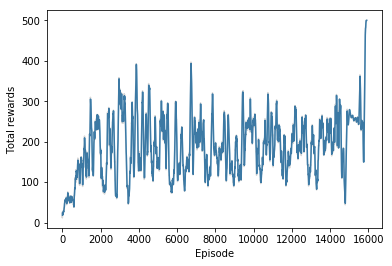

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

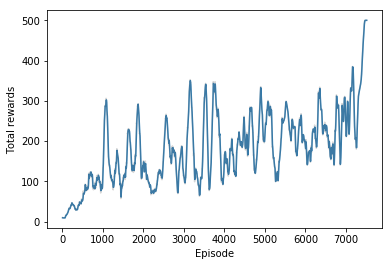

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

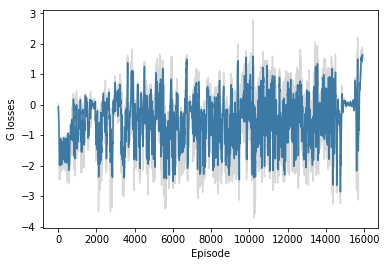

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

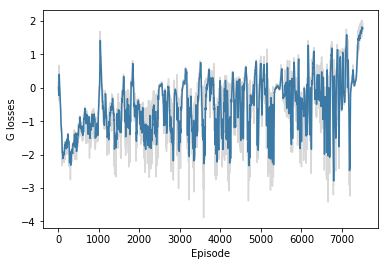

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

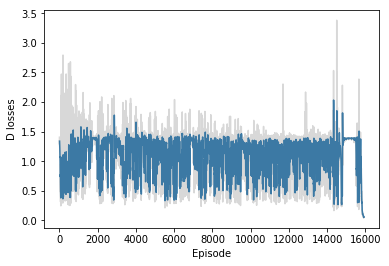

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

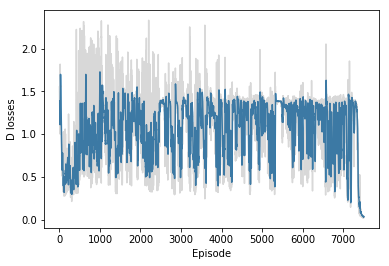

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

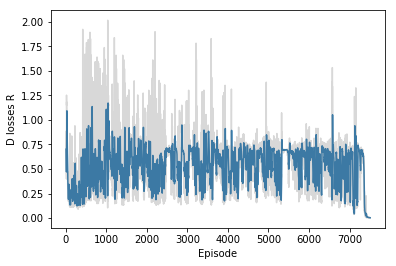

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

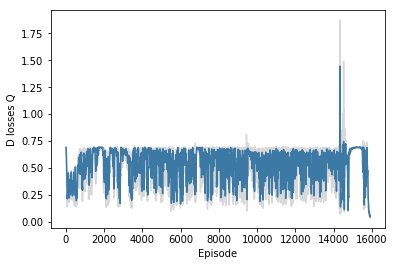

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

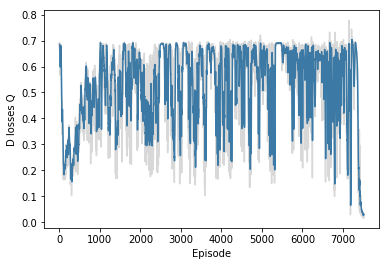

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.